In [70]:
import os, shutil, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family = font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import networkx as nx
from apyori import apriori

import random
import re
import json

from urllib.request import urlopen
from bs4 import BeautifulSoup

# 에너지적정비율

- 서울시민건강포털
    - https://health.seoulmc.or.kr/healthCareInfo/nutrientStandard.do

## 크롤링 및 전처리

- 결측값을 0으로 대체
- 남자여자만 

In [2]:
##### 에너지 적정비율 저장
page = urlopen("https://health.seoulmc.or.kr/healthCareInfo/nutrientStandard.do")
soup = BeautifulSoup(page, "html.parser")

trs=soup.find_all("tbody")[0].find_all("tr")
cnt=0
text=[]
group=[]
for tr in range(len(trs)):
    tds = trs[tr].get_text().split('\n')[1:-1]    
    if len(tds)==7 :
        tds = tds
        group.append(tds[0])
    else :
        if tds[0] in ["임산부","수유부"] :
            group.append(tds[0])
            tds.insert(1, tds[0])                
        else :
            tds.insert(0,group[cnt-1])
            group.append(tds[0])
    text.append(tds)
    cnt=cnt+1
# print(text)

text_modify=[]
for td in text :
    tds =[]
    for i in range(len(td)) :
        if td[i] in ['-','\xa0'] :
            td[i]=0
        tds.append(td[i])
    text_modify.append(tds)   
# print(text_modify)

df_crawly=pd.DataFrame(text_modify, 
                    columns=["성별","연령별","탄수화물","단백질","지방",
                             "포화지방산","트랜스지방"])

df_crawly.to_csv('files/에너지적정비율_crawling.csv', header=True, 
              encoding="utf-8", index=False)

df_crawly.head()

성별      연령별   탄수화물   단백질     지방  포화지방산 트랜스지방
0  영아  0-5(개월)      0     0      0      0     0
1  영아     6-11      0     0      0      0     0
2  유아   1-2(세)  55-65  7-20      0  20-35  1 미만
3  유아      3-5  55-65  7-20  15-30   8 미만  1 미만
4  남자   6-8(세)  55-65  7-20  15-30   8 미만  1 미만

In [3]:
df_crawly=pd.read_csv('files/에너지적정비율_crawling.csv', 
                      encoding="utf-8")

In [4]:
##### 파일 저장

df_ratio = pd.DataFrame(columns=["성별","연령별","영양소",
                                 "하한(%)","상한(%)"])

val = ['탄수화물','단백질','지방']
cnt=0
ages=[]
for v in val :
    for i in df_crawly.index :
        if "(세)" in df_crawly["연령별"][i] :
            age=df_crawly["연령별"][i].replace("(세)","")
        elif df_crawly["연령별"][i] == '6-11' :
            age = df_crawly["연령별"][i]+'(개월)'
        else :
            age= df_crawly["연령별"][i]
        sex = df_crawly["성별"][i]
        cat=v+'(g)'

        if df_crawly[v][i]==0 :
            min_num=0
            max_num=0
        else :
            min_num=re.findall("^([0-9]*)", df_crawly[v][i])[0]
            max_num=re.findall("([0-9]*)$", df_crawly[v][i])[0]

        df_ratio.loc[cnt]=[sex,age,cat,min_num, max_num]
#         print(df_ratio.loc[cnt])
        cnt=cnt+1
                
df_ratio=df_ratio[df_ratio["성별"].isin(["남자", "여자"])].reset_index(drop=True)

df_ratio.to_csv('files/에너지적정비율_탄단지(ratio).csv', 
                header=True, encoding="utf-8", index=False)

df_ratio.head()

성별    연령별      영양소 하한(%) 상한(%)
0  남자    6-8  탄수화물(g)    55    65
1  남자   9-11  탄수화물(g)    55    65
2  남자  12-14  탄수화물(g)    55    65
3  남자  15-18  탄수화물(g)    55    65
4  남자  19-29  탄수화물(g)    55    65

---

# 일일섭취권장량

- 영양소 섭취기준을 통해 보는 한국인 영양소 섭취 현황(보도자료)
    - 2020 한국인 영양소 섭취기준 요약표 참고
    - 결측값을 0으로 대체
    -남자여자만

In [5]:
df_raw = pd.read_excel("files/raw_일일섭취권장량_탄단지.xlsx",
                         sheet_name='Sheet1')
##### 결측치 채우기
df_raw = df_raw.fillna(0)

##### 성별 통일
df_raw=df_raw[df_raw["성별"].isin(["남자", "여자"])].reset_index(drop=True)

##### 연령별 통일
for i in df_raw.index :
    if "(세)" in df_raw["연령"][i] :
        df_raw["연령"][i]=df_raw["연령"][i].replace("(세)","")
    else :
        df_raw["연령"][i]=df_raw["연령"][i]
df_raw=df_raw.rename(columns={"연령" : "연령별"})

##### 영양소 통일
df_raw["영양소"]=df_raw["영양소"].str.replace("/일","")
df_raw.head()

##### 에너지와 영양소 분리
df_energe=df_raw[df_raw["영양소"]=="에너지(kcal)"].reset_index(drop=True)
df_energe.drop(['영양소','권장섭취량','충분섭취량','상한섭취량'], axis=1, inplace=True)
df_energe=df_energe.rename(columns={"평균필요량":"에너지(kcal)"})
df_energe.head()

df_amount=df_raw[df_raw["영양소"]!="에너지(kcal)"].reset_index(drop=True)
df_amount.drop(['평균필요량','충분섭취량','상한섭취량'], axis=1, inplace=True)
df_amount.tail()

##### 영양소df에 총당류(에너지의 10%/4kcal), 나트륨(2000mg=2g) 추가
cnt=len(df_amount)
# print(cnt)
for c in ["총당류(g)", "나트륨(g)"] :
    for i in df_energe.index:
        if c == "총당류(g)" :
#             print(df_kcal["평균필요량"][i])
            new = df_energe["에너지(kcal)"][i]/40
        else :
            new = 2
            
#         print([df_kcal["성별"][i],df_kcal["연령별"][i],c,0,new,0,0])
            
        row=[df_energe["성별"][i],df_energe["연령별"][i],c,new]
#         print(cnt, row)
        df_amount.loc[cnt]=row
        cnt=cnt+1  
df_amount.tail()

##### 에너지 영양소 머지
df_nutrient = pd.merge(df_energe, df_amount, on=["성별","연령별"], how='outer')
df_nutrient.fillna(0)

df_nutrient.to_csv("files/일일영양소권장섭취량(nutrient).csv",
                encoding="utf-8", index=False)

df_nutrient.head()

C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\610851292.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["연령"][i]=df_raw["연령"][i].replace("(세)","")
C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\610851292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["연령"][i]=df_raw["연령"][i]


성별  연령별  에너지(kcal)      영양소  권장섭취량
0  남자  6-8     1700.0  탄수화물(g)  130.0
1  남자  6-8     1700.0    지방(g)    0.0
2  남자  6-8     1700.0   단백질(g)   35.0
3  남자  6-8     1700.0   총당류(g)   42.5
4  남자  6-8     1700.0   나트륨(g)    2.0

# 지방 섭취량 구하기

- 지방 권장 섭취량이 0으로 나와 에너지에서 지방의 비율의 최대치를 대체
- 상하한비율: 에너지*영양소비율
- 상하한비율/1g당 칼로리(지방 9, 나머지 4)
- 당류와 나트륨의 상한은 권장량 그대로

In [6]:
df_minmax=pd.merge(df_nutrient, df_ratio, on=["성별","연령별","영양소"], how='outer')
df_minmax=df_minmax.fillna(0)
df_minmax.head()

df_minmax['하한권장량']=''
df_minmax['상한권장량']=''

##### 상한하한 구하기

for i in df_minmax.index :
    if df_minmax["영양소"][i] == "나트륨(g)" :
        max_num=2
        min_num=0
        
    elif df_minmax["영양소"][i] == "총당류(g)" :
        dang_term=df_minmax[df_minmax["영양소"]=="총당류(g)"]
        max_num=dang_term["권장섭취량"][i]
        min_num=0
        
    else :
        if df_minmax["영양소"][i] == "지방(g)" :
            kcalby=9
        else :
            kcalby=4
        
        energe=df_minmax["에너지(kcal)"][i]
        max_r=float(df_minmax["상한(%)"][i])
        min_r=float(df_minmax["하한(%)"][i])
#         print(energe, max_r, min_r)
#         print(type(energe), type(max_r), type(min_r))
        max_num=(energe*(max_r/100))/kcalby
        min_num=(energe*(min_r/100))/kcalby
        
#     print(max_num, min_num)
        
    df_minmax["상한권장량"][i]=max_num
    df_minmax["하한권장량"][i]=min_num

df_minmax[df_minmax["영양소"]=="총당류(g)"]

df_minmax.to_csv('files/일일권장섭취량(minmax).csv',
                   encoding='utf-8', index=False)

df_minmax.head()

##### 지방상한을 대체하기
df_intake=df_minmax.copy()
df_intake

fat_term = df_intake[df_intake["영양소"]=="지방(g)"]
for i in fat_term.index :
    df_intake['권장섭취량'][i] = df_intake['상한권장량'][i]


df_intake[df_intake["영양소"]=="지방(g)"]

df_intake.drop(["하한(%)","상한(%)","하한권장량","상한권장량"], axis=1, inplace=True)

df_intake.to_csv("files/권장섭취량(intake).csv",
                encoding="utf-8", index=False)

df_intake.head()

C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\3000968842.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minmax["상한권장량"][i]=max_num
C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\3000968842.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_minmax["하한권장량"][i]=min_num
C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\3000968842.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intake['권장섭취량'][i] = df_intake['상한

성별  연령별  에너지(kcal)      영양소       권장섭취량
0  남자  6-8     1700.0  탄수화물(g)  130.000000
1  남자  6-8     1700.0    지방(g)   56.666667
2  남자  6-8     1700.0   단백질(g)   35.000000
3  남자  6-8     1700.0   총당류(g)   42.500000
4  남자  6-8     1700.0   나트륨(g)    2.000000

---

# 식품영양성분DB

- https://various.foodsafetykorea.go.kr/nutrient/

In [7]:
# data_path='content'
# with zipfile.ZipFile(os.path.join(data_path,"통합 식품영양성분DB_음식.zip"),"r") as target_file:
#     target_file.extractall(data_path)

In [8]:
df_element = pd.read_excel("files/raw_통합 식품영양성분DB_음식.xlsx", 
                        sheet_name='Sheet1')

df_food=df_element.loc[df_element['지역 / 제조사']=="전국(대표)", 
           ['식품명','연도','식품대분류','식품상세분류','1회제공량',
            '에너지(㎉)', '탄수화물(g)' ,'단백질(g)','지방(g)',
           '총당류(g)','나트륨(㎎)']]
df_food=df_food.rename(columns={'에너지(㎉)':'에너지(kcal)',
                               '나트륨(㎎)':'나트륨(g)'})

##### 나트륨 단위 변경
for i in df_food.index:
    df_food['나트륨(g)'][i] = df_food['나트륨(g)'][i]/1000

# print(df_food["식품명"].value_counts()) # 멸치풋고추볶음,우동(일식) 중복
# print('====================================================')
# print(df_food[(df_food["식품명"].isin(['멸치풋고추볶음','우동(일식)'])) & 
#              (df_food["연도"]==2019)].index)

df_food.drop([87, 154], inplace=True)
del df_food["연도"]

##### 메인메뉴 여부 매칭
df_main_menu = pd.read_table("files/fin_main_menu.txt", 
                             encoding="utf-8", header=None)

# print(len(df_main_menu))
mains=df_main_menu.values.tolist()
# print(mains)
main_menu=[i[0] for i in mains]
# print(main_menu)
# print(len(main_menu))

food_mains=[]
for i in df_food["식품명"]:
#     print(i)
    if i in main_menu :
        food_mains.append("main")
    else : 
        food_mains.append("not main")
        
df_food["메인여부"]=food_mains
        
df_food.to_csv("files/식품영양정보_탄단지_main(food).csv", 
               encoding="utf-8", index=False)
        
print(len(df_food[df_food["메인여부"]=="main"]))

df_food.head()

161


C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\1403559960.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_food['나트륨(g)'][i] = df_food['나트륨(g)'][i]/1000


식품명 식품대분류 식품상세분류  1회제공량  에너지(kcal)  탄수화물(g)  단백질(g)  지방(g)  총당류(g)  \
0   닭갈비   구이류   육류구이    400     595.61    44.90   45.90  25.80   21.20   
1   닭꼬치   구이류   육류구이     70     176.72    13.35   11.56   8.57    3.15   
2  더덕구이   구이류  채소류구이    100     184.00    31.10    3.10   5.20   11.60   
3  도미구이   구이류  어패류구이    250     397.00     2.10   61.10  16.50    0.00   
4  병어구이   구이류  어패류구이    250     488.00     0.20   54.60  30.80    0.00   

    나트륨(g)      메인여부  
0  1.53583  not main  
1  0.28691  not main  
2  0.74337  not main  
3  1.58217  not main  
4  1.56794  not main

---

In [9]:
## 데이터 불러오기

# df_intake=pd.read_csv("files/권장섭취량(intake).csv",encoding="utf-8")
# df_food=pd.read_csv("files/식품영양정보_탄단지_main(food).csv", encoding="utf-8")

---

# 반찬추천

- 코랩으로 rules데이터프레임 저장

In [10]:
menu_csv = pd.read_csv("content/test_csv.csv", encoding="euc-kr")

menus = []
unique_menus = []

for menu in menu_csv.menu2:
    try:
        split_list = menu.split(" ")
        fin_list = []
        for split_word in split_list:
            stop_matches = re.findall(f"[가-힣]*밥$", split_word)
            if len(stop_matches) > 0 and not ("알밥" in split_word or "볶음밥" in split_word or "덮밥" in split_word or "국밥" in split_word or "비빔밥" in split_word or "김밥" in split_word): continue
            stop_matches = re.findall(f"[가-힣]*김치$", split_word)
            if len(stop_matches) > 0: continue
            stop_matches = re.findall(f"[가-힣]*국$", split_word)
            if len(stop_matches) > 0 and not ( "해장국" in split_word): continue
            stop_matches = re.findall(f"[가-힣]*겉절이$", split_word)
            if len(stop_matches) > 0: continue
            stop_matches = re.findall(f"깍두기", split_word)
            if len(stop_matches) > 0: continue
            stop_matches = re.findall(f"과일샐러드", split_word)
            if len(stop_matches) > 0: continue
            stop_matches = re.findall(f"오이장아찌", split_word)
            if len(stop_matches) > 0: split_word = "피클"
            fin_list.append(split_word)
        if len(fin_list) >= 3:
            menus.append(fin_list)
            unique_menus.extend(fin_list)
    except:
        pass
unique_menus = list(set(unique_menus))

In [16]:
rules = pd.read_csv("content/rules.csv", encoding="utf-8")
rules.head()

for i in rules.index :
    rules['antecedents'][i]=",".join(re.findall("([가-힣]+)",rules['antecedents'][i]))
    rules['consequents'][i]=",".join(re.findall("([가-힣]+)",rules['consequents'][i]))
    print(i, " 완료", rules['antecedents'][i],rules['consequents'][i])

rules.to_csv("content/rules2.csv",encoding="utf-8", index=False)

C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\1573970213.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules['antecedents'][i]=",".join(re.findall("([가-힣]+)",rules['antecedents'][i]))
C:\Users\acorn\AppData\Local\Temp\ipykernel_22860\1573970213.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules['consequents'][i]=",".join(re.findall("([가-힣]+)",rules['consequents'][i]))


0  완료 부대찌개 콩나물무침
1  완료 콩나물무침 부대찌개
2  완료 부대찌개 만두
3  완료 만두 부대찌개
4  완료 부대찌개 떡볶이
5  완료 떡볶이 부대찌개
6  완료 부대찌개 탕수육
7  완료 탕수육 부대찌개
8  완료 부대찌개 단무지
9  완료 단무지 부대찌개
10  완료 부대찌개 볶음밥
11  완료 볶음밥 부대찌개
12  완료 부대찌개,콩나물무침 만두
13  완료 부대찌개,만두 콩나물무침
14  완료 콩나물무침,만두 부대찌개
15  완료 부대찌개 콩나물무침,만두
16  완료 콩나물무침 부대찌개,만두
17  완료 만두 부대찌개,콩나물무침
18  완료 부대찌개,만두 떡볶이
19  완료 부대찌개,떡볶이 만두
20  완료 떡볶이,만두 부대찌개
21  완료 부대찌개 떡볶이,만두
22  완료 만두 부대찌개,떡볶이
23  완료 떡볶이 부대찌개,만두
24  완료 부대찌개,콩나물무침 떡볶이
25  완료 부대찌개,떡볶이 콩나물무침
26  완료 콩나물무침,떡볶이 부대찌개
27  완료 부대찌개 콩나물무침,떡볶이
28  완료 콩나물무침 부대찌개,떡볶이
29  완료 떡볶이 부대찌개,콩나물무침
30  완료 부대찌개,탕수육 떡볶이
31  완료 부대찌개,떡볶이 탕수육
32  완료 탕수육,떡볶이 부대찌개
33  완료 부대찌개 탕수육,떡볶이
34  완료 탕수육 부대찌개,떡볶이
35  완료 떡볶이 부대찌개,탕수육
36  완료 부대찌개,탕수육 콩나물무침
37  완료 부대찌개,콩나물무침 탕수육
38  완료 탕수육,콩나물무침 부대찌개
39  완료 부대찌개 탕수육,콩나물무침
40  완료 탕수육 부대찌개,콩나물무침
41  완료 콩나물무침 부대찌개,탕수육
42  완료 부대찌개,탕수육 만두
43  완료 부대찌개,만두 탕수육
44  완료 탕수육,만두 부대찌개
45  완료 부대찌개 탕수육,만두
46  완료 탕수육 부대찌개,만두
47  완료 만두 부대찌개,탕수육
48  완료 부대찌개,탕수육 단무지
49  완료 부대찌개,단무지 탕수육
50  완료 탕수육,단무지 부대찌개
51  완료 부대찌개 탕수육,단무

639  완료 김치볶음밥 만두,부추무침
640  완료 만두 부추무침,김치볶음밥
641  완료 부추무침 만두,김치볶음밥
642  완료 떡볶이,김치볶음밥 부추무침
643  완료 부추무침,김치볶음밥 떡볶이
644  완료 떡볶이,부추무침 김치볶음밥
645  완료 김치볶음밥 떡볶이,부추무침
646  완료 떡볶이 부추무침,김치볶음밥
647  완료 부추무침 떡볶이,김치볶음밥
648  완료 돈까스,김치볶음밥 부추무침
649  완료 부추무침,김치볶음밥 돈까스
650  완료 돈까스,부추무침 김치볶음밥
651  완료 김치볶음밥 돈까스,부추무침
652  완료 돈까스 부추무침,김치볶음밥
653  완료 부추무침 돈까스,김치볶음밥
654  완료 우동,김치볶음밥 부추무침
655  완료 부추무침,김치볶음밥 우동
656  완료 우동,부추무침 김치볶음밥
657  완료 김치볶음밥 우동,부추무침
658  완료 우동 부추무침,김치볶음밥
659  완료 부추무침 우동,김치볶음밥
660  완료 새우튀김,김치볶음밥 부추무침
661  완료 새우튀김,부추무침 김치볶음밥
662  완료 부추무침,김치볶음밥 새우튀김
663  완료 새우튀김 부추무침,김치볶음밥
664  완료 김치볶음밥 새우튀김,부추무침
665  완료 부추무침 새우튀김,김치볶음밥
666  완료 탕수육,김치볶음밥 부추무침
667  완료 부추무침,김치볶음밥 탕수육
668  완료 탕수육,부추무침 김치볶음밥
669  완료 김치볶음밥 탕수육,부추무침
670  완료 탕수육 부추무침,김치볶음밥
671  완료 부추무침 탕수육,김치볶음밥
672  완료 순대,떡볶이 부추무침
673  완료 떡볶이,부추무침 순대
674  완료 순대,부추무침 떡볶이
675  완료 떡볶이 순대,부추무침
676  완료 순대 떡볶이,부추무침
677  완료 부추무침 순대,떡볶이
678  완료 볶음밥,순대 부추무침
679  완료 볶음밥,부추무침 순대
680  완료 순대,부추무침 볶음밥
681  완료 볶음밥 순대,부추무침
682  완료 순대 볶음밥,부추무침
683  완료 부추무침 볶음밥,순대
684 

1111  완료 탕수육 단무지,부추무침
1112  완료 단무지 탕수육,부추무침
1113  완료 부추무침 탕수육,단무지
1114  완료 단무지,잔치국수 부추무침
1115  완료 단무지,부추무침 잔치국수
1116  완료 잔치국수,부추무침 단무지
1117  완료 단무지 잔치국수,부추무침
1118  완료 잔치국수 단무지,부추무침
1119  완료 부추무침 단무지,잔치국수
1120  완료 새우튀김,단무지 부추무침
1121  완료 새우튀김,부추무침 단무지
1122  완료 단무지,부추무침 새우튀김
1123  완료 새우튀김 단무지,부추무침
1124  완료 단무지 새우튀김,부추무침
1125  완료 부추무침 새우튀김,단무지
1126  완료 단무지,김치볶음밥 부추무침
1127  완료 부추무침,김치볶음밥 단무지
1128  완료 단무지,부추무침 김치볶음밥
1129  완료 김치볶음밥 단무지,부추무침
1130  완료 단무지 부추무침,김치볶음밥
1131  완료 부추무침 단무지,김치볶음밥
1132  완료 단무지,떡볶이 부추무침
1133  완료 단무지,부추무침 떡볶이
1134  완료 떡볶이,부추무침 단무지
1135  완료 단무지 떡볶이,부추무침
1136  완료 떡볶이 단무지,부추무침
1137  완료 부추무침 단무지,떡볶이
1138  완료 단무지,만두 부추무침
1139  완료 단무지,부추무침 만두
1140  완료 만두,부추무침 단무지
1141  완료 단무지 만두,부추무침
1142  완료 만두 단무지,부추무침
1143  완료 부추무침 단무지,만두
1144  완료 단무지,볶음밥 부추무침
1145  완료 단무지,부추무침 볶음밥
1146  완료 볶음밥,부추무침 단무지
1147  완료 단무지 볶음밥,부추무침
1148  완료 볶음밥 단무지,부추무침
1149  완료 부추무침 단무지,볶음밥
1150  완료 단무지,돈까스 부추무침
1151  완료 단무지,부추무침 돈까스
1152  완료 돈까스,부추무침 단무지
1153  완료 단무지 돈까스,부추무침
1154  완료 돈까스 단무지,부추무침
1155  완료 부추무침 

1787  완료 김치찌개 돈까스,볶음우동
1788  완료 단무지,돈까스 볶음우동
1789  완료 단무지,볶음우동 돈까스
1790  완료 돈까스,볶음우동 단무지
1791  완료 단무지 돈까스,볶음우동
1792  완료 돈까스 단무지,볶음우동
1793  완료 볶음우동 단무지,돈까스
1794  완료 돈까스,볶음우동 무말랭이무침
1795  완료 돈까스,무말랭이무침 볶음우동
1796  완료 볶음우동,무말랭이무침 돈까스
1797  완료 돈까스 볶음우동,무말랭이무침
1798  완료 볶음우동 돈까스,무말랭이무침
1799  완료 무말랭이무침 돈까스,볶음우동
1800  완료 부대찌개,볶음우동 무말랭이무침
1801  완료 부대찌개,무말랭이무침 볶음우동
1802  완료 볶음우동,무말랭이무침 부대찌개
1803  완료 부대찌개 볶음우동,무말랭이무침
1804  완료 볶음우동 부대찌개,무말랭이무침
1805  완료 무말랭이무침 부대찌개,볶음우동
1806  완료 볶음우동,무말랭이무침 어묵볶음
1807  완료 볶음우동,어묵볶음 무말랭이무침
1808  완료 무말랭이무침,어묵볶음 볶음우동
1809  완료 볶음우동 무말랭이무침,어묵볶음
1810  완료 무말랭이무침 볶음우동,어묵볶음
1811  완료 어묵볶음 볶음우동,무말랭이무침
1812  완료 볶음우동,김치찌개 함박스테이크
1813  완료 볶음우동,함박스테이크 김치찌개
1814  완료 김치찌개,함박스테이크 볶음우동
1815  완료 볶음우동 김치찌개,함박스테이크
1816  완료 김치찌개 볶음우동,함박스테이크
1817  완료 함박스테이크 볶음우동,김치찌개
1818  완료 볶음우동,순두부찌개 함박스테이크
1819  완료 볶음우동,함박스테이크 순두부찌개
1820  완료 순두부찌개,함박스테이크 볶음우동
1821  완료 볶음우동 순두부찌개,함박스테이크
1822  완료 순두부찌개 볶음우동,함박스테이크
1823  완료 함박스테이크 볶음우동,순두부찌개
1824  완료 볶음우동,감자탕 함박스테이크
1825  완료 감자탕,함박스테이크 볶음우동
1826  완료 볶음우동,함

2175  완료 볶음우동,스테이크 김치찌개
2176  완료 김치찌개,스테이크 볶음우동
2177  완료 볶음우동 김치찌개,스테이크
2178  완료 김치찌개 볶음우동,스테이크
2179  완료 스테이크 볶음우동,김치찌개
2180  완료 볶음우동,스테이크 육개장
2181  완료 볶음우동,육개장 스테이크
2182  완료 스테이크,육개장 볶음우동
2183  완료 볶음우동 스테이크,육개장
2184  완료 스테이크 볶음우동,육개장
2185  완료 육개장 볶음우동,스테이크
2186  완료 볶음우동,볶음밥 스테이크
2187  완료 볶음밥,스테이크 볶음우동
2188  완료 볶음우동,스테이크 볶음밥
2189  완료 볶음밥 볶음우동,스테이크
2190  완료 볶음우동 볶음밥,스테이크
2191  완료 스테이크 볶음우동,볶음밥
2192  완료 볶음우동,감자탕 스테이크
2193  완료 감자탕,스테이크 볶음우동
2194  완료 볶음우동,스테이크 감자탕
2195  완료 감자탕 볶음우동,스테이크
2196  완료 볶음우동 감자탕,스테이크
2197  완료 스테이크 볶음우동,감자탕
2198  완료 볶음우동,파무침 스테이크
2199  완료 파무침,스테이크 볶음우동
2200  완료 볶음우동,스테이크 파무침
2201  완료 파무침 볶음우동,스테이크
2202  완료 볶음우동 파무침,스테이크
2203  완료 스테이크 볶음우동,파무침
2204  완료 볶음우동,파무침 순두부찌개
2205  완료 파무침,순두부찌개 볶음우동
2206  완료 볶음우동,순두부찌개 파무침
2207  완료 파무침 볶음우동,순두부찌개
2208  완료 볶음우동 파무침,순두부찌개
2209  완료 순두부찌개 볶음우동,파무침
2210  완료 탕수육,파무침 볶음우동
2211  완료 탕수육,볶음우동 파무침
2212  완료 볶음우동,파무침 탕수육
2213  완료 탕수육 볶음우동,파무침
2214  완료 파무침 탕수육,볶음우동
2215  완료 볶음우동 탕수육,파무침
2216  완료 돈까스,파무침 볶음우동
2217  완료 돈까스,볶음우동 파무침
2218  완료

2691  완료 닭곰탕 볶음우동,오리불고기
2692  완료 볶음우동 닭곰탕,오리불고기
2693  완료 오리불고기 닭곰탕,볶음우동
2694  완료 탕수육,볶음우동 순두부찌개
2695  완료 탕수육,순두부찌개 볶음우동
2696  완료 볶음우동,순두부찌개 탕수육
2697  완료 탕수육 볶음우동,순두부찌개
2698  완료 볶음우동 탕수육,순두부찌개
2699  완료 순두부찌개 탕수육,볶음우동
2700  완료 탕수육,볶음밥 볶음우동
2701  완료 탕수육,볶음우동 볶음밥
2702  완료 볶음우동,볶음밥 탕수육
2703  완료 탕수육 볶음우동,볶음밥
2704  완료 볶음밥 탕수육,볶음우동
2705  완료 볶음우동 탕수육,볶음밥
2706  완료 탕수육,볶음우동 육개장
2707  완료 탕수육,육개장 볶음우동
2708  완료 볶음우동,육개장 탕수육
2709  완료 탕수육 볶음우동,육개장
2710  완료 볶음우동 탕수육,육개장
2711  완료 육개장 탕수육,볶음우동
2712  완료 탕수육,단무지 볶음우동
2713  완료 탕수육,볶음우동 단무지
2714  완료 단무지,볶음우동 탕수육
2715  완료 탕수육 단무지,볶음우동
2716  완료 단무지 탕수육,볶음우동
2717  완료 볶음우동 탕수육,단무지
2718  완료 탕수육,볶음우동 김치찌개
2719  완료 탕수육,김치찌개 볶음우동
2720  완료 볶음우동,김치찌개 탕수육
2721  완료 탕수육 볶음우동,김치찌개
2722  완료 볶음우동 탕수육,김치찌개
2723  완료 김치찌개 탕수육,볶음우동
2724  완료 탕수육,콩나물무침 볶음우동
2725  완료 탕수육,볶음우동 콩나물무침
2726  완료 볶음우동,콩나물무침 탕수육
2727  완료 탕수육 볶음우동,콩나물무침
2728  완료 콩나물무침 탕수육,볶음우동
2729  완료 볶음우동 탕수육,콩나물무침
2730  완료 부대찌개,탕수육 볶음우동
2731  완료 부대찌개,볶음우동 탕수육
2732  완료 탕수육,볶음우동 부대찌개
2733  완료 부대찌개 탕수육,볶음우동
2734  완료 탕수육 부

3063  완료 비빔밥 우동
3064  완료 탕수육 우동
3065  완료 우동 탕수육
3066  완료 우동 콩나물무침
3067  완료 콩나물무침 우동
3068  완료 우동 김치찌개
3069  완료 김치찌개 우동
3070  완료 우동 순두부찌개
3071  완료 순두부찌개 우동
3072  완료 부대찌개 우동
3073  완료 우동 부대찌개
3074  완료 단무지,떡볶이 우동
3075  완료 단무지,우동 떡볶이
3076  완료 우동,떡볶이 단무지
3077  완료 단무지 우동,떡볶이
3078  완료 떡볶이 단무지,우동
3079  완료 우동 단무지,떡볶이
3080  완료 단무지,만두 우동
3081  완료 단무지,우동 만두
3082  완료 우동,만두 단무지
3083  완료 단무지 우동,만두
3084  완료 만두 단무지,우동
3085  완료 우동 단무지,만두
3086  완료 우동,만두 떡볶이
3087  완료 우동,떡볶이 만두
3088  완료 떡볶이,만두 우동
3089  완료 우동 떡볶이,만두
3090  완료 만두 우동,떡볶이
3091  완료 떡볶이 우동,만두
3092  완료 우동,단무지무침 만두
3093  완료 우동,만두 단무지무침
3094  완료 단무지무침,만두 우동
3095  완료 우동 단무지무침,만두
3096  완료 단무지무침 우동,만두
3097  완료 만두 우동,단무지무침
3098  완료 우동,볶음밥 만두
3099  완료 우동,만두 볶음밥
3100  완료 볶음밥,만두 우동
3101  완료 우동 볶음밥,만두
3102  완료 볶음밥 우동,만두
3103  완료 만두 우동,볶음밥
3104  완료 단무지,떡볶이,만두 우동
3105  완료 단무지,만두,우동 떡볶이
3106  완료 단무지,떡볶이,우동 만두
3107  완료 우동,떡볶이,만두 단무지
3108  완료 단무지,만두 우동,떡볶이
3109  완료 단무지,떡볶이 우동,만두
3110  완료 단무지,우동 떡볶이,만두
3111  완료 떡볶이,만두 단무지,우동
3112  완료 우동,만두 단무지,떡볶이
3113  완료 우동,떡볶이 단

3513  완료 부추무침 김밥
3514  완료 김밥 콩나물무침
3515  완료 콩나물무침 김밥
3516  완료 된장찌개 김밥
3517  완료 김밥 된장찌개
3518  완료 참나물무침 김밥
3519  완료 김밥 참나물무침
3520  완료 김밥 함박스테이크
3521  완료 함박스테이크 김밥
3522  완료 김밥 오이부추무침
3523  완료 오이부추무침 김밥
3524  완료 잡채 김밥
3525  완료 김밥 잡채
3526  완료 김밥 두부조림
3527  완료 두부조림 김밥
3528  완료 탕수육 김밥
3529  완료 김밥 탕수육
3530  완료 김밥 무생채
3531  완료 무생채 김밥
3532  완료 생선까스 김밥
3533  완료 김밥 생선까스
3534  완료 김밥 오이소박이
3535  완료 오이소박이 김밥
3536  완료 부대찌개 김밥
3537  완료 김밥 부대찌개
3538  완료 김밥 김치찌개
3539  완료 김치찌개 김밥
3540  완료 김밥 달걀말이
3541  완료 달걀말이 김밥
3542  완료 김밥 미역줄기볶음
3543  완료 미역줄기볶음 김밥
3544  완료 김밥 도토리묵무침
3545  완료 도토리묵무침 김밥
3546  완료 김치전 김밥
3547  완료 김밥 김치전
3548  완료 김밥 자장면
3549  완료 자장면 김밥
3550  완료 김밥 제육볶음
3551  완료 제육볶음 김밥
3552  완료 단무지,김밥 떡볶이
3553  완료 단무지,떡볶이 김밥
3554  완료 김밥,떡볶이 단무지
3555  완료 단무지 김밥,떡볶이
3556  완료 김밥 단무지,떡볶이
3557  완료 떡볶이 단무지,김밥
3558  완료 우동,김밥 떡볶이
3559  완료 우동,떡볶이 김밥
3560  완료 김밥,떡볶이 우동
3561  완료 우동 김밥,떡볶이
3562  완료 김밥 우동,떡볶이
3563  완료 떡볶이 우동,김밥
3564  완료 단무지,김밥 우동
3565  완료 단무지,우동 김밥
3566  완료 김밥,우동 단무지
3567  완료 단무지 김밥,우동
3568  완료 김밥 단무지,우

3978  완료 김밥,순대 단무지,만두,떡볶이
3979  완료 단무지 순대,김밥,만두,떡볶이
3980  완료 떡볶이 순대,단무지,김밥,만두
3981  완료 만두 순대,단무지,김밥,떡볶이
3982  완료 김밥 순대,단무지,만두,떡볶이
3983  완료 순대 단무지,만두,김밥,떡볶이
3984  완료 김밥,단무지무침,떡볶이 순대
3985  완료 순대,김밥,떡볶이 단무지무침
3986  완료 순대,단무지무침,떡볶이 김밥
3987  완료 김밥,단무지무침,순대 떡볶이
3988  완료 김밥,떡볶이 단무지무침,순대
3989  완료 단무지무침,떡볶이 김밥,순대
3990  완료 순대,떡볶이 김밥,단무지무침
3991  완료 김밥,단무지무침 순대,떡볶이
3992  완료 김밥,순대 단무지무침,떡볶이
3993  완료 단무지무침,순대 김밥,떡볶이
3994  완료 떡볶이 김밥,단무지무침,순대
3995  완료 김밥 순대,단무지무침,떡볶이
3996  완료 단무지무침 순대,김밥,떡볶이
3997  완료 순대 김밥,단무지무침,떡볶이
3998  완료 단무지,돈까스 김밥
3999  완료 돈까스,김밥 단무지
4000  완료 단무지,김밥 돈까스
4001  완료 돈까스 단무지,김밥
4002  완료 단무지 돈까스,김밥
4003  완료 김밥 단무지,돈까스
4004  완료 돈까스,우동 김밥
4005  완료 돈까스,김밥 우동
4006  완료 우동,김밥 돈까스
4007  완료 돈까스 우동,김밥
4008  완료 우동 돈까스,김밥
4009  완료 김밥 돈까스,우동
4010  완료 김밥,돈까스 떡볶이
4011  완료 김밥,떡볶이 돈까스
4012  완료 돈까스,떡볶이 김밥
4013  완료 김밥 돈까스,떡볶이
4014  완료 돈까스 김밥,떡볶이
4015  완료 떡볶이 김밥,돈까스
4016  완료 김밥,돈까스 단무지무침
4017  완료 김밥,단무지무침 돈까스
4018  완료 돈까스,단무지무침 김밥
4019  완료 김밥 돈까스,단무지무침
4020  완료 돈까스 김밥,단무지무침
4021  완료 단무지무침 김밥,돈까스
4022  완료

4430  완료 단무지,김밥,만두 볶음밥,떡볶이
4431  완료 단무지,볶음밥,만두 김밥,떡볶이
4432  완료 단무지,김밥,볶음밥 만두,떡볶이
4433  완료 김밥,만두,떡볶이 단무지,볶음밥
4434  완료 만두,볶음밥,떡볶이 단무지,김밥
4435  완료 김밥,볶음밥,떡볶이 단무지,만두
4436  완료 김밥,볶음밥,만두 단무지,떡볶이
4437  완료 단무지,떡볶이 김밥,볶음밥,만두
4438  완료 단무지,만두 김밥,볶음밥,떡볶이
4439  완료 단무지,김밥 만두,볶음밥,떡볶이
4440  완료 단무지,볶음밥 김밥,만두,떡볶이
4441  완료 만두,떡볶이 단무지,김밥,볶음밥
4442  완료 김밥,떡볶이 단무지,볶음밥,만두
4443  완료 볶음밥,떡볶이 단무지,김밥,만두
4444  완료 김밥,만두 단무지,볶음밥,떡볶이
4445  완료 볶음밥,만두 단무지,김밥,떡볶이
4446  완료 김밥,볶음밥 단무지,만두,떡볶이
4447  완료 단무지 김밥,만두,볶음밥,떡볶이
4448  완료 떡볶이 단무지,김밥,볶음밥,만두
4449  완료 만두 단무지,김밥,볶음밥,떡볶이
4450  완료 김밥 단무지,만두,볶음밥,떡볶이
4451  완료 볶음밥 단무지,만두,김밥,떡볶이
4452  완료 김밥,볶음밥,순대 떡볶이
4453  완료 김밥,떡볶이,순대 볶음밥
4454  완료 떡볶이,볶음밥,순대 김밥
4455  완료 김밥,볶음밥,떡볶이 순대
4456  완료 김밥,순대 볶음밥,떡볶이
4457  완료 볶음밥,순대 김밥,떡볶이
4458  완료 떡볶이,순대 김밥,볶음밥
4459  완료 김밥,볶음밥 떡볶이,순대
4460  완료 김밥,떡볶이 볶음밥,순대
4461  완료 볶음밥,떡볶이 김밥,순대
4462  완료 순대 김밥,볶음밥,떡볶이
4463  완료 김밥 떡볶이,볶음밥,순대
4464  완료 볶음밥 김밥,떡볶이,순대
4465  완료 떡볶이 김밥,볶음밥,순대
4466  완료 단무지,김밥 양배추샐러드
4467  완료 단무지,양배추샐러드 김밥
4468  완료 김밥,양배추샐러드 단무지
4469  완료 단무지 김밥

4870  완료 김밥,파무침 떡볶이
4871  완료 김밥,떡볶이 파무침
4872  완료 파무침,떡볶이 김밥
4873  완료 김밥 파무침,떡볶이
4874  완료 파무침 김밥,떡볶이
4875  완료 떡볶이 김밥,파무침
4876  완료 김밥,파무침 만두
4877  완료 김밥,만두 파무침
4878  완료 파무침,만두 김밥
4879  완료 김밥 파무침,만두
4880  완료 파무침 김밥,만두
4881  완료 만두 김밥,파무침
4882  완료 김밥,파무침 잔치국수
4883  완료 김밥,잔치국수 파무침
4884  완료 파무침,잔치국수 김밥
4885  완료 김밥 파무침,잔치국수
4886  완료 파무침 김밥,잔치국수
4887  완료 잔치국수 김밥,파무침
4888  완료 김밥,파무침,만두 떡볶이
4889  완료 김밥,떡볶이,만두 파무침
4890  완료 김밥,파무침,떡볶이 만두
4891  완료 떡볶이,파무침,만두 김밥
4892  완료 김밥,만두 파무침,떡볶이
4893  완료 김밥,파무침 떡볶이,만두
4894  완료 김밥,떡볶이 파무침,만두
4895  완료 파무침,만두 김밥,떡볶이
4896  완료 떡볶이,만두 김밥,파무침
4897  완료 파무침,떡볶이 김밥,만두
4898  완료 김밥 떡볶이,파무침,만두
4899  완료 만두 김밥,파무침,떡볶이
4900  완료 파무침 김밥,떡볶이,만두
4901  완료 떡볶이 김밥,파무침,만두
4902  완료 김밥,잔치국수 떡갈비
4903  완료 김밥,떡갈비 잔치국수
4904  완료 잔치국수,떡갈비 김밥
4905  완료 김밥 잔치국수,떡갈비
4906  완료 잔치국수 김밥,떡갈비
4907  완료 떡갈비 김밥,잔치국수
4908  완료 우동,김밥 떡갈비
4909  완료 우동,떡갈비 김밥
4910  완료 김밥,떡갈비 우동
4911  완료 우동 김밥,떡갈비
4912  완료 김밥 우동,떡갈비
4913  완료 떡갈비 우동,김밥
4914  완료 단무지,김밥 떡갈비
4915  완료 단무지,떡갈비 김밥
4916  완료 김밥,떡갈비 단무지
4917  완료 단무지 김밥,떡갈

5278  완료 김밥,떡볶이 탕수육
5279  완료 탕수육 김밥,떡볶이
5280  완료 김밥 탕수육,떡볶이
5281  완료 떡볶이 탕수육,김밥
5282  완료 탕수육,김밥 잔치국수
5283  완료 탕수육,잔치국수 김밥
5284  완료 김밥,잔치국수 탕수육
5285  완료 탕수육 김밥,잔치국수
5286  완료 김밥 탕수육,잔치국수
5287  완료 잔치국수 탕수육,김밥
5288  완료 탕수육,단무지 김밥
5289  완료 탕수육,김밥 단무지
5290  완료 단무지,김밥 탕수육
5291  완료 탕수육 단무지,김밥
5292  완료 단무지 탕수육,김밥
5293  완료 김밥 탕수육,단무지
5294  완료 탕수육,우동 김밥
5295  완료 탕수육,김밥 우동
5296  완료 우동,김밥 탕수육
5297  완료 탕수육 우동,김밥
5298  완료 우동 탕수육,김밥
5299  완료 김밥 탕수육,우동
5300  완료 탕수육,단무지,김밥 떡볶이
5301  완료 탕수육,단무지,떡볶이 김밥
5302  완료 탕수육,김밥,떡볶이 단무지
5303  완료 단무지,김밥,떡볶이 탕수육
5304  완료 탕수육,단무지 김밥,떡볶이
5305  완료 탕수육,김밥 단무지,떡볶이
5306  완료 탕수육,떡볶이 단무지,김밥
5307  완료 단무지,김밥 탕수육,떡볶이
5308  완료 단무지,떡볶이 탕수육,김밥
5309  완료 김밥,떡볶이 탕수육,단무지
5310  완료 탕수육 단무지,김밥,떡볶이
5311  완료 단무지 탕수육,김밥,떡볶이
5312  완료 김밥 탕수육,단무지,떡볶이
5313  완료 떡볶이 탕수육,단무지,김밥
5314  완료 김밥,무생채 만두
5315  완료 김밥,만두 무생채
5316  완료 무생채,만두 김밥
5317  완료 김밥 무생채,만두
5318  완료 무생채 김밥,만두
5319  완료 만두 김밥,무생채
5320  완료 김밥,오이소박이 떡볶이
5321  완료 김밥,떡볶이 오이소박이
5322  완료 오이소박이,떡볶이 김밥
5323  완료 김밥 오이소박이,떡볶이
5324  완료 오이소박이 김밥,떡볶이


5765  완료 비빔밥,식혜 된장찌개,만두
5766  완료 비빔밥,만두 된장찌개,식혜
5767  완료 식혜,만두 된장찌개,비빔밥
5768  완료 된장찌개 비빔밥,식혜,만두
5769  완료 비빔밥 된장찌개,식혜,만두
5770  완료 식혜 된장찌개,비빔밥,만두
5771  완료 만두 된장찌개,비빔밥,식혜
5772  완료 콩나물무침,식혜 만두
5773  완료 콩나물무침,만두 식혜
5774  완료 식혜,만두 콩나물무침
5775  완료 콩나물무침 식혜,만두
5776  완료 식혜 콩나물무침,만두
5777  완료 만두 콩나물무침,식혜
5778  완료 잡채,콩나물무침 식혜
5779  완료 잡채,식혜 콩나물무침
5780  완료 콩나물무침,식혜 잡채
5781  완료 잡채 콩나물무침,식혜
5782  완료 콩나물무침 잡채,식혜
5783  완료 식혜 잡채,콩나물무침
5784  완료 콩나물무침,볶음밥 식혜
5785  완료 볶음밥,식혜 콩나물무침
5786  완료 콩나물무침,식혜 볶음밥
5787  완료 볶음밥 콩나물무침,식혜
5788  완료 콩나물무침 볶음밥,식혜
5789  완료 식혜 콩나물무침,볶음밥
5790  완료 된장찌개,콩나물무침 식혜
5791  완료 된장찌개,식혜 콩나물무침
5792  완료 콩나물무침,식혜 된장찌개
5793  완료 된장찌개 콩나물무침,식혜
5794  완료 콩나물무침 된장찌개,식혜
5795  완료 식혜 된장찌개,콩나물무침
5796  완료 돼지갈비찜,콩나물무침 식혜
5797  완료 돼지갈비찜,식혜 콩나물무침
5798  완료 콩나물무침,식혜 돼지갈비찜
5799  완료 돼지갈비찜 콩나물무침,식혜
5800  완료 콩나물무침 돼지갈비찜,식혜
5801  완료 식혜 돼지갈비찜,콩나물무침
5802  완료 콩나물무침,비빔밥 식혜
5803  완료 비빔밥,식혜 콩나물무침
5804  완료 콩나물무침,식혜 비빔밥
5805  완료 비빔밥 콩나물무침,식혜
5806  완료 콩나물무침 비빔밥,식혜
5807  완료 식혜 콩나물무침,비빔밥
5808  완료 탕수육,콩나물무침 식혜
5809  완료 탕수육

6289  완료 찜닭,육개장 식혜
6290  완료 식혜,육개장 찜닭
6291  완료 찜닭 식혜,육개장
6292  완료 식혜 찜닭,육개장
6293  완료 육개장 찜닭,식혜
6294  완료 찜닭,콩나물무침 식혜
6295  완료 찜닭,식혜 콩나물무침
6296  완료 콩나물무침,식혜 찜닭
6297  완료 찜닭 콩나물무침,식혜
6298  완료 콩나물무침 찜닭,식혜
6299  완료 식혜 찜닭,콩나물무침
6300  완료 찜닭,무생채 식혜
6301  완료 찜닭,식혜 무생채
6302  완료 무생채,식혜 찜닭
6303  완료 찜닭 무생채,식혜
6304  완료 무생채 찜닭,식혜
6305  완료 식혜 찜닭,무생채
6306  완료 김치전,찜닭 식혜
6307  완료 김치전,식혜 찜닭
6308  완료 찜닭,식혜 김치전
6309  완료 김치전 찜닭,식혜
6310  완료 찜닭 김치전,식혜
6311  완료 식혜 김치전,찜닭
6312  완료 찜닭,식혜 떡볶이
6313  완료 찜닭,떡볶이 식혜
6314  완료 식혜,떡볶이 찜닭
6315  완료 찜닭 식혜,떡볶이
6316  완료 식혜 찜닭,떡볶이
6317  완료 떡볶이 찜닭,식혜
6318  완료 비빔밥,감자조림 식혜
6319  완료 비빔밥,식혜 감자조림
6320  완료 감자조림,식혜 비빔밥
6321  완료 비빔밥 감자조림,식혜
6322  완료 감자조림 비빔밥,식혜
6323  완료 식혜 비빔밥,감자조림
6324  완료 감자조림,식혜 만두
6325  완료 감자조림,만두 식혜
6326  완료 식혜,만두 감자조림
6327  완료 감자조림 식혜,만두
6328  완료 식혜 감자조림,만두
6329  완료 만두 감자조림,식혜
6330  완료 감자조림,식혜 김치찌개
6331  완료 감자조림,김치찌개 식혜
6332  완료 김치찌개,식혜 감자조림
6333  완료 감자조림 김치찌개,식혜
6334  완료 식혜 감자조림,김치찌개
6335  완료 김치찌개 감자조림,식혜
6336  완료 콩나물무침,식혜 감자조림
6337  완료 감자조림,식혜 콩나물무침
6338  완료 콩나물무

6872  완료 김치찌개 탕수육,호떡
6873  완료 호떡 탕수육,김치찌개
6874  완료 탕수육,호떡 만두
6875  완료 탕수육,만두 호떡
6876  완료 호떡,만두 탕수육
6877  완료 탕수육 호떡,만두
6878  완료 호떡 탕수육,만두
6879  완료 만두 탕수육,호떡
6880  완료 탕수육,비빔밥 호떡
6881  완료 탕수육,호떡 비빔밥
6882  완료 비빔밥,호떡 탕수육
6883  완료 탕수육 비빔밥,호떡
6884  완료 비빔밥 탕수육,호떡
6885  완료 호떡 탕수육,비빔밥
6886  완료 부대찌개,호떡 떡볶이
6887  완료 부대찌개,떡볶이 호떡
6888  완료 호떡,떡볶이 부대찌개
6889  완료 부대찌개 호떡,떡볶이
6890  완료 호떡 부대찌개,떡볶이
6891  완료 떡볶이 부대찌개,호떡
6892  완료 부대찌개,무생채 호떡
6893  완료 부대찌개,호떡 무생채
6894  완료 무생채,호떡 부대찌개
6895  완료 부대찌개 무생채,호떡
6896  완료 무생채 부대찌개,호떡
6897  완료 호떡 부대찌개,무생채
6898  완료 부대찌개,찜닭 호떡
6899  완료 부대찌개,호떡 찜닭
6900  완료 찜닭,호떡 부대찌개
6901  완료 부대찌개 찜닭,호떡
6902  완료 찜닭 부대찌개,호떡
6903  완료 호떡 부대찌개,찜닭
6904  완료 부대찌개,단무지 호떡
6905  완료 부대찌개,호떡 단무지
6906  완료 단무지,호떡 부대찌개
6907  완료 부대찌개 단무지,호떡
6908  완료 단무지 부대찌개,호떡
6909  완료 호떡 부대찌개,단무지
6910  완료 부대찌개,미나리무침 호떡
6911  완료 부대찌개,호떡 미나리무침
6912  완료 미나리무침,호떡 부대찌개
6913  완료 부대찌개 미나리무침,호떡
6914  완료 미나리무침 부대찌개,호떡
6915  완료 호떡 부대찌개,미나리무침
6916  완료 제육볶음,호떡 미나리무침
6917  완료 제육볶음,미나리무침 호떡
6918  완료 미나리무침,호떡 제육볶음
6919  완료 제육볶음 미나리무침

7424  완료 파무침 찜닭,호떡
7425  완료 호떡 찜닭,파무침
7426  완료 파무침,호떡 만두
7427  완료 파무침,만두 호떡
7428  완료 호떡,만두 파무침
7429  완료 파무침 호떡,만두
7430  완료 호떡 파무침,만두
7431  완료 만두 파무침,호떡
7432  완료 파무침,비빔밥 호떡
7433  완료 비빔밥,호떡 파무침
7434  완료 파무침,호떡 비빔밥
7435  완료 비빔밥 파무침,호떡
7436  완료 파무침 비빔밥,호떡
7437  완료 호떡 파무침,비빔밥
7438  완료 탕수육,파무침 호떡
7439  완료 탕수육,호떡 파무침
7440  완료 파무침,호떡 탕수육
7441  완료 탕수육 파무침,호떡
7442  완료 파무침 탕수육,호떡
7443  완료 호떡 탕수육,파무침
7444  완료 잡채,돼지갈비찜 호떡
7445  완료 잡채,호떡 돼지갈비찜
7446  완료 돼지갈비찜,호떡 잡채
7447  완료 잡채 돼지갈비찜,호떡
7448  완료 돼지갈비찜 잡채,호떡
7449  완료 호떡 잡채,돼지갈비찜
7450  완료 돼지갈비찜,콩나물무침 호떡
7451  완료 돼지갈비찜,호떡 콩나물무침
7452  완료 콩나물무침,호떡 돼지갈비찜
7453  완료 돼지갈비찜 콩나물무침,호떡
7454  완료 콩나물무침 돼지갈비찜,호떡
7455  완료 호떡 돼지갈비찜,콩나물무침
7456  완료 돼지갈비찜,호떡 떡볶이
7457  완료 돼지갈비찜,떡볶이 호떡
7458  완료 호떡,떡볶이 돼지갈비찜
7459  완료 돼지갈비찜 호떡,떡볶이
7460  완료 호떡 돼지갈비찜,떡볶이
7461  완료 떡볶이 돼지갈비찜,호떡
7462  완료 돼지갈비찜,감자조림 호떡
7463  완료 돼지갈비찜,호떡 감자조림
7464  완료 감자조림,호떡 돼지갈비찜
7465  완료 돼지갈비찜 감자조림,호떡
7466  완료 감자조림 돼지갈비찜,호떡
7467  완료 호떡 돼지갈비찜,감자조림
7468  완료 된장찌개,돼지갈비찜 호떡
7469  완료 된장찌개,호떡 돼지갈비찜
7470  완료 돼지갈비찜,호떡 된장찌개

8127  완료 달걀말이 닭갈비,호떡
8128  완료 달걀말이,김치찌개 호떡
8129  완료 달걀말이,호떡 김치찌개
8130  완료 김치찌개,호떡 달걀말이
8131  완료 달걀말이 김치찌개,호떡
8132  완료 김치찌개 달걀말이,호떡
8133  완료 호떡 달걀말이,김치찌개
8134  완료 감자탕,호떡 떡갈비
8135  완료 감자탕,떡갈비 호떡
8136  완료 호떡,떡갈비 감자탕
8137  완료 감자탕 호떡,떡갈비
8138  완료 호떡 감자탕,떡갈비
8139  완료 떡갈비 감자탕,호떡
8140  완료 김치찌개,호떡 떡갈비
8141  완료 김치찌개,떡갈비 호떡
8142  완료 호떡,떡갈비 김치찌개
8143  완료 김치찌개 호떡,떡갈비
8144  완료 호떡 김치찌개,떡갈비
8145  완료 떡갈비 김치찌개,호떡
8146  완료 제육볶음,무생채 호떡
8147  완료 무생채,호떡 제육볶음
8148  완료 제육볶음,호떡 무생채
8149  완료 무생채 제육볶음,호떡
8150  완료 제육볶음 무생채,호떡
8151  완료 호떡 제육볶음,무생채
8152  완료 된장찌개,제육볶음 호떡
8153  완료 된장찌개,호떡 제육볶음
8154  완료 제육볶음,호떡 된장찌개
8155  완료 된장찌개 제육볶음,호떡
8156  완료 제육볶음 된장찌개,호떡
8157  완료 호떡 된장찌개,제육볶음
8158  완료 호떡,떡볶이 순대
8159  완료 순대,떡볶이 호떡
8160  완료 호떡,순대 떡볶이
8161  완료 떡볶이 호떡,순대
8162  완료 호떡 순대,떡볶이
8163  완료 순대 호떡,떡볶이
8164  완료 수육,호떡 순대
8165  완료 수육,순대 호떡
8166  완료 호떡,순대 수육
8167  완료 수육 호떡,순대
8168  완료 호떡 수육,순대
8169  완료 순대 수육,호떡
8170  완료 김말이튀김,호떡 떡볶이
8171  완료 김말이튀김,떡볶이 호떡
8172  완료 호떡,떡볶이 김말이튀김
8173  완료 김말이튀김 호떡,떡볶이
8174  완료 호떡 김말이튀김,떡볶이
8175  완료 떡볶

8719  완료 돈까스 단무지,콩나물무침,김치볶음밥
8720  완료 콩나물무침 단무지,돈까스,김치볶음밥
8721  완료 김치볶음밥 단무지,돈까스,콩나물무침
8722  완료 단무지무침,만두 김치볶음밥
8723  완료 단무지무침,김치볶음밥 만두
8724  완료 만두,김치볶음밥 단무지무침
8725  완료 단무지무침 만두,김치볶음밥
8726  완료 만두 단무지무침,김치볶음밥
8727  완료 김치볶음밥 단무지무침,만두
8728  완료 떡볶이,만두 김치볶음밥
8729  완료 만두,김치볶음밥 떡볶이
8730  완료 떡볶이,김치볶음밥 만두
8731  완료 만두 떡볶이,김치볶음밥
8732  완료 떡볶이 만두,김치볶음밥
8733  완료 김치볶음밥 떡볶이,만두
8734  완료 우동,만두 김치볶음밥
8735  완료 우동,김치볶음밥 만두
8736  완료 만두,김치볶음밥 우동
8737  완료 우동 만두,김치볶음밥
8738  완료 만두 우동,김치볶음밥
8739  완료 김치볶음밥 우동,만두
8740  완료 단무지,만두 김치볶음밥
8741  완료 단무지,김치볶음밥 만두
8742  완료 만두,김치볶음밥 단무지
8743  완료 단무지 만두,김치볶음밥
8744  완료 만두 단무지,김치볶음밥
8745  완료 김치볶음밥 단무지,만두
8746  완료 양상추샐러드,만두 김치볶음밥
8747  완료 만두,김치볶음밥 양상추샐러드
8748  완료 양상추샐러드,김치볶음밥 만두
8749  완료 만두 양상추샐러드,김치볶음밥
8750  완료 양상추샐러드 만두,김치볶음밥
8751  완료 김치볶음밥 양상추샐러드,만두
8752  완료 떡볶이,단무지무침,만두 김치볶음밥
8753  완료 단무지무침,만두,김치볶음밥 떡볶이
8754  완료 떡볶이,만두,김치볶음밥 단무지무침
8755  완료 단무지무침,떡볶이,김치볶음밥 만두
8756  완료 단무지무침,만두 떡볶이,김치볶음밥
8757  완료 떡볶이,만두 단무지무침,김치볶음밥
8758  완료 만두,김치볶음밥 단무지무침,떡볶이
8759  완료 단무지무침,떡볶이 만두,김치볶음밥
8760 

9116  완료 무생채,떡볶이 김치볶음밥
9117  완료 무생채,김치볶음밥 떡볶이
9118  완료 떡볶이,김치볶음밥 무생채
9119  완료 무생채 떡볶이,김치볶음밥
9120  완료 떡볶이 무생채,김치볶음밥
9121  완료 김치볶음밥 무생채,떡볶이
9122  완료 새우튀김,무생채 김치볶음밥
9123  완료 새우튀김,김치볶음밥 무생채
9124  완료 무생채,김치볶음밥 새우튀김
9125  완료 새우튀김 무생채,김치볶음밥
9126  완료 무생채 새우튀김,김치볶음밥
9127  완료 김치볶음밥 새우튀김,무생채
9128  완료 우동,무생채 김치볶음밥
9129  완료 우동,김치볶음밥 무생채
9130  완료 무생채,김치볶음밥 우동
9131  완료 우동 무생채,김치볶음밥
9132  완료 무생채 우동,김치볶음밥
9133  완료 김치볶음밥 우동,무생채
9134  완료 돈까스,무생채 김치볶음밥
9135  완료 돈까스,김치볶음밥 무생채
9136  완료 무생채,김치볶음밥 돈까스
9137  완료 돈까스 무생채,김치볶음밥
9138  완료 무생채 돈까스,김치볶음밥
9139  완료 김치볶음밥 돈까스,무생채
9140  완료 된장찌개,콩나물무침 김치볶음밥
9141  완료 된장찌개,김치볶음밥 콩나물무침
9142  완료 콩나물무침,김치볶음밥 된장찌개
9143  완료 된장찌개 콩나물무침,김치볶음밥
9144  완료 콩나물무침 된장찌개,김치볶음밥
9145  완료 김치볶음밥 된장찌개,콩나물무침
9146  완료 된장찌개,무생채 김치볶음밥
9147  완료 된장찌개,김치볶음밥 무생채
9148  완료 무생채,김치볶음밥 된장찌개
9149  완료 된장찌개 무생채,김치볶음밥
9150  완료 무생채 된장찌개,김치볶음밥
9151  완료 김치볶음밥 된장찌개,무생채
9152  완료 된장찌개,단무지 김치볶음밥
9153  완료 된장찌개,김치볶음밥 단무지
9154  완료 단무지,김치볶음밥 된장찌개
9155  완료 된장찌개 단무지,김치볶음밥
9156  완료 단무지 된장찌개,김치볶음밥
9157  완료 김치볶음밥 된장찌개,단무지
9158

9802  완료 김치전,무생채 부대찌개
9803  완료 부대찌개 김치전,무생채
9804  완료 김치전 부대찌개,무생채
9805  완료 무생채 부대찌개,김치전
9806  완료 부대찌개,찜닭 김치전
9807  완료 부대찌개,김치전 찜닭
9808  완료 김치전,찜닭 부대찌개
9809  완료 부대찌개 김치전,찜닭
9810  완료 찜닭 부대찌개,김치전
9811  완료 김치전 부대찌개,찜닭
9812  완료 부대찌개,잡채 김치전
9813  완료 부대찌개,김치전 잡채
9814  완료 김치전,잡채 부대찌개
9815  완료 부대찌개 김치전,잡채
9816  완료 잡채 부대찌개,김치전
9817  완료 김치전 부대찌개,잡채
9818  완료 부대찌개,김치전 파무침
9819  완료 부대찌개,파무침 김치전
9820  완료 김치전,파무침 부대찌개
9821  완료 부대찌개 김치전,파무침
9822  완료 김치전 부대찌개,파무침
9823  완료 파무침 부대찌개,김치전
9824  완료 부대찌개,김치전 콩나물무침
9825  완료 부대찌개,콩나물무침 김치전
9826  완료 김치전,콩나물무침 부대찌개
9827  완료 부대찌개 김치전,콩나물무침
9828  완료 김치전 부대찌개,콩나물무침
9829  완료 콩나물무침 부대찌개,김치전
9830  완료 부대찌개,김치전 감자조림
9831  완료 부대찌개,감자조림 김치전
9832  완료 김치전,감자조림 부대찌개
9833  완료 부대찌개 김치전,감자조림
9834  완료 김치전 부대찌개,감자조림
9835  완료 감자조림 부대찌개,김치전
9836  완료 김치전,감자조림 양배추샐러드
9837  완료 김치전,양배추샐러드 감자조림
9838  완료 감자조림,양배추샐러드 김치전
9839  완료 김치전 감자조림,양배추샐러드
9840  완료 감자조림 김치전,양배추샐러드
9841  완료 양배추샐러드 김치전,감자조림
9842  완료 김치전,감자탕 함박스테이크
9843  완료 김치전,함박스테이크 감자탕
9844  완료 감자탕,함박스테이크 김치전
9845  완료 김치전 감자탕,함박스테이크


10236  완료 만두,불고기덮밥 떡볶이
10237  완료 떡볶이,불고기덮밥 만두
10238  완료 떡볶이,만두 불고기덮밥
10239  완료 불고기덮밥 떡볶이,만두
10240  완료 만두 떡볶이,불고기덮밥
10241  완료 떡볶이 만두,불고기덮밥
10242  완료 단무지,불고기덮밥 떡볶이
10243  완료 떡볶이,불고기덮밥 단무지
10244  완료 단무지,떡볶이 불고기덮밥
10245  완료 불고기덮밥 단무지,떡볶이
10246  완료 단무지 떡볶이,불고기덮밥
10247  완료 떡볶이 단무지,불고기덮밥
10248  완료 츄러스,불고기덮밥 만두
10249  완료 츄러스,만두 불고기덮밥
10250  완료 만두,불고기덮밥 츄러스
10251  완료 츄러스 만두,불고기덮밥
10252  완료 불고기덮밥 츄러스,만두
10253  완료 만두 츄러스,불고기덮밥
10254  완료 탕수육,불고기덮밥 양배추샐러드
10255  완료 탕수육,양배추샐러드 불고기덮밥
10256  완료 불고기덮밥,양배추샐러드 탕수육
10257  완료 탕수육 불고기덮밥,양배추샐러드
10258  완료 불고기덮밥 탕수육,양배추샐러드
10259  완료 양배추샐러드 탕수육,불고기덮밥
10260  완료 콩나물무침,불고기덮밥 고구마맛탕
10261  완료 콩나물무침,고구마맛탕 불고기덮밥
10262  완료 불고기덮밥,고구마맛탕 콩나물무침
10263  완료 콩나물무침 불고기덮밥,고구마맛탕
10264  완료 불고기덮밥 콩나물무침,고구마맛탕
10265  완료 고구마맛탕 콩나물무침,불고기덮밥
10266  완료 무생채,불고기덮밥 고구마맛탕
10267  완료 무생채,고구마맛탕 불고기덮밥
10268  완료 불고기덮밥,고구마맛탕 무생채
10269  완료 무생채 불고기덮밥,고구마맛탕
10270  완료 불고기덮밥 무생채,고구마맛탕
10271  완료 고구마맛탕 무생채,불고기덮밥
10272  완료 식혜,불고기덮밥 고구마맛탕
10273  완료 식혜,고구마맛탕 불고기덮밥
10274  완료 불고기덮밥,고구마맛탕 식혜
10275  완료 식혜 불고기덮밥,

10639  완료 새우튀김 깻잎찜,불고기덮밥
10640  완료 깻잎찜 새우튀김,불고기덮밥
10641  완료 불고기덮밥 새우튀김,깻잎찜
10642  완료 모닝빵,불고기덮밥 감자샐러드
10643  완료 모닝빵,감자샐러드 불고기덮밥
10644  완료 감자샐러드,불고기덮밥 모닝빵
10645  완료 모닝빵 감자샐러드,불고기덮밥
10646  완료 불고기덮밥 모닝빵,감자샐러드
10647  완료 감자샐러드 모닝빵,불고기덮밥
10648  완료 탕수육 단무지
10649  완료 단무지 탕수육
10650  완료 탕수육 만두
10651  완료 만두 탕수육
10652  완료 탕수육 볶음밥
10653  완료 볶음밥 탕수육
10654  완료 탕수육 떡볶이
10655  완료 떡볶이 탕수육
10656  완료 탕수육,단무지 만두
10657  완료 탕수육,만두 단무지
10658  완료 단무지,만두 탕수육
10659  완료 탕수육 단무지,만두
10660  완료 단무지 탕수육,만두
10661  완료 만두 탕수육,단무지
10662  완료 탕수육,볶음밥 만두
10663  완료 탕수육,만두 볶음밥
10664  완료 볶음밥,만두 탕수육
10665  완료 탕수육 볶음밥,만두
10666  완료 볶음밥 탕수육,만두
10667  완료 만두 탕수육,볶음밥
10668  완료 탕수육,단무지,볶음밥 만두
10669  완료 탕수육,단무지,만두 볶음밥
10670  완료 탕수육,볶음밥,만두 단무지
10671  완료 단무지,볶음밥,만두 탕수육
10672  완료 탕수육,단무지 볶음밥,만두
10673  완료 탕수육,볶음밥 단무지,만두
10674  완료 탕수육,만두 단무지,볶음밥
10675  완료 단무지,볶음밥 탕수육,만두
10676  완료 단무지,만두 탕수육,볶음밥
10677  완료 볶음밥,만두 탕수육,단무지
10678  완료 탕수육 단무지,볶음밥,만두
10679  완료 단무지 탕수육,볶음밥,만두
10680  완료 볶음밥 탕수육,단무지,만두
10681  완료 만두 탕수육,단무지,볶음밥
10682  완료 탕수육,단무지 볶음밥
106

11144  완료 된장찌개,단무지 탕수육
11145  완료 탕수육 된장찌개,단무지
11146  완료 단무지 탕수육,된장찌개
11147  완료 된장찌개 탕수육,단무지
11148  완료 된장찌개 찜닭
11149  완료 찜닭 된장찌개
11150  완료 찜닭 김치찌개
11151  완료 김치찌개 찜닭
11152  완료 찜닭 육개장
11153  완료 육개장 찜닭
11154  완료 부대찌개 찜닭
11155  완료 찜닭 부대찌개
11156  완료 찜닭 순두부찌개
11157  완료 순두부찌개 찜닭
11158  완료 찜닭 콩나물무침
11159  완료 콩나물무침 찜닭
11160  완료 찜닭 떡볶이
11161  완료 떡볶이 찜닭
11162  완료 찜닭 무생채
11163  완료 무생채 찜닭
11164  완료 찜닭 만두
11165  완료 만두 찜닭
11166  완료 잡채 찜닭
11167  완료 찜닭 잡채
11168  완료 찜닭 양상추샐러드
11169  완료 양상추샐러드 찜닭
11170  완료 찜닭 스테이크
11171  완료 스테이크 찜닭
11172  완료 찜닭 감자탕
11173  완료 감자탕 찜닭
11174  완료 찜닭 돈까스
11175  완료 돈까스 찜닭
11176  완료 찜닭 비빔밥
11177  완료 비빔밥 찜닭
11178  완료 찜닭 단무지
11179  완료 단무지 찜닭
11180  완료 찜닭 단무지무침
11181  완료 단무지무침 찜닭
11182  완료 찜닭 볶음밥
11183  완료 볶음밥 찜닭
11184  완료 찜닭 우동
11185  완료 우동 찜닭
11186  완료 탕수육 찜닭
11187  완료 찜닭 탕수육
11188  완료 된장찌개,찜닭 만두
11189  완료 된장찌개,만두 찜닭
11190  완료 찜닭,만두 된장찌개
11191  완료 된장찌개 찜닭,만두
11192  완료 찜닭 된장찌개,만두
11193  완료 만두 된장찌개,찜닭
11194  완료 된장찌개,찜닭 콩나물무침
11195  완료 된장찌개,콩나물무침 찜닭
11196  완료 찜닭,콩나물무침 된장찌개
11197  완료 

11719  완료 된장찌개,비빔밥 김말이튀김,떡볶이
11720  완료 된장찌개,떡볶이 김말이튀김,비빔밥
11721  완료 김말이튀김,비빔밥 된장찌개,떡볶이
11722  완료 김말이튀김,떡볶이 된장찌개,비빔밥
11723  완료 비빔밥,떡볶이 된장찌개,김말이튀김
11724  완료 된장찌개 김말이튀김,비빔밥,떡볶이
11725  완료 김말이튀김 된장찌개,비빔밥,떡볶이
11726  완료 비빔밥 된장찌개,김말이튀김,떡볶이
11727  완료 떡볶이 된장찌개,김말이튀김,비빔밥
11728  완료 된장찌개,찜닭 김말이튀김
11729  완료 된장찌개,김말이튀김 찜닭
11730  완료 찜닭,김말이튀김 된장찌개
11731  완료 된장찌개 찜닭,김말이튀김
11732  완료 찜닭 된장찌개,김말이튀김
11733  완료 김말이튀김 된장찌개,찜닭
11734  완료 찜닭,김말이튀김 콩나물무침
11735  완료 찜닭,콩나물무침 김말이튀김
11736  완료 김말이튀김,콩나물무침 찜닭
11737  완료 찜닭 김말이튀김,콩나물무침
11738  완료 김말이튀김 찜닭,콩나물무침
11739  완료 콩나물무침 찜닭,김말이튀김
11740  완료 찜닭,김말이튀김 떡볶이
11741  완료 찜닭,떡볶이 김말이튀김
11742  완료 김말이튀김,떡볶이 찜닭
11743  완료 찜닭 김말이튀김,떡볶이
11744  완료 김말이튀김 찜닭,떡볶이
11745  완료 떡볶이 찜닭,김말이튀김
11746  완료 찜닭,김말이튀김 김치찌개
11747  완료 찜닭,김치찌개 김말이튀김
11748  완료 김말이튀김,김치찌개 찜닭
11749  완료 찜닭 김말이튀김,김치찌개
11750  완료 김말이튀김 찜닭,김치찌개
11751  완료 김치찌개 찜닭,김말이튀김
11752  완료 부대찌개,찜닭 김말이튀김
11753  완료 부대찌개,김말이튀김 찜닭
11754  완료 찜닭,김말이튀김 부대찌개
11755  완료 부대찌개 찜닭,김말이튀김
11756  완료 찜닭 부대찌개,김말이튀김
11757  완료 김말이튀김 부대찌개,찜닭
11758  완료 찜닭,김말이튀김 

12040  완료 단무지,김말이튀김 볶음밥,만두
12041  완료 단무지,볶음밥 김말이튀김,만두
12042  완료 단무지,만두 김말이튀김,볶음밥
12043  완료 김말이튀김,볶음밥 단무지,만두
12044  완료 김말이튀김,만두 단무지,볶음밥
12045  완료 볶음밥,만두 단무지,김말이튀김
12046  완료 단무지 김말이튀김,볶음밥,만두
12047  완료 김말이튀김 단무지,볶음밥,만두
12048  완료 볶음밥 단무지,김말이튀김,만두
12049  완료 만두 단무지,김말이튀김,볶음밥
12050  완료 만두,단무지,김말이튀김,떡볶이 볶음밥
12051  완료 단무지,김말이튀김,볶음밥,떡볶이 만두
12052  완료 단무지,김말이튀김,볶음밥,만두 떡볶이
12053  완료 단무지,만두,볶음밥,떡볶이 김말이튀김
12054  완료 만두,김말이튀김,볶음밥,떡볶이 단무지
12055  완료 단무지,김말이튀김,떡볶이 볶음밥,만두
12056  완료 단무지,김말이튀김,만두 볶음밥,떡볶이
12057  완료 단무지,김말이튀김,볶음밥 만두,떡볶이
12058  완료 단무지,만두,떡볶이 김말이튀김,볶음밥
12059  완료 단무지,볶음밥,떡볶이 김말이튀김,만두
12060  완료 단무지,볶음밥,만두 김말이튀김,떡볶이
12061  완료 만두,김말이튀김,떡볶이 단무지,볶음밥
12062  완료 김말이튀김,볶음밥,떡볶이 단무지,만두
12063  완료 김말이튀김,볶음밥,만두 단무지,떡볶이
12064  완료 만두,볶음밥,떡볶이 단무지,김말이튀김
12065  완료 단무지,김말이튀김 만두,볶음밥,떡볶이
12066  완료 단무지,떡볶이 김말이튀김,볶음밥,만두
12067  완료 단무지,만두 김말이튀김,볶음밥,떡볶이
12068  완료 단무지,볶음밥 만두,김말이튀김,떡볶이
12069  완료 김말이튀김,떡볶이 단무지,볶음밥,만두
12070  완료 김말이튀김,만두 단무지,볶음밥,떡볶이
12071  완료 김말이튀김,볶음밥 단무지,만두,떡볶이
12072  완료 만두,떡볶이 단무지,김말이튀김,볶음밥
12073  완료 볶음밥,떡볶이

12412  완료 단무지,김치볶음밥 김말이튀김,만두
12413  완료 김말이튀김,만두 단무지,김치볶음밥
12414  완료 김말이튀김,김치볶음밥 단무지,만두
12415  완료 만두,김치볶음밥 단무지,김말이튀김
12416  완료 단무지 김말이튀김,만두,김치볶음밥
12417  완료 김말이튀김 단무지,만두,김치볶음밥
12418  완료 만두 단무지,김말이튀김,김치볶음밥
12419  완료 김치볶음밥 단무지,김말이튀김,만두
12420  완료 만두,단무지,김말이튀김,떡볶이 김치볶음밥
12421  완료 단무지,김말이튀김,떡볶이,김치볶음밥 만두
12422  완료 단무지,김말이튀김,만두,김치볶음밥 떡볶이
12423  완료 단무지,만두,떡볶이,김치볶음밥 김말이튀김
12424  완료 만두,김말이튀김,떡볶이,김치볶음밥 단무지
12425  완료 단무지,김말이튀김,떡볶이 만두,김치볶음밥
12426  완료 단무지,김말이튀김,만두 떡볶이,김치볶음밥
12427  완료 단무지,김말이튀김,김치볶음밥 만두,떡볶이
12428  완료 단무지,만두,떡볶이 김말이튀김,김치볶음밥
12429  완료 단무지,떡볶이,김치볶음밥 김말이튀김,만두
12430  완료 단무지,만두,김치볶음밥 김말이튀김,떡볶이
12431  완료 만두,김말이튀김,떡볶이 단무지,김치볶음밥
12432  완료 김말이튀김,떡볶이,김치볶음밥 단무지,만두
12433  완료 김말이튀김,만두,김치볶음밥 단무지,떡볶이
12434  완료 만두,떡볶이,김치볶음밥 단무지,김말이튀김
12435  완료 단무지,김말이튀김 만두,떡볶이,김치볶음밥
12436  완료 단무지,떡볶이 김말이튀김,만두,김치볶음밥
12437  완료 단무지,만두 김말이튀김,떡볶이,김치볶음밥
12438  완료 단무지,김치볶음밥 만두,김말이튀김,떡볶이
12439  완료 김말이튀김,떡볶이 단무지,만두,김치볶음밥
12440  완료 김말이튀김,만두 단무지,떡볶이,김치볶음밥
12441  완료 김말이튀김,김치볶음밥 단무지,만두,떡볶이
12442  완료 만두,떡볶이 단무지,김말이튀김,김치볶음밥
12443  완료

12731  완료 볶음밥 김말이튀김,무생채
12732  완료 김말이튀김 무생채,볶음밥
12733  완료 무생채 김말이튀김,볶음밥
12734  완료 김말이튀김,비빔밥 무생채
12735  완료 무생채,비빔밥 김말이튀김
12736  완료 김말이튀김,무생채 비빔밥
12737  완료 비빔밥 김말이튀김,무생채
12738  완료 김말이튀김 무생채,비빔밥
12739  완료 무생채 김말이튀김,비빔밥
12740  완료 무생채,김말이튀김,볶음밥 떡볶이
12741  완료 김말이튀김,볶음밥,떡볶이 무생채
12742  완료 무생채,볶음밥,떡볶이 김말이튀김
12743  완료 김말이튀김,무생채,떡볶이 볶음밥
12744  완료 김말이튀김,볶음밥 무생채,떡볶이
12745  완료 무생채,볶음밥 김말이튀김,떡볶이
12746  완료 볶음밥,떡볶이 김말이튀김,무생채
12747  완료 김말이튀김,무생채 볶음밥,떡볶이
12748  완료 김말이튀김,떡볶이 무생채,볶음밥
12749  완료 무생채,떡볶이 김말이튀김,볶음밥
12750  완료 볶음밥 김말이튀김,무생채,떡볶이
12751  완료 김말이튀김 무생채,볶음밥,떡볶이
12752  완료 무생채 김말이튀김,볶음밥,떡볶이
12753  완료 떡볶이 무생채,김말이튀김,볶음밥
12754  완료 김말이튀김,볶음밥 양배추샐러드
12755  완료 김말이튀김,양배추샐러드 볶음밥
12756  완료 볶음밥,양배추샐러드 김말이튀김
12757  완료 김말이튀김 볶음밥,양배추샐러드
12758  완료 볶음밥 김말이튀김,양배추샐러드
12759  완료 양배추샐러드 김말이튀김,볶음밥
12760  완료 단무지,김말이튀김 양배추샐러드
12761  완료 단무지,양배추샐러드 김말이튀김
12762  완료 김말이튀김,양배추샐러드 단무지
12763  완료 단무지 김말이튀김,양배추샐러드
12764  완료 김말이튀김 단무지,양배추샐러드
12765  완료 양배추샐러드 단무지,김말이튀김
12766  완료 김말이튀김,떡볶이 양배추샐러드
12767  완료 김말이튀김,양배추샐러드 떡볶이
12768  완료 떡볶이,

13198  완료 김말이튀김 새우튀김,단무지,떡볶이
13199  완료 떡볶이 새우튀김,단무지,김말이튀김
13200  완료 김말이튀김,떡볶이 어묵볶음
13201  완료 김말이튀김,어묵볶음 떡볶이
13202  완료 떡볶이,어묵볶음 김말이튀김
13203  완료 김말이튀김 떡볶이,어묵볶음
13204  완료 떡볶이 김말이튀김,어묵볶음
13205  완료 어묵볶음 김말이튀김,떡볶이
13206  완료 김말이튀김,감자조림 어묵볶음
13207  완료 김말이튀김,어묵볶음 감자조림
13208  완료 감자조림,어묵볶음 김말이튀김
13209  완료 김말이튀김 감자조림,어묵볶음
13210  완료 감자조림 김말이튀김,어묵볶음
13211  완료 어묵볶음 김말이튀김,감자조림
13212  완료 돈까스,김말이튀김 떡볶이
13213  완료 돈까스,떡볶이 김말이튀김
13214  완료 김말이튀김,떡볶이 돈까스
13215  완료 돈까스 김말이튀김,떡볶이
13216  완료 김말이튀김 돈까스,떡볶이
13217  완료 떡볶이 돈까스,김말이튀김
13218  완료 탕수육,김말이튀김 된장찌개
13219  완료 탕수육,된장찌개 김말이튀김
13220  완료 된장찌개,김말이튀김 탕수육
13221  완료 탕수육 된장찌개,김말이튀김
13222  완료 김말이튀김 탕수육,된장찌개
13223  완료 된장찌개 탕수육,김말이튀김
13224  완료 탕수육,단무지 김말이튀김
13225  완료 탕수육,김말이튀김 단무지
13226  완료 단무지,김말이튀김 탕수육
13227  완료 탕수육 단무지,김말이튀김
13228  완료 단무지 탕수육,김말이튀김
13229  완료 김말이튀김 탕수육,단무지
13230  완료 탕수육,김말이튀김 떡볶이
13231  완료 탕수육,떡볶이 김말이튀김
13232  완료 김말이튀김,떡볶이 탕수육
13233  완료 탕수육 김말이튀김,떡볶이
13234  완료 김말이튀김 탕수육,떡볶이
13235  완료 떡볶이 탕수육,김말이튀김
13236  완료 잡채 갈비탕
13237  완료 갈비탕 잡채
13238  완료 감자조림 갈비탕
1

13694  완료 김치전,오이지무침 갈비탕
13695  완료 김치전,갈비탕 오이지무침
13696  완료 오이지무침,갈비탕 김치전
13697  완료 김치전 오이지무침,갈비탕
13698  완료 오이지무침 김치전,갈비탕
13699  완료 갈비탕 김치전,오이지무침
13700  완료 부추전,파무침 갈비탕
13701  완료 부추전,갈비탕 파무침
13702  완료 파무침,갈비탕 부추전
13703  완료 부추전 파무침,갈비탕
13704  완료 파무침 부추전,갈비탕
13705  완료 갈비탕 부추전,파무침
13706  완료 김치전,파무침 갈비탕
13707  완료 김치전,갈비탕 파무침
13708  완료 파무침,갈비탕 김치전
13709  완료 김치전 파무침,갈비탕
13710  완료 파무침 김치전,갈비탕
13711  완료 갈비탕 김치전,파무침
13712  완료 파무침,갈비탕 떡볶이
13713  완료 파무침,떡볶이 갈비탕
13714  완료 갈비탕,떡볶이 파무침
13715  완료 파무침 갈비탕,떡볶이
13716  완료 갈비탕 파무침,떡볶이
13717  완료 떡볶이 파무침,갈비탕
13718  완료 무조림,파무침 갈비탕
13719  완료 무조림,갈비탕 파무침
13720  완료 파무침,갈비탕 무조림
13721  완료 무조림 파무침,갈비탕
13722  완료 파무침 무조림,갈비탕
13723  완료 갈비탕 무조림,파무침
13724  완료 생선까스,갈비탕 부추무침
13725  완료 생선까스,부추무침 갈비탕
13726  완료 갈비탕,부추무침 생선까스
13727  완료 생선까스 갈비탕,부추무침
13728  완료 갈비탕 생선까스,부추무침
13729  완료 부추무침 생선까스,갈비탕
13730  완료 생선까스,콩나물무침 갈비탕
13731  완료 생선까스,갈비탕 콩나물무침
13732  완료 콩나물무침,갈비탕 생선까스
13733  완료 생선까스 콩나물무침,갈비탕
13734  완료 콩나물무침 생선까스,갈비탕
13735  완료 갈비탕 생선까스,콩나물무침
13736  완료 김치전,갈비탕 어묵볶음
13737  완료 김

14388  완료 무생채 김치전,파래무침
14389  완료 파래무침 김치전,무생채
14390  완료 갈치구이,감자탕 파래무침
14391  완료 갈치구이,파래무침 감자탕
14392  완료 감자탕,파래무침 갈치구이
14393  완료 갈치구이 감자탕,파래무침
14394  완료 감자탕 갈치구이,파래무침
14395  완료 파래무침 갈치구이,감자탕
14396  완료 잡채,떡갈비 파래무침
14397  완료 잡채,파래무침 떡갈비
14398  완료 떡갈비,파래무침 잡채
14399  완료 잡채 떡갈비,파래무침
14400  완료 떡갈비 잡채,파래무침
14401  완료 파래무침 잡채,떡갈비
14402  완료 부대찌개,떡갈비 파래무침
14403  완료 부대찌개,파래무침 떡갈비
14404  완료 떡갈비,파래무침 부대찌개
14405  완료 부대찌개 떡갈비,파래무침
14406  완료 떡갈비 부대찌개,파래무침
14407  완료 파래무침 부대찌개,떡갈비
14408  완료 청국장찌개,오삼불고기 파래무침
14409  완료 청국장찌개,파래무침 오삼불고기
14410  완료 오삼불고기,파래무침 청국장찌개
14411  완료 청국장찌개 오삼불고기,파래무침
14412  완료 오삼불고기 청국장찌개,파래무침
14413  완료 파래무침 청국장찌개,오삼불고기
14414  완료 오삼불고기,감자조림 파래무침
14415  완료 오삼불고기,파래무침 감자조림
14416  완료 감자조림,파래무침 오삼불고기
14417  완료 오삼불고기 감자조림,파래무침
14418  완료 감자조림 오삼불고기,파래무침
14419  완료 파래무침 오삼불고기,감자조림
14420  완료 청국장찌개,오삼불고기,감자조림 파래무침
14421  완료 청국장찌개,오삼불고기,파래무침 감자조림
14422  완료 청국장찌개,감자조림,파래무침 오삼불고기
14423  완료 오삼불고기,감자조림,파래무침 청국장찌개
14424  완료 청국장찌개,오삼불고기 감자조림,파래무침
14425  완료 청국장찌개,감자조림 오삼불고기,파래무침
14426  완료 청국장찌개,파래무침 오삼불

14853  완료 떡볶이 탕수육,김치찌개
14854  완료 콩나물무침,김치찌개 떡볶이
14855  완료 콩나물무침,떡볶이 김치찌개
14856  완료 김치찌개,떡볶이 콩나물무침
14857  완료 콩나물무침 김치찌개,떡볶이
14858  완료 김치찌개 콩나물무침,떡볶이
14859  완료 떡볶이 콩나물무침,김치찌개
14860  완료 탕수육,단무지 김치찌개
14861  완료 탕수육,김치찌개 단무지
14862  완료 단무지,김치찌개 탕수육
14863  완료 탕수육 단무지,김치찌개
14864  완료 단무지 탕수육,김치찌개
14865  완료 김치찌개 탕수육,단무지
14866  완료 단무지,콩나물무침 김치찌개
14867  완료 단무지,김치찌개 콩나물무침
14868  완료 콩나물무침,김치찌개 단무지
14869  완료 단무지 콩나물무침,김치찌개
14870  완료 콩나물무침 단무지,김치찌개
14871  완료 김치찌개 단무지,콩나물무침
14872  완료 단무지,김치찌개 떡볶이
14873  완료 단무지,떡볶이 김치찌개
14874  완료 김치찌개,떡볶이 단무지
14875  완료 단무지 김치찌개,떡볶이
14876  완료 김치찌개 단무지,떡볶이
14877  완료 떡볶이 단무지,김치찌개
14878  완료 단무지,볶음밥 김치찌개
14879  완료 볶음밥,김치찌개 단무지
14880  완료 단무지,김치찌개 볶음밥
14881  완료 볶음밥 단무지,김치찌개
14882  완료 단무지 볶음밥,김치찌개
14883  완료 김치찌개 단무지,볶음밥
14884  완료 단무지,김치찌개 만두
14885  완료 단무지,만두 김치찌개
14886  완료 김치찌개,만두 단무지
14887  완료 단무지 김치찌개,만두
14888  완료 김치찌개 단무지,만두
14889  완료 만두 단무지,김치찌개
14890  완료 김치찌개 무말랭이무침
14891  완료 무말랭이무침 김치찌개
14892  완료 돈까스 무말랭이무침
14893  완료 무말랭이무침 돈까스
14894  완료 무말랭이무침 양배추샐러드
14895  완료 양배추샐러드 무말랭이

15528  완료 순두부찌개,무말랭이무침 김치전
15529  완료 김치전 순두부찌개,무말랭이무침
15530  완료 순두부찌개 김치전,무말랭이무침
15531  완료 무말랭이무침 김치전,순두부찌개
15532  완료 단무지,우동 무말랭이무침
15533  완료 단무지,무말랭이무침 우동
15534  완료 우동,무말랭이무침 단무지
15535  완료 단무지 우동,무말랭이무침
15536  완료 우동 단무지,무말랭이무침
15537  완료 무말랭이무침 단무지,우동
15538  완료 단무지,떡볶이 무말랭이무침
15539  완료 단무지,무말랭이무침 떡볶이
15540  완료 무말랭이무침,떡볶이 단무지
15541  완료 단무지 무말랭이무침,떡볶이
15542  완료 떡볶이 단무지,무말랭이무침
15543  완료 무말랭이무침 단무지,떡볶이
15544  완료 단무지,볶음밥 무말랭이무침
15545  완료 단무지,무말랭이무침 볶음밥
15546  완료 볶음밥,무말랭이무침 단무지
15547  완료 단무지 볶음밥,무말랭이무침
15548  완료 볶음밥 단무지,무말랭이무침
15549  완료 무말랭이무침 단무지,볶음밥
15550  완료 탕수육,단무지 무말랭이무침
15551  완료 탕수육,무말랭이무침 단무지
15552  완료 단무지,무말랭이무침 탕수육
15553  완료 탕수육 단무지,무말랭이무침
15554  완료 단무지 탕수육,무말랭이무침
15555  완료 무말랭이무침 탕수육,단무지
15556  완료 단무지,카레라이스 무말랭이무침
15557  완료 단무지,무말랭이무침 카레라이스
15558  완료 카레라이스,무말랭이무침 단무지
15559  완료 단무지 카레라이스,무말랭이무침
15560  완료 카레라이스 단무지,무말랭이무침
15561  완료 무말랭이무침 단무지,카레라이스
15562  완료 단무지,떡볶이,우동 무말랭이무침
15563  완료 단무지,무말랭이무침,우동 떡볶이
15564  완료 무말랭이무침,단무지,떡볶이 우동
15565  완료 무말랭이무침,우동,떡볶이 단무지
15566  완료 단무지,우동 무말랭이무침,

15976  완료 순두부찌개,스테이크 우동
15977  완료 우동 순두부찌개,스테이크
15978  완료 순두부찌개 우동,스테이크
15979  완료 스테이크 우동,순두부찌개
15980  완료 단무지,스테이크 우동
15981  완료 단무지,우동 스테이크
15982  완료 우동,스테이크 단무지
15983  완료 단무지 우동,스테이크
15984  완료 스테이크 단무지,우동
15985  완료 우동 단무지,스테이크
15986  완료 우동,만두 스테이크
15987  완료 우동,스테이크 만두
15988  완료 스테이크,만두 우동
15989  완료 우동 스테이크,만두
15990  완료 만두 우동,스테이크
15991  완료 스테이크 우동,만두
15992  완료 우동,김치찌개 스테이크
15993  완료 우동,스테이크 김치찌개
15994  완료 김치찌개,스테이크 우동
15995  완료 우동 김치찌개,스테이크
15996  완료 김치찌개 우동,스테이크
15997  완료 스테이크 우동,김치찌개
15998  완료 부대찌개,만두 스테이크
15999  완료 부대찌개,스테이크 만두
16000  완료 스테이크,만두 부대찌개
16001  완료 부대찌개 스테이크,만두
16002  완료 만두 부대찌개,스테이크
16003  완료 스테이크 부대찌개,만두
16004  완료 김치찌개,만두 스테이크
16005  완료 스테이크,만두 김치찌개
16006  완료 김치찌개,스테이크 만두
16007  완료 만두 김치찌개,스테이크
16008  완료 김치찌개 스테이크,만두
16009  완료 스테이크 김치찌개,만두
16010  완료 순두부찌개,만두 스테이크
16011  완료 스테이크,만두 순두부찌개
16012  완료 순두부찌개,스테이크 만두
16013  완료 만두 순두부찌개,스테이크
16014  완료 순두부찌개 스테이크,만두
16015  완료 스테이크 순두부찌개,만두
16016  완료 감자탕,만두 스테이크
16017  완료 스테이크,만두 감자탕
16018  완료 감자탕,스테이크 만두
16019  완료 만두 감자탕,스테이크


16535  완료 짬뽕 감자전
16536  완료 감자전 순대볶음
16537  완료 순대볶음 감자전
16538  완료 감자전 메밀전병
16539  완료 메밀전병 감자전
16540  완료 감자전 애호박볶음
16541  완료 애호박볶음 감자전
16542  완료 감자전 깐풍기
16543  완료 깐풍기 감자전
16544  완료 감자전 수육
16545  완료 수육 감자전
16546  완료 감자전 쫄면
16547  완료 쫄면 감자전
16548  완료 감자전 호박고추장찌개
16549  완료 호박고추장찌개 감자전
16550  완료 감자전 미역줄기볶음
16551  완료 미역줄기볶음 감자전
16552  완료 감자전 김무침
16553  완료 김무침 감자전
16554  완료 감자전 우동
16555  완료 우동 감자전
16556  완료 감자전 닭강정
16557  완료 닭강정 감자전
16558  완료 감자전 양배추샐러드
16559  완료 양배추샐러드 감자전
16560  완료 감자전 카레라이스
16561  완료 카레라이스 감자전
16562  완료 감자전 함박스테이크
16563  완료 함박스테이크 감자전
16564  완료 감자전 닭볶음탕
16565  완료 닭볶음탕 감자전
16566  완료 감자전 떡볶이
16567  완료 떡볶이 감자전
16568  완료 감자전 쌀국수
16569  완료 쌀국수 감자전
16570  완료 감자전 탕수육
16571  완료 탕수육 감자전
16572  완료 감자전 비빔국수
16573  완료 비빔국수 감자전
16574  완료 감자전 감자조림
16575  완료 감자조림 감자전
16576  완료 감자전 오이지무침
16577  완료 오이지무침 감자전
16578  완료 감자전 군만두
16579  완료 군만두 감자전
16580  완료 감자전 생선까스
16581  완료 생선까스 감자전
16582  완료 감자전 해물파전
16583  완료 해물파전 감자전
16584  완료 감자전 후라이드치킨
16585  완료 후라이드치킨 감자전
16586  완료 감자전 미숫가루
16587  완료 미숫

17247  완료 돈까스,떡볶이 단무지무침
17248  완료 단무지무침,떡볶이 돈까스
17249  완료 돈까스 단무지무침,떡볶이
17250  완료 단무지무침 돈까스,떡볶이
17251  완료 떡볶이 돈까스,단무지무침
17252  완료 돈까스,볶음밥 단무지무침
17253  완료 볶음밥,단무지무침 돈까스
17254  완료 돈까스,단무지무침 볶음밥
17255  완료 볶음밥 돈까스,단무지무침
17256  완료 돈까스 볶음밥,단무지무침
17257  완료 단무지무침 돈까스,볶음밥
17258  완료 돈까스,단무지무침 만두
17259  완료 돈까스,만두 단무지무침
17260  완료 단무지무침,만두 돈까스
17261  완료 돈까스 단무지무침,만두
17262  완료 단무지무침 돈까스,만두
17263  완료 만두 돈까스,단무지무침
17264  완료 단무지,단무지무침 떡볶이
17265  완료 단무지,떡볶이 단무지무침
17266  완료 단무지무침,떡볶이 단무지
17267  완료 단무지 단무지무침,떡볶이
17268  완료 단무지무침 단무지,떡볶이
17269  완료 떡볶이 단무지,단무지무침
17270  완료 탕수육,단무지 단무지무침
17271  완료 탕수육,단무지무침 단무지
17272  완료 단무지,단무지무침 탕수육
17273  완료 탕수육 단무지,단무지무침
17274  완료 단무지 탕수육,단무지무침
17275  완료 단무지무침 탕수육,단무지
17276  완료 볶음밥,단무지무침 김치찌개
17277  완료 볶음밥,김치찌개 단무지무침
17278  완료 단무지무침,김치찌개 볶음밥
17279  완료 볶음밥 단무지무침,김치찌개
17280  완료 단무지무침 볶음밥,김치찌개
17281  완료 김치찌개 볶음밥,단무지무침
17282  완료 돈까스,단무지무침 김치찌개
17283  완료 돈까스,김치찌개 단무지무침
17284  완료 단무지무침,김치찌개 돈까스
17285  완료 돈까스 단무지무침,김치찌개
17286  완료 단무지무침 돈까스,김치찌개
17287  완료 김치찌개 돈까스,단무지무침
17288  완료 

17626  완료 찜닭,고구마튀김 오이지무침
17627  완료 오이지무침 찜닭,고구마튀김
17628  완료 찜닭 오이지무침,고구마튀김
17629  완료 고구마튀김 오이지무침,찜닭
17630  완료 오이지무침,볶음밥,떡볶이 고구마튀김
17631  완료 오이지무침,볶음밥,고구마튀김 떡볶이
17632  완료 오이지무침,떡볶이,고구마튀김 볶음밥
17633  완료 볶음밥,떡볶이,고구마튀김 오이지무침
17634  완료 오이지무침,볶음밥 떡볶이,고구마튀김
17635  완료 오이지무침,떡볶이 볶음밥,고구마튀김
17636  완료 오이지무침,고구마튀김 볶음밥,떡볶이
17637  완료 볶음밥,떡볶이 오이지무침,고구마튀김
17638  완료 볶음밥,고구마튀김 오이지무침,떡볶이
17639  완료 떡볶이,고구마튀김 오이지무침,볶음밥
17640  완료 오이지무침 볶음밥,떡볶이,고구마튀김
17641  완료 볶음밥 오이지무침,떡볶이,고구마튀김
17642  완료 떡볶이 오이지무침,볶음밥,고구마튀김
17643  완료 고구마튀김 오이지무침,볶음밥,떡볶이
17644  완료 오징어튀김,떡볶이 고구마튀김
17645  완료 오징어튀김,고구마튀김 떡볶이
17646  완료 떡볶이,고구마튀김 오징어튀김
17647  완료 오징어튀김 떡볶이,고구마튀김
17648  완료 떡볶이 오징어튀김,고구마튀김
17649  완료 고구마튀김 오징어튀김,떡볶이
17650  완료 단무지,오징어튀김 고구마튀김
17651  완료 오징어튀김,고구마튀김 단무지
17652  완료 단무지,고구마튀김 오징어튀김
17653  완료 오징어튀김 단무지,고구마튀김
17654  완료 단무지 오징어튀김,고구마튀김
17655  완료 고구마튀김 단무지,오징어튀김
17656  완료 오징어튀김,김밥 고구마튀김
17657  완료 오징어튀김,고구마튀김 김밥
17658  완료 김밥,고구마튀김 오징어튀김
17659  완료 오징어튀김 김밥,고구마튀김
17660  완료 김밥 오징어튀김,고구마튀김
17661  완료 고구마튀김 오징어튀김,김밥
17662  완료 오징어튀김,볶음

18093  완료 고구마튀김 볶음밥,만두
18094  완료 김밥,만두 고구마튀김
18095  완료 김밥,고구마튀김 만두
18096  완료 만두,고구마튀김 김밥
18097  완료 김밥 만두,고구마튀김
18098  완료 만두 김밥,고구마튀김
18099  완료 고구마튀김 김밥,만두
18100  완료 김말이튀김,만두 고구마튀김
18101  완료 김말이튀김,고구마튀김 만두
18102  완료 만두,고구마튀김 김말이튀김
18103  완료 김말이튀김 만두,고구마튀김
18104  완료 만두 김말이튀김,고구마튀김
18105  완료 고구마튀김 김말이튀김,만두
18106  완료 만두,순대 고구마튀김
18107  완료 순대,고구마튀김 만두
18108  완료 만두,고구마튀김 순대
18109  완료 순대 만두,고구마튀김
18110  완료 만두 순대,고구마튀김
18111  완료 고구마튀김 만두,순대
18112  완료 단무지무침,만두 고구마튀김
18113  완료 단무지무침,고구마튀김 만두
18114  완료 만두,고구마튀김 단무지무침
18115  완료 단무지무침 만두,고구마튀김
18116  완료 만두 단무지무침,고구마튀김
18117  완료 고구마튀김 단무지무침,만두
18118  완료 단무지,떡볶이,만두 고구마튀김
18119  완료 단무지,만두,고구마튀김 떡볶이
18120  완료 단무지,떡볶이,고구마튀김 만두
18121  완료 떡볶이,만두,고구마튀김 단무지
18122  완료 단무지,만두 떡볶이,고구마튀김
18123  완료 단무지,떡볶이 만두,고구마튀김
18124  완료 단무지,고구마튀김 떡볶이,만두
18125  완료 떡볶이,만두 단무지,고구마튀김
18126  완료 만두,고구마튀김 단무지,떡볶이
18127  완료 떡볶이,고구마튀김 단무지,만두
18128  완료 단무지 떡볶이,만두,고구마튀김
18129  완료 만두 단무지,떡볶이,고구마튀김
18130  완료 떡볶이 단무지,만두,고구마튀김
18131  완료 고구마튀김 단무지,떡볶이,만두
18132  완료 우동,단무지무침,만두 고구마튀김
18133  

18548  완료 순대,고구마튀김 단무지,김말이튀김,떡볶이
18549  완료 단무지 순대,김말이튀김,떡볶이,고구마튀김
18550  완료 김말이튀김 순대,단무지,떡볶이,고구마튀김
18551  완료 떡볶이 단무지,김말이튀김,순대,고구마튀김
18552  완료 고구마튀김 순대,단무지,김말이튀김,떡볶이
18553  완료 순대 단무지,김말이튀김,떡볶이,고구마튀김
18554  완료 김말이튀김,단무지무침,떡볶이 고구마튀김
18555  완료 김말이튀김,단무지무침,고구마튀김 떡볶이
18556  완료 김말이튀김,떡볶이,고구마튀김 단무지무침
18557  완료 단무지무침,떡볶이,고구마튀김 김말이튀김
18558  완료 김말이튀김,단무지무침 떡볶이,고구마튀김
18559  완료 김말이튀김,떡볶이 단무지무침,고구마튀김
18560  완료 김말이튀김,고구마튀김 단무지무침,떡볶이
18561  완료 단무지무침,떡볶이 김말이튀김,고구마튀김
18562  완료 단무지무침,고구마튀김 김말이튀김,떡볶이
18563  완료 떡볶이,고구마튀김 김말이튀김,단무지무침
18564  완료 김말이튀김 단무지무침,떡볶이,고구마튀김
18565  완료 단무지무침 김말이튀김,떡볶이,고구마튀김
18566  완료 떡볶이 김말이튀김,단무지무침,고구마튀김
18567  완료 고구마튀김 김말이튀김,단무지무침,떡볶이
18568  완료 떡볶이,고구마튀김 육개장
18569  완료 육개장,고구마튀김 떡볶이
18570  완료 떡볶이,육개장 고구마튀김
18571  완료 고구마튀김 떡볶이,육개장
18572  완료 떡볶이 육개장,고구마튀김
18573  완료 육개장 떡볶이,고구마튀김
18574  완료 콩나물무침,고구마튀김 육개장
18575  완료 육개장,고구마튀김 콩나물무침
18576  완료 콩나물무침,육개장 고구마튀김
18577  완료 고구마튀김 콩나물무침,육개장
18578  완료 콩나물무침 육개장,고구마튀김
18579  완료 육개장 콩나물무침,고구마튀김
18580  완료 떡볶이,양상추샐러드 고구마튀김
18581  완료 양상추샐러드,고구마튀김 떡볶이


19231  완료 떡갈비 닭곰탕,식혜
19232  완료 닭곰탕,파무침 식혜
19233  완료 닭곰탕,식혜 파무침
19234  완료 파무침,식혜 닭곰탕
19235  완료 닭곰탕 파무침,식혜
19236  완료 파무침 닭곰탕,식혜
19237  완료 식혜 닭곰탕,파무침
19238  완료 닭곰탕,식혜 만두
19239  완료 닭곰탕,만두 식혜
19240  완료 식혜,만두 닭곰탕
19241  완료 닭곰탕 식혜,만두
19242  완료 식혜 닭곰탕,만두
19243  완료 만두 닭곰탕,식혜
19244  완료 김치전,닭곰탕 식혜
19245  완료 김치전,식혜 닭곰탕
19246  완료 닭곰탕,식혜 김치전
19247  완료 김치전 닭곰탕,식혜
19248  완료 닭곰탕 김치전,식혜
19249  완료 식혜 김치전,닭곰탕
19250  완료 닭곰탕,식혜 참나물무침
19251  완료 닭곰탕,참나물무침 식혜
19252  완료 참나물무침,식혜 닭곰탕
19253  완료 닭곰탕 참나물무침,식혜
19254  완료 식혜 닭곰탕,참나물무침
19255  완료 참나물무침 닭곰탕,식혜
19256  완료 닭곰탕,돈까스 식혜
19257  완료 닭곰탕,식혜 돈까스
19258  완료 돈까스,식혜 닭곰탕
19259  완료 닭곰탕 돈까스,식혜
19260  완료 돈까스 닭곰탕,식혜
19261  완료 식혜 닭곰탕,돈까스
19262  완료 닭곰탕,식혜 떡볶이
19263  완료 닭곰탕,떡볶이 식혜
19264  완료 식혜,떡볶이 닭곰탕
19265  완료 닭곰탕 식혜,떡볶이
19266  완료 식혜 닭곰탕,떡볶이
19267  완료 떡볶이 닭곰탕,식혜
19268  완료 닭곰탕,콩나물무침 식혜
19269  완료 닭곰탕,식혜 콩나물무침
19270  완료 콩나물무침,식혜 닭곰탕
19271  완료 닭곰탕 콩나물무침,식혜
19272  완료 콩나물무침 닭곰탕,식혜
19273  완료 식혜 닭곰탕,콩나물무침
19274  완료 참나물무침,돈까스,닭곰탕 식혜
19275  완료 참나물무침,돈까스,식혜 닭곰탕
19276  완료 참나물무침,닭곰탕,식혜 돈까

19715  완료 닭곰탕,어묵볶음 미역줄기볶음
19716  완료 미역줄기볶음,어묵볶음 닭곰탕
19717  완료 닭곰탕 미역줄기볶음,어묵볶음
19718  완료 미역줄기볶음 닭곰탕,어묵볶음
19719  완료 어묵볶음 닭곰탕,미역줄기볶음
19720  완료 닭곰탕,미역줄기볶음 만두
19721  완료 닭곰탕,만두 미역줄기볶음
19722  완료 미역줄기볶음,만두 닭곰탕
19723  완료 닭곰탕 미역줄기볶음,만두
19724  완료 미역줄기볶음 닭곰탕,만두
19725  완료 만두 닭곰탕,미역줄기볶음
19726  완료 닭곰탕,미역줄기볶음 스테이크
19727  완료 닭곰탕,스테이크 미역줄기볶음
19728  완료 미역줄기볶음,스테이크 닭곰탕
19729  완료 닭곰탕 미역줄기볶음,스테이크
19730  완료 미역줄기볶음 닭곰탕,스테이크
19731  완료 스테이크 닭곰탕,미역줄기볶음
19732  완료 김치전,닭곰탕 미역줄기볶음
19733  완료 김치전,미역줄기볶음 닭곰탕
19734  완료 닭곰탕,미역줄기볶음 김치전
19735  완료 김치전 닭곰탕,미역줄기볶음
19736  완료 닭곰탕 김치전,미역줄기볶음
19737  완료 미역줄기볶음 김치전,닭곰탕
19738  완료 탕수육,닭곰탕 미역줄기볶음
19739  완료 탕수육,미역줄기볶음 닭곰탕
19740  완료 닭곰탕,미역줄기볶음 탕수육
19741  완료 탕수육 닭곰탕,미역줄기볶음
19742  완료 닭곰탕 탕수육,미역줄기볶음
19743  완료 미역줄기볶음 탕수육,닭곰탕
19744  완료 닭곰탕,김치볶음 미역줄기볶음
19745  완료 닭곰탕,미역줄기볶음 김치볶음
19746  완료 김치볶음,미역줄기볶음 닭곰탕
19747  완료 닭곰탕 김치볶음,미역줄기볶음
19748  완료 김치볶음 닭곰탕,미역줄기볶음
19749  완료 미역줄기볶음 닭곰탕,김치볶음
19750  완료 돼지갈비찜,닭곰탕 미역줄기볶음
19751  완료 돼지갈비찜,미역줄기볶음 닭곰탕
19752  완료 닭곰탕,미역줄기볶음 돼지갈비찜
19753  완료 돼지갈비찜 닭곰탕,미역줄기볶음
19754 

20331  완료 된장찌개 김무침,주꾸미볶음
20332  완료 김무침 된장찌개,주꾸미볶음
20333  완료 주꾸미볶음 된장찌개,김무침
20334  완료 닭꼬치,콩나물무침 주꾸미볶음
20335  완료 닭꼬치,주꾸미볶음 콩나물무침
20336  완료 콩나물무침,주꾸미볶음 닭꼬치
20337  완료 닭꼬치 콩나물무침,주꾸미볶음
20338  완료 콩나물무침 닭꼬치,주꾸미볶음
20339  완료 주꾸미볶음 닭꼬치,콩나물무침
20340  완료 콩나물무침,감자탕 주꾸미볶음
20341  완료 감자탕,주꾸미볶음 콩나물무침
20342  완료 콩나물무침,주꾸미볶음 감자탕
20343  완료 감자탕 콩나물무침,주꾸미볶음
20344  완료 콩나물무침 감자탕,주꾸미볶음
20345  완료 주꾸미볶음 콩나물무침,감자탕
20346  완료 잡채,감자탕 주꾸미볶음
20347  완료 잡채,주꾸미볶음 감자탕
20348  완료 감자탕,주꾸미볶음 잡채
20349  완료 잡채 감자탕,주꾸미볶음
20350  완료 감자탕 잡채,주꾸미볶음
20351  완료 주꾸미볶음 잡채,감자탕
20352  완료 감자탕,만두 주꾸미볶음
20353  완료 감자탕,주꾸미볶음 만두
20354  완료 만두,주꾸미볶음 감자탕
20355  완료 감자탕 만두,주꾸미볶음
20356  완료 만두 감자탕,주꾸미볶음
20357  완료 주꾸미볶음 감자탕,만두
20358  완료 무생채,콩나물 주꾸미볶음
20359  완료 무생채,주꾸미볶음 콩나물
20360  완료 콩나물,주꾸미볶음 무생채
20361  완료 무생채 콩나물,주꾸미볶음
20362  완료 콩나물 무생채,주꾸미볶음
20363  완료 주꾸미볶음 무생채,콩나물
20364  완료 부대찌개,콩나물무침 주꾸미볶음
20365  완료 부대찌개,주꾸미볶음 콩나물무침
20366  완료 콩나물무침,주꾸미볶음 부대찌개
20367  완료 부대찌개 콩나물무침,주꾸미볶음
20368  완료 콩나물무침 부대찌개,주꾸미볶음
20369  완료 주꾸미볶음 부대찌개,콩나물무침
20370  완료 콩나물무침,만두 주꾸미볶음
20371 

20790  완료 우동 돈까스,볶음밥,양배추샐러드
20791  완료 돈까스 우동,볶음밥,양배추샐러드
20792  완료 볶음밥 우동,돈까스,양배추샐러드
20793  완료 양배추샐러드 우동,돈까스,볶음밥
20794  완료 우동,볶음밥,떡볶이 양배추샐러드
20795  완료 우동,볶음밥,양배추샐러드 떡볶이
20796  완료 우동,떡볶이,양배추샐러드 볶음밥
20797  완료 볶음밥,떡볶이,양배추샐러드 우동
20798  완료 우동,볶음밥 떡볶이,양배추샐러드
20799  완료 우동,떡볶이 볶음밥,양배추샐러드
20800  완료 우동,양배추샐러드 볶음밥,떡볶이
20801  완료 볶음밥,떡볶이 우동,양배추샐러드
20802  완료 볶음밥,양배추샐러드 우동,떡볶이
20803  완료 떡볶이,양배추샐러드 우동,볶음밥
20804  완료 우동 볶음밥,떡볶이,양배추샐러드
20805  완료 볶음밥 우동,떡볶이,양배추샐러드
20806  완료 떡볶이 우동,볶음밥,양배추샐러드
20807  완료 양배추샐러드 우동,볶음밥,떡볶이
20808  완료 단무지,우동,돈까스 양배추샐러드
20809  완료 단무지,우동,양배추샐러드 돈까스
20810  완료 우동,돈까스,양배추샐러드 단무지
20811  완료 단무지,돈까스,양배추샐러드 우동
20812  완료 단무지,우동 돈까스,양배추샐러드
20813  완료 우동,돈까스 단무지,양배추샐러드
20814  완료 우동,양배추샐러드 단무지,돈까스
20815  완료 단무지,돈까스 우동,양배추샐러드
20816  완료 단무지,양배추샐러드 우동,돈까스
20817  완료 돈까스,양배추샐러드 단무지,우동
20818  완료 우동 단무지,돈까스,양배추샐러드
20819  완료 단무지 우동,돈까스,양배추샐러드
20820  완료 돈까스 단무지,우동,양배추샐러드
20821  완료 양배추샐러드 단무지,우동,돈까스
20822  완료 부대찌개,돈까스 양배추샐러드
20823  완료 부대찌개,양배추샐러드 돈까스
20824  완료 돈까스,양배추샐러드 부대찌개
20825  완료 부대찌개 돈까스,양배추샐러드


21285  완료 새우튀김,양배추샐러드 볶음밥
21286  완료 볶음밥,양배추샐러드 새우튀김
21287  완료 새우튀김 볶음밥,양배추샐러드
21288  완료 볶음밥 새우튀김,양배추샐러드
21289  완료 양배추샐러드 새우튀김,볶음밥
21290  완료 새우튀김,떡볶이 양배추샐러드
21291  완료 새우튀김,양배추샐러드 떡볶이
21292  완료 떡볶이,양배추샐러드 새우튀김
21293  완료 새우튀김 떡볶이,양배추샐러드
21294  완료 떡볶이 새우튀김,양배추샐러드
21295  완료 양배추샐러드 새우튀김,떡볶이
21296  완료 새우튀김,단무지 양배추샐러드
21297  완료 새우튀김,양배추샐러드 단무지
21298  완료 단무지,양배추샐러드 새우튀김
21299  완료 새우튀김 단무지,양배추샐러드
21300  완료 단무지 새우튀김,양배추샐러드
21301  완료 양배추샐러드 새우튀김,단무지
21302  완료 새우튀김,우동,단무지 양배추샐러드
21303  완료 새우튀김,우동,양배추샐러드 단무지
21304  완료 단무지,우동,양배추샐러드 새우튀김
21305  완료 새우튀김,단무지,양배추샐러드 우동
21306  완료 새우튀김,우동 단무지,양배추샐러드
21307  완료 단무지,우동 새우튀김,양배추샐러드
21308  완료 우동,양배추샐러드 새우튀김,단무지
21309  완료 새우튀김,단무지 우동,양배추샐러드
21310  완료 새우튀김,양배추샐러드 단무지,우동
21311  완료 단무지,양배추샐러드 새우튀김,우동
21312  완료 우동 새우튀김,단무지,양배추샐러드
21313  완료 새우튀김 단무지,우동,양배추샐러드
21314  완료 단무지 새우튀김,우동,양배추샐러드
21315  완료 양배추샐러드 새우튀김,우동,단무지
21316  완료 새우튀김,단무지,볶음밥 양배추샐러드
21317  완료 새우튀김,단무지,양배추샐러드 볶음밥
21318  완료 새우튀김,볶음밥,양배추샐러드 단무지
21319  완료 단무지,볶음밥,양배추샐러드 새우튀김
21320  완료 새우튀김,단무지 볶음밥,양배추샐러드
21

21599  완료 파무침 볶음밥,양배추샐러드
21600  완료 볶음밥 파무침,양배추샐러드
21601  완료 양배추샐러드 볶음밥,파무침
21602  완료 돈까스,감자탕 양배추샐러드
21603  완료 돈까스,양배추샐러드 감자탕
21604  완료 감자탕,양배추샐러드 돈까스
21605  완료 돈까스 감자탕,양배추샐러드
21606  완료 감자탕 돈까스,양배추샐러드
21607  완료 양배추샐러드 돈까스,감자탕
21608  완료 감자탕,스테이크 양배추샐러드
21609  완료 감자탕,양배추샐러드 스테이크
21610  완료 스테이크,양배추샐러드 감자탕
21611  완료 감자탕 스테이크,양배추샐러드
21612  완료 스테이크 감자탕,양배추샐러드
21613  완료 양배추샐러드 감자탕,스테이크
21614  완료 돼지갈비찜,볶음밥 양배추샐러드
21615  완료 돼지갈비찜,양배추샐러드 볶음밥
21616  완료 볶음밥,양배추샐러드 돼지갈비찜
21617  완료 돼지갈비찜 볶음밥,양배추샐러드
21618  완료 볶음밥 돼지갈비찜,양배추샐러드
21619  완료 양배추샐러드 돼지갈비찜,볶음밥
21620  완료 콩나물무침 함박스테이크
21621  완료 함박스테이크 콩나물무침
21622  완료 함박스테이크 양배추샐러드
21623  완료 양배추샐러드 함박스테이크
21624  완료 부대찌개 함박스테이크
21625  완료 함박스테이크 부대찌개
21626  완료 감자탕 함박스테이크
21627  완료 함박스테이크 감자탕
21628  완료 김치찌개 함박스테이크
21629  완료 함박스테이크 김치찌개
21630  완료 순두부찌개 함박스테이크
21631  완료 함박스테이크 순두부찌개
21632  완료 떡볶이 함박스테이크
21633  완료 함박스테이크 떡볶이
21634  완료 만두 함박스테이크
21635  완료 함박스테이크 만두
21636  완료 우동 함박스테이크
21637  완료 함박스테이크 우동
21638  완료 볶음밥 함박스테이크
21639  완료 함박스테이크 볶음밥
21640  완료 무생채 함박스테이크
21

22000  완료 김치볶음밥,함박스테이크 우동,양상추샐러드
22001  완료 양상추샐러드,김치볶음밥 우동,함박스테이크
22002  완료 우동 김치볶음밥,양상추샐러드,함박스테이크
22003  완료 함박스테이크 우동,양상추샐러드,김치볶음밥
22004  완료 양상추샐러드 김치볶음밥,우동,함박스테이크
22005  완료 김치볶음밥 우동,양상추샐러드,함박스테이크
22006  완료 볶음밥,양상추샐러드 함박스테이크
22007  완료 볶음밥,함박스테이크 양상추샐러드
22008  완료 양상추샐러드,함박스테이크 볶음밥
22009  완료 볶음밥 양상추샐러드,함박스테이크
22010  완료 양상추샐러드 볶음밥,함박스테이크
22011  완료 함박스테이크 볶음밥,양상추샐러드
22012  완료 볶음밥,김치찌개 함박스테이크
22013  완료 볶음밥,함박스테이크 김치찌개
22014  완료 김치찌개,함박스테이크 볶음밥
22015  완료 볶음밥 김치찌개,함박스테이크
22016  완료 김치찌개 볶음밥,함박스테이크
22017  완료 함박스테이크 볶음밥,김치찌개
22018  완료 볶음밥,무생채 함박스테이크
22019  완료 무생채,함박스테이크 볶음밥
22020  완료 볶음밥,함박스테이크 무생채
22021  완료 무생채 볶음밥,함박스테이크
22022  완료 볶음밥 무생채,함박스테이크
22023  완료 함박스테이크 볶음밥,무생채
22024  완료 무생채,함박스테이크 육개장
22025  완료 육개장,함박스테이크 무생채
22026  완료 무생채,육개장 함박스테이크
22027  완료 함박스테이크 무생채,육개장
22028  완료 무생채 육개장,함박스테이크
22029  완료 육개장 무생채,함박스테이크
22030  완료 콩나물무침,무생채 함박스테이크
22031  완료 무생채,함박스테이크 콩나물무침
22032  완료 콩나물무침,함박스테이크 무생채
22033  완료 무생채 콩나물무침,함박스테이크
22034  완료 콩나물무침 무생채,함박스테이크
22035  완료 함박스테이크 콩나물무침,무생채
22036  완료 부대찌개,무

22331  완료 어묵볶음,육개장 함박스테이크
22332  완료 어묵볶음,함박스테이크 육개장
22333  완료 육개장 어묵볶음,함박스테이크
22334  완료 함박스테이크 어묵볶음,육개장
22335  완료 어묵볶음 함박스테이크,육개장
22336  완료 순두부찌개,함박스테이크 어묵볶음
22337  완료 어묵볶음,함박스테이크 순두부찌개
22338  완료 순두부찌개,어묵볶음 함박스테이크
22339  완료 함박스테이크 순두부찌개,어묵볶음
22340  완료 순두부찌개 어묵볶음,함박스테이크
22341  완료 어묵볶음 순두부찌개,함박스테이크
22342  완료 떡볶이,함박스테이크 어묵볶음
22343  완료 어묵볶음,함박스테이크 떡볶이
22344  완료 떡볶이,어묵볶음 함박스테이크
22345  완료 함박스테이크 떡볶이,어묵볶음
22346  완료 떡볶이 어묵볶음,함박스테이크
22347  완료 어묵볶음 떡볶이,함박스테이크
22348  완료 돈까스,함박스테이크 양배추샐러드
22349  완료 돈까스,양배추샐러드 함박스테이크
22350  완료 양배추샐러드,함박스테이크 돈까스
22351  완료 돈까스 양배추샐러드,함박스테이크
22352  완료 함박스테이크 돈까스,양배추샐러드
22353  완료 양배추샐러드 돈까스,함박스테이크
22354  완료 돈까스,양상추샐러드 함박스테이크
22355  완료 돈까스,함박스테이크 양상추샐러드
22356  완료 양상추샐러드,함박스테이크 돈까스
22357  완료 돈까스 양상추샐러드,함박스테이크
22358  완료 양상추샐러드 돈까스,함박스테이크
22359  완료 함박스테이크 돈까스,양상추샐러드
22360  완료 파무침,순두부찌개 함박스테이크
22361  완료 파무침,함박스테이크 순두부찌개
22362  완료 순두부찌개,함박스테이크 파무침
22363  완료 파무침 순두부찌개,함박스테이크
22364  완료 순두부찌개 파무침,함박스테이크
22365  완료 함박스테이크 파무침,순두부찌개
22366  완료 파무침,함박스테이크 육개장
22367  완료 육개장,함박스테이크 파무

22800  완료 라면 삼겹살
22801  완료 삼겹살 라면
22802  완료 꽃게탕 삼겹살
22803  완료 삼겹살 꽃게탕
22804  완료 잡채 삼겹살
22805  완료 삼겹살 잡채
22806  완료 닭개장 삼겹살
22807  완료 삼겹살 닭개장
22808  완료 조기구이 삼겹살
22809  완료 삼겹살 조기구이
22810  완료 김치전 삼겹살
22811  완료 삼겹살 김치전
22812  완료 양파장아찌 삼겹살
22813  완료 삼겹살 양파장아찌
22814  완료 잔치국수 삼겹살
22815  완료 삼겹살 잔치국수
22816  완료 두부된장찌개 삼겹살
22817  완료 삼겹살 두부된장찌개
22818  완료 만두 삼겹살
22819  완료 삼겹살 만두
22820  완료 꽈리고추멸치볶음 삼겹살
22821  완료 삼겹살 꽈리고추멸치볶음
22822  완료 호떡 삼겹살
22823  완료 삼겹살 호떡
22824  완료 비빔밥 삼겹살
22825  완료 삼겹살 비빔밥
22826  완료 꽈배기 삼겹살
22827  완료 삼겹살 꽈배기
22828  완료 꿀떡 삼겹살
22829  완료 삼겹살 꿀떡
22830  완료 부추전 삼겹살
22831  완료 삼겹살 부추전
22832  완료 감자전 삼겹살
22833  완료 삼겹살 감자전
22834  완료 미숫가루 삼겹살
22835  완료 삼겹살 미숫가루
22836  완료 삼겹살 부추무침
22837  완료 부추무침 삼겹살
22838  완료 메밀전병 삼겹살
22839  완료 삼겹살 메밀전병
22840  완료 미역줄기볶음 삼겹살
22841  완료 삼겹살 미역줄기볶음
22842  완료 버섯전 삼겹살
22843  완료 삼겹살 버섯전
22844  완료 느타리버섯볶음 삼겹살
22845  완료 삼겹살 느타리버섯볶음
22846  완료 삼겹살 해물파전
22847  완료 해물파전 삼겹살
22848  완료 탕평채 삼겹살
22849  완료 삼겹살 탕평채
22850  완료 모닝빵 삼겹살
22851  완료 삼겹살 모닝빵
22852  완료 골뱅이무침 삼겹살
22853  완

23318  완료 탕수육 닭꼬치
23319  완료 닭꼬치 탕수육
23320  완료 닭꼬치 함박스테이크
23321  완료 함박스테이크 닭꼬치
23322  완료 돼지갈비찜 닭꼬치
23323  완료 닭꼬치 돼지갈비찜
23324  완료 수육 닭꼬치
23325  완료 닭꼬치 수육
23326  완료 단무지,닭꼬치 볶음밥
23327  완료 단무지,볶음밥 닭꼬치
23328  완료 닭꼬치,볶음밥 단무지
23329  완료 단무지 닭꼬치,볶음밥
23330  완료 닭꼬치 단무지,볶음밥
23331  완료 볶음밥 단무지,닭꼬치
23332  완료 단무지,닭꼬치 비빔밥
23333  완료 단무지,비빔밥 닭꼬치
23334  완료 닭꼬치,비빔밥 단무지
23335  완료 단무지 닭꼬치,비빔밥
23336  완료 닭꼬치 단무지,비빔밥
23337  완료 비빔밥 단무지,닭꼬치
23338  완료 닭꼬치,비빔밥 식혜
23339  완료 닭꼬치,식혜 비빔밥
23340  완료 비빔밥,식혜 닭꼬치
23341  완료 닭꼬치 비빔밥,식혜
23342  완료 비빔밥 닭꼬치,식혜
23343  완료 식혜 닭꼬치,비빔밥
23344  완료 닭꼬치,잔치국수 식혜
23345  완료 식혜,잔치국수 닭꼬치
23346  완료 닭꼬치,식혜 잔치국수
23347  완료 잔치국수 닭꼬치,식혜
23348  완료 닭꼬치 식혜,잔치국수
23349  완료 식혜 닭꼬치,잔치국수
23350  완료 닭꼬치,식혜 떡볶이
23351  완료 닭꼬치,떡볶이 식혜
23352  완료 식혜,떡볶이 닭꼬치
23353  완료 닭꼬치 식혜,떡볶이
23354  완료 식혜 닭꼬치,떡볶이
23355  완료 떡볶이 닭꼬치,식혜
23356  완료 닭꼬치,식혜 김치볶음밥
23357  완료 닭꼬치,김치볶음밥 식혜
23358  완료 식혜,김치볶음밥 닭꼬치
23359  완료 닭꼬치 식혜,김치볶음밥
23360  완료 식혜 닭꼬치,김치볶음밥
23361  완료 김치볶음밥 닭꼬치,식혜
23362  완료 닭꼬치,무생채 식혜
23363  완료 닭꼬치,식혜 무생채
23364  완료 무생채,식혜 닭꼬치

23811  완료 김치찌개 참나물무침,닭꼬치
23812  완료 참나물무침,닭꼬치 볶음밥
23813  완료 참나물무침,볶음밥 닭꼬치
23814  완료 닭꼬치,볶음밥 참나물무침
23815  완료 참나물무침 닭꼬치,볶음밥
23816  완료 닭꼬치 참나물무침,볶음밥
23817  완료 볶음밥 참나물무침,닭꼬치
23818  완료 참나물무침,닭꼬치 카레라이스
23819  완료 참나물무침,카레라이스 닭꼬치
23820  완료 닭꼬치,카레라이스 참나물무침
23821  완료 참나물무침 닭꼬치,카레라이스
23822  완료 닭꼬치 참나물무침,카레라이스
23823  완료 카레라이스 참나물무침,닭꼬치
23824  완료 닭꼬치,떡볶이 육개장
23825  완료 닭꼬치,육개장 떡볶이
23826  완료 떡볶이,육개장 닭꼬치
23827  완료 닭꼬치 떡볶이,육개장
23828  완료 떡볶이 닭꼬치,육개장
23829  완료 육개장 닭꼬치,떡볶이
23830  완료 무조림,닭꼬치 육개장
23831  완료 무조림,육개장 닭꼬치
23832  완료 닭꼬치,육개장 무조림
23833  완료 무조림 닭꼬치,육개장
23834  완료 닭꼬치 무조림,육개장
23835  완료 육개장 무조림,닭꼬치
23836  완료 닭꼬치,볶음밥 미역줄기볶음
23837  완료 닭꼬치,미역줄기볶음 볶음밥
23838  완료 볶음밥,미역줄기볶음 닭꼬치
23839  완료 닭꼬치 볶음밥,미역줄기볶음
23840  완료 볶음밥 닭꼬치,미역줄기볶음
23841  완료 미역줄기볶음 닭꼬치,볶음밥
23842  완료 닭꼬치,비빔밥 미역줄기볶음
23843  완료 닭꼬치,미역줄기볶음 비빔밥
23844  완료 비빔밥,미역줄기볶음 닭꼬치
23845  완료 닭꼬치 비빔밥,미역줄기볶음
23846  완료 비빔밥 닭꼬치,미역줄기볶음
23847  완료 미역줄기볶음 닭꼬치,비빔밥
23848  완료 우동,닭꼬치 미역줄기볶음
23849  완료 우동,미역줄기볶음 닭꼬치
23850  완료 닭꼬치,미역줄기볶음 우동
23851  완료 우동 닭꼬치,미역줄기볶음
23852  완료 닭꼬치 우

24249  완료 우동 닭꼬치,양상추샐러드
24250  완료 닭꼬치 우동,양상추샐러드
24251  완료 양상추샐러드 우동,닭꼬치
24252  완료 닭꼬치,양상추샐러드 김치볶음밥
24253  완료 닭꼬치,김치볶음밥 양상추샐러드
24254  완료 양상추샐러드,김치볶음밥 닭꼬치
24255  완료 닭꼬치 양상추샐러드,김치볶음밥
24256  완료 양상추샐러드 닭꼬치,김치볶음밥
24257  완료 김치볶음밥 닭꼬치,양상추샐러드
24258  완료 닭꼬치,비빔밥 양상추샐러드
24259  완료 닭꼬치,양상추샐러드 비빔밥
24260  완료 비빔밥,양상추샐러드 닭꼬치
24261  완료 닭꼬치 비빔밥,양상추샐러드
24262  완료 비빔밥 닭꼬치,양상추샐러드
24263  완료 양상추샐러드 닭꼬치,비빔밥
24264  완료 닭꼬치,잔치국수 양상추샐러드
24265  완료 닭꼬치,양상추샐러드 잔치국수
24266  완료 잔치국수,양상추샐러드 닭꼬치
24267  완료 닭꼬치 잔치국수,양상추샐러드
24268  완료 잔치국수 닭꼬치,양상추샐러드
24269  완료 양상추샐러드 닭꼬치,잔치국수
24270  완료 카레라이스,닭꼬치 양상추샐러드
24271  완료 카레라이스,양상추샐러드 닭꼬치
24272  완료 닭꼬치,양상추샐러드 카레라이스
24273  완료 카레라이스 닭꼬치,양상추샐러드
24274  완료 닭꼬치 카레라이스,양상추샐러드
24275  완료 양상추샐러드 카레라이스,닭꼬치
24276  완료 단무지,닭꼬치 카레라이스
24277  완료 단무지,카레라이스 닭꼬치
24278  완료 닭꼬치,카레라이스 단무지
24279  완료 단무지 닭꼬치,카레라이스
24280  완료 닭꼬치 단무지,카레라이스
24281  완료 카레라이스 단무지,닭꼬치
24282  완료 닭꼬치,단무지무침 카레라이스
24283  완료 닭꼬치,카레라이스 단무지무침
24284  완료 카레라이스,단무지무침 닭꼬치
24285  완료 닭꼬치 카레라이스,단무지무침
24286  완료 단무지무침 닭꼬치,카레라이스
24287  완료 카레라이스 닭꼬치,단무지무

24816  완료 단무지 김치우동,치킨까스
24817  완료 치킨까스 김치우동,단무지
24818  완료 김치우동,돈까스 단무지무침
24819  완료 김치우동,단무지무침 돈까스
24820  완료 돈까스,단무지무침 김치우동
24821  완료 김치우동 돈까스,단무지무침
24822  완료 돈까스 김치우동,단무지무침
24823  완료 단무지무침 김치우동,돈까스
24824  완료 김치우동,단무지 돈까스
24825  완료 김치우동,돈까스 단무지
24826  완료 단무지,돈까스 김치우동
24827  완료 김치우동 단무지,돈까스
24828  완료 단무지 김치우동,돈까스
24829  완료 돈까스 김치우동,단무지
24830  완료 김치우동,돈까스 볶음밥
24831  완료 김치우동,볶음밥 돈까스
24832  완료 돈까스,볶음밥 김치우동
24833  완료 김치우동 돈까스,볶음밥
24834  완료 돈까스 김치우동,볶음밥
24835  완료 볶음밥 김치우동,돈까스
24836  완료 모닝빵,볶음밥 김치우동
24837  완료 모닝빵,김치우동 볶음밥
24838  완료 김치우동,볶음밥 모닝빵
24839  완료 모닝빵 김치우동,볶음밥
24840  완료 볶음밥 모닝빵,김치우동
24841  완료 김치우동 모닝빵,볶음밥
24842  완료 새우튀김,김치우동 콩나물무침
24843  완료 새우튀김,콩나물무침 김치우동
24844  완료 김치우동,콩나물무침 새우튀김
24845  완료 새우튀김 김치우동,콩나물무침
24846  완료 김치우동 새우튀김,콩나물무침
24847  완료 콩나물무침 새우튀김,김치우동
24848  완료 김치우동,단무지 콩나물무침
24849  완료 김치우동,콩나물무침 단무지
24850  완료 단무지,콩나물무침 김치우동
24851  완료 김치우동 단무지,콩나물무침
24852  완료 단무지 김치우동,콩나물무침
24853  완료 콩나물무침 김치우동,단무지
24854  완료 김치우동,돈까스 콩나물무침
24855  완료 김치우동,콩나물무침 돈까스
24856  완료 돈까스,콩나물무침 김치우동
24857  

25243  완료 탕수육 파무침,만두
25244  완료 파무침 탕수육,만두
25245  완료 만두 탕수육,파무침
25246  완료 탕수육,파무침 떡볶이
25247  완료 탕수육,떡볶이 파무침
25248  완료 파무침,떡볶이 탕수육
25249  완료 탕수육 파무침,떡볶이
25250  완료 파무침 탕수육,떡볶이
25251  완료 떡볶이 탕수육,파무침
25252  완료 탕수육,잡채 파무침
25253  완료 탕수육,파무침 잡채
25254  완료 잡채,파무침 탕수육
25255  완료 탕수육 잡채,파무침
25256  완료 잡채 탕수육,파무침
25257  완료 파무침 탕수육,잡채
25258  완료 잡채,파무침 육개장
25259  완료 잡채,육개장 파무침
25260  완료 파무침,육개장 잡채
25261  완료 잡채 파무침,육개장
25262  완료 파무침 잡채,육개장
25263  완료 육개장 잡채,파무침
25264  완료 잡채,파무침 김치찌개
25265  완료 잡채,김치찌개 파무침
25266  완료 파무침,김치찌개 잡채
25267  완료 잡채 파무침,김치찌개
25268  완료 파무침 잡채,김치찌개
25269  완료 김치찌개 잡채,파무침
25270  완료 잡채,단무지 파무침
25271  완료 잡채,파무침 단무지
25272  완료 단무지,파무침 잡채
25273  완료 잡채 단무지,파무침
25274  완료 단무지 잡채,파무침
25275  완료 파무침 잡채,단무지
25276  완료 부대찌개,잡채 파무침
25277  완료 부대찌개,파무침 잡채
25278  완료 잡채,파무침 부대찌개
25279  완료 부대찌개 잡채,파무침
25280  완료 잡채 부대찌개,파무침
25281  완료 파무침 부대찌개,잡채
25282  완료 잡채,감자탕 파무침
25283  완료 파무침,감자탕 잡채
25284  완료 잡채,파무침 감자탕
25285  완료 감자탕 잡채,파무침
25286  완료 잡채 파무침,감자탕
25287  완료 파무침 잡채,감자탕
25288  완료 잡채,파무침 순두부찌개
25289  완료 잡채,순

25633  완료 탕수육,파무침 단무지
25634  완료 단무지,파무침 탕수육
25635  완료 탕수육 단무지,파무침
25636  완료 단무지 탕수육,파무침
25637  완료 파무침 탕수육,단무지
25638  완료 단무지,볶음밥 파무침
25639  완료 파무침,볶음밥 단무지
25640  완료 단무지,파무침 볶음밥
25641  완료 볶음밥 단무지,파무침
25642  완료 단무지 파무침,볶음밥
25643  완료 파무침 단무지,볶음밥
25644  완료 단무지,파무침 만두
25645  완료 단무지,만두 파무침
25646  완료 파무침,만두 단무지
25647  완료 단무지 파무침,만두
25648  완료 파무침 단무지,만두
25649  완료 만두 단무지,파무침
25650  완료 탕수육,단무지,볶음밥 파무침
25651  완료 탕수육,파무침,볶음밥 단무지
25652  완료 단무지,파무침,볶음밥 탕수육
25653  완료 탕수육,단무지,파무침 볶음밥
25654  완료 탕수육,볶음밥 단무지,파무침
25655  완료 단무지,볶음밥 탕수육,파무침
25656  완료 파무침,볶음밥 탕수육,단무지
25657  완료 탕수육,단무지 파무침,볶음밥
25658  완료 탕수육,파무침 단무지,볶음밥
25659  완료 단무지,파무침 탕수육,볶음밥
25660  완료 볶음밥 탕수육,단무지,파무침
25661  완료 탕수육 단무지,파무침,볶음밥
25662  완료 단무지 탕수육,파무침,볶음밥
25663  완료 파무침 탕수육,단무지,볶음밥
25664  완료 단무지,파무침,볶음밥 만두
25665  완료 단무지,볶음밥,만두 파무침
25666  완료 파무침,볶음밥,만두 단무지
25667  완료 단무지,파무침,만두 볶음밥
25668  완료 단무지,볶음밥 파무침,만두
25669  완료 파무침,볶음밥 단무지,만두
25670  완료 볶음밥,만두 단무지,파무침
25671  완료 단무지,파무침 볶음밥,만두
25672  완료 단무지,만두 파무침,볶음밥
25673  완료 파무침,만두 단무지,볶음밥
25674  완료 볶음밥 단무지,

26112  완료 돈까스 모닝빵,양배추샐러드
26113  완료 양배추샐러드 모닝빵,돈까스
26114  완료 모닝빵,돈까스 양상추샐러드
26115  완료 모닝빵,양상추샐러드 돈까스
26116  완료 돈까스,양상추샐러드 모닝빵
26117  완료 모닝빵 돈까스,양상추샐러드
26118  완료 돈까스 모닝빵,양상추샐러드
26119  완료 양상추샐러드 모닝빵,돈까스
26120  완료 모닝빵,양상추샐러드 치킨까스
26121  완료 모닝빵,치킨까스 양상추샐러드
26122  완료 치킨까스,양상추샐러드 모닝빵
26123  완료 모닝빵 치킨까스,양상추샐러드
26124  완료 양상추샐러드 모닝빵,치킨까스
26125  완료 치킨까스 모닝빵,양상추샐러드
26126  완료 모닝빵,단무지 치킨까스
26127  완료 모닝빵,치킨까스 단무지
26128  완료 단무지,치킨까스 모닝빵
26129  완료 모닝빵 단무지,치킨까스
26130  완료 단무지 모닝빵,치킨까스
26131  완료 치킨까스 모닝빵,단무지
26132  완료 모닝빵,치킨까스 양배추샐러드
26133  완료 모닝빵,양배추샐러드 치킨까스
26134  완료 치킨까스,양배추샐러드 모닝빵
26135  완료 모닝빵 치킨까스,양배추샐러드
26136  완료 치킨까스 모닝빵,양배추샐러드
26137  완료 양배추샐러드 모닝빵,치킨까스
26138  완료 모닝빵,볶음밥 치킨까스
26139  완료 모닝빵,치킨까스 볶음밥
26140  완료 볶음밥,치킨까스 모닝빵
26141  완료 모닝빵 볶음밥,치킨까스
26142  완료 볶음밥 모닝빵,치킨까스
26143  완료 치킨까스 모닝빵,볶음밥
26144  완료 모닝빵,비빔밥 치킨까스
26145  완료 모닝빵,치킨까스 비빔밥
26146  완료 비빔밥,치킨까스 모닝빵
26147  완료 모닝빵 비빔밥,치킨까스
26148  완료 비빔밥 모닝빵,치킨까스
26149  완료 치킨까스 모닝빵,비빔밥
26150  완료 모닝빵,카레라이스 치킨까스
26151  완료 모닝빵,치킨까스 카레라이스
26152  완료 카레라이스,치킨까스 모닝빵

26448  완료 모닝빵 새우튀김,양배추샐러드
26449  완료 양배추샐러드 새우튀김,모닝빵
26450  완료 새우튀김,모닝빵 단무지
26451  완료 새우튀김,단무지 모닝빵
26452  완료 모닝빵,단무지 새우튀김
26453  완료 새우튀김 모닝빵,단무지
26454  완료 모닝빵 새우튀김,단무지
26455  완료 단무지 새우튀김,모닝빵
26456  완료 새우튀김,모닝빵 함박스테이크
26457  완료 새우튀김,함박스테이크 모닝빵
26458  완료 모닝빵,함박스테이크 새우튀김
26459  완료 새우튀김 모닝빵,함박스테이크
26460  완료 모닝빵 새우튀김,함박스테이크
26461  완료 함박스테이크 새우튀김,모닝빵
26462  완료 모닝빵,돈까스 콩나물무침
26463  완료 모닝빵,콩나물무침 돈까스
26464  완료 돈까스,콩나물무침 모닝빵
26465  완료 모닝빵 돈까스,콩나물무침
26466  완료 돈까스 모닝빵,콩나물무침
26467  완료 콩나물무침 모닝빵,돈까스
26468  완료 모닝빵,콩나물무침 양상추샐러드
26469  완료 모닝빵,양상추샐러드 콩나물무침
26470  완료 콩나물무침,양상추샐러드 모닝빵
26471  완료 모닝빵 콩나물무침,양상추샐러드
26472  완료 콩나물무침 모닝빵,양상추샐러드
26473  완료 양상추샐러드 모닝빵,콩나물무침
26474  완료 모닝빵,콩나물무침 스테이크
26475  완료 모닝빵,스테이크 콩나물무침
26476  완료 콩나물무침,스테이크 모닝빵
26477  완료 모닝빵 콩나물무침,스테이크
26478  완료 콩나물무침 모닝빵,스테이크
26479  완료 스테이크 모닝빵,콩나물무침
26480  완료 모닝빵,콩나물무침 함박스테이크
26481  완료 모닝빵,함박스테이크 콩나물무침
26482  완료 콩나물무침,함박스테이크 모닝빵
26483  완료 모닝빵 콩나물무침,함박스테이크
26484  완료 콩나물무침 모닝빵,함박스테이크
26485  완료 함박스테이크 모닝빵,콩나물무침
26486  완료 모닝빵,등심돈까스 양상추샐러드
26487  완료

26917  완료 훈제오리 떡볶이
26918  완료 부추전 훈제오리
26919  완료 훈제오리 부추전
26920  완료 콩나물무침 훈제오리
26921  완료 훈제오리 콩나물무침
26922  완료 훈제오리 어묵볶음
26923  완료 어묵볶음 훈제오리
26924  완료 두부된장찌개 훈제오리
26925  완료 훈제오리 두부된장찌개
26926  완료 훈제오리 고구마맛탕
26927  완료 고구마맛탕 훈제오리
26928  완료 꽃게탕 훈제오리
26929  완료 훈제오리 꽃게탕
26930  완료 츄러스 훈제오리
26931  완료 훈제오리 츄러스
26932  완료 잡채 훈제오리
26933  완료 훈제오리 잡채
26934  완료 동태찌개 훈제오리
26935  완료 훈제오리 동태찌개
26936  완료 무생채 훈제오리
26937  완료 훈제오리 무생채
26938  완료 무조림 훈제오리
26939  완료 훈제오리 무조림
26940  완료 오징어튀김 훈제오리
26941  완료 훈제오리 오징어튀김
26942  완료 어묵조림 훈제오리
26943  완료 훈제오리 어묵조림
26944  완료 메밀전병 훈제오리
26945  완료 훈제오리 메밀전병
26946  완료 순두부찌개 훈제오리
26947  완료 훈제오리 순두부찌개
26948  완료 오이소박이 훈제오리
26949  완료 훈제오리 오이소박이
26950  완료 김무침 훈제오리
26951  완료 훈제오리 김무침
26952  완료 군만두 훈제오리
26953  완료 훈제오리 군만두
26954  완료 꽈배기 훈제오리
26955  완료 훈제오리 꽈배기
26956  완료 미숫가루 훈제오리
26957  완료 훈제오리 미숫가루
26958  완료 무말랭이무침 훈제오리
26959  완료 훈제오리 무말랭이무침
26960  완료 된장찌개 훈제오리
26961  완료 훈제오리 된장찌개
26962  완료 참나물무침 훈제오리
26963  완료 훈제오리 참나물무침
26964  완료 청국장찌개 훈제오리
26965  완료 훈제오리 청국장찌개
26966  완료 비빔밥 훈제오리


27322  완료 김치찌개 훈제오리,떡볶이
27323  완료 훈제오리 김치찌개,떡볶이
27324  완료 파무침,떡볶이 훈제오리
27325  완료 훈제오리,떡볶이 파무침
27326  완료 파무침,훈제오리 떡볶이
27327  완료 떡볶이 파무침,훈제오리
27328  완료 파무침 훈제오리,떡볶이
27329  완료 훈제오리 파무침,떡볶이
27330  완료 훈제오리,떡볶이 육개장
27331  완료 떡볶이,육개장 훈제오리
27332  완료 훈제오리,육개장 떡볶이
27333  완료 떡볶이 훈제오리,육개장
27334  완료 훈제오리 떡볶이,육개장
27335  완료 육개장 훈제오리,떡볶이
27336  완료 부추전,훈제오리 육개장
27337  완료 부추전,육개장 훈제오리
27338  완료 훈제오리,육개장 부추전
27339  완료 부추전 훈제오리,육개장
27340  완료 훈제오리 부추전,육개장
27341  완료 육개장 부추전,훈제오리
27342  완료 부추전,된장찌개 훈제오리
27343  완료 부추전,훈제오리 된장찌개
27344  완료 된장찌개,훈제오리 부추전
27345  완료 부추전 된장찌개,훈제오리
27346  완료 된장찌개 부추전,훈제오리
27347  완료 훈제오리 부추전,된장찌개
27348  완료 부추전,어묵조림 훈제오리
27349  완료 부추전,훈제오리 어묵조림
27350  완료 어묵조림,훈제오리 부추전
27351  완료 부추전 어묵조림,훈제오리
27352  완료 어묵조림 부추전,훈제오리
27353  완료 훈제오리 부추전,어묵조림
27354  완료 콩나물무침,김치찌개 훈제오리
27355  완료 콩나물무침,훈제오리 김치찌개
27356  완료 김치찌개,훈제오리 콩나물무침
27357  완료 콩나물무침 김치찌개,훈제오리
27358  완료 김치찌개 콩나물무침,훈제오리
27359  완료 훈제오리 콩나물무침,김치찌개
27360  완료 콩나물무침,순두부찌개 훈제오리
27361  완료 콩나물무침,훈제오리 순두부찌개
27362  완료 순두부찌개,훈제오리 콩나물무침
27363  완료 콩나물

27783  완료 부대찌개,김치전,훈제오리,부추무침,무생채 오징어튀김
27784  완료 부대찌개,오징어튀김,훈제오리,부추무침,무생채 김치전
27785  완료 김치전,오징어튀김,훈제오리,부추무침,무생채 부대찌개
27786  완료 부대찌개,오징어튀김,김치전,훈제오리 무생채,부추무침
27787  완료 부대찌개,오징어튀김,김치전,부추무침 무생채,훈제오리
27788  완료 부대찌개,오징어튀김,김치전,무생채 훈제오리,부추무침
27789  완료 부대찌개,김치전,훈제오리,부추무침 오징어튀김,무생채
27790  완료 부대찌개,김치전,무생채,훈제오리 오징어튀김,부추무침
27791  완료 부대찌개,김치전,무생채,부추무침 오징어튀김,훈제오리
27792  완료 부대찌개,오징어튀김,훈제오리,부추무침 김치전,무생채
27793  완료 부대찌개,오징어튀김,무생채,훈제오리 김치전,부추무침
27794  완료 부대찌개,오징어튀김,무생채,부추무침 김치전,훈제오리
27795  완료 부대찌개,무생채,훈제오리,부추무침 김치전,오징어튀김
27796  완료 김치전,오징어튀김,훈제오리,부추무침 부대찌개,무생채
27797  완료 김치전,오징어튀김,무생채,훈제오리 부대찌개,부추무침
27798  완료 김치전,오징어튀김,무생채,부추무침 부대찌개,훈제오리
27799  완료 김치전,무생채,훈제오리,부추무침 부대찌개,오징어튀김
27800  완료 오징어튀김,무생채,훈제오리,부추무침 부대찌개,김치전
27801  완료 부대찌개,오징어튀김,김치전 무생채,훈제오리,부추무침
27802  완료 부대찌개,김치전,훈제오리 오징어튀김,무생채,부추무침
27803  완료 부대찌개,김치전,부추무침 오징어튀김,무생채,훈제오리
27804  완료 부대찌개,김치전,무생채 오징어튀김,훈제오리,부추무침
27805  완료 부대찌개,오징어튀김,훈제오리 김치전,무생채,부추무침
27806  완료 부대찌개,오징어튀김,부추무침 김치전,무생채,훈제오리
27807  완료 부대찌개,오징어튀김,무생채 김치전,훈제오리,부추무침
27808  완료 부대찌개,훈제오리,부추무침 

28076  완료 부대찌개,메밀전병 오징어튀김,훈제오리,부추무침
28077  완료 부대찌개,훈제오리 오징어튀김,메밀전병,부추무침
28078  완료 부대찌개,부추무침 오징어튀김,훈제오리,메밀전병
28079  완료 오징어튀김,메밀전병 부대찌개,훈제오리,부추무침
28080  완료 오징어튀김,훈제오리 부대찌개,메밀전병,부추무침
28081  완료 오징어튀김,부추무침 부대찌개,메밀전병,훈제오리
28082  완료 메밀전병,훈제오리 부대찌개,오징어튀김,부추무침
28083  완료 메밀전병,부추무침 부대찌개,오징어튀김,훈제오리
28084  완료 훈제오리,부추무침 부대찌개,오징어튀김,메밀전병
28085  완료 부대찌개 오징어튀김,훈제오리,메밀전병,부추무침
28086  완료 오징어튀김 부대찌개,메밀전병,훈제오리,부추무침
28087  완료 메밀전병 부대찌개,오징어튀김,훈제오리,부추무침
28088  완료 훈제오리 부대찌개,오징어튀김,메밀전병,부추무침
28089  완료 부추무침 부대찌개,오징어튀김,훈제오리,메밀전병
28090  완료 부대찌개,메밀전병,훈제오리,부추무침 무생채
28091  완료 부대찌개,메밀전병,무생채,훈제오리 부추무침
28092  완료 부대찌개,메밀전병,무생채,부추무침 훈제오리
28093  완료 부대찌개,무생채,훈제오리,부추무침 메밀전병
28094  완료 메밀전병,무생채,훈제오리,부추무침 부대찌개
28095  완료 부대찌개,메밀전병,훈제오리 무생채,부추무침
28096  완료 부대찌개,메밀전병,부추무침 무생채,훈제오리
28097  완료 부대찌개,메밀전병,무생채 훈제오리,부추무침
28098  완료 부대찌개,훈제오리,부추무침 메밀전병,무생채
28099  완료 부대찌개,무생채,훈제오리 메밀전병,부추무침
28100  완료 부대찌개,무생채,부추무침 메밀전병,훈제오리
28101  완료 메밀전병,훈제오리,부추무침 부대찌개,무생채
28102  완료 메밀전병,무생채,훈제오리 부대찌개,부추무침
28103  완료 메밀전병,무생채,부추무침 부대찌개,훈제오리
28104  완료 무생채,훈제오리,부

28482  완료 오이소박이 무말랭이무침
28483  완료 무말랭이무침 오이소박이
28484  완료 오이소박이 스테이크
28485  완료 스테이크 오이소박이
28486  완료 오이소박이 함박스테이크
28487  완료 함박스테이크 오이소박이
28488  완료 오이소박이 떡볶이
28489  완료 떡볶이 오이소박이
28490  완료 오이소박이 양상추샐러드
28491  완료 양상추샐러드 오이소박이
28492  완료 김치전 오이소박이
28493  완료 오이소박이 김치전
28494  완료 오이소박이 김치찌개
28495  완료 김치찌개 오이소박이
28496  완료 오이소박이 감자탕
28497  완료 감자탕 오이소박이
28498  완료 새우튀김 오이소박이
28499  완료 오이소박이 새우튀김
28500  완료 오이소박이 잔치국수
28501  완료 잔치국수 오이소박이
28502  완료 오이소박이 닭갈비
28503  완료 닭갈비 오이소박이
28504  완료 오이소박이 콩나물무침
28505  완료 콩나물무침 오이소박이
28506  완료 오이소박이 어묵볶음
28507  완료 어묵볶음 오이소박이
28508  완료 오이소박이 도토리묵무침
28509  완료 도토리묵무침 오이소박이
28510  완료 단무지 오이소박이
28511  완료 오이소박이 단무지
28512  완료 오이소박이 식혜
28513  완료 식혜 오이소박이
28514  완료 돼지갈비찜 오이소박이
28515  완료 오이소박이 돼지갈비찜
28516  완료 오이소박이 만두
28517  완료 만두 오이소박이
28518  완료 탕수육 오이소박이
28519  완료 오이소박이 탕수육
28520  완료 오이소박이 김치볶음밥
28521  완료 김치볶음밥 오이소박이
28522  완료 오이소박이 미역줄기볶음
28523  완료 미역줄기볶음 오이소박이
28524  완료 오이소박이 떡갈비
28525  완료 떡갈비 오이소박이
28526  완료 오이소박이 육개장
28527  완료 육개장 오이소박이
28528  완료 오이소박이 멸치볶음
28529  완료 멸

28956  완료 오이소박이,볶음밥 새우튀김
28957  완료 새우튀김 오이소박이,볶음밥
28958  완료 오이소박이 새우튀김,볶음밥
28959  완료 볶음밥 새우튀김,오이소박이
28960  완료 새우튀김,카레라이스 오이소박이
28961  완료 새우튀김,오이소박이 카레라이스
28962  완료 오이소박이,카레라이스 새우튀김
28963  완료 새우튀김 오이소박이,카레라이스
28964  완료 카레라이스 새우튀김,오이소박이
28965  완료 오이소박이 새우튀김,카레라이스
28966  완료 부대찌개,새우튀김 오이소박이
28967  완료 부대찌개,오이소박이 새우튀김
28968  완료 새우튀김,오이소박이 부대찌개
28969  완료 부대찌개 새우튀김,오이소박이
28970  완료 새우튀김 부대찌개,오이소박이
28971  완료 오이소박이 부대찌개,새우튀김
28972  완료 새우튀김,오이소박이 식혜
28973  완료 새우튀김,식혜 오이소박이
28974  완료 오이소박이,식혜 새우튀김
28975  완료 새우튀김 오이소박이,식혜
28976  완료 오이소박이 새우튀김,식혜
28977  완료 식혜 새우튀김,오이소박이
28978  완료 새우튀김,오이소박이 잔치국수
28979  완료 새우튀김,잔치국수 오이소박이
28980  완료 오이소박이,잔치국수 새우튀김
28981  완료 새우튀김 오이소박이,잔치국수
28982  완료 오이소박이 새우튀김,잔치국수
28983  완료 잔치국수 새우튀김,오이소박이
28984  완료 잡채,오이소박이 닭갈비
28985  완료 닭갈비,오이소박이 잡채
28986  완료 잡채,닭갈비 오이소박이
28987  완료 오이소박이 잡채,닭갈비
28988  완료 잡채 닭갈비,오이소박이
28989  완료 닭갈비 잡채,오이소박이
28990  완료 닭갈비,오이소박이 만두
28991  완료 오이소박이,만두 닭갈비
28992  완료 닭갈비,만두 오이소박이
28993  완료 오이소박이 닭갈비,만두
28994  완료 닭갈비 오이소박이,만두
28995  완료 만두 닭갈비,오이소박이
28996 

29292  완료 오이소박이,만두 김치볶음밥
29293  완료 오이소박이,김치볶음밥 만두
29294  완료 만두,김치볶음밥 오이소박이
29295  완료 오이소박이 만두,김치볶음밥
29296  완료 만두 오이소박이,김치볶음밥
29297  완료 김치볶음밥 오이소박이,만두
29298  완료 돼지갈비찜,오이소박이 미역줄기볶음
29299  완료 돼지갈비찜,미역줄기볶음 오이소박이
29300  완료 오이소박이,미역줄기볶음 돼지갈비찜
29301  완료 돼지갈비찜 오이소박이,미역줄기볶음
29302  완료 오이소박이 돼지갈비찜,미역줄기볶음
29303  완료 미역줄기볶음 돼지갈비찜,오이소박이
29304  완료 닭갈비,오이소박이 미역줄기볶음
29305  완료 오이소박이,미역줄기볶음 닭갈비
29306  완료 닭갈비,미역줄기볶음 오이소박이
29307  완료 오이소박이 닭갈비,미역줄기볶음
29308  완료 닭갈비 오이소박이,미역줄기볶음
29309  완료 미역줄기볶음 닭갈비,오이소박이
29310  완료 오이소박이,김치찌개 미역줄기볶음
29311  완료 오이소박이,미역줄기볶음 김치찌개
29312  완료 김치찌개,미역줄기볶음 오이소박이
29313  완료 오이소박이 김치찌개,미역줄기볶음
29314  완료 김치찌개 오이소박이,미역줄기볶음
29315  완료 미역줄기볶음 오이소박이,김치찌개
29316  완료 오이소박이,떡갈비 만두
29317  완료 오이소박이,만두 떡갈비
29318  완료 만두,떡갈비 오이소박이
29319  완료 오이소박이 만두,떡갈비
29320  완료 떡갈비 오이소박이,만두
29321  완료 만두 오이소박이,떡갈비
29322  완료 부대찌개,오이소박이 떡갈비
29323  완료 부대찌개,떡갈비 오이소박이
29324  완료 오이소박이,떡갈비 부대찌개
29325  완료 부대찌개 오이소박이,떡갈비
29326  완료 오이소박이 부대찌개,떡갈비
29327  완료 떡갈비 부대찌개,오이소박이
29328  완료 오이소박이,김치찌개 떡갈비
29329  완료 오이소박이,떡갈비 김치찌개
29330  완

29750  완료 오이소박이,카레라이스 단무지무침
29751  완료 오이소박이,단무지무침 카레라이스
29752  완료 카레라이스,단무지무침 오이소박이
29753  완료 오이소박이 카레라이스,단무지무침
29754  완료 카레라이스 오이소박이,단무지무침
29755  완료 단무지무침 오이소박이,카레라이스
29756  완료 오이소박이,비빔밥 단무지무침
29757  완료 비빔밥,단무지무침 오이소박이
29758  완료 오이소박이,단무지무침 비빔밥
29759  완료 비빔밥 오이소박이,단무지무침
29760  완료 오이소박이 비빔밥,단무지무침
29761  완료 단무지무침 오이소박이,비빔밥
29762  완료 오이소박이,단무지무침 어묵볶음
29763  완료 오이소박이,어묵볶음 단무지무침
29764  완료 단무지무침,어묵볶음 오이소박이
29765  완료 오이소박이 단무지무침,어묵볶음
29766  완료 단무지무침 오이소박이,어묵볶음
29767  완료 어묵볶음 오이소박이,단무지무침
29768  완료 탕수육,오이소박이 단무지무침
29769  완료 탕수육,단무지무침 오이소박이
29770  완료 오이소박이,단무지무침 탕수육
29771  완료 탕수육 오이소박이,단무지무침
29772  완료 오이소박이 탕수육,단무지무침
29773  완료 단무지무침 탕수육,오이소박이
29774  완료 오이소박이,파무침 순두부찌개
29775  완료 오이소박이,순두부찌개 파무침
29776  완료 파무침,순두부찌개 오이소박이
29777  완료 오이소박이 파무침,순두부찌개
29778  완료 파무침 오이소박이,순두부찌개
29779  완료 순두부찌개 오이소박이,파무침
29780  완료 닭갈비,오이소박이 파무침
29781  완료 오이소박이,파무침 닭갈비
29782  완료 닭갈비,파무침 오이소박이
29783  완료 오이소박이 닭갈비,파무침
29784  완료 닭갈비 오이소박이,파무침
29785  완료 파무침 닭갈비,오이소박이
29786  완료 돈까스,오이소박이 양배추샐러드
29787  완료 돈까스,양배추샐러드 오이소박이
2978

30146  완료 콩나물무침 돼지등갈비찜
30147  완료 돼지등갈비찜 콩나물무침
30148  완료 돼지등갈비찜 채소튀김
30149  완료 채소튀김 돼지등갈비찜
30150  완료 순두부찌개 돼지등갈비찜
30151  완료 돼지등갈비찜 순두부찌개
30152  완료 돼지등갈비찜 멸치볶음
30153  완료 멸치볶음 돼지등갈비찜
30154  완료 김치찌개 돼지등갈비찜
30155  완료 돼지등갈비찜 김치찌개
30156  완료 파무침 돼지등갈비찜
30157  완료 돼지등갈비찜 파무침
30158  완료 부대찌개 돼지등갈비찜
30159  완료 돼지등갈비찜 부대찌개
30160  완료 애호박전 돼지등갈비찜
30161  완료 돼지등갈비찜 애호박전
30162  완료 꽃게탕 돼지등갈비찜
30163  완료 돼지등갈비찜 꽃게탕
30164  완료 만두 돼지등갈비찜
30165  완료 돼지등갈비찜 만두
30166  완료 동태찌개 돼지등갈비찜
30167  완료 돼지등갈비찜 동태찌개
30168  완료 돼지등갈비찜 어묵볶음
30169  완료 어묵볶음 돼지등갈비찜
30170  완료 돼지등갈비찜 해물파전
30171  완료 해물파전 돼지등갈비찜
30172  완료 버섯찌개 돼지등갈비찜
30173  완료 돼지등갈비찜 버섯찌개
30174  완료 떡볶이 돼지등갈비찜
30175  완료 돼지등갈비찜 떡볶이
30176  완료 잡채,오이소박이 돼지등갈비찜
30177  완료 잡채,돼지등갈비찜 오이소박이
30178  완료 오이소박이,돼지등갈비찜 잡채
30179  완료 잡채 오이소박이,돼지등갈비찜
30180  완료 오이소박이 잡채,돼지등갈비찜
30181  완료 돼지등갈비찜 잡채,오이소박이
30182  완료 잡채,달래무침 돼지등갈비찜
30183  완료 잡채,돼지등갈비찜 달래무침
30184  완료 달래무침,돼지등갈비찜 잡채
30185  완료 잡채 달래무침,돼지등갈비찜
30186  완료 달래무침 잡채,돼지등갈비찜
30187  완료 돼지등갈비찜 잡채,달래무침
30188  완료 콩나물무침,김치찌개 돼지등갈비찜
30189  완료 콩나

30674  완료 무생채 수육,잔치국수
30675  완료 잔치국수 수육,무생채
30676  완료 수육,콩나물무침 잔치국수
30677  완료 수육,잔치국수 콩나물무침
30678  완료 콩나물무침,잔치국수 수육
30679  완료 수육 콩나물무침,잔치국수
30680  완료 콩나물무침 수육,잔치국수
30681  완료 잔치국수 수육,콩나물무침
30682  완료 수육,잔치국수 식혜
30683  완료 식혜,잔치국수 수육
30684  완료 수육,식혜 잔치국수
30685  완료 잔치국수 수육,식혜
30686  완료 수육 식혜,잔치국수
30687  완료 식혜 수육,잔치국수
30688  완료 수육,무생채,잔치국수 식혜
30689  완료 수육,식혜,잔치국수 무생채
30690  완료 식혜,무생채,잔치국수 수육
30691  완료 수육,무생채,식혜 잔치국수
30692  완료 수육,잔치국수 무생채,식혜
30693  완료 무생채,잔치국수 수육,식혜
30694  완료 식혜,잔치국수 수육,무생채
30695  완료 수육,무생채 식혜,잔치국수
30696  완료 수육,식혜 무생채,잔치국수
30697  완료 무생채,식혜 수육,잔치국수
30698  완료 잔치국수 수육,무생채,식혜
30699  완료 수육 식혜,무생채,잔치국수
30700  완료 무생채 수육,식혜,잔치국수
30701  완료 식혜 수육,무생채,잔치국수
30702  완료 수육,콩나물무침 무말랭이무침
30703  완료 수육,무말랭이무침 콩나물무침
30704  완료 콩나물무침,무말랭이무침 수육
30705  완료 수육 콩나물무침,무말랭이무침
30706  완료 콩나물무침 수육,무말랭이무침
30707  완료 무말랭이무침 수육,콩나물무침
30708  완료 된장찌개,수육 콩나물무침
30709  완료 된장찌개,콩나물무침 수육
30710  완료 수육,콩나물무침 된장찌개
30711  완료 된장찌개 수육,콩나물무침
30712  완료 수육 된장찌개,콩나물무침
30713  완료 콩나물무침 된장찌개,수육
30714  완료 수육,콩나물무침 순대
30715  완료 수육,순

31041  완료 무조림,수육,김치찌개 파무침
31042  완료 무조림,파무침,김치찌개 수육
31043  완료 수육,파무침,김치찌개 무조림
31044  완료 무조림,수육 파무침,김치찌개
31045  완료 무조림,파무침 수육,김치찌개
31046  완료 무조림,김치찌개 수육,파무침
31047  완료 수육,파무침 무조림,김치찌개
31048  완료 수육,김치찌개 무조림,파무침
31049  완료 파무침,김치찌개 무조림,수육
31050  완료 무조림 수육,파무침,김치찌개
31051  완료 수육 무조림,파무침,김치찌개
31052  완료 파무침 무조림,수육,김치찌개
31053  완료 김치찌개 무조림,수육,파무침
31054  완료 된장찌개,수육 멸치볶음
31055  완료 된장찌개,멸치볶음 수육
31056  완료 수육,멸치볶음 된장찌개
31057  완료 된장찌개 수육,멸치볶음
31058  완료 수육 된장찌개,멸치볶음
31059  완료 멸치볶음 된장찌개,수육
31060  완료 수육,순두부찌개 멸치볶음
31061  완료 수육,멸치볶음 순두부찌개
31062  완료 순두부찌개,멸치볶음 수육
31063  완료 수육 순두부찌개,멸치볶음
31064  완료 순두부찌개 수육,멸치볶음
31065  완료 멸치볶음 수육,순두부찌개
31066  완료 수육,순대 멸치볶음
31067  완료 수육,멸치볶음 순대
31068  완료 순대,멸치볶음 수육
31069  완료 수육 순대,멸치볶음
31070  완료 순대 수육,멸치볶음
31071  완료 멸치볶음 수육,순대
31072  완료 수육,무말랭이무침 멸치볶음
31073  완료 수육,멸치볶음 무말랭이무침
31074  완료 무말랭이무침,멸치볶음 수육
31075  완료 수육 무말랭이무침,멸치볶음
31076  완료 무말랭이무침 수육,멸치볶음
31077  완료 멸치볶음 수육,무말랭이무침
31078  완료 수육,김치찌개 멸치볶음
31079  완료 수육,멸치볶음 김치찌개
31080  완료 김치찌개,멸치볶음 수육
31081  완료 수육 김치찌개,멸치볶음
31082  완료 김치

31558  완료 돈까스 도넛,콩나물무침
31559  완료 콩나물무침 도넛,돈까스
31560  완료 도넛,돈까스 볶음밥
31561  완료 도넛,볶음밥 돈까스
31562  완료 돈까스,볶음밥 도넛
31563  완료 도넛 돈까스,볶음밥
31564  완료 돈까스 도넛,볶음밥
31565  완료 볶음밥 도넛,돈까스
31566  완료 단무지,도넛 돈까스
31567  완료 단무지,돈까스 도넛
31568  완료 도넛,돈까스 단무지
31569  완료 단무지 도넛,돈까스
31570  완료 도넛 단무지,돈까스
31571  완료 돈까스 단무지,도넛
31572  완료 도넛,돈까스 단무지무침
31573  완료 도넛,단무지무침 돈까스
31574  완료 돈까스,단무지무침 도넛
31575  완료 도넛 돈까스,단무지무침
31576  완료 돈까스 도넛,단무지무침
31577  완료 단무지무침 도넛,돈까스
31578  완료 도넛,돈까스 김치찌개
31579  완료 도넛,김치찌개 돈까스
31580  완료 돈까스,김치찌개 도넛
31581  완료 도넛 돈까스,김치찌개
31582  완료 돈까스 도넛,김치찌개
31583  완료 김치찌개 도넛,돈까스
31584  완료 단무지,도넛 볶음밥
31585  완료 단무지,볶음밥 도넛
31586  완료 도넛,볶음밥 단무지
31587  완료 단무지 도넛,볶음밥
31588  완료 도넛 단무지,볶음밥
31589  완료 볶음밥 단무지,도넛
31590  완료 도넛,볶음밥 콩나물무침
31591  완료 콩나물무침,볶음밥 도넛
31592  완료 도넛,콩나물무침 볶음밥
31593  완료 볶음밥 도넛,콩나물무침
31594  완료 도넛 콩나물무침,볶음밥
31595  완료 콩나물무침 도넛,볶음밥
31596  완료 도넛,콩나물무침 김치찌개
31597  완료 도넛,김치찌개 콩나물무침
31598  완료 콩나물무침,김치찌개 도넛
31599  완료 도넛 콩나물무침,김치찌개
31600  완료 콩나물무침 도넛,김치찌개
31601  완료 김치찌개 도넛,콩나물무침
31602  완료 도넛,김치찌개 떡볶이
31

31990  완료 도넛 새우튀김,잔치국수
31991  완료 잔치국수 새우튀김,도넛
31992  완료 도넛,잔치국수 만두
31993  완료 도넛,만두 잔치국수
31994  완료 잔치국수,만두 도넛
31995  완료 도넛 잔치국수,만두
31996  완료 잔치국수 도넛,만두
31997  완료 만두 도넛,잔치국수
31998  완료 도넛,단무지무침 잔치국수
31999  완료 도넛,잔치국수 단무지무침
32000  완료 단무지무침,잔치국수 도넛
32001  완료 도넛 단무지무침,잔치국수
32002  완료 단무지무침 도넛,잔치국수
32003  완료 잔치국수 도넛,단무지무침
32004  완료 도넛,순두부찌개 참나물무침
32005  완료 도넛,참나물무침 순두부찌개
32006  완료 참나물무침,순두부찌개 도넛
32007  완료 도넛 참나물무침,순두부찌개
32008  완료 순두부찌개 도넛,참나물무침
32009  완료 참나물무침 도넛,순두부찌개
32010  완료 도넛,감자탕 참나물무침
32011  완료 도넛,참나물무침 감자탕
32012  완료 참나물무침,감자탕 도넛
32013  완료 도넛 참나물무침,감자탕
32014  완료 감자탕 도넛,참나물무침
32015  완료 참나물무침 도넛,감자탕
32016  완료 도넛,참나물무침 스테이크
32017  완료 도넛,스테이크 참나물무침
32018  완료 참나물무침,스테이크 도넛
32019  완료 도넛 참나물무침,스테이크
32020  완료 참나물무침 도넛,스테이크
32021  완료 스테이크 도넛,참나물무침
32022  완료 부대찌개,도넛 참나물무침
32023  완료 부대찌개,참나물무침 도넛
32024  완료 도넛,참나물무침 부대찌개
32025  완료 부대찌개 도넛,참나물무침
32026  완료 도넛 부대찌개,참나물무침
32027  완료 참나물무침 부대찌개,도넛
32028  완료 잡채,도넛 참나물무침
32029  완료 잡채,참나물무침 도넛
32030  완료 도넛,참나물무침 잡채
32031  완료 잡채 도넛,참나물무침
32032  완료 도넛 잡채,참나물무

32403  완료 도넛,양상추샐러드 볶음밥
32404  완료 볶음밥,양상추샐러드 도넛
32405  완료 도넛 볶음밥,양상추샐러드
32406  완료 볶음밥 도넛,양상추샐러드
32407  완료 양상추샐러드 도넛,볶음밥
32408  완료 도넛,스테이크 양상추샐러드
32409  완료 양상추샐러드,스테이크 도넛
32410  완료 도넛,양상추샐러드 스테이크
32411  완료 스테이크 도넛,양상추샐러드
32412  완료 도넛 양상추샐러드,스테이크
32413  완료 양상추샐러드 도넛,스테이크
32414  완료 도넛,카레라이스 양상추샐러드
32415  완료 도넛,양상추샐러드 카레라이스
32416  완료 카레라이스,양상추샐러드 도넛
32417  완료 도넛 카레라이스,양상추샐러드
32418  완료 카레라이스 도넛,양상추샐러드
32419  완료 양상추샐러드 도넛,카레라이스
32420  완료 도넛,양상추샐러드 김치볶음밥
32421  완료 도넛,김치볶음밥 양상추샐러드
32422  완료 양상추샐러드,김치볶음밥 도넛
32423  완료 도넛 양상추샐러드,김치볶음밥
32424  완료 양상추샐러드 도넛,김치볶음밥
32425  완료 김치볶음밥 도넛,양상추샐러드
32426  완료 탕수육,도넛 양상추샐러드
32427  완료 탕수육,양상추샐러드 도넛
32428  완료 도넛,양상추샐러드 탕수육
32429  완료 탕수육 도넛,양상추샐러드
32430  완료 도넛 탕수육,양상추샐러드
32431  완료 양상추샐러드 탕수육,도넛
32432  완료 도넛,만두 양상추샐러드
32433  완료 도넛,양상추샐러드 만두
32434  완료 양상추샐러드,만두 도넛
32435  완료 도넛 양상추샐러드,만두
32436  완료 만두 도넛,양상추샐러드
32437  완료 양상추샐러드 도넛,만두
32438  완료 도넛,감자조림 김치찌개
32439  완료 도넛,김치찌개 감자조림
32440  완료 감자조림,김치찌개 도넛
32441  완료 도넛 감자조림,김치찌개
32442  완료 감자조림 도넛,김치찌개
32443  완료 김치찌개 도넛,감자조

33182  완료 무조림 꽈배기,육개장
33183  완료 육개장 꽈배기,무조림
33184  완료 꽈배기,닭곰탕 김치전
33185  완료 꽈배기,김치전 닭곰탕
33186  완료 김치전,닭곰탕 꽈배기
33187  완료 꽈배기 김치전,닭곰탕
33188  완료 닭곰탕 꽈배기,김치전
33189  완료 김치전 꽈배기,닭곰탕
33190  완료 꽈배기,김치전 감자조림
33191  완료 꽈배기,감자조림 김치전
33192  완료 김치전,감자조림 꽈배기
33193  완료 꽈배기 김치전,감자조림
33194  완료 김치전 꽈배기,감자조림
33195  완료 감자조림 꽈배기,김치전
33196  완료 꽈배기,김치전 감자탕
33197  완료 꽈배기,감자탕 김치전
33198  완료 김치전,감자탕 꽈배기
33199  완료 꽈배기 김치전,감자탕
33200  완료 김치전 꽈배기,감자탕
33201  완료 감자탕 꽈배기,김치전
33202  완료 꽈배기,잡채 김치찌개
33203  완료 꽈배기,김치찌개 잡채
33204  완료 잡채,김치찌개 꽈배기
33205  완료 꽈배기 잡채,김치찌개
33206  완료 잡채 꽈배기,김치찌개
33207  완료 김치찌개 꽈배기,잡채
33208  완료 꽈배기,잡채 돼지갈비찜
33209  완료 꽈배기,돼지갈비찜 잡채
33210  완료 잡채,돼지갈비찜 꽈배기
33211  완료 꽈배기 잡채,돼지갈비찜
33212  완료 잡채 꽈배기,돼지갈비찜
33213  완료 돼지갈비찜 꽈배기,잡채
33214  완료 꽈배기,단무지 비빔밥
33215  완료 꽈배기,비빔밥 단무지
33216  완료 단무지,비빔밥 꽈배기
33217  완료 꽈배기 단무지,비빔밥
33218  완료 단무지 꽈배기,비빔밥
33219  완료 비빔밥 꽈배기,단무지
33220  완료 꽈배기,단무지 김치볶음밥
33221  완료 꽈배기,김치볶음밥 단무지
33222  완료 단무지,김치볶음밥 꽈배기
33223  완료 꽈배기 단무지,김치볶음밥
33224  완료 단무지 꽈배기,김치볶음밥
33225  완료 김치볶음밥 꽈배기,단무지
33226  완

33814  완료 꽈배기,찜닭 육개장
33815  완료 꽈배기,육개장 찜닭
33816  완료 찜닭,육개장 꽈배기
33817  완료 꽈배기 찜닭,육개장
33818  완료 찜닭 꽈배기,육개장
33819  완료 육개장 꽈배기,찜닭
33820  완료 꽈배기,만두 육개장
33821  완료 꽈배기,육개장 만두
33822  완료 만두,육개장 꽈배기
33823  완료 꽈배기 만두,육개장
33824  완료 만두 꽈배기,육개장
33825  완료 육개장 꽈배기,만두
33826  완료 꽈배기,콩나물무침 꽃게탕
33827  완료 꽈배기,꽃게탕 콩나물무침
33828  완료 콩나물무침,꽃게탕 꽈배기
33829  완료 꽈배기 콩나물무침,꽃게탕
33830  완료 콩나물무침 꽈배기,꽃게탕
33831  완료 꽃게탕 꽈배기,콩나물무침
33832  완료 꽈배기,비빔밥 떡갈비
33833  완료 꽈배기,떡갈비 비빔밥
33834  완료 비빔밥,떡갈비 꽈배기
33835  완료 꽈배기 비빔밥,떡갈비
33836  완료 비빔밥 꽈배기,떡갈비
33837  완료 떡갈비 꽈배기,비빔밥
33838  완료 꽈배기,참나물무침 떡갈비
33839  완료 꽈배기,떡갈비 참나물무침
33840  완료 참나물무침,떡갈비 꽈배기
33841  완료 꽈배기 참나물무침,떡갈비
33842  완료 참나물무침 꽈배기,떡갈비
33843  완료 떡갈비 꽈배기,참나물무침
33844  완료 꽈배기,떡갈비 부대찌개
33845  완료 꽈배기,부대찌개 떡갈비
33846  완료 부대찌개,떡갈비 꽈배기
33847  완료 꽈배기 부대찌개,떡갈비
33848  완료 떡갈비 꽈배기,부대찌개
33849  완료 부대찌개 꽈배기,떡갈비
33850  완료 꽈배기,무생채 떡갈비
33851  완료 꽈배기,떡갈비 무생채
33852  완료 무생채,떡갈비 꽈배기
33853  완료 꽈배기 무생채,떡갈비
33854  완료 무생채 꽈배기,떡갈비
33855  완료 떡갈비 꽈배기,무생채
33856  완료 꽈배기,고등어구이 비빔밥
33857  완료 꽈배기,비빔밥 고등어구이
33858  완료 

34323  완료 도라지오이생채 달걀말이,육개장
34324  완료 떡볶이,육개장 도라지오이생채
34325  완료 도라지오이생채,육개장 떡볶이
34326  완료 떡볶이,도라지오이생채 육개장
34327  완료 육개장 떡볶이,도라지오이생채
34328  완료 떡볶이 도라지오이생채,육개장
34329  완료 도라지오이생채 떡볶이,육개장
34330  완료 무조림,잡채 도라지오이생채
34331  완료 무조림,도라지오이생채 잡채
34332  완료 잡채,도라지오이생채 무조림
34333  완료 무조림 잡채,도라지오이생채
34334  완료 잡채 무조림,도라지오이생채
34335  완료 도라지오이생채 무조림,잡채
34336  완료 무조림,닭개장 도라지오이생채
34337  완료 무조림,도라지오이생채 닭개장
34338  완료 닭개장,도라지오이생채 무조림
34339  완료 무조림 닭개장,도라지오이생채
34340  완료 닭개장 무조림,도라지오이생채
34341  완료 도라지오이생채 무조림,닭개장
34342  완료 돼지갈비찜,육개장 도라지오이생채
34343  완료 도라지오이생채,육개장 돼지갈비찜
34344  완료 돼지갈비찜,도라지오이생채 육개장
34345  완료 육개장 돼지갈비찜,도라지오이생채
34346  완료 돼지갈비찜 도라지오이생채,육개장
34347  완료 도라지오이생채 돼지갈비찜,육개장
34348  완료 잡채,돼지갈비찜 도라지오이생채
34349  완료 잡채,도라지오이생채 돼지갈비찜
34350  완료 돼지갈비찜,도라지오이생채 잡채
34351  완료 잡채 돼지갈비찜,도라지오이생채
34352  완료 돼지갈비찜 잡채,도라지오이생채
34353  완료 도라지오이생채 잡채,돼지갈비찜
34354  완료 어묵조림,돼지갈비찜 도라지오이생채
34355  완료 어묵조림,도라지오이생채 돼지갈비찜
34356  완료 돼지갈비찜,도라지오이생채 어묵조림
34357  완료 어묵조림 돼지갈비찜,도라지오이생채
34358  완료 돼지갈비찜 어묵조림,도라지오이생채
34359  완료 도라지오이생채 어묵조림,돼지갈비찜
34360  

34663  완료 숙주나물무침 메밀전병
34664  완료 메밀전병 마늘빵
34665  완료 마늘빵 메밀전병
34666  완료 오이지무침 메밀전병
34667  완료 메밀전병 오이지무침
34668  완료 메밀전병 양배추샐러드
34669  완료 양배추샐러드 메밀전병
34670  완료 메밀전병 양상추샐러드
34671  완료 양상추샐러드 메밀전병
34672  완료 도넛 메밀전병
34673  완료 메밀전병 도넛
34674  완료 새우튀김 메밀전병
34675  완료 메밀전병 새우튀김
34676  완료 메밀전병 오리불고기
34677  완료 오리불고기 메밀전병
34678  완료 메밀전병 멸치볶음
34679  완료 멸치볶음 메밀전병
34680  완료 도토리묵 메밀전병
34681  완료 메밀전병 도토리묵
34682  완료 메밀전병 오므라이스
34683  완료 오므라이스 메밀전병
34684  완료 무조림 메밀전병
34685  완료 메밀전병 무조림
34686  완료 메밀전병 떡갈비
34687  완료 떡갈비 메밀전병
34688  완료 메밀전병 오이소박이
34689  완료 오이소박이 메밀전병
34690  완료 감자튀김 메밀전병
34691  완료 메밀전병 감자튀김
34692  완료 메밀전병 연근조림
34693  완료 연근조림 메밀전병
34694  완료 메밀전병 김밥
34695  완료 김밥 메밀전병
34696  완료 잡채 메밀전병
34697  완료 메밀전병 잡채
34698  완료 메밀전병 호떡
34699  완료 호떡 메밀전병
34700  완료 청국장찌개 메밀전병
34701  완료 메밀전병 청국장찌개
34702  완료 메밀전병 떡볶이
34703  완료 떡볶이 메밀전병
34704  완료 김치전 메밀전병
34705  완료 메밀전병 김치전
34706  완료 메밀전병 순대
34707  완료 순대 메밀전병
34708  완료 메밀전병 김치볶음밥
34709  완료 김치볶음밥 메밀전병
34710  완료 메밀전병 마파두부
34711  완료 마파두부 메밀전병
34712  완료 생선까스 메밀전병
34713  완

35402  완료 메밀전병,자장면 단무지
35403  완료 단무지 메밀전병,자장면
35404  완료 메밀전병 단무지,자장면
35405  완료 자장면 단무지,메밀전병
35406  완료 메밀전병,자장면 단무지무침
35407  완료 메밀전병,단무지무침 자장면
35408  완료 자장면,단무지무침 메밀전병
35409  완료 메밀전병 자장면,단무지무침
35410  완료 자장면 메밀전병,단무지무침
35411  완료 단무지무침 메밀전병,자장면
35412  완료 탕수육,단무지,자장면 메밀전병
35413  완료 탕수육,단무지,메밀전병 자장면
35414  완료 탕수육,메밀전병,자장면 단무지
35415  완료 단무지,자장면,메밀전병 탕수육
35416  완료 탕수육,단무지 메밀전병,자장면
35417  완료 탕수육,자장면 단무지,메밀전병
35418  완료 탕수육,메밀전병 단무지,자장면
35419  완료 단무지,자장면 탕수육,메밀전병
35420  완료 단무지,메밀전병 탕수육,자장면
35421  완료 메밀전병,자장면 탕수육,단무지
35422  완료 탕수육 단무지,자장면,메밀전병
35423  완료 단무지 탕수육,메밀전병,자장면
35424  완료 자장면 탕수육,단무지,메밀전병
35425  완료 메밀전병 탕수육,단무지,자장면
35426  완료 닭개장,메밀전병 떡볶이
35427  완료 닭개장,떡볶이 메밀전병
35428  완료 메밀전병,떡볶이 닭개장
35429  완료 닭개장 메밀전병,떡볶이
35430  완료 메밀전병 닭개장,떡볶이
35431  완료 떡볶이 닭개장,메밀전병
35432  완료 메밀전병,볶음밥 볶음우동
35433  완료 볶음우동,볶음밥 메밀전병
35434  완료 메밀전병,볶음우동 볶음밥
35435  완료 볶음밥 메밀전병,볶음우동
35436  완료 메밀전병 볶음우동,볶음밥
35437  완료 볶음우동 메밀전병,볶음밥
35438  완료 단무지,메밀전병 볶음우동
35439  완료 단무지,볶음우동 메밀전병
35440  완료 메밀전병,볶음우동 단무지
35441  완료 단무지 메밀전병,볶음우동
35

35996  완료 비빔밥,만두 찹쌀떡
35997  완료 비빔밥,찹쌀떡 만두
35998  완료 만두,찹쌀떡 비빔밥
35999  완료 비빔밥 만두,찹쌀떡
36000  완료 만두 비빔밥,찹쌀떡
36001  완료 찹쌀떡 비빔밥,만두
36002  완료 부대찌개,함박스테이크 찹쌀떡
36003  완료 부대찌개,찹쌀떡 함박스테이크
36004  완료 찹쌀떡,함박스테이크 부대찌개
36005  완료 부대찌개 찹쌀떡,함박스테이크
36006  완료 함박스테이크 부대찌개,찹쌀떡
36007  완료 찹쌀떡 부대찌개,함박스테이크
36008  완료 된장찌개,함박스테이크 찹쌀떡
36009  완료 된장찌개,찹쌀떡 함박스테이크
36010  완료 찹쌀떡,함박스테이크 된장찌개
36011  완료 된장찌개 찹쌀떡,함박스테이크
36012  완료 함박스테이크 된장찌개,찹쌀떡
36013  완료 찹쌀떡 된장찌개,함박스테이크
36014  완료 스테이크,꽃게탕 찹쌀떡
36015  완료 꽃게탕,찹쌀떡 스테이크
36016  완료 스테이크,찹쌀떡 꽃게탕
36017  완료 꽃게탕 스테이크,찹쌀떡
36018  완료 스테이크 꽃게탕,찹쌀떡
36019  완료 찹쌀떡 스테이크,꽃게탕
36020  완료 콩나물무침,감자탕 찹쌀떡
36021  완료 감자탕,찹쌀떡 콩나물무침
36022  완료 콩나물무침,찹쌀떡 감자탕
36023  완료 감자탕 콩나물무침,찹쌀떡
36024  완료 콩나물무침 감자탕,찹쌀떡
36025  완료 찹쌀떡 콩나물무침,감자탕
36026  완료 닭곰탕,콩나물무침 찹쌀떡
36027  완료 닭곰탕,찹쌀떡 콩나물무침
36028  완료 콩나물무침,찹쌀떡 닭곰탕
36029  완료 닭곰탕 콩나물무침,찹쌀떡
36030  완료 콩나물무침 닭곰탕,찹쌀떡
36031  완료 찹쌀떡 닭곰탕,콩나물무침
36032  완료 김치전,닭곰탕 찹쌀떡
36033  완료 김치전,찹쌀떡 닭곰탕
36034  완료 닭곰탕,찹쌀떡 김치전
36035  완료 김치전 닭곰탕,찹쌀떡
36036  완료 닭곰탕 김치전,찹쌀떡
36037  완료 찹쌀떡 김치전,닭곰탕
3603

36363  완료 잡채,닭갈비 참나물무침
36364  완료 참나물무침,닭갈비 잡채
36365  완료 잡채 참나물무침,닭갈비
36366  완료 참나물무침 잡채,닭갈비
36367  완료 닭갈비 잡채,참나물무침
36368  완료 참나물무침,닭갈비 만두
36369  완료 참나물무침,만두 닭갈비
36370  완료 닭갈비,만두 참나물무침
36371  완료 참나물무침 닭갈비,만두
36372  완료 닭갈비 참나물무침,만두
36373  완료 만두 참나물무침,닭갈비
36374  완료 부대찌개,참나물무침 닭갈비
36375  완료 부대찌개,닭갈비 참나물무침
36376  완료 참나물무침,닭갈비 부대찌개
36377  완료 부대찌개 참나물무침,닭갈비
36378  완료 참나물무침 부대찌개,닭갈비
36379  완료 닭갈비 부대찌개,참나물무침
36380  완료 참나물무침,닭갈비 육개장
36381  완료 참나물무침,육개장 닭갈비
36382  완료 닭갈비,육개장 참나물무침
36383  완료 참나물무침 닭갈비,육개장
36384  완료 닭갈비 참나물무침,육개장
36385  완료 육개장 참나물무침,닭갈비
36386  완료 참나물무침,닭갈비 순두부찌개
36387  완료 참나물무침,순두부찌개 닭갈비
36388  완료 닭갈비,순두부찌개 참나물무침
36389  완료 참나물무침 닭갈비,순두부찌개
36390  완료 닭갈비 참나물무침,순두부찌개
36391  완료 순두부찌개 참나물무침,닭갈비
36392  완료 된장찌개,참나물무침 닭갈비
36393  완료 된장찌개,닭갈비 참나물무침
36394  완료 참나물무침,닭갈비 된장찌개
36395  완료 된장찌개 참나물무침,닭갈비
36396  완료 참나물무침 된장찌개,닭갈비
36397  완료 닭갈비 된장찌개,참나물무침
36398  완료 참나물무침,닭갈비 어묵볶음
36399  완료 참나물무침,어묵볶음 닭갈비
36400  완료 닭갈비,어묵볶음 참나물무침
36401  완료 참나물무침 닭갈비,어묵볶음
36402  완료 닭갈비 참나물무침,어묵볶음
36403  완료 어묵볶음 참나물무침,닭

36966  완료 닭갈비,식혜 잡채
36967  완료 잡채 닭갈비,식혜
36968  완료 닭갈비 잡채,식혜
36969  완료 식혜 잡채,닭갈비
36970  완료 된장찌개,닭갈비 식혜
36971  완료 된장찌개,식혜 닭갈비
36972  완료 닭갈비,식혜 된장찌개
36973  완료 된장찌개 닭갈비,식혜
36974  완료 닭갈비 된장찌개,식혜
36975  완료 식혜 된장찌개,닭갈비
36976  완료 닭갈비,김치찌개 식혜
36977  완료 닭갈비,식혜 김치찌개
36978  완료 김치찌개,식혜 닭갈비
36979  완료 닭갈비 김치찌개,식혜
36980  완료 김치찌개 닭갈비,식혜
36981  완료 식혜 닭갈비,김치찌개
36982  완료 닭갈비,식혜 만두
36983  완료 닭갈비,만두 식혜
36984  완료 식혜,만두 닭갈비
36985  완료 닭갈비 식혜,만두
36986  완료 식혜 닭갈비,만두
36987  완료 만두 닭갈비,식혜
36988  완료 닭갈비,콩나물무침 식혜
36989  완료 닭갈비,식혜 콩나물무침
36990  완료 콩나물무침,식혜 닭갈비
36991  완료 닭갈비 콩나물무침,식혜
36992  완료 콩나물무침 닭갈비,식혜
36993  완료 식혜 닭갈비,콩나물무침
36994  완료 닭갈비,식혜 어묵볶음
36995  완료 닭갈비,어묵볶음 식혜
36996  완료 식혜,어묵볶음 닭갈비
36997  완료 닭갈비 식혜,어묵볶음
36998  완료 식혜 닭갈비,어묵볶음
36999  완료 어묵볶음 닭갈비,식혜
37000  완료 우동,닭갈비 볶음밥
37001  완료 우동,볶음밥 닭갈비
37002  완료 닭갈비,볶음밥 우동
37003  완료 우동 닭갈비,볶음밥
37004  완료 닭갈비 우동,볶음밥
37005  완료 볶음밥 우동,닭갈비
37006  완료 닭갈비,볶음밥 무생채
37007  완료 무생채,볶음밥 닭갈비
37008  완료 닭갈비,무생채 볶음밥
37009  완료 볶음밥 닭갈비,무생채
37010  완료 닭갈비 무생채,볶음밥
37011  완료 무생채 닭갈비,볶음밥
37012  완

37419  완료 부대찌개 미나리무침,어묵볶음
37420  완료 미나리무침 부대찌개,어묵볶음
37421  완료 어묵볶음 부대찌개,미나리무침
37422  완료 미나리무침,육개장 어묵볶음
37423  완료 어묵볶음,육개장 미나리무침
37424  완료 미나리무침,어묵볶음 육개장
37425  완료 육개장 미나리무침,어묵볶음
37426  완료 미나리무침 어묵볶음,육개장
37427  완료 어묵볶음 미나리무침,육개장
37428  완료 김치찌개,미나리무침 어묵볶음
37429  완료 김치찌개,어묵볶음 미나리무침
37430  완료 미나리무침,어묵볶음 김치찌개
37431  완료 김치찌개 미나리무침,어묵볶음
37432  완료 미나리무침 김치찌개,어묵볶음
37433  완료 어묵볶음 김치찌개,미나리무침
37434  완료 감자탕,미나리무침 어묵볶음
37435  완료 감자탕,어묵볶음 미나리무침
37436  완료 미나리무침,어묵볶음 감자탕
37437  완료 감자탕 미나리무침,어묵볶음
37438  완료 미나리무침 감자탕,어묵볶음
37439  완료 어묵볶음 감자탕,미나리무침
37440  완료 닭곰탕,미나리무침 함박스테이크
37441  완료 닭곰탕,함박스테이크 미나리무침
37442  완료 미나리무침,함박스테이크 닭곰탕
37443  완료 닭곰탕 미나리무침,함박스테이크
37444  완료 미나리무침 닭곰탕,함박스테이크
37445  완료 함박스테이크 닭곰탕,미나리무침
37446  완료 닭곰탕,미나리무침 스테이크
37447  완료 닭곰탕,스테이크 미나리무침
37448  완료 미나리무침,스테이크 닭곰탕
37449  완료 닭곰탕 미나리무침,스테이크
37450  완료 미나리무침 닭곰탕,스테이크
37451  완료 스테이크 닭곰탕,미나리무침
37452  완료 돼지갈비찜,닭곰탕 미나리무침
37453  완료 돼지갈비찜,미나리무침 닭곰탕
37454  완료 닭곰탕,미나리무침 돼지갈비찜
37455  완료 돼지갈비찜 닭곰탕,미나리무침
37456  완료 닭곰탕 돼지갈비찜,미나리무침
37457  완료 미나리무침 돼지갈비찜,닭곰

37859  완료 식혜 탕수육,미나리무침
37860  완료 순두부찌개,식혜 미나리무침
37861  완료 순두부찌개,미나리무침 식혜
37862  완료 미나리무침,식혜 순두부찌개
37863  완료 순두부찌개 미나리무침,식혜
37864  완료 식혜 순두부찌개,미나리무침
37865  완료 미나리무침 순두부찌개,식혜
37866  완료 김치찌개,식혜 미나리무침
37867  완료 김치찌개,미나리무침 식혜
37868  완료 미나리무침,식혜 김치찌개
37869  완료 김치찌개 미나리무침,식혜
37870  완료 식혜 김치찌개,미나리무침
37871  완료 미나리무침 김치찌개,식혜
37872  완료 부대찌개,미나리무침 식혜
37873  완료 부대찌개,식혜 미나리무침
37874  완료 미나리무침,식혜 부대찌개
37875  완료 부대찌개 미나리무침,식혜
37876  완료 미나리무침 부대찌개,식혜
37877  완료 식혜 부대찌개,미나리무침
37878  완료 닭갈비,김치찌개,식혜 미나리무침
37879  완료 닭갈비,김치찌개,미나리무침 식혜
37880  완료 닭갈비,미나리무침,식혜 김치찌개
37881  완료 김치찌개,식혜,미나리무침 닭갈비
37882  완료 닭갈비,김치찌개 미나리무침,식혜
37883  완료 닭갈비,식혜 김치찌개,미나리무침
37884  완료 닭갈비,미나리무침 김치찌개,식혜
37885  완료 김치찌개,식혜 닭갈비,미나리무침
37886  완료 김치찌개,미나리무침 닭갈비,식혜
37887  완료 미나리무침,식혜 닭갈비,김치찌개
37888  완료 닭갈비 김치찌개,식혜,미나리무침
37889  완료 김치찌개 닭갈비,미나리무침,식혜
37890  완료 식혜 닭갈비,김치찌개,미나리무침
37891  완료 미나리무침 닭갈비,김치찌개,식혜
37892  완료 달걀말이,미나리무침 무말랭이무침
37893  완료 달걀말이,무말랭이무침 미나리무침
37894  완료 미나리무침,무말랭이무침 달걀말이
37895  완료 달걀말이 미나리무침,무말랭이무침
37896  완료 미나리무침 달걀말이,무말랭이무침
37897  

38275  완료 무조림 감자탕,미나리무침
38276  완료 감자탕 무조림,미나리무침
38277  완료 미나리무침 무조림,감자탕
38278  완료 무조림,미나리무침 스테이크
38279  완료 무조림,스테이크 미나리무침
38280  완료 미나리무침,스테이크 무조림
38281  완료 무조림 미나리무침,스테이크
38282  완료 미나리무침 무조림,스테이크
38283  완료 스테이크 무조림,미나리무침
38284  완료 미나리무침,고구마맛탕 오리불고기
38285  완료 오리불고기,고구마맛탕 미나리무침
38286  완료 미나리무침,오리불고기 고구마맛탕
38287  완료 고구마맛탕 미나리무침,오리불고기
38288  완료 미나리무침 오리불고기,고구마맛탕
38289  완료 오리불고기 미나리무침,고구마맛탕
38290  완료 닭갈비,미나리무침 고구마맛탕
38291  완료 닭갈비,고구마맛탕 미나리무침
38292  완료 미나리무침,고구마맛탕 닭갈비
38293  완료 닭갈비 미나리무침,고구마맛탕
38294  완료 미나리무침 닭갈비,고구마맛탕
38295  완료 고구마맛탕 닭갈비,미나리무침
38296  완료 찜닭,미나리무침 고구마맛탕
38297  완료 찜닭,고구마맛탕 미나리무침
38298  완료 미나리무침,고구마맛탕 찜닭
38299  완료 찜닭 미나리무침,고구마맛탕
38300  완료 미나리무침 찜닭,고구마맛탕
38301  완료 고구마맛탕 찜닭,미나리무침
38302  완료 부대찌개,미나리무침 고구마맛탕
38303  완료 부대찌개,고구마맛탕 미나리무침
38304  완료 미나리무침,고구마맛탕 부대찌개
38305  완료 부대찌개 미나리무침,고구마맛탕
38306  완료 미나리무침 부대찌개,고구마맛탕
38307  완료 고구마맛탕 부대찌개,미나리무침
38308  완료 비빔밥,미나리무침 고구마맛탕
38309  완료 비빔밥,고구마맛탕 미나리무침
38310  완료 미나리무침,고구마맛탕 비빔밥
38311  완료 비빔밥 미나리무침,고구마맛탕
38312  완료 미나리무침 비빔밥,고구마맛탕
38313  완료 고구

38862  완료 돼지갈비찜,무말랭이무침 부추전
38863  완료 부추전 돼지갈비찜,무말랭이무침
38864  완료 돼지갈비찜 부추전,무말랭이무침
38865  완료 무말랭이무침 부추전,돼지갈비찜
38866  완료 부대찌개,부추전 무말랭이무침
38867  완료 부대찌개,무말랭이무침 부추전
38868  완료 부추전,무말랭이무침 부대찌개
38869  완료 부대찌개 부추전,무말랭이무침
38870  완료 부추전 부대찌개,무말랭이무침
38871  완료 무말랭이무침 부대찌개,부추전
38872  완료 부추전,수육 무말랭이무침
38873  완료 부추전,무말랭이무침 수육
38874  완료 수육,무말랭이무침 부추전
38875  완료 부추전 수육,무말랭이무침
38876  완료 수육 부추전,무말랭이무침
38877  완료 무말랭이무침 부추전,수육
38878  완료 부추전,된장찌개 수육
38879  완료 부추전,수육 된장찌개
38880  완료 된장찌개,수육 부추전
38881  완료 부추전 된장찌개,수육
38882  완료 된장찌개 부추전,수육
38883  완료 수육 부추전,된장찌개
38884  완료 부추전,수육 김치전
38885  완료 부추전,김치전 수육
38886  완료 김치전,수육 부추전
38887  완료 부추전 김치전,수육
38888  완료 수육 부추전,김치전
38889  완료 김치전 부추전,수육
38890  완료 부추전,수육 김치볶음
38891  완료 부추전,김치볶음 수육
38892  완료 수육,김치볶음 부추전
38893  완료 부추전 수육,김치볶음
38894  완료 수육 부추전,김치볶음
38895  완료 김치볶음 부추전,수육
38896  완료 부추전,수육 무생채
38897  완료 부추전,무생채 수육
38898  완료 수육,무생채 부추전
38899  완료 부추전 수육,무생채
38900  완료 수육 부추전,무생채
38901  완료 무생채 부추전,수육
38902  완료 부추전,수육 순두부찌개
38903  완료 부추전,순두부찌개 수육
38904  완료 수육,순두부찌개 부추전
38905  

39264  완료 부추전,콩나물무침,순두부찌개 찜닭
39265  완료 찜닭,콩나물무침,순두부찌개 부추전
39266  완료 부추전,찜닭 콩나물무침,순두부찌개
39267  완료 부추전,콩나물무침 찜닭,순두부찌개
39268  완료 부추전,순두부찌개 찜닭,콩나물무침
39269  완료 찜닭,콩나물무침 부추전,순두부찌개
39270  완료 찜닭,순두부찌개 부추전,콩나물무침
39271  완료 콩나물무침,순두부찌개 부추전,찜닭
39272  완료 부추전 찜닭,콩나물무침,순두부찌개
39273  완료 찜닭 부추전,콩나물무침,순두부찌개
39274  완료 콩나물무침 부추전,찜닭,순두부찌개
39275  완료 순두부찌개 부추전,찜닭,콩나물무침
39276  완료 부추전,찜닭 육개장
39277  완료 부추전,육개장 찜닭
39278  완료 찜닭,육개장 부추전
39279  완료 부추전 찜닭,육개장
39280  완료 찜닭 부추전,육개장
39281  완료 육개장 부추전,찜닭
39282  완료 부추전,닭갈비 육개장
39283  완료 부추전,육개장 닭갈비
39284  완료 닭갈비,육개장 부추전
39285  완료 부추전 닭갈비,육개장
39286  완료 닭갈비 부추전,육개장
39287  완료 육개장 부추전,닭갈비
39288  완료 부추전,도토리묵무침 육개장
39289  완료 부추전,육개장 도토리묵무침
39290  완료 도토리묵무침,육개장 부추전
39291  완료 부추전 도토리묵무침,육개장
39292  완료 도토리묵무침 부추전,육개장
39293  완료 육개장 부추전,도토리묵무침
39294  완료 부추전,돼지갈비찜 육개장
39295  완료 부추전,육개장 돼지갈비찜
39296  완료 돼지갈비찜,육개장 부추전
39297  완료 부추전 돼지갈비찜,육개장
39298  완료 돼지갈비찜 부추전,육개장
39299  완료 육개장 부추전,돼지갈비찜
39300  완료 부추전,떡볶이 육개장
39301  완료 부추전,육개장 떡볶이
39302  완료 떡볶이,육개장 부추전
39303  완료 부추전 떡볶이,육개장
39304  완료 떡볶

39779  완료 부대찌개 부추전,콩나물무침
39780  완료 콩나물무침 부대찌개,부추전
39781  완료 부추전 부대찌개,콩나물무침
39782  완료 부추전,감자탕 만두
39783  완료 부추전,만두 감자탕
39784  완료 감자탕,만두 부추전
39785  완료 부추전 감자탕,만두
39786  완료 감자탕 부추전,만두
39787  완료 만두 부추전,감자탕
39788  완료 부대찌개,부추전 만두
39789  완료 부대찌개,만두 부추전
39790  완료 부추전,만두 부대찌개
39791  완료 부대찌개 부추전,만두
39792  완료 부추전 부대찌개,만두
39793  완료 만두 부대찌개,부추전
39794  완료 부추전,오이소박이 감자탕
39795  완료 부추전,감자탕 오이소박이
39796  완료 오이소박이,감자탕 부추전
39797  완료 부추전 오이소박이,감자탕
39798  완료 오이소박이 부추전,감자탕
39799  완료 감자탕 부추전,오이소박이
39800  완료 부추전,오이소박이 식혜
39801  완료 부추전,식혜 오이소박이
39802  완료 오이소박이,식혜 부추전
39803  완료 부추전 오이소박이,식혜
39804  완료 오이소박이 부추전,식혜
39805  완료 식혜 부추전,오이소박이
39806  완료 부추전,오이소박이 비빔밥
39807  완료 부추전,비빔밥 오이소박이
39808  완료 오이소박이,비빔밥 부추전
39809  완료 부추전 오이소박이,비빔밥
39810  완료 오이소박이 부추전,비빔밥
39811  완료 비빔밥 부추전,오이소박이
39812  완료 부추전,돼지갈비찜 오이소박이
39813  완료 부추전,오이소박이 돼지갈비찜
39814  완료 돼지갈비찜,오이소박이 부추전
39815  완료 부추전 돼지갈비찜,오이소박이
39816  완료 돼지갈비찜 부추전,오이소박이
39817  완료 오이소박이 부추전,돼지갈비찜
39818  완료 부추전,닭개장 김치볶음
39819  완료 부추전,김치볶음 닭개장
39820  완료 닭개장,김치볶음 부추전
39821  완료 부추전 닭개

40259  완료 돈까스 우동,볶음밥,양상추샐러드
40260  완료 볶음밥 우동,돈까스,양상추샐러드
40261  완료 양상추샐러드 우동,돈까스,볶음밥
40262  완료 단무지,볶음밥,양상추샐러드 우동
40263  완료 단무지,볶음밥,우동 양상추샐러드
40264  완료 단무지,양상추샐러드,우동 볶음밥
40265  완료 우동,볶음밥,양상추샐러드 단무지
40266  완료 단무지,볶음밥 우동,양상추샐러드
40267  완료 단무지,양상추샐러드 우동,볶음밥
40268  완료 단무지,우동 볶음밥,양상추샐러드
40269  완료 볶음밥,양상추샐러드 단무지,우동
40270  완료 우동,볶음밥 단무지,양상추샐러드
40271  완료 우동,양상추샐러드 단무지,볶음밥
40272  완료 단무지 우동,볶음밥,양상추샐러드
40273  완료 볶음밥 단무지,양상추샐러드,우동
40274  완료 양상추샐러드 단무지,볶음밥,우동
40275  완료 우동 단무지,볶음밥,양상추샐러드
40276  완료 단무지,돈까스,양상추샐러드 우동
40277  완료 단무지,돈까스,우동 양상추샐러드
40278  완료 단무지,양상추샐러드,우동 돈까스
40279  완료 돈까스,양상추샐러드,우동 단무지
40280  완료 단무지,돈까스 우동,양상추샐러드
40281  완료 단무지,양상추샐러드 돈까스,우동
40282  완료 단무지,우동 돈까스,양상추샐러드
40283  완료 돈까스,양상추샐러드 단무지,우동
40284  완료 돈까스,우동 단무지,양상추샐러드
40285  완료 우동,양상추샐러드 단무지,돈까스
40286  완료 단무지 돈까스,양상추샐러드,우동
40287  완료 돈까스 단무지,양상추샐러드,우동
40288  완료 양상추샐러드 단무지,돈까스,우동
40289  완료 우동 단무지,돈까스,양상추샐러드
40290  완료 우동,볶음밥,떡볶이 양상추샐러드
40291  완료 우동,양상추샐러드,떡볶이 볶음밥
40292  완료 양상추샐러드,볶음밥,떡볶이 우동
40293  완료 우동,볶음밥,양상추샐러드 떡볶이
40294  완료 우동,떡볶이 볶음밥

40624  완료 단무지,양상추샐러드,우동 만두
40625  완료 우동,양상추샐러드,만두 단무지
40626  완료 단무지,만두 우동,양상추샐러드
40627  완료 단무지,양상추샐러드 우동,만두
40628  완료 단무지,우동 양상추샐러드,만두
40629  완료 양상추샐러드,만두 단무지,우동
40630  완료 우동,만두 단무지,양상추샐러드
40631  완료 우동,양상추샐러드 단무지,만두
40632  완료 단무지 우동,양상추샐러드,만두
40633  완료 만두 단무지,양상추샐러드,우동
40634  완료 양상추샐러드 단무지,만두,우동
40635  완료 우동 단무지,양상추샐러드,만두
40636  완료 돈까스,양상추샐러드 육개장
40637  완료 돈까스,육개장 양상추샐러드
40638  완료 양상추샐러드,육개장 돈까스
40639  완료 돈까스 양상추샐러드,육개장
40640  완료 양상추샐러드 돈까스,육개장
40641  완료 육개장 돈까스,양상추샐러드
40642  완료 양상추샐러드,떡볶이 육개장
40643  완료 떡볶이,육개장 양상추샐러드
40644  완료 양상추샐러드,육개장 떡볶이
40645  완료 떡볶이 양상추샐러드,육개장
40646  완료 양상추샐러드 떡볶이,육개장
40647  완료 육개장 양상추샐러드,떡볶이
40648  완료 부대찌개,돈까스 양상추샐러드
40649  완료 부대찌개,양상추샐러드 돈까스
40650  완료 돈까스,양상추샐러드 부대찌개
40651  완료 부대찌개 돈까스,양상추샐러드
40652  완료 돈까스 부대찌개,양상추샐러드
40653  완료 양상추샐러드 부대찌개,돈까스
40654  완료 부대찌개,떡볶이 양상추샐러드
40655  완료 부대찌개,양상추샐러드 떡볶이
40656  완료 양상추샐러드,떡볶이 부대찌개
40657  완료 부대찌개 양상추샐러드,떡볶이
40658  완료 떡볶이 부대찌개,양상추샐러드
40659  완료 양상추샐러드 부대찌개,떡볶이
40660  완료 부대찌개,탕수육 양상추샐러드
40661  완료 부대찌개,양상추샐러드 탕수육
40662  완료 탕수

41053  완료 김치볶음밥 감자튀김,돈까스
41054  완료 감자튀김,단무지 돈까스
41055  완료 감자튀김,돈까스 단무지
41056  완료 단무지,돈까스 감자튀김
41057  완료 감자튀김 단무지,돈까스
41058  완료 단무지 감자튀김,돈까스
41059  완료 돈까스 감자튀김,단무지
41060  완료 감자튀김,돈까스 김치찌개
41061  완료 감자튀김,김치찌개 돈까스
41062  완료 돈까스,김치찌개 감자튀김
41063  완료 감자튀김 돈까스,김치찌개
41064  완료 돈까스 감자튀김,김치찌개
41065  완료 김치찌개 감자튀김,돈까스
41066  완료 감자튀김,우동 돈까스
41067  완료 감자튀김,돈까스 우동
41068  완료 우동,돈까스 감자튀김
41069  완료 감자튀김 우동,돈까스
41070  완료 우동 감자튀김,돈까스
41071  완료 돈까스 감자튀김,우동
41072  완료 감자튀김,볶음밥 함박스테이크
41073  완료 감자튀김,함박스테이크 볶음밥
41074  완료 볶음밥,함박스테이크 감자튀김
41075  완료 감자튀김 볶음밥,함박스테이크
41076  완료 볶음밥 감자튀김,함박스테이크
41077  완료 함박스테이크 감자튀김,볶음밥
41078  완료 감자튀김,떡볶이 함박스테이크
41079  완료 감자튀김,함박스테이크 떡볶이
41080  완료 떡볶이,함박스테이크 감자튀김
41081  완료 감자튀김 떡볶이,함박스테이크
41082  완료 떡볶이 감자튀김,함박스테이크
41083  완료 함박스테이크 감자튀김,떡볶이
41084  완료 감자튀김,단무지 함박스테이크
41085  완료 감자튀김,함박스테이크 단무지
41086  완료 단무지,함박스테이크 감자튀김
41087  완료 감자튀김 단무지,함박스테이크
41088  완료 단무지 감자튀김,함박스테이크
41089  완료 함박스테이크 감자튀김,단무지
41090  완료 감자튀김,볶음밥 떡볶이
41091  완료 감자튀김,떡볶이 볶음밥
41092  완료 볶음밥,떡볶이 감자튀김
41093  완료 감자튀김 볶음밥,떡볶이
4

41508  완료 단무지,콩나물무침 감자튀김
41509  완료 감자튀김 단무지,콩나물무침
41510  완료 단무지 감자튀김,콩나물무침
41511  완료 콩나물무침 감자튀김,단무지
41512  완료 감자튀김,돈까스 콩나물무침
41513  완료 감자튀김,콩나물무침 돈까스
41514  완료 돈까스,콩나물무침 감자튀김
41515  완료 감자튀김 돈까스,콩나물무침
41516  완료 돈까스 감자튀김,콩나물무침
41517  완료 콩나물무침 감자튀김,돈까스
41518  완료 감자튀김,콩나물무침 함박스테이크
41519  완료 감자튀김,함박스테이크 콩나물무침
41520  완료 콩나물무침,함박스테이크 감자튀김
41521  완료 감자튀김 콩나물무침,함박스테이크
41522  완료 콩나물무침 감자튀김,함박스테이크
41523  완료 함박스테이크 감자튀김,콩나물무침
41524  완료 감자튀김,콩나물무침 어묵볶음
41525  완료 감자튀김,어묵볶음 콩나물무침
41526  완료 콩나물무침,어묵볶음 감자튀김
41527  완료 감자튀김 콩나물무침,어묵볶음
41528  완료 콩나물무침 감자튀김,어묵볶음
41529  완료 어묵볶음 감자튀김,콩나물무침
41530  완료 감자튀김,어묵볶음 함박스테이크
41531  완료 감자튀김,함박스테이크 어묵볶음
41532  완료 함박스테이크,어묵볶음 감자튀김
41533  완료 감자튀김 함박스테이크,어묵볶음
41534  완료 어묵볶음 감자튀김,함박스테이크
41535  완료 함박스테이크 감자튀김,어묵볶음
41536  완료 감자튀김,스테이크 어묵볶음
41537  완료 감자튀김,어묵볶음 스테이크
41538  완료 스테이크,어묵볶음 감자튀김
41539  완료 감자튀김 스테이크,어묵볶음
41540  완료 스테이크 감자튀김,어묵볶음
41541  완료 어묵볶음 감자튀김,스테이크
41542  완료 감자튀김,김치찌개 어묵볶음
41543  완료 감자튀김,어묵볶음 김치찌개
41544  완료 김치찌개,어묵볶음 감자튀김
41545  완료 감자튀김 김치찌개,어묵볶음
41546  완료 김치찌개

41870  완료 돼지갈비찜 감자튀김,멸치볶음
41871  완료 멸치볶음 감자튀김,돼지갈비찜
41872  완료 감자튀김,돼지갈비찜 콩나물무침
41873  완료 감자튀김,콩나물무침 돼지갈비찜
41874  완료 돼지갈비찜,콩나물무침 감자튀김
41875  완료 감자튀김 돼지갈비찜,콩나물무침
41876  완료 돼지갈비찜 감자튀김,콩나물무침
41877  완료 콩나물무침 감자튀김,돼지갈비찜
41878  완료 감자튀김,참나물무침 스테이크
41879  완료 감자튀김,스테이크 참나물무침
41880  완료 참나물무침,스테이크 감자튀김
41881  완료 감자튀김 참나물무침,스테이크
41882  완료 참나물무침 감자튀김,스테이크
41883  완료 스테이크 감자튀김,참나물무침
41884  완료 감자튀김,참나물무침 볶음밥
41885  완료 감자튀김,볶음밥 참나물무침
41886  완료 참나물무침,볶음밥 감자튀김
41887  완료 감자튀김 참나물무침,볶음밥
41888  완료 참나물무침 감자튀김,볶음밥
41889  완료 볶음밥 감자튀김,참나물무침
41890  완료 감자튀김,단무지 참나물무침
41891  완료 감자튀김,참나물무침 단무지
41892  완료 단무지,참나물무침 감자튀김
41893  완료 감자튀김 단무지,참나물무침
41894  완료 단무지 감자튀김,참나물무침
41895  완료 참나물무침 감자튀김,단무지
41896  완료 감자튀김,참나물무침 함박스테이크
41897  완료 감자튀김,함박스테이크 참나물무침
41898  완료 참나물무침,함박스테이크 감자튀김
41899  완료 감자튀김 참나물무침,함박스테이크
41900  완료 참나물무침 감자튀김,함박스테이크
41901  완료 함박스테이크 감자튀김,참나물무침
41902  완료 감자튀김,참나물무침 육개장
41903  완료 감자튀김,육개장 참나물무침
41904  완료 참나물무침,육개장 감자튀김
41905  완료 감자튀김 참나물무침,육개장
41906  완료 참나물무침 감자튀김,육개장
41907  완료 육개장 감자튀김,참나물무침
41908  완료 감자

42255  완료 막국수 돈까스
42256  완료 막국수 닭볶음탕
42257  완료 닭볶음탕 막국수
42258  완료 부대찌개 막국수
42259  완료 막국수 부대찌개
42260  완료 부추전 막국수
42261  완료 막국수 부추전
42262  완료 청국장찌개 막국수
42263  완료 막국수 청국장찌개
42264  완료 막국수 김치찌개
42265  완료 김치찌개 막국수
42266  완료 막국수 멸치볶음
42267  완료 멸치볶음 막국수
42268  완료 막국수 떡갈비
42269  완료 떡갈비 막국수
42270  완료 막국수 꽃게탕
42271  완료 꽃게탕 막국수
42272  완료 어묵조림 막국수
42273  완료 막국수 어묵조림
42274  완료 생선까스 막국수
42275  완료 막국수 생선까스
42276  완료 막국수 호떡
42277  완료 호떡 막국수
42278  완료 닭개장 막국수
42279  완료 막국수 닭개장
42280  완료 탕수육 막국수
42281  완료 막국수 탕수육
42282  완료 막국수 양상추샐러드
42283  완료 양상추샐러드 막국수
42284  완료 단무지 막국수
42285  완료 막국수 단무지
42286  완료 막국수 양배추샐러드
42287  완료 양배추샐러드 막국수
42288  완료 막국수 육개장
42289  완료 육개장 막국수
42290  완료 막국수 미역줄기볶음
42291  완료 미역줄기볶음 막국수
42292  완료 막국수 제육볶음
42293  완료 제육볶음 막국수
42294  완료 막국수 단무지무침
42295  완료 단무지무침 막국수
42296  완료 참나물무침 막국수
42297  완료 막국수 참나물무침
42298  완료 돼지갈비찜 막국수
42299  완료 막국수 돼지갈비찜
42300  완료 새우튀김 막국수
42301  완료 막국수 새우튀김
42302  완료 김치전 막국수
42303  완료 막국수 김치전
42304  완료 막국수 메추리알장조림
42305  완료 메추리알장조림 막국수
42306  완료 막국수 스테이크
42307  

42796  완료 닭갈비,막국수 청국장찌개
42797  완료 청국장찌개 닭갈비,막국수
42798  완료 닭갈비 청국장찌개,막국수
42799  완료 막국수 청국장찌개,닭갈비
42800  완료 청국장찌개,막국수 무말랭이무침
42801  완료 청국장찌개,무말랭이무침 막국수
42802  완료 막국수,무말랭이무침 청국장찌개
42803  완료 청국장찌개 막국수,무말랭이무침
42804  완료 막국수 청국장찌개,무말랭이무침
42805  완료 무말랭이무침 청국장찌개,막국수
42806  완료 청국장찌개,막국수 순대
42807  완료 청국장찌개,순대 막국수
42808  완료 막국수,순대 청국장찌개
42809  완료 청국장찌개 막국수,순대
42810  완료 막국수 청국장찌개,순대
42811  완료 순대 청국장찌개,막국수
42812  완료 청국장찌개,수육,막국수 무말랭이무침
42813  완료 청국장찌개,수육,무말랭이무침 막국수
42814  완료 청국장찌개,막국수,무말랭이무침 수육
42815  완료 수육,막국수,무말랭이무침 청국장찌개
42816  완료 청국장찌개,수육 막국수,무말랭이무침
42817  완료 청국장찌개,막국수 수육,무말랭이무침
42818  완료 청국장찌개,무말랭이무침 수육,막국수
42819  완료 수육,막국수 청국장찌개,무말랭이무침
42820  완료 수육,무말랭이무침 청국장찌개,막국수
42821  완료 막국수,무말랭이무침 청국장찌개,수육
42822  완료 청국장찌개 수육,막국수,무말랭이무침
42823  완료 수육 청국장찌개,막국수,무말랭이무침
42824  완료 막국수 청국장찌개,수육,무말랭이무침
42825  완료 무말랭이무침 청국장찌개,수육,막국수
42826  완료 청국장찌개,수육,막국수 순대
42827  완료 청국장찌개,수육,순대 막국수
42828  완료 청국장찌개,막국수,순대 수육
42829  완료 수육,막국수,순대 청국장찌개
42830  완료 청국장찌개,수육 막국수,순대
42831  완료 청국장찌개,막국수 수육,순대
42832  완료 청국장찌개,순대 수육,막국수
42

43150  완료 막국수,식혜,꽃게탕 감자조림
43151  완료 감자조림,식혜,꽃게탕 막국수
43152  완료 막국수,감자조림 식혜,꽃게탕
43153  완료 막국수,식혜 감자조림,꽃게탕
43154  완료 막국수,꽃게탕 감자조림,식혜
43155  완료 감자조림,식혜 막국수,꽃게탕
43156  완료 감자조림,꽃게탕 막국수,식혜
43157  완료 식혜,꽃게탕 막국수,감자조림
43158  완료 막국수 감자조림,식혜,꽃게탕
43159  완료 감자조림 막국수,식혜,꽃게탕
43160  완료 식혜 막국수,감자조림,꽃게탕
43161  완료 꽃게탕 막국수,감자조림,식혜
43162  완료 오므라이스,닭꼬치 막국수
43163  완료 오므라이스,막국수 닭꼬치
43164  완료 닭꼬치,막국수 오므라이스
43165  완료 오므라이스 닭꼬치,막국수
43166  완료 닭꼬치 오므라이스,막국수
43167  완료 막국수 오므라이스,닭꼬치
43168  완료 된장찌개,막국수 부추무침
43169  완료 된장찌개,부추무침 막국수
43170  완료 막국수,부추무침 된장찌개
43171  완료 된장찌개 막국수,부추무침
43172  완료 막국수 된장찌개,부추무침
43173  완료 부추무침 된장찌개,막국수
43174  완료 수육,막국수 부추무침
43175  완료 수육,부추무침 막국수
43176  완료 막국수,부추무침 수육
43177  완료 수육 막국수,부추무침
43178  완료 막국수 수육,부추무침
43179  완료 부추무침 수육,막국수
43180  완료 닭곰탕,돈까스 막국수
43181  완료 닭곰탕,막국수 돈까스
43182  완료 돈까스,막국수 닭곰탕
43183  완료 닭곰탕 돈까스,막국수
43184  완료 돈까스 닭곰탕,막국수
43185  완료 막국수 닭곰탕,돈까스
43186  완료 닭곰탕,막국수 참나물무침
43187  완료 닭곰탕,참나물무침 막국수
43188  완료 참나물무침,막국수 닭곰탕
43189  완료 닭곰탕 참나물무침,막국수
43190  완료 막국수 닭곰탕,참나물무침
43191  완료 참나물무침 

43642  완료 김치전,닭볶음 어묵볶음
43643  완료 김치전,어묵볶음 닭볶음
43644  완료 닭볶음,어묵볶음 김치전
43645  완료 김치전 닭볶음,어묵볶음
43646  완료 닭볶음 김치전,어묵볶음
43647  완료 어묵볶음 김치전,닭볶음
43648  완료 김치전,된장찌개 닭볶음
43649  완료 김치전,닭볶음 된장찌개
43650  완료 된장찌개,닭볶음 김치전
43651  완료 김치전 된장찌개,닭볶음
43652  완료 된장찌개 김치전,닭볶음
43653  완료 닭볶음 김치전,된장찌개
43654  완료 김치전,닭볶음 콩나물무침
43655  완료 김치전,콩나물무침 닭볶음
43656  완료 닭볶음,콩나물무침 김치전
43657  완료 김치전 닭볶음,콩나물무침
43658  완료 닭볶음 김치전,콩나물무침
43659  완료 콩나물무침 김치전,닭볶음
43660  완료 김치전,닭볶음 육개장
43661  완료 김치전,육개장 닭볶음
43662  완료 닭볶음,육개장 김치전
43663  완료 김치전 닭볶음,육개장
43664  완료 닭볶음 김치전,육개장
43665  완료 육개장 김치전,닭볶음
43666  완료 김치전,닭볶음 숙주나물무침
43667  완료 김치전,숙주나물무침 닭볶음
43668  완료 닭볶음,숙주나물무침 김치전
43669  완료 김치전 닭볶음,숙주나물무침
43670  완료 닭볶음 김치전,숙주나물무침
43671  완료 숙주나물무침 김치전,닭볶음
43672  완료 닭볶음,숙주나물무침 멸치볶음
43673  완료 닭볶음,멸치볶음 숙주나물무침
43674  완료 숙주나물무침,멸치볶음 닭볶음
43675  완료 닭볶음 숙주나물무침,멸치볶음
43676  완료 숙주나물무침 닭볶음,멸치볶음
43677  완료 멸치볶음 닭볶음,숙주나물무침
43678  완료 김치전,설렁탕 닭볶음
43679  완료 김치전,닭볶음 설렁탕
43680  완료 설렁탕,닭볶음 김치전
43681  완료 김치전 설렁탕,닭볶음
43682  완료 설렁탕 김치전,닭볶음
43683  완료 닭볶음 김치전,설렁탕
43684  완료 

44008  완료 숙주나물무침,메추리알장조림 닭볶음
44009  완료 닭볶음 숙주나물무침,메추리알장조림
44010  완료 숙주나물무침 닭볶음,메추리알장조림
44011  완료 메추리알장조림 닭볶음,숙주나물무침
44012  완료 닭볶음,순두부찌개 애호박볶음
44013  완료 닭볶음,애호박볶음 순두부찌개
44014  완료 애호박볶음,순두부찌개 닭볶음
44015  완료 닭볶음 애호박볶음,순두부찌개
44016  완료 순두부찌개 닭볶음,애호박볶음
44017  완료 애호박볶음 닭볶음,순두부찌개
44018  완료 감자튀김,닭볶음 애호박볶음
44019  완료 감자튀김,애호박볶음 닭볶음
44020  완료 닭볶음,애호박볶음 감자튀김
44021  완료 감자튀김 닭볶음,애호박볶음
44022  완료 닭볶음 감자튀김,애호박볶음
44023  완료 애호박볶음 감자튀김,닭볶음
44024  완료 부대찌개,닭볶음 순대
44025  완료 부대찌개,순대 닭볶음
44026  완료 닭볶음,순대 부대찌개
44027  완료 부대찌개 닭볶음,순대
44028  완료 닭볶음 부대찌개,순대
44029  완료 순대 부대찌개,닭볶음
44030  완료 청국장찌개,닭볶음 무생채
44031  완료 청국장찌개,무생채 닭볶음
44032  완료 닭볶음,무생채 청국장찌개
44033  완료 청국장찌개 닭볶음,무생채
44034  완료 닭볶음 청국장찌개,무생채
44035  완료 무생채 청국장찌개,닭볶음
44036  완료 새우튀김,무조림 닭볶음
44037  완료 새우튀김,닭볶음 무조림
44038  완료 무조림,닭볶음 새우튀김
44039  완료 새우튀김 무조림,닭볶음
44040  완료 무조림 새우튀김,닭볶음
44041  완료 닭볶음 새우튀김,무조림
44042  완료 감자튀김,닭볶음 순두부찌개
44043  완료 감자튀김,순두부찌개 닭볶음
44044  완료 닭볶음,순두부찌개 감자튀김
44045  완료 감자튀김 닭볶음,순두부찌개
44046  완료 닭볶음 감자튀김,순두부찌개
44047  완료 순두부찌개 감자튀김,닭볶음
44048  완료 감자튀김

44391  완료 탕수육 잡채,단무지
44392  완료 단무지 탕수육,잡채
44393  완료 잡채 탕수육,단무지
44394  완료 잡채,단무지 김치찌개
44395  완료 잡채,김치찌개 단무지
44396  완료 단무지,김치찌개 잡채
44397  완료 잡채 단무지,김치찌개
44398  완료 단무지 잡채,김치찌개
44399  완료 김치찌개 잡채,단무지
44400  완료 잡채,단무지 콩나물무침
44401  완료 잡채,콩나물무침 단무지
44402  완료 단무지,콩나물무침 잡채
44403  완료 잡채 단무지,콩나물무침
44404  완료 단무지 잡채,콩나물무침
44405  완료 콩나물무침 잡채,단무지
44406  완료 탕수육,단무지,잡채 만두
44407  완료 탕수육,단무지,만두 잡채
44408  완료 탕수육,잡채,만두 단무지
44409  완료 잡채,단무지,만두 탕수육
44410  완료 탕수육,단무지 잡채,만두
44411  완료 탕수육,잡채 단무지,만두
44412  완료 탕수육,만두 잡채,단무지
44413  완료 잡채,단무지 탕수육,만두
44414  완료 단무지,만두 탕수육,잡채
44415  완료 잡채,만두 탕수육,단무지
44416  완료 탕수육 잡채,단무지,만두
44417  완료 단무지 탕수육,잡채,만두
44418  완료 잡채 탕수육,단무지,만두
44419  완료 만두 탕수육,단무지,잡채
44420  완료 잡채,순두부찌개 양상추샐러드
44421  완료 잡채,양상추샐러드 순두부찌개
44422  완료 순두부찌개,양상추샐러드 잡채
44423  완료 잡채 순두부찌개,양상추샐러드
44424  완료 순두부찌개 잡채,양상추샐러드
44425  완료 양상추샐러드 잡채,순두부찌개
44426  완료 잡채,감자탕 양상추샐러드
44427  완료 잡채,양상추샐러드 감자탕
44428  완료 감자탕,양상추샐러드 잡채
44429  완료 잡채 감자탕,양상추샐러드
44430  완료 감자탕 잡채,양상추샐러드
44431  완료 양상추샐러드 잡채,감자탕
44432  완료 잡채,양상추샐러드 육개장
44433  

44799  완료 생선까스,파무침 닭곰탕
44800  완료 닭곰탕,파무침 생선까스
44801  완료 생선까스 닭곰탕,파무침
44802  완료 닭곰탕 생선까스,파무침
44803  완료 파무침 생선까스,닭곰탕
44804  완료 생선까스,파무침 떡볶이
44805  완료 생선까스,떡볶이 파무침
44806  완료 파무침,떡볶이 생선까스
44807  완료 생선까스 파무침,떡볶이
44808  완료 파무침 생선까스,떡볶이
44809  완료 떡볶이 생선까스,파무침
44810  완료 생선까스,파무침 육개장
44811  완료 생선까스,육개장 파무침
44812  완료 파무침,육개장 생선까스
44813  완료 생선까스 파무침,육개장
44814  완료 파무침 생선까스,육개장
44815  완료 육개장 생선까스,파무침
44816  완료 생선까스,파무침 감자탕
44817  완료 생선까스,감자탕 파무침
44818  완료 감자탕,파무침 생선까스
44819  완료 생선까스 감자탕,파무침
44820  완료 파무침 생선까스,감자탕
44821  완료 감자탕 생선까스,파무침
44822  완료 생선까스,파무침 김치찌개
44823  완료 생선까스,김치찌개 파무침
44824  완료 파무침,김치찌개 생선까스
44825  완료 생선까스 파무침,김치찌개
44826  완료 파무침 생선까스,김치찌개
44827  완료 김치찌개 생선까스,파무침
44828  완료 생선까스,파무침 어묵볶음
44829  완료 생선까스,어묵볶음 파무침
44830  완료 파무침,어묵볶음 생선까스
44831  완료 생선까스 파무침,어묵볶음
44832  완료 파무침 생선까스,어묵볶음
44833  완료 어묵볶음 생선까스,파무침
44834  완료 생선까스,파무침 볶음밥
44835  완료 생선까스,볶음밥 파무침
44836  완료 볶음밥,파무침 생선까스
44837  완료 생선까스 볶음밥,파무침
44838  완료 파무침 생선까스,볶음밥
44839  완료 볶음밥 생선까스,파무침
44840  완료 생선까스,잡채 파무침
44841  완료 생선까스,파무침 잡채
4

45150  완료 생선까스 감자탕,무생채
45151  완료 감자탕 생선까스,무생채
45152  완료 생선까스,무생채 육개장
45153  완료 생선까스,육개장 무생채
45154  완료 무생채,육개장 생선까스
45155  완료 생선까스 무생채,육개장
45156  완료 무생채 생선까스,육개장
45157  완료 육개장 생선까스,무생채
45158  완료 생선까스,육개장 어묵볶음
45159  완료 생선까스,어묵볶음 육개장
45160  완료 어묵볶음,육개장 생선까스
45161  완료 생선까스 어묵볶음,육개장
45162  완료 육개장 생선까스,어묵볶음
45163  완료 어묵볶음 생선까스,육개장
45164  완료 부대찌개,생선까스 어묵볶음
45165  완료 부대찌개,어묵볶음 생선까스
45166  완료 생선까스,어묵볶음 부대찌개
45167  완료 부대찌개 생선까스,어묵볶음
45168  완료 생선까스 부대찌개,어묵볶음
45169  완료 어묵볶음 부대찌개,생선까스
45170  완료 생선까스,김치찌개 어묵볶음
45171  완료 생선까스,어묵볶음 김치찌개
45172  완료 김치찌개,어묵볶음 생선까스
45173  완료 생선까스 김치찌개,어묵볶음
45174  완료 김치찌개 생선까스,어묵볶음
45175  완료 어묵볶음 생선까스,김치찌개
45176  완료 생선까스,닭개장 어묵볶음
45177  완료 생선까스,어묵볶음 닭개장
45178  완료 닭개장,어묵볶음 생선까스
45179  완료 생선까스 닭개장,어묵볶음
45180  완료 닭개장 생선까스,어묵볶음
45181  완료 어묵볶음 생선까스,닭개장
45182  완료 생선까스,감자탕 어묵볶음
45183  완료 생선까스,어묵볶음 감자탕
45184  완료 감자탕,어묵볶음 생선까스
45185  완료 생선까스 감자탕,어묵볶음
45186  완료 감자탕 생선까스,어묵볶음
45187  완료 어묵볶음 생선까스,감자탕
45188  완료 생선까스,콩나물무침 어묵볶음
45189  완료 생선까스,어묵볶음 콩나물무침
45190  완료 콩나물무침,어묵볶음 생선까스
45191 

45861  완료 멸치볶음 생선까스,닭개장
45862  완료 생선까스,콩나물무침 멸치볶음
45863  완료 생선까스,멸치볶음 콩나물무침
45864  완료 콩나물무침,멸치볶음 생선까스
45865  완료 생선까스 콩나물무침,멸치볶음
45866  완료 콩나물무침 생선까스,멸치볶음
45867  완료 멸치볶음 생선까스,콩나물무침
45868  완료 생선까스,단무지무침 잔치국수
45869  완료 생선까스,잔치국수 단무지무침
45870  완료 단무지무침,잔치국수 생선까스
45871  완료 생선까스 단무지무침,잔치국수
45872  완료 단무지무침 생선까스,잔치국수
45873  완료 잔치국수 생선까스,단무지무침
45874  완료 생선까스,단무지 잔치국수
45875  완료 생선까스,잔치국수 단무지
45876  완료 단무지,잔치국수 생선까스
45877  완료 생선까스 단무지,잔치국수
45878  완료 단무지 생선까스,잔치국수
45879  완료 잔치국수 생선까스,단무지
45880  완료 생선까스,잔치국수 만두
45881  완료 생선까스,만두 잔치국수
45882  완료 잔치국수,만두 생선까스
45883  완료 생선까스 잔치국수,만두
45884  완료 잔치국수 생선까스,만두
45885  완료 만두 생선까스,잔치국수
45886  완료 생선까스,닭갈비 육개장
45887  완료 생선까스,육개장 닭갈비
45888  완료 닭갈비,육개장 생선까스
45889  완료 생선까스 닭갈비,육개장
45890  완료 닭갈비 생선까스,육개장
45891  완료 육개장 생선까스,닭갈비
45892  완료 생선까스,닭갈비 미역줄기볶음
45893  완료 생선까스,미역줄기볶음 닭갈비
45894  완료 닭갈비,미역줄기볶음 생선까스
45895  완료 생선까스 닭갈비,미역줄기볶음
45896  완료 닭갈비 생선까스,미역줄기볶음
45897  완료 미역줄기볶음 생선까스,닭갈비
45898  완료 부대찌개,생선까스 닭갈비
45899  완료 부대찌개,닭갈비 생선까스
45900  완료 생선까스,닭갈비 부대찌개
45901  완료 부대찌개 생

46275  완료 어묵볶음 돼지갈비찜,양상추샐러드
46276  완료 된장찌개,돼지갈비찜 양상추샐러드
46277  완료 된장찌개,양상추샐러드 돼지갈비찜
46278  완료 돼지갈비찜,양상추샐러드 된장찌개
46279  완료 된장찌개 돼지갈비찜,양상추샐러드
46280  완료 돼지갈비찜 된장찌개,양상추샐러드
46281  완료 양상추샐러드 된장찌개,돼지갈비찜
46282  완료 돼지갈비찜,콩나물무침 양상추샐러드
46283  완료 돼지갈비찜,양상추샐러드 콩나물무침
46284  완료 콩나물무침,양상추샐러드 돼지갈비찜
46285  완료 돼지갈비찜 콩나물무침,양상추샐러드
46286  완료 콩나물무침 돼지갈비찜,양상추샐러드
46287  완료 양상추샐러드 돼지갈비찜,콩나물무침
46288  완료 돼지갈비찜,무생채,김치찌개 양상추샐러드
46289  완료 돼지갈비찜,무생채,양상추샐러드 김치찌개
46290  완료 무생채,김치찌개,양상추샐러드 돼지갈비찜
46291  완료 돼지갈비찜,김치찌개,양상추샐러드 무생채
46292  완료 돼지갈비찜,무생채 김치찌개,양상추샐러드
46293  완료 무생채,김치찌개 돼지갈비찜,양상추샐러드
46294  완료 무생채,양상추샐러드 돼지갈비찜,김치찌개
46295  완료 돼지갈비찜,김치찌개 무생채,양상추샐러드
46296  완료 돼지갈비찜,양상추샐러드 무생채,김치찌개
46297  완료 김치찌개,양상추샐러드 돼지갈비찜,무생채
46298  완료 무생채 돼지갈비찜,김치찌개,양상추샐러드
46299  완료 돼지갈비찜 무생채,김치찌개,양상추샐러드
46300  완료 김치찌개 돼지갈비찜,무생채,양상추샐러드
46301  완료 양상추샐러드 돼지갈비찜,무생채,김치찌개
46302  완료 돼지갈비찜,콩나물무침 떡볶이
46303  완료 돼지갈비찜,떡볶이 콩나물무침
46304  완료 콩나물무침,떡볶이 돼지갈비찜
46305  완료 돼지갈비찜 콩나물무침,떡볶이
46306  완료 콩나물무침 돼지갈비찜,떡볶이
46307  완료 떡볶이 돼지갈비찜,콩나물무침
46308  완료 돼지갈비찜,순두부찌개 떡볶이


46617  완료 탕수육 참나물무침,육개장
46618  완료 참나물무침 탕수육,육개장
46619  완료 육개장 탕수육,참나물무침
46620  완료 탕수육,참나물무침 감자탕
46621  완료 탕수육,감자탕 참나물무침
46622  완료 참나물무침,감자탕 탕수육
46623  완료 탕수육 참나물무침,감자탕
46624  완료 참나물무침 탕수육,감자탕
46625  완료 감자탕 탕수육,참나물무침
46626  완료 탕수육,참나물무침 김치볶음밥
46627  완료 탕수육,김치볶음밥 참나물무침
46628  완료 참나물무침,김치볶음밥 탕수육
46629  완료 탕수육 참나물무침,김치볶음밥
46630  완료 참나물무침 탕수육,김치볶음밥
46631  완료 김치볶음밥 탕수육,참나물무침
46632  완료 참나물무침,떡볶이 김치볶음밥
46633  완료 참나물무침,김치볶음밥 떡볶이
46634  완료 떡볶이,김치볶음밥 참나물무침
46635  완료 참나물무침 떡볶이,김치볶음밥
46636  완료 떡볶이 참나물무침,김치볶음밥
46637  완료 김치볶음밥 참나물무침,떡볶이
46638  완료 단무지,참나물무침 김치볶음밥
46639  완료 단무지,김치볶음밥 참나물무침
46640  완료 참나물무침,김치볶음밥 단무지
46641  완료 단무지 참나물무침,김치볶음밥
46642  완료 참나물무침 단무지,김치볶음밥
46643  완료 김치볶음밥 단무지,참나물무침
46644  완료 참나물무침,만두 김치볶음밥
46645  완료 참나물무침,김치볶음밥 만두
46646  완료 만두,김치볶음밥 참나물무침
46647  완료 참나물무침 만두,김치볶음밥
46648  완료 만두 참나물무침,김치볶음밥
46649  완료 김치볶음밥 참나물무침,만두
46650  완료 참나물무침,함박스테이크 김치볶음밥
46651  완료 참나물무침,김치볶음밥 함박스테이크
46652  완료 김치볶음밥,함박스테이크 참나물무침
46653  완료 참나물무침 김치볶음밥,함박스테이크
46654  완료 함박스테이크 참나물무침,김치볶음밥
46655  완료 김치볶음밥 참나물무침

46974  완료 잡채,참나물무침 탕수육
46975  완료 탕수육 잡채,참나물무침
46976  완료 참나물무침 탕수육,잡채
46977  완료 잡채 탕수육,참나물무침
46978  완료 잡채,돼지갈비찜 참나물무침
46979  완료 잡채,참나물무침 돼지갈비찜
46980  완료 돼지갈비찜,참나물무침 잡채
46981  완료 잡채 돼지갈비찜,참나물무침
46982  완료 돼지갈비찜 잡채,참나물무침
46983  완료 참나물무침 잡채,돼지갈비찜
46984  완료 잡채,참나물무침 떡볶이
46985  완료 잡채,떡볶이 참나물무침
46986  완료 참나물무침,떡볶이 잡채
46987  완료 잡채 참나물무침,떡볶이
46988  완료 참나물무침 잡채,떡볶이
46989  완료 떡볶이 잡채,참나물무침
46990  완료 잡채,참나물무침 육개장
46991  완료 잡채,육개장 참나물무침
46992  완료 참나물무침,육개장 잡채
46993  완료 잡채 참나물무침,육개장
46994  완료 참나물무침 잡채,육개장
46995  완료 육개장 잡채,참나물무침
46996  완료 된장찌개,참나물무침 잡채
46997  완료 된장찌개,잡채 참나물무침
46998  완료 잡채,참나물무침 된장찌개
46999  완료 된장찌개 잡채,참나물무침
47000  완료 참나물무침 된장찌개,잡채
47001  완료 잡채 된장찌개,참나물무침
47002  완료 잡채,참나물무침 김치찌개
47003  완료 잡채,김치찌개 참나물무침
47004  완료 참나물무침,김치찌개 잡채
47005  완료 잡채 참나물무침,김치찌개
47006  완료 참나물무침 잡채,김치찌개
47007  완료 김치찌개 잡채,참나물무침
47008  완료 부대찌개,잡채 참나물무침
47009  완료 부대찌개,참나물무침 잡채
47010  완료 잡채,참나물무침 부대찌개
47011  완료 부대찌개 잡채,참나물무침
47012  완료 잡채 부대찌개,참나물무침
47013  완료 참나물무침 부대찌개,잡채
47014  완료 잡채,참나물무침 돈까스
47015  완료 잡채,돈까스 참나물무침
4701

47411  완료 육개장 참나물무침,김말이튀김
47412  완료 참나물무침,김말이튀김,볶음밥 떡볶이
47413  완료 참나물무침,김말이튀김,떡볶이 볶음밥
47414  완료 참나물무침,볶음밥,떡볶이 김말이튀김
47415  완료 김말이튀김,볶음밥,떡볶이 참나물무침
47416  완료 참나물무침,김말이튀김 볶음밥,떡볶이
47417  완료 참나물무침,볶음밥 김말이튀김,떡볶이
47418  완료 참나물무침,떡볶이 김말이튀김,볶음밥
47419  완료 김말이튀김,볶음밥 참나물무침,떡볶이
47420  완료 김말이튀김,떡볶이 참나물무침,볶음밥
47421  완료 볶음밥,떡볶이 참나물무침,김말이튀김
47422  완료 참나물무침 김말이튀김,볶음밥,떡볶이
47423  완료 김말이튀김 참나물무침,볶음밥,떡볶이
47424  완료 볶음밥 참나물무침,김말이튀김,떡볶이
47425  완료 떡볶이 참나물무침,김말이튀김,볶음밥
47426  완료 참나물무침,김치찌개 함박스테이크
47427  완료 참나물무침,함박스테이크 김치찌개
47428  완료 김치찌개,함박스테이크 참나물무침
47429  완료 참나물무침 김치찌개,함박스테이크
47430  완료 김치찌개 참나물무침,함박스테이크
47431  완료 함박스테이크 참나물무침,김치찌개
47432  완료 된장찌개,참나물무침 함박스테이크
47433  완료 된장찌개,함박스테이크 참나물무침
47434  완료 참나물무침,함박스테이크 된장찌개
47435  완료 된장찌개 참나물무침,함박스테이크
47436  완료 참나물무침 된장찌개,함박스테이크
47437  완료 함박스테이크 된장찌개,참나물무침
47438  완료 참나물무침,함박스테이크 육개장
47439  완료 참나물무침,육개장 함박스테이크
47440  완료 육개장,함박스테이크 참나물무침
47441  완료 참나물무침 육개장,함박스테이크
47442  완료 함박스테이크 참나물무침,육개장
47443  완료 육개장 참나물무침,함박스테이크
47444  완료 부대찌개,참나물무침 함박스테이크
47445  완료 부대찌개,함박스테이크 참나물무침


47836  완료 햄구이 무말랭이무침
47837  완료 무말랭이무침 햄구이
47838  완료 햄구이 군만두
47839  완료 군만두 햄구이
47840  완료 햄구이 메추리알장조림
47841  완료 메추리알장조림 햄구이
47842  완료 햄구이 치킨까스
47843  완료 치킨까스 햄구이
47844  완료 햄구이 볶음우동
47845  완료 볶음우동 햄구이
47846  완료 햄구이 고구마맛탕
47847  완료 고구마맛탕 햄구이
47848  완료 햄구이 고구마튀김
47849  완료 고구마튀김 햄구이
47850  완료 햄구이 달걀말이
47851  완료 달걀말이 햄구이
47852  완료 추어탕 햄구이
47853  완료 햄구이 추어탕
47854  완료 햄구이 청포묵무침
47855  완료 청포묵무침 햄구이
47856  완료 햄구이 오리불고기
47857  완료 오리불고기 햄구이
47858  완료 햄구이 비빔국수
47859  완료 비빔국수 햄구이
47860  완료 햄구이 순대
47861  완료 순대 햄구이
47862  완료 햄구이 단무지무침
47863  완료 단무지무침 햄구이
47864  완료 햄구이 돈까스
47865  완료 돈까스 햄구이
47866  완료 햄구이 칼국수
47867  완료 칼국수 햄구이
47868  완료 햄구이 마늘쫑볶음
47869  완료 마늘쫑볶음 햄구이
47870  완료 햄구이 닭꼬치
47871  완료 닭꼬치 햄구이
47872  완료 햄구이 순대볶음
47873  완료 순대볶음 햄구이
47874  완료 햄구이 낙지볶음
47875  완료 낙지볶음 햄구이
47876  완료 햄구이 찐빵
47877  완료 찐빵 햄구이
47878  완료 햄구이 새송이버섯볶음
47879  완료 새송이버섯볶음 햄구이
47880  완료 애호박전 햄구이
47881  완료 햄구이 애호박전
47882  완료 햄구이 막국수
47883  완료 막국수 햄구이
47884  완료 햄구이 양상추샐러드
47885  완료 양상추샐러드 햄구이
47886  완료 햄구이 마늘빵
47887  완료 마늘빵 햄구이
47

48202  완료 햄구이,김밥,떡볶이 단무지
48203  완료 단무지,김밥,떡볶이 햄구이
48204  완료 햄구이,단무지 김밥,떡볶이
48205  완료 햄구이,김밥 단무지,떡볶이
48206  완료 햄구이,떡볶이 단무지,김밥
48207  완료 단무지,김밥 햄구이,떡볶이
48208  완료 단무지,떡볶이 햄구이,김밥
48209  완료 김밥,떡볶이 햄구이,단무지
48210  완료 햄구이 단무지,김밥,떡볶이
48211  완료 단무지 햄구이,김밥,떡볶이
48212  완료 김밥 햄구이,단무지,떡볶이
48213  완료 떡볶이 햄구이,단무지,김밥
48214  완료 햄구이,닭개장 떡볶이
48215  완료 햄구이,떡볶이 닭개장
48216  완료 닭개장,떡볶이 햄구이
48217  완료 햄구이 닭개장,떡볶이
48218  완료 닭개장 햄구이,떡볶이
48219  완료 떡볶이 햄구이,닭개장
48220  완료 햄구이,감자탕 두부조림
48221  완료 햄구이,두부조림 감자탕
48222  완료 감자탕,두부조림 햄구이
48223  완료 햄구이 감자탕,두부조림
48224  완료 감자탕 햄구이,두부조림
48225  완료 두부조림 햄구이,감자탕
48226  완료 돼지불고기,햄구이 수제비
48227  완료 돼지불고기,수제비 햄구이
48228  완료 햄구이,수제비 돼지불고기
48229  완료 돼지불고기 햄구이,수제비
48230  완료 햄구이 돼지불고기,수제비
48231  완료 수제비 돼지불고기,햄구이
48232  완료 햄구이,오이소박이 김치볶음
48233  완료 오이소박이,김치볶음 햄구이
48234  완료 햄구이,김치볶음 오이소박이
48235  완료 오이소박이 햄구이,김치볶음
48236  완료 햄구이 오이소박이,김치볶음
48237  완료 김치볶음 햄구이,오이소박이
48238  완료 햄구이,오이소박이 김치찌개
48239  완료 햄구이,김치찌개 오이소박이
48240  완료 오이소박이,김치찌개 햄구이
48241  완료 햄구이 오이소박이,김치찌개
48242  완료 오이소박이 햄구이,김치찌개
48243  완료 김

48644  완료 삼계탕 등심돈까스
48645  완료 등심돈까스 삼계탕
48646  완료 삼계탕 볶음우동
48647  완료 볶음우동 삼계탕
48648  완료 달걀말이 삼계탕
48649  완료 삼계탕 달걀말이
48650  완료 마파두부 삼계탕
48651  완료 삼계탕 마파두부
48652  완료 삼계탕 메추리알장조림
48653  완료 메추리알장조림 삼계탕
48654  완료 오이지무침 삼계탕
48655  완료 삼계탕 오이지무침
48656  완료 삼계탕 미역줄기볶음
48657  완료 미역줄기볶음 삼계탕
48658  완료 고등어구이 삼계탕
48659  완료 삼계탕 고등어구이
48660  완료 삼계탕 단무지무침
48661  완료 단무지무침 삼계탕
48662  완료 돼지갈비찜 삼계탕
48663  완료 삼계탕 돼지갈비찜
48664  완료 삼계탕 제육볶음
48665  완료 제육볶음 삼계탕
48666  완료 볶음밥 삼계탕
48667  완료 삼계탕 볶음밥
48668  완료 삼계탕 오리불고기
48669  완료 오리불고기 삼계탕
48670  완료 삼계탕 순대
48671  완료 순대 삼계탕
48672  완료 된장찌개 삼계탕
48673  완료 삼계탕 된장찌개
48674  완료 부추전,김치전 삼계탕
48675  완료 부추전,삼계탕 김치전
48676  완료 김치전,삼계탕 부추전
48677  완료 부추전 김치전,삼계탕
48678  완료 김치전 부추전,삼계탕
48679  완료 삼계탕 부추전,김치전
48680  완료 부추전,삼계탕 도토리묵무침
48681  완료 부추전,도토리묵무침 삼계탕
48682  완료 삼계탕,도토리묵무침 부추전
48683  완료 부추전 삼계탕,도토리묵무침
48684  완료 삼계탕 부추전,도토리묵무침
48685  완료 도토리묵무침 부추전,삼계탕
48686  완료 부추전,삼계탕 만두
48687  완료 부추전,만두 삼계탕
48688  완료 삼계탕,만두 부추전
48689  완료 부추전 삼계탕,만두
48690  완료 삼계탕 부추전,만두
48691  완료 만두 부추전,삼계탕
48692 

49075  완료 무조림 삼계탕,떡갈비
49076  완료 삼계탕 무조림,떡갈비
49077  완료 떡갈비 무조림,삼계탕
49078  완료 파무침,삼계탕 떡갈비
49079  완료 삼계탕,떡갈비 파무침
49080  완료 파무침,떡갈비 삼계탕
49081  완료 삼계탕 파무침,떡갈비
49082  완료 파무침 삼계탕,떡갈비
49083  완료 떡갈비 파무침,삼계탕
49084  완료 콩나물무침,삼계탕 고구마맛탕
49085  완료 삼계탕,고구마맛탕 콩나물무침
49086  완료 콩나물무침,고구마맛탕 삼계탕
49087  완료 삼계탕 콩나물무침,고구마맛탕
49088  완료 콩나물무침 삼계탕,고구마맛탕
49089  완료 고구마맛탕 콩나물무침,삼계탕
49090  완료 김치전,삼계탕 고구마맛탕
49091  완료 김치전,고구마맛탕 삼계탕
49092  완료 삼계탕,고구마맛탕 김치전
49093  완료 김치전 삼계탕,고구마맛탕
49094  완료 삼계탕 김치전,고구마맛탕
49095  완료 고구마맛탕 김치전,삼계탕
49096  완료 삼계탕,멸치볶음 고구마맛탕
49097  완료 삼계탕,고구마맛탕 멸치볶음
49098  완료 고구마맛탕,멸치볶음 삼계탕
49099  완료 삼계탕 고구마맛탕,멸치볶음
49100  완료 멸치볶음 삼계탕,고구마맛탕
49101  완료 고구마맛탕 삼계탕,멸치볶음
49102  완료 삼계탕,오이부추무침 함박스테이크
49103  완료 삼계탕,함박스테이크 오이부추무침
49104  완료 함박스테이크,오이부추무침 삼계탕
49105  완료 삼계탕 함박스테이크,오이부추무침
49106  완료 오이부추무침 삼계탕,함박스테이크
49107  완료 함박스테이크 삼계탕,오이부추무침
49108  완료 탕수육,삼계탕 호떡
49109  완료 탕수육,호떡 삼계탕
49110  완료 삼계탕,호떡 탕수육
49111  완료 탕수육 삼계탕,호떡
49112  완료 삼계탕 탕수육,호떡
49113  완료 호떡 탕수육,삼계탕
49114  완료 츄러스,삼계탕 만두
49115  완료 츄러스,만두 삼계탕
49116  완료 삼계탕,만두

49501  완료 미숫가루 닭개장
49502  완료 짜장면 미숫가루
49503  완료 미숫가루 짜장면
49504  완료 미숫가루 순대
49505  완료 순대 미숫가루
49506  완료 미숫가루 두부조림
49507  완료 두부조림 미숫가루
49508  완료 오징어튀김 미숫가루
49509  완료 미숫가루 오징어튀김
49510  완료 미숫가루 꽃게탕
49511  완료 꽃게탕 미숫가루
49512  완료 도넛 미숫가루
49513  완료 미숫가루 도넛
49514  완료 김치전,삼계탕 미숫가루
49515  완료 김치전,미숫가루 삼계탕
49516  완료 삼계탕,미숫가루 김치전
49517  완료 김치전 삼계탕,미숫가루
49518  완료 삼계탕 김치전,미숫가루
49519  완료 미숫가루 김치전,삼계탕
49520  완료 볶음밥,파무침 미숫가루
49521  완료 파무침,미숫가루 볶음밥
49522  완료 볶음밥,미숫가루 파무침
49523  완료 파무침 볶음밥,미숫가루
49524  완료 볶음밥 파무침,미숫가루
49525  완료 미숫가루 볶음밥,파무침
49526  완료 파무침,미숫가루 김치볶음밥
49527  완료 파무침,김치볶음밥 미숫가루
49528  완료 미숫가루,김치볶음밥 파무침
49529  완료 파무침 미숫가루,김치볶음밥
49530  완료 미숫가루 파무침,김치볶음밥
49531  완료 김치볶음밥 파무침,미숫가루
49532  완료 감자탕,파무침 미숫가루
49533  완료 파무침,미숫가루 감자탕
49534  완료 감자탕,미숫가루 파무침
49535  완료 파무침 감자탕,미숫가루
49536  완료 감자탕 파무침,미숫가루
49537  완료 미숫가루 감자탕,파무침
49538  완료 콩나물무침,파무침 미숫가루
49539  완료 파무침,미숫가루 콩나물무침
49540  완료 콩나물무침,미숫가루 파무침
49541  완료 파무침 콩나물무침,미숫가루
49542  완료 콩나물무침 파무침,미숫가루
49543  완료 미숫가루 콩나물무침,파무침
49544  완료 파무침,미숫가루 떡볶이
49545  완료 파무침,

49847  완료 부추전,미숫가루 순두부찌개
49848  완료 순두부찌개,미숫가루 부추전
49849  완료 부추전 순두부찌개,미숫가루
49850  완료 순두부찌개 부추전,미숫가루
49851  완료 미숫가루 부추전,순두부찌개
49852  완료 부추전,감자탕 미숫가루
49853  완료 부추전,미숫가루 감자탕
49854  완료 감자탕,미숫가루 부추전
49855  완료 부추전 감자탕,미숫가루
49856  완료 감자탕 부추전,미숫가루
49857  완료 미숫가루 부추전,감자탕
49858  완료 탕수육,단무지무침 미숫가루
49859  완료 탕수육,미숫가루 단무지무침
49860  완료 단무지무침,미숫가루 탕수육
49861  완료 탕수육 단무지무침,미숫가루
49862  완료 단무지무침 탕수육,미숫가루
49863  완료 미숫가루 탕수육,단무지무침
49864  완료 단무지무침,미숫가루 김치볶음밥
49865  완료 단무지무침,김치볶음밥 미숫가루
49866  완료 미숫가루,김치볶음밥 단무지무침
49867  완료 단무지무침 미숫가루,김치볶음밥
49868  완료 미숫가루 단무지무침,김치볶음밥
49869  완료 김치볶음밥 단무지무침,미숫가루
49870  완료 단무지무침,미숫가루 떡볶이
49871  완료 단무지무침,떡볶이 미숫가루
49872  완료 미숫가루,떡볶이 단무지무침
49873  완료 단무지무침 미숫가루,떡볶이
49874  완료 미숫가루 단무지무침,떡볶이
49875  완료 떡볶이 단무지무침,미숫가루
49876  완료 비빔밥,단무지무침 미숫가루
49877  완료 비빔밥,미숫가루 단무지무침
49878  완료 단무지무침,미숫가루 비빔밥
49879  완료 비빔밥 단무지무침,미숫가루
49880  완료 단무지무침 비빔밥,미숫가루
49881  완료 미숫가루 비빔밥,단무지무침
49882  완료 단무지,미숫가루 짬뽕
49883  완료 단무지,짬뽕 미숫가루
49884  완료 미숫가루,짬뽕 단무지
49885  완료 단무지 미숫가루,짬뽕
49886  완료 미숫가루 단무지,짬뽕
49887  완료 짬뽕 단무

50314  완료 우동,미숫가루 어묵볶음
50315  완료 우동,어묵볶음 미숫가루
50316  완료 미숫가루,어묵볶음 우동
50317  완료 우동 미숫가루,어묵볶음
50318  완료 미숫가루 우동,어묵볶음
50319  완료 어묵볶음 우동,미숫가루
50320  완료 새우튀김,우동 미숫가루
50321  완료 새우튀김,미숫가루 우동
50322  완료 우동,미숫가루 새우튀김
50323  완료 새우튀김 우동,미숫가루
50324  완료 우동 새우튀김,미숫가루
50325  완료 미숫가루 새우튀김,우동
50326  완료 우동,미숫가루 떡볶이
50327  완료 우동,떡볶이 미숫가루
50328  완료 미숫가루,떡볶이 우동
50329  완료 우동 미숫가루,떡볶이
50330  완료 미숫가루 우동,떡볶이
50331  완료 떡볶이 우동,미숫가루
50332  완료 우동,미숫가루 참나물무침
50333  완료 우동,참나물무침 미숫가루
50334  완료 참나물무침,미숫가루 우동
50335  완료 우동 참나물무침,미숫가루
50336  완료 미숫가루 우동,참나물무침
50337  완료 참나물무침 우동,미숫가루
50338  완료 오이소박이,김치볶음 미숫가루
50339  완료 오이소박이,미숫가루 김치볶음
50340  완료 김치볶음,미숫가루 오이소박이
50341  완료 오이소박이 김치볶음,미숫가루
50342  완료 김치볶음 오이소박이,미숫가루
50343  완료 미숫가루 오이소박이,김치볶음
50344  완료 닭갈비,오이소박이 미숫가루
50345  완료 오이소박이,미숫가루 닭갈비
50346  완료 닭갈비,미숫가루 오이소박이
50347  완료 오이소박이 닭갈비,미숫가루
50348  완료 닭갈비 오이소박이,미숫가루
50349  완료 미숫가루 닭갈비,오이소박이
50350  완료 오이소박이,미숫가루 김치볶음밥
50351  완료 오이소박이,김치볶음밥 미숫가루
50352  완료 미숫가루,김치볶음밥 오이소박이
50353  완료 오이소박이 미숫가루,김치볶음밥
50354  완료 미숫가루 오이소박이,김치볶음밥
50355  

50679  완료 청포묵무침 삼계탕
50680  완료 돼지갈비찜 청포묵무침
50681  완료 청포묵무침 돼지갈비찜
50682  완료 부추전 청포묵무침
50683  완료 청포묵무침 부추전
50684  완료 김치볶음 청포묵무침
50685  완료 청포묵무침 김치볶음
50686  완료 잡채 청포묵무침
50687  완료 청포묵무침 잡채
50688  완료 된장찌개 청포묵무침
50689  완료 청포묵무침 된장찌개
50690  완료 양념치킨 청포묵무침
50691  완료 청포묵무침 양념치킨
50692  완료 곰탕 청포묵무침
50693  완료 청포묵무침 곰탕
50694  완료 감자탕 청포묵무침
50695  완료 청포묵무침 감자탕
50696  완료 청포묵무침 해물파전
50697  완료 해물파전 청포묵무침
50698  완료 김치찌개 청포묵무침
50699  완료 청포묵무침 김치찌개
50700  완료 찜닭 청포묵무침
50701  완료 청포묵무침 찜닭
50702  완료 청포묵무침 떡볶이
50703  완료 떡볶이 청포묵무침
50704  완료 감자전 청포묵무침
50705  완료 청포묵무침 감자전
50706  완료 부대찌개 청포묵무침
50707  완료 청포묵무침 부대찌개
50708  완료 청포묵무침 오리불고기
50709  완료 오리불고기 청포묵무침
50710  완료 파무침 청포묵무침
50711  완료 청포묵무침 파무침
50712  완료 비빔밥 청포묵무침
50713  완료 청포묵무침 비빔밥
50714  완료 청국장찌개 청포묵무침
50715  완료 청포묵무침 청국장찌개
50716  완료 청포묵무침 만두
50717  완료 만두 청포묵무침
50718  완료 순두부찌개 청포묵무침
50719  완료 청포묵무침 순두부찌개
50720  완료 마파두부 청포묵무침
50721  완료 청포묵무침 마파두부
50722  완료 제육볶음 청포묵무침
50723  완료 청포묵무침 제육볶음
50724  완료 애호박볶음 청포묵무침
50725  완료 청포묵무침 애호박볶음
50726  완료 모닝빵 청포묵무침
50727  완료 청포

51083  완료 육개장 청포묵무침,스테이크
51084  완료 순두부찌개,청포묵무침 스테이크
51085  완료 순두부찌개,스테이크 청포묵무침
51086  완료 청포묵무침,스테이크 순두부찌개
51087  완료 순두부찌개 청포묵무침,스테이크
51088  완료 청포묵무침 순두부찌개,스테이크
51089  완료 스테이크 순두부찌개,청포묵무침
51090  완료 닭갈비,순두부찌개 청포묵무침
51091  완료 닭갈비,청포묵무침 순두부찌개
51092  완료 순두부찌개,청포묵무침 닭갈비
51093  완료 닭갈비 순두부찌개,청포묵무침
51094  완료 순두부찌개 닭갈비,청포묵무침
51095  완료 청포묵무침 닭갈비,순두부찌개
51096  완료 느타리버섯볶음,닭볶음탕 청포묵무침
51097  완료 느타리버섯볶음,청포묵무침 닭볶음탕
51098  완료 닭볶음탕,청포묵무침 느타리버섯볶음
51099  완료 느타리버섯볶음 닭볶음탕,청포묵무침
51100  완료 닭볶음탕 느타리버섯볶음,청포묵무침
51101  완료 청포묵무침 느타리버섯볶음,닭볶음탕
51102  완료 부대찌개,청포묵무침 어묵볶음
51103  완료 부대찌개,어묵볶음 청포묵무침
51104  완료 청포묵무침,어묵볶음 부대찌개
51105  완료 부대찌개 청포묵무침,어묵볶음
51106  완료 청포묵무침 부대찌개,어묵볶음
51107  완료 어묵볶음 부대찌개,청포묵무침
51108  완료 김치전,오징어볶음 청포묵무침
51109  완료 김치전,청포묵무침 오징어볶음
51110  완료 오징어볶음,청포묵무침 김치전
51111  완료 김치전 오징어볶음,청포묵무침
51112  완료 오징어볶음 김치전,청포묵무침
51113  완료 청포묵무침 김치전,오징어볶음
51114  완료 청포묵무침,스테이크 호박고추장찌개
51115  완료 청포묵무침,호박고추장찌개 스테이크
51116  완료 스테이크,호박고추장찌개 청포묵무침
51117  완료 청포묵무침 스테이크,호박고추장찌개
51118  완료 스테이크 청포묵무침,호박고추장찌개
51119  완료 호박고추장찌개 청포묵무침,스테

51490  완료 양상추샐러드 후라이드치킨
51491  완료 후라이드치킨 양상추샐러드
51492  완료 라면 후라이드치킨
51493  완료 후라이드치킨 라면
51494  완료 두부조림 후라이드치킨
51495  완료 후라이드치킨 두부조림
51496  완료 미역줄기볶음 후라이드치킨
51497  완료 후라이드치킨 미역줄기볶음
51498  완료 후라이드치킨 쌀국수
51499  완료 쌀국수 후라이드치킨
51500  완료 부대찌개 후라이드치킨
51501  완료 후라이드치킨 부대찌개
51502  완료 김치볶음 후라이드치킨
51503  완료 후라이드치킨 김치볶음
51504  완료 김무침 후라이드치킨
51505  완료 후라이드치킨 김무침
51506  완료 짜장면 후라이드치킨
51507  완료 후라이드치킨 짜장면
51508  완료 호떡 후라이드치킨
51509  완료 후라이드치킨 호떡
51510  완료 감자조림 후라이드치킨
51511  완료 후라이드치킨 감자조림
51512  완료 볶음우동 후라이드치킨
51513  완료 후라이드치킨 볶음우동
51514  완료 오므라이스 후라이드치킨
51515  완료 후라이드치킨 오므라이스
51516  완료 모닝빵 후라이드치킨
51517  완료 후라이드치킨 모닝빵
51518  완료 숙주나물무침 후라이드치킨
51519  완료 후라이드치킨 숙주나물무침
51520  완료 무조림 후라이드치킨
51521  완료 후라이드치킨 무조림
51522  완료 후라이드치킨 멸치볶음
51523  완료 멸치볶음 후라이드치킨
51524  완료 미나리무침 후라이드치킨
51525  완료 후라이드치킨 미나리무침
51526  완료 쫄면 후라이드치킨
51527  완료 후라이드치킨 쫄면
51528  완료 칼국수 후라이드치킨
51529  완료 후라이드치킨 칼국수
51530  완료 메추리알장조림 후라이드치킨
51531  완료 후라이드치킨 메추리알장조림
51532  완료 후라이드치킨 함박스테이크
51533  완료 함박스테이크 후라이드치킨
51534  완료 애호박볶음 후라이드치킨
51535  

51971  완료 후라이드치킨 카레라이스,무생채
51972  완료 단무지,짬뽕 후라이드치킨
51973  완료 단무지,후라이드치킨 짬뽕
51974  완료 후라이드치킨,짬뽕 단무지
51975  완료 단무지 후라이드치킨,짬뽕
51976  완료 짬뽕 단무지,후라이드치킨
51977  완료 후라이드치킨 단무지,짬뽕
51978  완료 동태찌개,후라이드치킨 양배추샐러드
51979  완료 동태찌개,양배추샐러드 후라이드치킨
51980  완료 후라이드치킨,양배추샐러드 동태찌개
51981  완료 동태찌개 후라이드치킨,양배추샐러드
51982  완료 후라이드치킨 동태찌개,양배추샐러드
51983  완료 양배추샐러드 동태찌개,후라이드치킨
51984  완료 후라이드치킨,양배추샐러드 육개장
51985  완료 육개장,양배추샐러드 후라이드치킨
51986  완료 후라이드치킨,육개장 양배추샐러드
51987  완료 양배추샐러드 후라이드치킨,육개장
51988  완료 후라이드치킨 육개장,양배추샐러드
51989  완료 육개장 후라이드치킨,양배추샐러드
51990  완료 후라이드치킨,오이부추무침 육개장
51991  완료 육개장,오이부추무침 후라이드치킨
51992  완료 후라이드치킨,육개장 오이부추무침
51993  완료 오이부추무침 후라이드치킨,육개장
51994  완료 후라이드치킨 육개장,오이부추무침
51995  완료 육개장 후라이드치킨,오이부추무침
51996  완료 콩나물무침,볶음밥 후라이드치킨
51997  완료 볶음밥,후라이드치킨 콩나물무침
51998  완료 콩나물무침,후라이드치킨 볶음밥
51999  완료 볶음밥 콩나물무침,후라이드치킨
52000  완료 콩나물무침 볶음밥,후라이드치킨
52001  완료 후라이드치킨 콩나물무침,볶음밥
52002  완료 콩나물무침,김치찌개 후라이드치킨
52003  완료 콩나물무침,후라이드치킨 김치찌개
52004  완료 김치찌개,후라이드치킨 콩나물무침
52005  완료 콩나물무침 김치찌개,후라이드치킨
52006  완료 김치찌개 콩나물무침,후라이드치킨
52007  완료 후라이드치킨 

52284  완료 잔치국수,무말랭이무침 후라이드치킨
52285  완료 후라이드치킨,무말랭이무침 잔치국수
52286  완료 잔치국수,후라이드치킨 무말랭이무침
52287  완료 무말랭이무침 잔치국수,후라이드치킨
52288  완료 잔치국수 후라이드치킨,무말랭이무침
52289  완료 후라이드치킨 잔치국수,무말랭이무침
52290  완료 양상추샐러드,카레라이스,무말랭이무침 후라이드치킨
52291  완료 카레라이스,후라이드치킨,무말랭이무침 양상추샐러드
52292  완료 양상추샐러드,후라이드치킨,무말랭이무침 카레라이스
52293  완료 카레라이스,후라이드치킨,양상추샐러드 무말랭이무침
52294  완료 카레라이스,무말랭이무침 후라이드치킨,양상추샐러드
52295  완료 양상추샐러드,무말랭이무침 카레라이스,후라이드치킨
52296  완료 후라이드치킨,무말랭이무침 카레라이스,양상추샐러드
52297  완료 카레라이스,양상추샐러드 후라이드치킨,무말랭이무침
52298  완료 카레라이스,후라이드치킨 양상추샐러드,무말랭이무침
52299  완료 후라이드치킨,양상추샐러드 카레라이스,무말랭이무침
52300  완료 무말랭이무침 카레라이스,후라이드치킨,양상추샐러드
52301  완료 카레라이스 양상추샐러드,후라이드치킨,무말랭이무침
52302  완료 양상추샐러드 카레라이스,후라이드치킨,무말랭이무침
52303  완료 후라이드치킨 양상추샐러드,카레라이스,무말랭이무침
52304  완료 곰탕,무말랭이무침 후라이드치킨
52305  완료 후라이드치킨,무말랭이무침 곰탕
52306  완료 곰탕,후라이드치킨 무말랭이무침
52307  완료 무말랭이무침 곰탕,후라이드치킨
52308  완료 곰탕 후라이드치킨,무말랭이무침
52309  완료 후라이드치킨 곰탕,무말랭이무침
52310  완료 마늘쫑무침 닭갈비
52311  완료 닭갈비 마늘쫑무침
52312  완료 마늘쫑무침 볶음밥
52313  완료 볶음밥 마늘쫑무침
52314  완료 마늘쫑무침 쌀국수
52315  완료 쌀국수 마늘쫑무침
52316  완료 마늘쫑무침 미트볼조림
5231

52683  완료 잡채 마늘쫑무침,돼지갈비찜
52684  완료 마늘쫑무침,청포묵무침 생선까스
52685  완료 마늘쫑무침,생선까스 청포묵무침
52686  완료 생선까스,청포묵무침 마늘쫑무침
52687  완료 마늘쫑무침 생선까스,청포묵무침
52688  완료 청포묵무침 마늘쫑무침,생선까스
52689  완료 생선까스 마늘쫑무침,청포묵무침
52690  완료 마늘쫑무침,갈비탕 두부조림
52691  완료 마늘쫑무침,두부조림 갈비탕
52692  완료 갈비탕,두부조림 마늘쫑무침
52693  완료 마늘쫑무침 갈비탕,두부조림
52694  완료 갈비탕 마늘쫑무침,두부조림
52695  완료 두부조림 마늘쫑무침,갈비탕
52696  완료 마늘쫑무침,닭꼬치 카레라이스
52697  완료 마늘쫑무침,카레라이스 닭꼬치
52698  완료 닭꼬치,카레라이스 마늘쫑무침
52699  완료 마늘쫑무침 닭꼬치,카레라이스
52700  완료 닭꼬치 마늘쫑무침,카레라이스
52701  완료 카레라이스 마늘쫑무침,닭꼬치
52702  완료 마늘쫑무침,탕수육 볶음밥
52703  완료 마늘쫑무침,볶음밥 탕수육
52704  완료 탕수육,볶음밥 마늘쫑무침
52705  완료 마늘쫑무침 탕수육,볶음밥
52706  완료 탕수육 마늘쫑무침,볶음밥
52707  완료 볶음밥 마늘쫑무침,탕수육
52708  완료 김치전,마늘쫑무침 찜닭
52709  완료 김치전,찜닭 마늘쫑무침
52710  완료 마늘쫑무침,찜닭 김치전
52711  완료 김치전 마늘쫑무침,찜닭
52712  완료 마늘쫑무침 김치전,찜닭
52713  완료 찜닭 김치전,마늘쫑무침
52714  완료 김치전,마늘쫑무침 닭곰탕
52715  완료 김치전,닭곰탕 마늘쫑무침
52716  완료 마늘쫑무침,닭곰탕 김치전
52717  완료 김치전 마늘쫑무침,닭곰탕
52718  완료 마늘쫑무침 김치전,닭곰탕
52719  완료 닭곰탕 김치전,마늘쫑무침
52720  완료 마늘쫑무침,삼계탕 해물파전
52721  완료 마늘쫑무침,해물파전 삼계탕
52722  완료 삼계탕,해물파전 마늘쫑무침
52723 

53129  완료 어묵볶음,육개장 콩나물무침
53130  완료 콩나물무침,어묵볶음 육개장
53131  완료 육개장 콩나물무침,어묵볶음
53132  완료 콩나물무침 어묵볶음,육개장
53133  완료 어묵볶음 콩나물무침,육개장
53134  완료 감자탕,만두 어묵볶음
53135  완료 감자탕,어묵볶음 만두
53136  완료 만두,어묵볶음 감자탕
53137  완료 감자탕 만두,어묵볶음
53138  완료 만두 감자탕,어묵볶음
53139  완료 어묵볶음 감자탕,만두
53140  완료 순두부찌개,만두 어묵볶음
53141  완료 순두부찌개,어묵볶음 만두
53142  완료 만두,어묵볶음 순두부찌개
53143  완료 순두부찌개 만두,어묵볶음
53144  완료 만두 순두부찌개,어묵볶음
53145  완료 어묵볶음 순두부찌개,만두
53146  완료 찜닭,만두 어묵볶음
53147  완료 찜닭,어묵볶음 만두
53148  완료 만두,어묵볶음 찜닭
53149  완료 찜닭 만두,어묵볶음
53150  완료 만두 찜닭,어묵볶음
53151  완료 어묵볶음 찜닭,만두
53152  완료 만두,육개장 어묵볶음
53153  완료 어묵볶음,육개장 만두
53154  완료 만두,어묵볶음 육개장
53155  완료 육개장 만두,어묵볶음
53156  완료 만두 어묵볶음,육개장
53157  완료 어묵볶음 만두,육개장
53158  완료 부대찌개,만두 어묵볶음
53159  완료 부대찌개,어묵볶음 만두
53160  완료 만두,어묵볶음 부대찌개
53161  완료 부대찌개 만두,어묵볶음
53162  완료 만두 부대찌개,어묵볶음
53163  완료 어묵볶음 부대찌개,만두
53164  완료 김치찌개,만두 어묵볶음
53165  완료 김치찌개,어묵볶음 만두
53166  완료 만두,어묵볶음 김치찌개
53167  완료 김치찌개 만두,어묵볶음
53168  완료 만두 김치찌개,어묵볶음
53169  완료 어묵볶음 김치찌개,만두
53170  완료 돈까스,만두 어묵볶음
53171  완료 돈까스,어묵볶음 만두
53172  완료 만두,어묵볶음 돈까스

53526  완료 스테이크,어묵볶음 볶음밥
53527  완료 볶음밥 스테이크,어묵볶음
53528  완료 스테이크 볶음밥,어묵볶음
53529  완료 어묵볶음 볶음밥,스테이크
53530  완료 탕수육,볶음밥 어묵볶음
53531  완료 탕수육,어묵볶음 볶음밥
53532  완료 볶음밥,어묵볶음 탕수육
53533  완료 탕수육 볶음밥,어묵볶음
53534  완료 볶음밥 탕수육,어묵볶음
53535  완료 어묵볶음 탕수육,볶음밥
53536  완료 무생채,탕수육,볶음밥 어묵볶음
53537  완료 탕수육,볶음밥,어묵볶음 무생채
53538  완료 탕수육,무생채,어묵볶음 볶음밥
53539  완료 무생채,볶음밥,어묵볶음 탕수육
53540  완료 탕수육,볶음밥 무생채,어묵볶음
53541  완료 탕수육,무생채 볶음밥,어묵볶음
53542  완료 탕수육,어묵볶음 무생채,볶음밥
53543  완료 무생채,볶음밥 탕수육,어묵볶음
53544  완료 볶음밥,어묵볶음 탕수육,무생채
53545  완료 무생채,어묵볶음 탕수육,볶음밥
53546  완료 탕수육 무생채,볶음밥,어묵볶음
53547  완료 볶음밥 탕수육,무생채,어묵볶음
53548  완료 무생채 탕수육,볶음밥,어묵볶음
53549  완료 어묵볶음 무생채,탕수육,볶음밥
53550  완료 단무지,우동 어묵볶음
53551  완료 우동,어묵볶음 단무지
53552  완료 단무지,어묵볶음 우동
53553  완료 우동 단무지,어묵볶음
53554  완료 단무지 우동,어묵볶음
53555  완료 어묵볶음 단무지,우동
53556  완료 우동,단무지무침 어묵볶음
53557  완료 우동,어묵볶음 단무지무침
53558  완료 단무지무침,어묵볶음 우동
53559  완료 우동 단무지무침,어묵볶음
53560  완료 단무지무침 우동,어묵볶음
53561  완료 어묵볶음 우동,단무지무침
53562  완료 탕수육,우동 어묵볶음
53563  완료 탕수육,어묵볶음 우동
53564  완료 우동,어묵볶음 탕수육
53565  완료 탕수육 우동,어묵볶음
53566  완료 우동 탕수육,어묵볶음
53

53948  완료 부대찌개 무조림,콩나물무침,만두
53949  완료 무조림 부대찌개,콩나물무침,만두
53950  완료 콩나물무침 부대찌개,무조림,만두
53951  완료 만두 부대찌개,무조림,콩나물무침
53952  완료 무조림,잡채 김치찌개
53953  완료 무조림,김치찌개 잡채
53954  완료 잡채,김치찌개 무조림
53955  완료 무조림 잡채,김치찌개
53956  완료 잡채 무조림,김치찌개
53957  완료 김치찌개 무조림,잡채
53958  완료 무조림,잡채 콩나물무침
53959  완료 무조림,콩나물무침 잡채
53960  완료 잡채,콩나물무침 무조림
53961  완료 무조림 잡채,콩나물무침
53962  완료 잡채 무조림,콩나물무침
53963  완료 콩나물무침 무조림,잡채
53964  완료 무조림,잡채 육개장
53965  완료 무조림,육개장 잡채
53966  완료 잡채,육개장 무조림
53967  완료 무조림 잡채,육개장
53968  완료 잡채 무조림,육개장
53969  완료 육개장 무조림,잡채
53970  완료 무조림,잡채 만두
53971  완료 무조림,만두 잡채
53972  완료 잡채,만두 무조림
53973  완료 무조림 잡채,만두
53974  완료 잡채 무조림,만두
53975  완료 만두 무조림,잡채
53976  완료 부대찌개,무조림 잡채
53977  완료 부대찌개,잡채 무조림
53978  완료 무조림,잡채 부대찌개
53979  완료 부대찌개 무조림,잡채
53980  완료 무조림 부대찌개,잡채
53981  완료 잡채 부대찌개,무조림
53982  완료 무조림,잡채 감자탕
53983  완료 무조림,감자탕 잡채
53984  완료 잡채,감자탕 무조림
53985  완료 무조림 잡채,감자탕
53986  완료 잡채 무조림,감자탕
53987  완료 감자탕 무조림,잡채
53988  완료 무조림,떡볶이 육개장
53989  완료 무조림,육개장 떡볶이
53990  완료 떡볶이,육개장 무조림
53991  완료 무조림 떡볶이,육개장
53992  완료 떡볶이 무조림,육개장
5399

54482  완료 스테이크 무조림,육개장
54483  완료 육개장 무조림,스테이크
54484  완료 무조림,참나물무침 스테이크
54485  완료 무조림,스테이크 참나물무침
54486  완료 참나물무침,스테이크 무조림
54487  완료 무조림 참나물무침,스테이크
54488  완료 참나물무침 무조림,스테이크
54489  완료 스테이크 무조림,참나물무침
54490  완료 무조림,감자탕 스테이크
54491  완료 무조림,스테이크 감자탕
54492  완료 감자탕,스테이크 무조림
54493  완료 무조림 감자탕,스테이크
54494  완료 감자탕 무조림,스테이크
54495  완료 스테이크 무조림,감자탕
54496  완료 부대찌개,무조림 스테이크
54497  완료 부대찌개,스테이크 무조림
54498  완료 무조림,스테이크 부대찌개
54499  완료 부대찌개 무조림,스테이크
54500  완료 무조림 부대찌개,스테이크
54501  완료 스테이크 부대찌개,무조림
54502  완료 무조림,순두부찌개 스테이크
54503  완료 무조림,스테이크 순두부찌개
54504  완료 순두부찌개,스테이크 무조림
54505  완료 무조림 순두부찌개,스테이크
54506  완료 순두부찌개 무조림,스테이크
54507  완료 스테이크 무조림,순두부찌개
54508  완료 무조림,김치찌개 스테이크
54509  완료 무조림,스테이크 김치찌개
54510  완료 김치찌개,스테이크 무조림
54511  완료 무조림 김치찌개,스테이크
54512  완료 김치찌개 무조림,스테이크
54513  완료 스테이크 무조림,김치찌개
54514  완료 무조림,콩나물무침 스테이크
54515  완료 무조림,스테이크 콩나물무침
54516  완료 콩나물무침,스테이크 무조림
54517  완료 무조림 콩나물무침,스테이크
54518  완료 콩나물무침 무조림,스테이크
54519  완료 스테이크 무조림,콩나물무침
54520  완료 무조림,파무침 스테이크
54521  완료 무조림,스테이크 파무침
54522  완료 파무침,스테이크 무조림
54523  완료

54979  완료 무조림,양배추샐러드 육개장
54980  완료 양배추샐러드,육개장 무조림
54981  완료 무조림 양배추샐러드,육개장
54982  완료 육개장 무조림,양배추샐러드
54983  완료 양배추샐러드 무조림,육개장
54984  완료 부대찌개,무조림 양배추샐러드
54985  완료 부대찌개,양배추샐러드 무조림
54986  완료 무조림,양배추샐러드 부대찌개
54987  완료 부대찌개 무조림,양배추샐러드
54988  완료 무조림 부대찌개,양배추샐러드
54989  완료 양배추샐러드 부대찌개,무조림
54990  완료 무조림,순두부찌개 양배추샐러드
54991  완료 무조림,양배추샐러드 순두부찌개
54992  완료 순두부찌개,양배추샐러드 무조림
54993  완료 무조림 순두부찌개,양배추샐러드
54994  완료 순두부찌개 무조림,양배추샐러드
54995  완료 양배추샐러드 무조림,순두부찌개
54996  완료 무조림,돈까스 양배추샐러드
54997  완료 무조림,양배추샐러드 돈까스
54998  완료 돈까스,양배추샐러드 무조림
54999  완료 무조림 돈까스,양배추샐러드
55000  완료 돈까스 무조림,양배추샐러드
55001  완료 양배추샐러드 무조림,돈까스
55002  완료 무조림,김치찌개 양배추샐러드
55003  완료 무조림,양배추샐러드 김치찌개
55004  완료 김치찌개,양배추샐러드 무조림
55005  완료 무조림 김치찌개,양배추샐러드
55006  완료 김치찌개 무조림,양배추샐러드
55007  완료 양배추샐러드 무조림,김치찌개
55008  완료 무조림,스테이크 양배추샐러드
55009  완료 무조림,양배추샐러드 스테이크
55010  완료 스테이크,양배추샐러드 무조림
55011  완료 무조림 스테이크,양배추샐러드
55012  완료 스테이크 무조림,양배추샐러드
55013  완료 양배추샐러드 무조림,스테이크
55014  완료 무조림,볶음밥 양배추샐러드
55015  완료 무조림,양배추샐러드 볶음밥
55016  완료 볶음밥,양배추샐러드 무조림
55017  완료 무조림 볶음밥,양배

55370  완료 감자탕 닭갈비,도토리묵무침
55371  완료 도토리묵무침 닭갈비,감자탕
55372  완료 닭갈비,김치찌개 도토리묵무침
55373  완료 닭갈비,도토리묵무침 김치찌개
55374  완료 김치찌개,도토리묵무침 닭갈비
55375  완료 닭갈비 김치찌개,도토리묵무침
55376  완료 김치찌개 닭갈비,도토리묵무침
55377  완료 도토리묵무침 닭갈비,김치찌개
55378  완료 닭갈비,도토리묵무침 육개장
55379  완료 닭갈비,육개장 도토리묵무침
55380  완료 도토리묵무침,육개장 닭갈비
55381  완료 닭갈비 도토리묵무침,육개장
55382  완료 도토리묵무침 닭갈비,육개장
55383  완료 육개장 닭갈비,도토리묵무침
55384  완료 콩나물무침,감자조림 도토리묵무침
55385  완료 콩나물무침,도토리묵무침 감자조림
55386  완료 감자조림,도토리묵무침 콩나물무침
55387  완료 콩나물무침 감자조림,도토리묵무침
55388  완료 감자조림 콩나물무침,도토리묵무침
55389  완료 도토리묵무침 콩나물무침,감자조림
55390  완료 콩나물무침,도토리묵무침 만두
55391  완료 콩나물무침,만두 도토리묵무침
55392  완료 도토리묵무침,만두 콩나물무침
55393  완료 콩나물무침 도토리묵무침,만두
55394  완료 도토리묵무침 콩나물무침,만두
55395  완료 만두 콩나물무침,도토리묵무침
55396  완료 콩나물무침,감자탕 도토리묵무침
55397  완료 감자탕,도토리묵무침 콩나물무침
55398  완료 콩나물무침,도토리묵무침 감자탕
55399  완료 감자탕 콩나물무침,도토리묵무침
55400  완료 콩나물무침 감자탕,도토리묵무침
55401  완료 도토리묵무침 콩나물무침,감자탕
55402  완료 콩나물무침,도토리묵무침 김치찌개
55403  완료 콩나물무침,김치찌개 도토리묵무침
55404  완료 김치찌개,도토리묵무침 콩나물무침
55405  완료 콩나물무침 김치찌개,도토리묵무침
55406  완료 도토리묵무침 콩나물무침,김치찌개
55407  완료 김치찌개 콩나물

55975  완료 도토리묵무침 찜닭,감자탕
55976  완료 찜닭,김치찌개 도토리묵무침
55977  완료 찜닭,도토리묵무침 김치찌개
55978  완료 김치찌개,도토리묵무침 찜닭
55979  완료 찜닭 김치찌개,도토리묵무침
55980  완료 김치찌개 찜닭,도토리묵무침
55981  완료 도토리묵무침 찜닭,김치찌개
55982  완료 부대찌개,찜닭 도토리묵무침
55983  완료 부대찌개,도토리묵무침 찜닭
55984  완료 찜닭,도토리묵무침 부대찌개
55985  완료 부대찌개 찜닭,도토리묵무침
55986  완료 찜닭 부대찌개,도토리묵무침
55987  완료 도토리묵무침 부대찌개,찜닭
55988  완료 김치전,찜닭 도토리묵무침
55989  완료 김치전,도토리묵무침 찜닭
55990  완료 찜닭,도토리묵무침 김치전
55991  완료 김치전 찜닭,도토리묵무침
55992  완료 찜닭 김치전,도토리묵무침
55993  완료 도토리묵무침 김치전,찜닭
55994  완료 찜닭,도토리묵무침 육개장
55995  완료 찜닭,육개장 도토리묵무침
55996  완료 도토리묵무침,육개장 찜닭
55997  완료 찜닭 도토리묵무침,육개장
55998  완료 도토리묵무침 찜닭,육개장
55999  완료 육개장 찜닭,도토리묵무침
56000  완료 찜닭,도토리묵무침 만두
56001  완료 찜닭,만두 도토리묵무침
56002  완료 도토리묵무침,만두 찜닭
56003  완료 찜닭 도토리묵무침,만두
56004  완료 도토리묵무침 찜닭,만두
56005  완료 만두 찜닭,도토리묵무침
56006  완료 닭곰탕,파무침 도토리묵무침
56007  완료 닭곰탕,도토리묵무침 파무침
56008  완료 파무침,도토리묵무침 닭곰탕
56009  완료 닭곰탕 파무침,도토리묵무침
56010  완료 파무침 닭곰탕,도토리묵무침
56011  완료 도토리묵무침 닭곰탕,파무침
56012  완료 부대찌개,파무침 도토리묵무침
56013  완료 부대찌개,도토리묵무침 파무침
56014  완료 파무침,도토리묵무침 부대찌개
56015  완료 부대찌개 파무침,도토리

56376  완료 부대찌개,감자조림 도토리묵무침
56377  완료 부대찌개,도토리묵무침 감자조림
56378  완료 감자조림,도토리묵무침 부대찌개
56379  완료 부대찌개 감자조림,도토리묵무침
56380  완료 감자조림 부대찌개,도토리묵무침
56381  완료 도토리묵무침 부대찌개,감자조림
56382  완료 닭곰탕,감자조림 도토리묵무침
56383  완료 닭곰탕,도토리묵무침 감자조림
56384  완료 감자조림,도토리묵무침 닭곰탕
56385  완료 닭곰탕 감자조림,도토리묵무침
56386  완료 감자조림 닭곰탕,도토리묵무침
56387  완료 도토리묵무침 닭곰탕,감자조림
56388  완료 감자조림,도토리묵무침 육개장
56389  완료 감자조림,육개장 도토리묵무침
56390  완료 도토리묵무침,육개장 감자조림
56391  완료 감자조림 도토리묵무침,육개장
56392  완료 도토리묵무침 감자조림,육개장
56393  완료 육개장 감자조림,도토리묵무침
56394  완료 된장찌개,감자조림 도토리묵무침
56395  완료 된장찌개,도토리묵무침 감자조림
56396  완료 감자조림,도토리묵무침 된장찌개
56397  완료 된장찌개 감자조림,도토리묵무침
56398  완료 감자조림 된장찌개,도토리묵무침
56399  완료 도토리묵무침 된장찌개,감자조림
56400  완료 비빔밥,감자조림 도토리묵무침
56401  완료 비빔밥,도토리묵무침 감자조림
56402  완료 감자조림,도토리묵무침 비빔밥
56403  완료 비빔밥 감자조림,도토리묵무침
56404  완료 감자조림 비빔밥,도토리묵무침
56405  완료 도토리묵무침 비빔밥,감자조림
56406  완료 감자조림,도토리묵무침 순두부찌개
56407  완료 감자조림,순두부찌개 도토리묵무침
56408  완료 순두부찌개,도토리묵무침 감자조림
56409  완료 감자조림 순두부찌개,도토리묵무침
56410  완료 도토리묵무침 감자조림,순두부찌개
56411  완료 순두부찌개 감자조림,도토리묵무침
56412  완료 닭곰탕,도토리묵무침 만두
56413  완료 닭곰탕,만두

56857  완료 설렁탕 스테이크,만두
56858  완료 만두 설렁탕,스테이크
56859  완료 스테이크 설렁탕,만두
56860  완료 설렁탕,콩나물무침 스테이크
56861  완료 설렁탕,스테이크 콩나물무침
56862  완료 콩나물무침,스테이크 설렁탕
56863  완료 설렁탕 콩나물무침,스테이크
56864  완료 콩나물무침 설렁탕,스테이크
56865  완료 스테이크 설렁탕,콩나물무침
56866  완료 김치전,설렁탕 스테이크
56867  완료 김치전,스테이크 설렁탕
56868  완료 설렁탕,스테이크 김치전
56869  완료 김치전 설렁탕,스테이크
56870  완료 설렁탕 김치전,스테이크
56871  완료 스테이크 김치전,설렁탕
56872  완료 설렁탕,파무침 스테이크
56873  완료 설렁탕,스테이크 파무침
56874  완료 파무침,스테이크 설렁탕
56875  완료 설렁탕 파무침,스테이크
56876  완료 파무침 설렁탕,스테이크
56877  완료 스테이크 설렁탕,파무침
56878  완료 설렁탕,도토리묵무침 스테이크
56879  완료 설렁탕,스테이크 도토리묵무침
56880  완료 도토리묵무침,스테이크 설렁탕
56881  완료 설렁탕 도토리묵무침,스테이크
56882  완료 도토리묵무침 설렁탕,스테이크
56883  완료 스테이크 설렁탕,도토리묵무침
56884  완료 설렁탕,감자조림 스테이크
56885  완료 설렁탕,스테이크 감자조림
56886  완료 감자조림,스테이크 설렁탕
56887  완료 설렁탕 감자조림,스테이크
56888  완료 감자조림 설렁탕,스테이크
56889  완료 스테이크 설렁탕,감자조림
56890  완료 설렁탕,스테이크 멸치볶음
56891  완료 설렁탕,멸치볶음 스테이크
56892  완료 스테이크,멸치볶음 설렁탕
56893  완료 설렁탕 스테이크,멸치볶음
56894  완료 스테이크 설렁탕,멸치볶음
56895  완료 멸치볶음 설렁탕,스테이크
56896  완료 설렁탕,어묵볶음 부추무침
56897  완료 설렁탕,부추무침 어묵볶음
56898  완료 부추무침,어

57312  완료 설렁탕 김치전,돼지갈비찜
57313  완료 돼지갈비찜 김치전,설렁탕
57314  완료 부추전,설렁탕 돼지갈비찜
57315  완료 부추전,돼지갈비찜 설렁탕
57316  완료 설렁탕,돼지갈비찜 부추전
57317  완료 부추전 설렁탕,돼지갈비찜
57318  완료 설렁탕 부추전,돼지갈비찜
57319  완료 돼지갈비찜 부추전,설렁탕
57320  완료 설렁탕,돼지갈비찜 멸치볶음
57321  완료 설렁탕,멸치볶음 돼지갈비찜
57322  완료 돼지갈비찜,멸치볶음 설렁탕
57323  완료 설렁탕 돼지갈비찜,멸치볶음
57324  완료 돼지갈비찜 설렁탕,멸치볶음
57325  완료 멸치볶음 설렁탕,돼지갈비찜
57326  완료 설렁탕,돼지갈비찜 만두
57327  완료 설렁탕,만두 돼지갈비찜
57328  완료 돼지갈비찜,만두 설렁탕
57329  완료 설렁탕 돼지갈비찜,만두
57330  완료 돼지갈비찜 설렁탕,만두
57331  완료 만두 설렁탕,돼지갈비찜
57332  완료 부추전,설렁탕,돼지갈비찜 김치전
57333  완료 부추전,설렁탕,김치전 돼지갈비찜
57334  완료 부추전,돼지갈비찜,김치전 설렁탕
57335  완료 김치전,설렁탕,돼지갈비찜 부추전
57336  완료 부추전,설렁탕 김치전,돼지갈비찜
57337  완료 부추전,돼지갈비찜 김치전,설렁탕
57338  완료 부추전,김치전 설렁탕,돼지갈비찜
57339  완료 설렁탕,돼지갈비찜 부추전,김치전
57340  완료 김치전,설렁탕 부추전,돼지갈비찜
57341  완료 김치전,돼지갈비찜 부추전,설렁탕
57342  완료 부추전 김치전,설렁탕,돼지갈비찜
57343  완료 설렁탕 부추전,돼지갈비찜,김치전
57344  완료 돼지갈비찜 부추전,설렁탕,김치전
57345  완료 김치전 부추전,설렁탕,돼지갈비찜
57346  완료 김치전,설렁탕 어묵조림
57347  완료 김치전,어묵조림 설렁탕
57348  완료 설렁탕,어묵조림 김치전
57349  완료 김치전 설렁탕,어묵조림
57350  완료 설렁탕 김치전,어묵조림
57351  완료 어묵조

57766  완료 미역초무침 버섯전
57767  완료 버섯전 미역초무침
57768  완료 메추리알장조림 버섯전
57769  완료 버섯전 메추리알장조림
57770  완료 골뱅이무침 버섯전
57771  완료 버섯전 골뱅이무침
57772  완료 돼지불고기 버섯전
57773  완료 버섯전 돼지불고기
57774  완료 볶음밥 버섯전
57775  완료 버섯전 볶음밥
57776  완료 마늘빵 버섯전
57777  완료 버섯전 마늘빵
57778  완료 만두 버섯전
57779  완료 버섯전 만두
57780  완료 버섯전 양배추샐러드
57781  완료 양배추샐러드 버섯전
57782  완료 추어탕 버섯전
57783  완료 버섯전 추어탕
57784  완료 꽈리고추멸치볶음 버섯전
57785  완료 버섯전 꽈리고추멸치볶음
57786  완료 꽈배기 버섯전
57787  완료 버섯전 꽈배기
57788  완료 츄러스 버섯전
57789  완료 버섯전 츄러스
57790  완료 새우튀김 버섯전
57791  완료 버섯전 새우튀김
57792  완료 청포묵무침 버섯전
57793  완료 버섯전 청포묵무침
57794  완료 카레라이스 버섯전
57795  완료 버섯전 카레라이스
57796  완료 곰탕 버섯전
57797  완료 버섯전 곰탕
57798  완료 동태찌개 버섯전
57799  완료 버섯전 동태찌개
57800  완료 버섯전 삼겹살구이
57801  완료 삼겹살구이 버섯전
57802  완료 떡볶이 버섯전
57803  완료 버섯전 떡볶이
57804  완료 칼국수 버섯전
57805  완료 버섯전 칼국수
57806  완료 떡갈비 버섯전
57807  완료 버섯전 떡갈비
57808  완료 잔치국수 버섯전
57809  완료 버섯전 잔치국수
57810  완료 마늘쫑볶음 버섯전
57811  완료 버섯전 마늘쫑볶음
57812  완료 돼지고기김치찌개 버섯전
57813  완료 버섯전 돼지고기김치찌개
57814  완료 순대볶음 버섯전
57815  완료 버섯전 순대볶음
57816  완료 닭죽 버섯전
57817  완료 버섯전 닭죽


58161  완료 잡채 육개장,버섯전
58162  완료 버섯전 잡채,육개장
58163  완료 육개장 잡채,버섯전
58164  완료 김치전,잡채 버섯전
58165  완료 김치전,버섯전 잡채
58166  완료 잡채,버섯전 김치전
58167  완료 김치전 잡채,버섯전
58168  완료 잡채 김치전,버섯전
58169  완료 버섯전 김치전,잡채
58170  완료 애호박전,버섯전 어묵볶음
58171  완료 애호박전,어묵볶음 버섯전
58172  완료 어묵볶음,버섯전 애호박전
58173  완료 애호박전 어묵볶음,버섯전
58174  완료 버섯전 애호박전,어묵볶음
58175  완료 어묵볶음 애호박전,버섯전
58176  완료 김치찌개,버섯전 어묵볶음
58177  완료 어묵볶음,버섯전 김치찌개
58178  완료 김치찌개,어묵볶음 버섯전
58179  완료 버섯전 김치찌개,어묵볶음
58180  완료 김치찌개 어묵볶음,버섯전
58181  완료 어묵볶음 김치찌개,버섯전
58182  완료 애호박전,김치찌개,버섯전 어묵볶음
58183  완료 애호박전,어묵볶음,버섯전 김치찌개
58184  완료 애호박전,김치찌개,어묵볶음 버섯전
58185  완료 어묵볶음,김치찌개,버섯전 애호박전
58186  완료 애호박전,버섯전 김치찌개,어묵볶음
58187  완료 애호박전,김치찌개 어묵볶음,버섯전
58188  완료 애호박전,어묵볶음 김치찌개,버섯전
58189  완료 김치찌개,버섯전 애호박전,어묵볶음
58190  완료 어묵볶음,버섯전 애호박전,김치찌개
58191  완료 김치찌개,어묵볶음 애호박전,버섯전
58192  완료 애호박전 어묵볶음,김치찌개,버섯전
58193  완료 버섯전 애호박전,김치찌개,어묵볶음
58194  완료 김치찌개 애호박전,어묵볶음,버섯전
58195  완료 어묵볶음 애호박전,김치찌개,버섯전
58196  완료 돼지불고기,잡채 버섯전
58197  완료 돼지불고기,버섯전 잡채
58198  완료 잡채,버섯전 돼지불고기
58199  완료 돼지불고기 잡채,버섯전
58200  완료 잡채 돼지불고기,버섯전
58

58698  완료 제육볶음,깻잎찜 메추리알장조림
58699  완료 제육볶음,메추리알장조림 깻잎찜
58700  완료 메추리알장조림,깻잎찜 제육볶음
58701  완료 제육볶음 메추리알장조림,깻잎찜
58702  완료 깻잎찜 제육볶음,메추리알장조림
58703  완료 메추리알장조림 제육볶음,깻잎찜
58704  완료 닭곰탕,메추리알장조림 깻잎찜
58705  완료 닭곰탕,깻잎찜 메추리알장조림
58706  완료 메추리알장조림,깻잎찜 닭곰탕
58707  완료 닭곰탕 메추리알장조림,깻잎찜
58708  완료 메추리알장조림 닭곰탕,깻잎찜
58709  완료 깻잎찜 닭곰탕,메추리알장조림
58710  완료 닭곰탕,제육볶음,깻잎찜 메추리알장조림
58711  완료 닭곰탕,제육볶음,메추리알장조림 깻잎찜
58712  완료 닭곰탕,메추리알장조림,깻잎찜 제육볶음
58713  완료 제육볶음,깻잎찜,메추리알장조림 닭곰탕
58714  완료 닭곰탕,제육볶음 메추리알장조림,깻잎찜
58715  완료 닭곰탕,깻잎찜 제육볶음,메추리알장조림
58716  완료 닭곰탕,메추리알장조림 제육볶음,깻잎찜
58717  완료 제육볶음,깻잎찜 닭곰탕,메추리알장조림
58718  완료 제육볶음,메추리알장조림 닭곰탕,깻잎찜
58719  완료 메추리알장조림,깻잎찜 닭곰탕,제육볶음
58720  완료 닭곰탕 제육볶음,깻잎찜,메추리알장조림
58721  완료 제육볶음 닭곰탕,메추리알장조림,깻잎찜
58722  완료 깻잎찜 닭곰탕,제육볶음,메추리알장조림
58723  완료 메추리알장조림 닭곰탕,제육볶음,깻잎찜
58724  완료 김치전,찜닭 깻잎찜
58725  완료 김치전,깻잎찜 찜닭
58726  완료 찜닭,깻잎찜 김치전
58727  완료 김치전 찜닭,깻잎찜
58728  완료 찜닭 김치전,깻잎찜
58729  완료 깻잎찜 김치전,찜닭
58730  완료 김치전,설렁탕 깻잎찜
58731  완료 김치전,깻잎찜 설렁탕
58732  완료 설렁탕,깻잎찜 김치전
58733  완료 김치전 설렁탕,깻잎찜
58734  완료 설렁탕 김치전,깻잎찜
58735  완료 깻잎

59193  완료 깻잎찜 꿀떡,식혜
59194  완료 식혜 꿀떡,깻잎찜
59195  완료 꿀떡 식혜,깻잎찜
59196  완료 된장찌개,깻잎찜 꿀떡
59197  완료 된장찌개,꿀떡 깻잎찜
59198  완료 꿀떡,깻잎찜 된장찌개
59199  완료 된장찌개 꿀떡,깻잎찜
59200  완료 깻잎찜 된장찌개,꿀떡
59201  완료 꿀떡 된장찌개,깻잎찜
59202  완료 달걀장조림,깻잎찜 육개장
59203  완료 달걀장조림,육개장 깻잎찜
59204  완료 깻잎찜,육개장 달걀장조림
59205  완료 달걀장조림 깻잎찜,육개장
59206  완료 깻잎찜 달걀장조림,육개장
59207  완료 육개장 달걀장조림,깻잎찜
59208  완료 새우튀김,감자탕 깻잎찜
59209  완료 새우튀김,깻잎찜 감자탕
59210  완료 감자탕,깻잎찜 새우튀김
59211  완료 새우튀김 감자탕,깻잎찜
59212  완료 감자탕 새우튀김,깻잎찜
59213  완료 깻잎찜 새우튀김,감자탕
59214  완료 깻잎찜,후라이드치킨 육개장
59215  완료 깻잎찜,육개장 후라이드치킨
59216  완료 후라이드치킨,육개장 깻잎찜
59217  완료 깻잎찜 후라이드치킨,육개장
59218  완료 후라이드치킨 깻잎찜,육개장
59219  완료 육개장 깻잎찜,후라이드치킨
59220  완료 잡채,오징어볶음 깻잎찜
59221  완료 잡채,깻잎찜 오징어볶음
59222  완료 오징어볶음,깻잎찜 잡채
59223  완료 잡채 오징어볶음,깻잎찜
59224  완료 오징어볶음 잡채,깻잎찜
59225  완료 깻잎찜 잡채,오징어볶음
59226  완료 비빔밥,깻잎찜 해물파전
59227  완료 비빔밥,해물파전 깻잎찜
59228  완료 깻잎찜,해물파전 비빔밥
59229  완료 비빔밥 깻잎찜,해물파전
59230  완료 깻잎찜 비빔밥,해물파전
59231  완료 해물파전 비빔밥,깻잎찜
59232  완료 비빔밥,깻잎찜 수제비
59233  완료 수제비,깻잎찜 비빔밥
59234  완료 비빔밥,수제비 깻잎찜
59235  완료 깻잎찜 비빔밥,수제비
59236  완료 비빔

59615  완료 볶음밥 오이지무침,김말이튀김
59616  완료 오이지무침,우동 김말이튀김
59617  완료 오이지무침,김말이튀김 우동
59618  완료 우동,김말이튀김 오이지무침
59619  완료 오이지무침 우동,김말이튀김
59620  완료 우동 오이지무침,김말이튀김
59621  완료 김말이튀김 오이지무침,우동
59622  완료 오이지무침,단무지 김말이튀김
59623  완료 오이지무침,김말이튀김 단무지
59624  완료 단무지,김말이튀김 오이지무침
59625  완료 오이지무침 단무지,김말이튀김
59626  완료 단무지 오이지무침,김말이튀김
59627  완료 김말이튀김 오이지무침,단무지
59628  완료 새우튀김,오이지무침 김말이튀김
59629  완료 새우튀김,김말이튀김 오이지무침
59630  완료 오이지무침,김말이튀김 새우튀김
59631  완료 새우튀김 오이지무침,김말이튀김
59632  완료 오이지무침 새우튀김,김말이튀김
59633  완료 김말이튀김 새우튀김,오이지무침
59634  완료 오이지무침,김말이튀김,비빔밥 떡볶이
59635  완료 오이지무침,김말이튀김,떡볶이 비빔밥
59636  완료 오이지무침,비빔밥,떡볶이 김말이튀김
59637  완료 김말이튀김,비빔밥,떡볶이 오이지무침
59638  완료 오이지무침,김말이튀김 비빔밥,떡볶이
59639  완료 오이지무침,비빔밥 김말이튀김,떡볶이
59640  완료 오이지무침,떡볶이 김말이튀김,비빔밥
59641  완료 김말이튀김,비빔밥 오이지무침,떡볶이
59642  완료 김말이튀김,떡볶이 오이지무침,비빔밥
59643  완료 비빔밥,떡볶이 오이지무침,김말이튀김
59644  완료 오이지무침 김말이튀김,비빔밥,떡볶이
59645  완료 김말이튀김 오이지무침,비빔밥,떡볶이
59646  완료 비빔밥 오이지무침,김말이튀김,떡볶이
59647  완료 떡볶이 오이지무침,김말이튀김,비빔밥
59648  완료 오이지무침,김말이튀김,볶음밥 떡볶이
59649  완료 오이지무침,김말이튀김,떡볶이 볶음밥
59650  완료 오이지무침,볶음밥,떡볶이 김말

59961  완료 비빔밥 오이지무침,닭꼬치
59962  완료 오이지무침,닭꼬치 잔치국수
59963  완료 오이지무침,잔치국수 닭꼬치
59964  완료 닭꼬치,잔치국수 오이지무침
59965  완료 오이지무침 닭꼬치,잔치국수
59966  완료 닭꼬치 오이지무침,잔치국수
59967  완료 잔치국수 오이지무침,닭꼬치
59968  완료 오이지무침,닭꼬치 볶음밥
59969  완료 오이지무침,볶음밥 닭꼬치
59970  완료 닭꼬치,볶음밥 오이지무침
59971  완료 오이지무침 닭꼬치,볶음밥
59972  완료 닭꼬치 오이지무침,볶음밥
59973  완료 볶음밥 오이지무침,닭꼬치
59974  완료 오이지무침,우동 닭꼬치
59975  완료 오이지무침,닭꼬치 우동
59976  완료 우동,닭꼬치 오이지무침
59977  완료 오이지무침 우동,닭꼬치
59978  완료 우동 오이지무침,닭꼬치
59979  완료 닭꼬치 오이지무침,우동
59980  완료 오이지무침,닭꼬치 카레라이스
59981  완료 오이지무침,카레라이스 닭꼬치
59982  완료 닭꼬치,카레라이스 오이지무침
59983  완료 오이지무침 닭꼬치,카레라이스
59984  완료 닭꼬치 오이지무침,카레라이스
59985  완료 카레라이스 오이지무침,닭꼬치
59986  완료 오이지무침,우동,닭꼬치 볶음밥
59987  완료 오이지무침,우동,볶음밥 닭꼬치
59988  완료 오이지무침,닭꼬치,볶음밥 우동
59989  완료 우동,닭꼬치,볶음밥 오이지무침
59990  완료 오이지무침,우동 닭꼬치,볶음밥
59991  완료 오이지무침,닭꼬치 우동,볶음밥
59992  완료 오이지무침,볶음밥 우동,닭꼬치
59993  완료 우동,닭꼬치 오이지무침,볶음밥
59994  완료 우동,볶음밥 오이지무침,닭꼬치
59995  완료 닭꼬치,볶음밥 오이지무침,우동
59996  완료 오이지무침 우동,닭꼬치,볶음밥
59997  완료 우동 오이지무침,닭꼬치,볶음밥
59998  완료 닭꼬치 오이지무침,우동,볶음밥
59999  완료 볶음밥 오이지무침,우동,닭꼬치
60000  완료 

60391  완료 오이지무침 탕수육,짜장면
60392  완료 탕수육 오이지무침,짜장면
60393  완료 짜장면 오이지무침,탕수육
60394  완료 오이지무침,군만두 짜장면
60395  완료 군만두,짜장면 오이지무침
60396  완료 오이지무침,짜장면 군만두
60397  완료 군만두 오이지무침,짜장면
60398  완료 오이지무침 군만두,짜장면
60399  완료 짜장면 오이지무침,군만두
60400  완료 김치전,오이지무침 식혜
60401  완료 김치전,식혜 오이지무침
60402  완료 오이지무침,식혜 김치전
60403  완료 김치전 오이지무침,식혜
60404  완료 오이지무침 김치전,식혜
60405  완료 식혜 김치전,오이지무침
60406  완료 오이지무침,감자탕 떡볶이
60407  완료 오이지무침,떡볶이 감자탕
60408  완료 감자탕,떡볶이 오이지무침
60409  완료 오이지무침 감자탕,떡볶이
60410  완료 감자탕 오이지무침,떡볶이
60411  완료 떡볶이 오이지무침,감자탕
60412  완료 부대찌개,오이지무침 감자조림
60413  완료 부대찌개,감자조림 오이지무침
60414  완료 오이지무침,감자조림 부대찌개
60415  완료 부대찌개 오이지무침,감자조림
60416  완료 오이지무침 부대찌개,감자조림
60417  완료 감자조림 부대찌개,오이지무침
60418  완료 오이지무침,감자조림 김치찌개
60419  완료 오이지무침,김치찌개 감자조림
60420  완료 감자조림,김치찌개 오이지무침
60421  완료 오이지무침 감자조림,김치찌개
60422  완료 감자조림 오이지무침,김치찌개
60423  완료 김치찌개 오이지무침,감자조림
60424  완료 오이지무침,감자조림 된장찌개
60425  완료 오이지무침,된장찌개 감자조림
60426  완료 된장찌개,감자조림 오이지무침
60427  완료 오이지무침 된장찌개,감자조림
60428  완료 감자조림 오이지무침,된장찌개
60429  완료 된장찌개 오이지무침,감자조림
60430  완료 오이지무침,김치볶음 숙주나물무침
60431 

60920  완료 닭곰탕,미트볼조림 떡볶이
60921  완료 닭곰탕,떡볶이 미트볼조림
60922  완료 미트볼조림,떡볶이 닭곰탕
60923  완료 닭곰탕 미트볼조림,떡볶이
60924  완료 미트볼조림 닭곰탕,떡볶이
60925  완료 떡볶이 닭곰탕,미트볼조림
60926  완료 돈까스,미트볼조림 어묵볶음
60927  완료 돈까스,어묵볶음 미트볼조림
60928  완료 미트볼조림,어묵볶음 돈까스
60929  완료 돈까스 미트볼조림,어묵볶음
60930  완료 미트볼조림 돈까스,어묵볶음
60931  완료 어묵볶음 돈까스,미트볼조림
60932  완료 감자튀김,볶음밥 미트볼조림
60933  완료 감자튀김,미트볼조림 볶음밥
60934  완료 미트볼조림,볶음밥 감자튀김
60935  완료 감자튀김 미트볼조림,볶음밥
60936  완료 볶음밥 감자튀김,미트볼조림
60937  완료 미트볼조림 감자튀김,볶음밥
60938  완료 미트볼조림,마늘빵 토마토스파게티
60939  완료 마늘빵,토마토스파게티 미트볼조림
60940  완료 미트볼조림,토마토스파게티 마늘빵
60941  완료 마늘빵 미트볼조림,토마토스파게티
60942  완료 미트볼조림 마늘빵,토마토스파게티
60943  완료 토마토스파게티 미트볼조림,마늘빵
60944  완료 단무지,카레라이스 미트볼조림
60945  완료 단무지,미트볼조림 카레라이스
60946  완료 카레라이스,미트볼조림 단무지
60947  완료 단무지 카레라이스,미트볼조림
60948  완료 카레라이스 단무지,미트볼조림
60949  완료 미트볼조림 단무지,카레라이스
60950  완료 삼계탕,미트볼조림 콩나물무침
60951  완료 콩나물무침,미트볼조림 삼계탕
60952  완료 콩나물무침,삼계탕 미트볼조림
60953  완료 미트볼조림 콩나물무침,삼계탕
60954  완료 삼계탕 콩나물무침,미트볼조림
60955  완료 콩나물무침 삼계탕,미트볼조림
60956  완료 숙주나물무침,미트볼조림 순두부찌개
60957  완료 미트볼조림,순두부찌개 숙주나물무침
60958  완료 숙주나물무침,순

61352  완료 짜장면 군만두,만두
61353  완료 만두 군만두,짜장면
61354  완료 탕수육,단무지,군만두 짜장면
61355  완료 탕수육,군만두,짜장면 단무지
61356  완료 단무지,군만두,짜장면 탕수육
61357  완료 탕수육,단무지,짜장면 군만두
61358  완료 탕수육,군만두 단무지,짜장면
61359  완료 단무지,군만두 탕수육,짜장면
61360  완료 군만두,짜장면 탕수육,단무지
61361  완료 탕수육,단무지 군만두,짜장면
61362  완료 탕수육,짜장면 단무지,군만두
61363  완료 단무지,짜장면 탕수육,군만두
61364  완료 군만두 탕수육,단무지,짜장면
61365  완료 탕수육 단무지,군만두,짜장면
61366  완료 단무지 탕수육,군만두,짜장면
61367  완료 짜장면 탕수육,단무지,군만두
61368  완료 탕수육,군만두,단무지무침 짜장면
61369  완료 탕수육,군만두,짜장면 단무지무침
61370  완료 군만두,단무지무침,짜장면 탕수육
61371  완료 탕수육,단무지무침,짜장면 군만두
61372  완료 탕수육,군만두 단무지무침,짜장면
61373  완료 군만두,단무지무침 탕수육,짜장면
61374  완료 군만두,짜장면 탕수육,단무지무침
61375  완료 탕수육,단무지무침 군만두,짜장면
61376  완료 탕수육,짜장면 군만두,단무지무침
61377  완료 단무지무침,짜장면 탕수육,군만두
61378  완료 군만두 탕수육,단무지무침,짜장면
61379  완료 탕수육 군만두,단무지무침,짜장면
61380  완료 단무지무침 탕수육,군만두,짜장면
61381  완료 짜장면 탕수육,군만두,단무지무침
61382  완료 단무지,군만두,짜장면 만두
61383  완료 단무지,군만두,만두 짜장면
61384  완료 만두,군만두,짜장면 단무지
61385  완료 단무지,짜장면,만두 군만두
61386  완료 단무지,군만두 짜장면,만두
61387  완료 군만두,짜장면 단무지,만두
61388  완료 군만두,만두 단무지,짜장면
61389  완료 단무지,짜장면 군만두,만두
61

61858  완료 짜장면,만두 무생채
61859  완료 무생채 짜장면,만두
61860  완료 짜장면 무생채,만두
61861  완료 만두 무생채,짜장면
61862  완료 탕수육,무생채 짜장면
61863  완료 무생채,짜장면 탕수육
61864  완료 탕수육,짜장면 무생채
61865  완료 무생채 탕수육,짜장면
61866  완료 탕수육 무생채,짜장면
61867  완료 짜장면 탕수육,무생채
61868  완료 무생채,단무지무침 짜장면
61869  완료 무생채,짜장면 단무지무침
61870  완료 단무지무침,짜장면 무생채
61871  완료 무생채 단무지무침,짜장면
61872  완료 단무지무침 무생채,짜장면
61873  완료 짜장면 무생채,단무지무침
61874  완료 단무지,무생채,짜장면 만두
61875  완료 단무지,무생채,만두 짜장면
61876  완료 만두,무생채,짜장면 단무지
61877  완료 단무지,짜장면,만두 무생채
61878  완료 단무지,무생채 짜장면,만두
61879  완료 무생채,짜장면 단무지,만두
61880  완료 무생채,만두 단무지,짜장면
61881  완료 단무지,짜장면 무생채,만두
61882  완료 단무지,만두 무생채,짜장면
61883  완료 짜장면,만두 단무지,무생채
61884  완료 무생채 단무지,짜장면,만두
61885  완료 단무지 만두,무생채,짜장면
61886  완료 짜장면 단무지,무생채,만두
61887  완료 만두 단무지,무생채,짜장면
61888  완료 탕수육,콩나물무침 짜장면
61889  완료 탕수육,짜장면 콩나물무침
61890  완료 콩나물무침,짜장면 탕수육
61891  완료 탕수육 콩나물무침,짜장면
61892  완료 콩나물무침 탕수육,짜장면
61893  완료 짜장면 탕수육,콩나물무침
61894  완료 콩나물무침,단무지무침 짜장면
61895  완료 콩나물무침,짜장면 단무지무침
61896  완료 단무지무침,짜장면 콩나물무침
61897  완료 콩나물무침 단무지무침,짜장면
61898  완료 단무지무침 콩나물무침,짜장면
61899  완료 짜장면 콩나

62236  완료 돈까스 잔치국수
62237  완료 잔치국수 돈까스
62238  완료 잔치국수 떡갈비
62239  완료 떡갈비 잔치국수
62240  완료 잔치국수 스테이크
62241  완료 스테이크 잔치국수
62242  완료 잔치국수 김치볶음밥
62243  완료 김치볶음밥 잔치국수
62244  완료 참나물무침 잔치국수
62245  완료 잔치국수 참나물무침
62246  완료 단무지무침 잔치국수
62247  완료 잔치국수 단무지무침
62248  완료 돼지갈비찜 잔치국수
62249  완료 잔치국수 돼지갈비찜
62250  완료 새우튀김 잔치국수
62251  완료 잔치국수 새우튀김
62252  완료 잔치국수 떡볶이
62253  완료 떡볶이 잔치국수
62254  완료 단무지 잔치국수
62255  완료 잔치국수 단무지
62256  완료 김치전 잔치국수
62257  완료 잔치국수 김치전
62258  완료 감자튀김 잔치국수
62259  완료 잔치국수 감자튀김
62260  완료 무생채 잔치국수
62261  완료 잔치국수 무생채
62262  완료 김말이튀김 잔치국수
62263  완료 잔치국수 김말이튀김
62264  완료 비빔밥 잔치국수
62265  완료 잔치국수 비빔밥
62266  완료 잔치국수 멸치볶음
62267  완료 멸치볶음 잔치국수
62268  완료 탕수육 잔치국수
62269  완료 잔치국수 탕수육
62270  완료 잔치국수 양배추샐러드
62271  완료 양배추샐러드 잔치국수
62272  완료 잔치국수 미역줄기볶음
62273  완료 미역줄기볶음 잔치국수
62274  완료 볶음밥 잔치국수
62275  완료 잔치국수 볶음밥
62276  완료 잡채 잔치국수
62277  완료 잔치국수 잡채
62278  완료 감자조림 잔치국수
62279  완료 잔치국수 감자조림
62280  완료 잔치국수 어묵볶음
62281  완료 어묵볶음 잔치국수
62282  완료 콩나물무침 잔치국수
62283  완료 잔치국수 콩나물무침
62284  완료 파무침 잔치국수
62285  완료 잔치국수 파무침
6228

62795  완료 김치전,잔치국수 단무지
62796  완료 단무지,잔치국수 김치전
62797  완료 김치전 단무지,잔치국수
62798  완료 단무지 김치전,잔치국수
62799  완료 잔치국수 김치전,단무지
62800  완료 김치전,무생채 잔치국수
62801  완료 김치전,잔치국수 무생채
62802  완료 무생채,잔치국수 김치전
62803  완료 김치전 무생채,잔치국수
62804  완료 무생채 김치전,잔치국수
62805  완료 잔치국수 김치전,무생채
62806  완료 김치전,콩나물무침 잔치국수
62807  완료 김치전,잔치국수 콩나물무침
62808  완료 콩나물무침,잔치국수 김치전
62809  완료 김치전 콩나물무침,잔치국수
62810  완료 콩나물무침 김치전,잔치국수
62811  완료 잔치국수 김치전,콩나물무침
62812  완료 감자튀김,잔치국수 식혜
62813  완료 식혜,잔치국수 감자튀김
62814  완료 감자튀김,식혜 잔치국수
62815  완료 잔치국수 감자튀김,식혜
62816  완료 감자튀김 식혜,잔치국수
62817  완료 식혜 감자튀김,잔치국수
62818  완료 감자튀김,볶음밥 잔치국수
62819  완료 감자튀김,잔치국수 볶음밥
62820  완료 볶음밥,잔치국수 감자튀김
62821  완료 감자튀김 볶음밥,잔치국수
62822  완료 볶음밥 감자튀김,잔치국수
62823  완료 잔치국수 감자튀김,볶음밥
62824  완료 감자튀김,잔치국수 스테이크
62825  완료 감자튀김,스테이크 잔치국수
62826  완료 잔치국수,스테이크 감자튀김
62827  완료 감자튀김 잔치국수,스테이크
62828  완료 잔치국수 감자튀김,스테이크
62829  완료 스테이크 감자튀김,잔치국수
62830  완료 감자튀김,단무지무침 잔치국수
62831  완료 감자튀김,잔치국수 단무지무침
62832  완료 단무지무침,잔치국수 감자튀김
62833  완료 감자튀김 단무지무침,잔치국수
62834  완료 단무지무침 감자튀김,잔치국수
62835  완료 잔치국수 감자튀김,단무지무침
62836  완료

63160  완료 감자조림 탕수육,잔치국수
63161  완료 잔치국수 탕수육,감자조림
63162  완료 군만두,감자조림 잔치국수
63163  완료 군만두,잔치국수 감자조림
63164  완료 감자조림,잔치국수 군만두
63165  완료 군만두 감자조림,잔치국수
63166  완료 감자조림 군만두,잔치국수
63167  완료 잔치국수 군만두,감자조림
63168  완료 콩나물무침,감자조림 잔치국수
63169  완료 콩나물무침,잔치국수 감자조림
63170  완료 감자조림,잔치국수 콩나물무침
63171  완료 콩나물무침 감자조림,잔치국수
63172  완료 감자조림 콩나물무침,잔치국수
63173  완료 잔치국수 콩나물무침,감자조림
63174  완료 단무지,잔치국수 어묵볶음
63175  완료 단무지,어묵볶음 잔치국수
63176  완료 잔치국수,어묵볶음 단무지
63177  완료 단무지 잔치국수,어묵볶음
63178  완료 잔치국수 단무지,어묵볶음
63179  완료 어묵볶음 단무지,잔치국수
63180  완료 단무지무침,잔치국수 어묵볶음
63181  완료 단무지무침,어묵볶음 잔치국수
63182  완료 잔치국수,어묵볶음 단무지무침
63183  완료 단무지무침 잔치국수,어묵볶음
63184  완료 잔치국수 단무지무침,어묵볶음
63185  완료 어묵볶음 단무지무침,잔치국수
63186  완료 새우튀김,잔치국수 어묵볶음
63187  완료 새우튀김,어묵볶음 잔치국수
63188  완료 잔치국수,어묵볶음 새우튀김
63189  완료 새우튀김 잔치국수,어묵볶음
63190  완료 잔치국수 새우튀김,어묵볶음
63191  완료 어묵볶음 새우튀김,잔치국수
63192  완료 볶음밥,잔치국수 어묵볶음
63193  완료 볶음밥,어묵볶음 잔치국수
63194  완료 잔치국수,어묵볶음 볶음밥
63195  완료 볶음밥 잔치국수,어묵볶음
63196  완료 잔치국수 볶음밥,어묵볶음
63197  완료 어묵볶음 볶음밥,잔치국수
63198  완료 잔치국수,만두 어묵볶음
63199  완료 잔치국수,어묵볶음 만두
63200  완료 만두

63566  완료 김치볶음 스테이크
63567  완료 스테이크 김치볶음
63568  완료 무조림 김치볶음
63569  완료 김치볶음 무조림
63570  완료 단무지 김치볶음
63571  완료 김치볶음 단무지
63572  완료 김치볶음 짬뽕
63573  완료 짬뽕 김치볶음
63574  완료 김치볶음 양상추샐러드
63575  완료 양상추샐러드 김치볶음
63576  완료 감자튀김 김치볶음
63577  완료 김치볶음 감자튀김
63578  완료 김치볶음 어묵볶음
63579  완료 어묵볶음 김치볶음
63580  완료 우동 김치볶음
63581  완료 김치볶음 우동
63582  완료 김치볶음 볶음밥
63583  완료 볶음밥 김치볶음
63584  완료 부대찌개 김치볶음
63585  완료 김치볶음 부대찌개
63586  완료 김치볶음 김치찌개
63587  완료 김치찌개 김치볶음
63588  완료 김말이튀김 김치볶음
63589  완료 김치볶음 김말이튀김
63590  완료 김치전 김치볶음
63591  완료 김치볶음 김치전
63592  완료 된장찌개,김치볶음 콩나물무침
63593  완료 된장찌개,콩나물무침 김치볶음
63594  완료 김치볶음,콩나물무침 된장찌개
63595  완료 된장찌개 김치볶음,콩나물무침
63596  완료 김치볶음 된장찌개,콩나물무침
63597  완료 콩나물무침 된장찌개,김치볶음
63598  완료 된장찌개,잡채 김치볶음
63599  완료 된장찌개,김치볶음 잡채
63600  완료 잡채,김치볶음 된장찌개
63601  완료 된장찌개 잡채,김치볶음
63602  완료 잡채 된장찌개,김치볶음
63603  완료 김치볶음 된장찌개,잡채
63604  완료 잡채,김치볶음 감자탕
63605  완료 잡채,감자탕 김치볶음
63606  완료 김치볶음,감자탕 잡채
63607  완료 잡채 김치볶음,감자탕
63608  완료 김치볶음 잡채,감자탕
63609  완료 감자탕 잡채,김치볶음
63610  완료 잡채,김치볶음 멸치볶음
63611  완료 잡채,멸치볶음 김치볶음
63612  완료 김치볶음,멸치볶

63935  완료 만두 김치볶음,콩나물무침
63936  완료 김치볶음,감자탕 만두
63937  완료 김치볶음,만두 감자탕
63938  완료 감자탕,만두 김치볶음
63939  완료 김치볶음 감자탕,만두
63940  완료 감자탕 김치볶음,만두
63941  완료 만두 김치볶음,감자탕
63942  완료 김치볶음,만두 멸치볶음
63943  완료 김치볶음,멸치볶음 만두
63944  완료 만두,멸치볶음 김치볶음
63945  완료 김치볶음 만두,멸치볶음
63946  완료 만두 김치볶음,멸치볶음
63947  완료 멸치볶음 김치볶음,만두
63948  완료 김치볶음,만두 떡볶이
63949  완료 떡볶이,만두 김치볶음
63950  완료 김치볶음,떡볶이 만두
63951  완료 만두 김치볶음,떡볶이
63952  완료 김치볶음 떡볶이,만두
63953  완료 떡볶이 김치볶음,만두
63954  완료 된장찌개,김치볶음 만두
63955  완료 된장찌개,만두 김치볶음
63956  완료 김치볶음,만두 된장찌개
63957  완료 된장찌개 김치볶음,만두
63958  완료 김치볶음 된장찌개,만두
63959  완료 만두 된장찌개,김치볶음
63960  완료 단무지,김치볶음 식혜
63961  완료 단무지,식혜 김치볶음
63962  완료 김치볶음,식혜 단무지
63963  완료 단무지 김치볶음,식혜
63964  완료 김치볶음 단무지,식혜
63965  완료 식혜 단무지,김치볶음
63966  완료 김치볶음,식혜 떡볶이
63967  완료 김치볶음,떡볶이 식혜
63968  완료 식혜,떡볶이 김치볶음
63969  완료 김치볶음 식혜,떡볶이
63970  완료 식혜 김치볶음,떡볶이
63971  완료 떡볶이 김치볶음,식혜
63972  완료 김치볶음,식혜 멸치볶음
63973  완료 김치볶음,멸치볶음 식혜
63974  완료 식혜,멸치볶음 김치볶음
63975  완료 김치볶음 식혜,멸치볶음
63976  완료 식혜 김치볶음,멸치볶음
63977  완료 멸치볶음 김치볶음,식혜
63978  완료 김치볶음,파무침 식혜
63979  완료 김치

64473  완료 만두 김치볶음,양상추샐러드
64474  완료 김치볶음 양상추샐러드,만두
64475  완료 양상추샐러드 김치볶음,만두
64476  완료 감자튀김,김치볶음 함박스테이크
64477  완료 감자튀김,함박스테이크 김치볶음
64478  완료 김치볶음,함박스테이크 감자튀김
64479  완료 감자튀김 김치볶음,함박스테이크
64480  완료 김치볶음 감자튀김,함박스테이크
64481  완료 함박스테이크 감자튀김,김치볶음
64482  완료 감자튀김,김치볶음 스테이크
64483  완료 감자튀김,스테이크 김치볶음
64484  완료 김치볶음,스테이크 감자튀김
64485  완료 감자튀김 김치볶음,스테이크
64486  완료 김치볶음 감자튀김,스테이크
64487  완료 스테이크 감자튀김,김치볶음
64488  완료 감자튀김,김치볶음 콩나물무침
64489  완료 감자튀김,콩나물무침 김치볶음
64490  완료 김치볶음,콩나물무침 감자튀김
64491  완료 감자튀김 김치볶음,콩나물무침
64492  완료 김치볶음 감자튀김,콩나물무침
64493  완료 콩나물무침 감자튀김,김치볶음
64494  완료 감자튀김,김치볶음 볶음밥
64495  완료 감자튀김,볶음밥 김치볶음
64496  완료 김치볶음,볶음밥 감자튀김
64497  완료 감자튀김 김치볶음,볶음밥
64498  완료 김치볶음 감자튀김,볶음밥
64499  완료 볶음밥 감자튀김,김치볶음
64500  완료 김치볶음,콩나물무침 어묵볶음
64501  완료 김치볶음,어묵볶음 콩나물무침
64502  완료 콩나물무침,어묵볶음 김치볶음
64503  완료 김치볶음 콩나물무침,어묵볶음
64504  완료 콩나물무침 김치볶음,어묵볶음
64505  완료 어묵볶음 김치볶음,콩나물무침
64506  완료 된장찌개,김치볶음 어묵볶음
64507  완료 된장찌개,어묵볶음 김치볶음
64508  완료 김치볶음,어묵볶음 된장찌개
64509  완료 된장찌개 김치볶음,어묵볶음
64510  완료 김치볶음 된장찌개,어묵볶음
64511  완료 어묵볶음 된장찌개,김치볶음
64512  

64843  완료 오징어튀김,떡볶이 단무지무침
64844  완료 단무지무침,떡볶이 오징어튀김
64845  완료 오징어튀김 단무지무침,떡볶이
64846  완료 단무지무침 오징어튀김,떡볶이
64847  완료 떡볶이 오징어튀김,단무지무침
64848  완료 오징어튀김,우동 단무지무침
64849  완료 오징어튀김,단무지무침 우동
64850  완료 우동,단무지무침 오징어튀김
64851  완료 오징어튀김 우동,단무지무침
64852  완료 우동 오징어튀김,단무지무침
64853  완료 단무지무침 오징어튀김,우동
64854  완료 오징어튀김,김말이튀김 단무지무침
64855  완료 오징어튀김,단무지무침 김말이튀김
64856  완료 김말이튀김,단무지무침 오징어튀김
64857  완료 오징어튀김 김말이튀김,단무지무침
64858  완료 김말이튀김 오징어튀김,단무지무침
64859  완료 단무지무침 오징어튀김,김말이튀김
64860  완료 오징어튀김,단무지무침 순대
64861  완료 오징어튀김,순대 단무지무침
64862  완료 단무지무침,순대 오징어튀김
64863  완료 오징어튀김 단무지무침,순대
64864  완료 단무지무침 오징어튀김,순대
64865  완료 순대 오징어튀김,단무지무침
64866  완료 오징어튀김,볶음밥 단무지무침
64867  완료 볶음밥,단무지무침 오징어튀김
64868  완료 오징어튀김,단무지무침 볶음밥
64869  완료 볶음밥 오징어튀김,단무지무침
64870  완료 오징어튀김 볶음밥,단무지무침
64871  완료 단무지무침 오징어튀김,볶음밥
64872  완료 오징어튀김,단무지무침,우동 떡볶이
64873  완료 오징어튀김,떡볶이,우동 단무지무침
64874  완료 오징어튀김,단무지무침,떡볶이 우동
64875  완료 우동,단무지무침,떡볶이 오징어튀김
64876  완료 오징어튀김,우동 단무지무침,떡볶이
64877  완료 오징어튀김,단무지무침 우동,떡볶이
64878  완료 오징어튀김,떡볶이 우동,단무지무침
64879  완료 우동,단무지무침 오징어튀김,떡볶이
64880  완료 우동,떡

65256  완료 김말이튀김,순대 오징어튀김,떡볶이
65257  완료 순대,떡볶이 오징어튀김,김말이튀김
65258  완료 오징어튀김 순대,김말이튀김,떡볶이
65259  완료 김말이튀김 순대,오징어튀김,떡볶이
65260  완료 떡볶이 오징어튀김,김말이튀김,순대
65261  완료 순대 오징어튀김,김말이튀김,떡볶이
65262  완료 단무지,오징어튀김,김말이튀김 순대
65263  완료 단무지,오징어튀김,순대 김말이튀김
65264  완료 오징어튀김,김말이튀김,순대 단무지
65265  완료 단무지,김말이튀김,순대 오징어튀김
65266  완료 단무지,오징어튀김 김말이튀김,순대
65267  완료 오징어튀김,김말이튀김 단무지,순대
65268  완료 오징어튀김,순대 단무지,김말이튀김
65269  완료 단무지,김말이튀김 오징어튀김,순대
65270  완료 단무지,순대 오징어튀김,김말이튀김
65271  완료 김말이튀김,순대 단무지,오징어튀김
65272  완료 오징어튀김 단무지,김말이튀김,순대
65273  완료 단무지 오징어튀김,김말이튀김,순대
65274  완료 김말이튀김 단무지,오징어튀김,순대
65275  완료 순대 단무지,오징어튀김,김말이튀김
65276  완료 오징어튀김,김말이튀김,볶음밥 순대
65277  완료 오징어튀김,김말이튀김,순대 볶음밥
65278  완료 오징어튀김,볶음밥,순대 김말이튀김
65279  완료 김말이튀김,볶음밥,순대 오징어튀김
65280  완료 오징어튀김,김말이튀김 볶음밥,순대
65281  완료 오징어튀김,볶음밥 김말이튀김,순대
65282  완료 오징어튀김,순대 김말이튀김,볶음밥
65283  완료 김말이튀김,볶음밥 오징어튀김,순대
65284  완료 김말이튀김,순대 오징어튀김,볶음밥
65285  완료 볶음밥,순대 오징어튀김,김말이튀김
65286  완료 오징어튀김 김말이튀김,볶음밥,순대
65287  완료 김말이튀김 오징어튀김,볶음밥,순대
65288  완료 볶음밥 오징어튀김,김말이튀김,순대
65289  완료 순대 오징어튀김,김말이튀김,볶음밥
65290  완료 오징어튀

65585  완료 오징어튀김,김밥 단무지,순대
65586  완료 오징어튀김,순대 단무지,김밥
65587  완료 단무지,김밥 오징어튀김,순대
65588  완료 단무지,순대 오징어튀김,김밥
65589  완료 김밥,순대 단무지,오징어튀김
65590  완료 오징어튀김 단무지,김밥,순대
65591  완료 단무지 오징어튀김,김밥,순대
65592  완료 김밥 단무지,오징어튀김,순대
65593  완료 순대 단무지,오징어튀김,김밥
65594  완료 오징어튀김,단무지,김밥,떡볶이 순대
65595  완료 오징어튀김,단무지,순대,떡볶이 김밥
65596  완료 순대,단무지,김밥,떡볶이 오징어튀김
65597  완료 오징어튀김,단무지,김밥,순대 떡볶이
65598  완료 순대,오징어튀김,김밥,떡볶이 단무지
65599  완료 오징어튀김,단무지,떡볶이 김밥,순대
65600  완료 단무지,김밥,떡볶이 오징어튀김,순대
65601  완료 순대,단무지,떡볶이 오징어튀김,김밥
65602  완료 오징어튀김,단무지,김밥 순대,떡볶이
65603  완료 오징어튀김,단무지,순대 김밥,떡볶이
65604  완료 단무지,김밥,순대 오징어튀김,떡볶이
65605  완료 오징어튀김,김밥,떡볶이 단무지,순대
65606  완료 순대,오징어튀김,떡볶이 단무지,김밥
65607  완료 순대,김밥,떡볶이 오징어튀김,단무지
65608  완료 오징어튀김,김밥,순대 단무지,떡볶이
65609  완료 단무지,떡볶이 오징어튀김,김밥,순대
65610  완료 오징어튀김,단무지 순대,김밥,떡볶이
65611  완료 단무지,김밥 순대,오징어튀김,떡볶이
65612  완료 단무지,순대 오징어튀김,김밥,떡볶이
65613  완료 오징어튀김,떡볶이 단무지,김밥,순대
65614  완료 김밥,떡볶이 오징어튀김,단무지,순대
65615  완료 순대,떡볶이 오징어튀김,단무지,김밥
65616  완료 오징어튀김,김밥 순대,단무지,떡볶이
65617  완료 오징어튀김,순대 단무지,김밥,떡볶이
65618  완료 김밥,순대 오징어튀김,단무지,떡볶이
65619  완료 단무지 순대

65890  완료 단무지,떡볶이 오징어튀김,군만두
65891  완료 군만두,떡볶이 단무지,오징어튀김
65892  완료 오징어튀김 단무지,군만두,떡볶이
65893  완료 단무지 오징어튀김,군만두,떡볶이
65894  완료 군만두 단무지,오징어튀김,떡볶이
65895  완료 떡볶이 단무지,오징어튀김,군만두
65896  완료 오징어튀김,김말이튀김,군만두 떡볶이
65897  완료 오징어튀김,김말이튀김,떡볶이 군만두
65898  완료 오징어튀김,군만두,떡볶이 김말이튀김
65899  완료 김말이튀김,군만두,떡볶이 오징어튀김
65900  완료 오징어튀김,김말이튀김 군만두,떡볶이
65901  완료 오징어튀김,군만두 김말이튀김,떡볶이
65902  완료 오징어튀김,떡볶이 김말이튀김,군만두
65903  완료 김말이튀김,군만두 오징어튀김,떡볶이
65904  완료 김말이튀김,떡볶이 오징어튀김,군만두
65905  완료 군만두,떡볶이 오징어튀김,김말이튀김
65906  완료 오징어튀김 김말이튀김,군만두,떡볶이
65907  완료 김말이튀김 오징어튀김,군만두,떡볶이
65908  완료 군만두 오징어튀김,김말이튀김,떡볶이
65909  완료 떡볶이 오징어튀김,김말이튀김,군만두
65910  완료 오징어튀김,김말이튀김,볶음밥 군만두
65911  완료 군만두,오징어튀김,볶음밥 김말이튀김
65912  완료 군만두,김말이튀김,볶음밥 오징어튀김
65913  완료 오징어튀김,김말이튀김,군만두 볶음밥
65914  완료 오징어튀김,볶음밥 김말이튀김,군만두
65915  완료 김말이튀김,볶음밥 오징어튀김,군만두
65916  완료 군만두,볶음밥 오징어튀김,김말이튀김
65917  완료 오징어튀김,김말이튀김 군만두,볶음밥
65918  완료 오징어튀김,군만두 김말이튀김,볶음밥
65919  완료 김말이튀김,군만두 오징어튀김,볶음밥
65920  완료 볶음밥 오징어튀김,김말이튀김,군만두
65921  완료 오징어튀김 군만두,김말이튀김,볶음밥
65922  완료 김말이튀김 군만두,오징어튀김,볶음밥
65923  완료 군만두 오징어튀김,김말

66187  완료 우동 오징어튀김,김말이튀김,떡볶이
66188  완료 김말이튀김 오징어튀김,떡볶이,우동
66189  완료 떡볶이 오징어튀김,김말이튀김,우동
66190  완료 오징어튀김,떡볶이 무말랭이무침
66191  완료 오징어튀김,무말랭이무침 떡볶이
66192  완료 무말랭이무침,떡볶이 오징어튀김
66193  완료 오징어튀김 무말랭이무침,떡볶이
66194  완료 떡볶이 오징어튀김,무말랭이무침
66195  완료 무말랭이무침 오징어튀김,떡볶이
66196  완료 오징어튀김,우동 무말랭이무침
66197  완료 오징어튀김,무말랭이무침 우동
66198  완료 우동,무말랭이무침 오징어튀김
66199  완료 오징어튀김 우동,무말랭이무침
66200  완료 우동 오징어튀김,무말랭이무침
66201  완료 무말랭이무침 오징어튀김,우동
66202  완료 오징어튀김,볶음밥 무말랭이무침
66203  완료 오징어튀김,무말랭이무침 볶음밥
66204  완료 볶음밥,무말랭이무침 오징어튀김
66205  완료 오징어튀김 볶음밥,무말랭이무침
66206  완료 볶음밥 오징어튀김,무말랭이무침
66207  완료 무말랭이무침 오징어튀김,볶음밥
66208  완료 오징어튀김,잔치국수 무말랭이무침
66209  완료 오징어튀김,무말랭이무침 잔치국수
66210  완료 잔치국수,무말랭이무침 오징어튀김
66211  완료 오징어튀김 잔치국수,무말랭이무침
66212  완료 잔치국수 오징어튀김,무말랭이무침
66213  완료 무말랭이무침 오징어튀김,잔치국수
66214  완료 새우튀김,단무지 오징어튀김
66215  완료 새우튀김,오징어튀김 단무지
66216  완료 오징어튀김,단무지 새우튀김
66217  완료 새우튀김 오징어튀김,단무지
66218  완료 단무지 새우튀김,오징어튀김
66219  완료 오징어튀김 새우튀김,단무지
66220  완료 새우튀김,우동 오징어튀김
66221  완료 새우튀김,오징어튀김 우동
66222  완료 오징어튀김,우동 새우튀김
66223  완료 새우튀김 오징어튀김,우동
66224  완료 우동 새우튀김,오

66550  완료 오징어튀김,부추무침 볶음밥,떡볶이
66551  완료 볶음밥,떡볶이 오징어튀김,부추무침
66552  완료 볶음밥,부추무침 오징어튀김,떡볶이
66553  완료 떡볶이,부추무침 오징어튀김,볶음밥
66554  완료 오징어튀김 볶음밥,떡볶이,부추무침
66555  완료 볶음밥 오징어튀김,떡볶이,부추무침
66556  완료 떡볶이 오징어튀김,볶음밥,부추무침
66557  완료 부추무침 오징어튀김,볶음밥,떡볶이
66558  완료 오징어튀김,감자조림 떡볶이
66559  완료 오징어튀김,떡볶이 감자조림
66560  완료 감자조림,떡볶이 오징어튀김
66561  완료 오징어튀김 감자조림,떡볶이
66562  완료 감자조림 오징어튀김,떡볶이
66563  완료 떡볶이 오징어튀김,감자조림
66564  완료 오징어튀김,닭개장 감자조림
66565  완료 닭개장,감자조림 오징어튀김
66566  완료 오징어튀김,감자조림 닭개장
66567  완료 닭개장 오징어튀김,감자조림
66568  완료 오징어튀김 닭개장,감자조림
66569  완료 감자조림 오징어튀김,닭개장
66570  완료 오징어튀김,닭개장 떡볶이
66571  완료 닭개장,떡볶이 오징어튀김
66572  완료 오징어튀김,떡볶이 닭개장
66573  완료 닭개장 오징어튀김,떡볶이
66574  완료 오징어튀김 닭개장,떡볶이
66575  완료 떡볶이 오징어튀김,닭개장
66576  완료 오징어튀김,닭개장 만두
66577  완료 닭개장,만두 오징어튀김
66578  완료 오징어튀김,만두 닭개장
66579  완료 닭개장 오징어튀김,만두
66580  완료 오징어튀김 닭개장,만두
66581  완료 만두 오징어튀김,닭개장
66582  완료 오징어튀김,닭개장,만두 떡볶이
66583  완료 오징어튀김,닭개장,떡볶이 만두
66584  완료 닭개장,떡볶이,만두 오징어튀김
66585  완료 오징어튀김,떡볶이,만두 닭개장
66586  완료 오징어튀김,닭개장 떡볶이,만두
66587  완료 닭개장,만두 오징어튀김,떡볶이
66588  완료 닭개장,떡볶이 오징어튀김,

66981  완료 떡볶이 오징어튀김,파무침,볶음밥
66982  완료 오징어튀김,김치찌개 떡볶이
66983  완료 오징어튀김,떡볶이 김치찌개
66984  완료 김치찌개,떡볶이 오징어튀김
66985  완료 오징어튀김 김치찌개,떡볶이
66986  완료 김치찌개 오징어튀김,떡볶이
66987  완료 떡볶이 오징어튀김,김치찌개
66988  완료 단무지,오징어튀김 김치찌개
66989  완료 오징어튀김,김치찌개 단무지
66990  완료 단무지,김치찌개 오징어튀김
66991  완료 오징어튀김 단무지,김치찌개
66992  완료 단무지 오징어튀김,김치찌개
66993  완료 김치찌개 단무지,오징어튀김
66994  완료 단무지,오징어튀김,김치찌개 떡볶이
66995  완료 단무지,오징어튀김,떡볶이 김치찌개
66996  완료 오징어튀김,김치찌개,떡볶이 단무지
66997  완료 단무지,김치찌개,떡볶이 오징어튀김
66998  완료 단무지,오징어튀김 김치찌개,떡볶이
66999  완료 오징어튀김,김치찌개 단무지,떡볶이
67000  완료 오징어튀김,떡볶이 단무지,김치찌개
67001  완료 단무지,김치찌개 오징어튀김,떡볶이
67002  완료 단무지,떡볶이 오징어튀김,김치찌개
67003  완료 김치찌개,떡볶이 단무지,오징어튀김
67004  완료 오징어튀김 단무지,김치찌개,떡볶이
67005  완료 단무지 오징어튀김,김치찌개,떡볶이
67006  완료 김치찌개 단무지,오징어튀김,떡볶이
67007  완료 떡볶이 단무지,오징어튀김,김치찌개
67008  완료 찜닭,오징어튀김 떡볶이
67009  완료 오징어튀김,떡볶이 찜닭
67010  완료 찜닭,떡볶이 오징어튀김
67011  완료 오징어튀김 찜닭,떡볶이
67012  완료 찜닭 오징어튀김,떡볶이
67013  완료 떡볶이 찜닭,오징어튀김
67014  완료 찜닭,오징어튀김 육개장
67015  완료 오징어튀김,육개장 찜닭
67016  완료 찜닭,육개장 오징어튀김
67017  완료 오징어튀김 찜닭,육개장
67018  완료 찜닭 오징어튀김,육개장
67019  완료 육개장

67477  완료 달걀말이,부추무침 김치찌개
67478  완료 김치찌개,부추무침 달걀말이
67479  완료 달걀말이 김치찌개,부추무침
67480  완료 김치찌개 달걀말이,부추무침
67481  완료 부추무침 달걀말이,김치찌개
67482  완료 된장찌개,달걀말이 무말랭이무침
67483  완료 된장찌개,무말랭이무침 달걀말이
67484  완료 달걀말이,무말랭이무침 된장찌개
67485  완료 된장찌개 달걀말이,무말랭이무침
67486  완료 달걀말이 된장찌개,무말랭이무침
67487  완료 무말랭이무침 된장찌개,달걀말이
67488  완료 부대찌개,달걀말이 무말랭이무침
67489  완료 부대찌개,무말랭이무침 달걀말이
67490  완료 달걀말이,무말랭이무침 부대찌개
67491  완료 부대찌개 달걀말이,무말랭이무침
67492  완료 달걀말이 부대찌개,무말랭이무침
67493  완료 무말랭이무침 부대찌개,달걀말이
67494  완료 달걀말이,김치찌개 무말랭이무침
67495  완료 달걀말이,무말랭이무침 김치찌개
67496  완료 김치찌개,무말랭이무침 달걀말이
67497  완료 달걀말이 김치찌개,무말랭이무침
67498  완료 김치찌개 달걀말이,무말랭이무침
67499  완료 무말랭이무침 달걀말이,김치찌개
67500  완료 달걀말이,감자탕 무말랭이무침
67501  완료 달걀말이,무말랭이무침 감자탕
67502  완료 감자탕,무말랭이무침 달걀말이
67503  완료 달걀말이 감자탕,무말랭이무침
67504  완료 감자탕 달걀말이,무말랭이무침
67505  완료 무말랭이무침 달걀말이,감자탕
67506  완료 수육,달걀말이 무말랭이무침
67507  완료 수육,무말랭이무침 달걀말이
67508  완료 달걀말이,무말랭이무침 수육
67509  완료 수육 달걀말이,무말랭이무침
67510  완료 달걀말이 수육,무말랭이무침
67511  완료 무말랭이무침 수육,달걀말이
67512  완료 수육,달걀말이 육개장
67513  완료 수육,육개장 달걀말이
67514  완료 달걀말이,육개장 수육
67515  완료 수육 달걀말이

68006  완료 잡채,달걀말이 감자탕
68007  완료 잡채,감자탕 달걀말이
68008  완료 달걀말이,감자탕 잡채
68009  완료 잡채 달걀말이,감자탕
68010  완료 달걀말이 잡채,감자탕
68011  완료 감자탕 잡채,달걀말이
68012  완료 부대찌개,잡채 달걀말이
68013  완료 부대찌개,달걀말이 잡채
68014  완료 잡채,달걀말이 부대찌개
68015  완료 부대찌개 잡채,달걀말이
68016  완료 잡채 부대찌개,달걀말이
68017  완료 달걀말이 부대찌개,잡채
68018  완료 잡채,달걀말이 콩나물무침
68019  완료 잡채,콩나물무침 달걀말이
68020  완료 달걀말이,콩나물무침 잡채
68021  완료 잡채 달걀말이,콩나물무침
68022  완료 달걀말이 잡채,콩나물무침
68023  완료 콩나물무침 잡채,달걀말이
68024  완료 잡채,돼지갈비찜 달걀말이
68025  완료 잡채,달걀말이 돼지갈비찜
68026  완료 돼지갈비찜,달걀말이 잡채
68027  완료 잡채 돼지갈비찜,달걀말이
68028  완료 돼지갈비찜 잡채,달걀말이
68029  완료 달걀말이 잡채,돼지갈비찜
68030  완료 부대찌개,닭갈비 달걀말이
68031  완료 부대찌개,달걀말이 닭갈비
68032  완료 닭갈비,달걀말이 부대찌개
68033  완료 부대찌개 닭갈비,달걀말이
68034  완료 닭갈비 부대찌개,달걀말이
68035  완료 달걀말이 부대찌개,닭갈비
68036  완료 닭갈비,콩나물무침 달걀말이
68037  완료 닭갈비,달걀말이 콩나물무침
68038  완료 달걀말이,콩나물무침 닭갈비
68039  완료 닭갈비 달걀말이,콩나물무침
68040  완료 콩나물무침 닭갈비,달걀말이
68041  완료 달걀말이 닭갈비,콩나물무침
68042  완료 닭갈비,김치찌개 달걀말이
68043  완료 닭갈비,달걀말이 김치찌개
68044  완료 달걀말이,김치찌개 닭갈비
68045  완료 닭갈비 달걀말이,김치찌개
68046  완료 김치찌개 닭갈비,달걀말이
68047  완료 달걀말이 닭갈비,김치찌개
6804

68343  완료 참나물무침 닭개장,달걀말이
68344  완료 닭개장,달걀말이 멸치볶음
68345  완료 닭개장,멸치볶음 달걀말이
68346  완료 달걀말이,멸치볶음 닭개장
68347  완료 닭개장 달걀말이,멸치볶음
68348  완료 달걀말이 닭개장,멸치볶음
68349  완료 멸치볶음 닭개장,달걀말이
68350  완료 닭개장,달걀말이 무생채
68351  완료 닭개장,무생채 달걀말이
68352  완료 달걀말이,무생채 닭개장
68353  완료 닭개장 달걀말이,무생채
68354  완료 달걀말이 닭개장,무생채
68355  완료 무생채 닭개장,달걀말이
68356  완료 무조림,닭개장 달걀말이
68357  완료 무조림,달걀말이 닭개장
68358  완료 닭개장,달걀말이 무조림
68359  완료 무조림 닭개장,달걀말이
68360  완료 닭개장 무조림,달걀말이
68361  완료 달걀말이 무조림,닭개장
68362  완료 닭개장,돼지갈비찜 달걀말이
68363  완료 닭개장,달걀말이 돼지갈비찜
68364  완료 돼지갈비찜,달걀말이 닭개장
68365  완료 닭개장 돼지갈비찜,달걀말이
68366  완료 돼지갈비찜 닭개장,달걀말이
68367  완료 달걀말이 닭개장,돼지갈비찜
68368  완료 우동,달걀말이 김치찌개
68369  완료 우동,김치찌개 달걀말이
68370  완료 달걀말이,김치찌개 우동
68371  완료 우동 달걀말이,김치찌개
68372  완료 달걀말이 우동,김치찌개
68373  완료 김치찌개 우동,달걀말이
68374  완료 단무지,달걀말이 우동
68375  완료 단무지,우동 달걀말이
68376  완료 우동,달걀말이 단무지
68377  완료 단무지 우동,달걀말이
68378  완료 달걀말이 단무지,우동
68379  완료 우동 단무지,달걀말이
68380  완료 달걀말이,파무침 김치볶음밥
68381  완료 달걀말이,김치볶음밥 파무침
68382  완료 파무침,김치볶음밥 달걀말이
68383  완료 달걀말이 파무침,김치볶음밥
68384  완료 파무침 달걀말이,김치볶음밥
68385  완료 

68731  완료 쌀국수 미나리무침
68732  완료 무조림 쌀국수
68733  완료 쌀국수 무조림
68734  완료 돼지갈비찜 쌀국수
68735  완료 쌀국수 돼지갈비찜
68736  완료 찜닭 쌀국수
68737  완료 쌀국수 찜닭
68738  완료 짜장면 쌀국수
68739  완료 쌀국수 짜장면
68740  완료 부추전 쌀국수
68741  완료 쌀국수 부추전
68742  완료 숙주나물무침 쌀국수
68743  완료 쌀국수 숙주나물무침
68744  완료 김치찌개 쌀국수
68745  완료 쌀국수 김치찌개
68746  완료 짬뽕 쌀국수
68747  완료 쌀국수 짬뽕
68748  완료 단무지,쌀국수 김치볶음밥
68749  완료 단무지,김치볶음밥 쌀국수
68750  완료 쌀국수,김치볶음밥 단무지
68751  완료 단무지 쌀국수,김치볶음밥
68752  완료 쌀국수 단무지,김치볶음밥
68753  완료 김치볶음밥 단무지,쌀국수
68754  완료 만두,쌀국수 김치볶음밥
68755  완료 만두,김치볶음밥 쌀국수
68756  완료 쌀국수,김치볶음밥 만두
68757  완료 만두 쌀국수,김치볶음밥
68758  완료 쌀국수 만두,김치볶음밥
68759  완료 김치볶음밥 만두,쌀국수
68760  완료 단무지무침,쌀국수 김치볶음밥
68761  완료 단무지무침,김치볶음밥 쌀국수
68762  완료 쌀국수,김치볶음밥 단무지무침
68763  완료 단무지무침 쌀국수,김치볶음밥
68764  완료 쌀국수 단무지무침,김치볶음밥
68765  완료 김치볶음밥 단무지무침,쌀국수
68766  완료 새우튀김,쌀국수 김치볶음밥
68767  완료 새우튀김,김치볶음밥 쌀국수
68768  완료 쌀국수,김치볶음밥 새우튀김
68769  완료 새우튀김 쌀국수,김치볶음밥
68770  완료 쌀국수 새우튀김,김치볶음밥
68771  완료 김치볶음밥 새우튀김,쌀국수
68772  완료 볶음밥,양상추샐러드 쌀국수
68773  완료 볶음밥,쌀국수 양상추샐러드
68774  완료 양상추샐러드,쌀국수 볶음밥
68775  완료 볶음밥 양상추샐러드,

69091  완료 볶음밥,부추무침 쌀국수
69092  완료 쌀국수,부추무침 볶음밥
69093  완료 볶음밥 쌀국수,부추무침
69094  완료 쌀국수 볶음밥,부추무침
69095  완료 부추무침 볶음밥,쌀국수
69096  완료 새우튀김,쌀국수 부추무침
69097  완료 새우튀김,부추무침 쌀국수
69098  완료 쌀국수,부추무침 새우튀김
69099  완료 새우튀김 쌀국수,부추무침
69100  완료 쌀국수 새우튀김,부추무침
69101  완료 부추무침 새우튀김,쌀국수
69102  완료 볶음밥,미역줄기볶음 쌀국수
69103  완료 볶음밥,쌀국수 미역줄기볶음
69104  완료 미역줄기볶음,쌀국수 볶음밥
69105  완료 볶음밥 미역줄기볶음,쌀국수
69106  완료 미역줄기볶음 볶음밥,쌀국수
69107  완료 쌀국수 볶음밥,미역줄기볶음
69108  완료 단무지무침,미역줄기볶음 쌀국수
69109  완료 단무지무침,쌀국수 미역줄기볶음
69110  완료 미역줄기볶음,쌀국수 단무지무침
69111  완료 단무지무침 미역줄기볶음,쌀국수
69112  완료 미역줄기볶음 단무지무침,쌀국수
69113  완료 쌀국수 단무지무침,미역줄기볶음
69114  완료 참나물무침,볶음밥 쌀국수
69115  완료 참나물무침,쌀국수 볶음밥
69116  완료 볶음밥,쌀국수 참나물무침
69117  완료 참나물무침 볶음밥,쌀국수
69118  완료 볶음밥 참나물무침,쌀국수
69119  완료 쌀국수 참나물무침,볶음밥
69120  완료 단무지,참나물무침 쌀국수
69121  완료 단무지,쌀국수 참나물무침
69122  완료 참나물무침,쌀국수 단무지
69123  완료 단무지 참나물무침,쌀국수
69124  완료 참나물무침 단무지,쌀국수
69125  완료 쌀국수 단무지,참나물무침
69126  완료 새우튀김,참나물무침 쌀국수
69127  완료 새우튀김,쌀국수 참나물무침
69128  완료 참나물무침,쌀국수 새우튀김
69129  완료 새우튀김 참나물무침,쌀국수
69130  완료 참나물무침 새우튀김,쌀국수
69131  완료 쌀국수 새우

69534  완료 단무지,돈까스 쌀국수
69535  완료 단무지,쌀국수 돈까스
69536  완료 돈까스,쌀국수 단무지
69537  완료 단무지 돈까스,쌀국수
69538  완료 돈까스 단무지,쌀국수
69539  완료 쌀국수 단무지,돈까스
69540  완료 돈까스,만두 쌀국수
69541  완료 돈까스,쌀국수 만두
69542  완료 만두,쌀국수 돈까스
69543  완료 돈까스 만두,쌀국수
69544  완료 만두 돈까스,쌀국수
69545  완료 쌀국수 돈까스,만두
69546  완료 돈까스,단무지무침 쌀국수
69547  완료 돈까스,쌀국수 단무지무침
69548  완료 단무지무침,쌀국수 돈까스
69549  완료 돈까스 단무지무침,쌀국수
69550  완료 단무지무침 돈까스,쌀국수
69551  완료 쌀국수 돈까스,단무지무침
69552  완료 단무지,돈까스,볶음밥 쌀국수
69553  완료 단무지,돈까스,쌀국수 볶음밥
69554  완료 단무지,볶음밥,쌀국수 돈까스
69555  완료 돈까스,볶음밥,쌀국수 단무지
69556  완료 단무지,돈까스 볶음밥,쌀국수
69557  완료 단무지,볶음밥 돈까스,쌀국수
69558  완료 단무지,쌀국수 돈까스,볶음밥
69559  완료 돈까스,볶음밥 단무지,쌀국수
69560  완료 돈까스,쌀국수 단무지,볶음밥
69561  완료 볶음밥,쌀국수 단무지,돈까스
69562  완료 단무지 돈까스,볶음밥,쌀국수
69563  완료 돈까스 단무지,볶음밥,쌀국수
69564  완료 볶음밥 단무지,돈까스,쌀국수
69565  완료 쌀국수 단무지,돈까스,볶음밥
69566  완료 볶음밥,식혜 쌀국수
69567  완료 볶음밥,쌀국수 식혜
69568  완료 식혜,쌀국수 볶음밥
69569  완료 볶음밥 식혜,쌀국수
69570  완료 식혜 볶음밥,쌀국수
69571  완료 쌀국수 볶음밥,식혜
69572  완료 단무지,식혜 쌀국수
69573  완료 단무지,쌀국수 식혜
69574  완료 식혜,쌀국수 단무지
69575  완료 단무지 식혜,쌀국수
69576  완료 식혜 단무지,쌀국수
695

69924  완료 돈까스 비빔밥,순두부찌개
69925  완료 순두부찌개 돈까스,비빔밥
69926  완료 비빔밥,순두부찌개 떡볶이
69927  완료 비빔밥,떡볶이 순두부찌개
69928  완료 순두부찌개,떡볶이 비빔밥
69929  완료 비빔밥 순두부찌개,떡볶이
69930  완료 순두부찌개 비빔밥,떡볶이
69931  완료 떡볶이 비빔밥,순두부찌개
69932  완료 비빔밥,순두부찌개 만두
69933  완료 비빔밥,만두 순두부찌개
69934  완료 순두부찌개,만두 비빔밥
69935  완료 비빔밥 순두부찌개,만두
69936  완료 순두부찌개 비빔밥,만두
69937  완료 만두 비빔밥,순두부찌개
69938  완료 콩나물무침,비빔밥 순두부찌개
69939  완료 비빔밥,순두부찌개 콩나물무침
69940  완료 콩나물무침,순두부찌개 비빔밥
69941  완료 비빔밥 콩나물무침,순두부찌개
69942  완료 콩나물무침 비빔밥,순두부찌개
69943  완료 순두부찌개 콩나물무침,비빔밥
69944  완료 탕수육,비빔밥 순두부찌개
69945  완료 비빔밥,순두부찌개 탕수육
69946  완료 탕수육,순두부찌개 비빔밥
69947  완료 비빔밥 탕수육,순두부찌개
69948  완료 탕수육 비빔밥,순두부찌개
69949  완료 순두부찌개 탕수육,비빔밥
69950  완료 탕수육,콩나물무침 순두부찌개
69951  완료 탕수육,순두부찌개 콩나물무침
69952  완료 콩나물무침,순두부찌개 탕수육
69953  완료 탕수육 콩나물무침,순두부찌개
69954  완료 콩나물무침 탕수육,순두부찌개
69955  완료 순두부찌개 탕수육,콩나물무침
69956  완료 탕수육,순두부찌개 만두
69957  완료 탕수육,만두 순두부찌개
69958  완료 순두부찌개,만두 탕수육
69959  완료 탕수육 순두부찌개,만두
69960  완료 순두부찌개 탕수육,만두
69961  완료 만두 탕수육,순두부찌개
69962  완료 탕수육,순두부찌개 떡볶이
69963  완료 탕수육,떡볶이 순두부찌개
69964  완료 순두부찌개,떡볶이 탕수육
6996

70366  완료 찜닭 부대찌개,비름나물무침
70367  완료 비름나물무침 부대찌개,찜닭
70368  완료 만두,비름나물무침 육개장
70369  완료 만두,육개장 비름나물무침
70370  완료 비름나물무침,육개장 만두
70371  완료 만두 비름나물무침,육개장
70372  완료 비름나물무침 만두,육개장
70373  완료 육개장 만두,비름나물무침
70374  완료 감자조림,순두부찌개 비름나물무침
70375  완료 감자조림,비름나물무침 순두부찌개
70376  완료 순두부찌개,비름나물무침 감자조림
70377  완료 감자조림 순두부찌개,비름나물무침
70378  완료 순두부찌개 감자조림,비름나물무침
70379  완료 비름나물무침 감자조림,순두부찌개
70380  완료 감자조림,비름나물무침 함박스테이크
70381  완료 감자조림,함박스테이크 비름나물무침
70382  완료 비름나물무침,함박스테이크 감자조림
70383  완료 감자조림 비름나물무침,함박스테이크
70384  완료 비름나물무침 감자조림,함박스테이크
70385  완료 함박스테이크 감자조림,비름나물무침
70386  완료 김치찌개,양상추샐러드 비름나물무침
70387  완료 김치찌개,비름나물무침 양상추샐러드
70388  완료 양상추샐러드,비름나물무침 김치찌개
70389  완료 김치찌개 양상추샐러드,비름나물무침
70390  완료 양상추샐러드 김치찌개,비름나물무침
70391  완료 비름나물무침 김치찌개,양상추샐러드
70392  완료 막국수,두부조림 비름나물무침
70393  완료 막국수,비름나물무침 두부조림
70394  완료 두부조림,비름나물무침 막국수
70395  완료 막국수 두부조림,비름나물무침
70396  완료 두부조림 막국수,비름나물무침
70397  완료 비름나물무침 막국수,두부조림
70398  완료 동태찌개,어묵조림 비름나물무침
70399  완료 동태찌개,비름나물무침 어묵조림
70400  완료 어묵조림,비름나물무침 동태찌개
70401  완료 동태찌개 어묵조림,비름나물무침
70402  완료 어묵조림 동태찌개,비름나물무침

70769  완료 청국장찌개 찜닭,떡볶이
70770  완료 찜닭 청국장찌개,떡볶이
70771  완료 떡볶이 청국장찌개,찜닭
70772  완료 청국장찌개,찜닭 콩나물무침
70773  완료 청국장찌개,콩나물무침 찜닭
70774  완료 찜닭,콩나물무침 청국장찌개
70775  완료 청국장찌개 찜닭,콩나물무침
70776  완료 찜닭 청국장찌개,콩나물무침
70777  완료 콩나물무침 청국장찌개,찜닭
70778  완료 청국장찌개,찜닭 만두
70779  완료 청국장찌개,만두 찜닭
70780  완료 찜닭,만두 청국장찌개
70781  완료 청국장찌개 찜닭,만두
70782  완료 찜닭 청국장찌개,만두
70783  완료 만두 청국장찌개,찜닭
70784  완료 청국장찌개,찜닭 무생채
70785  완료 청국장찌개,무생채 찜닭
70786  완료 찜닭,무생채 청국장찌개
70787  완료 청국장찌개 찜닭,무생채
70788  완료 찜닭 청국장찌개,무생채
70789  완료 무생채 청국장찌개,찜닭
70790  완료 부추전,찜닭 청국장찌개
70791  완료 부추전,청국장찌개 찜닭
70792  완료 청국장찌개,찜닭 부추전
70793  완료 부추전 청국장찌개,찜닭
70794  완료 찜닭 부추전,청국장찌개
70795  완료 청국장찌개 부추전,찜닭
70796  완료 부추전,청국장찌개 비빔밥
70797  완료 부추전,비빔밥 청국장찌개
70798  완료 청국장찌개,비빔밥 부추전
70799  완료 부추전 청국장찌개,비빔밥
70800  완료 청국장찌개 부추전,비빔밥
70801  완료 비빔밥 부추전,청국장찌개
70802  완료 부추전,청국장찌개 무생채
70803  완료 부추전,무생채 청국장찌개
70804  완료 청국장찌개,무생채 부추전
70805  완료 부추전 청국장찌개,무생채
70806  완료 청국장찌개 부추전,무생채
70807  완료 무생채 부추전,청국장찌개
70808  완료 부추전,청국장찌개 콩나물무침
70809  완료 부추전,콩나물무침 청국장찌개
70810  완료 청국장찌개,콩나물무침 부추전
70811  

71126  완료 탕수육 청국장찌개,참나물무침
71127  완료 참나물무침 청국장찌개,탕수육
71128  완료 청국장찌개,스테이크 양상추샐러드
71129  완료 청국장찌개,양상추샐러드 스테이크
71130  완료 양상추샐러드,스테이크 청국장찌개
71131  완료 청국장찌개 양상추샐러드,스테이크
71132  완료 스테이크 청국장찌개,양상추샐러드
71133  완료 양상추샐러드 청국장찌개,스테이크
71134  완료 청국장찌개,돈까스 양상추샐러드
71135  완료 청국장찌개,양상추샐러드 돈까스
71136  완료 돈까스,양상추샐러드 청국장찌개
71137  완료 청국장찌개 돈까스,양상추샐러드
71138  완료 돈까스 청국장찌개,양상추샐러드
71139  완료 양상추샐러드 청국장찌개,돈까스
71140  완료 청국장찌개,감자조림 양상추샐러드
71141  완료 청국장찌개,양상추샐러드 감자조림
71142  완료 감자조림,양상추샐러드 청국장찌개
71143  완료 청국장찌개 감자조림,양상추샐러드
71144  완료 감자조림 청국장찌개,양상추샐러드
71145  완료 양상추샐러드 청국장찌개,감자조림
71146  완료 청국장찌개,무생채 떡볶이
71147  완료 청국장찌개,떡볶이 무생채
71148  완료 무생채,떡볶이 청국장찌개
71149  완료 청국장찌개 무생채,떡볶이
71150  완료 무생채 청국장찌개,떡볶이
71151  완료 떡볶이 청국장찌개,무생채
71152  완료 청국장찌개,비빔밥 떡볶이
71153  완료 청국장찌개,떡볶이 비빔밥
71154  완료 비빔밥,떡볶이 청국장찌개
71155  완료 청국장찌개 비빔밥,떡볶이
71156  완료 비빔밥 청국장찌개,떡볶이
71157  완료 떡볶이 청국장찌개,비빔밥
71158  완료 청국장찌개,수육 떡볶이
71159  완료 청국장찌개,떡볶이 수육
71160  완료 수육,떡볶이 청국장찌개
71161  완료 청국장찌개 수육,떡볶이
71162  완료 수육 청국장찌개,떡볶이
71163  완료 떡볶이 청국장찌개,수육
71164  완료 부추전,청국장찌개 오이소박

71529  완료 청국장찌개,만두 무생채
71530  완료 무생채,만두 청국장찌개
71531  완료 청국장찌개 무생채,만두
71532  완료 무생채 청국장찌개,만두
71533  완료 만두 청국장찌개,무생채
71534  완료 청국장찌개,비빔밥 만두
71535  완료 청국장찌개,만두 비빔밥
71536  완료 비빔밥,만두 청국장찌개
71537  완료 청국장찌개 비빔밥,만두
71538  완료 비빔밥 청국장찌개,만두
71539  완료 만두 청국장찌개,비빔밥
71540  완료 청국장찌개,돼지갈비찜 만두
71541  완료 청국장찌개,만두 돼지갈비찜
71542  완료 돼지갈비찜,만두 청국장찌개
71543  완료 청국장찌개 돼지갈비찜,만두
71544  완료 돼지갈비찜 청국장찌개,만두
71545  완료 만두 청국장찌개,돼지갈비찜
71546  완료 청국장찌개,만두 어묵볶음
71547  완료 청국장찌개,어묵볶음 만두
71548  완료 만두,어묵볶음 청국장찌개
71549  완료 청국장찌개 만두,어묵볶음
71550  완료 만두 청국장찌개,어묵볶음
71551  완료 어묵볶음 청국장찌개,만두
71552  완료 청국장찌개,만두 떡볶이
71553  완료 청국장찌개,떡볶이 만두
71554  완료 떡볶이,만두 청국장찌개
71555  완료 청국장찌개 떡볶이,만두
71556  완료 만두 청국장찌개,떡볶이
71557  완료 떡볶이 청국장찌개,만두
71558  완료 청국장찌개,콩나물무침 만두
71559  완료 청국장찌개,만두 콩나물무침
71560  완료 콩나물무침,만두 청국장찌개
71561  완료 청국장찌개 콩나물무침,만두
71562  완료 콩나물무침 청국장찌개,만두
71563  완료 만두 청국장찌개,콩나물무침
71564  완료 청국장찌개,만두 오리불고기
71565  완료 청국장찌개,오리불고기 만두
71566  완료 만두,오리불고기 청국장찌개
71567  완료 청국장찌개 만두,오리불고기
71568  완료 만두 청국장찌개,오리불고기
71569  완료 오리불고기 청국장찌개,만두
71570  완료 청국장찌개

71890  완료 군만두,순대 청국장찌개
71891  완료 청국장찌개 군만두,순대
71892  완료 군만두 청국장찌개,순대
71893  완료 순대 청국장찌개,군만두
71894  완료 청국장찌개,비빔밥 닭강정
71895  완료 청국장찌개,닭강정 비빔밥
71896  완료 닭강정,비빔밥 청국장찌개
71897  완료 청국장찌개 닭강정,비빔밥
71898  완료 비빔밥 청국장찌개,닭강정
71899  완료 닭강정 청국장찌개,비빔밥
71900  완료 청국장찌개,무생채 닭강정
71901  완료 청국장찌개,닭강정 무생채
71902  완료 닭강정,무생채 청국장찌개
71903  완료 청국장찌개 닭강정,무생채
71904  완료 무생채 청국장찌개,닭강정
71905  완료 닭강정 청국장찌개,무생채
71906  완료 청국장찌개,무조림 닭강정
71907  완료 청국장찌개,닭강정 무조림
71908  완료 닭강정,무조림 청국장찌개
71909  완료 청국장찌개 닭강정,무조림
71910  완료 무조림 청국장찌개,닭강정
71911  완료 닭강정 청국장찌개,무조림
71912  완료 청국장찌개,김말이튀김 떡볶이
71913  완료 청국장찌개,떡볶이 김말이튀김
71914  완료 김말이튀김,떡볶이 청국장찌개
71915  완료 청국장찌개 김말이튀김,떡볶이
71916  완료 김말이튀김 청국장찌개,떡볶이
71917  완료 떡볶이 청국장찌개,김말이튀김
71918  완료 청국장찌개,등심돈까스 양배추샐러드
71919  완료 청국장찌개,양배추샐러드 등심돈까스
71920  완료 등심돈까스,양배추샐러드 청국장찌개
71921  완료 청국장찌개 등심돈까스,양배추샐러드
71922  완료 등심돈까스 청국장찌개,양배추샐러드
71923  완료 양배추샐러드 청국장찌개,등심돈까스
71924  완료 청국장찌개,돈까스 양배추샐러드
71925  완료 청국장찌개,양배추샐러드 돈까스
71926  완료 돈까스,양배추샐러드 청국장찌개
71927  완료 청국장찌개 돈까스,양배추샐러드
71928  완료 돈까스 청국장찌개,양배추샐러드
71929  완료 양

72348  완료 참나물무침,떡갈비 부대찌개
72349  완료 부대찌개 참나물무침,떡갈비
72350  완료 참나물무침 부대찌개,떡갈비
72351  완료 떡갈비 부대찌개,참나물무침
72352  완료 참나물무침,감자탕 떡갈비
72353  완료 참나물무침,떡갈비 감자탕
72354  완료 감자탕,떡갈비 참나물무침
72355  완료 참나물무침 감자탕,떡갈비
72356  완료 감자탕 참나물무침,떡갈비
72357  완료 떡갈비 참나물무침,감자탕
72358  완료 참나물무침,떡갈비 육개장
72359  완료 참나물무침,육개장 떡갈비
72360  완료 떡갈비,육개장 참나물무침
72361  완료 참나물무침 떡갈비,육개장
72362  완료 떡갈비 참나물무침,육개장
72363  완료 육개장 참나물무침,떡갈비
72364  완료 참나물무침,떡볶이 떡갈비
72365  완료 참나물무침,떡갈비 떡볶이
72366  완료 떡갈비,떡볶이 참나물무침
72367  완료 참나물무침 떡갈비,떡볶이
72368  완료 떡볶이 참나물무침,떡갈비
72369  완료 떡갈비 참나물무침,떡볶이
72370  완료 참나물무침,감자조림 떡갈비
72371  완료 참나물무침,떡갈비 감자조림
72372  완료 감자조림,떡갈비 참나물무침
72373  완료 참나물무침 감자조림,떡갈비
72374  완료 감자조림 참나물무침,떡갈비
72375  완료 떡갈비 참나물무침,감자조림
72376  완료 참나물무침,김치찌개 떡갈비
72377  완료 참나물무침,떡갈비 김치찌개
72378  완료 김치찌개,떡갈비 참나물무침
72379  완료 참나물무침 김치찌개,떡갈비
72380  완료 김치찌개 참나물무침,떡갈비
72381  완료 떡갈비 참나물무침,김치찌개
72382  완료 잡채,떡갈비 육개장
72383  완료 잡채,육개장 떡갈비
72384  완료 떡갈비,육개장 잡채
72385  완료 잡채 떡갈비,육개장
72386  완료 떡갈비 잡채,육개장
72387  완료 육개장 잡채,떡갈비
72388  완료 잡채,비빔밥 떡갈비
72389  완료 잡채,떡갈비 비빔밥


72914  완료 김치찌개,양상추샐러드 떡갈비
72915  완료 떡갈비 김치찌개,양상추샐러드
72916  완료 김치찌개 양상추샐러드,떡갈비
72917  완료 양상추샐러드 김치찌개,떡갈비
72918  완료 김치찌개,떡볶이 떡갈비
72919  완료 떡갈비,떡볶이 김치찌개
72920  완료 김치찌개,떡갈비 떡볶이
72921  완료 떡볶이 김치찌개,떡갈비
72922  완료 김치찌개 떡갈비,떡볶이
72923  완료 떡갈비 김치찌개,떡볶이
72924  완료 떡갈비,떡볶이 육개장
72925  완료 떡볶이,육개장 떡갈비
72926  완료 떡갈비,육개장 떡볶이
72927  완료 떡볶이 떡갈비,육개장
72928  완료 떡갈비 떡볶이,육개장
72929  완료 육개장 떡갈비,떡볶이
72930  완료 비빔밥,떡볶이 떡갈비
72931  완료 떡갈비,떡볶이 비빔밥
72932  완료 비빔밥,떡갈비 떡볶이
72933  완료 떡볶이 비빔밥,떡갈비
72934  완료 비빔밥 떡갈비,떡볶이
72935  완료 떡갈비 비빔밥,떡볶이
72936  완료 콩나물무침,떡볶이 떡갈비
72937  완료 떡갈비,떡볶이 콩나물무침
72938  완료 콩나물무침,떡갈비 떡볶이
72939  완료 떡볶이 콩나물무침,떡갈비
72940  완료 콩나물무침 떡갈비,떡볶이
72941  완료 떡갈비 콩나물무침,떡볶이
72942  완료 감자탕,떡볶이 떡갈비
72943  완료 떡갈비,떡볶이 감자탕
72944  완료 감자탕,떡갈비 떡볶이
72945  완료 떡볶이 감자탕,떡갈비
72946  완료 감자탕 떡갈비,떡볶이
72947  완료 떡갈비 감자탕,떡볶이
72948  완료 부대찌개,떡볶이 떡갈비
72949  완료 부대찌개,떡갈비 떡볶이
72950  완료 떡갈비,떡볶이 부대찌개
72951  완료 부대찌개 떡갈비,떡볶이
72952  완료 떡볶이 부대찌개,떡갈비
72953  완료 떡갈비 부대찌개,떡볶이
72954  완료 김말이튀김,떡볶이 떡갈비
72955  완료 김말이튀김,떡갈비 떡볶이
72956  완료 떡갈비,떡볶이 김말이튀김
72957  완

73338  완료 단무지,만두 탕수육,비빔밥
73339  완료 비빔밥,만두 탕수육,단무지
73340  완료 탕수육 단무지,비빔밥,만두
73341  완료 단무지 탕수육,비빔밥,만두
73342  완료 비빔밥 탕수육,단무지,만두
73343  완료 만두 탕수육,단무지,비빔밥
73344  완료 부대찌개,비빔밥 떡볶이
73345  완료 부대찌개,떡볶이 비빔밥
73346  완료 비빔밥,떡볶이 부대찌개
73347  완료 부대찌개 비빔밥,떡볶이
73348  완료 비빔밥 부대찌개,떡볶이
73349  완료 떡볶이 부대찌개,비빔밥
73350  완료 부대찌개,돈까스 비빔밥
73351  완료 부대찌개,비빔밥 돈까스
73352  완료 돈까스,비빔밥 부대찌개
73353  완료 부대찌개 돈까스,비빔밥
73354  완료 돈까스 부대찌개,비빔밥
73355  완료 비빔밥 부대찌개,돈까스
73356  완료 부대찌개,비빔밥 만두
73357  완료 부대찌개,만두 비빔밥
73358  완료 비빔밥,만두 부대찌개
73359  완료 부대찌개 비빔밥,만두
73360  완료 비빔밥 부대찌개,만두
73361  완료 만두 부대찌개,비빔밥
73362  완료 닭볶음탕 순두부찌개
73363  완료 순두부찌개 닭볶음탕
73364  완료 닭볶음탕 미나리무침
73365  완료 미나리무침 닭볶음탕
73366  완료 생선까스 닭볶음탕
73367  완료 닭볶음탕 생선까스
73368  완료 닭볶음탕 멸치볶음
73369  완료 멸치볶음 닭볶음탕
73370  완료 닭볶음탕 어묵볶음
73371  완료 어묵볶음 닭볶음탕
73372  완료 닭볶음탕 잔치국수
73373  완료 잔치국수 닭볶음탕
73374  완료 쫄면 닭볶음탕
73375  완료 닭볶음탕 쫄면
73376  완료 닭볶음탕 만두
73377  완료 만두 닭볶음탕
73378  완료 닭볶음탕 메추리알장조림
73379  완료 메추리알장조림 닭볶음탕
73380  완료 숙주나물무침 닭볶음탕
73381  완료 닭볶음탕 숙주나물무침
73382  완료 콩나물무침 닭볶음탕
73383  완료 닭볶음탕 

73767  완료 닭볶음탕,만두 파무침
73768  완료 파무침,만두 닭볶음탕
73769  완료 닭볶음탕 파무침,만두
73770  완료 파무침 닭볶음탕,만두
73771  완료 만두 파무침,닭볶음탕
73772  완료 파무침,닭볶음탕 어묵볶음
73773  완료 닭볶음탕,어묵볶음 파무침
73774  완료 파무침,어묵볶음 닭볶음탕
73775  완료 닭볶음탕 파무침,어묵볶음
73776  완료 파무침 닭볶음탕,어묵볶음
73777  완료 어묵볶음 파무침,닭볶음탕
73778  완료 된장찌개,닭볶음탕 파무침
73779  완료 된장찌개,파무침 닭볶음탕
73780  완료 파무침,닭볶음탕 된장찌개
73781  완료 된장찌개 파무침,닭볶음탕
73782  완료 닭볶음탕 된장찌개,파무침
73783  완료 파무침 된장찌개,닭볶음탕
73784  완료 부대찌개,잡채 닭볶음탕
73785  완료 부대찌개,닭볶음탕 잡채
73786  완료 잡채,닭볶음탕 부대찌개
73787  완료 부대찌개 잡채,닭볶음탕
73788  완료 잡채 부대찌개,닭볶음탕
73789  완료 닭볶음탕 부대찌개,잡채
73790  완료 부대찌개,콩나물무침 닭볶음탕
73791  완료 부대찌개,닭볶음탕 콩나물무침
73792  완료 닭볶음탕,콩나물무침 부대찌개
73793  완료 부대찌개 닭볶음탕,콩나물무침
73794  완료 콩나물무침 부대찌개,닭볶음탕
73795  완료 닭볶음탕 부대찌개,콩나물무침
73796  완료 부대찌개,닭볶음탕 떡볶이
73797  완료 부대찌개,떡볶이 닭볶음탕
73798  완료 닭볶음탕,떡볶이 부대찌개
73799  완료 부대찌개 닭볶음탕,떡볶이
73800  완료 닭볶음탕 부대찌개,떡볶이
73801  완료 떡볶이 부대찌개,닭볶음탕
73802  완료 닭볶음탕,순두부찌개 떡볶이
73803  완료 닭볶음탕,떡볶이 순두부찌개
73804  완료 순두부찌개,떡볶이 닭볶음탕
73805  완료 닭볶음탕 순두부찌개,떡볶이
73806  완료 순두부찌개 닭볶음탕,떡볶이
73807  완료 떡볶이 닭볶음탕,순두부찌개
73808  완료 된장찌개

74128  완료 잡채,닭볶음탕 된장찌개
74129  완료 잡채,된장찌개 닭볶음탕
74130  완료 된장찌개,닭볶음탕 잡채
74131  완료 잡채 된장찌개,닭볶음탕
74132  완료 닭볶음탕 잡채,된장찌개
74133  완료 된장찌개 잡채,닭볶음탕
74134  완료 콩나물무침,닭볶음탕 감자조림
74135  완료 닭볶음탕,감자조림 콩나물무침
74136  완료 콩나물무침,감자조림 닭볶음탕
74137  완료 닭볶음탕 콩나물무침,감자조림
74138  완료 콩나물무침 닭볶음탕,감자조림
74139  완료 감자조림 콩나물무침,닭볶음탕
74140  완료 닭볶음탕,무생채 김치찌개
74141  완료 무생채,김치찌개 닭볶음탕
74142  완료 닭볶음탕,김치찌개 무생채
74143  완료 무생채 닭볶음탕,김치찌개
74144  완료 닭볶음탕 무생채,김치찌개
74145  완료 김치찌개 닭볶음탕,무생채
74146  완료 부대찌개,무생채 닭볶음탕
74147  완료 부대찌개,닭볶음탕 무생채
74148  완료 닭볶음탕,무생채 부대찌개
74149  완료 부대찌개 닭볶음탕,무생채
74150  완료 무생채 부대찌개,닭볶음탕
74151  완료 닭볶음탕 부대찌개,무생채
74152  완료 된장찌개,무생채 닭볶음탕
74153  완료 닭볶음탕,무생채 된장찌개
74154  완료 된장찌개,닭볶음탕 무생채
74155  완료 무생채 된장찌개,닭볶음탕
74156  완료 된장찌개 닭볶음탕,무생채
74157  완료 닭볶음탕 된장찌개,무생채
74158  완료 닭볶음탕,무생채 어묵볶음
74159  완료 무생채,어묵볶음 닭볶음탕
74160  완료 닭볶음탕,어묵볶음 무생채
74161  완료 무생채 닭볶음탕,어묵볶음
74162  완료 닭볶음탕 무생채,어묵볶음
74163  완료 어묵볶음 닭볶음탕,무생채
74164  완료 잡채,무생채 닭볶음탕
74165  완료 닭볶음탕,무생채 잡채
74166  완료 잡채,닭볶음탕 무생채
74167  완료 무생채 잡채,닭볶음탕
74168  완료 잡채 닭볶음탕,무생채
74169  완료 닭볶음탕 잡채,무생

74689  완료 감자탕,함박스테이크 메추리알장조림
74690  완료 메추리알장조림,함박스테이크 감자탕
74691  완료 감자탕 메추리알장조림,함박스테이크
74692  완료 메추리알장조림 감자탕,함박스테이크
74693  완료 함박스테이크 감자탕,메추리알장조림
74694  완료 콩나물무침,메추리알장조림 함박스테이크
74695  완료 콩나물무침,함박스테이크 메추리알장조림
74696  완료 메추리알장조림,함박스테이크 콩나물무침
74697  완료 콩나물무침 메추리알장조림,함박스테이크
74698  완료 메추리알장조림 콩나물무침,함박스테이크
74699  완료 함박스테이크 콩나물무침,메추리알장조림
74700  완료 순두부찌개,메추리알장조림 함박스테이크
74701  완료 순두부찌개,함박스테이크 메추리알장조림
74702  완료 메추리알장조림,함박스테이크 순두부찌개
74703  완료 순두부찌개 메추리알장조림,함박스테이크
74704  완료 메추리알장조림 순두부찌개,함박스테이크
74705  완료 함박스테이크 순두부찌개,메추리알장조림
74706  완료 메추리알장조림,김치찌개 만두
74707  완료 메추리알장조림,만두 김치찌개
74708  완료 김치찌개,만두 메추리알장조림
74709  완료 메추리알장조림 김치찌개,만두
74710  완료 김치찌개 메추리알장조림,만두
74711  완료 만두 메추리알장조림,김치찌개
74712  완료 메추리알장조림,만두 육개장
74713  완료 메추리알장조림,육개장 만두
74714  완료 만두,육개장 메추리알장조림
74715  완료 메추리알장조림 만두,육개장
74716  완료 만두 메추리알장조림,육개장
74717  완료 육개장 메추리알장조림,만두
74718  완료 콩나물무침,만두 메추리알장조림
74719  완료 메추리알장조림,만두 콩나물무침
74720  완료 콩나물무침,메추리알장조림 만두
74721  완료 만두 콩나물무침,메추리알장조림
74722  완료 콩나물무침 메추리알장조림,만두
74723  완료 메추리알장조림 콩나물무침,만두
74724  완료 부대찌개,

75038  완료 김치전,메추리알장조림 부대찌개
75039  완료 부대찌개 김치전,메추리알장조림
75040  완료 김치전 부대찌개,메추리알장조림
75041  완료 메추리알장조림 부대찌개,김치전
75042  완료 김치전,메추리알장조림 감자탕
75043  완료 김치전,감자탕 메추리알장조림
75044  완료 감자탕,메추리알장조림 김치전
75045  완료 김치전 감자탕,메추리알장조림
75046  완료 메추리알장조림 김치전,감자탕
75047  완료 감자탕 김치전,메추리알장조림
75048  완료 돈까스,메추리알장조림 김치찌개
75049  완료 돈까스,김치찌개 메추리알장조림
75050  완료 메추리알장조림,김치찌개 돈까스
75051  완료 돈까스 메추리알장조림,김치찌개
75052  완료 메추리알장조림 돈까스,김치찌개
75053  완료 김치찌개 돈까스,메추리알장조림
75054  완료 돈까스,무생채 메추리알장조림
75055  완료 무생채,메추리알장조림 돈까스
75056  완료 돈까스,메추리알장조림 무생채
75057  완료 무생채 돈까스,메추리알장조림
75058  완료 돈까스 무생채,메추리알장조림
75059  완료 메추리알장조림 돈까스,무생채
75060  완료 돈까스,감자탕 메추리알장조림
75061  완료 돈까스,메추리알장조림 감자탕
75062  완료 감자탕,메추리알장조림 돈까스
75063  완료 돈까스 감자탕,메추리알장조림
75064  완료 감자탕 돈까스,메추리알장조림
75065  완료 메추리알장조림 돈까스,감자탕
75066  완료 부대찌개,돈까스 메추리알장조림
75067  완료 부대찌개,메추리알장조림 돈까스
75068  완료 돈까스,메추리알장조림 부대찌개
75069  완료 부대찌개 돈까스,메추리알장조림
75070  완료 돈까스 부대찌개,메추리알장조림
75071  완료 메추리알장조림 부대찌개,돈까스
75072  완료 돈까스,메추리알장조림 양배추샐러드
75073  완료 돈까스,양배추샐러드 메추리알장조림
75074  완료 메추리알장조림,양배추샐러드 돈까스
75075  완료 돈까스

75356  완료 김치찌개,떡볶이 메추리알장조림
75357  완료 메추리알장조림 김치찌개,떡볶이
75358  완료 김치찌개 메추리알장조림,떡볶이
75359  완료 떡볶이 메추리알장조림,김치찌개
75360  완료 부대찌개,메추리알장조림 떡볶이
75361  완료 부대찌개,떡볶이 메추리알장조림
75362  완료 메추리알장조림,떡볶이 부대찌개
75363  완료 부대찌개 메추리알장조림,떡볶이
75364  완료 메추리알장조림 부대찌개,떡볶이
75365  완료 떡볶이 부대찌개,메추리알장조림
75366  완료 콩나물무침,떡볶이 메추리알장조림
75367  완료 메추리알장조림,떡볶이 콩나물무침
75368  완료 콩나물무침,메추리알장조림 떡볶이
75369  완료 떡볶이 콩나물무침,메추리알장조림
75370  완료 콩나물무침 메추리알장조림,떡볶이
75371  완료 메추리알장조림 콩나물무침,떡볶이
75372  완료 순두부찌개,떡볶이 메추리알장조림
75373  완료 메추리알장조림,떡볶이 순두부찌개
75374  완료 순두부찌개,메추리알장조림 떡볶이
75375  완료 떡볶이 순두부찌개,메추리알장조림
75376  완료 순두부찌개 메추리알장조림,떡볶이
75377  완료 메추리알장조림 순두부찌개,떡볶이
75378  완료 메추리알장조림,김치찌개 떡갈비
75379  완료 메추리알장조림,떡갈비 김치찌개
75380  완료 김치찌개,떡갈비 메추리알장조림
75381  완료 메추리알장조림 김치찌개,떡갈비
75382  완료 김치찌개 메추리알장조림,떡갈비
75383  완료 떡갈비 메추리알장조림,김치찌개
75384  완료 파무침,떡갈비 메추리알장조림
75385  완료 파무침,메추리알장조림 떡갈비
75386  완료 메추리알장조림,떡갈비 파무침
75387  완료 파무침 메추리알장조림,떡갈비
75388  완료 떡갈비 파무침,메추리알장조림
75389  완료 메추리알장조림 파무침,떡갈비
75390  완료 감자탕,메추리알장조림 떡갈비
75391  완료 감자탕,떡갈비 메추리알장조림
75392  완료 메추리알장조림,떡갈비 감자

75869  완료 무말랭이무침 감자튀김,닭죽
75870  완료 햄버거,닭죽 무말랭이무침
75871  완료 햄버거,무말랭이무침 닭죽
75872  완료 닭죽,무말랭이무침 햄버거
75873  완료 햄버거 닭죽,무말랭이무침
75874  완료 닭죽 햄버거,무말랭이무침
75875  완료 무말랭이무침 햄버거,닭죽
75876  완료 감자튀김,햄버거,닭죽 무말랭이무침
75877  완료 감자튀김,햄버거,무말랭이무침 닭죽
75878  완료 햄버거,닭죽,무말랭이무침 감자튀김
75879  완료 감자튀김,닭죽,무말랭이무침 햄버거
75880  완료 감자튀김,햄버거 닭죽,무말랭이무침
75881  완료 햄버거,닭죽 감자튀김,무말랭이무침
75882  완료 햄버거,무말랭이무침 감자튀김,닭죽
75883  완료 감자튀김,닭죽 햄버거,무말랭이무침
75884  완료 감자튀김,무말랭이무침 햄버거,닭죽
75885  완료 닭죽,무말랭이무침 감자튀김,햄버거
75886  완료 햄버거 감자튀김,닭죽,무말랭이무침
75887  완료 감자튀김 햄버거,닭죽,무말랭이무침
75888  완료 닭죽 감자튀김,햄버거,무말랭이무침
75889  완료 무말랭이무침 감자튀김,햄버거,닭죽
75890  완료 닭죽,도토리묵무침 함박스테이크
75891  완료 닭죽,함박스테이크 도토리묵무침
75892  완료 도토리묵무침,함박스테이크 닭죽
75893  완료 닭죽 도토리묵무침,함박스테이크
75894  완료 도토리묵무침 닭죽,함박스테이크
75895  완료 함박스테이크 닭죽,도토리묵무침
75896  완료 감자튀김,닭죽 함박스테이크
75897  완료 감자튀김,함박스테이크 닭죽
75898  완료 닭죽,함박스테이크 감자튀김
75899  완료 감자튀김 닭죽,함박스테이크
75900  완료 닭죽 감자튀김,함박스테이크
75901  완료 함박스테이크 감자튀김,닭죽
75902  완료 오이지무침,햄버거 닭죽
75903  완료 햄버거,닭죽 오이지무침
75904  완료 오이지무침,닭죽 햄버거
75905  완료 햄버거 오이지무침,닭죽
75906  완료 오이지무침 햄버거,닭

76279  완료 닭죽 김무침,만두
76280  완료 김무침 닭죽,만두
76281  완료 만두 닭죽,김무침
76282  완료 김치전,닭죽 김무침
76283  완료 김치전,김무침 닭죽
76284  완료 닭죽,김무침 김치전
76285  완료 김치전 닭죽,김무침
76286  완료 닭죽 김치전,김무침
76287  완료 김무침 김치전,닭죽
76288  완료 햄버거,닭죽,김무침 양상추샐러드
76289  완료 햄버거,닭죽,양상추샐러드 김무침
76290  완료 햄버거,김무침,양상추샐러드 닭죽
76291  완료 닭죽,김무침,양상추샐러드 햄버거
76292  완료 햄버거,닭죽 김무침,양상추샐러드
76293  완료 햄버거,김무침 닭죽,양상추샐러드
76294  완료 햄버거,양상추샐러드 닭죽,김무침
76295  완료 닭죽,김무침 햄버거,양상추샐러드
76296  완료 닭죽,양상추샐러드 햄버거,김무침
76297  완료 김무침,양상추샐러드 햄버거,닭죽
76298  완료 햄버거 닭죽,김무침,양상추샐러드
76299  완료 닭죽 햄버거,김무침,양상추샐러드
76300  완료 김무침 햄버거,닭죽,양상추샐러드
76301  완료 양상추샐러드 햄버거,닭죽,김무침
76302  완료 닭죽,낙지볶음 오이부추무침
76303  완료 닭죽,오이부추무침 낙지볶음
76304  완료 낙지볶음,오이부추무침 닭죽
76305  완료 닭죽 낙지볶음,오이부추무침
76306  완료 낙지볶음 닭죽,오이부추무침
76307  완료 오이부추무침 닭죽,낙지볶음
76308  완료 오이지무침,닭죽 볶음우동
76309  완료 오이지무침,볶음우동 닭죽
76310  완료 닭죽,볶음우동 오이지무침
76311  완료 오이지무침 닭죽,볶음우동
76312  완료 닭죽 오이지무침,볶음우동
76313  완료 볶음우동 오이지무침,닭죽
76314  완료 김치전,닭죽 부추무침
76315  완료 김치전,부추무침 닭죽
76316  완료 닭죽,부추무침 김치전
76317  완료 김치전 닭죽,부추무침
76318  완료 닭죽 김치전,부추무침
76319  완료 부추무침 김치전

76625  완료 육개장 두부조림
76626  완료 참나물무침 두부조림
76627  완료 두부조림 참나물무침
76628  완료 감자조림 두부조림
76629  완료 두부조림 감자조림
76630  완료 두부조림 오리불고기
76631  완료 오리불고기 두부조림
76632  완료 감자탕 두부조림
76633  완료 두부조림 감자탕
76634  완료 잡채 두부조림
76635  완료 두부조림 잡채
76636  완료 두부조림 무말랭이무침
76637  완료 무말랭이무침 두부조림
76638  완료 두부조림 김치볶음밥
76639  완료 김치볶음밥 두부조림
76640  완료 된장찌개 두부조림
76641  완료 두부조림 된장찌개
76642  완료 비빔밥 두부조림
76643  완료 두부조림 비빔밥
76644  완료 두부조림 고구마맛탕
76645  완료 고구마맛탕 두부조림
76646  완료 닭개장 두부조림
76647  완료 두부조림 닭개장
76648  완료 미역줄기볶음 두부조림
76649  완료 두부조림 미역줄기볶음
76650  완료 닭곰탕 두부조림
76651  완료 두부조림 닭곰탕
76652  완료 무생채 두부조림
76653  완료 두부조림 무생채
76654  완료 새우튀김 두부조림
76655  완료 두부조림 새우튀김
76656  완료 단무지무침 두부조림
76657  완료 두부조림 단무지무침
76658  완료 볶음밥 두부조림
76659  완료 두부조림 볶음밥
76660  완료 두부조림 양상추샐러드
76661  완료 양상추샐러드 두부조림
76662  완료 찜닭 두부조림
76663  완료 두부조림 찜닭
76664  완료 두부조림 양배추샐러드
76665  완료 양배추샐러드 두부조림
76666  완료 김치찌개 두부조림
76667  완료 두부조림 김치찌개
76668  완료 두부조림 스테이크
76669  완료 스테이크 두부조림
76670  완료 잔치국수 두부조림
76671  완료 두부조림 잔치국수
76672  완료 탕수육 두부조림
76673  완료 두부조림 탕수육
76674  완료 자장면 두부조

77117  완료 두부조림 된장찌개,돈까스
77118  완료 된장찌개,참나물무침 두부조림
77119  완료 된장찌개,두부조림 참나물무침
77120  완료 참나물무침,두부조림 된장찌개
77121  완료 된장찌개 참나물무침,두부조림
77122  완료 참나물무침 된장찌개,두부조림
77123  완료 두부조림 된장찌개,참나물무침
77124  완료 된장찌개,비빔밥 두부조림
77125  완료 된장찌개,두부조림 비빔밥
77126  완료 비빔밥,두부조림 된장찌개
77127  완료 된장찌개 비빔밥,두부조림
77128  완료 비빔밥 된장찌개,두부조림
77129  완료 두부조림 된장찌개,비빔밥
77130  완료 무생채,비빔밥 두부조림
77131  완료 비빔밥,두부조림 무생채
77132  완료 무생채,두부조림 비빔밥
77133  완료 비빔밥 무생채,두부조림
77134  완료 무생채 비빔밥,두부조림
77135  완료 두부조림 무생채,비빔밥
77136  완료 비빔밥,두부조림 만두
77137  완료 비빔밥,만두 두부조림
77138  완료 만두,두부조림 비빔밥
77139  완료 비빔밥 만두,두부조림
77140  완료 두부조림 비빔밥,만두
77141  완료 만두 비빔밥,두부조림
77142  완료 비빔밥,두부조림 떡볶이
77143  완료 비빔밥,떡볶이 두부조림
77144  완료 떡볶이,두부조림 비빔밥
77145  완료 비빔밥 떡볶이,두부조림
77146  완료 두부조림 비빔밥,떡볶이
77147  완료 떡볶이 비빔밥,두부조림
77148  완료 파무침,비빔밥 두부조림
77149  완료 비빔밥,두부조림 파무침
77150  완료 파무침,두부조림 비빔밥
77151  완료 비빔밥 파무침,두부조림
77152  완료 파무침 비빔밥,두부조림
77153  완료 두부조림 파무침,비빔밥
77154  완료 두부조림,고구마맛탕 육개장
77155  완료 육개장,고구마맛탕 두부조림
77156  완료 두부조림,육개장 고구마맛탕
77157  완료 고구마맛탕 두부조림,육개장
77158  완료 두부조림 육개장,고구마맛탕
77159

77567  완료 찜닭 두부조림,만두
77568  완료 만두 찜닭,두부조림
77569  완료 두부조림 찜닭,만두
77570  완료 김치찌개,만두 두부조림
77571  완료 두부조림,만두 김치찌개
77572  완료 김치찌개,두부조림 만두
77573  완료 만두 김치찌개,두부조림
77574  완료 김치찌개 두부조림,만두
77575  완료 두부조림 김치찌개,만두
77576  완료 부대찌개,만두 두부조림
77577  완료 부대찌개,두부조림 만두
77578  완료 두부조림,만두 부대찌개
77579  완료 부대찌개 두부조림,만두
77580  완료 만두 부대찌개,두부조림
77581  완료 두부조림 부대찌개,만두
77582  완료 생선까스,콩나물무침 두부조림
77583  완료 생선까스,두부조림 콩나물무침
77584  완료 콩나물무침,두부조림 생선까스
77585  완료 생선까스 콩나물무침,두부조림
77586  완료 콩나물무침 생선까스,두부조림
77587  완료 두부조림 생선까스,콩나물무침
77588  완료 생선까스,두부조림 육개장
77589  완료 생선까스,육개장 두부조림
77590  완료 두부조림,육개장 생선까스
77591  완료 생선까스 두부조림,육개장
77592  완료 두부조림 생선까스,육개장
77593  완료 육개장 생선까스,두부조림
77594  완료 생선까스,김치찌개 두부조림
77595  완료 생선까스,두부조림 김치찌개
77596  완료 김치찌개,두부조림 생선까스
77597  완료 생선까스 김치찌개,두부조림
77598  완료 김치찌개 생선까스,두부조림
77599  완료 두부조림 생선까스,김치찌개
77600  완료 부대찌개,생선까스 두부조림
77601  완료 부대찌개,두부조림 생선까스
77602  완료 생선까스,두부조림 부대찌개
77603  완료 부대찌개 생선까스,두부조림
77604  완료 생선까스 부대찌개,두부조림
77605  완료 두부조림 부대찌개,생선까스
77606  완료 생선까스,닭곰탕 두부조림
77607  완료 생선까스,두부조림 닭곰탕
77608  완료 닭곰탕

77985  완료 부대찌개 두부조림,어묵볶음
77986  완료 두부조림 부대찌개,어묵볶음
77987  완료 어묵볶음 부대찌개,두부조림
77988  완료 김치찌개,두부조림 어묵볶음
77989  완료 김치찌개,어묵볶음 두부조림
77990  완료 두부조림,어묵볶음 김치찌개
77991  완료 김치찌개 두부조림,어묵볶음
77992  완료 두부조림 김치찌개,어묵볶음
77993  완료 어묵볶음 김치찌개,두부조림
77994  완료 닭개장,두부조림 어묵볶음
77995  완료 닭개장,어묵볶음 두부조림
77996  완료 두부조림,어묵볶음 닭개장
77997  완료 닭개장 두부조림,어묵볶음
77998  완료 두부조림 닭개장,어묵볶음
77999  완료 어묵볶음 닭개장,두부조림
78000  완료 수육,김치찌개 두부조림
78001  완료 수육,두부조림 김치찌개
78002  완료 김치찌개,두부조림 수육
78003  완료 수육 김치찌개,두부조림
78004  완료 김치찌개 수육,두부조림
78005  완료 두부조림 수육,김치찌개
78006  완료 수육,콩나물무침 두부조림
78007  완료 수육,두부조림 콩나물무침
78008  완료 콩나물무침,두부조림 수육
78009  완료 수육 콩나물무침,두부조림
78010  완료 콩나물무침 수육,두부조림
78011  완료 두부조림 수육,콩나물무침
78012  완료 수육,두부조림 무말랭이무침
78013  완료 수육,무말랭이무침 두부조림
78014  완료 무말랭이무침,두부조림 수육
78015  완료 수육 무말랭이무침,두부조림
78016  완료 두부조림 수육,무말랭이무침
78017  완료 무말랭이무침 수육,두부조림
78018  완료 된장찌개,수육 두부조림
78019  완료 된장찌개,두부조림 수육
78020  완료 수육,두부조림 된장찌개
78021  완료 된장찌개 수육,두부조림
78022  완료 수육 된장찌개,두부조림
78023  완료 두부조림 된장찌개,수육
78024  완료 된장찌개,수육,콩나물무침 두부조림
78025  완료 된장찌개,수육,두부조림 콩나물무침
780

78517  완료 가자미구이,육개장 잡채
78518  완료 잡채,육개장 가자미구이
78519  완료 가자미구이 잡채,육개장
78520  완료 잡채 가자미구이,육개장
78521  완료 육개장 가자미구이,잡채
78522  완료 가자미구이,잡채 김치찌개
78523  완료 가자미구이,김치찌개 잡채
78524  완료 잡채,김치찌개 가자미구이
78525  완료 가자미구이 잡채,김치찌개
78526  완료 잡채 가자미구이,김치찌개
78527  완료 김치찌개 가자미구이,잡채
78528  완료 가자미구이,잡채 콩나물무침
78529  완료 가자미구이,콩나물무침 잡채
78530  완료 잡채,콩나물무침 가자미구이
78531  완료 가자미구이 잡채,콩나물무침
78532  완료 잡채 가자미구이,콩나물무침
78533  완료 콩나물무침 가자미구이,잡채
78534  완료 가자미구이,잡채 감자탕
78535  완료 가자미구이,감자탕 잡채
78536  완료 잡채,감자탕 가자미구이
78537  완료 가자미구이 잡채,감자탕
78538  완료 잡채 가자미구이,감자탕
78539  완료 감자탕 가자미구이,잡채
78540  완료 가자미구이,숙주나물무침 감자탕
78541  완료 가자미구이,감자탕 숙주나물무침
78542  완료 숙주나물무침,감자탕 가자미구이
78543  완료 가자미구이 숙주나물무침,감자탕
78544  완료 숙주나물무침 가자미구이,감자탕
78545  완료 감자탕 가자미구이,숙주나물무침
78546  완료 부대찌개,가자미구이 숙주나물무침
78547  완료 부대찌개,숙주나물무침 가자미구이
78548  완료 가자미구이,숙주나물무침 부대찌개
78549  완료 부대찌개 가자미구이,숙주나물무침
78550  완료 가자미구이 부대찌개,숙주나물무침
78551  완료 숙주나물무침 부대찌개,가자미구이
78552  완료 부대찌개,가자미구이 찜닭
78553  완료 부대찌개,찜닭 가자미구이
78554  완료 가자미구이,찜닭 부대찌개
78555  완료 부대찌개 가자미구이,찜닭
78556  완료 가자미구이 부대찌개,찜닭
785

79304  완료 갈치구이 부대찌개,파무침
79305  완료 파무침 부대찌개,갈치구이
79306  완료 갈치구이,파무침 육개장
79307  완료 갈치구이,육개장 파무침
79308  완료 파무침,육개장 갈치구이
79309  완료 갈치구이 파무침,육개장
79310  완료 파무침 갈치구이,육개장
79311  완료 육개장 갈치구이,파무침
79312  완료 갈치구이,감자탕 파무침
79313  완료 파무침,감자탕 갈치구이
79314  완료 갈치구이,파무침 감자탕
79315  완료 감자탕 갈치구이,파무침
79316  완료 갈치구이 파무침,감자탕
79317  완료 파무침 갈치구이,감자탕
79318  완료 갈치구이,닭개장 파무침
79319  완료 갈치구이,파무침 닭개장
79320  완료 닭개장,파무침 갈치구이
79321  완료 갈치구이 닭개장,파무침
79322  완료 닭개장 갈치구이,파무침
79323  완료 파무침 갈치구이,닭개장
79324  완료 갈치구이,닭개장 떡볶이
79325  완료 갈치구이,떡볶이 닭개장
79326  완료 닭개장,떡볶이 갈치구이
79327  완료 갈치구이 닭개장,떡볶이
79328  완료 닭개장 갈치구이,떡볶이
79329  완료 떡볶이 갈치구이,닭개장
79330  완료 부대찌개,갈치구이 잡채
79331  완료 부대찌개,잡채 갈치구이
79332  완료 갈치구이,잡채 부대찌개
79333  완료 부대찌개 갈치구이,잡채
79334  완료 갈치구이 부대찌개,잡채
79335  완료 잡채 부대찌개,갈치구이
79336  완료 갈치구이,잡채 김치찌개
79337  완료 갈치구이,김치찌개 잡채
79338  완료 잡채,김치찌개 갈치구이
79339  완료 갈치구이 잡채,김치찌개
79340  완료 잡채 갈치구이,김치찌개
79341  완료 김치찌개 갈치구이,잡채
79342  완료 갈치구이,잡채 육개장
79343  완료 갈치구이,육개장 잡채
79344  완료 잡채,육개장 갈치구이
79345  완료 갈치구이 잡채,육개장
79346  완료 잡채 갈치구이,육개장
79347  완료 육개장 

79905  완료 갈치구이 콩나물무침,오리불고기
79906  완료 콩나물무침 갈치구이,오리불고기
79907  완료 오리불고기 갈치구이,콩나물무침
79908  완료 갈치구이,닭갈비 김치찌개
79909  완료 갈치구이,김치찌개 닭갈비
79910  완료 닭갈비,김치찌개 갈치구이
79911  완료 갈치구이 닭갈비,김치찌개
79912  완료 닭갈비 갈치구이,김치찌개
79913  완료 김치찌개 갈치구이,닭갈비
79914  완료 갈치구이,닭갈비 감자탕
79915  완료 갈치구이,감자탕 닭갈비
79916  완료 닭갈비,감자탕 갈치구이
79917  완료 갈치구이 닭갈비,감자탕
79918  완료 닭갈비 갈치구이,감자탕
79919  완료 감자탕 갈치구이,닭갈비
79920  완료 꽈배기,갈치구이 오리불고기
79921  완료 꽈배기,오리불고기 갈치구이
79922  완료 갈치구이,오리불고기 꽈배기
79923  완료 꽈배기 갈치구이,오리불고기
79924  완료 갈치구이 꽈배기,오리불고기
79925  완료 오리불고기 꽈배기,갈치구이
79926  완료 부대찌개,갈치구이 고구마맛탕
79927  완료 부대찌개,고구마맛탕 갈치구이
79928  완료 갈치구이,고구마맛탕 부대찌개
79929  완료 부대찌개 갈치구이,고구마맛탕
79930  완료 갈치구이 부대찌개,고구마맛탕
79931  완료 고구마맛탕 부대찌개,갈치구이
79932  완료 갈치구이,비빔밥 된장찌개
79933  완료 갈치구이,된장찌개 비빔밥
79934  완료 된장찌개,비빔밥 갈치구이
79935  완료 갈치구이 된장찌개,비빔밥
79936  완료 비빔밥 갈치구이,된장찌개
79937  완료 된장찌개 갈치구이,비빔밥
79938  완료 잡채,갈치구이 된장찌개
79939  완료 잡채,된장찌개 갈치구이
79940  완료 갈치구이,된장찌개 잡채
79941  완료 잡채 갈치구이,된장찌개
79942  완료 갈치구이 잡채,된장찌개
79943  완료 된장찌개 잡채,갈치구이
79944  완료 꽈배기,갈치구이 곰탕
79945  완료 꽈배기,곰탕 갈치구이
79946

80267  완료 육개장 찜닭,감자조림
80268  완료 된장찌개,찜닭 감자조림
80269  완료 된장찌개,감자조림 찜닭
80270  완료 찜닭,감자조림 된장찌개
80271  완료 된장찌개 찜닭,감자조림
80272  완료 찜닭 된장찌개,감자조림
80273  완료 감자조림 된장찌개,찜닭
80274  완료 감자조림,양상추샐러드 스테이크
80275  완료 스테이크,양상추샐러드 감자조림
80276  완료 감자조림,스테이크 양상추샐러드
80277  완료 양상추샐러드 감자조림,스테이크
80278  완료 감자조림 스테이크,양상추샐러드
80279  완료 스테이크 감자조림,양상추샐러드
80280  완료 부대찌개,감자조림 양상추샐러드
80281  완료 부대찌개,양상추샐러드 감자조림
80282  완료 감자조림,양상추샐러드 부대찌개
80283  완료 부대찌개 감자조림,양상추샐러드
80284  완료 감자조림 부대찌개,양상추샐러드
80285  완료 양상추샐러드 부대찌개,감자조림
80286  완료 돈까스,감자조림 양상추샐러드
80287  완료 돈까스,양상추샐러드 감자조림
80288  완료 감자조림,양상추샐러드 돈까스
80289  완료 돈까스 감자조림,양상추샐러드
80290  완료 감자조림 돈까스,양상추샐러드
80291  완료 양상추샐러드 돈까스,감자조림
80292  완료 볶음밥,감자조림 양상추샐러드
80293  완료 볶음밥,양상추샐러드 감자조림
80294  완료 감자조림,양상추샐러드 볶음밥
80295  완료 볶음밥 감자조림,양상추샐러드
80296  완료 감자조림 볶음밥,양상추샐러드
80297  완료 양상추샐러드 볶음밥,감자조림
80298  완료 감자조림,양상추샐러드 육개장
80299  완료 감자조림,육개장 양상추샐러드
80300  완료 양상추샐러드,육개장 감자조림
80301  완료 감자조림 양상추샐러드,육개장
80302  완료 양상추샐러드 감자조림,육개장
80303  완료 육개장 감자조림,양상추샐러드
80304  완료 김치찌개,감자조림 양상추샐러드
80305  완료 김치찌개,양상추샐러드

80729  완료 감자조림 순두부찌개,떡볶이
80730  완료 순두부찌개 감자조림,떡볶이
80731  완료 떡볶이 감자조림,순두부찌개
80732  완료 단무지,감자조림 만두
80733  완료 단무지,만두 감자조림
80734  완료 감자조림,만두 단무지
80735  완료 단무지 감자조림,만두
80736  완료 감자조림 단무지,만두
80737  완료 만두 단무지,감자조림
80738  완료 단무지,감자조림 우동
80739  완료 단무지,우동 감자조림
80740  완료 우동,감자조림 단무지
80741  완료 단무지 우동,감자조림
80742  완료 감자조림 단무지,우동
80743  완료 우동 단무지,감자조림
80744  완료 단무지,감자조림 양상추샐러드
80745  완료 단무지,양상추샐러드 감자조림
80746  완료 감자조림,양상추샐러드 단무지
80747  완료 단무지 감자조림,양상추샐러드
80748  완료 감자조림 단무지,양상추샐러드
80749  완료 양상추샐러드 단무지,감자조림
80750  완료 탕수육,단무지 감자조림
80751  완료 탕수육,감자조림 단무지
80752  완료 단무지,감자조림 탕수육
80753  완료 탕수육 단무지,감자조림
80754  완료 단무지 탕수육,감자조림
80755  완료 감자조림 탕수육,단무지
80756  완료 단무지,볶음밥 감자조림
80757  완료 볶음밥,감자조림 단무지
80758  완료 단무지,감자조림 볶음밥
80759  완료 볶음밥 단무지,감자조림
80760  완료 단무지 볶음밥,감자조림
80761  완료 감자조림 단무지,볶음밥
80762  완료 단무지,감자조림 떡볶이
80763  완료 단무지,떡볶이 감자조림
80764  완료 감자조림,떡볶이 단무지
80765  완료 단무지 감자조림,떡볶이
80766  완료 감자조림 단무지,떡볶이
80767  완료 떡볶이 단무지,감자조림
80768  완료 부대찌개,감자조림 어묵볶음
80769  완료 부대찌개,어묵볶음 감자조림
80770  완료 감자조림,어묵볶음 부대찌개
80771  완료 부대찌개 감

81300  완료 참나물무침,고등어구이 육개장
81301  완료 참나물무침,육개장 고등어구이
81302  완료 고등어구이,육개장 참나물무침
81303  완료 참나물무침 고등어구이,육개장
81304  완료 고등어구이 참나물무침,육개장
81305  완료 육개장 참나물무침,고등어구이
81306  완료 참나물무침,고등어구이 떡볶이
81307  완료 참나물무침,떡볶이 고등어구이
81308  완료 고등어구이,떡볶이 참나물무침
81309  완료 참나물무침 고등어구이,떡볶이
81310  완료 고등어구이 참나물무침,떡볶이
81311  완료 떡볶이 참나물무침,고등어구이
81312  완료 참나물무침,고등어구이 만두
81313  완료 참나물무침,만두 고등어구이
81314  완료 고등어구이,만두 참나물무침
81315  완료 참나물무침 고등어구이,만두
81316  완료 고등어구이 참나물무침,만두
81317  완료 만두 참나물무침,고등어구이
81318  완료 닭개장,참나물무침 고등어구이
81319  완료 닭개장,고등어구이 참나물무침
81320  완료 참나물무침,고등어구이 닭개장
81321  완료 닭개장 참나물무침,고등어구이
81322  완료 참나물무침 닭개장,고등어구이
81323  완료 고등어구이 닭개장,참나물무침
81324  완료 부대찌개,고등어구이 치킨까스
81325  완료 부대찌개,치킨까스 고등어구이
81326  완료 고등어구이,치킨까스 부대찌개
81327  완료 부대찌개 고등어구이,치킨까스
81328  완료 고등어구이 부대찌개,치킨까스
81329  완료 치킨까스 부대찌개,고등어구이
81330  완료 고등어구이,감자탕 만두
81331  완료 고등어구이,만두 감자탕
81332  완료 감자탕,만두 고등어구이
81333  완료 고등어구이 감자탕,만두
81334  완료 감자탕 고등어구이,만두
81335  완료 만두 고등어구이,감자탕
81336  완료 부대찌개,고등어구이 만두
81337  완료 부대찌개,만두 고등어구이
81338  완료 고등어구이,만두 부대찌개
81339  완료 부대찌개 고

81663  완료 콩나물무침 고등어구이,닭갈비
81664  완료 고등어구이,닭갈비 도토리묵무침
81665  완료 닭갈비,도토리묵무침 고등어구이
81666  완료 고등어구이,도토리묵무침 닭갈비
81667  완료 닭갈비 고등어구이,도토리묵무침
81668  완료 고등어구이 닭갈비,도토리묵무침
81669  완료 도토리묵무침 고등어구이,닭갈비
81670  완료 부대찌개,닭갈비 고등어구이
81671  완료 부대찌개,고등어구이 닭갈비
81672  완료 고등어구이,닭갈비 부대찌개
81673  완료 부대찌개 고등어구이,닭갈비
81674  완료 닭갈비 부대찌개,고등어구이
81675  완료 고등어구이 부대찌개,닭갈비
81676  완료 고등어구이,닭갈비 감자탕
81677  완료 닭갈비,감자탕 고등어구이
81678  완료 고등어구이,감자탕 닭갈비
81679  완료 닭갈비 고등어구이,감자탕
81680  완료 고등어구이 닭갈비,감자탕
81681  완료 감자탕 고등어구이,닭갈비
81682  완료 고등어구이,감자탕 숙주나물무침
81683  완료 숙주나물무침,감자탕 고등어구이
81684  완료 고등어구이,숙주나물무침 감자탕
81685  완료 감자탕 고등어구이,숙주나물무침
81686  완료 고등어구이 숙주나물무침,감자탕
81687  완료 숙주나물무침 고등어구이,감자탕
81688  완료 고등어구이,숙주나물무침 김치찌개
81689  완료 고등어구이,김치찌개 숙주나물무침
81690  완료 숙주나물무침,김치찌개 고등어구이
81691  완료 고등어구이 숙주나물무침,김치찌개
81692  완료 숙주나물무침 고등어구이,김치찌개
81693  완료 김치찌개 고등어구이,숙주나물무침
81694  완료 부대찌개,고등어구이 숙주나물무침
81695  완료 부대찌개,숙주나물무침 고등어구이
81696  완료 고등어구이,숙주나물무침 부대찌개
81697  완료 부대찌개 고등어구이,숙주나물무침
81698  완료 고등어구이 부대찌개,숙주나물무침
81699  완료 숙주나물무침 부대찌개,고등어구이
81700  완료 닭개장,고등어구이 

82032  완료 고등어구이,감자탕 달걀말이,만두
82033  완료 고등어구이,만두 달걀말이,감자탕
82034  완료 고등어구이,달걀말이 감자탕,만두
82035  완료 감자탕,만두 고등어구이,달걀말이
82036  완료 달걀말이,감자탕 고등어구이,만두
82037  완료 달걀말이,만두 고등어구이,감자탕
82038  완료 고등어구이 달걀말이,감자탕,만두
82039  완료 감자탕 고등어구이,만두,달걀말이
82040  완료 만두 고등어구이,감자탕,달걀말이
82041  완료 달걀말이 고등어구이,감자탕,만두
82042  완료 감자탕,고등어구이,콩나물무침,달걀말이 만두
82043  완료 고등어구이,콩나물무침,만두,달걀말이 감자탕
82044  완료 고등어구이,감자탕,만두,달걀말이 콩나물무침
82045  완료 감자탕,고등어구이,콩나물무침,만두 달걀말이
82046  완료 감자탕,달걀말이,콩나물무침,만두 고등어구이
82047  완료 고등어구이,콩나물무침,달걀말이 감자탕,만두
82048  완료 고등어구이,감자탕,달걀말이 콩나물무침,만두
82049  완료 고등어구이,만두,달걀말이 감자탕,콩나물무침
82050  완료 감자탕,고등어구이,콩나물무침 달걀말이,만두
82051  완료 고등어구이,콩나물무침,만두 달걀말이,감자탕
82052  완료 고등어구이,감자탕,만두 달걀말이,콩나물무침
82053  완료 감자탕,달걀말이,콩나물무침 고등어구이,만두
82054  완료 달걀말이,콩나물무침,만두 고등어구이,감자탕
82055  완료 달걀말이,감자탕,만두 고등어구이,콩나물무침
82056  완료 감자탕,콩나물무침,만두 고등어구이,달걀말이
82057  완료 고등어구이,달걀말이 감자탕,콩나물무침,만두
82058  완료 고등어구이,콩나물무침 달걀말이,감자탕,만두
82059  완료 고등어구이,감자탕 달걀말이,콩나물무침,만두
82060  완료 고등어구이,만두 감자탕,달걀말이,콩나물무침
82061  완료 달걀말이,콩나물무침 고등어구이,감자탕,만두
82062  완료 달걀말이,감자탕 고등어구이,콩나물무침,만두
82063 

82398  완료 고등어구이,순두부찌개,스테이크 콩나물무침
82399  완료 콩나물무침,순두부찌개,스테이크 고등어구이
82400  완료 고등어구이,콩나물무침 순두부찌개,스테이크
82401  완료 고등어구이,순두부찌개 콩나물무침,스테이크
82402  완료 고등어구이,스테이크 콩나물무침,순두부찌개
82403  완료 콩나물무침,순두부찌개 고등어구이,스테이크
82404  완료 콩나물무침,스테이크 고등어구이,순두부찌개
82405  완료 순두부찌개,스테이크 고등어구이,콩나물무침
82406  완료 고등어구이 콩나물무침,순두부찌개,스테이크
82407  완료 콩나물무침 고등어구이,순두부찌개,스테이크
82408  완료 순두부찌개 고등어구이,콩나물무침,스테이크
82409  완료 스테이크 고등어구이,콩나물무침,순두부찌개
82410  완료 고등어구이,콩나물무침,순두부찌개,멸치볶음 스테이크
82411  완료 고등어구이,콩나물무침,스테이크,멸치볶음 순두부찌개
82412  완료 고등어구이,순두부찌개,스테이크,멸치볶음 콩나물무침
82413  완료 고등어구이,콩나물무침,순두부찌개,스테이크 멸치볶음
82414  완료 콩나물무침,순두부찌개,스테이크,멸치볶음 고등어구이
82415  완료 고등어구이,콩나물무침,멸치볶음 순두부찌개,스테이크
82416  완료 고등어구이,순두부찌개,멸치볶음 콩나물무침,스테이크
82417  완료 고등어구이,스테이크,멸치볶음 콩나물무침,순두부찌개
82418  완료 고등어구이,콩나물무침,순두부찌개 스테이크,멸치볶음
82419  완료 고등어구이,콩나물무침,스테이크 순두부찌개,멸치볶음
82420  완료 고등어구이,순두부찌개,스테이크 콩나물무침,멸치볶음
82421  완료 콩나물무침,순두부찌개,멸치볶음 고등어구이,스테이크
82422  완료 콩나물무침,스테이크,멸치볶음 고등어구이,순두부찌개
82423  완료 순두부찌개,스테이크,멸치볶음 고등어구이,콩나물무침
82424  완료 콩나물무침,순두부찌개,스테이크 고등어구이,멸치볶음
82425  완료 고등어구이,멸치볶음 콩나물무침,순두부찌개,스

83050  완료 제육볶음,어묵볶음 고구마맛탕
83051  완료 고구마맛탕 제육볶음,어묵볶음
83052  완료 제육볶음 어묵볶음,고구마맛탕
83053  완료 어묵볶음 제육볶음,고구마맛탕
83054  완료 제육볶음,감자조림 멸치볶음
83055  완료 제육볶음,멸치볶음 감자조림
83056  완료 감자조림,멸치볶음 제육볶음
83057  완료 제육볶음 감자조림,멸치볶음
83058  완료 감자조림 제육볶음,멸치볶음
83059  완료 멸치볶음 제육볶음,감자조림
83060  완료 부대찌개,제육볶음 감자조림
83061  완료 부대찌개,감자조림 제육볶음
83062  완료 제육볶음,감자조림 부대찌개
83063  완료 부대찌개 제육볶음,감자조림
83064  완료 제육볶음 부대찌개,감자조림
83065  완료 감자조림 부대찌개,제육볶음
83066  완료 제육볶음,파무침 감자조림
83067  완료 파무침,감자조림 제육볶음
83068  완료 제육볶음,감자조림 파무침
83069  완료 파무침 제육볶음,감자조림
83070  완료 제육볶음 파무침,감자조림
83071  완료 감자조림 제육볶음,파무침
83072  완료 참나물무침,제육볶음 감자조림
83073  완료 참나물무침,감자조림 제육볶음
83074  완료 제육볶음,감자조림 참나물무침
83075  완료 참나물무침 제육볶음,감자조림
83076  완료 제육볶음 참나물무침,감자조림
83077  완료 감자조림 참나물무침,제육볶음
83078  완료 된장찌개,제육볶음 감자조림
83079  완료 된장찌개,감자조림 제육볶음
83080  완료 제육볶음,감자조림 된장찌개
83081  완료 된장찌개 제육볶음,감자조림
83082  완료 제육볶음 된장찌개,감자조림
83083  완료 감자조림 된장찌개,제육볶음
83084  완료 제육볶음,감자조림 육개장
83085  완료 제육볶음,육개장 감자조림
83086  완료 감자조림,육개장 제육볶음
83087  완료 제육볶음 감자조림,육개장
83088  완료 감자조림 제육볶음,육개장
83089  완료 육개장 제육볶음,감자조림
83

83482  완료 숙주나물무침 떡볶이
83483  완료 떡볶이 숙주나물무침
83484  완료 숙주나물무침 군만두
83485  완료 군만두 숙주나물무침
83486  완료 숙주나물무침 순두부찌개
83487  완료 순두부찌개 숙주나물무침
83488  완료 탕수육 숙주나물무침
83489  완료 숙주나물무침 탕수육
83490  완료 숙주나물무침 김치볶음밥
83491  완료 김치볶음밥 숙주나물무침
83492  완료 숙주나물무침 잔치국수
83493  완료 잔치국수 숙주나물무침
83494  완료 김치볶음 숙주나물무침
83495  완료 숙주나물무침 김치볶음
83496  완료 새우튀김 숙주나물무침
83497  완료 숙주나물무침 새우튀김
83498  완료 숙주나물무침 육개장
83499  완료 육개장 숙주나물무침
83500  완료 돼지갈비찜 숙주나물무침
83501  완료 숙주나물무침 돼지갈비찜
83502  완료 돈까스 숙주나물무침
83503  완료 숙주나물무침 돈까스
83504  완료 숙주나물무침 카레라이스
83505  완료 카레라이스 숙주나물무침
83506  완료 숙주나물무침 김치찌개
83507  완료 김치찌개 숙주나물무침
83508  완료 숙주나물무침 오이부추무침
83509  완료 오이부추무침 숙주나물무침
83510  완료 된장찌개 숙주나물무침
83511  완료 숙주나물무침 된장찌개
83512  완료 숙주나물무침 오리불고기
83513  완료 오리불고기 숙주나물무침
83514  완료 숙주나물무침 식혜
83515  완료 식혜 숙주나물무침
83516  완료 우동 숙주나물무침
83517  완료 숙주나물무침 우동
83518  완료 잡채 숙주나물무침
83519  완료 숙주나물무침 잡채
83520  완료 숙주나물무침 떡갈비
83521  완료 떡갈비 숙주나물무침
83522  완료 오이소박이 숙주나물무침
83523  완료 숙주나물무침 오이소박이
83524  완료 숙주나물무침 감자조림
83525  완료 감자조림 숙주나물무침
83526  완료 닭개장 숙주나물무침
83527  완료 숙주나물무침 닭개

83843  완료 닭곰탕 돼지갈비찜,숙주나물무침
83844  완료 닭곰탕,숙주나물무침 떡볶이
83845  완료 닭곰탕,떡볶이 숙주나물무침
83846  완료 숙주나물무침,떡볶이 닭곰탕
83847  완료 닭곰탕 숙주나물무침,떡볶이
83848  완료 숙주나물무침 닭곰탕,떡볶이
83849  완료 떡볶이 닭곰탕,숙주나물무침
83850  완료 닭곰탕,숙주나물무침 제육볶음
83851  완료 닭곰탕,제육볶음 숙주나물무침
83852  완료 숙주나물무침,제육볶음 닭곰탕
83853  완료 닭곰탕 숙주나물무침,제육볶음
83854  완료 숙주나물무침 닭곰탕,제육볶음
83855  완료 제육볶음 닭곰탕,숙주나물무침
83856  완료 잡채,닭곰탕 숙주나물무침
83857  완료 잡채,숙주나물무침 닭곰탕
83858  완료 닭곰탕,숙주나물무침 잡채
83859  완료 잡채 닭곰탕,숙주나물무침
83860  완료 닭곰탕 잡채,숙주나물무침
83861  완료 숙주나물무침 잡채,닭곰탕
83862  완료 김치전,닭곰탕,숙주나물무침 떡볶이
83863  완료 김치전,닭곰탕,떡볶이 숙주나물무침
83864  완료 김치전,숙주나물무침,떡볶이 닭곰탕
83865  완료 닭곰탕,숙주나물무침,떡볶이 김치전
83866  완료 김치전,닭곰탕 숙주나물무침,떡볶이
83867  완료 김치전,숙주나물무침 닭곰탕,떡볶이
83868  완료 김치전,떡볶이 닭곰탕,숙주나물무침
83869  완료 닭곰탕,숙주나물무침 김치전,떡볶이
83870  완료 닭곰탕,떡볶이 김치전,숙주나물무침
83871  완료 숙주나물무침,떡볶이 김치전,닭곰탕
83872  완료 김치전 닭곰탕,숙주나물무침,떡볶이
83873  완료 닭곰탕 김치전,숙주나물무침,떡볶이
83874  완료 숙주나물무침 김치전,닭곰탕,떡볶이
83875  완료 떡볶이 김치전,닭곰탕,숙주나물무침
83876  완료 숙주나물무침,볶음밥 만두
83877  완료 숙주나물무침,만두 볶음밥
83878  완료 볶음밥,만두 숙주나물무침
83879  완료 숙주나물무침 볶음밥,만두
83880  완료 볶음밥 숙주나물무침,

84174  완료 만두,김치볶음밥 숙주나물무침
84175  완료 숙주나물무침 만두,김치볶음밥
84176  완료 만두 숙주나물무침,김치볶음밥
84177  완료 김치볶음밥 숙주나물무침,만두
84178  완료 숙주나물무침,볶음밥 잔치국수
84179  완료 숙주나물무침,잔치국수 볶음밥
84180  완료 볶음밥,잔치국수 숙주나물무침
84181  완료 숙주나물무침 볶음밥,잔치국수
84182  완료 볶음밥 숙주나물무침,잔치국수
84183  완료 잔치국수 숙주나물무침,볶음밥
84184  완료 닭곰탕,김치볶음 숙주나물무침
84185  완료 닭곰탕,숙주나물무침 김치볶음
84186  완료 김치볶음,숙주나물무침 닭곰탕
84187  완료 닭곰탕 김치볶음,숙주나물무침
84188  완료 김치볶음 닭곰탕,숙주나물무침
84189  완료 숙주나물무침 닭곰탕,김치볶음
84190  완료 잡채,김치볶음 숙주나물무침
84191  완료 잡채,숙주나물무침 김치볶음
84192  완료 김치볶음,숙주나물무침 잡채
84193  완료 잡채 김치볶음,숙주나물무침
84194  완료 김치볶음 잡채,숙주나물무침
84195  완료 숙주나물무침 잡채,김치볶음
84196  완료 김치볶음,감자탕 숙주나물무침
84197  완료 숙주나물무침,감자탕 김치볶음
84198  완료 김치볶음,숙주나물무침 감자탕
84199  완료 감자탕 김치볶음,숙주나물무침
84200  완료 김치볶음 숙주나물무침,감자탕
84201  완료 숙주나물무침 김치볶음,감자탕
84202  완료 김치볶음,숙주나물무침 육개장
84203  완료 김치볶음,육개장 숙주나물무침
84204  완료 숙주나물무침,육개장 김치볶음
84205  완료 김치볶음 숙주나물무침,육개장
84206  완료 숙주나물무침 김치볶음,육개장
84207  완료 육개장 김치볶음,숙주나물무침
84208  완료 된장찌개,김치볶음 숙주나물무침
84209  완료 된장찌개,숙주나물무침 김치볶음
84210  완료 김치볶음,숙주나물무침 된장찌개
84211  완료 된장찌개 김치볶음,숙주나물무침
84212  완료 김치볶음

84501  완료 부대찌개 잡채,숙주나물무침
84502  완료 잡채 부대찌개,숙주나물무침
84503  완료 숙주나물무침 부대찌개,잡채
84504  완료 잡채,돼지갈비찜 숙주나물무침
84505  완료 잡채,숙주나물무침 돼지갈비찜
84506  완료 돼지갈비찜,숙주나물무침 잡채
84507  완료 잡채 돼지갈비찜,숙주나물무침
84508  완료 돼지갈비찜 잡채,숙주나물무침
84509  완료 숙주나물무침 잡채,돼지갈비찜
84510  완료 잡채,숙주나물무침 김치찌개
84511  완료 잡채,김치찌개 숙주나물무침
84512  완료 숙주나물무침,김치찌개 잡채
84513  완료 잡채 숙주나물무침,김치찌개
84514  완료 숙주나물무침 잡채,김치찌개
84515  완료 김치찌개 잡채,숙주나물무침
84516  완료 된장찌개,잡채 숙주나물무침
84517  완료 된장찌개,숙주나물무침 잡채
84518  완료 잡채,숙주나물무침 된장찌개
84519  완료 된장찌개 잡채,숙주나물무침
84520  완료 잡채 된장찌개,숙주나물무침
84521  완료 숙주나물무침 된장찌개,잡채
84522  완료 숙주나물무침,김치찌개 떡갈비
84523  완료 숙주나물무침,떡갈비 김치찌개
84524  완료 김치찌개,떡갈비 숙주나물무침
84525  완료 숙주나물무침 김치찌개,떡갈비
84526  완료 김치찌개 숙주나물무침,떡갈비
84527  완료 떡갈비 숙주나물무침,김치찌개
84528  완료 숙주나물무침,감자탕 떡갈비
84529  완료 숙주나물무침,떡갈비 감자탕
84530  완료 감자탕,떡갈비 숙주나물무침
84531  완료 숙주나물무침 감자탕,떡갈비
84532  완료 감자탕 숙주나물무침,떡갈비
84533  완료 떡갈비 숙주나물무침,감자탕
84534  완료 잡채,숙주나물무침 떡갈비
84535  완료 잡채,떡갈비 숙주나물무침
84536  완료 숙주나물무침,떡갈비 잡채
84537  완료 잡채 숙주나물무침,떡갈비
84538  완료 숙주나물무침 잡채,떡갈비
84539  완료 떡갈비 잡채,숙주나물무침
84540  완료 부대찌개,숙주나물

84839  완료 생선까스 숙주나물무침,김치찌개
84840  완료 숙주나물무침 생선까스,김치찌개
84841  완료 김치찌개 생선까스,숙주나물무침
84842  완료 생선까스,숙주나물무침 떡볶이
84843  완료 생선까스,떡볶이 숙주나물무침
84844  완료 숙주나물무침,떡볶이 생선까스
84845  완료 생선까스 숙주나물무침,떡볶이
84846  완료 숙주나물무침 생선까스,떡볶이
84847  완료 떡볶이 생선까스,숙주나물무침
84848  완료 김말이튀김,숙주나물무침 떡볶이
84849  완료 김말이튀김,떡볶이 숙주나물무침
84850  완료 숙주나물무침,떡볶이 김말이튀김
84851  완료 김말이튀김 숙주나물무침,떡볶이
84852  완료 숙주나물무침 김말이튀김,떡볶이
84853  완료 떡볶이 김말이튀김,숙주나물무침
84854  완료 김말이튀김,볶음밥 숙주나물무침
84855  완료 숙주나물무침,볶음밥 김말이튀김
84856  완료 김말이튀김,숙주나물무침 볶음밥
84857  완료 볶음밥 김말이튀김,숙주나물무침
84858  완료 김말이튀김 숙주나물무침,볶음밥
84859  완료 숙주나물무침 김말이튀김,볶음밥
84860  완료 김말이튀김,숙주나물무침 만두
84861  완료 김말이튀김,만두 숙주나물무침
84862  완료 숙주나물무침,만두 김말이튀김
84863  완료 김말이튀김 숙주나물무침,만두
84864  완료 숙주나물무침 김말이튀김,만두
84865  완료 만두 김말이튀김,숙주나물무침
84866  완료 김말이튀김,숙주나물무침 제육볶음
84867  완료 숙주나물무침,제육볶음 김말이튀김
84868  완료 김말이튀김,제육볶음 숙주나물무침
84869  완료 숙주나물무침 김말이튀김,제육볶음
84870  완료 김말이튀김 숙주나물무침,제육볶음
84871  완료 제육볶음 김말이튀김,숙주나물무침
84872  완료 단무지,숙주나물무침 짬뽕
84873  완료 단무지,짬뽕 숙주나물무침
84874  완료 숙주나물무침,짬뽕 단무지
84875  완료 단무지 숙주나물무침,짬뽕
84876  완료 숙주나물무침 단무

85238  완료 볶음우동 추어탕,함박스테이크
85239  완료 함박스테이크 추어탕,볶음우동
85240  완료 추어탕,떡볶이 멸치볶음
85241  완료 추어탕,멸치볶음 떡볶이
85242  완료 떡볶이,멸치볶음 추어탕
85243  완료 추어탕 떡볶이,멸치볶음
85244  완료 떡볶이 추어탕,멸치볶음
85245  완료 멸치볶음 추어탕,떡볶이
85246  완료 추어탕,멸치볶음 오리불고기
85247  완료 추어탕,오리불고기 멸치볶음
85248  완료 오리불고기,멸치볶음 추어탕
85249  완료 추어탕 오리불고기,멸치볶음
85250  완료 멸치볶음 추어탕,오리불고기
85251  완료 오리불고기 추어탕,멸치볶음
85252  완료 추어탕,콩나물무침 오리불고기
85253  완료 추어탕,오리불고기 콩나물무침
85254  완료 콩나물무침,오리불고기 추어탕
85255  완료 추어탕 콩나물무침,오리불고기
85256  완료 콩나물무침 추어탕,오리불고기
85257  완료 오리불고기 추어탕,콩나물무침
85258  완료 추어탕,돈까스 콩나물무침
85259  완료 추어탕,콩나물무침 돈까스
85260  완료 돈까스,콩나물무침 추어탕
85261  완료 추어탕 돈까스,콩나물무침
85262  완료 돈까스 추어탕,콩나물무침
85263  완료 콩나물무침 추어탕,돈까스
85264  완료 추어탕,돈까스 떡볶이
85265  완료 추어탕,떡볶이 돈까스
85266  완료 돈까스,떡볶이 추어탕
85267  완료 추어탕 돈까스,떡볶이
85268  완료 돈까스 추어탕,떡볶이
85269  완료 떡볶이 추어탕,돈까스
85270  완료 추어탕,찜닭 무생채
85271  완료 추어탕,무생채 찜닭
85272  완료 찜닭,무생채 추어탕
85273  완료 추어탕 찜닭,무생채
85274  완료 찜닭 추어탕,무생채
85275  완료 무생채 추어탕,찜닭
85276  완료 추어탕,무생채 떡볶이
85277  완료 추어탕,떡볶이 무생채
85278  완료 무생채,떡볶이 추어탕
85279  완료 추어탕 무생채,떡볶이
85280  완료 무생채 

85607  완료 두부전 호박고추장찌개
85608  완료 낙지볶음 두부전
85609  완료 두부전 낙지볶음
85610  완료 두부전 육개장
85611  완료 육개장 두부전
85612  완료 두부전 부추무침
85613  완료 부추무침 두부전
85614  완료 카레라이스 두부전
85615  완료 두부전 카레라이스
85616  완료 우동 두부전
85617  완료 두부전 우동
85618  완료 파무침 두부전
85619  완료 두부전 파무침
85620  완료 닭갈비 두부전
85621  완료 두부전 닭갈비
85622  완료 오이부추무침 두부전
85623  완료 두부전 오이부추무침
85624  완료 단무지 두부전
85625  완료 두부전 단무지
85626  완료 돈까스 두부전
85627  완료 두부전 돈까스
85628  완료 만두 두부전
85629  완료 두부전 만두
85630  완료 비빔밥 두부전
85631  완료 두부전 비빔밥
85632  완료 식혜 두부전
85633  완료 두부전 식혜
85634  완료 꽃게탕 두부전
85635  완료 두부전 꽃게탕
85636  완료 탕평채 두부전
85637  완료 두부전 탕평채
85638  완료 제육볶음 두부전
85639  완료 두부전 제육볶음
85640  완료 애호박전 두부전
85641  완료 두부전 애호박전
85642  완료 김무침 두부전
85643  완료 두부전 김무침
85644  완료 숙주나물무침 두부전
85645  완료 두부전 숙주나물무침
85646  완료 닭곰탕 두부전
85647  완료 두부전 닭곰탕
85648  완료 부대찌개 두부전
85649  완료 두부전 부대찌개
85650  완료 순두부찌개 두부전
85651  완료 두부전 순두부찌개
85652  완료 호떡 두부전
85653  완료 두부전 호떡
85654  완료 미역줄기볶음 두부전
85655  완료 두부전 미역줄기볶음
85656  완료 두부전 오리불고기
85657  완료 오리불고기 두부전
85658  완료 스테이크 두부전
85659  완료 두부전 스테이크
85660  완

86045  완료 도토리묵무침,두부전 참치김치볶음
86046  완료 참치김치볶음,두부전 도토리묵무침
86047  완료 도토리묵무침 참치김치볶음,두부전
86048  완료 참치김치볶음 도토리묵무침,두부전
86049  완료 두부전 도토리묵무침,참치김치볶음
86050  완료 메추리알장조림,육개장 두부전
86051  완료 두부전,육개장 메추리알장조림
86052  완료 메추리알장조림,두부전 육개장
86053  완료 육개장 메추리알장조림,두부전
86054  완료 메추리알장조림 두부전,육개장
86055  완료 두부전 메추리알장조림,육개장
86056  완료 부대찌개,무생채 두부전
86057  완료 부대찌개,두부전 무생채
86058  완료 무생채,두부전 부대찌개
86059  완료 부대찌개 무생채,두부전
86060  완료 무생채 부대찌개,두부전
86061  완료 두부전 부대찌개,무생채
86062  완료 돼지갈비찜,무생채 두부전
86063  완료 돼지갈비찜,두부전 무생채
86064  완료 무생채,두부전 돼지갈비찜
86065  완료 돼지갈비찜 무생채,두부전
86066  완료 무생채 돼지갈비찜,두부전
86067  완료 두부전 돼지갈비찜,무생채
86068  완료 무생채,두부전 육개장
86069  완료 무생채,육개장 두부전
86070  완료 육개장,두부전 무생채
86071  완료 무생채 육개장,두부전
86072  완료 두부전 무생채,육개장
86073  완료 육개장 무생채,두부전
86074  완료 설렁탕,파무침 두부전
86075  완료 설렁탕,두부전 파무침
86076  완료 파무침,두부전 설렁탕
86077  완료 설렁탕 파무침,두부전
86078  완료 파무침 설렁탕,두부전
86079  완료 두부전 설렁탕,파무침
86080  완료 탕수육,김치찌개 두부전
86081  완료 탕수육,두부전 김치찌개
86082  완료 김치찌개,두부전 탕수육
86083  완료 탕수육 김치찌개,두부전
86084  완료 김치찌개 탕수육,두부전
86085  완료 두부전 탕수육,김치찌개
86086  완료 탕수육,된장찌개 두

86505  완료 돈까스,미역줄기볶음 비빔밥
86506  완료 비빔밥,미역줄기볶음 돈까스
86507  완료 돈까스 비빔밥,미역줄기볶음
86508  완료 비빔밥 돈까스,미역줄기볶음
86509  완료 미역줄기볶음 돈까스,비빔밥
86510  완료 찜닭,돈까스 미역줄기볶음
86511  완료 찜닭,미역줄기볶음 돈까스
86512  완료 돈까스,미역줄기볶음 찜닭
86513  완료 찜닭 돈까스,미역줄기볶음
86514  완료 돈까스 찜닭,미역줄기볶음
86515  완료 미역줄기볶음 찜닭,돈까스
86516  완료 돈까스,감자조림 미역줄기볶음
86517  완료 돈까스,미역줄기볶음 감자조림
86518  완료 감자조림,미역줄기볶음 돈까스
86519  완료 돈까스 감자조림,미역줄기볶음
86520  완료 감자조림 돈까스,미역줄기볶음
86521  완료 미역줄기볶음 돈까스,감자조림
86522  완료 콩나물무침,미역줄기볶음 김치찌개
86523  완료 콩나물무침,김치찌개 미역줄기볶음
86524  완료 김치찌개,미역줄기볶음 콩나물무침
86525  완료 콩나물무침 김치찌개,미역줄기볶음
86526  완료 미역줄기볶음 콩나물무침,김치찌개
86527  완료 김치찌개 콩나물무침,미역줄기볶음
86528  완료 돈까스,콩나물무침 미역줄기볶음
86529  완료 돈까스,미역줄기볶음 콩나물무침
86530  완료 콩나물무침,미역줄기볶음 돈까스
86531  완료 돈까스 콩나물무침,미역줄기볶음
86532  완료 콩나물무침 돈까스,미역줄기볶음
86533  완료 미역줄기볶음 돈까스,콩나물무침
86534  완료 콩나물무침,미역줄기볶음 순두부찌개
86535  완료 콩나물무침,순두부찌개 미역줄기볶음
86536  완료 순두부찌개,미역줄기볶음 콩나물무침
86537  완료 콩나물무침 순두부찌개,미역줄기볶음
86538  완료 미역줄기볶음 콩나물무침,순두부찌개
86539  완료 순두부찌개 콩나물무침,미역줄기볶음
86540  완료 콩나물무침,감자탕 미역줄기볶음
86541  완료 감자탕,미역줄기볶음 콩나물무침
86542  완료 콩나물무침,미

87041  완료 부대찌개 탕수육,미역줄기볶음
87042  완료 탕수육 부대찌개,미역줄기볶음
87043  완료 미역줄기볶음 부대찌개,탕수육
87044  완료 탕수육,김치찌개 미역줄기볶음
87045  완료 탕수육,미역줄기볶음 김치찌개
87046  완료 김치찌개,미역줄기볶음 탕수육
87047  완료 탕수육 김치찌개,미역줄기볶음
87048  완료 김치찌개 탕수육,미역줄기볶음
87049  완료 미역줄기볶음 탕수육,김치찌개
87050  완료 탕수육,미역줄기볶음 육개장
87051  완료 탕수육,육개장 미역줄기볶음
87052  완료 미역줄기볶음,육개장 탕수육
87053  완료 탕수육 미역줄기볶음,육개장
87054  완료 미역줄기볶음 탕수육,육개장
87055  완료 육개장 탕수육,미역줄기볶음
87056  완료 탕수육,미역줄기볶음 떡볶이
87057  완료 탕수육,떡볶이 미역줄기볶음
87058  완료 미역줄기볶음,떡볶이 탕수육
87059  완료 탕수육 미역줄기볶음,떡볶이
87060  완료 미역줄기볶음 탕수육,떡볶이
87061  완료 떡볶이 탕수육,미역줄기볶음
87062  완료 탕수육,감자탕 미역줄기볶음
87063  완료 탕수육,미역줄기볶음 감자탕
87064  완료 감자탕,미역줄기볶음 탕수육
87065  완료 탕수육 감자탕,미역줄기볶음
87066  완료 감자탕 탕수육,미역줄기볶음
87067  완료 미역줄기볶음 탕수육,감자탕
87068  완료 탕수육,순두부찌개 미역줄기볶음
87069  완료 탕수육,미역줄기볶음 순두부찌개
87070  완료 순두부찌개,미역줄기볶음 탕수육
87071  완료 탕수육 순두부찌개,미역줄기볶음
87072  완료 순두부찌개 탕수육,미역줄기볶음
87073  완료 미역줄기볶음 탕수육,순두부찌개
87074  완료 탕수육,김치볶음 미역줄기볶음
87075  완료 탕수육,미역줄기볶음 김치볶음
87076  완료 김치볶음,미역줄기볶음 탕수육
87077  완료 탕수육 김치볶음,미역줄기볶음
87078  완료 김치볶음 탕수육,미역줄기볶음
87079  완료 미역줄기볶음 탕수육,김치볶

87723  완료 단무지 자장면,미역줄기볶음
87724  완료 자장면 단무지,미역줄기볶음
87725  완료 미역줄기볶음 단무지,자장면
87726  완료 자장면,단무지무침 미역줄기볶음
87727  완료 자장면,미역줄기볶음 단무지무침
87728  완료 단무지무침,미역줄기볶음 자장면
87729  완료 자장면 단무지무침,미역줄기볶음
87730  완료 단무지무침 자장면,미역줄기볶음
87731  완료 미역줄기볶음 자장면,단무지무침
87732  완료 탕수육,자장면 미역줄기볶음
87733  완료 탕수육,미역줄기볶음 자장면
87734  완료 자장면,미역줄기볶음 탕수육
87735  완료 탕수육 자장면,미역줄기볶음
87736  완료 자장면 탕수육,미역줄기볶음
87737  완료 미역줄기볶음 탕수육,자장면
87738  완료 닭개장 어묵볶음
87739  완료 어묵볶음 닭개장
87740  완료 닭개장 파무침
87741  완료 파무침 닭개장
87742  완료 닭개장 김치볶음
87743  완료 김치볶음 닭개장
87744  완료 잡채 닭개장
87745  완료 닭개장 잡채
87746  완료 닭개장 참나물무침
87747  완료 참나물무침 닭개장
87748  완료 닭개장 만두
87749  완료 만두 닭개장
87750  완료 닭개장 콩나물무침
87751  완료 콩나물무침 닭개장
87752  완료 닭개장 멸치볶음
87753  완료 멸치볶음 닭개장
87754  완료 닭개장 함박스테이크
87755  완료 함박스테이크 닭개장
87756  완료 김치전 닭개장
87757  완료 닭개장 김치전
87758  완료 닭개장 떡볶이
87759  완료 떡볶이 닭개장
87760  완료 탕수육 닭개장
87761  완료 닭개장 탕수육
87762  완료 닭개장 스테이크
87763  완료 스테이크 닭개장
87764  완료 닭개장 식혜
87765  완료 식혜 닭개장
87766  완료 무조림 닭개장
87767  완료 닭개장 무조림
87768  완료 닭개장 감자조림
87769  완료 감자조림 닭개장
87770  완료 닭개장 김말이튀김

88088  완료 함박스테이크,멸치볶음 닭개장
88089  완료 닭개장 함박스테이크,멸치볶음
88090  완료 멸치볶음 닭개장,함박스테이크
88091  완료 함박스테이크 닭개장,멸치볶음
88092  완료 닭개장,떡갈비 멸치볶음
88093  완료 닭개장,멸치볶음 떡갈비
88094  완료 떡갈비,멸치볶음 닭개장
88095  완료 닭개장 떡갈비,멸치볶음
88096  완료 떡갈비 닭개장,멸치볶음
88097  완료 멸치볶음 닭개장,떡갈비
88098  완료 닭개장,스테이크 멸치볶음
88099  완료 닭개장,멸치볶음 스테이크
88100  완료 스테이크,멸치볶음 닭개장
88101  완료 닭개장 스테이크,멸치볶음
88102  완료 스테이크 닭개장,멸치볶음
88103  완료 멸치볶음 닭개장,스테이크
88104  완료 닭개장,떡볶이 멸치볶음
88105  완료 닭개장,멸치볶음 떡볶이
88106  완료 떡볶이,멸치볶음 닭개장
88107  완료 닭개장 떡볶이,멸치볶음
88108  완료 떡볶이 닭개장,멸치볶음
88109  완료 멸치볶음 닭개장,떡볶이
88110  완료 잡채,닭개장 멸치볶음
88111  완료 잡채,멸치볶음 닭개장
88112  완료 닭개장,멸치볶음 잡채
88113  완료 잡채 닭개장,멸치볶음
88114  완료 닭개장 잡채,멸치볶음
88115  완료 멸치볶음 잡채,닭개장
88116  완료 탕수육,닭개장 멸치볶음
88117  완료 탕수육,멸치볶음 닭개장
88118  완료 닭개장,멸치볶음 탕수육
88119  완료 탕수육 닭개장,멸치볶음
88120  완료 닭개장 탕수육,멸치볶음
88121  완료 멸치볶음 탕수육,닭개장
88122  완료 닭개장,돼지갈비찜 멸치볶음
88123  완료 닭개장,멸치볶음 돼지갈비찜
88124  완료 돼지갈비찜,멸치볶음 닭개장
88125  완료 닭개장 돼지갈비찜,멸치볶음
88126  완료 돼지갈비찜 닭개장,멸치볶음
88127  완료 멸치볶음 닭개장,돼지갈비찜
88128  완료 잡채,닭개장 함박스테이크
88129  완료 잡채,함박스테이크 닭개장
88130  완

88575  완료 닭개장 미역줄기볶음,무말랭이무침
88576  완료 미역줄기볶음 닭개장,무말랭이무침
88577  완료 무말랭이무침 닭개장,미역줄기볶음
88578  완료 닭개장,돼지갈비찜 무말랭이무침
88579  완료 닭개장,무말랭이무침 돼지갈비찜
88580  완료 돼지갈비찜,무말랭이무침 닭개장
88581  완료 닭개장 돼지갈비찜,무말랭이무침
88582  완료 돼지갈비찜 닭개장,무말랭이무침
88583  완료 무말랭이무침 닭개장,돼지갈비찜
88584  완료 잡채,닭개장 무말랭이무침
88585  완료 잡채,무말랭이무침 닭개장
88586  완료 닭개장,무말랭이무침 잡채
88587  완료 잡채 닭개장,무말랭이무침
88588  완료 닭개장 잡채,무말랭이무침
88589  완료 무말랭이무침 잡채,닭개장
88590  완료 닭개장,돈까스 떡볶이
88591  완료 닭개장,떡볶이 돈까스
88592  완료 돈까스,떡볶이 닭개장
88593  완료 닭개장 돈까스,떡볶이
88594  완료 돈까스 닭개장,떡볶이
88595  완료 떡볶이 닭개장,돈까스
88596  완료 닭개장,돈까스 만두
88597  완료 닭개장,만두 돈까스
88598  완료 돈까스,만두 닭개장
88599  완료 닭개장 돈까스,만두
88600  완료 돈까스 닭개장,만두
88601  완료 만두 닭개장,돈까스
88602  완료 잡채,돈까스 닭개장
88603  완료 잡채,닭개장 돈까스
88604  완료 닭개장,돈까스 잡채
88605  완료 잡채 닭개장,돈까스
88606  완료 돈까스 잡채,닭개장
88607  완료 닭개장 잡채,돈까스
88608  완료 단무지,닭개장 떡볶이
88609  완료 닭개장,떡볶이 단무지
88610  완료 단무지,떡볶이 닭개장
88611  완료 닭개장 단무지,떡볶이
88612  완료 단무지 닭개장,떡볶이
88613  완료 떡볶이 단무지,닭개장
88614  완료 닭개장,순대 떡볶이
88615  완료 떡볶이,순대 닭개장
88616  완료 닭개장,떡볶이 순대
88617  완료 순대 닭개장,떡볶이
88618  완료 

88968  완료 잡채,코다리조림 식혜
88969  완료 잡채,식혜 코다리조림
88970  완료 코다리조림,식혜 잡채
88971  완료 잡채 코다리조림,식혜
88972  완료 코다리조림 잡채,식혜
88973  완료 식혜 잡채,코다리조림
88974  완료 수육,식혜 코다리조림
88975  완료 수육,코다리조림 식혜
88976  완료 코다리조림,식혜 수육
88977  완료 수육 코다리조림,식혜
88978  완료 식혜 수육,코다리조림
88979  완료 코다리조림 수육,식혜
88980  완료 코다리조림,양파볶음 호떡
88981  완료 코다리조림,호떡 양파볶음
88982  완료 양파볶음,호떡 코다리조림
88983  완료 코다리조림 양파볶음,호떡
88984  완료 양파볶음 코다리조림,호떡
88985  완료 호떡 코다리조림,양파볶음
88986  완료 콩비지찌개,코다리조림 호떡
88987  완료 콩비지찌개,호떡 코다리조림
88988  완료 코다리조림,호떡 콩비지찌개
88989  완료 콩비지찌개 코다리조림,호떡
88990  완료 코다리조림 콩비지찌개,호떡
88991  완료 호떡 콩비지찌개,코다리조림
88992  완료 코다리조림,달걀말이 호떡
88993  완료 코다리조림,호떡 달걀말이
88994  완료 달걀말이,호떡 코다리조림
88995  완료 코다리조림 달걀말이,호떡
88996  완료 달걀말이 코다리조림,호떡
88997  완료 호떡 코다리조림,달걀말이
88998  완료 콩비지찌개,코다리조림,양파볶음 호떡
88999  완료 콩비지찌개,코다리조림,호떡 양파볶음
89000  완료 콩비지찌개,양파볶음,호떡 코다리조림
89001  완료 코다리조림,양파볶음,호떡 콩비지찌개
89002  완료 콩비지찌개,코다리조림 양파볶음,호떡
89003  완료 콩비지찌개,양파볶음 코다리조림,호떡
89004  완료 콩비지찌개,호떡 코다리조림,양파볶음
89005  완료 코다리조림,양파볶음 콩비지찌개,호떡
89006  완료 코다리조림,호떡 콩비지찌개,양파볶음
89007  완료 양파볶음,호떡 콩비지찌개,코다리조

89366  완료 맛살전 미나리무침
89367  완료 미나리무침 맛살전
89368  완료 닭볶음탕 맛살전
89369  완료 맛살전 닭볶음탕
89370  완료 닭곰탕 맛살전
89371  완료 맛살전 닭곰탕
89372  완료 골뱅이무침 맛살전
89373  완료 맛살전 골뱅이무침
89374  완료 맛살전 스테이크
89375  완료 스테이크 맛살전
89376  완료 맛살전 오이부추무침
89377  완료 오이부추무침 맛살전
89378  완료 숙주나물무침 맛살전
89379  완료 맛살전 숙주나물무침
89380  완료 파무침 맛살전
89381  완료 맛살전 파무침
89382  완료 김치볶음 맛살전
89383  완료 맛살전 김치볶음
89384  완료 추어탕 맛살전
89385  완료 맛살전 추어탕
89386  완료 양념치킨 맛살전
89387  완료 맛살전 양념치킨
89388  완료 오이소박이 맛살전
89389  완료 맛살전 오이소박이
89390  완료 맛살전 꽃게탕
89391  완료 꽃게탕 맛살전
89392  완료 맛살전 볶음우동
89393  완료 볶음우동 맛살전
89394  완료 볶음밥 맛살전
89395  완료 맛살전 볶음밥
89396  완료 우동 맛살전
89397  완료 맛살전 우동
89398  완료 채소샐러드 맛살전
89399  완료 맛살전 채소샐러드
89400  완료 무생채 맛살전
89401  완료 맛살전 무생채
89402  완료 낙지볶음 맛살전
89403  완료 맛살전 낙지볶음
89404  완료 감자탕 맛살전
89405  완료 맛살전 감자탕
89406  완료 김치전 맛살전
89407  완료 맛살전 김치전
89408  완료 오징어무침 맛살전
89409  완료 맛살전 오징어무침
89410  완료 맛살전 치킨까스
89411  완료 치킨까스 맛살전
89412  완료 쫄면 맛살전
89413  완료 맛살전 쫄면
89414  완료 맛살전 떡볶이
89415  완료 떡볶이 맛살전
89416  완료 맛살전 무말랭이무침
89417  완료 무말랭이무침 맛살전
89418  완료 맛살전 양파

89793  완료 참나물무침 어묵조림,맛살전,함박스테이크
89794  완료 맛살전 어묵조림,참나물무침,함박스테이크
89795  완료 함박스테이크 어묵조림,참나물무침,맛살전
89796  완료 닭개장,맛살전,참나물무침 함박스테이크
89797  완료 닭개장,참나물무침,함박스테이크 맛살전
89798  완료 닭개장,맛살전,함박스테이크 참나물무침
89799  완료 참나물무침,맛살전,함박스테이크 닭개장
89800  완료 닭개장,참나물무침 맛살전,함박스테이크
89801  완료 닭개장,맛살전 참나물무침,함박스테이크
89802  완료 닭개장,함박스테이크 참나물무침,맛살전
89803  완료 참나물무침,맛살전 닭개장,함박스테이크
89804  완료 참나물무침,함박스테이크 닭개장,맛살전
89805  완료 맛살전,함박스테이크 닭개장,참나물무침
89806  완료 닭개장 참나물무침,맛살전,함박스테이크
89807  완료 참나물무침 닭개장,맛살전,함박스테이크
89808  완료 맛살전 닭개장,참나물무침,함박스테이크
89809  완료 함박스테이크 닭개장,맛살전,참나물무침
89810  완료 어묵조림,닭개장,맛살전,함박스테이크 참나물무침
89811  완료 어묵조림,닭개장,맛살전,참나물무침 함박스테이크
89812  완료 어묵조림,닭개장,참나물무침,함박스테이크 맛살전
89813  완료 어묵조림,참나물무침,맛살전,함박스테이크 닭개장
89814  완료 닭개장,맛살전,참나물무침,함박스테이크 어묵조림
89815  완료 어묵조림,닭개장,맛살전 참나물무침,함박스테이크
89816  완료 어묵조림,닭개장,함박스테이크 참나물무침,맛살전
89817  완료 어묵조림,닭개장,참나물무침 맛살전,함박스테이크
89818  완료 어묵조림,맛살전,함박스테이크 닭개장,참나물무침
89819  완료 어묵조림,참나물무침,맛살전 닭개장,함박스테이크
89820  완료 어묵조림,참나물무침,함박스테이크 닭개장,맛살전
89821  완료 닭개장,맛살전,함박스테이크 어묵조림,참나물무침
89822  완료 닭개장,맛살전,참나물무침 어묵조림,함박스테이크
89

90212  완료 삼계탕,식혜 해물파전
90213  완료 삼계탕,해물파전 식혜
90214  완료 식혜,해물파전 삼계탕
90215  완료 삼계탕 식혜,해물파전
90216  완료 식혜 삼계탕,해물파전
90217  완료 해물파전 삼계탕,식혜
90218  완료 식혜,만두 해물파전
90219  완료 식혜,해물파전 만두
90220  완료 만두,해물파전 식혜
90221  완료 식혜 만두,해물파전
90222  완료 만두 식혜,해물파전
90223  완료 해물파전 식혜,만두
90224  완료 돼지갈비찜,식혜 해물파전
90225  완료 돼지갈비찜,해물파전 식혜
90226  완료 식혜,해물파전 돼지갈비찜
90227  완료 돼지갈비찜 식혜,해물파전
90228  완료 식혜 돼지갈비찜,해물파전
90229  완료 해물파전 돼지갈비찜,식혜
90230  완료 감자탕,식혜 해물파전
90231  완료 감자탕,해물파전 식혜
90232  완료 식혜,해물파전 감자탕
90233  완료 감자탕 식혜,해물파전
90234  완료 식혜 감자탕,해물파전
90235  완료 해물파전 감자탕,식혜
90236  완료 식혜,도토리묵무침 해물파전
90237  완료 도토리묵무침,해물파전 식혜
90238  완료 식혜,해물파전 도토리묵무침
90239  완료 도토리묵무침 식혜,해물파전
90240  완료 식혜 도토리묵무침,해물파전
90241  완료 해물파전 식혜,도토리묵무침
90242  완료 돼지갈비찜,김치찌개 해물파전
90243  완료 돼지갈비찜,해물파전 김치찌개
90244  완료 김치찌개,해물파전 돼지갈비찜
90245  완료 돼지갈비찜 김치찌개,해물파전
90246  완료 김치찌개 돼지갈비찜,해물파전
90247  완료 해물파전 돼지갈비찜,김치찌개
90248  완료 돼지갈비찜,콩나물무침 해물파전
90249  완료 돼지갈비찜,해물파전 콩나물무침
90250  완료 콩나물무침,해물파전 돼지갈비찜
90251  완료 돼지갈비찜 콩나물무침,해물파전
90252  완료 콩나물무침 돼지갈비찜,해물파전
90253  완료 해물파전 돼지갈비찜,콩나물무

90570  완료 닭볶음탕 된장찌개,해물파전
90571  완료 해물파전 된장찌개,닭볶음탕
90572  완료 닭볶음탕,콩나물무침 해물파전
90573  완료 콩나물무침,해물파전 닭볶음탕
90574  완료 닭볶음탕,해물파전 콩나물무침
90575  완료 콩나물무침 닭볶음탕,해물파전
90576  완료 닭볶음탕 콩나물무침,해물파전
90577  완료 해물파전 닭볶음탕,콩나물무침
90578  완료 닭볶음탕,무생채 해물파전
90579  완료 무생채,해물파전 닭볶음탕
90580  완료 닭볶음탕,해물파전 무생채
90581  완료 무생채 닭볶음탕,해물파전
90582  완료 닭볶음탕 무생채,해물파전
90583  완료 해물파전 닭볶음탕,무생채
90584  완료 닭볶음탕,김치찌개 해물파전
90585  완료 닭볶음탕,해물파전 김치찌개
90586  완료 김치찌개,해물파전 닭볶음탕
90587  완료 닭볶음탕 김치찌개,해물파전
90588  완료 김치찌개 닭볶음탕,해물파전
90589  완료 해물파전 닭볶음탕,김치찌개
90590  완료 감자탕,파무침 해물파전
90591  완료 파무침,해물파전 감자탕
90592  완료 감자탕,해물파전 파무침
90593  완료 파무침 감자탕,해물파전
90594  완료 감자탕 파무침,해물파전
90595  완료 해물파전 감자탕,파무침
90596  완료 삼계탕,파무침 해물파전
90597  완료 파무침,해물파전 삼계탕
90598  완료 삼계탕,해물파전 파무침
90599  완료 파무침 삼계탕,해물파전
90600  완료 삼계탕 파무침,해물파전
90601  완료 해물파전 삼계탕,파무침
90602  완료 닭갈비,감자탕 해물파전
90603  완료 닭갈비,해물파전 감자탕
90604  완료 감자탕,해물파전 닭갈비
90605  완료 닭갈비 감자탕,해물파전
90606  완료 감자탕 닭갈비,해물파전
90607  완료 해물파전 닭갈비,감자탕
90608  완료 닭갈비,도토리묵무침 해물파전
90609  완료 닭갈비,해물파전 도토리묵무침
90610  완료 도토리묵무침,해물파전 닭갈비
90611  완

90958  완료 떡갈비 해물파전,육개장
90959  완료 해물파전 떡갈비,육개장
90960  완료 닭곰탕,두부조림 해물파전
90961  완료 닭곰탕,해물파전 두부조림
90962  완료 두부조림,해물파전 닭곰탕
90963  완료 닭곰탕 두부조림,해물파전
90964  완료 두부조림 닭곰탕,해물파전
90965  완료 해물파전 닭곰탕,두부조림
90966  완료 볶음밥,잔치국수 해물파전
90967  완료 볶음밥,해물파전 잔치국수
90968  완료 잔치국수,해물파전 볶음밥
90969  완료 볶음밥 잔치국수,해물파전
90970  완료 잔치국수 볶음밥,해물파전
90971  완료 해물파전 볶음밥,잔치국수
90972  완료 닭곰탕,떡볶이 해물파전
90973  완료 닭곰탕,해물파전 떡볶이
90974  완료 떡볶이,해물파전 닭곰탕
90975  완료 닭곰탕 떡볶이,해물파전
90976  완료 떡볶이 닭곰탕,해물파전
90977  완료 해물파전 닭곰탕,떡볶이
90978  완료 찜닭,떡볶이 해물파전
90979  완료 찜닭,해물파전 떡볶이
90980  완료 떡볶이,해물파전 찜닭
90981  완료 찜닭 떡볶이,해물파전
90982  완료 떡볶이 찜닭,해물파전
90983  완료 해물파전 찜닭,떡볶이
90984  완료 감자탕,떡볶이 해물파전
90985  완료 감자탕,해물파전 떡볶이
90986  완료 떡볶이,해물파전 감자탕
90987  완료 감자탕 떡볶이,해물파전
90988  완료 떡볶이 감자탕,해물파전
90989  완료 해물파전 감자탕,떡볶이
90990  완료 떡볶이,육개장 해물파전
90991  완료 해물파전,육개장 떡볶이
90992  완료 떡볶이,해물파전 육개장
90993  완료 육개장 떡볶이,해물파전
90994  완료 떡볶이 해물파전,육개장
90995  완료 해물파전 떡볶이,육개장
90996  완료 미숫가루,순대 해물파전
90997  완료 미숫가루,해물파전 순대
90998  완료 순대,해물파전 미숫가루
90999  완료 미숫가루 순대,해물파전
91000  완료 순대 미숫가루,해물파전
91001

91423  완료 연포탕 찜닭,참나물무침
91424  완료 찜닭 연포탕,참나물무침
91425  완료 참나물무침 연포탕,찜닭
91426  완료 연포탕,돈까스 양배추샐러드
91427  완료 연포탕,양배추샐러드 돈까스
91428  완료 돈까스,양배추샐러드 연포탕
91429  완료 연포탕 돈까스,양배추샐러드
91430  완료 돈까스 연포탕,양배추샐러드
91431  완료 양배추샐러드 연포탕,돈까스
91432  완료 연포탕,찜닭 미나리무침
91433  완료 연포탕,미나리무침 찜닭
91434  완료 찜닭,미나리무침 연포탕
91435  완료 연포탕 찜닭,미나리무침
91436  완료 찜닭 연포탕,미나리무침
91437  완료 미나리무침 연포탕,찜닭
91438  완료 연포탕,콩나물무침 오리불고기
91439  완료 연포탕,오리불고기 콩나물무침
91440  완료 콩나물무침,오리불고기 연포탕
91441  완료 연포탕 콩나물무침,오리불고기
91442  완료 콩나물무침 연포탕,오리불고기
91443  완료 오리불고기 연포탕,콩나물무침
91444  완료 연포탕,오리불고기 고구마맛탕
91445  완료 연포탕,고구마맛탕 오리불고기
91446  완료 고구마맛탕,오리불고기 연포탕
91447  완료 연포탕 고구마맛탕,오리불고기
91448  완료 오리불고기 연포탕,고구마맛탕
91449  완료 고구마맛탕 연포탕,오리불고기
91450  완료 연포탕,닭볶음탕 고구마맛탕
91451  완료 연포탕,고구마맛탕 닭볶음탕
91452  완료 닭볶음탕,고구마맛탕 연포탕
91453  완료 연포탕 닭볶음탕,고구마맛탕
91454  완료 닭볶음탕 연포탕,고구마맛탕
91455  완료 고구마맛탕 연포탕,닭볶음탕
91456  완료 연포탕,비빔밥 식혜
91457  완료 연포탕,식혜 비빔밥
91458  완료 비빔밥,식혜 연포탕
91459  완료 연포탕 비빔밥,식혜
91460  완료 비빔밥 연포탕,식혜
91461  완료 식혜 연포탕,비빔밥
91462  완료 연포탕,돼지갈비찜 콩나물무침
91463  완료 연포탕,콩나물무침 돼지갈비찜
914

91848  완료 낙지볶음,콩나물무침 달걀말이
91849  완료 낙지볶음,달걀말이 콩나물무침
91850  완료 달걀말이,콩나물무침 낙지볶음
91851  완료 낙지볶음 달걀말이,콩나물무침
91852  완료 콩나물무침 낙지볶음,달걀말이
91853  완료 달걀말이 낙지볶음,콩나물무침
91854  완료 낙지볶음,감자탕 달걀말이
91855  완료 낙지볶음,달걀말이 감자탕
91856  완료 달걀말이,감자탕 낙지볶음
91857  완료 낙지볶음 달걀말이,감자탕
91858  완료 감자탕 낙지볶음,달걀말이
91859  완료 달걀말이 낙지볶음,감자탕
91860  완료 된장찌개,낙지볶음 콩나물무침
91861  완료 된장찌개,콩나물무침 낙지볶음
91862  완료 낙지볶음,콩나물무침 된장찌개
91863  완료 된장찌개 낙지볶음,콩나물무침
91864  완료 낙지볶음 된장찌개,콩나물무침
91865  완료 콩나물무침 된장찌개,낙지볶음
91866  완료 도넛,낙지볶음 콩나물무침
91867  완료 도넛,콩나물무침 낙지볶음
91868  완료 낙지볶음,콩나물무침 도넛
91869  완료 도넛 낙지볶음,콩나물무침
91870  완료 낙지볶음 도넛,콩나물무침
91871  완료 콩나물무침 도넛,낙지볶음
91872  완료 도넛,낙지볶음 감자탕
91873  완료 도넛,감자탕 낙지볶음
91874  완료 낙지볶음,감자탕 도넛
91875  완료 도넛 낙지볶음,감자탕
91876  완료 낙지볶음 도넛,감자탕
91877  완료 감자탕 도넛,낙지볶음
91878  완료 낙지볶음,콩나물무침 김무침
91879  완료 낙지볶음,김무침 콩나물무침
91880  완료 콩나물무침,김무침 낙지볶음
91881  완료 낙지볶음 콩나물무침,김무침
91882  완료 콩나물무침 낙지볶음,김무침
91883  완료 김무침 낙지볶음,콩나물무침
91884  완료 낙지볶음,순두부찌개 연근조림
91885  완료 낙지볶음,연근조림 순두부찌개
91886  완료 순두부찌개,연근조림 낙지볶음
91887  완료 낙지볶음 순두부찌개,연근조림
91888  완료 순두부찌

92215  완료 콩나물무침 낙지볶음,오이소박이
92216  완료 부대찌개,참나물무침 낙지볶음
92217  완료 부대찌개,낙지볶음 참나물무침
92218  완료 참나물무침,낙지볶음 부대찌개
92219  완료 부대찌개 참나물무침,낙지볶음
92220  완료 참나물무침 부대찌개,낙지볶음
92221  완료 낙지볶음 부대찌개,참나물무침
92222  완료 부대찌개,낙지볶음 콩나물무침
92223  완료 부대찌개,콩나물무침 낙지볶음
92224  완료 낙지볶음,콩나물무침 부대찌개
92225  완료 부대찌개 낙지볶음,콩나물무침
92226  완료 낙지볶음 부대찌개,콩나물무침
92227  완료 콩나물무침 부대찌개,낙지볶음
92228  완료 낙지볶음,콩나물무침 고구마튀김
92229  완료 낙지볶음,고구마튀김 콩나물무침
92230  완료 콩나물무침,고구마튀김 낙지볶음
92231  완료 낙지볶음 콩나물무침,고구마튀김
92232  완료 콩나물무침 낙지볶음,고구마튀김
92233  완료 고구마튀김 낙지볶음,콩나물무침
92234  완료 부추전,낙지볶음 콩나물무침
92235  완료 부추전,콩나물무침 낙지볶음
92236  완료 낙지볶음,콩나물무침 부추전
92237  완료 부추전 낙지볶음,콩나물무침
92238  완료 낙지볶음 부추전,콩나물무침
92239  완료 콩나물무침 부추전,낙지볶음
92240  완료 김치전,낙지볶음 콩나물무침
92241  완료 김치전,콩나물무침 낙지볶음
92242  완료 낙지볶음,콩나물무침 김치전
92243  완료 김치전 낙지볶음,콩나물무침
92244  완료 낙지볶음 김치전,콩나물무침
92245  완료 콩나물무침 김치전,낙지볶음
92246  완료 청국장찌개,낙지볶음 무생채
92247  완료 청국장찌개,무생채 낙지볶음
92248  완료 낙지볶음,무생채 청국장찌개
92249  완료 청국장찌개 낙지볶음,무생채
92250  완료 낙지볶음 청국장찌개,무생채
92251  완료 무생채 청국장찌개,낙지볶음
92252  완료 청국장찌개,낙지볶음 어묵볶음
92253  완료 청국장찌개,어묵볶음 낙지

92687  완료 수수부꾸미 오이소박이,비빔밥
92688  완료 무생채,수수부꾸미 식혜
92689  완료 수수부꾸미,식혜 무생채
92690  완료 무생채,식혜 수수부꾸미
92691  완료 수수부꾸미 무생채,식혜
92692  완료 무생채 수수부꾸미,식혜
92693  완료 식혜 무생채,수수부꾸미
92694  완료 감자탕,수수부꾸미 식혜
92695  완료 수수부꾸미,식혜 감자탕
92696  완료 감자탕,식혜 수수부꾸미
92697  완료 수수부꾸미 감자탕,식혜
92698  완료 감자탕 수수부꾸미,식혜
92699  완료 식혜 감자탕,수수부꾸미
92700  완료 볶음밥,단무지무침 수수부꾸미
92701  완료 볶음밥,수수부꾸미 단무지무침
92702  완료 단무지무침,수수부꾸미 볶음밥
92703  완료 볶음밥 단무지무침,수수부꾸미
92704  완료 단무지무침 볶음밥,수수부꾸미
92705  완료 수수부꾸미 볶음밥,단무지무침
92706  완료 닭갈비,순두부찌개 수수부꾸미
92707  완료 닭갈비,수수부꾸미 순두부찌개
92708  완료 순두부찌개,수수부꾸미 닭갈비
92709  완료 닭갈비 순두부찌개,수수부꾸미
92710  완료 순두부찌개 닭갈비,수수부꾸미
92711  완료 수수부꾸미 닭갈비,순두부찌개
92712  완료 잡채,돼지갈비찜 수수부꾸미
92713  완료 잡채,수수부꾸미 돼지갈비찜
92714  완료 돼지갈비찜,수수부꾸미 잡채
92715  완료 잡채 돼지갈비찜,수수부꾸미
92716  완료 돼지갈비찜 잡채,수수부꾸미
92717  완료 수수부꾸미 잡채,돼지갈비찜
92718  완료 단무지,자장면 수수부꾸미
92719  완료 단무지,수수부꾸미 자장면
92720  완료 자장면,수수부꾸미 단무지
92721  완료 단무지 자장면,수수부꾸미
92722  완료 자장면 단무지,수수부꾸미
92723  완료 수수부꾸미 단무지,자장면
92724  완료 꽈리고추찜,김치찌개 수수부꾸미
92725  완료 꽈리고추찜,수수부꾸미 김치찌개
92726  완료 김치찌개,수수부꾸미 꽈리고추찜
92727  완료 꽈

93119  완료 떡갈비 순대볶음
93120  완료 순대볶음 해물파전
93121  완료 해물파전 순대볶음
93122  완료 순대볶음 마늘빵
93123  완료 마늘빵 순대볶음
93124  완료 애호박볶음 순대볶음
93125  완료 순대볶음 애호박볶음
93126  완료 순대볶음 비빔밥
93127  완료 비빔밥 순대볶음
93128  완료 순대볶음 잔치국수
93129  완료 잔치국수 순대볶음
93130  완료 순대볶음 라면
93131  완료 라면 순대볶음
93132  완료 순대볶음 순대
93133  완료 순대 순대볶음
93134  완료 부추전 순대볶음
93135  완료 순대볶음 부추전
93136  완료 순대볶음 짬뽕
93137  완료 짬뽕 순대볶음
93138  완료 순대볶음 땅콩조림
93139  완료 땅콩조림 순대볶음
93140  완료 순대볶음 칼국수
93141  완료 칼국수 순대볶음
93142  완료 애호박전 순대볶음
93143  완료 순대볶음 애호박전
93144  완료 순대볶음 치킨너겟
93145  완료 치킨너겟 순대볶음
93146  완료 비빔국수 순대볶음
93147  완료 순대볶음 비빔국수
93148  완료 어묵조림 순대볶음
93149  완료 순대볶음 어묵조림
93150  완료 순대볶음 떡강정
93151  완료 떡강정 순대볶음
93152  완료 모닝빵 순대볶음
93153  완료 순대볶음 모닝빵
93154  완료 순대볶음 볶음우동
93155  완료 볶음우동 순대볶음
93156  완료 닭강정 순대볶음
93157  완료 순대볶음 닭강정
93158  완료 순대볶음,콩나물무침 김치찌개
93159  완료 순대볶음,김치찌개 콩나물무침
93160  완료 콩나물무침,김치찌개 순대볶음
93161  완료 순대볶음 콩나물무침,김치찌개
93162  완료 콩나물무침 순대볶음,김치찌개
93163  완료 김치찌개 순대볶음,콩나물무침
93164  완료 순대볶음,감자탕 콩나물무침
93165  완료 콩나물무침,감자탕 순대볶음
93166  완료 순대볶음,콩나물무침 감자탕
93167  완료 감자탕 

93481  완료 순대볶음,떡볶이 새우튀김,닭개장
93482  완료 새우튀김 닭개장,순대볶음,떡볶이
93483  완료 닭개장 새우튀김,순대볶음,떡볶이
93484  완료 순대볶음 새우튀김,닭개장,떡볶이
93485  완료 떡볶이 새우튀김,닭개장,순대볶음
93486  완료 새우튀김,닭개장,순대볶음 도토리묵무침
93487  완료 새우튀김,닭개장,도토리묵무침 순대볶음
93488  완료 새우튀김,순대볶음,도토리묵무침 닭개장
93489  완료 닭개장,순대볶음,도토리묵무침 새우튀김
93490  완료 새우튀김,닭개장 순대볶음,도토리묵무침
93491  완료 새우튀김,순대볶음 닭개장,도토리묵무침
93492  완료 새우튀김,도토리묵무침 닭개장,순대볶음
93493  완료 닭개장,순대볶음 새우튀김,도토리묵무침
93494  완료 닭개장,도토리묵무침 새우튀김,순대볶음
93495  완료 순대볶음,도토리묵무침 새우튀김,닭개장
93496  완료 새우튀김 닭개장,순대볶음,도토리묵무침
93497  완료 닭개장 새우튀김,순대볶음,도토리묵무침
93498  완료 순대볶음 새우튀김,닭개장,도토리묵무침
93499  완료 도토리묵무침 새우튀김,닭개장,순대볶음
93500  완료 새우튀김,닭개장,도토리묵무침,떡볶이 순대볶음
93501  완료 새우튀김,닭개장,순대볶음,떡볶이 도토리묵무침
93502  완료 새우튀김,순대볶음,도토리묵무침,떡볶이 닭개장
93503  완료 새우튀김,닭개장,순대볶음,도토리묵무침 떡볶이
93504  완료 닭개장,순대볶음,도토리묵무침,떡볶이 새우튀김
93505  완료 새우튀김,닭개장,떡볶이 순대볶음,도토리묵무침
93506  완료 새우튀김,도토리묵무침,떡볶이 닭개장,순대볶음
93507  완료 새우튀김,순대볶음,떡볶이 닭개장,도토리묵무침
93508  완료 새우튀김,닭개장,도토리묵무침 순대볶음,떡볶이
93509  완료 새우튀김,닭개장,순대볶음 도토리묵무침,떡볶이
93510  완료 새우튀김,순대볶음,도토리묵무침 닭개장,떡볶이
93511  완료 닭개장,도토리묵무침,떡볶이 새우튀김,순대볶음
93512 

93909  완료 된장찌개,참나물무침 애호박전,순대볶음
93910  완료 된장찌개,순대볶음 애호박전,참나물무침
93911  완료 참나물무침,순대볶음 애호박전,된장찌개
93912  완료 애호박전 된장찌개,참나물무침,순대볶음
93913  완료 된장찌개 애호박전,참나물무침,순대볶음
93914  완료 참나물무침 애호박전,된장찌개,순대볶음
93915  완료 순대볶음 애호박전,된장찌개,참나물무침
93916  완료 닭개장,순대볶음 떡강정
93917  완료 닭개장,떡강정 순대볶음
93918  완료 순대볶음,떡강정 닭개장
93919  완료 닭개장 순대볶음,떡강정
93920  완료 순대볶음 닭개장,떡강정
93921  완료 떡강정 닭개장,순대볶음
93922  완료 깻잎전 순대볶음
93923  완료 순대볶음 깻잎전
93924  완료 깻잎전 추어탕
93925  완료 추어탕 깻잎전
93926  완료 깻잎전 설렁탕
93927  완료 설렁탕 깻잎전
93928  완료 깻잎전 잡채
93929  완료 잡채 깻잎전
93930  완료 깻잎전 식혜
93931  완료 식혜 깻잎전
93932  완료 깻잎전 수육
93933  완료 수육 깻잎전
93934  완료 골뱅이무침 깻잎전
93935  완료 깻잎전 골뱅이무침
93936  완료 깻잎전 호떡
93937  완료 호떡 깻잎전
93938  완료 깻잎전 순두부찌개
93939  완료 순두부찌개 깻잎전
93940  완료 깻잎전 닭갈비
93941  완료 닭갈비 깻잎전
93942  완료 깻잎전 갈비탕
93943  완료 갈비탕 깻잎전
93944  완료 부추전 깻잎전
93945  완료 깻잎전 부추전
93946  완료 깻잎전 오이부추무침
93947  완료 오이부추무침 깻잎전
93948  완료 깻잎전 돼지갈비찜
93949  완료 돼지갈비찜 깻잎전
93950  완료 김치전 깻잎전
93951  완료 깻잎전 김치전
93952  완료 깻잎전 미역줄기볶음
93953  완료 미역줄기볶음 깻잎전
93954  완료 깻잎전 닭볶음탕
93955  완료 닭볶음탕 깻잎전
93956  완료 깻잎전

94379  완료 깻잎전 돈까스,닭칼국수
94380  완료 돈까스 깻잎전,닭칼국수
94381  완료 닭칼국수 깻잎전,돈까스
94382  완료 깻잎전,낙지볶음 콩나물무침
94383  완료 깻잎전,콩나물무침 낙지볶음
94384  완료 낙지볶음,콩나물무침 깻잎전
94385  완료 깻잎전 낙지볶음,콩나물무침
94386  완료 낙지볶음 깻잎전,콩나물무침
94387  완료 콩나물무침 깻잎전,낙지볶음
94388  완료 부대찌개,깻잎전 함박스테이크
94389  완료 부대찌개,함박스테이크 깻잎전
94390  완료 깻잎전,함박스테이크 부대찌개
94391  완료 부대찌개 깻잎전,함박스테이크
94392  완료 깻잎전 부대찌개,함박스테이크
94393  완료 함박스테이크 부대찌개,깻잎전
94394  완료 오징어무침 김치전
94395  완료 김치전 오징어무침
94396  완료 오징어무침 제육볶음
94397  완료 제육볶음 오징어무침
94398  완료 오징어무침 잡채
94399  완료 잡채 오징어무침
94400  완료 오징어무침 충무김밥
94401  완료 충무김밥 오징어무침
94402  완료 오징어무침 새우튀김
94403  완료 새우튀김 오징어무침
94404  완료 오징어무침 양념치킨
94405  완료 양념치킨 오징어무침
94406  완료 오징어무침 우동
94407  완료 우동 오징어무침
94408  완료 오징어무침 단무지
94409  완료 단무지 오징어무침
94410  완료 오징어무침 어묵볶음
94411  완료 어묵볶음 오징어무침
94412  완료 오징어무침 비빔밥
94413  완료 비빔밥 오징어무침
94414  완료 오징어무침 삼계탕
94415  완료 삼계탕 오징어무침
94416  완료 오징어무침 비빔국수
94417  완료 비빔국수 오징어무침
94418  완료 오징어무침 육개장
94419  완료 육개장 오징어무침
94420  완료 오징어무침 오이소박이
94421  완료 오이소박이 오징어무침
94422  완료 오징어무침 잔치국수
94423  완료 잔치국수 오징어무침
94424  완료 오

94938  완료 김치찌개 오징어무침,등심돈까스
94939  완료 등심돈까스 오징어무침,김치찌개
94940  완료 오징어무침,닭꼬치 충무김밥
94941  완료 오징어무침,충무김밥 닭꼬치
94942  완료 닭꼬치,충무김밥 오징어무침
94943  완료 오징어무침 닭꼬치,충무김밥
94944  완료 닭꼬치 오징어무침,충무김밥
94945  완료 충무김밥 오징어무침,닭꼬치
94946  완료 오징어무침,닭꼬치 잔치국수
94947  완료 오징어무침,잔치국수 닭꼬치
94948  완료 닭꼬치,잔치국수 오징어무침
94949  완료 오징어무침 닭꼬치,잔치국수
94950  완료 닭꼬치 오징어무침,잔치국수
94951  완료 잔치국수 오징어무침,닭꼬치
94952  완료 오징어무침,닭꼬치 어묵볶음
94953  완료 오징어무침,어묵볶음 닭꼬치
94954  완료 닭꼬치,어묵볶음 오징어무침
94955  완료 오징어무침 닭꼬치,어묵볶음
94956  완료 닭꼬치 오징어무침,어묵볶음
94957  완료 어묵볶음 오징어무침,닭꼬치
94958  완료 오징어무침,닭꼬치,잔치국수 충무김밥
94959  완료 오징어무침,닭꼬치,충무김밥 잔치국수
94960  완료 오징어무침,잔치국수,충무김밥 닭꼬치
94961  완료 닭꼬치,잔치국수,충무김밥 오징어무침
94962  완료 오징어무침,닭꼬치 잔치국수,충무김밥
94963  완료 오징어무침,잔치국수 닭꼬치,충무김밥
94964  완료 오징어무침,충무김밥 닭꼬치,잔치국수
94965  완료 닭꼬치,잔치국수 오징어무침,충무김밥
94966  완료 닭꼬치,충무김밥 오징어무침,잔치국수
94967  완료 잔치국수,충무김밥 오징어무침,닭꼬치
94968  완료 오징어무침 닭꼬치,잔치국수,충무김밥
94969  완료 닭꼬치 오징어무침,잔치국수,충무김밥
94970  완료 잔치국수 오징어무침,닭꼬치,충무김밥
94971  완료 충무김밥 오징어무침,닭꼬치,잔치국수
94972  완료 오징어무침,닭꼬치,어묵볶음 충무김밥
94973  완료 오징어무침,충무김밥,어묵볶음 닭꼬치
94974  완료 오징어무침,

95281  완료 절편 찜닭
95282  완료 탕평채 절편
95283  완료 절편 탕평채
95284  완료 콩비지찌개 절편
95285  완료 절편 콩비지찌개
95286  완료 닭개장 절편
95287  완료 절편 닭개장
95288  완료 갈치구이 절편
95289  완료 절편 갈치구이
95290  완료 감자탕 절편
95291  완료 절편 감자탕
95292  완료 군만두 절편
95293  완료 절편 군만두
95294  완료 절편 함박스테이크
95295  완료 함박스테이크 절편
95296  완료 콩나물 절편
95297  완료 절편 콩나물
95298  완료 탕수육 절편
95299  완료 절편 탕수육
95300  완료 제육볶음 절편
95301  완료 절편 제육볶음
95302  완료 닭죽 절편
95303  완료 절편 닭죽
95304  완료 새우튀김 절편
95305  완료 절편 새우튀김
95306  완료 김치찌개 절편
95307  완료 절편 김치찌개
95308  완료 애호박전 절편
95309  완료 절편 애호박전
95310  완료 떡볶이 절편
95311  완료 절편 떡볶이
95312  완료 꿀떡 절편
95313  완료 절편 꿀떡
95314  완료 절편 멸치볶음
95315  완료 멸치볶음 절편
95316  완료 닭곰탕 절편
95317  완료 절편 닭곰탕
95318  완료 막국수 절편
95319  완료 절편 막국수
95320  완료 돼지갈비구이 절편
95321  완료 절편 돼지갈비구이
95322  완료 닭볶음 절편
95323  완료 절편 닭볶음
95324  완료 곰탕 절편
95325  완료 절편 곰탕
95326  완료 오징어볶음 절편
95327  완료 절편 오징어볶음
95328  완료 삼계탕 절편
95329  완료 절편 삼계탕
95330  완료 메추리알장조림 절편
95331  완료 절편 메추리알장조림
95332  완료 김밥 절편
95333  완료 절편 김밥
95334  완료 두부조림 절편
95335  완료 절편 두부조림
95336  완료 달걀말이 절편
95337  완료 절편 달

95743  완료 감자볶음 순대
95744  완료 감자볶음 떡강정
95745  완료 떡강정 감자볶음
95746  완료 감자볶음 오리불고기
95747  완료 오리불고기 감자볶음
95748  완료 도토리묵 감자볶음
95749  완료 감자볶음 도토리묵
95750  완료 새우튀김 감자볶음
95751  완료 감자볶음 새우튀김
95752  완료 만두 감자볶음
95753  완료 감자볶음 만두
95754  완료 무조림 감자볶음
95755  완료 감자볶음 무조림
95756  완료 깻잎찜 감자볶음
95757  완료 감자볶음 깻잎찜
95758  완료 고추잡채 감자볶음
95759  완료 감자볶음 고추잡채
95760  완료 우동 감자볶음
95761  완료 감자볶음 우동
95762  완료 두부조림 감자볶음
95763  완료 감자볶음 두부조림
95764  완료 곰탕 감자볶음
95765  완료 감자볶음 곰탕
95766  완료 미나리무침 감자볶음
95767  완료 감자볶음 미나리무침
95768  완료 청국장찌개 감자볶음
95769  완료 감자볶음 청국장찌개
95770  완료 느타리버섯볶음 감자볶음
95771  완료 감자볶음 느타리버섯볶음
95772  완료 식혜 감자볶음
95773  완료 감자볶음 식혜
95774  완료 비빔밥 감자볶음
95775  완료 감자볶음 비빔밥
95776  완료 설렁탕 감자볶음
95777  완료 감자볶음 설렁탕
95778  완료 콩비지찌개 감자볶음
95779  완료 감자볶음 콩비지찌개
95780  완료 삼치구이 감자볶음
95781  완료 감자볶음 삼치구이
95782  완료 탕수육 감자볶음
95783  완료 감자볶음 탕수육
95784  완료 마늘빵 감자볶음
95785  완료 감자볶음 마늘빵
95786  완료 감자볶음 멸치볶음
95787  완료 멸치볶음 감자볶음
95788  완료 떡갈비 감자볶음
95789  완료 감자볶음 떡갈비
95790  완료 감자볶음 어묵볶음
95791  완료 어묵볶음 감자볶음
95792  완료 스테이크 감자볶음
95793  완료 감자볶음 스테이크


96159  완료 돈까스,감자볶음 순두부찌개
96160  완료 순두부찌개,감자볶음 돈까스
96161  완료 돈까스 순두부찌개,감자볶음
96162  완료 순두부찌개 돈까스,감자볶음
96163  완료 감자볶음 돈까스,순두부찌개
96164  완료 순두부찌개,깐풍기 감자볶음
96165  완료 순두부찌개,감자볶음 깐풍기
96166  완료 깐풍기,감자볶음 순두부찌개
96167  완료 순두부찌개 깐풍기,감자볶음
96168  완료 깐풍기 순두부찌개,감자볶음
96169  완료 감자볶음 순두부찌개,깐풍기
96170  완료 잡채,순두부찌개 감자볶음
96171  완료 잡채,감자볶음 순두부찌개
96172  완료 순두부찌개,감자볶음 잡채
96173  완료 잡채 순두부찌개,감자볶음
96174  완료 순두부찌개 잡채,감자볶음
96175  완료 감자볶음 잡채,순두부찌개
96176  완료 김말이튀김,떡볶이 감자볶음
96177  완료 김말이튀김,감자볶음 떡볶이
96178  완료 떡볶이,감자볶음 김말이튀김
96179  완료 김말이튀김 떡볶이,감자볶음
96180  완료 떡볶이 김말이튀김,감자볶음
96181  완료 감자볶음 김말이튀김,떡볶이
96182  완료 고등어구이,김치찌개 감자볶음
96183  완료 고등어구이,감자볶음 김치찌개
96184  완료 김치찌개,감자볶음 고등어구이
96185  완료 고등어구이 김치찌개,감자볶음
96186  완료 김치찌개 고등어구이,감자볶음
96187  완료 감자볶음 고등어구이,김치찌개
96188  완료 마파두부,치킨너겟 감자볶음
96189  완료 마파두부,감자볶음 치킨너겟
96190  완료 치킨너겟,감자볶음 마파두부
96191  완료 마파두부 치킨너겟,감자볶음
96192  완료 치킨너겟 마파두부,감자볶음
96193  완료 감자볶음 마파두부,치킨너겟
96194  완료 잡채,츄러스 감자볶음
96195  완료 잡채,감자볶음 츄러스
96196  완료 츄러스,감자볶음 잡채
96197  완료 잡채 츄러스,감자볶음
96198  완료 츄러스 잡채,감자볶음
96199  완료 감자볶음 

96634  완료 비빔밥 된장찌개,멸치볶음
96635  완료 멸치볶음 된장찌개,비빔밥
96636  완료 된장찌개,떡볶이 멸치볶음
96637  완료 된장찌개,멸치볶음 떡볶이
96638  완료 떡볶이,멸치볶음 된장찌개
96639  완료 된장찌개 떡볶이,멸치볶음
96640  완료 떡볶이 된장찌개,멸치볶음
96641  완료 멸치볶음 된장찌개,떡볶이
96642  완료 된장찌개,찜닭 멸치볶음
96643  완료 된장찌개,멸치볶음 찜닭
96644  완료 찜닭,멸치볶음 된장찌개
96645  완료 된장찌개 찜닭,멸치볶음
96646  완료 찜닭 된장찌개,멸치볶음
96647  완료 멸치볶음 된장찌개,찜닭
96648  완료 된장찌개,만두 멸치볶음
96649  완료 된장찌개,멸치볶음 만두
96650  완료 만두,멸치볶음 된장찌개
96651  완료 된장찌개 만두,멸치볶음
96652  완료 만두 된장찌개,멸치볶음
96653  완료 멸치볶음 된장찌개,만두
96654  완료 된장찌개,콩나물무침 멸치볶음
96655  완료 된장찌개,멸치볶음 콩나물무침
96656  완료 콩나물무침,멸치볶음 된장찌개
96657  완료 된장찌개 콩나물무침,멸치볶음
96658  완료 콩나물무침 된장찌개,멸치볶음
96659  완료 멸치볶음 된장찌개,콩나물무침
96660  완료 된장찌개,돼지갈비찜 멸치볶음
96661  완료 된장찌개,멸치볶음 돼지갈비찜
96662  완료 돼지갈비찜,멸치볶음 된장찌개
96663  완료 된장찌개 돼지갈비찜,멸치볶음
96664  완료 돼지갈비찜 된장찌개,멸치볶음
96665  완료 멸치볶음 된장찌개,돼지갈비찜
96666  완료 파무침,만두 멸치볶음
96667  완료 파무침,멸치볶음 만두
96668  완료 만두,멸치볶음 파무침
96669  완료 파무침 만두,멸치볶음
96670  완료 만두 파무침,멸치볶음
96671  완료 멸치볶음 파무침,만두
96672  완료 닭갈비,파무침 멸치볶음
96673  완료 닭갈비,멸치볶음 파무침
96674  완료 파무침,멸치볶음 닭갈비
96675  완료 닭갈비 파무침,멸

96963  완료 멸치볶음 탕수육,콩나물무침
96964  완료 탕수육,비빔밥 멸치볶음
96965  완료 탕수육,멸치볶음 비빔밥
96966  완료 비빔밥,멸치볶음 탕수육
96967  완료 탕수육 비빔밥,멸치볶음
96968  완료 비빔밥 탕수육,멸치볶음
96969  완료 멸치볶음 탕수육,비빔밥
96970  완료 탕수육,만두 멸치볶음
96971  완료 탕수육,멸치볶음 만두
96972  완료 만두,멸치볶음 탕수육
96973  완료 탕수육 만두,멸치볶음
96974  완료 만두 탕수육,멸치볶음
96975  완료 멸치볶음 탕수육,만두
96976  완료 탕수육,떡볶이 멸치볶음
96977  완료 탕수육,멸치볶음 떡볶이
96978  완료 떡볶이,멸치볶음 탕수육
96979  완료 탕수육 떡볶이,멸치볶음
96980  완료 떡볶이 탕수육,멸치볶음
96981  완료 멸치볶음 탕수육,떡볶이
96982  완료 탕수육,순두부찌개 멸치볶음
96983  완료 탕수육,멸치볶음 순두부찌개
96984  완료 순두부찌개,멸치볶음 탕수육
96985  완료 탕수육 순두부찌개,멸치볶음
96986  완료 순두부찌개 탕수육,멸치볶음
96987  완료 멸치볶음 탕수육,순두부찌개
96988  완료 탕수육,된장찌개 멸치볶음
96989  완료 탕수육,멸치볶음 된장찌개
96990  완료 된장찌개,멸치볶음 탕수육
96991  완료 탕수육 된장찌개,멸치볶음
96992  완료 된장찌개 탕수육,멸치볶음
96993  완료 멸치볶음 탕수육,된장찌개
96994  완료 탕수육,김치찌개 멸치볶음
96995  완료 탕수육,멸치볶음 김치찌개
96996  완료 김치찌개,멸치볶음 탕수육
96997  완료 탕수육 김치찌개,멸치볶음
96998  완료 김치찌개 탕수육,멸치볶음
96999  완료 멸치볶음 탕수육,김치찌개
97000  완료 부대찌개,탕수육 멸치볶음
97001  완료 부대찌개,멸치볶음 탕수육
97002  완료 탕수육,멸치볶음 부대찌개
97003  완료 부대찌개 탕수육,멸치볶음
97004  완료 탕수육 부대찌개,멸치볶음
97005  완료

97318  완료 떡볶이 감자탕,멸치볶음
97319  완료 멸치볶음 감자탕,떡볶이
97320  완료 된장찌개,감자조림 멸치볶음
97321  완료 된장찌개,멸치볶음 감자조림
97322  완료 감자조림,멸치볶음 된장찌개
97323  완료 된장찌개 감자조림,멸치볶음
97324  완료 감자조림 된장찌개,멸치볶음
97325  완료 멸치볶음 된장찌개,감자조림
97326  완료 김치찌개,감자조림 멸치볶음
97327  완료 김치찌개,멸치볶음 감자조림
97328  완료 감자조림,멸치볶음 김치찌개
97329  완료 김치찌개 감자조림,멸치볶음
97330  완료 감자조림 김치찌개,멸치볶음
97331  완료 멸치볶음 김치찌개,감자조림
97332  완료 감자조림,떡갈비 멸치볶음
97333  완료 감자조림,멸치볶음 떡갈비
97334  완료 떡갈비,멸치볶음 감자조림
97335  완료 감자조림 떡갈비,멸치볶음
97336  완료 떡갈비 감자조림,멸치볶음
97337  완료 멸치볶음 감자조림,떡갈비
97338  완료 감자조림,멸치볶음 육개장
97339  완료 육개장,멸치볶음 감자조림
97340  완료 감자조림,육개장 멸치볶음
97341  완료 멸치볶음 감자조림,육개장
97342  완료 감자조림 육개장,멸치볶음
97343  완료 육개장 감자조림,멸치볶음
97344  완료 감자조림,순두부찌개 멸치볶음
97345  완료 감자조림,멸치볶음 순두부찌개
97346  완료 순두부찌개,멸치볶음 감자조림
97347  완료 감자조림 순두부찌개,멸치볶음
97348  완료 순두부찌개 감자조림,멸치볶음
97349  완료 멸치볶음 감자조림,순두부찌개
97350  완료 부대찌개,감자조림 멸치볶음
97351  완료 부대찌개,멸치볶음 감자조림
97352  완료 감자조림,멸치볶음 부대찌개
97353  완료 부대찌개 감자조림,멸치볶음
97354  완료 감자조림 부대찌개,멸치볶음
97355  완료 멸치볶음 부대찌개,감자조림
97356  완료 닭갈비,감자조림 멸치볶음
97357  완료 닭갈비,멸치볶음 감자조림
97358  완료 감자

97744  완료 김말이튀김,순두부찌개,멸치볶음 콩나물무침
97745  완료 콩나물무침,순두부찌개,멸치볶음 김말이튀김
97746  완료 김말이튀김,콩나물무침 순두부찌개,멸치볶음
97747  완료 김말이튀김,순두부찌개 콩나물무침,멸치볶음
97748  완료 김말이튀김,멸치볶음 콩나물무침,순두부찌개
97749  완료 콩나물무침,순두부찌개 김말이튀김,멸치볶음
97750  완료 콩나물무침,멸치볶음 김말이튀김,순두부찌개
97751  완료 순두부찌개,멸치볶음 김말이튀김,콩나물무침
97752  완료 김말이튀김 콩나물무침,순두부찌개,멸치볶음
97753  완료 콩나물무침 김말이튀김,순두부찌개,멸치볶음
97754  완료 순두부찌개 김말이튀김,콩나물무침,멸치볶음
97755  완료 멸치볶음 김말이튀김,콩나물무침,순두부찌개
97756  완료 김말이튀김,순두부찌개,떡볶이 멸치볶음
97757  완료 김말이튀김,순두부찌개,멸치볶음 떡볶이
97758  완료 김말이튀김,떡볶이,멸치볶음 순두부찌개
97759  완료 순두부찌개,떡볶이,멸치볶음 김말이튀김
97760  완료 김말이튀김,순두부찌개 떡볶이,멸치볶음
97761  완료 김말이튀김,떡볶이 순두부찌개,멸치볶음
97762  완료 김말이튀김,멸치볶음 순두부찌개,떡볶이
97763  완료 순두부찌개,떡볶이 김말이튀김,멸치볶음
97764  완료 순두부찌개,멸치볶음 김말이튀김,떡볶이
97765  완료 떡볶이,멸치볶음 김말이튀김,순두부찌개
97766  완료 김말이튀김 순두부찌개,떡볶이,멸치볶음
97767  완료 순두부찌개 김말이튀김,떡볶이,멸치볶음
97768  완료 떡볶이 김말이튀김,순두부찌개,멸치볶음
97769  완료 멸치볶음 김말이튀김,순두부찌개,떡볶이
97770  완료 김말이튀김,콩나물무침,떡볶이,멸치볶음 순두부찌개
97771  완료 김말이튀김,순두부찌개,떡볶이,멸치볶음 콩나물무침
97772  완료 김말이튀김,콩나물무침,순두부찌개,떡볶이 멸치볶음
97773  완료 김말이튀김,콩나물무침,순두부찌개,멸치볶음 떡볶이
97774  완료 콩나물무침,순두부찌개,

98092  완료 찐빵 닭볶음탕
98093  완료 닭볶음탕 찐빵
98094  완료 찐빵 연근조림
98095  완료 연근조림 찐빵
98096  완료 탕수육 찐빵
98097  완료 찐빵 탕수육
98098  완료 찐빵 짬뽕
98099  완료 짬뽕 찐빵
98100  완료 마파두부 찐빵
98101  완료 찐빵 마파두부
98102  완료 찐빵 콩나물무침
98103  완료 콩나물무침 찐빵
98104  완료 애호박전 찐빵
98105  완료 찐빵 애호박전
98106  완료 찐빵 제육볶음
98107  완료 제육볶음 찐빵
98108  완료 찐빵 도토리묵무침
98109  완료 도토리묵무침 찐빵
98110  완료 단무지 찐빵
98111  완료 찐빵 단무지
98112  완료 찐빵 짜장면
98113  완료 짜장면 찐빵
98114  완료 찐빵 군만두
98115  완료 군만두 찐빵
98116  완료 찐빵 오리불고기
98117  완료 오리불고기 찐빵
98118  완료 찐빵 볶음밥
98119  완료 볶음밥 찐빵
98120  완료 찐빵 김치볶음밥
98121  완료 김치볶음밥 찐빵
98122  완료 찐빵 떡갈비
98123  완료 떡갈비 찐빵
98124  완료 찐빵 만두
98125  완료 만두 찐빵
98126  완료 찜닭 찐빵
98127  완료 찐빵 찜닭
98128  완료 김치볶음 찐빵
98129  완료 찐빵 김치볶음
98130  완료 찐빵 김치찌개
98131  완료 김치찌개 찐빵
98132  완료 찐빵 미역줄기볶음
98133  완료 미역줄기볶음 찐빵
98134  완료 찐빵 비빔밥
98135  완료 비빔밥 찐빵
98136  완료 찐빵 육개장
98137  완료 육개장 찐빵
98138  완료 찐빵 함박스테이크
98139  완료 함박스테이크 찐빵
98140  완료 찐빵 볶음우동
98141  완료 볶음우동 찐빵
98142  완료 된장찌개 찐빵
98143  완료 찐빵 된장찌개
98144  완료 찐빵 달걀말이
98145  완료 달걀말이 찐빵
98146  완료 찐빵 치킨까스
98147  완료 치킨까스 찐빵
98

98523  완료 단무지,찐빵 탕수육,짜장면
98524  완료 단무지,짜장면 탕수육,찐빵
98525  완료 찐빵,짜장면 탕수육,단무지
98526  완료 탕수육 단무지,찐빵,짜장면
98527  완료 단무지 탕수육,찐빵,짜장면
98528  완료 찐빵 탕수육,단무지,짜장면
98529  완료 짜장면 탕수육,단무지,찐빵
98530  완료 찐빵,군만두 떡볶이
98531  완료 찐빵,떡볶이 군만두
98532  완료 군만두,떡볶이 찐빵
98533  완료 찐빵 군만두,떡볶이
98534  완료 군만두 찐빵,떡볶이
98535  완료 떡볶이 찐빵,군만두
98536  완료 김치볶음,찐빵 오리불고기
98537  완료 김치볶음,오리불고기 찐빵
98538  완료 찐빵,오리불고기 김치볶음
98539  완료 김치볶음 찐빵,오리불고기
98540  완료 찐빵 김치볶음,오리불고기
98541  완료 오리불고기 김치볶음,찐빵
98542  완료 탕수육,찐빵 볶음밥
98543  완료 탕수육,볶음밥 찐빵
98544  완료 찐빵,볶음밥 탕수육
98545  완료 탕수육 찐빵,볶음밥
98546  완료 찐빵 탕수육,볶음밥
98547  완료 볶음밥 탕수육,찐빵
98548  완료 단무지,찐빵 볶음밥
98549  완료 단무지,볶음밥 찐빵
98550  완료 찐빵,볶음밥 단무지
98551  완료 단무지 찐빵,볶음밥
98552  완료 찐빵 단무지,볶음밥
98553  완료 볶음밥 단무지,찐빵
98554  완료 단무지,찐빵 김치볶음밥
98555  완료 단무지,김치볶음밥 찐빵
98556  완료 찐빵,김치볶음밥 단무지
98557  완료 단무지 찐빵,김치볶음밥
98558  완료 찐빵 단무지,김치볶음밥
98559  완료 김치볶음밥 단무지,찐빵
98560  완료 찐빵,떡갈비 육개장
98561  완료 찐빵,육개장 떡갈비
98562  완료 떡갈비,육개장 찐빵
98563  완료 찐빵 떡갈비,육개장
98564  완료 떡갈비 찐빵,육개장
98565  완료 육개장 찐빵,떡갈비
98566  완료 찐빵,비빔밥 만두
98567  완료 찐빵,만두 비빔밥

98956  완료 유채나물무침 찜닭
98957  완료 찜닭 유채나물무침
98958  완료 버섯전골 유채나물무침
98959  완료 유채나물무침 버섯전골
98960  완료 유채나물무침 버섯전
98961  완료 버섯전 유채나물무침
98962  완료 유채나물무침 오이소박이
98963  완료 오이소박이 유채나물무침
98964  완료 유채나물무침 참치김치볶음
98965  완료 참치김치볶음 유채나물무침
98966  완료 유채나물무침 잡채
98967  완료 잡채 유채나물무침
98968  완료 유채나물무침 무말랭이무침
98969  완료 무말랭이무침 유채나물무침
98970  완료 부대찌개 유채나물무침
98971  완료 유채나물무침 부대찌개
98972  완료 유채나물무침 김치찌개
98973  완료 김치찌개 유채나물무침
98974  완료 유채나물무침 스테이크
98975  완료 스테이크 유채나물무침
98976  완료 유채나물무침 닭볶음탕
98977  완료 닭볶음탕 유채나물무침
98978  완료 유채나물무침 감자탕
98979  완료 감자탕 유채나물무침
98980  완료 유채나물무침 삼치구이
98981  완료 삼치구이 유채나물무침
98982  완료 유채나물무침 돈까스
98983  완료 돈까스 유채나물무침
98984  완료 유채나물무침 잔치국수
98985  완료 잔치국수 유채나물무침
98986  완료 유채나물무침 오리불고기
98987  완료 오리불고기 유채나물무침
98988  완료 유채나물무침 우동
98989  완료 우동 유채나물무침
98990  완료 감자전 유채나물무침
98991  완료 유채나물무침 감자전
98992  완료 유채나물무침 볶음우동
98993  완료 볶음우동 유채나물무침
98994  완료 유채나물무침 깐풍기
98995  완료 깐풍기 유채나물무침
98996  완료 유채나물무침 떡갈비
98997  완료 떡갈비 유채나물무침
98998  완료 유채나물무침 고등어구이
98999  완료 고등어구이 유채나물무침
99000  완료 유채나물무침 볶음밥
99001  완료 볶음밥 유채나물무침


99347  완료 꽃게탕 토마토스파게티
99348  완료 무조림 토마토스파게티
99349  완료 토마토스파게티 무조림
99350  완료 토마토스파게티 도토리묵무침
99351  완료 도토리묵무침 토마토스파게티
99352  완료 토마토스파게티 어묵볶음
99353  완료 어묵볶음 토마토스파게티
99354  완료 오므라이스 토마토스파게티
99355  완료 토마토스파게티 오므라이스
99356  완료 닭강정 토마토스파게티
99357  완료 토마토스파게티 닭강정
99358  완료 츄러스 토마토스파게티
99359  완료 토마토스파게티 츄러스
99360  완료 오징어튀김 토마토스파게티
99361  완료 토마토스파게티 오징어튀김
99362  완료 부대찌개 토마토스파게티
99363  완료 토마토스파게티 부대찌개
99364  완료 생선까스 토마토스파게티
99365  완료 토마토스파게티 생선까스
99366  완료 삼계탕 토마토스파게티
99367  완료 토마토스파게티 삼계탕
99368  완료 토마토스파게티 두부조림
99369  완료 두부조림 토마토스파게티
99370  완료 제육볶음 토마토스파게티
99371  완료 토마토스파게티 제육볶음
99372  완료 토마토스파게티 오이생채
99373  완료 오이생채 토마토스파게티
99374  완료 토마토스파게티 떡볶이
99375  완료 떡볶이 토마토스파게티
99376  완료 카레라이스 토마토스파게티
99377  완료 토마토스파게티 카레라이스
99378  완료 잡채 토마토스파게티
99379  완료 토마토스파게티 잡채
99380  완료 볶음밥,토마토스파게티 함박스테이크
99381  완료 볶음밥,함박스테이크 토마토스파게티
99382  완료 토마토스파게티,함박스테이크 볶음밥
99383  완료 볶음밥 토마토스파게티,함박스테이크
99384  완료 토마토스파게티 볶음밥,함박스테이크
99385  완료 함박스테이크 볶음밥,토마토스파게티
99386  완료 마늘빵,볶음밥 토마토스파게티
99387  완료 볶음밥,토마토스파게티 마늘빵
99388  완료 마늘빵,토마토스파게

99704  완료 토마토스파게티 돈까스,양배추샐러드
99705  완료 양배추샐러드 돈까스,토마토스파게티
99706  완료 토마토스파게티,양송이스프 양배추샐러드
99707  완료 토마토스파게티,양배추샐러드 양송이스프
99708  완료 양송이스프,양배추샐러드 토마토스파게티
99709  완료 토마토스파게티 양송이스프,양배추샐러드
99710  완료 양송이스프 토마토스파게티,양배추샐러드
99711  완료 양배추샐러드 토마토스파게티,양송이스프
99712  완료 감자튀김,토마토스파게티 양배추샐러드
99713  완료 감자튀김,양배추샐러드 토마토스파게티
99714  완료 토마토스파게티,양배추샐러드 감자튀김
99715  완료 감자튀김 토마토스파게티,양배추샐러드
99716  완료 토마토스파게티 감자튀김,양배추샐러드
99717  완료 양배추샐러드 감자튀김,토마토스파게티
99718  완료 마늘빵,토마토스파게티 양배추샐러드
99719  완료 마늘빵,양배추샐러드 토마토스파게티
99720  완료 토마토스파게티,양배추샐러드 마늘빵
99721  완료 마늘빵 토마토스파게티,양배추샐러드
99722  완료 토마토스파게티 마늘빵,양배추샐러드
99723  완료 양배추샐러드 마늘빵,토마토스파게티
99724  완료 토마토스파게티,스테이크 양배추샐러드
99725  완료 토마토스파게티,양배추샐러드 스테이크
99726  완료 스테이크,양배추샐러드 토마토스파게티
99727  완료 토마토스파게티 스테이크,양배추샐러드
99728  완료 스테이크 토마토스파게티,양배추샐러드
99729  완료 양배추샐러드 토마토스파게티,스테이크
99730  완료 볶음밥,토마토스파게티 양배추샐러드
99731  완료 볶음밥,양배추샐러드 토마토스파게티
99732  완료 토마토스파게티,양배추샐러드 볶음밥
99733  완료 볶음밥 토마토스파게티,양배추샐러드
99734  완료 토마토스파게티 볶음밥,양배추샐러드
99735  완료 양배추샐러드 볶음밥,토마토스파게티
99736  완료 순두부찌개,토마토스파게티 함박스테이크
99737  완료 순두부찌개,함

100003  완료 도넛,함박스테이크 토마토스파게티
100004  완료 토마토스파게티,함박스테이크 도넛
100005  완료 도넛 토마토스파게티,함박스테이크
100006  완료 토마토스파게티 도넛,함박스테이크
100007  완료 함박스테이크 도넛,토마토스파게티
100008  완료 닭꼬치,토마토스파게티 고구마맛탕
100009  완료 닭꼬치,고구마맛탕 토마토스파게티
100010  완료 토마토스파게티,고구마맛탕 닭꼬치
100011  완료 닭꼬치 토마토스파게티,고구마맛탕
100012  완료 토마토스파게티 닭꼬치,고구마맛탕
100013  완료 고구마맛탕 닭꼬치,토마토스파게티
100014  완료 토마토스파게티,오이부추무침 육개장
100015  완료 토마토스파게티,육개장 오이부추무침
100016  완료 육개장,오이부추무침 토마토스파게티
100017  완료 토마토스파게티 육개장,오이부추무침
100018  완료 오이부추무침 토마토스파게티,육개장
100019  완료 육개장 토마토스파게티,오이부추무침
100020  완료 오이소박이,토마토스파게티 양상추샐러드
100021  완료 오이소박이,양상추샐러드 토마토스파게티
100022  완료 토마토스파게티,양상추샐러드 오이소박이
100023  완료 오이소박이 토마토스파게티,양상추샐러드
100024  완료 토마토스파게티 오이소박이,양상추샐러드
100025  완료 양상추샐러드 오이소박이,토마토스파게티
100026  완료 어묵조림,토마토스파게티 육개장
100027  완료 어묵조림,육개장 토마토스파게티
100028  완료 토마토스파게티,육개장 어묵조림
100029  완료 어묵조림 토마토스파게티,육개장
100030  완료 토마토스파게티 어묵조림,육개장
100031  완료 육개장 어묵조림,토마토스파게티
100032  완료 무생채,비빔밥 토마토스파게티
100033  완료 비빔밥,토마토스파게티 무생채
100034  완료 무생채,토마토스파게티 비빔밥
100035  완료 비빔밥 무생채,토마토스파게티
100036  완료 무생채 비빔밥,토마토스파게티
100037

100449  완료 동태찌개,양배추샐러드 돈까스
100450  완료 돈까스,양배추샐러드 동태찌개
100451  완료 동태찌개 돈까스,양배추샐러드
100452  완료 돈까스 동태찌개,양배추샐러드
100453  완료 양배추샐러드 동태찌개,돈까스
100454  완료 동태찌개,달걀말이 양배추샐러드
100455  완료 동태찌개,양배추샐러드 달걀말이
100456  완료 달걀말이,양배추샐러드 동태찌개
100457  완료 동태찌개 달걀말이,양배추샐러드
100458  완료 달걀말이 동태찌개,양배추샐러드
100459  완료 양배추샐러드 동태찌개,달걀말이
100460  완료 동태찌개,제육볶음 만두
100461  완료 동태찌개,만두 제육볶음
100462  완료 제육볶음,만두 동태찌개
100463  완료 동태찌개 제육볶음,만두
100464  완료 제육볶음 동태찌개,만두
100465  완료 만두 동태찌개,제육볶음
100466  완료 동태찌개,제육볶음 어묵볶음
100467  완료 동태찌개,어묵볶음 제육볶음
100468  완료 제육볶음,어묵볶음 동태찌개
100469  완료 동태찌개 제육볶음,어묵볶음
100470  완료 제육볶음 동태찌개,어묵볶음
100471  완료 어묵볶음 동태찌개,제육볶음
100472  완료 동태찌개,잡채 제육볶음
100473  완료 동태찌개,제육볶음 잡채
100474  완료 잡채,제육볶음 동태찌개
100475  완료 동태찌개 잡채,제육볶음
100476  완료 잡채 동태찌개,제육볶음
100477  완료 제육볶음 동태찌개,잡채
100478  완료 동태찌개,콩나물무침 제육볶음
100479  완료 동태찌개,제육볶음 콩나물무침
100480  완료 제육볶음,콩나물무침 동태찌개
100481  완료 동태찌개 제육볶음,콩나물무침
100482  완료 콩나물무침 동태찌개,제육볶음
100483  완료 제육볶음 동태찌개,콩나물무침
100484  완료 동태찌개,콩나물무침 스테이크
100485  완료 동태찌개,스테이크 콩나물무침
100486  완료 콩나물무침,스테이크 동태찌개
100487  완료

100873  완료 김치전 동태찌개,돼지갈비찜
100874  완료 동태찌개,김치볶음 떡볶이
100875  완료 동태찌개,떡볶이 김치볶음
100876  완료 김치볶음,떡볶이 동태찌개
100877  완료 동태찌개 김치볶음,떡볶이
100878  완료 김치볶음 동태찌개,떡볶이
100879  완료 떡볶이 동태찌개,김치볶음
100880  완료 동태찌개,돼지갈비찜 김치볶음
100881  완료 동태찌개,김치볶음 돼지갈비찜
100882  완료 돼지갈비찜,김치볶음 동태찌개
100883  완료 동태찌개 돼지갈비찜,김치볶음
100884  완료 돼지갈비찜 동태찌개,김치볶음
100885  완료 김치볶음 동태찌개,돼지갈비찜
100886  완료 동태찌개,김치볶음 콩나물무침
100887  완료 동태찌개,콩나물무침 김치볶음
100888  완료 김치볶음,콩나물무침 동태찌개
100889  완료 동태찌개 김치볶음,콩나물무침
100890  완료 김치볶음 동태찌개,콩나물무침
100891  완료 콩나물무침 동태찌개,김치볶음
100892  완료 동태찌개,찜닭 오이소박이
100893  완료 동태찌개,오이소박이 찜닭
100894  완료 찜닭,오이소박이 동태찌개
100895  완료 동태찌개 찜닭,오이소박이
100896  완료 찜닭 동태찌개,오이소박이
100897  완료 오이소박이 동태찌개,찜닭
100898  완료 동태찌개,애호박볶음 쫄면
100899  완료 동태찌개,쫄면 애호박볶음
100900  완료 애호박볶음,쫄면 동태찌개
100901  완료 동태찌개 애호박볶음,쫄면
100902  완료 애호박볶음 동태찌개,쫄면
100903  완료 쫄면 동태찌개,애호박볶음
100904  완료 동태찌개,찜닭 고구마맛탕
100905  완료 동태찌개,고구마맛탕 찜닭
100906  완료 찜닭,고구마맛탕 동태찌개
100907  완료 동태찌개 찜닭,고구마맛탕
100908  완료 찜닭 동태찌개,고구마맛탕
100909  완료 고구마맛탕 동태찌개,찜닭
100910  완료 동태찌개,찜닭 땅콩조림
100911  완료 동태찌개,땅콩조림 찜닭
10

101373  완료 김치찌개 감자조림,마늘쫑볶음
101374  완료 감자조림,마늘쫑볶음 만두
101375  완료 감자조림,만두 마늘쫑볶음
101376  완료 마늘쫑볶음,만두 감자조림
101377  완료 감자조림 마늘쫑볶음,만두
101378  완료 마늘쫑볶음 감자조림,만두
101379  완료 만두 감자조림,마늘쫑볶음
101380  완료 닭개장,돈까스 마늘쫑볶음
101381  완료 닭개장,마늘쫑볶음 돈까스
101382  완료 돈까스,마늘쫑볶음 닭개장
101383  완료 닭개장 돈까스,마늘쫑볶음
101384  완료 돈까스 닭개장,마늘쫑볶음
101385  완료 마늘쫑볶음 닭개장,돈까스
101386  완료 닭개장,마늘쫑볶음 스테이크
101387  완료 닭개장,스테이크 마늘쫑볶음
101388  완료 마늘쫑볶음,스테이크 닭개장
101389  완료 닭개장 마늘쫑볶음,스테이크
101390  완료 마늘쫑볶음 닭개장,스테이크
101391  완료 스테이크 닭개장,마늘쫑볶음
101392  완료 닭개장,마늘쫑볶음 떡갈비
101393  완료 닭개장,떡갈비 마늘쫑볶음
101394  완료 마늘쫑볶음,떡갈비 닭개장
101395  완료 닭개장 마늘쫑볶음,떡갈비
101396  완료 마늘쫑볶음 닭개장,떡갈비
101397  완료 떡갈비 닭개장,마늘쫑볶음
101398  완료 무조림,감자탕 마늘쫑볶음
101399  완료 무조림,마늘쫑볶음 감자탕
101400  완료 감자탕,마늘쫑볶음 무조림
101401  완료 무조림 감자탕,마늘쫑볶음
101402  완료 감자탕 무조림,마늘쫑볶음
101403  완료 마늘쫑볶음 무조림,감자탕
101404  완료 무조림,마늘쫑볶음 육개장
101405  완료 무조림,육개장 마늘쫑볶음
101406  완료 마늘쫑볶음,육개장 무조림
101407  완료 무조림 마늘쫑볶음,육개장
101408  완료 마늘쫑볶음 무조림,육개장
101409  완료 육개장 무조림,마늘쫑볶음
101410  완료 돼지갈비찜,마늘쫑볶음 육개장
101411  완료 돼지갈비찜,육개장 마늘쫑볶음
101412  완료 마늘

101719  완료 단무지,짬뽕 마늘쫑볶음
101720  완료 마늘쫑볶음,짬뽕 단무지
101721  완료 단무지 마늘쫑볶음,짬뽕
101722  완료 마늘쫑볶음 단무지,짬뽕
101723  완료 짬뽕 단무지,마늘쫑볶음
101724  완료 돈까스,김치볶음 마늘쫑볶음
101725  완료 돈까스,마늘쫑볶음 김치볶음
101726  완료 김치볶음,마늘쫑볶음 돈까스
101727  완료 돈까스 김치볶음,마늘쫑볶음
101728  완료 김치볶음 돈까스,마늘쫑볶음
101729  완료 마늘쫑볶음 돈까스,김치볶음
101730  완료 찜닭,김치볶음 마늘쫑볶음
101731  완료 찜닭,마늘쫑볶음 김치볶음
101732  완료 김치볶음,마늘쫑볶음 찜닭
101733  완료 찜닭 김치볶음,마늘쫑볶음
101734  완료 김치볶음 찜닭,마늘쫑볶음
101735  완료 마늘쫑볶음 찜닭,김치볶음
101736  완료 부대찌개,탕수육 마늘쫑볶음
101737  완료 부대찌개,마늘쫑볶음 탕수육
101738  완료 탕수육,마늘쫑볶음 부대찌개
101739  완료 부대찌개 탕수육,마늘쫑볶음
101740  완료 탕수육 부대찌개,마늘쫑볶음
101741  완료 마늘쫑볶음 부대찌개,탕수육
101742  완료 탕수육,순두부찌개 마늘쫑볶음
101743  완료 탕수육,마늘쫑볶음 순두부찌개
101744  완료 순두부찌개,마늘쫑볶음 탕수육
101745  완료 탕수육 순두부찌개,마늘쫑볶음
101746  완료 순두부찌개 탕수육,마늘쫑볶음
101747  완료 마늘쫑볶음 탕수육,순두부찌개
101748  완료 파무침,닭볶음탕 마늘쫑볶음
101749  완료 닭볶음탕,마늘쫑볶음 파무침
101750  완료 파무침,마늘쫑볶음 닭볶음탕
101751  완료 닭볶음탕 파무침,마늘쫑볶음
101752  완료 파무침 닭볶음탕,마늘쫑볶음
101753  완료 마늘쫑볶음 파무침,닭볶음탕
101754  완료 찜닭,마늘쫑볶음 꽃게탕
101755  완료 찜닭,꽃게탕 마늘쫑볶음
101756  완료 마늘쫑볶음,꽃게탕 찜닭
101757  완료 찜닭 마늘쫑볶음,꽃게탕
1017

102181  완료 떡볶이,참치김치볶음 닭개장,멸치조림
102182  완료 닭개장 멸치조림,떡볶이,참치김치볶음
102183  완료 멸치조림 닭개장,떡볶이,참치김치볶음
102184  완료 떡볶이 닭개장,멸치조림,참치김치볶음
102185  완료 참치김치볶음 닭개장,멸치조림,떡볶이
102186  완료 부추전,무생채 멸치조림
102187  완료 부추전,멸치조림 무생채
102188  완료 무생채,멸치조림 부추전
102189  완료 부추전 무생채,멸치조림
102190  완료 무생채 부추전,멸치조림
102191  완료 멸치조림 부추전,무생채
102192  완료 부대찌개,돼지갈비찜 멸치조림
102193  완료 부대찌개,멸치조림 돼지갈비찜
102194  완료 돼지갈비찜,멸치조림 부대찌개
102195  완료 부대찌개 돼지갈비찜,멸치조림
102196  완료 돼지갈비찜 부대찌개,멸치조림
102197  완료 멸치조림 부대찌개,돼지갈비찜
102198  완료 잡채,돼지갈비찜 멸치조림
102199  완료 잡채,멸치조림 돼지갈비찜
102200  완료 돼지갈비찜,멸치조림 잡채
102201  완료 잡채 돼지갈비찜,멸치조림
102202  완료 돼지갈비찜 잡채,멸치조림
102203  완료 멸치조림 잡채,돼지갈비찜
102204  완료 김치찌개,멸치조림 만두
102205  완료 김치찌개,만두 멸치조림
102206  완료 멸치조림,만두 김치찌개
102207  완료 김치찌개 멸치조림,만두
102208  완료 멸치조림 김치찌개,만두
102209  완료 만두 김치찌개,멸치조림
102210  완료 파무침,멸치조림 김치볶음밥
102211  완료 파무침,김치볶음밥 멸치조림
102212  완료 멸치조림,김치볶음밥 파무침
102213  완료 파무침 멸치조림,김치볶음밥
102214  완료 멸치조림 파무침,김치볶음밥
102215  완료 김치볶음밥 파무침,멸치조림
102216  완료 부대찌개,탕수육 멸치조림
102217  완료 부대찌개,멸치조림 탕수육
102218  완료 탕수육,멸치조림 부대찌개
102219  완료 부대찌

102665  완료 순대 된장찌개,막국수,멸치조림
102666  완료 꽈배기,찜닭 멸치조림
102667  완료 꽈배기,멸치조림 찜닭
102668  완료 찜닭,멸치조림 꽈배기
102669  완료 꽈배기 찜닭,멸치조림
102670  완료 찜닭 꽈배기,멸치조림
102671  완료 멸치조림 꽈배기,찜닭
102672  완료 김치전,삼계탕 멸치조림
102673  완료 김치전,멸치조림 삼계탕
102674  완료 삼계탕,멸치조림 김치전
102675  완료 김치전 삼계탕,멸치조림
102676  완료 삼계탕 김치전,멸치조림
102677  완료 멸치조림 김치전,삼계탕
102678  완료 추어탕,닭볶음탕 멸치조림
102679  완료 추어탕,멸치조림 닭볶음탕
102680  완료 닭볶음탕,멸치조림 추어탕
102681  완료 추어탕 닭볶음탕,멸치조림
102682  완료 닭볶음탕 추어탕,멸치조림
102683  완료 멸치조림 추어탕,닭볶음탕
102684  완료 단무지,멸치조림 짬뽕
102685  완료 단무지,짬뽕 멸치조림
102686  완료 멸치조림,짬뽕 단무지
102687  완료 단무지 멸치조림,짬뽕
102688  완료 멸치조림 단무지,짬뽕
102689  완료 짬뽕 단무지,멸치조림
102690  완료 감자조림,멸치조림 만두
102691  완료 감자조림,만두 멸치조림
102692  완료 멸치조림,만두 감자조림
102693  완료 감자조림 멸치조림,만두
102694  완료 멸치조림 감자조림,만두
102695  완료 만두 감자조림,멸치조림
102696  완료 잡채,감자조림 멸치조림
102697  완료 잡채,멸치조림 감자조림
102698  완료 감자조림,멸치조림 잡채
102699  완료 잡채 감자조림,멸치조림
102700  완료 감자조림 잡채,멸치조림
102701  완료 멸치조림 잡채,감자조림
102702  완료 단무지,카레라이스 멸치조림
102703  완료 단무지,멸치조림 카레라이스
102704  완료 카레라이스,멸치조림 단무지
102705  완료 단무지 카레라이스,멸치조림
102706  완료

102994  완료 된장찌개,콩나물무침 군만두
102995  완료 군만두 된장찌개,콩나물무침
102996  완료 된장찌개 콩나물무침,군만두
102997  완료 콩나물무침 된장찌개,군만두
102998  완료 된장찌개,볶음밥 군만두
102999  완료 된장찌개,군만두 볶음밥
103000  완료 군만두,볶음밥 된장찌개
103001  완료 된장찌개 군만두,볶음밥
103002  완료 볶음밥 된장찌개,군만두
103003  완료 군만두 된장찌개,볶음밥
103004  완료 된장찌개,단무지 군만두
103005  완료 된장찌개,군만두 단무지
103006  완료 단무지,군만두 된장찌개
103007  완료 된장찌개 단무지,군만두
103008  완료 단무지 된장찌개,군만두
103009  완료 군만두 된장찌개,단무지
103010  완료 된장찌개,군만두 파무침
103011  완료 파무침,군만두 된장찌개
103012  완료 된장찌개,파무침 군만두
103013  완료 군만두 된장찌개,파무침
103014  완료 된장찌개 파무침,군만두
103015  완료 파무침 된장찌개,군만두
103016  완료 단무지,군만두 떡볶이
103017  완료 단무지,떡볶이 군만두
103018  완료 군만두,떡볶이 단무지
103019  완료 단무지 군만두,떡볶이
103020  완료 군만두 단무지,떡볶이
103021  완료 떡볶이 단무지,군만두
103022  완료 군만두,볶음밥 떡볶이
103023  완료 볶음밥,떡볶이 군만두
103024  완료 군만두,떡볶이 볶음밥
103025  완료 볶음밥 군만두,떡볶이
103026  완료 군만두 볶음밥,떡볶이
103027  완료 떡볶이 군만두,볶음밥
103028  완료 단무지,볶음밥 군만두
103029  완료 군만두,볶음밥 단무지
103030  완료 단무지,군만두 볶음밥
103031  완료 볶음밥 단무지,군만두
103032  완료 단무지 군만두,볶음밥
103033  완료 군만두 단무지,볶음밥
103034  완료 군만두,단무지,볶음밥 떡볶이
103035  완료 단무지,볶음밥,떡볶이 

103432  완료 콩나물무침,군만두,떡볶이 볶음밥
103433  완료 콩나물무침,볶음밥,떡볶이 군만두
103434  완료 볶음밥,군만두 콩나물무침,떡볶이
103435  완료 콩나물무침,군만두 볶음밥,떡볶이
103436  완료 군만두,떡볶이 콩나물무침,볶음밥
103437  완료 콩나물무침,볶음밥 군만두,떡볶이
103438  완료 볶음밥,떡볶이 콩나물무침,군만두
103439  완료 콩나물무침,떡볶이 볶음밥,군만두
103440  완료 군만두 콩나물무침,볶음밥,떡볶이
103441  완료 볶음밥 콩나물무침,군만두,떡볶이
103442  완료 콩나물무침 볶음밥,군만두,떡볶이
103443  완료 떡볶이 콩나물무침,볶음밥,군만두
103444  완료 부대찌개,돼지갈비찜 군만두
103445  완료 부대찌개,군만두 돼지갈비찜
103446  완료 돼지갈비찜,군만두 부대찌개
103447  완료 부대찌개 돼지갈비찜,군만두
103448  완료 돼지갈비찜 부대찌개,군만두
103449  완료 군만두 부대찌개,돼지갈비찜
103450  완료 돼지갈비찜,무생채 군만두
103451  완료 군만두,무생채 돼지갈비찜
103452  완료 돼지갈비찜,군만두 무생채
103453  완료 무생채 돼지갈비찜,군만두
103454  완료 돼지갈비찜 군만두,무생채
103455  완료 군만두 돼지갈비찜,무생채
103456  완료 돼지갈비찜,군만두 우동
103457  완료 돼지갈비찜,우동 군만두
103458  완료 우동,군만두 돼지갈비찜
103459  완료 돼지갈비찜 우동,군만두
103460  완료 군만두 돼지갈비찜,우동
103461  완료 우동 돼지갈비찜,군만두
103462  완료 된장찌개,돼지갈비찜 군만두
103463  완료 된장찌개,군만두 돼지갈비찜
103464  완료 돼지갈비찜,군만두 된장찌개
103465  완료 된장찌개 돼지갈비찜,군만두
103466  완료 돼지갈비찜 된장찌개,군만두
103467  완료 군만두 된장찌개,돼지갈비찜
103468  완료 돼지갈비찜,군만두 파무침
103469  완료 파무침,군만두 돼지

103940  완료 짬뽕,만두 탕수육,단무지무침
103941  완료 단무지무침,짬뽕 탕수육,만두
103942  완료 탕수육 짬뽕,단무지무침,만두
103943  완료 만두 탕수육,단무지무침,짬뽕
103944  완료 단무지무침 탕수육,짬뽕,만두
103945  완료 짬뽕 탕수육,단무지무침,만두
103946  완료 군만두,단무지무침 짬뽕
103947  완료 군만두,짬뽕 단무지무침
103948  완료 단무지무침,짬뽕 군만두
103949  완료 군만두 단무지무침,짬뽕
103950  완료 단무지무침 군만두,짬뽕
103951  완료 짬뽕 군만두,단무지무침
103952  완료 단무지,군만두 짬뽕
103953  완료 단무지,짬뽕 군만두
103954  완료 군만두,짬뽕 단무지
103955  완료 단무지 군만두,짬뽕
103956  완료 군만두 단무지,짬뽕
103957  완료 짬뽕 단무지,군만두
103958  완료 탕수육,군만두 짬뽕
103959  완료 탕수육,짬뽕 군만두
103960  완료 군만두,짬뽕 탕수육
103961  완료 탕수육 군만두,짬뽕
103962  완료 군만두 탕수육,짬뽕
103963  완료 짬뽕 탕수육,군만두
103964  완료 군만두,만두 짬뽕
103965  완료 짬뽕,만두 군만두
103966  완료 군만두,짬뽕 만두
103967  완료 만두 군만두,짬뽕
103968  완료 군만두 짬뽕,만두
103969  완료 짬뽕 군만두,만두
103970  완료 탕수육,군만두,단무지무침 짬뽕
103971  완료 탕수육,군만두,짬뽕 단무지무침
103972  완료 군만두,단무지무침,짬뽕 탕수육
103973  완료 탕수육,단무지무침,짬뽕 군만두
103974  완료 탕수육,군만두 단무지무침,짬뽕
103975  완료 군만두,단무지무침 탕수육,짬뽕
103976  완료 군만두,짬뽕 탕수육,단무지무침
103977  완료 탕수육,단무지무침 군만두,짬뽕
103978  완료 탕수육,짬뽕 군만두,단무지무침
103979  완료 단무지무침,짬뽕 탕수육,군만두
103980  완료 군만두 탕수육,단무지무침

104337  완료 탕수육 파무침,짬뽕
104338  완료 파무침 탕수육,짬뽕
104339  완료 짬뽕 탕수육,파무침
104340  완료 파무침,볶음밥 짬뽕
104341  완료 볶음밥,짬뽕 파무침
104342  완료 파무침,짬뽕 볶음밥
104343  완료 볶음밥 파무침,짬뽕
104344  완료 파무침 볶음밥,짬뽕
104345  완료 짬뽕 파무침,볶음밥
104346  완료 단무지,파무침 짬뽕
104347  완료 단무지,짬뽕 파무침
104348  완료 파무침,짬뽕 단무지
104349  완료 단무지 파무침,짬뽕
104350  완료 파무침 단무지,짬뽕
104351  완료 짬뽕 단무지,파무침
104352  완료 파무침,만두 짬뽕
104353  완료 짬뽕,만두 파무침
104354  완료 파무침,짬뽕 만두
104355  완료 만두 파무침,짬뽕
104356  완료 파무침 짬뽕,만두
104357  완료 짬뽕 파무침,만두
104358  완료 파무침,단무지무침 짬뽕
104359  완료 파무침,짬뽕 단무지무침
104360  완료 단무지무침,짬뽕 파무침
104361  완료 파무침 단무지무침,짬뽕
104362  완료 단무지무침 파무침,짬뽕
104363  완료 짬뽕 파무침,단무지무침
104364  완료 파무침,군만두 짬뽕
104365  완료 군만두,짬뽕 파무침
104366  완료 파무침,짬뽕 군만두
104367  완료 군만두 파무침,짬뽕
104368  완료 파무침 군만두,짬뽕
104369  완료 짬뽕 파무침,군만두
104370  완료 탕수육,단무지,파무침 짬뽕
104371  완료 탕수육,단무지,짬뽕 파무침
104372  완료 탕수육,파무침,짬뽕 단무지
104373  완료 단무지,파무침,짬뽕 탕수육
104374  완료 탕수육,단무지 파무침,짬뽕
104375  완료 탕수육,파무침 단무지,짬뽕
104376  완료 탕수육,짬뽕 단무지,파무침
104377  완료 단무지,파무침 탕수육,짬뽕
104378  완료 단무지,짬뽕 탕수육,파무침
104379  완료 파무침,짬뽕 탕수육,단무지
104380  

104699  완료 단무지,어묵볶음 짬뽕
104700  완료 짬뽕,어묵볶음 단무지
104701  완료 단무지 짬뽕,어묵볶음
104702  완료 짬뽕 단무지,어묵볶음
104703  완료 어묵볶음 단무지,짬뽕
104704  완료 군만두,짬뽕 어묵볶음
104705  완료 군만두,어묵볶음 짬뽕
104706  완료 짬뽕,어묵볶음 군만두
104707  완료 군만두 짬뽕,어묵볶음
104708  완료 짬뽕 군만두,어묵볶음
104709  완료 어묵볶음 군만두,짬뽕
104710  완료 탕수육,짬뽕 어묵볶음
104711  완료 탕수육,어묵볶음 짬뽕
104712  완료 짬뽕,어묵볶음 탕수육
104713  완료 탕수육 짬뽕,어묵볶음
104714  완료 짬뽕 탕수육,어묵볶음
104715  완료 어묵볶음 탕수육,짬뽕
104716  완료 파무침,짬뽕 어묵볶음
104717  완료 파무침,어묵볶음 짬뽕
104718  완료 짬뽕,어묵볶음 파무침
104719  완료 파무침 짬뽕,어묵볶음
104720  완료 짬뽕 파무침,어묵볶음
104721  완료 어묵볶음 파무침,짬뽕
104722  완료 단무지무침,짬뽕 어묵볶음
104723  완료 단무지무침,어묵볶음 짬뽕
104724  완료 짬뽕,어묵볶음 단무지무침
104725  완료 단무지무침 짬뽕,어묵볶음
104726  완료 짬뽕 단무지무침,어묵볶음
104727  완료 어묵볶음 단무지무침,짬뽕
104728  완료 볶음밥,짬뽕 어묵볶음
104729  완료 볶음밥,어묵볶음 짬뽕
104730  완료 짬뽕,어묵볶음 볶음밥
104731  완료 볶음밥 짬뽕,어묵볶음
104732  완료 짬뽕 볶음밥,어묵볶음
104733  완료 어묵볶음 볶음밥,짬뽕
104734  완료 짬뽕,만두 어묵볶음
104735  완료 만두,어묵볶음 짬뽕
104736  완료 짬뽕,어묵볶음 만두
104737  완료 만두 짬뽕,어묵볶음
104738  완료 짬뽕 만두,어묵볶음
104739  완료 어묵볶음 짬뽕,만두
104740  완료 단무지,군만두,짬뽕 어묵볶음
104741  완료 단무지,군만두,어묵볶음 

105076  완료 방풍나물무침 닭볶음
105077  완료 닭볶음 방풍나물무침
105078  완료 방풍나물무침 닭갈비
105079  완료 닭갈비 방풍나물무침
105080  완료 방풍나물무침 고등어구이
105081  완료 고등어구이 방풍나물무침
105082  완료 방풍나물무침 김치볶음밥
105083  완료 김치볶음밥 방풍나물무침
105084  완료 방풍나물무침 김말이튀김
105085  완료 김말이튀김 방풍나물무침
105086  완료 방풍나물무침 연포탕
105087  완료 연포탕 방풍나물무침
105088  완료 방풍나물무침 만두
105089  완료 만두 방풍나물무침
105090  완료 방풍나물무침 김치찌개
105091  완료 김치찌개 방풍나물무침
105092  완료 방풍나물무침 닭볶음탕
105093  완료 닭볶음탕 방풍나물무침
105094  완료 도토리묵 방풍나물무침
105095  완료 방풍나물무침 도토리묵
105096  완료 방풍나물무침 잡채
105097  완료 잡채 방풍나물무침
105098  완료 방풍나물무침 카레라이스
105099  완료 카레라이스 방풍나물무침
105100  완료 방풍나물무침 닭꼬치
105101  완료 닭꼬치 방풍나물무침
105102  완료 방풍나물무침 찜닭
105103  완료 찜닭 방풍나물무침
105104  완료 방풍나물무침 메추리알장조림
105105  완료 메추리알장조림 방풍나물무침
105106  완료 방풍나물무침 삼치구이
105107  완료 삼치구이 방풍나물무침
105108  완료 방풍나물무침 떡볶이
105109  완료 떡볶이 방풍나물무침
105110  완료 방풍나물무침 달걀말이
105111  완료 달걀말이 방풍나물무침
105112  완료 방풍나물무침 가자미구이
105113  완료 가자미구이 방풍나물무침
105114  완료 방풍나물무침 두부조림
105115  완료 두부조림 방풍나물무침
105116  완료 부대찌개 방풍나물무침
105117  완료 방풍나물무침 부대찌개
105118  완료 방풍나물무침 비빔밥
105119  완료 비빔밥 방풍나

105458  완료 호박죽,감자조림,스테이크 방풍나물무침
105459  완료 방풍나물무침,감자조림,호박죽 스테이크
105460  완료 방풍나물무침,스테이크 호박죽,감자조림
105461  완료 감자조림,스테이크 방풍나물무침,호박죽
105462  완료 호박죽,스테이크 방풍나물무침,감자조림
105463  완료 방풍나물무침,감자조림 호박죽,스테이크
105464  완료 방풍나물무침,호박죽 감자조림,스테이크
105465  완료 호박죽,감자조림 방풍나물무침,스테이크
105466  완료 스테이크 방풍나물무침,감자조림,호박죽
105467  완료 방풍나물무침 호박죽,감자조림,스테이크
105468  완료 감자조림 방풍나물무침,호박죽,스테이크
105469  완료 호박죽 방풍나물무침,감자조림,스테이크
105470  완료 방풍나물무침,마파두부 감자탕
105471  완료 방풍나물무침,감자탕 마파두부
105472  완료 마파두부,감자탕 방풍나물무침
105473  완료 방풍나물무침 마파두부,감자탕
105474  완료 마파두부 방풍나물무침,감자탕
105475  완료 감자탕 방풍나물무침,마파두부
105476  완료 방풍나물무침,찜닭 떡갈비
105477  완료 방풍나물무침,떡갈비 찜닭
105478  완료 찜닭,떡갈비 방풍나물무침
105479  완료 방풍나물무침 찜닭,떡갈비
105480  완료 찜닭 방풍나물무침,떡갈비
105481  완료 떡갈비 방풍나물무침,찜닭
105482  완료 방풍나물무침,탕수육 순두부찌개
105483  완료 방풍나물무침,순두부찌개 탕수육
105484  완료 탕수육,순두부찌개 방풍나물무침
105485  완료 방풍나물무침 탕수육,순두부찌개
105486  완료 탕수육 방풍나물무침,순두부찌개
105487  완료 순두부찌개 방풍나물무침,탕수육
105488  완료 동태찌개,방풍나물무침 제육볶음
105489  완료 동태찌개,제육볶음 방풍나물무침
105490  완료 방풍나물무침,제육볶음 동태찌개
105491  완료 동태찌개 방풍나물무침,제육볶음
105492  완료 방풍나물무침 동태찌개,제

105981  완료 함박스테이크 오삼불고기
105982  완료 오삼불고기 달걀장조림
105983  완료 달걀장조림 오삼불고기
105984  완료 애호박볶음 오삼불고기
105985  완료 오삼불고기 애호박볶음
105986  완료 새우튀김 오삼불고기
105987  완료 오삼불고기 새우튀김
105988  완료 오삼불고기 새송이버섯볶음
105989  완료 새송이버섯볶음 오삼불고기
105990  완료 햄구이 오삼불고기
105991  완료 오삼불고기 햄구이
105992  완료 오삼불고기 닭꼬치
105993  완료 닭꼬치 오삼불고기
105994  완료 오삼불고기 수제비
105995  완료 수제비 오삼불고기
105996  완료 오삼불고기 삼계탕
105997  완료 삼계탕 오삼불고기
105998  완료 오삼불고기 고등어구이
105999  완료 고등어구이 오삼불고기
106000  완료 부추전 오삼불고기
106001  완료 오삼불고기 부추전
106002  완료 마파두부 오삼불고기
106003  완료 오삼불고기 마파두부
106004  완료 오삼불고기 치킨너겟
106005  완료 치킨너겟 오삼불고기
106006  완료 감자튀김 오삼불고기
106007  완료 오삼불고기 감자튀김
106008  완료 오삼불고기 고구마튀김
106009  완료 고구마튀김 오삼불고기
106010  완료 오삼불고기 순대
106011  완료 순대 오삼불고기
106012  완료 오삼불고기 미숫가루
106013  완료 미숫가루 오삼불고기
106014  완료 순대국밥 오삼불고기
106015  완료 오삼불고기 순대국밥
106016  완료 수육 오삼불고기
106017  완료 오삼불고기 수육
106018  완료 찜닭 오삼불고기
106019  완료 오삼불고기 찜닭
106020  완료 오삼불고기 쌀국수
106021  완료 쌀국수 오삼불고기
106022  완료 오삼불고기,콩나물무침 어묵볶음
106023  완료 오삼불고기,어묵볶음 콩나물무침
106024  완료 콩나물무침,어묵볶음 오삼불고기
106025  완료 오삼불고기 콩나물무침

106332  완료 무생채,떡볶이 오삼불고기
106333  완료 오삼불고기 무생채,떡볶이
106334  완료 무생채 오삼불고기,떡볶이
106335  완료 떡볶이 오삼불고기,무생채
106336  완료 된장찌개,오삼불고기 떡볶이
106337  완료 된장찌개,떡볶이 오삼불고기
106338  완료 오삼불고기,떡볶이 된장찌개
106339  완료 된장찌개 오삼불고기,떡볶이
106340  완료 오삼불고기 된장찌개,떡볶이
106341  완료 떡볶이 된장찌개,오삼불고기
106342  완료 오삼불고기,미나리무침 떡볶이
106343  완료 오삼불고기,떡볶이 미나리무침
106344  완료 미나리무침,떡볶이 오삼불고기
106345  완료 오삼불고기 미나리무침,떡볶이
106346  완료 미나리무침 오삼불고기,떡볶이
106347  완료 떡볶이 오삼불고기,미나리무침
106348  완료 부대찌개,오삼불고기 미나리무침
106349  완료 부대찌개,미나리무침 오삼불고기
106350  완료 오삼불고기,미나리무침 부대찌개
106351  완료 부대찌개 오삼불고기,미나리무침
106352  완료 오삼불고기 부대찌개,미나리무침
106353  완료 미나리무침 부대찌개,오삼불고기
106354  완료 된장찌개,오삼불고기 깻잎찜
106355  완료 된장찌개,깻잎찜 오삼불고기
106356  완료 오삼불고기,깻잎찜 된장찌개
106357  완료 된장찌개 오삼불고기,깻잎찜
106358  완료 오삼불고기 된장찌개,깻잎찜
106359  완료 깻잎찜 된장찌개,오삼불고기
106360  완료 오삼불고기,깻잎찜 육개장
106361  완료 오삼불고기,육개장 깻잎찜
106362  완료 깻잎찜,육개장 오삼불고기
106363  완료 오삼불고기 깻잎찜,육개장
106364  완료 깻잎찜 오삼불고기,육개장
106365  완료 육개장 오삼불고기,깻잎찜
106366  완료 생선까스,오삼불고기 무생채
106367  완료 생선까스,무생채 오삼불고기
106368  완료 오삼불고기,무생채 생선까스
106369  완료 생선까스 오삼불고기,무생채
1063

106678  완료 새우튀김,단무지무침,떡볶이 우동
106679  완료 우동,단무지무침,떡볶이 새우튀김
106680  완료 새우튀김,우동 단무지무침,떡볶이
106681  완료 새우튀김,단무지무침 우동,떡볶이
106682  완료 새우튀김,떡볶이 우동,단무지무침
106683  완료 우동,단무지무침 새우튀김,떡볶이
106684  완료 우동,떡볶이 새우튀김,단무지무침
106685  완료 단무지무침,떡볶이 새우튀김,우동
106686  완료 새우튀김 우동,단무지무침,떡볶이
106687  완료 우동 새우튀김,단무지무침,떡볶이
106688  완료 단무지무침 새우튀김,우동,떡볶이
106689  완료 떡볶이 새우튀김,우동,단무지무침
106690  완료 새우튀김,볶음밥,단무지무침 떡볶이
106691  완료 새우튀김,볶음밥,떡볶이 단무지무침
106692  완료 새우튀김,단무지무침,떡볶이 볶음밥
106693  완료 볶음밥,단무지무침,떡볶이 새우튀김
106694  완료 새우튀김,볶음밥 단무지무침,떡볶이
106695  완료 새우튀김,단무지무침 볶음밥,떡볶이
106696  완료 새우튀김,떡볶이 볶음밥,단무지무침
106697  완료 볶음밥,단무지무침 새우튀김,떡볶이
106698  완료 볶음밥,떡볶이 새우튀김,단무지무침
106699  완료 단무지무침,떡볶이 새우튀김,볶음밥
106700  완료 새우튀김 볶음밥,단무지무침,떡볶이
106701  완료 볶음밥 새우튀김,단무지무침,떡볶이
106702  완료 단무지무침 새우튀김,볶음밥,떡볶이
106703  완료 떡볶이 새우튀김,볶음밥,단무지무침
106704  완료 새우튀김,비빔밥 떡볶이
106705  완료 새우튀김,떡볶이 비빔밥
106706  완료 비빔밥,떡볶이 새우튀김
106707  완료 새우튀김 비빔밥,떡볶이
106708  완료 비빔밥 새우튀김,떡볶이
106709  완료 떡볶이 새우튀김,비빔밥
106710  완료 새우튀김,비빔밥 단무지무침
106711  완료 새우튀김,단무지무침 비빔밥
106712  완료 비빔밥,단무지무침 새우튀김
106713  완료

106996  완료 새우튀김,무생채 육개장
106997  완료 새우튀김,육개장 무생채
106998  완료 무생채,육개장 새우튀김
106999  완료 새우튀김 무생채,육개장
107000  완료 무생채 새우튀김,육개장
107001  완료 육개장 새우튀김,무생채
107002  완료 새우튀김,떡볶이 육개장
107003  완료 새우튀김,육개장 떡볶이
107004  완료 떡볶이,육개장 새우튀김
107005  완료 새우튀김 떡볶이,육개장
107006  완료 떡볶이 새우튀김,육개장
107007  완료 육개장 새우튀김,떡볶이
107008  완료 새우튀김,육개장 어묵볶음
107009  완료 새우튀김,어묵볶음 육개장
107010  완료 어묵볶음,육개장 새우튀김
107011  완료 새우튀김 어묵볶음,육개장
107012  완료 육개장 새우튀김,어묵볶음
107013  완료 어묵볶음 새우튀김,육개장
107014  완료 새우튀김,감자조림 육개장
107015  완료 새우튀김,육개장 감자조림
107016  완료 감자조림,육개장 새우튀김
107017  완료 새우튀김 감자조림,육개장
107018  완료 감자조림 새우튀김,육개장
107019  완료 육개장 새우튀김,감자조림
107020  완료 새우튀김,잡채 육개장
107021  완료 새우튀김,육개장 잡채
107022  완료 잡채,육개장 새우튀김
107023  완료 새우튀김 잡채,육개장
107024  완료 잡채 새우튀김,육개장
107025  완료 육개장 새우튀김,잡채
107026  완료 새우튀김,잡채 단무지무침
107027  완료 새우튀김,단무지무침 잡채
107028  완료 잡채,단무지무침 새우튀김
107029  완료 새우튀김 잡채,단무지무침
107030  완료 잡채 새우튀김,단무지무침
107031  완료 단무지무침 새우튀김,잡채
107032  완료 새우튀김,잡채 김치찌개
107033  완료 새우튀김,김치찌개 잡채
107034  완료 잡채,김치찌개 새우튀김
107035  완료 새우튀김 잡채,김치찌개
107036  완료 잡채 새우튀김,김치찌개
1070

107392  완료 새우튀김,파무침 떡볶이
107393  완료 새우튀김,떡볶이 파무침
107394  완료 파무침,떡볶이 새우튀김
107395  완료 새우튀김 파무침,떡볶이
107396  완료 파무침 새우튀김,떡볶이
107397  완료 떡볶이 새우튀김,파무침
107398  완료 새우튀김,단무지,우동 파무침
107399  완료 새우튀김,단무지,파무침 우동
107400  완료 단무지,파무침,우동 새우튀김
107401  완료 새우튀김,우동,파무침 단무지
107402  완료 새우튀김,단무지 우동,파무침
107403  완료 단무지,우동 새우튀김,파무침
107404  완료 단무지,파무침 새우튀김,우동
107405  완료 새우튀김,우동 단무지,파무침
107406  완료 새우튀김,파무침 단무지,우동
107407  완료 우동,파무침 새우튀김,단무지
107408  완료 단무지 새우튀김,우동,파무침
107409  완료 새우튀김 단무지,파무침,우동
107410  완료 우동 새우튀김,단무지,파무침
107411  완료 파무침 새우튀김,단무지,우동
107412  완료 새우튀김,된장찌개 비빔밥
107413  완료 새우튀김,비빔밥 된장찌개
107414  완료 된장찌개,비빔밥 새우튀김
107415  완료 새우튀김 된장찌개,비빔밥
107416  완료 된장찌개 새우튀김,비빔밥
107417  완료 비빔밥 새우튀김,된장찌개
107418  완료 새우튀김,된장찌개 콩나물무침
107419  완료 새우튀김,콩나물무침 된장찌개
107420  완료 된장찌개,콩나물무침 새우튀김
107421  완료 새우튀김 된장찌개,콩나물무침
107422  완료 된장찌개 새우튀김,콩나물무침
107423  완료 콩나물무침 새우튀김,된장찌개
107424  완료 새우튀김,된장찌개 볶음밥
107425  완료 새우튀김,볶음밥 된장찌개
107426  완료 된장찌개,볶음밥 새우튀김
107427  완료 새우튀김 된장찌개,볶음밥
107428  완료 된장찌개 새우튀김,볶음밥
107429  완료 볶음밥 새우튀김,된장찌개
107430  완료 새우튀김,

107820  완료 꽈배기 오징어볶음
107821  완료 오징어볶음 꽈배기
107822  완료 오징어볶음 마늘쫑볶음
107823  완료 마늘쫑볶음 오징어볶음
107824  완료 칼국수 오징어볶음
107825  완료 오징어볶음 칼국수
107826  완료 오징어볶음 오이생채
107827  완료 오이생채 오징어볶음
107828  완료 메밀전병 오징어볶음
107829  완료 오징어볶음 메밀전병
107830  완료 돼지갈비찜 오징어볶음
107831  완료 오징어볶음 돼지갈비찜
107832  완료 갈치구이 오징어볶음
107833  완료 오징어볶음 갈치구이
107834  완료 모닝빵 오징어볶음
107835  완료 오징어볶음 모닝빵
107836  완료 생선까스 오징어볶음
107837  완료 오징어볶음 생선까스
107838  완료 오징어볶음 무말랭이무침
107839  완료 무말랭이무침 오징어볶음
107840  완료 오징어볶음 순대
107841  완료 순대 오징어볶음
107842  완료 닭강정 오징어볶음
107843  완료 오징어볶음 닭강정
107844  완료 오징어볶음 고구마튀김
107845  완료 고구마튀김 오징어볶음
107846  완료 자장면 오징어볶음
107847  완료 오징어볶음 자장면
107848  완료 오징어볶음 양배추샐러드
107849  완료 양배추샐러드 오징어볶음
107850  완료 삼치구이 오징어볶음
107851  완료 오징어볶음 삼치구이
107852  완료 수육 오징어볶음
107853  완료 오징어볶음 수육
107854  완료 된장찌개,오징어볶음 만두
107855  완료 된장찌개,만두 오징어볶음
107856  완료 오징어볶음,만두 된장찌개
107857  완료 된장찌개 오징어볶음,만두
107858  완료 오징어볶음 된장찌개,만두
107859  완료 만두 된장찌개,오징어볶음
107860  완료 된장찌개,콩나물무침 오징어볶음
107861  완료 된장찌개,오징어볶음 콩나물무침
107862  완료 콩나물무침,오징어볶음 된장찌개
107863  완료 된장찌개 콩나물무침,

108275  완료 오이소박이,오징어볶음,땅콩조림 닭곰탕
108276  완료 닭곰탕,오이소박이 오징어볶음,땅콩조림
108277  완료 닭곰탕,오징어볶음 오이소박이,땅콩조림
108278  완료 닭곰탕,땅콩조림 오이소박이,오징어볶음
108279  완료 오이소박이,오징어볶음 닭곰탕,땅콩조림
108280  완료 오이소박이,땅콩조림 닭곰탕,오징어볶음
108281  완료 오징어볶음,땅콩조림 닭곰탕,오이소박이
108282  완료 닭곰탕 오이소박이,오징어볶음,땅콩조림
108283  완료 오이소박이 닭곰탕,오징어볶음,땅콩조림
108284  완료 오징어볶음 닭곰탕,오이소박이,땅콩조림
108285  완료 땅콩조림 닭곰탕,오이소박이,오징어볶음
108286  완료 돈까스,콩나물무침 오징어볶음
108287  완료 돈까스,오징어볶음 콩나물무침
108288  완료 콩나물무침,오징어볶음 돈까스
108289  완료 돈까스 콩나물무침,오징어볶음
108290  완료 콩나물무침 돈까스,오징어볶음
108291  완료 오징어볶음 돈까스,콩나물무침
108292  완료 돈까스,오징어볶음 육개장
108293  완료 돈까스,육개장 오징어볶음
108294  완료 오징어볶음,육개장 돈까스
108295  완료 돈까스 오징어볶음,육개장
108296  완료 오징어볶음 돈까스,육개장
108297  완료 육개장 돈까스,오징어볶음
108298  완료 돈까스,숙주나물무침 오징어볶음
108299  완료 돈까스,오징어볶음 숙주나물무침
108300  완료 숙주나물무침,오징어볶음 돈까스
108301  완료 돈까스 숙주나물무침,오징어볶음
108302  완료 숙주나물무침 돈까스,오징어볶음
108303  완료 오징어볶음 돈까스,숙주나물무침
108304  완료 오징어볶음,식혜 후라이드치킨
108305  완료 오징어볶음,후라이드치킨 식혜
108306  완료 식혜,후라이드치킨 오징어볶음
108307  완료 오징어볶음 식혜,후라이드치킨
108308  완료 식혜 오징어볶음,후라이드치킨
108309  완료 후라이드치킨 오징어볶음,식혜
108310

108631  완료 우동,등심돈까스 단무지무침,양배추샐러드
108632  완료 우동,양배추샐러드 단무지무침,등심돈까스
108633  완료 단무지무침,등심돈까스 우동,양배추샐러드
108634  완료 단무지무침,양배추샐러드 우동,등심돈까스
108635  완료 등심돈까스,양배추샐러드 우동,단무지무침
108636  완료 우동 단무지무침,등심돈까스,양배추샐러드
108637  완료 단무지무침 우동,등심돈까스,양배추샐러드
108638  완료 등심돈까스 우동,단무지무침,양배추샐러드
108639  완료 양배추샐러드 우동,단무지무침,등심돈까스
108640  완료 된장찌개,등심돈까스 떡볶이
108641  완료 된장찌개,떡볶이 등심돈까스
108642  완료 등심돈까스,떡볶이 된장찌개
108643  완료 된장찌개 등심돈까스,떡볶이
108644  완료 등심돈까스 된장찌개,떡볶이
108645  완료 떡볶이 된장찌개,등심돈까스
108646  완료 된장찌개,등심돈까스 양상추샐러드
108647  완료 된장찌개,양상추샐러드 등심돈까스
108648  완료 등심돈까스,양상추샐러드 된장찌개
108649  완료 된장찌개 등심돈까스,양상추샐러드
108650  완료 등심돈까스 된장찌개,양상추샐러드
108651  완료 양상추샐러드 된장찌개,등심돈까스
108652  완료 된장찌개,등심돈까스 양배추샐러드
108653  완료 된장찌개,양배추샐러드 등심돈까스
108654  완료 등심돈까스,양배추샐러드 된장찌개
108655  완료 된장찌개 등심돈까스,양배추샐러드
108656  완료 등심돈까스 된장찌개,양배추샐러드
108657  완료 양배추샐러드 된장찌개,등심돈까스
108658  완료 등심돈까스,양배추샐러드 육개장
108659  완료 등심돈까스,육개장 양배추샐러드
108660  완료 육개장,양배추샐러드 등심돈까스
108661  완료 등심돈까스 육개장,양배추샐러드
108662  완료 양배추샐러드 등심돈까스,육개장
108663  완료 육개장 등심돈까스,양배추샐러드
108664  완료 등심돈까스,양상추샐러드 육개장
108

108976  완료 등심돈까스,떡볶이 닭개장
108977  완료 닭개장 등심돈까스,떡볶이
108978  완료 등심돈까스 닭개장,떡볶이
108979  완료 떡볶이 닭개장,등심돈까스
108980  완료 닭개장,등심돈까스 양배추샐러드
108981  완료 닭개장,양배추샐러드 등심돈까스
108982  완료 등심돈까스,양배추샐러드 닭개장
108983  완료 닭개장 등심돈까스,양배추샐러드
108984  완료 등심돈까스 닭개장,양배추샐러드
108985  완료 양배추샐러드 닭개장,등심돈까스
108986  완료 닭개장,감자조림 등심돈까스
108987  완료 닭개장,등심돈까스 감자조림
108988  완료 감자조림,등심돈까스 닭개장
108989  완료 닭개장 감자조림,등심돈까스
108990  완료 감자조림 닭개장,등심돈까스
108991  완료 등심돈까스 닭개장,감자조림
108992  완료 닭개장,파무침 등심돈까스
108993  완료 닭개장,등심돈까스 파무침
108994  완료 파무침,등심돈까스 닭개장
108995  완료 닭개장 파무침,등심돈까스
108996  완료 파무침 닭개장,등심돈까스
108997  완료 등심돈까스 닭개장,파무침
108998  완료 오이지무침,등심돈까스 양상추샐러드
108999  완료 오이지무침,양상추샐러드 등심돈까스
109000  완료 등심돈까스,양상추샐러드 오이지무침
109001  완료 오이지무침 등심돈까스,양상추샐러드
109002  완료 등심돈까스 오이지무침,양상추샐러드
109003  완료 양상추샐러드 오이지무침,등심돈까스
109004  완료 오이지무침,등심돈까스 육개장
109005  완료 오이지무침,육개장 등심돈까스
109006  완료 등심돈까스,육개장 오이지무침
109007  완료 오이지무침 등심돈까스,육개장
109008  완료 등심돈까스 오이지무침,육개장
109009  완료 육개장 오이지무침,등심돈까스
109010  완료 오이지무침,카레라이스 등심돈까스
109011  완료 오이지무침,등심돈까스 카레라이스
109012  완료 카레라이스,등심돈까스 오이지

109311  완료 등심돈까스,양배추샐러드 단무지,우동
109312  완료 우동,등심돈까스 단무지,양배추샐러드
109313  완료 우동,양배추샐러드 단무지,등심돈까스
109314  완료 단무지 우동,등심돈까스,양배추샐러드
109315  완료 등심돈까스 우동,단무지,양배추샐러드
109316  완료 양배추샐러드 단무지,등심돈까스,우동
109317  완료 우동 단무지,등심돈까스,양배추샐러드
109318  완료 단무지,등심돈까스,떡볶이 우동
109319  완료 단무지,등심돈까스,우동 떡볶이
109320  완료 단무지,떡볶이,우동 등심돈까스
109321  완료 우동,등심돈까스,떡볶이 단무지
109322  완료 단무지,등심돈까스 우동,떡볶이
109323  완료 단무지,떡볶이 우동,등심돈까스
109324  완료 단무지,우동 등심돈까스,떡볶이
109325  완료 등심돈까스,떡볶이 단무지,우동
109326  완료 우동,등심돈까스 단무지,떡볶이
109327  완료 우동,떡볶이 단무지,등심돈까스
109328  완료 단무지 우동,등심돈까스,떡볶이
109329  완료 등심돈까스 단무지,떡볶이,우동
109330  완료 떡볶이 단무지,등심돈까스,우동
109331  완료 우동 단무지,등심돈까스,떡볶이
109332  완료 부대찌개,숙주나물무침 등심돈까스
109333  완료 부대찌개,등심돈까스 숙주나물무침
109334  완료 숙주나물무침,등심돈까스 부대찌개
109335  완료 부대찌개 숙주나물무침,등심돈까스
109336  완료 숙주나물무침 부대찌개,등심돈까스
109337  완료 등심돈까스 부대찌개,숙주나물무침
109338  완료 숙주나물무침,순두부찌개 등심돈까스
109339  완료 숙주나물무침,등심돈까스 순두부찌개
109340  완료 순두부찌개,등심돈까스 숙주나물무침
109341  완료 숙주나물무침 순두부찌개,등심돈까스
109342  완료 순두부찌개 숙주나물무침,등심돈까스
109343  완료 등심돈까스 숙주나물무침,순두부찌개
109344  완료 숙주나물무침,등심돈까스 떡볶이
109345  완

109652  완료 단무지,등심돈까스 감자튀김,우동,떡볶이
109653  완료 우동,떡볶이 감자튀김,단무지,등심돈까스
109654  완료 감자튀김,떡볶이 단무지,등심돈까스,우동
109655  완료 등심돈까스,떡볶이 감자튀김,단무지,우동
109656  완료 감자튀김,우동 단무지,등심돈까스,떡볶이
109657  완료 우동,등심돈까스 감자튀김,단무지,떡볶이
109658  완료 감자튀김,등심돈까스 단무지,떡볶이,우동
109659  완료 단무지 감자튀김,우동,등심돈까스,떡볶이
109660  완료 떡볶이 감자튀김,단무지,등심돈까스,우동
109661  완료 우동 감자튀김,단무지,등심돈까스,떡볶이
109662  완료 감자튀김 단무지,등심돈까스,떡볶이,우동
109663  완료 등심돈까스 감자튀김,단무지,떡볶이,우동
109664  완료 단무지무침,등심돈까스 짬뽕
109665  완료 단무지무침,짬뽕 등심돈까스
109666  완료 등심돈까스,짬뽕 단무지무침
109667  완료 단무지무침 등심돈까스,짬뽕
109668  완료 등심돈까스 단무지무침,짬뽕
109669  완료 짬뽕 단무지무침,등심돈까스
109670  완료 부대찌개,미나리무침 등심돈까스
109671  완료 부대찌개,등심돈까스 미나리무침
109672  완료 미나리무침,등심돈까스 부대찌개
109673  완료 부대찌개 미나리무침,등심돈까스
109674  완료 미나리무침 부대찌개,등심돈까스
109675  완료 등심돈까스 부대찌개,미나리무침
109676  완료 볶음우동,등심돈까스 미나리무침
109677  완료 볶음우동,미나리무침 등심돈까스
109678  완료 미나리무침,등심돈까스 볶음우동
109679  완료 볶음우동 미나리무침,등심돈까스
109680  완료 등심돈까스 볶음우동,미나리무침
109681  완료 미나리무침 볶음우동,등심돈까스
109682  완료 돈까스,등심돈까스 김치볶음밥
109683  완료 돈까스,김치볶음밥 등심돈까스
109684  완료 등심돈까스,김치볶음밥 돈까스
109685  완료 돈까스 등심돈까스,김치볶음밥
1096

110033  완료 잔멸치볶음 부추전
110034  완료 잔멸치볶음 볶음우동
110035  완료 볶음우동 잔멸치볶음
110036  완료 잔멸치볶음 추어탕
110037  완료 추어탕 잔멸치볶음
110038  완료 잔멸치볶음 군만두
110039  완료 군만두 잔멸치볶음
110040  완료 잔멸치볶음 후라이드치킨
110041  완료 후라이드치킨 잔멸치볶음
110042  완료 잔멸치볶음 찐빵
110043  완료 찐빵 잔멸치볶음
110044  완료 잔멸치볶음 닭볶음
110045  완료 닭볶음 잔멸치볶음
110046  완료 잔멸치볶음 미역줄기볶음
110047  완료 미역줄기볶음 잔멸치볶음
110048  완료 잔멸치볶음 제육덮밥
110049  완료 제육덮밥 잔멸치볶음
110050  완료 청국장찌개 잔멸치볶음
110051  완료 잔멸치볶음 청국장찌개
110052  완료 잔멸치볶음 치즈돈가스
110053  완료 치즈돈가스 잔멸치볶음
110054  완료 잔멸치볶음 메추리알장조림
110055  완료 메추리알장조림 잔멸치볶음
110056  완료 도토리묵 잔멸치볶음
110057  완료 잔멸치볶음 도토리묵
110058  완료 잔멸치볶음 마늘빵
110059  완료 마늘빵 잔멸치볶음
110060  완료 잔멸치볶음 고등어구이
110061  완료 고등어구이 잔멸치볶음
110062  완료 두부된장찌개 잔멸치볶음
110063  완료 잔멸치볶음 두부된장찌개
110064  완료 골뱅이무침 잔멸치볶음
110065  완료 잔멸치볶음 골뱅이무침
110066  완료 잔멸치볶음 닭찜
110067  완료 닭찜 잔멸치볶음
110068  완료 잔멸치볶음 어묵볶음
110069  완료 어묵볶음 잔멸치볶음
110070  완료 잔멸치볶음 호떡
110071  완료 호떡 잔멸치볶음
110072  완료 잔멸치볶음,떡갈비 된장찌개
110073  완료 잔멸치볶음,된장찌개 떡갈비
110074  완료 된장찌개,떡갈비 잔멸치볶음
110075  완료 잔멸치볶음 된장찌개,떡갈비
110076  완료 떡갈비 잔멸치볶음,된장찌개
110077 

110387  완료 육개장 연근조림
110388  완료 꽃게탕 연근조림
110389  완료 연근조림 꽃게탕
110390  완료 미나리무침 연근조림
110391  완료 연근조림 미나리무침
110392  완료 김치찌개 연근조림
110393  완료 연근조림 김치찌개
110394  완료 연근조림 김치볶음밥
110395  완료 김치볶음밥 연근조림
110396  완료 단무지 연근조림
110397  완료 연근조림 단무지
110398  완료 청국장찌개 연근조림
110399  완료 연근조림 청국장찌개
110400  완료 스테이크 연근조림
110401  완료 연근조림 스테이크
110402  완료 양상추샐러드 연근조림
110403  완료 연근조림 양상추샐러드
110404  완료 비빔밥 연근조림
110405  완료 연근조림 비빔밥
110406  완료 만두 연근조림
110407  완료 연근조림 만두
110408  완료 카레라이스 연근조림
110409  완료 연근조림 카레라이스
110410  완료 새우튀김 연근조림
110411  완료 연근조림 새우튀김
110412  완료 쌀국수 연근조림
110413  완료 연근조림 쌀국수
110414  완료 설렁탕 연근조림
110415  완료 연근조림 설렁탕
110416  완료 무말랭이무침 연근조림
110417  완료 연근조림 무말랭이무침
110418  완료 수육 연근조림
110419  완료 연근조림 수육
110420  완료 막국수 연근조림
110421  완료 연근조림 막국수
110422  완료 돈까스 연근조림
110423  완료 연근조림 돈까스
110424  완료 삼계탕 연근조림
110425  완료 연근조림 삼계탕
110426  완료 찜닭 연근조림
110427  완료 연근조림 찜닭
110428  완료 오이생채 연근조림
110429  완료 연근조림 오이생채
110430  완료 무생채 연근조림
110431  완료 연근조림 무생채
110432  완료 부대찌개 연근조림
110433  완료 연근조림 부대찌개
110434  완료 떡볶이 연근조림
110435  

110867  완료 돈까스 감자탕,연근조림
110868  완료 감자탕 돈까스,연근조림
110869  완료 연근조림 돈까스,감자탕
110870  완료 삼계탕,만두 연근조림
110871  완료 삼계탕,연근조림 만두
110872  완료 만두,연근조림 삼계탕
110873  완료 삼계탕 만두,연근조림
110874  완료 만두 삼계탕,연근조림
110875  완료 연근조림 삼계탕,만두
110876  완료 부대찌개,찜닭 연근조림
110877  완료 부대찌개,연근조림 찜닭
110878  완료 찜닭,연근조림 부대찌개
110879  완료 부대찌개 찜닭,연근조림
110880  완료 찜닭 부대찌개,연근조림
110881  완료 연근조림 부대찌개,찜닭
110882  완료 찜닭,만두 연근조림
110883  완료 찜닭,연근조림 만두
110884  완료 만두,연근조림 찜닭
110885  완료 찜닭 만두,연근조림
110886  완료 만두 찜닭,연근조림
110887  완료 연근조림 찜닭,만두
110888  완료 찜닭,순두부찌개 연근조림
110889  완료 찜닭,연근조림 순두부찌개
110890  완료 순두부찌개,연근조림 찜닭
110891  완료 찜닭 순두부찌개,연근조림
110892  완료 순두부찌개 찜닭,연근조림
110893  완료 연근조림 찜닭,순두부찌개
110894  완료 찜닭,콩나물무침 연근조림
110895  완료 찜닭,연근조림 콩나물무침
110896  완료 콩나물무침,연근조림 찜닭
110897  완료 찜닭 콩나물무침,연근조림
110898  완료 콩나물무침 찜닭,연근조림
110899  완료 연근조림 찜닭,콩나물무침
110900  완료 무생채,스테이크 연근조림
110901  완료 무생채,연근조림 스테이크
110902  완료 스테이크,연근조림 무생채
110903  완료 무생채 스테이크,연근조림
110904  완료 스테이크 무생채,연근조림
110905  완료 연근조림 무생채,스테이크
110906  완료 비빔밥,무생채 연근조림
110907  완료 무생채,연근조림 비빔밥
110908  완료 비빔밥,연

111230  완료 콩나물무침 쫄면,연근조림
111231  완료 연근조림 쫄면,콩나물무침
111232  완료 감자탕,연근조림 함박스테이크
111233  완료 감자탕,함박스테이크 연근조림
111234  완료 함박스테이크,연근조림 감자탕
111235  완료 감자탕 함박스테이크,연근조림
111236  완료 연근조림 감자탕,함박스테이크
111237  완료 함박스테이크 감자탕,연근조림
111238  완료 부대찌개,연근조림 함박스테이크
111239  완료 부대찌개,함박스테이크 연근조림
111240  완료 함박스테이크,연근조림 부대찌개
111241  완료 부대찌개 함박스테이크,연근조림
111242  완료 연근조림 부대찌개,함박스테이크
111243  완료 함박스테이크 부대찌개,연근조림
111244  완료 비빔밥,연근조림 함박스테이크
111245  완료 비빔밥,함박스테이크 연근조림
111246  완료 함박스테이크,연근조림 비빔밥
111247  완료 비빔밥 함박스테이크,연근조림
111248  완료 연근조림 비빔밥,함박스테이크
111249  완료 함박스테이크 비빔밥,연근조림
111250  완료 김치찌개,연근조림 함박스테이크
111251  완료 김치찌개,함박스테이크 연근조림
111252  완료 함박스테이크,연근조림 김치찌개
111253  완료 김치찌개 함박스테이크,연근조림
111254  완료 연근조림 김치찌개,함박스테이크
111255  완료 함박스테이크 김치찌개,연근조림
111256  완료 순두부찌개,연근조림 함박스테이크
111257  완료 순두부찌개,함박스테이크 연근조림
111258  완료 함박스테이크,연근조림 순두부찌개
111259  완료 순두부찌개 함박스테이크,연근조림
111260  완료 연근조림 순두부찌개,함박스테이크
111261  완료 함박스테이크 순두부찌개,연근조림
111262  완료 오므라이스,감자탕 연근조림
111263  완료 오므라이스,연근조림 감자탕
111264  완료 감자탕,연근조림 오므라이스
111265  완료 오므라이스 감자탕,연근조림
111266  완료 감

111606  완료 삼치구이 김치찌개
111607  완료 김치찌개 삼치구이
111608  완료 삼치구이 파무침
111609  완료 파무침 삼치구이
111610  완료 삼치구이 감자조림
111611  완료 감자조림 삼치구이
111612  완료 청국장찌개 삼치구이
111613  완료 삼치구이 청국장찌개
111614  완료 삼치구이 닭갈비
111615  완료 닭갈비 삼치구이
111616  완료 삼치구이 갈비탕
111617  완료 갈비탕 삼치구이
111618  완료 삼치구이 콩나물무침
111619  완료 콩나물무침 삼치구이
111620  완료 삼치구이 김치볶음
111621  완료 김치볶음 삼치구이
111622  완료 삼치구이 메밀전병
111623  완료 메밀전병 삼치구이
111624  완료 삼치구이 쫄면
111625  완료 쫄면 삼치구이
111626  완료 삼치구이 비빔밥
111627  완료 비빔밥 삼치구이
111628  완료 삼치구이 순대
111629  완료 순대 삼치구이
111630  완료 삼치구이 곰탕
111631  완료 곰탕 삼치구이
111632  완료 삼치구이 부추무침
111633  완료 부추무침 삼치구이
111634  완료 삼치구이 고구마맛탕
111635  완료 고구마맛탕 삼치구이
111636  완료 삼치구이 볶음우동
111637  완료 볶음우동 삼치구이
111638  완료 삼치구이 숙주나물무침
111639  완료 숙주나물무침 삼치구이
111640  완료 삼치구이 달걀말이
111641  완료 달걀말이 삼치구이
111642  완료 삼치구이 칼국수
111643  완료 칼국수 삼치구이
111644  완료 삼치구이 꽃게탕
111645  완료 꽃게탕 삼치구이
111646  완료 삼치구이 도토리묵무침
111647  완료 도토리묵무침 삼치구이
111648  완료 삼치구이 메추리알장조림
111649  완료 메추리알장조림 삼치구이
111650  완료 삼치구이 찜닭
111651  완료 찜닭 삼치구이
111652  완료 삼치구이 제육볶음
111653  완료 제육볶음 삼치구이


112095  완료 삼치구이,된장찌개 비빔밥
112096  완료 된장찌개,비빔밥 삼치구이
112097  완료 삼치구이 된장찌개,비빔밥
112098  완료 비빔밥 삼치구이,된장찌개
112099  완료 된장찌개 삼치구이,비빔밥
112100  완료 김치전,삼치구이 곰탕
112101  완료 김치전,곰탕 삼치구이
112102  완료 삼치구이,곰탕 김치전
112103  완료 김치전 삼치구이,곰탕
112104  완료 삼치구이 김치전,곰탕
112105  완료 곰탕 김치전,삼치구이
112106  완료 삼치구이,순두부찌개 부추무침
112107  완료 삼치구이,부추무침 순두부찌개
112108  완료 순두부찌개,부추무침 삼치구이
112109  완료 삼치구이 순두부찌개,부추무침
112110  완료 순두부찌개 삼치구이,부추무침
112111  완료 부추무침 삼치구이,순두부찌개
112112  완료 삼치구이,감자탕 볶음우동
112113  완료 볶음우동,감자탕 삼치구이
112114  완료 삼치구이,볶음우동 감자탕
112115  완료 감자탕 삼치구이,볶음우동
112116  완료 삼치구이 볶음우동,감자탕
112117  완료 볶음우동 삼치구이,감자탕
112118  완료 삼치구이,숙주나물무침 감자탕
112119  완료 삼치구이,감자탕 숙주나물무침
112120  완료 숙주나물무침,감자탕 삼치구이
112121  완료 삼치구이 숙주나물무침,감자탕
112122  완료 숙주나물무침 삼치구이,감자탕
112123  완료 감자탕 삼치구이,숙주나물무침
112124  완료 부대찌개,삼치구이 숙주나물무침
112125  완료 부대찌개,숙주나물무침 삼치구이
112126  완료 삼치구이,숙주나물무침 부대찌개
112127  완료 부대찌개 삼치구이,숙주나물무침
112128  완료 삼치구이 부대찌개,숙주나물무침
112129  완료 숙주나물무침 부대찌개,삼치구이
112130  완료 삼치구이,달걀말이 감자탕
112131  완료 삼치구이,감자탕 달걀말이
112132  완료 달걀말이,감자탕 삼치구이
112133  완료 삼치구이 달걀말이

112528  완료 탕평채 무조림
112529  완료 무조림 탕평채
112530  완료 탕평채 수제비
112531  완료 수제비 탕평채
112532  완료 탕평채 무생채
112533  완료 무생채 탕평채
112534  완료 탕평채 동태찌개
112535  완료 동태찌개 탕평채
112536  완료 탕평채 탕수육
112537  완료 탕수육 탕평채
112538  완료 탕평채 미역줄기볶음
112539  완료 미역줄기볶음 탕평채
112540  완료 탕평채 갈비탕
112541  완료 갈비탕 탕평채
112542  완료 탕평채 꿀떡
112543  완료 꿀떡 탕평채
112544  완료 탕평채 스테이크
112545  완료 스테이크 탕평채
112546  완료 탕평채 짬뽕
112547  완료 짬뽕 탕평채
112548  완료 꽈배기 탕평채
112549  완료 탕평채 꽈배기
112550  완료 탕평채 오이소박이
112551  완료 오이소박이 탕평채
112552  완료 탕평채 돼지불고기
112553  완료 돼지불고기 탕평채
112554  완료 탕평채 도넛
112555  완료 도넛 탕평채
112556  완료 탕평채 볶음우동
112557  완료 볶음우동 탕평채
112558  완료 탕평채 등심돈까스
112559  완료 등심돈까스 탕평채
112560  완료 탕평채 쌀국수
112561  완료 쌀국수 탕평채
112562  완료 탕평채 오이생채
112563  완료 오이생채 탕평채
112564  완료 탕평채 닭개장
112565  완료 닭개장 탕평채
112566  완료 탕평채 해물파전
112567  완료 해물파전 탕평채
112568  완료 탕평채 오리불고기
112569  완료 오리불고기 탕평채
112570  완료 탕평채 오이지무침
112571  완료 오이지무침 탕평채
112572  완료 탕평채 마파두부
112573  완료 마파두부 탕평채
112574  완료 탕평채 라면
112575  완료 라면 탕평채
112576  완료 탕평채 호박고추장찌개
112577  완료 호박고추장찌개 탕평채
112578  완료 탕

112970  완료 탕평채,탕수육 순두부찌개
112971  완료 탕평채,순두부찌개 탕수육
112972  완료 탕수육,순두부찌개 탕평채
112973  완료 탕평채 탕수육,순두부찌개
112974  완료 탕수육 탕평채,순두부찌개
112975  완료 순두부찌개 탕평채,탕수육
112976  완료 탕평채,탕수육 된장찌개
112977  완료 탕평채,된장찌개 탕수육
112978  완료 탕수육,된장찌개 탕평채
112979  완료 탕평채 탕수육,된장찌개
112980  완료 탕수육 탕평채,된장찌개
112981  완료 된장찌개 탕평채,탕수육
112982  완료 탕평채,닭갈비 미역줄기볶음
112983  완료 탕평채,미역줄기볶음 닭갈비
112984  완료 닭갈비,미역줄기볶음 탕평채
112985  완료 탕평채 닭갈비,미역줄기볶음
112986  완료 닭갈비 탕평채,미역줄기볶음
112987  완료 미역줄기볶음 탕평채,닭갈비
112988  완료 탕평채,순두부찌개 미역줄기볶음
112989  완료 탕평채,미역줄기볶음 순두부찌개
112990  완료 순두부찌개,미역줄기볶음 탕평채
112991  완료 탕평채 순두부찌개,미역줄기볶음
112992  완료 순두부찌개 탕평채,미역줄기볶음
112993  완료 미역줄기볶음 탕평채,순두부찌개
112994  완료 탕평채,김치전 갈비탕
112995  완료 탕평채,갈비탕 김치전
112996  완료 김치전,갈비탕 탕평채
112997  완료 탕평채 김치전,갈비탕
112998  완료 김치전 탕평채,갈비탕
112999  완료 갈비탕 탕평채,김치전
113000  완료 탕평채,순두부찌개 스테이크
113001  완료 탕평채,스테이크 순두부찌개
113002  완료 순두부찌개,스테이크 탕평채
113003  완료 탕평채 순두부찌개,스테이크
113004  완료 순두부찌개 탕평채,스테이크
113005  완료 스테이크 탕평채,순두부찌개
113006  완료 부대찌개,탕평채 스테이크
113007  완료 부대찌개,스테이크 탕평채
113008  완료 탕평채,스테이크 부대찌개
113009  완료 부대

113334  완료 콩비지찌개 고추잡채
113335  완료 고추잡채 콩비지찌개
113336  완료 콩비지찌개 미나리무침
113337  완료 미나리무침 콩비지찌개
113338  완료 콩비지찌개 달걀장조림
113339  완료 달걀장조림 콩비지찌개
113340  완료 콩비지찌개 고구마맛탕
113341  완료 고구마맛탕 콩비지찌개
113342  완료 콩비지찌개 부추무침
113343  완료 부추무침 콩비지찌개
113344  완료 콩비지찌개 치킨까스
113345  완료 치킨까스 콩비지찌개
113346  완료 햄구이 콩비지찌개
113347  완료 콩비지찌개 햄구이
113348  완료 콩비지찌개 해물파전
113349  완료 해물파전 콩비지찌개
113350  완료 콩비지찌개 무말랭이무침
113351  완료 무말랭이무침 콩비지찌개
113352  완료 감자전 콩비지찌개
113353  완료 콩비지찌개 감자전
113354  완료 돼지불고기 콩비지찌개
113355  완료 콩비지찌개 돼지불고기
113356  완료 콩비지찌개 떡갈비
113357  완료 떡갈비 콩비지찌개
113358  완료 부추전 콩비지찌개
113359  완료 콩비지찌개 부추전
113360  완료 콩비지찌개 김치볶음
113361  완료 김치볶음 콩비지찌개
113362  완료 콩비지찌개 양배추샐러드
113363  완료 양배추샐러드 콩비지찌개
113364  완료 콩비지찌개 등심돈까스
113365  완료 등심돈까스 콩비지찌개
113366  완료 콩비지찌개 쫄면
113367  완료 쫄면 콩비지찌개
113368  완료 콩비지찌개 감자조림
113369  완료 감자조림 콩비지찌개
113370  완료 콩비지찌개 숙주나물무침
113371  완료 숙주나물무침 콩비지찌개
113372  완료 탕수육 콩비지찌개
113373  완료 콩비지찌개 탕수육
113374  완료 콩비지찌개 볶음우동
113375  완료 볶음우동 콩비지찌개
113376  완료 꽈배기 콩비지찌개
113377  완료 콩비지찌개 꽈배기
113378  완료 콩비지찌개 함박스테이크
11

113720  완료 떡볶이 콩비지찌개,깐풍기
113721  완료 깐풍기 콩비지찌개,떡볶이
113722  완료 콩비지찌개,닭갈비 멸치볶음
113723  완료 콩비지찌개,멸치볶음 닭갈비
113724  완료 닭갈비,멸치볶음 콩비지찌개
113725  완료 콩비지찌개 닭갈비,멸치볶음
113726  완료 닭갈비 콩비지찌개,멸치볶음
113727  완료 멸치볶음 콩비지찌개,닭갈비
113728  완료 콩비지찌개,찜닭 멸치볶음
113729  완료 콩비지찌개,멸치볶음 찜닭
113730  완료 찜닭,멸치볶음 콩비지찌개
113731  완료 콩비지찌개 찜닭,멸치볶음
113732  완료 찜닭 콩비지찌개,멸치볶음
113733  완료 멸치볶음 콩비지찌개,찜닭
113734  완료 콩비지찌개,달걀장조림 떡갈비
113735  완료 콩비지찌개,떡갈비 달걀장조림
113736  완료 달걀장조림,떡갈비 콩비지찌개
113737  완료 콩비지찌개 달걀장조림,떡갈비
113738  완료 달걀장조림 콩비지찌개,떡갈비
113739  완료 떡갈비 콩비지찌개,달걀장조림
113740  완료 콩비지찌개,찜닭 고구마맛탕
113741  완료 콩비지찌개,고구마맛탕 찜닭
113742  완료 찜닭,고구마맛탕 콩비지찌개
113743  완료 콩비지찌개 찜닭,고구마맛탕
113744  완료 찜닭 콩비지찌개,고구마맛탕
113745  완료 고구마맛탕 콩비지찌개,찜닭
113746  완료 콩비지찌개,멸치볶음 부추무침
113747  완료 콩비지찌개,부추무침 멸치볶음
113748  완료 부추무침,멸치볶음 콩비지찌개
113749  완료 콩비지찌개 부추무침,멸치볶음
113750  완료 멸치볶음 콩비지찌개,부추무침
113751  완료 부추무침 콩비지찌개,멸치볶음
113752  완료 콩비지찌개,해물파전 오리불고기
113753  완료 오리불고기,해물파전 콩비지찌개
113754  완료 콩비지찌개,오리불고기 해물파전
113755  완료 해물파전 콩비지찌개,오리불고기
113756  완료 콩비지찌개 오리불고기,해물파전
113757  완료 오리불고기 콩비지찌개,해

114055  완료 치킨까스 오이지무침
114056  완료 미역줄기볶음 치킨까스
114057  완료 치킨까스 미역줄기볶음
114058  완료 치킨까스 멸치볶음
114059  완료 멸치볶음 치킨까스
114060  완료 두부조림 치킨까스
114061  완료 치킨까스 두부조림
114062  완료 짜장면 치킨까스
114063  완료 치킨까스 짜장면
114064  완료 제육볶음 치킨까스
114065  완료 치킨까스 제육볶음
114066  완료 김치볶음 치킨까스
114067  완료 치킨까스 김치볶음
114068  완료 새우튀김 치킨까스
114069  완료 치킨까스 새우튀김
114070  완료 돈까스 치킨까스
114071  완료 치킨까스 돈까스
114072  완료 감자튀김 치킨까스
114073  완료 치킨까스 감자튀김
114074  완료 숙주나물무침 치킨까스
114075  완료 치킨까스 숙주나물무침
114076  완료 치킨까스 부추무침
114077  완료 부추무침 치킨까스
114078  완료 짬뽕 치킨까스
114079  완료 치킨까스 짬뽕
114080  완료 볶음우동 치킨까스
114081  완료 치킨까스 볶음우동
114082  완료 군만두 치킨까스
114083  완료 치킨까스 군만두
114084  완료 자장면 치킨까스
114085  완료 치킨까스 자장면
114086  완료 닭곰탕 치킨까스
114087  완료 치킨까스 닭곰탕
114088  완료 순대 치킨까스
114089  완료 치킨까스 순대
114090  완료 닭개장 치킨까스
114091  완료 치킨까스 닭개장
114092  완료 달걀말이 치킨까스
114093  완료 치킨까스 달걀말이
114094  완료 잔치국수 치킨까스
114095  완료 치킨까스 잔치국수
114096  완료 치킨까스 오리불고기
114097  완료 오리불고기 치킨까스
114098  완료 탕수육 치킨까스
114099  완료 치킨까스 탕수육
114100  완료 돼지갈비찜 치킨까스
114101  완료 치킨까스 돼지갈비찜
114102  완료 순두부찌개,치킨까스 

114399  완료 치킨까스 볶음밥,단무지무침
114400  완료 카레라이스,단무지무침 치킨까스
114401  완료 카레라이스,치킨까스 단무지무침
114402  완료 단무지무침,치킨까스 카레라이스
114403  완료 카레라이스 단무지무침,치킨까스
114404  완료 단무지무침 카레라이스,치킨까스
114405  완료 치킨까스 카레라이스,단무지무침
114406  완료 단무지무침,순두부찌개 치킨까스
114407  완료 단무지무침,치킨까스 순두부찌개
114408  완료 순두부찌개,치킨까스 단무지무침
114409  완료 단무지무침 순두부찌개,치킨까스
114410  완료 순두부찌개 단무지무침,치킨까스
114411  완료 치킨까스 단무지무침,순두부찌개
114412  완료 단무지무침,떡볶이 치킨까스
114413  완료 치킨까스,떡볶이 단무지무침
114414  완료 단무지무침,치킨까스 떡볶이
114415  완료 떡볶이 단무지무침,치킨까스
114416  완료 단무지무침 치킨까스,떡볶이
114417  완료 치킨까스 단무지무침,떡볶이
114418  완료 단무지무침,치킨까스 김치볶음밥
114419  완료 단무지무침,김치볶음밥 치킨까스
114420  완료 치킨까스,김치볶음밥 단무지무침
114421  완료 단무지무침 치킨까스,김치볶음밥
114422  완료 치킨까스 단무지무침,김치볶음밥
114423  완료 김치볶음밥 단무지무침,치킨까스
114424  완료 김치찌개,치킨까스 양배추샐러드
114425  완료 김치찌개,양배추샐러드 치킨까스
114426  완료 치킨까스,양배추샐러드 김치찌개
114427  완료 김치찌개 치킨까스,양배추샐러드
114428  완료 치킨까스 김치찌개,양배추샐러드
114429  완료 양배추샐러드 김치찌개,치킨까스
114430  완료 부대찌개,치킨까스 양배추샐러드
114431  완료 부대찌개,양배추샐러드 치킨까스
114432  완료 치킨까스,양배추샐러드 부대찌개
114433  완료 부대찌개 치킨까스,양배추샐러드
114434  완료 치킨까스 부대찌개,양배추샐러드
114435

114719  완료 치킨까스,떡볶이 파무침
114720  완료 파무침,치킨까스 떡볶이
114721  완료 떡볶이 파무침,치킨까스
114722  완료 파무침 치킨까스,떡볶이
114723  완료 치킨까스 파무침,떡볶이
114724  완료 우동,파무침 치킨까스
114725  완료 우동,치킨까스 파무침
114726  완료 파무침,치킨까스 우동
114727  완료 우동 파무침,치킨까스
114728  완료 파무침 우동,치킨까스
114729  완료 치킨까스 우동,파무침
114730  완료 파무침,볶음밥 치킨까스
114731  완료 볶음밥,치킨까스 파무침
114732  완료 파무침,치킨까스 볶음밥
114733  완료 볶음밥 파무침,치킨까스
114734  완료 파무침 볶음밥,치킨까스
114735  완료 치킨까스 파무침,볶음밥
114736  완료 파무침,양상추샐러드 치킨까스
114737  완료 치킨까스,양상추샐러드 파무침
114738  완료 파무침,치킨까스 양상추샐러드
114739  완료 양상추샐러드 파무침,치킨까스
114740  완료 파무침 치킨까스,양상추샐러드
114741  완료 치킨까스 파무침,양상추샐러드
114742  완료 파무침,치킨까스 양배추샐러드
114743  완료 파무침,양배추샐러드 치킨까스
114744  완료 치킨까스,양배추샐러드 파무침
114745  완료 파무침 치킨까스,양배추샐러드
114746  완료 치킨까스 파무침,양배추샐러드
114747  완료 양배추샐러드 파무침,치킨까스
114748  완료 부대찌개,파무침 치킨까스
114749  완료 부대찌개,치킨까스 파무침
114750  완료 파무침,치킨까스 부대찌개
114751  완료 부대찌개 파무침,치킨까스
114752  완료 파무침 부대찌개,치킨까스
114753  완료 치킨까스 부대찌개,파무침
114754  완료 메추리알장조림,치킨까스 양배추샐러드
114755  완료 메추리알장조림,양배추샐러드 치킨까스
114756  완료 치킨까스,양배추샐러드 메추리알장조림
114757  완료 메추리알장조림 치킨까스,양배추샐러드


115195  완료 부대찌개,치킨까스 두부조림
115196  완료 치킨까스,두부조림 부대찌개
115197  완료 부대찌개 치킨까스,두부조림
115198  완료 두부조림 부대찌개,치킨까스
115199  완료 치킨까스 부대찌개,두부조림
115200  완료 콩나물무침,두부조림 치킨까스
115201  완료 콩나물무침,치킨까스 두부조림
115202  완료 치킨까스,두부조림 콩나물무침
115203  완료 콩나물무침 치킨까스,두부조림
115204  완료 두부조림 콩나물무침,치킨까스
115205  완료 치킨까스 콩나물무침,두부조림
115206  완료 두부조림,양상추샐러드 치킨까스
115207  완료 치킨까스,양상추샐러드 두부조림
115208  완료 치킨까스,두부조림 양상추샐러드
115209  완료 양상추샐러드 치킨까스,두부조림
115210  완료 두부조림 치킨까스,양상추샐러드
115211  완료 치킨까스 두부조림,양상추샐러드
115212  완료 치킨까스,두부조림 멸치볶음
115213  완료 두부조림,멸치볶음 치킨까스
115214  완료 치킨까스,멸치볶음 두부조림
115215  완료 두부조림 치킨까스,멸치볶음
115216  완료 치킨까스 두부조림,멸치볶음
115217  완료 멸치볶음 치킨까스,두부조림
115218  완료 부대찌개,치킨까스,두부조림 양배추샐러드
115219  완료 부대찌개,두부조림,양배추샐러드 치킨까스
115220  완료 부대찌개,치킨까스,양배추샐러드 두부조림
115221  완료 치킨까스,두부조림,양배추샐러드 부대찌개
115222  완료 부대찌개,두부조림 치킨까스,양배추샐러드
115223  완료 부대찌개,치킨까스 두부조림,양배추샐러드
115224  완료 부대찌개,양배추샐러드 치킨까스,두부조림
115225  완료 치킨까스,두부조림 부대찌개,양배추샐러드
115226  완료 두부조림,양배추샐러드 부대찌개,치킨까스
115227  완료 치킨까스,양배추샐러드 부대찌개,두부조림
115228  완료 부대찌개 치킨까스,두부조림,양배추샐러드
115229  완료 두부조림 부대찌개,

115537  완료 달걀말이 어묵조림
115538  완료 어묵조림 도토리묵무침
115539  완료 도토리묵무침 어묵조림
115540  완료 어묵조림 미나리무침
115541  완료 미나리무침 어묵조림
115542  완료 어묵조림 메추리알장조림
115543  완료 메추리알장조림 어묵조림
115544  완료 어묵조림 무말랭이무침
115545  완료 무말랭이무침 어묵조림
115546  완료 어묵조림 감자튀김
115547  완료 감자튀김 어묵조림
115548  완료 어묵조림 수육
115549  완료 수육 어묵조림
115550  완료 오이지무침 어묵조림
115551  완료 어묵조림 오이지무침
115552  완료 어묵조림 두부조림
115553  완료 두부조림 어묵조림
115554  완료 어묵조림 순대
115555  완료 순대 어묵조림
115556  완료 어묵조림 김밥
115557  완료 김밥 어묵조림
115558  완료 부대찌개,어묵조림 치킨까스
115559  완료 부대찌개,치킨까스 어묵조림
115560  완료 어묵조림,치킨까스 부대찌개
115561  완료 부대찌개 어묵조림,치킨까스
115562  완료 어묵조림 부대찌개,치킨까스
115563  완료 치킨까스 부대찌개,어묵조림
115564  완료 어묵조림,김치찌개 치킨까스
115565  완료 어묵조림,치킨까스 김치찌개
115566  완료 김치찌개,치킨까스 어묵조림
115567  완료 어묵조림 김치찌개,치킨까스
115568  완료 김치찌개 어묵조림,치킨까스
115569  완료 치킨까스 어묵조림,김치찌개
115570  완료 어묵조림,무생채 치킨까스
115571  완료 어묵조림,치킨까스 무생채
115572  완료 무생채,치킨까스 어묵조림
115573  완료 어묵조림 무생채,치킨까스
115574  완료 무생채 어묵조림,치킨까스
115575  완료 치킨까스 어묵조림,무생채
115576  완료 어묵조림,순두부찌개 치킨까스
115577  완료 어묵조림,치킨까스 순두부찌개
115578  완료 순두부찌개,치킨까스 어묵조림
115579  완료

115941  완료 어묵조림,제육볶음 닭곰탕
115942  완료 닭곰탕,제육볶음 어묵조림
115943  완료 어묵조림 닭곰탕,제육볶음
115944  완료 닭곰탕 어묵조림,제육볶음
115945  완료 제육볶음 어묵조림,닭곰탕
115946  완료 어묵조림,제육볶음 김치찌개
115947  완료 어묵조림,김치찌개 제육볶음
115948  완료 제육볶음,김치찌개 어묵조림
115949  완료 어묵조림 제육볶음,김치찌개
115950  완료 제육볶음 어묵조림,김치찌개
115951  완료 김치찌개 어묵조림,제육볶음
115952  완료 어묵조림,제육볶음 순두부찌개
115953  완료 어묵조림,순두부찌개 제육볶음
115954  완료 제육볶음,순두부찌개 어묵조림
115955  완료 어묵조림 제육볶음,순두부찌개
115956  완료 제육볶음 어묵조림,순두부찌개
115957  완료 순두부찌개 어묵조림,제육볶음
115958  완료 어묵조림,감자탕 콩나물무침
115959  완료 콩나물무침,감자탕 어묵조림
115960  완료 어묵조림,콩나물무침 감자탕
115961  완료 감자탕 어묵조림,콩나물무침
115962  완료 어묵조림 콩나물무침,감자탕
115963  완료 콩나물무침 어묵조림,감자탕
115964  완료 무조림,감자탕 어묵조림
115965  완료 무조림,어묵조림 감자탕
115966  완료 어묵조림,감자탕 무조림
115967  완료 무조림 어묵조림,감자탕
115968  완료 감자탕 무조림,어묵조림
115969  완료 어묵조림 무조림,감자탕
115970  완료 어묵조림,참나물무침 감자조림
115971  완료 어묵조림,감자조림 참나물무침
115972  완료 참나물무침,감자조림 어묵조림
115973  완료 어묵조림 참나물무침,감자조림
115974  완료 참나물무침 어묵조림,감자조림
115975  완료 감자조림 어묵조림,참나물무침
115976  완료 어묵조림,콩나물무침 감자조림
115977  완료 어묵조림,감자조림 콩나물무침
115978  완료 콩나물무침,감자조림 어묵조림
115979  완료 어묵조

116261  완료 어묵조림,만두 잔치국수
116262  완료 잔치국수,만두 어묵조림
116263  완료 어묵조림 잔치국수,만두
116264  완료 잔치국수 어묵조림,만두
116265  완료 만두 어묵조림,잔치국수
116266  완료 어묵조림,단무지 돈까스
116267  완료 어묵조림,돈까스 단무지
116268  완료 단무지,돈까스 어묵조림
116269  완료 어묵조림 단무지,돈까스
116270  완료 단무지 어묵조림,돈까스
116271  완료 돈까스 어묵조림,단무지
116272  완료 어묵조림,단무지 만두
116273  완료 어묵조림,만두 단무지
116274  완료 단무지,만두 어묵조림
116275  완료 어묵조림 단무지,만두
116276  완료 단무지 어묵조림,만두
116277  완료 만두 어묵조림,단무지
116278  완료 탕수육,단무지 어묵조림
116279  완료 탕수육,어묵조림 단무지
116280  완료 어묵조림,단무지 탕수육
116281  완료 탕수육 어묵조림,단무지
116282  완료 단무지 탕수육,어묵조림
116283  완료 어묵조림 탕수육,단무지
116284  완료 어묵조림,무생채 순두부찌개
116285  완료 무생채,순두부찌개 어묵조림
116286  완료 어묵조림,순두부찌개 무생채
116287  완료 무생채 어묵조림,순두부찌개
116288  완료 어묵조림 무생채,순두부찌개
116289  완료 순두부찌개 어묵조림,무생채
116290  완료 부대찌개,어묵조림 무생채
116291  완료 부대찌개,무생채 어묵조림
116292  완료 어묵조림,무생채 부대찌개
116293  완료 부대찌개 어묵조림,무생채
116294  완료 어묵조림 부대찌개,무생채
116295  완료 무생채 부대찌개,어묵조림
116296  완료 어묵조림,무생채 감자탕
116297  완료 감자탕,무생채 어묵조림
116298  완료 어묵조림,감자탕 무생채
116299  완료 무생채 어묵조림,감자탕
116300  완료 어묵조림 감자탕,무생채
116301  완료 감자탕 어묵조림,무생채
1163

116597  완료 양배추샐러드 어묵조림,된장찌개
116598  완료 부대찌개,어묵조림 양배추샐러드
116599  완료 부대찌개,양배추샐러드 어묵조림
116600  완료 어묵조림,양배추샐러드 부대찌개
116601  완료 부대찌개 어묵조림,양배추샐러드
116602  완료 어묵조림 부대찌개,양배추샐러드
116603  완료 양배추샐러드 부대찌개,어묵조림
116604  완료 어묵조림,치킨까스 양배추샐러드
116605  완료 어묵조림,양배추샐러드 치킨까스
116606  완료 치킨까스,양배추샐러드 어묵조림
116607  완료 어묵조림 치킨까스,양배추샐러드
116608  완료 치킨까스 어묵조림,양배추샐러드
116609  완료 양배추샐러드 어묵조림,치킨까스
116610  완료 어묵조림,스테이크 양배추샐러드
116611  완료 어묵조림,양배추샐러드 스테이크
116612  완료 스테이크,양배추샐러드 어묵조림
116613  완료 어묵조림 스테이크,양배추샐러드
116614  완료 스테이크 어묵조림,양배추샐러드
116615  완료 양배추샐러드 어묵조림,스테이크
116616  완료 어묵조림,김치찌개 양배추샐러드
116617  완료 어묵조림,양배추샐러드 김치찌개
116618  완료 김치찌개,양배추샐러드 어묵조림
116619  완료 어묵조림 김치찌개,양배추샐러드
116620  완료 김치찌개 어묵조림,양배추샐러드
116621  완료 양배추샐러드 어묵조림,김치찌개
116622  완료 부대찌개,생선까스 어묵조림
116623  완료 부대찌개,어묵조림 생선까스
116624  완료 생선까스,어묵조림 부대찌개
116625  완료 부대찌개 생선까스,어묵조림
116626  완료 생선까스 부대찌개,어묵조림
116627  완료 어묵조림 부대찌개,생선까스
116628  완료 생선까스,어묵조림 육개장
116629  완료 생선까스,육개장 어묵조림
116630  완료 어묵조림,육개장 생선까스
116631  완료 생선까스 어묵조림,육개장
116632  완료 어묵조림 생선까스,육개장
116633  완료 육개장 생선까스

116959  완료 삼겹살구이 콩나물
116960  완료 군만두 콩나물
116961  완료 콩나물 군만두
116962  완료 수제비 콩나물
116963  완료 콩나물 수제비
116964  완료 콩나물 어묵볶음
116965  완료 어묵볶음 콩나물
116966  완료 볶음우동 콩나물
116967  완료 콩나물 볶음우동
116968  완료 치즈케이크 콩나물
116969  완료 콩나물 치즈케이크
116970  완료 조기구이 콩나물
116971  완료 콩나물 조기구이
116972  완료 콩나물 멸치볶음
116973  완료 멸치볶음 콩나물
116974  완료 닭볶음 콩나물
116975  완료 콩나물 닭볶음
116976  완료 콩나물 스테이크
116977  완료 스테이크 콩나물
116978  완료 삼계탕 콩나물
116979  완료 콩나물 삼계탕
116980  완료 갈치구이 콩나물
116981  완료 콩나물 갈치구이
116982  완료 닭갈비 콩나물
116983  완료 콩나물 닭갈비
116984  완료 순두부찌개 콩나물
116985  완료 콩나물 순두부찌개
116986  완료 미숫가루 콩나물
116987  완료 콩나물 미숫가루
116988  완료 오삼불고기 콩나물
116989  완료 콩나물 오삼불고기
116990  완료 콩나물 찹쌀떡
116991  완료 찹쌀떡 콩나물
116992  완료 동태찌개 콩나물
116993  완료 콩나물 동태찌개
116994  완료 토마토스파게티 콩나물
116995  완료 콩나물 토마토스파게티
116996  완료 메밀전병 콩나물
116997  완료 콩나물 메밀전병
116998  완료 치킨너겟 콩나물
116999  완료 콩나물 치킨너겟
117000  완료 달걀말이 콩나물
117001  완료 콩나물 달걀말이
117002  완료 콩나물 머핀
117003  완료 머핀 콩나물
117004  완료 오이소박이 콩나물
117005  완료 콩나물 오이소박이
117006  완료 미나리무침 콩나물
117007  완료 콩나물 미나리무침
117008  완료 꽈배기 콩나물


117339  완료 감자조림,콩나물 김치찌개
117340  완료 김치찌개,콩나물 감자조림
117341  완료 감자조림 김치찌개,콩나물
117342  완료 김치찌개 감자조림,콩나물
117343  완료 콩나물 감자조림,김치찌개
117344  완료 추어탕,족발 콩나물
117345  완료 추어탕,콩나물 족발
117346  완료 족발,콩나물 추어탕
117347  완료 추어탕 족발,콩나물
117348  완료 족발 추어탕,콩나물
117349  완료 콩나물 추어탕,족발
117350  완료 조기구이,돼지갈비찜 콩나물
117351  완료 조기구이,콩나물 돼지갈비찜
117352  완료 돼지갈비찜,콩나물 조기구이
117353  완료 조기구이 돼지갈비찜,콩나물
117354  완료 돼지갈비찜 조기구이,콩나물
117355  완료 콩나물 조기구이,돼지갈비찜
117356  완료 잡채,조기구이 콩나물
117357  완료 잡채,콩나물 조기구이
117358  완료 조기구이,콩나물 잡채
117359  완료 잡채 조기구이,콩나물
117360  완료 조기구이 잡채,콩나물
117361  완료 콩나물 잡채,조기구이
117362  완료 탕수육,닭볶음 콩나물
117363  완료 탕수육,콩나물 닭볶음
117364  완료 닭볶음,콩나물 탕수육
117365  완료 탕수육 닭볶음,콩나물
117366  완료 닭볶음 탕수육,콩나물
117367  완료 콩나물 탕수육,닭볶음
117368  완료 무생채,순두부찌개 콩나물
117369  완료 무생채,콩나물 순두부찌개
117370  완료 순두부찌개,콩나물 무생채
117371  완료 무생채 순두부찌개,콩나물
117372  완료 순두부찌개 무생채,콩나물
117373  완료 콩나물 무생채,순두부찌개
117374  완료 동태찌개,수육 콩나물
117375  완료 동태찌개,콩나물 수육
117376  완료 수육,콩나물 동태찌개
117377  완료 동태찌개 수육,콩나물
117378  완료 수육 동태찌개,콩나물
117379  완료 콩나물 동태찌개,수육
117380  완료 치킨너겟,감자탕 콩나물

117935  완료 오이생채 무조림,떡갈비
117936  완료 무조림 떡갈비,오이생채
117937  완료 떡갈비 무조림,오이생채
117938  완료 무조림,닭곰탕 오이생채
117939  완료 무조림,오이생채 닭곰탕
117940  완료 닭곰탕,오이생채 무조림
117941  완료 무조림 닭곰탕,오이생채
117942  완료 닭곰탕 무조림,오이생채
117943  완료 오이생채 무조림,닭곰탕
117944  완료 닭곰탕,오이생채 떡갈비
117945  완료 떡갈비,오이생채 닭곰탕
117946  완료 닭곰탕,떡갈비 오이생채
117947  완료 오이생채 닭곰탕,떡갈비
117948  완료 닭곰탕 떡갈비,오이생채
117949  완료 떡갈비 닭곰탕,오이생채
117950  완료 돼지갈비찜,닭곰탕 오이생채
117951  완료 돼지갈비찜,오이생채 닭곰탕
117952  완료 닭곰탕,오이생채 돼지갈비찜
117953  완료 돼지갈비찜 닭곰탕,오이생채
117954  완료 닭곰탕 돼지갈비찜,오이생채
117955  완료 오이생채 돼지갈비찜,닭곰탕
117956  완료 볶음밥,순두부찌개 오이생채
117957  완료 볶음밥,오이생채 순두부찌개
117958  완료 순두부찌개,오이생채 볶음밥
117959  완료 볶음밥 순두부찌개,오이생채
117960  완료 순두부찌개 볶음밥,오이생채
117961  완료 오이생채 볶음밥,순두부찌개
117962  완료 탕수육,순두부찌개 오이생채
117963  완료 탕수육,오이생채 순두부찌개
117964  완료 순두부찌개,오이생채 탕수육
117965  완료 탕수육 순두부찌개,오이생채
117966  완료 순두부찌개 탕수육,오이생채
117967  완료 오이생채 탕수육,순두부찌개
117968  완료 순두부찌개,만두 오이생채
117969  완료 오이생채,만두 순두부찌개
117970  완료 순두부찌개,오이생채 만두
117971  완료 만두 순두부찌개,오이생채
117972  완료 순두부찌개 오이생채,만두
117973  완료 오이생채 순두부찌개,만두
117974  완료 부대찌개,돈까스 오이

118288  완료 잔치국수,만두 오이생채
118289  완료 오이생채,만두 잔치국수
118290  완료 잔치국수,오이생채 만두
118291  완료 만두 잔치국수,오이생채
118292  완료 잔치국수 오이생채,만두
118293  완료 오이생채 잔치국수,만두
118294  완료 잔치국수,떡볶이 오이생채
118295  완료 오이생채,떡볶이 잔치국수
118296  완료 잔치국수,오이생채 떡볶이
118297  완료 떡볶이 잔치국수,오이생채
118298  완료 잔치국수 오이생채,떡볶이
118299  완료 오이생채 잔치국수,떡볶이
118300  완료 볶음밥,잔치국수 오이생채
118301  완료 볶음밥,오이생채 잔치국수
118302  완료 잔치국수,오이생채 볶음밥
118303  완료 볶음밥 잔치국수,오이생채
118304  완료 잔치국수 볶음밥,오이생채
118305  완료 오이생채 볶음밥,잔치국수
118306  완료 단무지,잔치국수 오이생채
118307  완료 단무지,오이생채 잔치국수
118308  완료 잔치국수,오이생채 단무지
118309  완료 단무지 잔치국수,오이생채
118310  완료 잔치국수 단무지,오이생채
118311  완료 오이생채 단무지,잔치국수
118312  완료 감자조림,잔치국수 오이생채
118313  완료 감자조림,오이생채 잔치국수
118314  완료 잔치국수,오이생채 감자조림
118315  완료 감자조림 잔치국수,오이생채
118316  완료 잔치국수 감자조림,오이생채
118317  완료 오이생채 감자조림,잔치국수
118318  완료 닭강정,잔치국수 오이생채
118319  완료 닭강정,오이생채 잔치국수
118320  완료 잔치국수,오이생채 닭강정
118321  완료 닭강정 잔치국수,오이생채
118322  완료 잔치국수 닭강정,오이생채
118323  완료 오이생채 닭강정,잔치국수
118324  완료 우동,오이생채 함박스테이크
118325  완료 우동,함박스테이크 오이생채
118326  완료 오이생채,함박스테이크 우동
118327  완료 우동 오이생채,함박스

118645  완료 된장찌개,오이생채 김치볶음
118646  완료 김치볶음,오이생채 된장찌개
118647  완료 된장찌개 김치볶음,오이생채
118648  완료 김치볶음 된장찌개,오이생채
118649  완료 오이생채 된장찌개,김치볶음
118650  완료 찜닭,김치볶음 오이생채
118651  완료 찜닭,오이생채 김치볶음
118652  완료 김치볶음,오이생채 찜닭
118653  완료 찜닭 김치볶음,오이생채
118654  완료 김치볶음 찜닭,오이생채
118655  완료 오이생채 찜닭,김치볶음
118656  완료 마파두부,오이생채 짬뽕
118657  완료 짬뽕,오이생채 마파두부
118658  완료 마파두부,짬뽕 오이생채
118659  완료 오이생채 마파두부,짬뽕
118660  완료 마파두부 짬뽕,오이생채
118661  완료 짬뽕 마파두부,오이생채
118662  완료 탕수육,오이생채 짬뽕
118663  완료 짬뽕,오이생채 탕수육
118664  완료 탕수육,짬뽕 오이생채
118665  완료 오이생채 탕수육,짬뽕
118666  완료 탕수육 짬뽕,오이생채
118667  완료 짬뽕 탕수육,오이생채
118668  완료 만두,오이생채 짬뽕
118669  완료 짬뽕,오이생채 만두
118670  완료 짬뽕,만두 오이생채
118671  완료 오이생채 짬뽕,만두
118672  완료 만두 짬뽕,오이생채
118673  완료 짬뽕 만두,오이생채
118674  완료 단무지무침,오이생채 짬뽕
118675  완료 짬뽕,오이생채 단무지무침
118676  완료 단무지무침,짬뽕 오이생채
118677  완료 오이생채 단무지무침,짬뽕
118678  완료 단무지무침 짬뽕,오이생채
118679  완료 짬뽕 단무지무침,오이생채
118680  완료 단무지,오이생채 짬뽕
118681  완료 짬뽕,오이생채 단무지
118682  완료 단무지,짬뽕 오이생채
118683  완료 오이생채 단무지,짬뽕
118684  완료 단무지 짬뽕,오이생채
118685  완료 짬뽕 단무지,오이생채
118686  완료 오징어튀김,떡볶이 오이생

118996  완료 츄러스 떡볶이
118997  완료 떡볶이 츄러스
118998  완료 츄러스 무말랭이무침
118999  완료 무말랭이무침 츄러스
119000  완료 츄러스 스테이크
119001  완료 스테이크 츄러스
119002  완료 츄러스 어묵볶음
119003  완료 어묵볶음 츄러스
119004  완료 츄러스 김치볶음
119005  완료 김치볶음 츄러스
119006  완료 츄러스 된장찌개
119007  완료 된장찌개 츄러스
119008  완료 츄러스 김치볶음밥
119009  완료 김치볶음밥 츄러스
119010  완료 부대찌개 츄러스
119011  완료 츄러스 부대찌개
119012  완료 설렁탕 츄러스
119013  완료 츄러스 설렁탕
119014  완료 츄러스 오이부추무침
119015  완료 오이부추무침 츄러스
119016  완료 츄러스 카레라이스
119017  완료 카레라이스 츄러스
119018  완료 오이지무침 츄러스
119019  완료 츄러스 오이지무침
119020  완료 츄러스 감자탕
119021  완료 감자탕 츄러스
119022  완료 츄러스 단무지무침
119023  완료 단무지무침 츄러스
119024  완료 츄러스 오징어튀김
119025  완료 오징어튀김 츄러스
119026  완료 츄러스 숙주나물무침
119027  완료 숙주나물무침 츄러스
119028  완료 츄러스 닭갈비
119029  완료 닭갈비 츄러스
119030  완료 츄러스 콩나물무침
119031  완료 콩나물무침 츄러스
119032  완료 츄러스 부추무침
119033  완료 부추무침 츄러스
119034  완료 츄러스 꽃게탕
119035  완료 꽃게탕 츄러스
119036  완료 츄러스 김치찌개
119037  완료 김치찌개 츄러스
119038  완료 츄러스 파무침
119039  완료 파무침 츄러스
119040  완료 츄러스 단무지
119041  완료 단무지 츄러스
119042  완료 츄러스 볶음밥
119043  완료 볶음밥 츄러스
119044  완료 김치전 츄러스
119045  완료 츄러

119408  완료 돼지갈비찜 츄러스,어묵볶음
119409  완료 어묵볶음 츄러스,돼지갈비찜
119410  완료 츄러스,김치볶음 비빔밥
119411  완료 츄러스,비빔밥 김치볶음
119412  완료 김치볶음,비빔밥 츄러스
119413  완료 츄러스 김치볶음,비빔밥
119414  완료 김치볶음 츄러스,비빔밥
119415  완료 비빔밥 츄러스,김치볶음
119416  완료 츄러스,김치볶음 떡갈비
119417  완료 츄러스,떡갈비 김치볶음
119418  완료 김치볶음,떡갈비 츄러스
119419  완료 츄러스 김치볶음,떡갈비
119420  완료 김치볶음 츄러스,떡갈비
119421  완료 떡갈비 츄러스,김치볶음
119422  완료 츄러스,김치볶음 육개장
119423  완료 츄러스,육개장 김치볶음
119424  완료 김치볶음,육개장 츄러스
119425  완료 츄러스 김치볶음,육개장
119426  완료 김치볶음 츄러스,육개장
119427  완료 육개장 츄러스,김치볶음
119428  완료 츄러스,김치볶음 콩나물무침
119429  완료 츄러스,콩나물무침 김치볶음
119430  완료 김치볶음,콩나물무침 츄러스
119431  완료 츄러스 김치볶음,콩나물무침
119432  완료 김치볶음 츄러스,콩나물무침
119433  완료 콩나물무침 츄러스,김치볶음
119434  완료 츄러스,찜닭 된장찌개
119435  완료 츄러스,된장찌개 찜닭
119436  완료 된장찌개,찜닭 츄러스
119437  완료 츄러스 된장찌개,찜닭
119438  완료 찜닭 츄러스,된장찌개
119439  완료 된장찌개 츄러스,찜닭
119440  완료 츄러스,떡볶이 된장찌개
119441  완료 츄러스,된장찌개 떡볶이
119442  완료 된장찌개,떡볶이 츄러스
119443  완료 츄러스 된장찌개,떡볶이
119444  완료 떡볶이 츄러스,된장찌개
119445  완료 된장찌개 츄러스,떡볶이
119446  완료 츄러스,무생채 된장찌개
119447  완료 츄러스,된장찌개 무생채
119448  완료 된장찌개,무생채 츄러스
119449

119912  완료 츄러스,찜닭 무생채
119913  완료 츄러스,무생채 찜닭
119914  완료 찜닭,무생채 츄러스
119915  완료 츄러스 찜닭,무생채
119916  완료 찜닭 츄러스,무생채
119917  완료 무생채 츄러스,찜닭
119918  완료 부대찌개,츄러스 무생채
119919  완료 부대찌개,무생채 츄러스
119920  완료 츄러스,무생채 부대찌개
119921  완료 부대찌개 츄러스,무생채
119922  완료 츄러스 부대찌개,무생채
119923  완료 무생채 부대찌개,츄러스
119924  완료 무조림,츄러스 육개장
119925  완료 무조림,육개장 츄러스
119926  완료 츄러스,육개장 무조림
119927  완료 무조림 츄러스,육개장
119928  완료 츄러스 무조림,육개장
119929  완료 육개장 무조림,츄러스
119930  완료 무조림,츄러스 김치찌개
119931  완료 무조림,김치찌개 츄러스
119932  완료 츄러스,김치찌개 무조림
119933  완료 무조림 츄러스,김치찌개
119934  완료 츄러스 무조림,김치찌개
119935  완료 김치찌개 무조림,츄러스
119936  완료 무조림,볶음밥 츄러스
119937  완료 무조림,츄러스 볶음밥
119938  완료 츄러스,볶음밥 무조림
119939  완료 무조림 츄러스,볶음밥
119940  완료 볶음밥 무조림,츄러스
119941  완료 츄러스 무조림,볶음밥
119942  완료 츄러스,우동 돈까스
119943  완료 츄러스,돈까스 우동
119944  완료 우동,돈까스 츄러스
119945  완료 츄러스 우동,돈까스
119946  완료 우동 츄러스,돈까스
119947  완료 돈까스 츄러스,우동
119948  완료 츄러스,돈까스 무생채
119949  완료 츄러스,무생채 돈까스
119950  완료 돈까스,무생채 츄러스
119951  완료 츄러스 돈까스,무생채
119952  완료 돈까스 츄러스,무생채
119953  완료 무생채 츄러스,돈까스
119954  완료 츄러스,단무지 돈까스
119955  완료 

120279  완료 츄러스,떡갈비 볶음밥
120280  완료 볶음밥,떡갈비 츄러스
120281  완료 츄러스 볶음밥,떡갈비
120282  완료 볶음밥 츄러스,떡갈비
120283  완료 떡갈비 츄러스,볶음밥
120284  완료 부대찌개,츄러스 떡갈비
120285  완료 부대찌개,떡갈비 츄러스
120286  완료 츄러스,떡갈비 부대찌개
120287  완료 부대찌개 츄러스,떡갈비
120288  완료 츄러스 부대찌개,떡갈비
120289  완료 떡갈비 부대찌개,츄러스
120290  완료 츄러스,콩나물무침 떡갈비
120291  완료 츄러스,떡갈비 콩나물무침
120292  완료 콩나물무침,떡갈비 츄러스
120293  완료 츄러스 콩나물무침,떡갈비
120294  완료 콩나물무침 츄러스,떡갈비
120295  완료 떡갈비 츄러스,콩나물무침
120296  완료 츄러스,볶음밥 감자조림
120297  완료 츄러스,감자조림 볶음밥
120298  완료 볶음밥,감자조림 츄러스
120299  완료 츄러스 볶음밥,감자조림
120300  완료 볶음밥 츄러스,감자조림
120301  완료 감자조림 츄러스,볶음밥
120302  완료 츄러스,비빔밥 감자조림
120303  완료 비빔밥,감자조림 츄러스
120304  완료 츄러스,감자조림 비빔밥
120305  완료 비빔밥 츄러스,감자조림
120306  완료 츄러스 비빔밥,감자조림
120307  완료 감자조림 츄러스,비빔밥
120308  완료 츄러스,감자조림 순두부찌개
120309  완료 츄러스,순두부찌개 감자조림
120310  완료 감자조림,순두부찌개 츄러스
120311  완료 츄러스 감자조림,순두부찌개
120312  완료 감자조림 츄러스,순두부찌개
120313  완료 순두부찌개 츄러스,감자조림
120314  완료 츄러스,감자조림 육개장
120315  완료 츄러스,육개장 감자조림
120316  완료 감자조림,육개장 츄러스
120317  완료 츄러스 감자조림,육개장
120318  완료 감자조림 츄러스,육개장
120319  완료 육개장 츄러스,감자조림
120

120652  완료 오이지무침 호박고추장찌개
120653  완료 호박고추장찌개 오이지무침
120654  완료 달걀말이 호박고추장찌개
120655  완료 호박고추장찌개 달걀말이
120656  완료 메밀전병 호박고추장찌개
120657  완료 호박고추장찌개 메밀전병
120658  완료 오이생채 호박고추장찌개
120659  완료 호박고추장찌개 오이생채
120660  완료 닭꼬치 호박고추장찌개
120661  완료 호박고추장찌개 닭꼬치
120662  완료 단무지무침 호박고추장찌개
120663  완료 호박고추장찌개 단무지무침
120664  완료 무조림 호박고추장찌개
120665  완료 호박고추장찌개 무조림
120666  완료 마늘빵 호박고추장찌개
120667  완료 호박고추장찌개 마늘빵
120668  완료 오징어튀김 호박고추장찌개
120669  완료 호박고추장찌개 오징어튀김
120670  완료 고등어구이 호박고추장찌개
120671  완료 호박고추장찌개 고등어구이
120672  완료 미숫가루 호박고추장찌개
120673  완료 호박고추장찌개 미숫가루
120674  완료 호박고추장찌개 해물파전
120675  완료 해물파전 호박고추장찌개
120676  완료 꽈배기 호박고추장찌개
120677  완료 호박고추장찌개 꽈배기
120678  완료 고추잡채 호박고추장찌개
120679  완료 호박고추장찌개 고추잡채
120680  완료 연근조림 호박고추장찌개
120681  완료 호박고추장찌개 연근조림
120682  완료 도토리묵 호박고추장찌개
120683  완료 호박고추장찌개 도토리묵
120684  완료 오므라이스 호박고추장찌개
120685  완료 호박고추장찌개 오므라이스
120686  완료 김말이튀김 호박고추장찌개
120687  완료 호박고추장찌개 김말이튀김
120688  완료 마파두부 호박고추장찌개
120689  완료 호박고추장찌개 마파두부
120690  완료 땅콩조림 호박고추장찌개
120691  완료 호박고추장찌개 땅콩조림
120692  완료 고구마튀김 호박고추장찌개
120693  완료 

121039  완료 어묵볶음,호박고추장찌개 제육볶음
121040  완료 제육볶음,어묵볶음 호박고추장찌개
121041  완료 호박고추장찌개 제육볶음,어묵볶음
121042  완료 제육볶음 어묵볶음,호박고추장찌개
121043  완료 어묵볶음 제육볶음,호박고추장찌개
121044  완료 제육볶음,미역줄기볶음 호박고추장찌개
121045  완료 제육볶음,호박고추장찌개 미역줄기볶음
121046  완료 미역줄기볶음,호박고추장찌개 제육볶음
121047  완료 제육볶음 미역줄기볶음,호박고추장찌개
121048  완료 미역줄기볶음 제육볶음,호박고추장찌개
121049  완료 호박고추장찌개 제육볶음,미역줄기볶음
121050  완료 찜닭,숙주나물무침 호박고추장찌개
121051  완료 찜닭,호박고추장찌개 숙주나물무침
121052  완료 숙주나물무침,호박고추장찌개 찜닭
121053  완료 찜닭 숙주나물무침,호박고추장찌개
121054  완료 숙주나물무침 찜닭,호박고추장찌개
121055  완료 호박고추장찌개 찜닭,숙주나물무침
121056  완료 잡채,숙주나물무침 호박고추장찌개
121057  완료 잡채,호박고추장찌개 숙주나물무침
121058  완료 숙주나물무침,호박고추장찌개 잡채
121059  완료 잡채 숙주나물무침,호박고추장찌개
121060  완료 숙주나물무침 잡채,호박고추장찌개
121061  완료 호박고추장찌개 잡채,숙주나물무침
121062  완료 돼지갈비찜,콩나물무침 호박고추장찌개
121063  완료 돼지갈비찜,호박고추장찌개 콩나물무침
121064  완료 콩나물무침,호박고추장찌개 돼지갈비찜
121065  완료 돼지갈비찜 콩나물무침,호박고추장찌개
121066  완료 콩나물무침 돼지갈비찜,호박고추장찌개
121067  완료 호박고추장찌개 돼지갈비찜,콩나물무침
121068  완료 잡채,돼지갈비찜 호박고추장찌개
121069  완료 잡채,호박고추장찌개 돼지갈비찜
121070  완료 돼지갈비찜,호박고추장찌개 잡채
121071  완료 잡채 돼지갈비찜,호박고추장찌개
121072  완료 돼지갈비찜 잡채,호박고

121338  완료 수육,호박고추장찌개 비빔국수
121339  완료 수육,비빔국수 호박고추장찌개
121340  완료 비빔국수,호박고추장찌개 수육
121341  완료 수육 비빔국수,호박고추장찌개
121342  완료 호박고추장찌개 수육,비빔국수
121343  완료 비빔국수 수육,호박고추장찌개
121344  완료 오이지무침,감자조림 호박고추장찌개
121345  완료 오이지무침,호박고추장찌개 감자조림
121346  완료 감자조림,호박고추장찌개 오이지무침
121347  완료 오이지무침 감자조림,호박고추장찌개
121348  완료 감자조림 오이지무침,호박고추장찌개
121349  완료 호박고추장찌개 오이지무침,감자조림
121350  완료 오이지무침,찜닭 호박고추장찌개
121351  완료 오이지무침,호박고추장찌개 찜닭
121352  완료 찜닭,호박고추장찌개 오이지무침
121353  완료 오이지무침 찜닭,호박고추장찌개
121354  완료 찜닭 오이지무침,호박고추장찌개
121355  완료 호박고추장찌개 오이지무침,찜닭
121356  완료 찜닭,달걀말이 호박고추장찌개
121357  완료 찜닭,호박고추장찌개 달걀말이
121358  완료 달걀말이,호박고추장찌개 찜닭
121359  완료 찜닭 달걀말이,호박고추장찌개
121360  완료 달걀말이 찜닭,호박고추장찌개
121361  완료 호박고추장찌개 찜닭,달걀말이
121362  완료 달걀말이,파무침 호박고추장찌개
121363  완료 달걀말이,호박고추장찌개 파무침
121364  완료 파무침,호박고추장찌개 달걀말이
121365  완료 달걀말이 파무침,호박고추장찌개
121366  완료 파무침 달걀말이,호박고추장찌개
121367  완료 호박고추장찌개 달걀말이,파무침
121368  완료 돼지갈비찜,달걀말이 호박고추장찌개
121369  완료 돼지갈비찜,호박고추장찌개 달걀말이
121370  완료 달걀말이,호박고추장찌개 돼지갈비찜
121371  완료 돼지갈비찜 달걀말이,호박고추장찌개
121372  완료 달걀말이 돼지갈비찜,호박고추장찌개
121373  완료

121826  완료 오이소박이 양상추샐러드,양송이스프
121827  완료 양상추샐러드 오이소박이,양송이스프
121828  완료 돈까스,감자조림 양송이스프
121829  완료 돈까스,양송이스프 감자조림
121830  완료 감자조림,양송이스프 돈까스
121831  완료 돈까스 감자조림,양송이스프
121832  완료 감자조림 돈까스,양송이스프
121833  완료 양송이스프 돈까스,감자조림
121834  완료 감자조림,양상추샐러드 양송이스프
121835  완료 양송이스프,양상추샐러드 감자조림
121836  완료 감자조림,양송이스프 양상추샐러드
121837  완료 양상추샐러드 감자조림,양송이스프
121838  완료 감자조림 양송이스프,양상추샐러드
121839  완료 양송이스프 감자조림,양상추샐러드
121840  완료 돈까스,감자조림,양상추샐러드 양송이스프
121841  완료 양송이스프,돈까스,양상추샐러드 감자조림
121842  완료 돈까스,감자조림,양송이스프 양상추샐러드
121843  완료 양송이스프,감자조림,양상추샐러드 돈까스
121844  완료 돈까스,양상추샐러드 감자조림,양송이스프
121845  완료 돈까스,감자조림 양송이스프,양상추샐러드
121846  완료 돈까스,양송이스프 감자조림,양상추샐러드
121847  완료 감자조림,양상추샐러드 돈까스,양송이스프
121848  완료 양송이스프,양상추샐러드 돈까스,감자조림
121849  완료 감자조림,양송이스프 돈까스,양상추샐러드
121850  완료 돈까스 양송이스프,감자조림,양상추샐러드
121851  완료 양상추샐러드 돈까스,감자조림,양송이스프
121852  완료 감자조림 양송이스프,돈까스,양상추샐러드
121853  완료 양송이스프 돈까스,감자조림,양상추샐러드
121854  완료 돈까스,파무침 양송이스프
121855  완료 돈까스,양송이스프 파무침
121856  완료 파무침,양송이스프 돈까스
121857  완료 돈까스 파무침,양송이스프
121858  완료 파무침 돈까스,양송이스프
121859  완료 양송이스프 돈까스,파무

122128  완료 스테이크 모닝빵,감자튀김,양송이스프
122129  완료 모닝빵 감자튀김,양송이스프,스테이크
122130  완료 감자튀김 모닝빵,양송이스프,스테이크
122131  완료 양송이스프 모닝빵,감자튀김,스테이크
122132  완료 떡볶이,양송이스프 양상추샐러드
122133  완료 양상추샐러드,양송이스프 떡볶이
122134  완료 양상추샐러드,떡볶이 양송이스프
122135  완료 양송이스프 양상추샐러드,떡볶이
122136  완료 떡볶이 양상추샐러드,양송이스프
122137  완료 양상추샐러드 떡볶이,양송이스프
122138  완료 볶음밥,떡볶이 양송이스프
122139  완료 양송이스프,떡볶이 볶음밥
122140  완료 볶음밥,양송이스프 떡볶이
122141  완료 떡볶이 볶음밥,양송이스프
122142  완료 볶음밥 양송이스프,떡볶이
122143  완료 양송이스프 볶음밥,떡볶이
122144  완료 돈까스,떡볶이 양송이스프
122145  완료 돈까스,양송이스프 떡볶이
122146  완료 양송이스프,떡볶이 돈까스
122147  완료 돈까스 양송이스프,떡볶이
122148  완료 떡볶이 돈까스,양송이스프
122149  완료 양송이스프 돈까스,떡볶이
122150  완료 단무지,떡볶이 양송이스프
122151  완료 단무지,양송이스프 떡볶이
122152  완료 양송이스프,떡볶이 단무지
122153  완료 단무지 양송이스프,떡볶이
122154  완료 떡볶이 단무지,양송이스프
122155  완료 양송이스프 단무지,떡볶이
122156  완료 등심돈까스,떡볶이 양송이스프
122157  완료 양송이스프,떡볶이 등심돈까스
122158  완료 등심돈까스,양송이스프 떡볶이
122159  완료 떡볶이 등심돈까스,양송이스프
122160  완료 등심돈까스 양송이스프,떡볶이
122161  완료 양송이스프 등심돈까스,떡볶이
122162  완료 등심돈까스,양송이스프 멸치볶음
122163  완료 등심돈까스,멸치볶음 양송이스프
122164  완료 양송이스프,멸치볶음 등심돈까스
122165  완료 등

122457  완료 등심돈까스,양송이스프 김밥,떡볶이
122458  완료 김밥 양송이스프,등심돈까스,떡볶이
122459  완료 떡볶이 김밥,등심돈까스,양송이스프
122460  완료 등심돈까스 양송이스프,김밥,떡볶이
122461  완료 양송이스프 김밥,등심돈까스,떡볶이
122462  완료 감자튀김,치킨너겟 양송이스프
122463  완료 감자튀김,양송이스프 치킨너겟
122464  완료 치킨너겟,양송이스프 감자튀김
122465  완료 감자튀김 치킨너겟,양송이스프
122466  완료 치킨너겟 감자튀김,양송이스프
122467  완료 양송이스프 감자튀김,치킨너겟
122468  완료 탕수육,닭갈비 양송이스프
122469  완료 탕수육,양송이스프 닭갈비
122470  완료 닭갈비,양송이스프 탕수육
122471  완료 탕수육 닭갈비,양송이스프
122472  완료 닭갈비 탕수육,양송이스프
122473  완료 양송이스프 탕수육,닭갈비
122474  완료 닭갈비,콩나물무침 양송이스프
122475  완료 닭갈비,양송이스프 콩나물무침
122476  완료 콩나물무침,양송이스프 닭갈비
122477  완료 닭갈비 콩나물무침,양송이스프
122478  완료 콩나물무침 닭갈비,양송이스프
122479  완료 양송이스프 닭갈비,콩나물무침
122480  완료 탕수육,닭갈비,콩나물무침 양송이스프
122481  완료 탕수육,닭갈비,양송이스프 콩나물무침
122482  완료 탕수육,콩나물무침,양송이스프 닭갈비
122483  완료 닭갈비,콩나물무침,양송이스프 탕수육
122484  완료 탕수육,닭갈비 콩나물무침,양송이스프
122485  완료 탕수육,콩나물무침 닭갈비,양송이스프
122486  완료 탕수육,양송이스프 닭갈비,콩나물무침
122487  완료 닭갈비,콩나물무침 탕수육,양송이스프
122488  완료 닭갈비,양송이스프 탕수육,콩나물무침
122489  완료 콩나물무침,양송이스프 탕수육,닭갈비
122490  완료 탕수육 닭갈비,콩나물무침,양송이스프
122491  완료 닭갈비 탕수육,콩나물무침,양송이스프
1224

122984  완료 삼계탕 롤케이크
122985  완료 롤케이크 삼계탕
122986  완료 볶음우동 롤케이크
122987  완료 롤케이크 볶음우동
122988  완료 해물완자전 롤케이크
122989  완료 롤케이크 해물완자전
122990  완료 롤케이크 갈비탕
122991  완료 갈비탕 롤케이크
122992  완료 칼국수 롤케이크
122993  완료 롤케이크 칼국수
122994  완료 어묵조림 롤케이크
122995  완료 롤케이크 어묵조림
122996  완료 참나물무침 롤케이크
122997  완료 롤케이크 참나물무침
122998  완료 롤케이크 고구마맛탕
122999  완료 고구마맛탕 롤케이크
123000  완료 롤케이크 스테이크
123001  완료 스테이크 롤케이크
123002  완료 롤케이크 어묵볶음
123003  완료 어묵볶음 롤케이크
123004  완료 롤케이크 부추무침
123005  완료 부추무침 롤케이크
123006  완료 청국장찌개 롤케이크
123007  완료 롤케이크 청국장찌개
123008  완료 롤케이크 멸치볶음
123009  완료 멸치볶음 롤케이크
123010  완료 롤케이크 훈제오리
123011  완료 훈제오리 롤케이크
123012  완료 롤케이크 오리불고기
123013  완료 오리불고기 롤케이크
123014  완료 고추볶음 롤케이크
123015  완료 롤케이크 고추볶음
123016  완료 된장찌개 롤케이크
123017  완료 롤케이크 된장찌개
123018  완료 청포묵무침 롤케이크
123019  완료 롤케이크 청포묵무침
123020  완료 롤케이크 양상추샐러드
123021  완료 양상추샐러드 롤케이크
123022  완료 토마토스파게티 롤케이크
123023  완료 롤케이크 토마토스파게티
123024  완료 순두부찌개 롤케이크
123025  완료 롤케이크 순두부찌개
123026  완료 닭강정 롤케이크
123027  완료 롤케이크 닭강정
123028  완료 잡채 롤케이크
123029  완료 롤케이크 잡채
123030  완료 시금치나물무침 롤케이

123379  완료 라볶이 채소튀김
123380  완료 식혜 채소튀김
123381  완료 채소튀김 식혜
123382  완료 갈비탕 채소튀김
123383  완료 채소튀김 갈비탕
123384  완료 김밥 채소튀김
123385  완료 채소튀김 김밥
123386  완료 우동 채소튀김
123387  완료 채소튀김 우동
123388  완료 새우튀김 채소튀김
123389  완료 채소튀김 새우튀김
123390  완료 메밀소바 채소튀김
123391  완료 채소튀김 메밀소바
123392  완료 김치찌개 채소튀김
123393  완료 채소튀김 김치찌개
123394  완료 닭개장 채소튀김
123395  완료 채소튀김 닭개장
123396  완료 감자탕 채소튀김
123397  완료 채소튀김 감자탕
123398  완료 숙주나물무침 채소튀김
123399  완료 채소튀김 숙주나물무침
123400  완료 채소튀김 오리불고기
123401  완료 오리불고기 채소튀김
123402  완료 닭볶음 채소튀김
123403  완료 채소튀김 닭볶음
123404  완료 채소튀김 충무김밥
123405  완료 충무김밥 채소튀김
123406  완료 순대 채소튀김
123407  완료 채소튀김 순대
123408  완료 스테이크 채소튀김
123409  완료 채소튀김 스테이크
123410  완료 카레라이스 채소튀김
123411  완료 채소튀김 카레라이스
123412  완료 오므라이스 채소튀김
123413  완료 채소튀김 오므라이스
123414  완료 돼지갈비찜 채소튀김
123415  완료 채소튀김 돼지갈비찜
123416  완료 된장찌개 채소튀김
123417  완료 채소튀김 된장찌개
123418  완료 오이소박이 채소튀김
123419  완료 채소튀김 오이소박이
123420  완료 미숫가루 채소튀김
123421  완료 채소튀김 미숫가루
123422  완료 채소튀김 함박스테이크
123423  완료 함박스테이크 채소튀김
123424  완료 부대찌개 채소튀김
123425  완료 채소튀김 부대찌개
123426  완료 삼계탕 채소튀김


123879  완료 오리탕 도토리묵무침,채소튀김
123880  완료 도토리묵무침 오리탕,채소튀김
123881  완료 채소튀김 오리탕,도토리묵무침
123882  완료 낙지볶음,꿀떡 채소튀김
123883  완료 낙지볶음,채소튀김 꿀떡
123884  완료 꿀떡,채소튀김 낙지볶음
123885  완료 낙지볶음 꿀떡,채소튀김
123886  완료 꿀떡 낙지볶음,채소튀김
123887  완료 채소튀김 낙지볶음,꿀떡
123888  완료 부대찌개,채소튀김 훈제오리
123889  완료 부대찌개,훈제오리 채소튀김
123890  완료 훈제오리,채소튀김 부대찌개
123891  완료 부대찌개 훈제오리,채소튀김
123892  완료 채소튀김 부대찌개,훈제오리
123893  완료 훈제오리 부대찌개,채소튀김
123894  완료 비빔밥 오이부추무침
123895  완료 오이부추무침 비빔밥
123896  완료 우동 오이부추무침
123897  완료 오이부추무침 우동
123898  완료 김치볶음 오이부추무침
123899  완료 오이부추무침 김치볶음
123900  완료 순두부찌개 오이부추무침
123901  완료 오이부추무침 순두부찌개
123902  완료 스테이크 오이부추무침
123903  완료 오이부추무침 스테이크
123904  완료 오이부추무침 어묵볶음
123905  완료 어묵볶음 오이부추무침
123906  완료 오이부추무침 김치볶음밥
123907  완료 김치볶음밥 오이부추무침
123908  완료 된장찌개 오이부추무침
123909  완료 오이부추무침 된장찌개
123910  완료 닭갈비 오이부추무침
123911  완료 오이부추무침 닭갈비
123912  완료 잔치국수 오이부추무침
123913  완료 오이부추무침 잔치국수
123914  완료 돼지갈비찜 오이부추무침
123915  완료 오이부추무침 돼지갈비찜
123916  완료 떡볶이 오이부추무침
123917  완료 오이부추무침 떡볶이
123918  완료 만두 오이부추무침
123919  완료 오이부추무침 만두
123920  완료 잡채 오이부추무침
123921  

124261  완료 김치볶음밥 단무지,오이부추무침
124262  완료 떡볶이,오이부추무침 김치볶음밥
124263  완료 김치볶음밥,오이부추무침 떡볶이
124264  완료 떡볶이,김치볶음밥 오이부추무침
124265  완료 오이부추무침 떡볶이,김치볶음밥
124266  완료 떡볶이 김치볶음밥,오이부추무침
124267  완료 김치볶음밥 떡볶이,오이부추무침
124268  완료 우동,오이부추무침 김치볶음밥
124269  완료 우동,김치볶음밥 오이부추무침
124270  완료 김치볶음밥,오이부추무침 우동
124271  완료 우동 김치볶음밥,오이부추무침
124272  완료 오이부추무침 우동,김치볶음밥
124273  완료 김치볶음밥 우동,오이부추무침
124274  완료 새우튀김,오이부추무침 김치볶음밥
124275  완료 새우튀김,김치볶음밥 오이부추무침
124276  완료 김치볶음밥,오이부추무침 새우튀김
124277  완료 새우튀김 김치볶음밥,오이부추무침
124278  완료 오이부추무침 새우튀김,김치볶음밥
124279  완료 김치볶음밥 새우튀김,오이부추무침
124280  완료 돈까스,오이부추무침 김치볶음밥
124281  완료 돈까스,김치볶음밥 오이부추무침
124282  완료 김치볶음밥,오이부추무침 돈까스
124283  완료 돈까스 김치볶음밥,오이부추무침
124284  완료 오이부추무침 돈까스,김치볶음밥
124285  완료 김치볶음밥 돈까스,오이부추무침
124286  완료 단무지,우동,오이부추무침 김치볶음밥
124287  완료 단무지,우동,김치볶음밥 오이부추무침
124288  완료 김치볶음밥,우동,오이부추무침 단무지
124289  완료 김치볶음밥,단무지,오이부추무침 우동
124290  완료 단무지,우동 김치볶음밥,오이부추무침
124291  완료 우동,오이부추무침 단무지,김치볶음밥
124292  완료 우동,김치볶음밥 단무지,오이부추무침
124293  완료 단무지,오이부추무침 우동,김치볶음밥
124294  완료 단무지,김치볶음밥 우동,오이부추무침
124295  완료 김치볶음밥,오이부추

124748  완료 새우튀김,단무지무침 오이부추무침
124749  완료 새우튀김,오이부추무침 단무지무침
124750  완료 단무지무침,오이부추무침 새우튀김
124751  완료 새우튀김 단무지무침,오이부추무침
124752  완료 단무지무침 새우튀김,오이부추무침
124753  완료 오이부추무침 새우튀김,단무지무침
124754  완료 탕수육,단무지무침 오이부추무침
124755  완료 탕수육,오이부추무침 단무지무침
124756  완료 단무지무침,오이부추무침 탕수육
124757  완료 탕수육 단무지무침,오이부추무침
124758  완료 단무지무침 탕수육,오이부추무침
124759  완료 오이부추무침 탕수육,단무지무침
124760  완료 단무지무침,만두 오이부추무침
124761  완료 단무지무침,오이부추무침 만두
124762  완료 만두,오이부추무침 단무지무침
124763  완료 단무지무침 만두,오이부추무침
124764  완료 만두 단무지무침,오이부추무침
124765  완료 오이부추무침 단무지무침,만두
124766  완료 자장면,단무지무침 오이부추무침
124767  완료 자장면,오이부추무침 단무지무침
124768  완료 단무지무침,오이부추무침 자장면
124769  완료 자장면 단무지무침,오이부추무침
124770  완료 단무지무침 자장면,오이부추무침
124771  완료 오이부추무침 자장면,단무지무침
124772  완료 무조림,단무지무침 오이부추무침
124773  완료 무조림,오이부추무침 단무지무침
124774  완료 단무지무침,오이부추무침 무조림
124775  완료 무조림 단무지무침,오이부추무침
124776  완료 단무지무침 무조림,오이부추무침
124777  완료 오이부추무침 무조림,단무지무침
124778  완료 카레라이스,단무지무침 오이부추무침
124779  완료 카레라이스,오이부추무침 단무지무침
124780  완료 단무지무침,오이부추무침 카레라이스
124781  완료 카레라이스 단무지무침,오이부추무침
124782  완료 단무지무침 카레라이스,오이부추무침
124783  완료

125135  완료 오이부추무침 닭곰탕,함박스테이크
125136  완료 오이부추무침,함박스테이크 육개장
125137  완료 육개장,함박스테이크 오이부추무침
125138  완료 육개장,오이부추무침 함박스테이크
125139  완료 함박스테이크 육개장,오이부추무침
125140  완료 오이부추무침 육개장,함박스테이크
125141  완료 육개장 오이부추무침,함박스테이크
125142  완료 떡볶이,함박스테이크 오이부추무침
125143  완료 오이부추무침,함박스테이크 떡볶이
125144  완료 떡볶이,오이부추무침 함박스테이크
125145  완료 함박스테이크 떡볶이,오이부추무침
125146  완료 떡볶이 오이부추무침,함박스테이크
125147  완료 오이부추무침 떡볶이,함박스테이크
125148  완료 감자탕,만두 오이부추무침
125149  완료 감자탕,오이부추무침 만두
125150  완료 만두,오이부추무침 감자탕
125151  완료 감자탕 만두,오이부추무침
125152  완료 만두 감자탕,오이부추무침
125153  완료 오이부추무침 감자탕,만두
125154  완료 탕수육,감자탕 오이부추무침
125155  완료 탕수육,오이부추무침 감자탕
125156  완료 감자탕,오이부추무침 탕수육
125157  완료 탕수육 감자탕,오이부추무침
125158  완료 감자탕 탕수육,오이부추무침
125159  완료 오이부추무침 탕수육,감자탕
125160  완료 감자탕,떡볶이 오이부추무침
125161  완료 감자탕,오이부추무침 떡볶이
125162  완료 떡볶이,오이부추무침 감자탕
125163  완료 감자탕 떡볶이,오이부추무침
125164  완료 떡볶이 감자탕,오이부추무침
125165  완료 오이부추무침 감자탕,떡볶이
125166  완료 카레라이스,만두 오이부추무침
125167  완료 카레라이스,오이부추무침 만두
125168  완료 만두,오이부추무침 카레라이스
125169  완료 카레라이스 만두,오이부추무침
125170  완료 만두 카레라이스,오이부추무침
125171  완료 오이부추무침 카레라이스,만두

125458  완료 단무지,오이부추무침 탕수육,자장면
125459  완료 자장면,오이부추무침 탕수육,단무지
125460  완료 탕수육 단무지,자장면,오이부추무침
125461  완료 단무지 탕수육,자장면,오이부추무침
125462  완료 자장면 탕수육,단무지,오이부추무침
125463  완료 오이부추무침 탕수육,단무지,자장면
125464  완료 단무지,자장면,군만두 오이부추무침
125465  완료 단무지,자장면,오이부추무침 군만두
125466  완료 단무지,군만두,오이부추무침 자장면
125467  완료 자장면,군만두,오이부추무침 단무지
125468  완료 단무지,자장면 군만두,오이부추무침
125469  완료 단무지,군만두 자장면,오이부추무침
125470  완료 단무지,오이부추무침 자장면,군만두
125471  완료 자장면,군만두 단무지,오이부추무침
125472  완료 자장면,오이부추무침 단무지,군만두
125473  완료 군만두,오이부추무침 단무지,자장면
125474  완료 단무지 자장면,군만두,오이부추무침
125475  완료 자장면 단무지,군만두,오이부추무침
125476  완료 군만두 단무지,자장면,오이부추무침
125477  완료 오이부추무침 단무지,자장면,군만두
125478  완료 탕수육,미역줄기볶음 오이부추무침
125479  완료 탕수육,오이부추무침 미역줄기볶음
125480  완료 미역줄기볶음,오이부추무침 탕수육
125481  완료 탕수육 미역줄기볶음,오이부추무침
125482  완료 미역줄기볶음 탕수육,오이부추무침
125483  완료 오이부추무침 탕수육,미역줄기볶음
125484  완료 탕수육,짬뽕 오이부추무침
125485  완료 탕수육,오이부추무침 짬뽕
125486  완료 짬뽕,오이부추무침 탕수육
125487  완료 탕수육 짬뽕,오이부추무침
125488  완료 짬뽕 탕수육,오이부추무침
125489  완료 오이부추무침 탕수육,짬뽕
125490  완료 짬뽕,떡갈비 오이부추무침
125491  완료 떡갈비,오이부추무침 짬뽕
125492  완료 짬뽕,오이부추무침 떡갈비
1

125871  완료 마파두부 김치전
125872  완료 마파두부 멸치볶음
125873  완료 멸치볶음 마파두부
125874  완료 단무지 마파두부
125875  완료 마파두부 단무지
125876  완료 마파두부 양상추샐러드
125877  완료 양상추샐러드 마파두부
125878  완료 마파두부 제육볶음
125879  완료 제육볶음 마파두부
125880  완료 마파두부 파무침
125881  완료 파무침 마파두부
125882  완료 마파두부 오리불고기
125883  완료 오리불고기 마파두부
125884  완료 마파두부 무생채
125885  완료 무생채 마파두부
125886  완료 마파두부 자장면
125887  완료 자장면 마파두부
125888  완료 마파두부 오이소박이
125889  완료 오이소박이 마파두부
125890  완료 마파두부 김치볶음
125891  완료 김치볶음 마파두부
125892  완료 도넛 마파두부
125893  완료 마파두부 도넛
125894  완료 잡채 마파두부
125895  완료 마파두부 잡채
125896  완료 부추전 마파두부
125897  완료 마파두부 부추전
125898  완료 마파두부 비빔밥
125899  완료 비빔밥 마파두부
125900  완료 마파두부 잔치국수
125901  완료 잔치국수 마파두부
125902  완료 마파두부 고구마맛탕
125903  완료 고구마맛탕 마파두부
125904  완료 마파두부 고등어구이
125905  완료 고등어구이 마파두부
125906  완료 마파두부 감자조림
125907  완료 감자조림 마파두부
125908  완료 마파두부 순대
125909  완료 순대 마파두부
125910  완료 마파두부 숙주나물무침
125911  완료 숙주나물무침 마파두부
125912  완료 감자튀김 마파두부
125913  완료 마파두부 감자튀김
125914  완료 마파두부 볶음우동
125915  완료 볶음우동 마파두부
125916  완료 마파두부 군만두
125917  완료 군만두 마파두부
125918  완료 마파두부 오이부추무침
1

126261  완료 찜닭,마파두부 콩나물무침
126262  완료 마파두부,콩나물무침 찜닭
126263  완료 찜닭 마파두부,콩나물무침
126264  완료 콩나물무침 찜닭,마파두부
126265  완료 마파두부 찜닭,콩나물무침
126266  완료 탕수육,마파두부 볶음밥
126267  완료 탕수육,볶음밥 마파두부
126268  완료 마파두부,볶음밥 탕수육
126269  완료 탕수육 마파두부,볶음밥
126270  완료 마파두부 탕수육,볶음밥
126271  완료 볶음밥 탕수육,마파두부
126272  완료 마파두부,볶음밥 단무지무침
126273  완료 볶음밥,단무지무침 마파두부
126274  완료 마파두부,단무지무침 볶음밥
126275  완료 볶음밥 마파두부,단무지무침
126276  완료 마파두부 볶음밥,단무지무침
126277  완료 단무지무침 마파두부,볶음밥
126278  완료 단무지,볶음밥 마파두부
126279  완료 단무지,마파두부 볶음밥
126280  완료 마파두부,볶음밥 단무지
126281  완료 단무지 마파두부,볶음밥
126282  완료 볶음밥 단무지,마파두부
126283  완료 마파두부 단무지,볶음밥
126284  완료 마파두부,돈까스 볶음밥
126285  완료 마파두부,볶음밥 돈까스
126286  완료 돈까스,볶음밥 마파두부
126287  완료 마파두부 돈까스,볶음밥
126288  완료 돈까스 마파두부,볶음밥
126289  완료 볶음밥 마파두부,돈까스
126290  완료 돼지갈비찜,무생채 마파두부
126291  완료 돼지갈비찜,마파두부 무생채
126292  완료 마파두부,무생채 돼지갈비찜
126293  완료 돼지갈비찜 마파두부,무생채
126294  완료 무생채 돼지갈비찜,마파두부
126295  완료 마파두부 돼지갈비찜,무생채
126296  완료 된장찌개,돼지갈비찜 마파두부
126297  완료 된장찌개,마파두부 돼지갈비찜
126298  완료 돼지갈비찜,마파두부 된장찌개
126299  완료 된장찌개 돼지갈비찜,마파두부
126300  완료 돼지갈비찜 된장찌개,마

126626  완료 탕수육,단무지,만두 마파두부
126627  완료 탕수육,단무지,마파두부 만두
126628  완료 탕수육,마파두부,만두 단무지
126629  완료 단무지,만두,마파두부 탕수육
126630  완료 탕수육,단무지 마파두부,만두
126631  완료 탕수육,만두 단무지,마파두부
126632  완료 탕수육,마파두부 단무지,만두
126633  완료 단무지,만두 탕수육,마파두부
126634  완료 단무지,마파두부 탕수육,만두
126635  완료 마파두부,만두 탕수육,단무지
126636  완료 탕수육 단무지,만두,마파두부
126637  완료 단무지 탕수육,마파두부,만두
126638  완료 만두 탕수육,단무지,마파두부
126639  완료 마파두부 탕수육,단무지,만두
126640  완료 탕수육,마파두부 양상추샐러드
126641  완료 탕수육,양상추샐러드 마파두부
126642  완료 마파두부,양상추샐러드 탕수육
126643  완료 탕수육 마파두부,양상추샐러드
126644  완료 마파두부 탕수육,양상추샐러드
126645  완료 양상추샐러드 탕수육,마파두부
126646  완료 마파두부,스테이크 양상추샐러드
126647  완료 양상추샐러드,스테이크 마파두부
126648  완료 마파두부,양상추샐러드 스테이크
126649  완료 스테이크 마파두부,양상추샐러드
126650  완료 마파두부 양상추샐러드,스테이크
126651  완료 양상추샐러드 마파두부,스테이크
126652  완료 찜닭,양상추샐러드 마파두부
126653  완료 찜닭,마파두부 양상추샐러드
126654  완료 마파두부,양상추샐러드 찜닭
126655  완료 찜닭 마파두부,양상추샐러드
126656  완료 양상추샐러드 찜닭,마파두부
126657  완료 마파두부 찜닭,양상추샐러드
126658  완료 마파두부,돈까스 양상추샐러드
126659  완료 마파두부,양상추샐러드 돈까스
126660  완료 돈까스,양상추샐러드 마파두부
126661  완료 마파두부 돈까스,양상추샐러드
126662  완료 돈까스 마파두부,양상추샐러드
1

127015  완료 부대찌개,만두 무생채
127016  완료 무생채,만두 부대찌개
127017  완료 부대찌개 무생채,만두
127018  완료 무생채 부대찌개,만두
127019  완료 만두 부대찌개,무생채
127020  완료 무생채,볶음밥 떡볶이
127021  완료 볶음밥,떡볶이 무생채
127022  완료 무생채,떡볶이 볶음밥
127023  완료 볶음밥 무생채,떡볶이
127024  완료 무생채 볶음밥,떡볶이
127025  완료 떡볶이 무생채,볶음밥
127026  완료 볶음밥,무생채 김치찌개
127027  완료 무생채,김치찌개 볶음밥
127028  완료 볶음밥,김치찌개 무생채
127029  완료 무생채 볶음밥,김치찌개
127030  완료 볶음밥 무생채,김치찌개
127031  완료 김치찌개 볶음밥,무생채
127032  완료 무생채,볶음밥 만두
127033  완료 볶음밥,만두 무생채
127034  완료 무생채,만두 볶음밥
127035  완료 볶음밥 무생채,만두
127036  완료 무생채 볶음밥,만두
127037  완료 만두 무생채,볶음밥
127038  완료 무생채,볶음밥,만두 떡볶이
127039  완료 떡볶이,볶음밥,만두 무생채
127040  완료 무생채,볶음밥,떡볶이 만두
127041  완료 떡볶이,무생채,만두 볶음밥
127042  완료 볶음밥,만두 무생채,떡볶이
127043  완료 무생채,볶음밥 떡볶이,만두
127044  완료 볶음밥,떡볶이 무생채,만두
127045  완료 무생채,만두 볶음밥,떡볶이
127046  완료 떡볶이,만두 무생채,볶음밥
127047  완료 무생채,떡볶이 볶음밥,만두
127048  완료 볶음밥 떡볶이,무생채,만두
127049  완료 만두 무생채,볶음밥,떡볶이
127050  완료 무생채 떡볶이,볶음밥,만두
127051  완료 떡볶이 무생채,볶음밥,만두
127052  완료 우동,볶음밥 무생채
127053  완료 무생채,볶음밥 우동
127054  완료 우동,무생채 볶음밥
127055  완료 볶음밥 우동,무생채
127056  완료 우동 무생채,볶

127386  완료 순두부찌개 꿀떡
127387  완료 꿀떡 순두부찌개
127388  완료 무조림 꿀떡
127389  완료 꿀떡 무조림
127390  완료 설렁탕 꿀떡
127391  완료 꿀떡 설렁탕
127392  완료 무생채 꿀떡
127393  완료 꿀떡 무생채
127394  완료 감자튀김 꿀떡
127395  완료 꿀떡 감자튀김
127396  완료 꿀떡 육개장
127397  완료 육개장 꿀떡
127398  완료 부추전 꿀떡
127399  완료 꿀떡 부추전
127400  완료 닭갈비 꿀떡
127401  완료 꿀떡 닭갈비
127402  완료 막국수 꿀떡
127403  완료 꿀떡 막국수
127404  완료 꿀떡 땅콩조림
127405  완료 땅콩조림 꿀떡
127406  완료 꿀떡 부추무침
127407  완료 부추무침 꿀떡
127408  완료 꿀떡 짬뽕
127409  완료 짬뽕 꿀떡
127410  완료 꿀떡 떡갈비
127411  완료 떡갈비 꿀떡
127412  완료 꿀떡 양상추샐러드
127413  완료 양상추샐러드 꿀떡
127414  완료 제육볶음 꿀떡
127415  완료 꿀떡 제육볶음
127416  완료 닭강정 꿀떡
127417  완료 꿀떡 닭강정
127418  완료 숙주나물무침 꿀떡
127419  완료 꿀떡 숙주나물무침
127420  완료 닭볶음탕 꿀떡
127421  완료 꿀떡 닭볶음탕
127422  완료 김치볶음 꿀떡
127423  완료 꿀떡 김치볶음
127424  완료 도토리묵 꿀떡
127425  완료 꿀떡 도토리묵
127426  완료 단무지 꿀떡
127427  완료 꿀떡 단무지
127428  완료 우동 꿀떡
127429  완료 꿀떡 우동
127430  완료 새우튀김 꿀떡
127431  완료 꿀떡 새우튀김
127432  완료 오이지무침 꿀떡
127433  완료 꿀떡 오이지무침
127434  완료 갈비탕 꿀떡
127435  완료 꿀떡 갈비탕
127436  완료 메밀전병 꿀떡
127437  완료 꿀떡 메밀전병
127438  완료 닭꼬치 꿀떡
127439  완료 꿀

127803  완료 순두부찌개,만두 꿀떡
127804  완료 꿀떡,만두 순두부찌개
127805  완료 순두부찌개 꿀떡,만두
127806  완료 꿀떡 순두부찌개,만두
127807  완료 만두 순두부찌개,꿀떡
127808  완료 돼지갈비찜,꿀떡 만두
127809  완료 돼지갈비찜,만두 꿀떡
127810  완료 꿀떡,만두 돼지갈비찜
127811  완료 돼지갈비찜 꿀떡,만두
127812  완료 꿀떡 돼지갈비찜,만두
127813  완료 만두 돼지갈비찜,꿀떡
127814  완료 비빔밥,미숫가루 꿀떡
127815  완료 꿀떡,미숫가루 비빔밥
127816  완료 비빔밥,꿀떡 미숫가루
127817  완료 미숫가루 비빔밥,꿀떡
127818  완료 비빔밥 꿀떡,미숫가루
127819  완료 꿀떡 비빔밥,미숫가루
127820  완료 돈까스,순두부찌개 꿀떡
127821  완료 돈까스,꿀떡 순두부찌개
127822  완료 순두부찌개,꿀떡 돈까스
127823  완료 돈까스 순두부찌개,꿀떡
127824  완료 순두부찌개 돈까스,꿀떡
127825  완료 꿀떡 돈까스,순두부찌개
127826  완료 돈까스,식혜 꿀떡
127827  완료 돈까스,꿀떡 식혜
127828  완료 꿀떡,식혜 돈까스
127829  완료 돈까스 꿀떡,식혜
127830  완료 식혜 돈까스,꿀떡
127831  완료 꿀떡 돈까스,식혜
127832  완료 돈까스,비빔밥 꿀떡
127833  완료 돈까스,꿀떡 비빔밥
127834  완료 비빔밥,꿀떡 돈까스
127835  완료 돈까스 비빔밥,꿀떡
127836  완료 비빔밥 돈까스,꿀떡
127837  완료 꿀떡 돈까스,비빔밥
127838  완료 잡채,식혜 꿀떡
127839  완료 잡채,꿀떡 식혜
127840  완료 꿀떡,식혜 잡채
127841  완료 잡채 꿀떡,식혜
127842  완료 식혜 잡채,꿀떡
127843  완료 꿀떡 잡채,식혜
127844  완료 잡채,순두부찌개 꿀떡
127845  완료 잡채,꿀떡 순두부찌개
127846  완료 순두부찌개,꿀떡 잡채
127847  완료 잡채 순두부찌

128220  완료 꿀떡 김치찌개,멸치볶음
128221  완료 멸치볶음 김치찌개,꿀떡
128222  완료 꿀떡,멸치볶음 육개장
128223  완료 육개장,멸치볶음 꿀떡
128224  완료 꿀떡,육개장 멸치볶음
128225  완료 멸치볶음 꿀떡,육개장
128226  완료 꿀떡 육개장,멸치볶음
128227  완료 육개장 꿀떡,멸치볶음
128228  완료 꿀떡,스테이크 어묵볶음
128229  완료 꿀떡,어묵볶음 스테이크
128230  완료 스테이크,어묵볶음 꿀떡
128231  완료 꿀떡 스테이크,어묵볶음
128232  완료 스테이크 꿀떡,어묵볶음
128233  완료 어묵볶음 꿀떡,스테이크
128234  완료 김치전,꿀떡 어묵볶음
128235  완료 김치전,어묵볶음 꿀떡
128236  완료 꿀떡,어묵볶음 김치전
128237  완료 김치전 꿀떡,어묵볶음
128238  완료 꿀떡 김치전,어묵볶음
128239  완료 어묵볶음 김치전,꿀떡
128240  완료 찜닭,꿀떡 어묵볶음
128241  완료 찜닭,어묵볶음 꿀떡
128242  완료 꿀떡,어묵볶음 찜닭
128243  완료 찜닭 꿀떡,어묵볶음
128244  완료 꿀떡 찜닭,어묵볶음
128245  완료 어묵볶음 찜닭,꿀떡
128246  완료 콩나물무침,꿀떡 어묵볶음
128247  완료 콩나물무침,어묵볶음 꿀떡
128248  완료 꿀떡,어묵볶음 콩나물무침
128249  완료 콩나물무침 꿀떡,어묵볶음
128250  완료 꿀떡 콩나물무침,어묵볶음
128251  완료 어묵볶음 콩나물무침,꿀떡
128252  완료 꿀떡,육개장 어묵볶음
128253  완료 어묵볶음,육개장 꿀떡
128254  완료 꿀떡,어묵볶음 육개장
128255  완료 육개장 꿀떡,어묵볶음
128256  완료 꿀떡 어묵볶음,육개장
128257  완료 어묵볶음 꿀떡,육개장
128258  완료 김치찌개,꿀떡 어묵볶음
128259  완료 김치찌개,어묵볶음 꿀떡
128260  완료 꿀떡,어묵볶음 김치찌개
128261  완료 김치찌개 꿀떡,어묵볶음
128262  완료 꿀떡 김치

128684  완료 꽈리고추멸치볶음 메밀전병
128685  완료 메밀전병 꽈리고추멸치볶음
128686  완료 꽈리고추멸치볶음 오리불고기
128687  완료 오리불고기 꽈리고추멸치볶음
128688  완료 김치전 꽈리고추멸치볶음
128689  완료 꽈리고추멸치볶음 김치전
128690  완료 꽈리고추멸치볶음 김말이튀김
128691  완료 김말이튀김 꽈리고추멸치볶음
128692  완료 꽈리고추멸치볶음 낙지볶음
128693  완료 낙지볶음 꽈리고추멸치볶음
128694  완료 꽈리고추멸치볶음 닭곰탕
128695  완료 닭곰탕 꽈리고추멸치볶음
128696  완료 꽈리고추멸치볶음 콩나물무침
128697  완료 콩나물무침 꽈리고추멸치볶음
128698  완료 꽈리고추멸치볶음 쌀국수
128699  완료 쌀국수 꽈리고추멸치볶음
128700  완료 꽈리고추멸치볶음 호떡
128701  완료 호떡 꽈리고추멸치볶음
128702  완료 도토리묵 꽈리고추멸치볶음
128703  완료 꽈리고추멸치볶음 도토리묵
128704  완료 꽈리고추멸치볶음 두부조림
128705  완료 두부조림 꽈리고추멸치볶음
128706  완료 꽈리고추멸치볶음 도넛
128707  완료 도넛 꽈리고추멸치볶음
128708  완료 꽈리고추멸치볶음 양념치킨
128709  완료 양념치킨 꽈리고추멸치볶음
128710  완료 꽈리고추멸치볶음 쫄면
128711  완료 쫄면 꽈리고추멸치볶음
128712  완료 꽈리고추멸치볶음 칼국수
128713  완료 칼국수 꽈리고추멸치볶음
128714  완료 꽈리고추멸치볶음 미숫가루
128715  완료 미숫가루 꽈리고추멸치볶음
128716  완료 꽈리고추멸치볶음 삼계탕
128717  완료 삼계탕 꽈리고추멸치볶음
128718  완료 꽈리고추멸치볶음 감자샐러드
128719  완료 감자샐러드 꽈리고추멸치볶음
128720  완료 꽈리고추멸치볶음 떡강정
128721  완료 떡강정 꽈리고추멸치볶음
128722  완료 꽈리고추멸치볶음 볶음우동
128723  완료 볶음우동 꽈리고추멸치볶음
128724  완료 꽈리고추멸

129054  완료 꽈리고추멸치볶음,된장찌개 비빔밥
129055  완료 꽈리고추멸치볶음,비빔밥 된장찌개
129056  완료 된장찌개,비빔밥 꽈리고추멸치볶음
129057  완료 꽈리고추멸치볶음 된장찌개,비빔밥
129058  완료 된장찌개 꽈리고추멸치볶음,비빔밥
129059  완료 비빔밥 꽈리고추멸치볶음,된장찌개
129060  완료 꽈리고추멸치볶음,된장찌개 김치볶음
129061  완료 꽈리고추멸치볶음,김치볶음 된장찌개
129062  완료 된장찌개,김치볶음 꽈리고추멸치볶음
129063  완료 꽈리고추멸치볶음 된장찌개,김치볶음
129064  완료 된장찌개 꽈리고추멸치볶음,김치볶음
129065  완료 김치볶음 꽈리고추멸치볶음,된장찌개
129066  완료 꽈리고추멸치볶음,돼지갈비찜 순두부찌개
129067  완료 꽈리고추멸치볶음,순두부찌개 돼지갈비찜
129068  완료 돼지갈비찜,순두부찌개 꽈리고추멸치볶음
129069  완료 꽈리고추멸치볶음 돼지갈비찜,순두부찌개
129070  완료 돼지갈비찜 꽈리고추멸치볶음,순두부찌개
129071  완료 순두부찌개 꽈리고추멸치볶음,돼지갈비찜
129072  완료 꽈리고추멸치볶음,돼지갈비찜 김치찌개
129073  완료 꽈리고추멸치볶음,김치찌개 돼지갈비찜
129074  완료 돼지갈비찜,김치찌개 꽈리고추멸치볶음
129075  완료 꽈리고추멸치볶음 돼지갈비찜,김치찌개
129076  완료 돼지갈비찜 꽈리고추멸치볶음,김치찌개
129077  완료 김치찌개 꽈리고추멸치볶음,돼지갈비찜
129078  완료 부추전,꽈리고추멸치볶음 닭갈비
129079  완료 부추전,닭갈비 꽈리고추멸치볶음
129080  완료 꽈리고추멸치볶음,닭갈비 부추전
129081  완료 부추전 꽈리고추멸치볶음,닭갈비
129082  완료 꽈리고추멸치볶음 부추전,닭갈비
129083  완료 닭갈비 부추전,꽈리고추멸치볶음
129084  완료 꽈리고추멸치볶음,돈까스 양상추샐러드
129085  완료 꽈리고추멸치볶음,양상추샐러드 돈까스
129086  완료 돈까스,양상추샐러드 꽈리고추멸치볶음
129087 

129393  완료 땅콩조림 김치전
129394  완료 고등어구이 땅콩조림
129395  완료 땅콩조림 고등어구이
129396  완료 식혜 땅콩조림
129397  완료 땅콩조림 식혜
129398  완료 두부조림 땅콩조림
129399  완료 땅콩조림 두부조림
129400  완료 땅콩조림 어묵볶음
129401  완료 어묵볶음 땅콩조림
129402  완료 땅콩조림 부추무침
129403  완료 부추무침 땅콩조림
129404  완료 땅콩조림 김치볶음밥
129405  완료 김치볶음밥 땅콩조림
129406  완료 땅콩조림 쌀국수
129407  완료 쌀국수 땅콩조림
129408  완료 돈까스 땅콩조림
129409  완료 땅콩조림 돈까스
129410  완료 메밀전병 땅콩조림
129411  완료 땅콩조림 메밀전병
129412  완료 도토리묵 땅콩조림
129413  완료 땅콩조림 도토리묵
129414  완료 부추전 땅콩조림
129415  완료 땅콩조림 부추전
129416  완료 김말이튀김 땅콩조림
129417  완료 땅콩조림 김말이튀김
129418  완료 도넛 땅콩조림
129419  완료 땅콩조림 도넛
129420  완료 어묵조림 땅콩조림
129421  완료 땅콩조림 어묵조림
129422  완료 단무지 땅콩조림
129423  완료 땅콩조림 단무지
129424  완료 짬뽕 땅콩조림
129425  완료 땅콩조림 짬뽕
129426  완료 땅콩조림 고구마맛탕
129427  완료 고구마맛탕 땅콩조림
129428  완료 우동 땅콩조림
129429  완료 땅콩조림 우동
129430  완료 땅콩조림 양배추샐러드
129431  완료 양배추샐러드 땅콩조림
129432  완료 숙주나물무침 땅콩조림
129433  완료 땅콩조림 숙주나물무침
129434  완료 꽃게탕 땅콩조림
129435  완료 땅콩조림 꽃게탕
129436  완료 쫄면 땅콩조림
129437  완료 땅콩조림 쫄면
129438  완료 미나리무침 땅콩조림
129439  완료 땅콩조림 미나리무침
129440  완료 볶음우동 땅콩조림
12944

129775  완료 땅콩조림 탕수육,비빔밥
129776  완료 탕수육,땅콩조림 육개장
129777  완료 탕수육,육개장 땅콩조림
129778  완료 땅콩조림,육개장 탕수육
129779  완료 탕수육 땅콩조림,육개장
129780  완료 땅콩조림 탕수육,육개장
129781  완료 육개장 탕수육,땅콩조림
129782  완료 부대찌개,탕수육 땅콩조림
129783  완료 부대찌개,땅콩조림 탕수육
129784  완료 탕수육,땅콩조림 부대찌개
129785  완료 부대찌개 탕수육,땅콩조림
129786  완료 탕수육 부대찌개,땅콩조림
129787  완료 땅콩조림 부대찌개,탕수육
129788  완료 된장찌개,비빔밥 땅콩조림
129789  완료 된장찌개,땅콩조림 비빔밥
129790  완료 비빔밥,땅콩조림 된장찌개
129791  완료 된장찌개 비빔밥,땅콩조림
129792  완료 비빔밥 된장찌개,땅콩조림
129793  완료 땅콩조림 된장찌개,비빔밥
129794  완료 된장찌개,돼지갈비찜 땅콩조림
129795  완료 된장찌개,땅콩조림 돼지갈비찜
129796  완료 돼지갈비찜,땅콩조림 된장찌개
129797  완료 된장찌개 돼지갈비찜,땅콩조림
129798  완료 돼지갈비찜 된장찌개,땅콩조림
129799  완료 땅콩조림 된장찌개,돼지갈비찜
129800  완료 부대찌개,스테이크 땅콩조림
129801  완료 부대찌개,땅콩조림 스테이크
129802  완료 땅콩조림,스테이크 부대찌개
129803  완료 부대찌개 땅콩조림,스테이크
129804  완료 스테이크 부대찌개,땅콩조림
129805  완료 땅콩조림 부대찌개,스테이크
129806  완료 땅콩조림,스테이크 육개장
129807  완료 스테이크,육개장 땅콩조림
129808  완료 땅콩조림,육개장 스테이크
129809  완료 스테이크 땅콩조림,육개장
129810  완료 땅콩조림 스테이크,육개장
129811  완료 육개장 땅콩조림,스테이크
129812  완료 순두부찌개,스테이크 땅콩조림
129813  완료 땅콩조림,스테이크 순두부찌개
129814  완료

130194  완료 감자탕 땅콩조림,떡볶이
130195  완료 땅콩조림 감자탕,떡볶이
130196  완료 콩나물무침,감자탕 땅콩조림
130197  완료 감자탕,땅콩조림 콩나물무침
130198  완료 콩나물무침,땅콩조림 감자탕
130199  완료 감자탕 콩나물무침,땅콩조림
130200  완료 콩나물무침 감자탕,땅콩조림
130201  완료 땅콩조림 콩나물무침,감자탕
130202  완료 닭꼬치,볶음밥 땅콩조림
130203  완료 닭꼬치,땅콩조림 볶음밥
130204  완료 볶음밥,땅콩조림 닭꼬치
130205  완료 닭꼬치 볶음밥,땅콩조림
130206  완료 볶음밥 닭꼬치,땅콩조림
130207  완료 땅콩조림 닭꼬치,볶음밥
130208  완료 닭꼬치,비빔밥 땅콩조림
130209  완료 닭꼬치,땅콩조림 비빔밥
130210  완료 비빔밥,땅콩조림 닭꼬치
130211  완료 닭꼬치 비빔밥,땅콩조림
130212  완료 비빔밥 닭꼬치,땅콩조림
130213  완료 땅콩조림 닭꼬치,비빔밥
130214  완료 김치전,찜닭 땅콩조림
130215  완료 김치전,땅콩조림 찜닭
130216  완료 찜닭,땅콩조림 김치전
130217  완료 김치전 찜닭,땅콩조림
130218  완료 찜닭 김치전,땅콩조림
130219  완료 땅콩조림 김치전,찜닭
130220  완료 김치전,감자탕 땅콩조림
130221  완료 김치전,땅콩조림 감자탕
130222  완료 감자탕,땅콩조림 김치전
130223  완료 김치전 감자탕,땅콩조림
130224  완료 감자탕 김치전,땅콩조림
130225  완료 땅콩조림 김치전,감자탕
130226  완료 김치전,만두 땅콩조림
130227  완료 김치전,땅콩조림 만두
130228  완료 땅콩조림,만두 김치전
130229  완료 김치전 땅콩조림,만두
130230  완료 만두 김치전,땅콩조림
130231  완료 땅콩조림 김치전,만두
130232  완료 고등어구이,감자탕 땅콩조림
130233  완료 고등어구이,땅콩조림 감자탕
130234  완료 감자탕,땅콩조림 고등어구이
130235  완료

130594  완료 스크램블드에그 감자조림
130595  완료 감자조림 스크램블드에그
130596  완료 스크램블드에그 만두
130597  완료 만두 스크램블드에그
130598  완료 스크램블드에그 떡갈비
130599  완료 떡갈비 스크램블드에그
130600  완료 스크램블드에그 수제비
130601  완료 수제비 스크램블드에그
130602  완료 스크램블드에그 무생채
130603  완료 무생채 스크램블드에그
130604  완료 스크램블드에그 참나물무침
130605  완료 참나물무침 스크램블드에그
130606  완료 버섯전골 스크램블드에그
130607  완료 스크램블드에그 버섯전골
130608  완료 삼치구이 스크램블드에그
130609  완료 스크램블드에그 삼치구이
130610  완료 스크램블드에그 양상추샐러드
130611  완료 양상추샐러드 스크램블드에그
130612  완료 생선까스 스크램블드에그
130613  완료 스크램블드에그 생선까스
130614  완료 스크램블드에그 식혜
130615  완료 식혜 스크램블드에그
130616  완료 스크램블드에그 고등어구이
130617  완료 고등어구이 스크램블드에그
130618  완료 스크램블드에그 미숫가루
130619  완료 미숫가루 스크램블드에그
130620  완료 돼지불고기 스크램블드에그
130621  완료 스크램블드에그 돼지불고기
130622  완료 스크램블드에그 돈까스
130623  완료 돈까스 스크램블드에그
130624  완료 스크램블드에그 버섯조림
130625  완료 버섯조림 스크램블드에그
130626  완료 꽈배기 스크램블드에그
130627  완료 스크램블드에그 꽈배기
130628  완료 스크램블드에그 단무지
130629  완료 단무지 스크램블드에그
130630  완료 감자튀김 스크램블드에그
130631  완료 스크램블드에그 감자튀김
130632  완료 조기구이 스크램블드에그
130633  완료 스크램블드에그 조기구이
130634  완료 스크램블드에그 쇠고기된장찌개
130635  완료 쇠고기된장찌개 스크램블

130919  완료 연근조림 시금치나물무침
130920  완료 햄구이 시금치나물무침
130921  완료 시금치나물무침 햄구이
130922  완료 시금치나물무침 잔치국수
130923  완료 잔치국수 시금치나물무침
130924  완료 시금치나물무침 후라이드치킨
130925  완료 후라이드치킨 시금치나물무침
130926  완료 김말이튀김 시금치나물무침
130927  완료 시금치나물무침 김말이튀김
130928  완료 오므라이스 시금치나물무침
130929  완료 시금치나물무침 오므라이스
130930  완료 시금치나물무침 호떡
130931  완료 호떡 시금치나물무침
130932  완료 오이소박이 시금치나물무침
130933  완료 시금치나물무침 오이소박이
130934  완료 시금치나물무침 쫄면
130935  완료 쫄면 시금치나물무침
130936  완료 막국수 시금치나물무침
130937  완료 시금치나물무침 막국수
130938  완료 시금치나물무침 마늘빵
130939  완료 마늘빵 시금치나물무침
130940  완료 오삼불고기 시금치나물무침
130941  완료 시금치나물무침 오삼불고기
130942  완료 시금치나물무침 크림스파게티
130943  완료 크림스파게티 시금치나물무침
130944  완료 시금치나물무침 양상추샐러드
130945  완료 양상추샐러드 시금치나물무침
130946  완료 시금치나물무침 등심돈까스
130947  완료 등심돈까스 시금치나물무침
130948  완료 생선까스 시금치나물무침
130949  완료 시금치나물무침 생선까스
130950  완료 낙지볶음 시금치나물무침
130951  완료 시금치나물무침 낙지볶음
130952  완료 하이라이스 시금치나물무침
130953  완료 시금치나물무침 하이라이스
130954  완료 시금치나물무침 군만두
130955  완료 군만두 시금치나물무침
130956  완료 도넛 시금치나물무침
130957  완료 시금치나물무침 도넛
130958  완료 츄러스 시금치나물무침
130959  완료 시금치나물무침 츄러스
130960  완료 시금치

131288  완료 시금치나물무침,볶음밥 순두부찌개
131289  완료 볶음밥,순두부찌개 시금치나물무침
131290  완료 시금치나물무침,순두부찌개 볶음밥
131291  완료 볶음밥 시금치나물무침,순두부찌개
131292  완료 시금치나물무침 볶음밥,순두부찌개
131293  완료 순두부찌개 시금치나물무침,볶음밥
131294  완료 부대찌개,돈까스 시금치나물무침
131295  완료 부대찌개,시금치나물무침 돈까스
131296  완료 돈까스,시금치나물무침 부대찌개
131297  완료 부대찌개 돈까스,시금치나물무침
131298  완료 돈까스 부대찌개,시금치나물무침
131299  완료 시금치나물무침 부대찌개,돈까스
131300  완료 시금치나물무침,무말랭이무침 스테이크
131301  완료 스테이크,무말랭이무침 시금치나물무침
131302  완료 시금치나물무침,스테이크 무말랭이무침
131303  완료 무말랭이무침 시금치나물무침,스테이크
131304  완료 시금치나물무침 스테이크,무말랭이무침
131305  완료 스테이크 시금치나물무침,무말랭이무침
131306  완료 시금치나물무침,순두부찌개 무말랭이무침
131307  완료 시금치나물무침,무말랭이무침 순두부찌개
131308  완료 순두부찌개,무말랭이무침 시금치나물무침
131309  완료 시금치나물무침 순두부찌개,무말랭이무침
131310  완료 순두부찌개 시금치나물무침,무말랭이무침
131311  완료 무말랭이무침 시금치나물무침,순두부찌개
131312  완료 찜닭,시금치나물무침 육개장
131313  완료 찜닭,육개장 시금치나물무침
131314  완료 시금치나물무침,육개장 찜닭
131315  완료 찜닭 시금치나물무침,육개장
131316  완료 시금치나물무침 찜닭,육개장
131317  완료 육개장 찜닭,시금치나물무침
131318  완료 시금치나물무침,떡볶이 육개장
131319  완료 시금치나물무침,육개장 떡볶이
131320  완료 떡볶이,육개장 시금치나물무침
131321  완료 시금치나물무침 떡볶이,육개장
131322  완료 떡볶이 시

131685  완료 단무지,자장면,짬뽕 만두
131686  완료 단무지,만두 자장면,짬뽕
131687  완료 자장면,만두 단무지,짬뽕
131688  완료 짬뽕,만두 단무지,자장면
131689  완료 단무지,자장면 짬뽕,만두
131690  완료 단무지,짬뽕 자장면,만두
131691  완료 자장면,짬뽕 단무지,만두
131692  완료 만두 단무지,자장면,짬뽕
131693  완료 단무지 짬뽕,자장면,만두
131694  완료 자장면 단무지,짬뽕,만두
131695  완료 짬뽕 단무지,자장면,만두
131696  완료 자장면,단무지무침,만두 짬뽕
131697  완료 짬뽕,자장면,만두 단무지무침
131698  완료 짬뽕,단무지무침,만두 자장면
131699  완료 자장면,단무지무침,짬뽕 만두
131700  완료 자장면,만두 단무지무침,짬뽕
131701  완료 단무지무침,만두 자장면,짬뽕
131702  완료 짬뽕,만두 자장면,단무지무침
131703  완료 자장면,단무지무침 짬뽕,만두
131704  완료 자장면,짬뽕 단무지무침,만두
131705  완료 단무지무침,짬뽕 자장면,만두
131706  완료 만두 자장면,단무지무침,짬뽕
131707  완료 자장면 짬뽕,단무지무침,만두
131708  완료 단무지무침 짬뽕,자장면,만두
131709  완료 짬뽕 자장면,단무지무침,만두
131710  완료 탕수육,자장면,짬뽕 만두
131711  완료 탕수육,자장면,만두 짬뽕
131712  완료 탕수육,만두,짬뽕 자장면
131713  완료 만두,자장면,짬뽕 탕수육
131714  완료 탕수육,자장면 만두,짬뽕
131715  완료 탕수육,짬뽕 자장면,만두
131716  완료 탕수육,만두 자장면,짬뽕
131717  완료 자장면,짬뽕 탕수육,만두
131718  완료 자장면,만두 탕수육,짬뽕
131719  완료 만두,짬뽕 탕수육,자장면
131720  완료 탕수육 만두,자장면,짬뽕
131721  완료 자장면 탕수육,만두,짬뽕
131722  완료 짬뽕 탕수육,자장면,만두
131723  완료 만두 탕수육,자장면,

132043  완료 탕수육,단무지,파무침 자장면,군만두
132044  완료 탕수육,자장면,군만두 단무지,파무침
132045  완료 탕수육,자장면,파무침 단무지,군만두
132046  완료 탕수육,파무침,군만두 단무지,자장면
132047  완료 단무지,자장면,군만두 탕수육,파무침
132048  완료 단무지,자장면,파무침 탕수육,군만두
132049  완료 단무지,파무침,군만두 탕수육,자장면
132050  완료 자장면,군만두,파무침 탕수육,단무지
132051  완료 탕수육,단무지 자장면,군만두,파무침
132052  완료 탕수육,자장면 단무지,파무침,군만두
132053  완료 탕수육,군만두 단무지,자장면,파무침
132054  완료 탕수육,파무침 단무지,자장면,군만두
132055  완료 단무지,자장면 탕수육,파무침,군만두
132056  완료 단무지,군만두 탕수육,자장면,파무침
132057  완료 단무지,파무침 탕수육,자장면,군만두
132058  완료 자장면,군만두 탕수육,단무지,파무침
132059  완료 자장면,파무침 탕수육,단무지,군만두
132060  완료 파무침,군만두 탕수육,단무지,자장면
132061  완료 탕수육 단무지,자장면,군만두,파무침
132062  완료 단무지 탕수육,자장면,군만두,파무침
132063  완료 자장면 탕수육,단무지,파무침,군만두
132064  완료 군만두 탕수육,단무지,자장면,파무침
132065  완료 파무침 탕수육,단무지,자장면,군만두
132066  완료 단무지,자장면 양배추샐러드
132067  완료 단무지,양배추샐러드 자장면
132068  완료 자장면,양배추샐러드 단무지
132069  완료 단무지 자장면,양배추샐러드
132070  완료 자장면 단무지,양배추샐러드
132071  완료 양배추샐러드 단무지,자장면
132072  완료 탕수육,자장면 양배추샐러드
132073  완료 탕수육,양배추샐러드 자장면
132074  완료 자장면,양배추샐러드 탕수육
132075  완료 탕수육 자장면,양배추샐러드
132076  완료 자장면 탕수육,양배추샐러드
1

132418  완료 자장면,군만두 새우튀김
132419  완료 새우튀김 자장면,군만두
132420  완료 자장면 새우튀김,군만두
132421  완료 군만두 새우튀김,자장면
132422  완료 새우튀김,탕수육 자장면
132423  완료 새우튀김,자장면 탕수육
132424  완료 탕수육,자장면 새우튀김
132425  완료 새우튀김 탕수육,자장면
132426  완료 탕수육 새우튀김,자장면
132427  완료 자장면 새우튀김,탕수육
132428  완료 새우튀김,단무지,자장면 만두
132429  완료 새우튀김,단무지,만두 자장면
132430  완료 새우튀김,자장면,만두 단무지
132431  완료 단무지,자장면,만두 새우튀김
132432  완료 새우튀김,단무지 자장면,만두
132433  완료 새우튀김,자장면 단무지,만두
132434  완료 새우튀김,만두 단무지,자장면
132435  완료 단무지,자장면 새우튀김,만두
132436  완료 단무지,만두 새우튀김,자장면
132437  완료 자장면,만두 새우튀김,단무지
132438  완료 새우튀김 단무지,자장면,만두
132439  완료 단무지 새우튀김,자장면,만두
132440  완료 자장면 새우튀김,단무지,만두
132441  완료 만두 새우튀김,단무지,자장면
132442  완료 새우튀김,단무지,자장면 군만두
132443  완료 새우튀김,단무지,군만두 자장면
132444  완료 새우튀김,자장면,군만두 단무지
132445  완료 단무지,자장면,군만두 새우튀김
132446  완료 새우튀김,단무지 자장면,군만두
132447  완료 새우튀김,자장면 단무지,군만두
132448  완료 새우튀김,군만두 단무지,자장면
132449  완료 단무지,자장면 새우튀김,군만두
132450  완료 단무지,군만두 새우튀김,자장면
132451  완료 자장면,군만두 새우튀김,단무지
132452  완료 새우튀김 단무지,자장면,군만두
132453  완료 단무지 새우튀김,자장면,군만두
132454  완료 자장면 새우튀김,단무지,군만두
132455  완료 군만두 새우튀

132751  완료 고추잡채 마파두부
132752  완료 콩나물무침 고추잡채
132753  완료 고추잡채 콩나물무침
132754  완료 닭곰탕 고추잡채
132755  완료 고추잡채 닭곰탕
132756  완료 설렁탕 고추잡채
132757  완료 고추잡채 설렁탕
132758  완료 닭개장 고추잡채
132759  완료 고추잡채 닭개장
132760  완료 청국장찌개 고추잡채
132761  완료 고추잡채 청국장찌개
132762  완료 고추잡채 연근조림
132763  완료 연근조림 고추잡채
132764  완료 오이소박이 고추잡채
132765  완료 고추잡채 오이소박이
132766  완료 단무지 고추잡채
132767  완료 고추잡채 단무지
132768  완료 탕수육 고추잡채
132769  완료 고추잡채 탕수육
132770  완료 고추잡채 만두
132771  완료 만두 고추잡채
132772  완료 고추잡채 감자조림
132773  완료 감자조림 고추잡채
132774  완료 고추잡채 함박스테이크
132775  완료 함박스테이크 고추잡채
132776  완료 돈까스 고추잡채
132777  완료 고추잡채 돈까스
132778  완료 부대찌개 고추잡채
132779  완료 고추잡채 부대찌개
132780  완료 감자탕 고추잡채
132781  완료 고추잡채 감자탕
132782  완료 고추잡채 육개장
132783  완료 육개장 고추잡채
132784  완료 고추잡채 오이생채
132785  완료 오이생채 고추잡채
132786  완료 고추잡채 단무지무침
132787  완료 단무지무침 고추잡채
132788  완료 숙주나물무침 고추잡채
132789  완료 고추잡채 숙주나물무침
132790  완료 고추잡채 짜장면
132791  완료 짜장면 고추잡채
132792  완료 볶음밥 고추잡채
132793  완료 고추잡채 볶음밥
132794  완료 오이지무침 고추잡채
132795  완료 고추잡채 오이지무침
132796  완료 고추잡채 식혜
132797  완료 식혜 고추잡채
132798  완료 동태찌개 고추잡채
13

133173  완료 짬뽕,고추잡채,만두 단무지
133174  완료 단무지,만두 고추잡채,짬뽕
133175  완료 단무지,고추잡채 짬뽕,만두
133176  완료 단무지,짬뽕 고추잡채,만두
133177  완료 고추잡채,만두 단무지,짬뽕
133178  완료 짬뽕,만두 단무지,고추잡채
133179  완료 고추잡채,짬뽕 단무지,만두
133180  완료 단무지 짬뽕,고추잡채,만두
133181  완료 만두 단무지,고추잡채,짬뽕
133182  완료 고추잡채 단무지,짬뽕,만두
133183  완료 짬뽕 단무지,고추잡채,만두
133184  완료 단무지,자장면,고추잡채 만두
133185  완료 단무지,자장면,만두 고추잡채
133186  완료 단무지,고추잡채,만두 자장면
133187  완료 자장면,고추잡채,만두 단무지
133188  완료 단무지,자장면 고추잡채,만두
133189  완료 단무지,고추잡채 자장면,만두
133190  완료 단무지,만두 자장면,고추잡채
133191  완료 자장면,고추잡채 단무지,만두
133192  완료 자장면,만두 단무지,고추잡채
133193  완료 고추잡채,만두 단무지,자장면
133194  완료 단무지 자장면,고추잡채,만두
133195  완료 자장면 단무지,고추잡채,만두
133196  완료 고추잡채 단무지,자장면,만두
133197  완료 만두 단무지,자장면,고추잡채
133198  완료 고추잡채,감자조림 김치찌개
133199  완료 고추잡채,김치찌개 감자조림
133200  완료 감자조림,김치찌개 고추잡채
133201  완료 고추잡채 감자조림,김치찌개
133202  완료 감자조림 고추잡채,김치찌개
133203  완료 김치찌개 고추잡채,감자조림
133204  완료 고추잡채,감자조림 육개장
133205  완료 고추잡채,육개장 감자조림
133206  완료 감자조림,육개장 고추잡채
133207  완료 고추잡채 감자조림,육개장
133208  완료 감자조림 고추잡채,육개장
133209  완료 육개장 고추잡채,감자조림
133210  완료 고추잡채,감자조림 순두부찌개
133

133539  완료 순두부찌개 찜닭,고추잡채
133540  완료 된장찌개,찜닭 고추잡채
133541  완료 된장찌개,고추잡채 찜닭
133542  완료 찜닭,고추잡채 된장찌개
133543  완료 된장찌개 찜닭,고추잡채
133544  완료 찜닭 된장찌개,고추잡채
133545  완료 고추잡채 된장찌개,찜닭
133546  완료 단무지,고추잡채 양상추샐러드
133547  완료 단무지,양상추샐러드 고추잡채
133548  완료 고추잡채,양상추샐러드 단무지
133549  완료 단무지 고추잡채,양상추샐러드
133550  완료 고추잡채 단무지,양상추샐러드
133551  완료 양상추샐러드 단무지,고추잡채
133552  완료 마파두부,고추잡채 양상추샐러드
133553  완료 마파두부,양상추샐러드 고추잡채
133554  완료 고추잡채,양상추샐러드 마파두부
133555  완료 마파두부 고추잡채,양상추샐러드
133556  완료 고추잡채 마파두부,양상추샐러드
133557  완료 양상추샐러드 마파두부,고추잡채
133558  완료 고추잡채,볶음밥 양상추샐러드
133559  완료 볶음밥,양상추샐러드 고추잡채
133560  완료 고추잡채,양상추샐러드 볶음밥
133561  완료 볶음밥 고추잡채,양상추샐러드
133562  완료 고추잡채 볶음밥,양상추샐러드
133563  완료 양상추샐러드 고추잡채,볶음밥
133564  완료 단무지,고추잡채 떡볶이
133565  완료 단무지,떡볶이 고추잡채
133566  완료 고추잡채,떡볶이 단무지
133567  완료 단무지 고추잡채,떡볶이
133568  완료 고추잡채 단무지,떡볶이
133569  완료 떡볶이 단무지,고추잡채
133570  완료 고추잡채,군만두 떡볶이
133571  완료 군만두,떡볶이 고추잡채
133572  완료 고추잡채,떡볶이 군만두
133573  완료 군만두 고추잡채,떡볶이
133574  완료 고추잡채 군만두,떡볶이
133575  완료 떡볶이 고추잡채,군만두
133576  완료 고추잡채,김치찌개 떡볶이
133577  완료 고추잡채,떡볶이 김치찌개
1

134141  완료 가래떡 닭구이,치킨무
134142  완료 닭구이 가래떡,치킨무
134143  완료 치킨무 가래떡,닭구이
134144  완료 가래떡,우동 치킨무
134145  완료 가래떡,치킨무 우동
134146  완료 우동,치킨무 가래떡
134147  완료 가래떡 우동,치킨무
134148  완료 우동 가래떡,치킨무
134149  완료 치킨무 가래떡,우동
134150  완료 가래떡,우동,닭구이 치킨무
134151  완료 가래떡,우동,치킨무 닭구이
134152  완료 가래떡,닭구이,치킨무 우동
134153  완료 우동,닭구이,치킨무 가래떡
134154  완료 가래떡,우동 닭구이,치킨무
134155  완료 가래떡,닭구이 우동,치킨무
134156  완료 가래떡,치킨무 우동,닭구이
134157  완료 우동,닭구이 가래떡,치킨무
134158  완료 우동,치킨무 가래떡,닭구이
134159  완료 닭구이,치킨무 가래떡,우동
134160  완료 가래떡 우동,닭구이,치킨무
134161  완료 우동 가래떡,닭구이,치킨무
134162  완료 닭구이 가래떡,우동,치킨무
134163  완료 치킨무 가래떡,우동,닭구이
134164  완료 떡볶이 순대
134165  완료 순대 떡볶이
134166  완료 단무지 순대
134167  완료 순대 단무지
134168  완료 만두 순대
134169  완료 순대 만두
134170  완료 참나물무침 순대
134171  완료 순대 참나물무침
134172  완료 군만두 순대
134173  완료 순대 군만두
134174  완료 김말이튀김 순대
134175  완료 순대 김말이튀김
134176  완료 볶음밥 순대
134177  완료 순대 볶음밥
134178  완료 순대 무말랭이무침
134179  완료 무말랭이무침 순대
134180  완료 카레라이스 순대
134181  완료 순대 카레라이스
134182  완료 순대 김치볶음밥
134183  완료 김치볶음밥 순대
134184  완료 돈까스 순대
134185  완료 순대 돈까스
134186  완료 무조림 순대
1

134644  완료 단무지,순대 김말이튀김,떡볶이
134645  완료 김말이튀김,떡볶이 단무지,순대
134646  완료 김말이튀김,순대 단무지,떡볶이
134647  완료 순대,떡볶이 단무지,김말이튀김
134648  완료 단무지 순대,김말이튀김,떡볶이
134649  완료 김말이튀김 순대,단무지,떡볶이
134650  완료 떡볶이 단무지,김말이튀김,순대
134651  완료 순대 단무지,김말이튀김,떡볶이
134652  완료 김말이튀김,볶음밥,순대 떡볶이
134653  완료 김말이튀김,떡볶이,순대 볶음밥
134654  완료 떡볶이,볶음밥,순대 김말이튀김
134655  완료 김말이튀김,볶음밥,떡볶이 순대
134656  완료 김말이튀김,순대 볶음밥,떡볶이
134657  완료 볶음밥,순대 김말이튀김,떡볶이
134658  완료 떡볶이,순대 김말이튀김,볶음밥
134659  완료 김말이튀김,볶음밥 떡볶이,순대
134660  완료 김말이튀김,떡볶이 볶음밥,순대
134661  완료 볶음밥,떡볶이 김말이튀김,순대
134662  완료 순대 김말이튀김,볶음밥,떡볶이
134663  완료 김말이튀김 떡볶이,볶음밥,순대
134664  완료 볶음밥 김말이튀김,떡볶이,순대
134665  완료 떡볶이 김말이튀김,볶음밥,순대
134666  완료 단무지,김말이튀김,볶음밥 순대
134667  완료 단무지,김말이튀김,순대 볶음밥
134668  완료 단무지,볶음밥,순대 김말이튀김
134669  완료 김말이튀김,볶음밥,순대 단무지
134670  완료 단무지,김말이튀김 볶음밥,순대
134671  완료 단무지,볶음밥 김말이튀김,순대
134672  완료 단무지,순대 김말이튀김,볶음밥
134673  완료 김말이튀김,볶음밥 단무지,순대
134674  완료 김말이튀김,순대 단무지,볶음밥
134675  완료 볶음밥,순대 단무지,김말이튀김
134676  완료 단무지 김말이튀김,볶음밥,순대
134677  완료 김말이튀김 단무지,볶음밥,순대
134678  완료 볶음밥 단무지,김말이튀김,순대
134679  완료 순대 단무지,김말

135077  완료 김말이튀김,단무지무침 순대,떡볶이
135078  완료 김말이튀김,순대 단무지무침,떡볶이
135079  완료 단무지무침,순대 김말이튀김,떡볶이
135080  완료 떡볶이 김말이튀김,단무지무침,순대
135081  완료 김말이튀김 순대,단무지무침,떡볶이
135082  완료 단무지무침 순대,김말이튀김,떡볶이
135083  완료 순대 김말이튀김,단무지무침,떡볶이
135084  완료 김말이튀김,볶음밥,단무지무침 순대
135085  완료 김말이튀김,볶음밥,순대 단무지무침
135086  완료 볶음밥,단무지무침,순대 김말이튀김
135087  완료 김말이튀김,단무지무침,순대 볶음밥
135088  완료 김말이튀김,볶음밥 단무지무침,순대
135089  완료 볶음밥,단무지무침 김말이튀김,순대
135090  완료 볶음밥,순대 김말이튀김,단무지무침
135091  완료 김말이튀김,단무지무침 볶음밥,순대
135092  완료 김말이튀김,순대 볶음밥,단무지무침
135093  완료 단무지무침,순대 김말이튀김,볶음밥
135094  완료 볶음밥 김말이튀김,단무지무침,순대
135095  완료 김말이튀김 볶음밥,단무지무침,순대
135096  완료 단무지무침 김말이튀김,볶음밥,순대
135097  완료 순대 김말이튀김,볶음밥,단무지무침
135098  완료 볶음밥,김말이튀김,단무지무침,떡볶이 순대
135099  완료 순대,김말이튀김,단무지무침,떡볶이 볶음밥
135100  완료 순대,김말이튀김,볶음밥,떡볶이 단무지무침
135101  완료 볶음밥,김말이튀김,단무지무침,순대 떡볶이
135102  완료 순대,볶음밥,단무지무침,떡볶이 김말이튀김
135103  완료 김말이튀김,단무지무침,떡볶이 볶음밥,순대
135104  완료 김말이튀김,볶음밥,떡볶이 단무지무침,순대
135105  완료 순대,김말이튀김,떡볶이 볶음밥,단무지무침
135106  완료 볶음밥,김말이튀김,단무지무침 순대,떡볶이
135107  완료 김말이튀김,단무지무침,순대 볶음밥,떡볶이
135108  완료 김말이튀김,볶음밥,순대 단무지무침,

135448  완료 볶음밥,떡볶이 새우튀김,순대
135449  완료 떡볶이,순대 새우튀김,볶음밥
135450  완료 새우튀김 떡볶이,볶음밥,순대
135451  완료 볶음밥 새우튀김,떡볶이,순대
135452  완료 순대 새우튀김,볶음밥,떡볶이
135453  완료 떡볶이 새우튀김,볶음밥,순대
135454  완료 새우튀김,우동,떡볶이 순대
135455  완료 새우튀김,우동,순대 떡볶이
135456  완료 새우튀김,순대,떡볶이 우동
135457  완료 순대,우동,떡볶이 새우튀김
135458  완료 새우튀김,우동 순대,떡볶이
135459  완료 새우튀김,떡볶이 우동,순대
135460  완료 새우튀김,순대 우동,떡볶이
135461  완료 우동,떡볶이 새우튀김,순대
135462  완료 우동,순대 새우튀김,떡볶이
135463  완료 순대,떡볶이 새우튀김,우동
135464  완료 새우튀김 순대,우동,떡볶이
135465  완료 우동 새우튀김,순대,떡볶이
135466  완료 떡볶이 새우튀김,우동,순대
135467  완료 순대 새우튀김,우동,떡볶이
135468  완료 새우튀김,단무지,떡볶이 순대
135469  완료 새우튀김,단무지,순대 떡볶이
135470  완료 새우튀김,순대,떡볶이 단무지
135471  완료 순대,단무지,떡볶이 새우튀김
135472  완료 새우튀김,단무지 순대,떡볶이
135473  완료 새우튀김,떡볶이 단무지,순대
135474  완료 새우튀김,순대 단무지,떡볶이
135475  완료 단무지,떡볶이 새우튀김,순대
135476  완료 단무지,순대 새우튀김,떡볶이
135477  완료 순대,떡볶이 새우튀김,단무지
135478  완료 새우튀김 순대,단무지,떡볶이
135479  완료 단무지 새우튀김,순대,떡볶이
135480  완료 떡볶이 새우튀김,단무지,순대
135481  완료 순대 새우튀김,단무지,떡볶이
135482  완료 파무침,떡볶이 순대
135483  완료 순대,떡볶이 파무침
135484  완료 파무침,순대 떡볶이
135485  완료 떡볶이 파무침,순대
135486  

135852  완료 감자튀김,떡볶이 볶음밥,순대
135853  완료 볶음밥,떡볶이 감자튀김,순대
135854  완료 순대 감자튀김,볶음밥,떡볶이
135855  완료 감자튀김 떡볶이,볶음밥,순대
135856  완료 볶음밥 감자튀김,떡볶이,순대
135857  완료 떡볶이 감자튀김,볶음밥,순대
135858  완료 감자튀김,김말이튀김,떡볶이 순대
135859  완료 감자튀김,김말이튀김,순대 떡볶이
135860  완료 순대,감자튀김,떡볶이 김말이튀김
135861  완료 순대,김말이튀김,떡볶이 감자튀김
135862  완료 감자튀김,김말이튀김 순대,떡볶이
135863  완료 감자튀김,떡볶이 김말이튀김,순대
135864  완료 감자튀김,순대 김말이튀김,떡볶이
135865  완료 김말이튀김,떡볶이 감자튀김,순대
135866  완료 김말이튀김,순대 감자튀김,떡볶이
135867  완료 순대,떡볶이 감자튀김,김말이튀김
135868  완료 감자튀김 순대,김말이튀김,떡볶이
135869  완료 김말이튀김 순대,감자튀김,떡볶이
135870  완료 떡볶이 감자튀김,김말이튀김,순대
135871  완료 순대 감자튀김,김말이튀김,떡볶이
135872  완료 순대,떡볶이 멸치볶음
135873  완료 떡볶이,멸치볶음 순대
135874  완료 순대,멸치볶음 떡볶이
135875  완료 떡볶이 순대,멸치볶음
135876  완료 순대 떡볶이,멸치볶음
135877  완료 멸치볶음 순대,떡볶이
135878  완료 부대찌개,순대 멸치볶음
135879  완료 부대찌개,멸치볶음 순대
135880  완료 순대,멸치볶음 부대찌개
135881  완료 부대찌개 순대,멸치볶음
135882  완료 순대 부대찌개,멸치볶음
135883  완료 멸치볶음 부대찌개,순대
135884  완료 볶음밥,순대 멸치볶음
135885  완료 볶음밥,멸치볶음 순대
135886  완료 순대,멸치볶음 볶음밥
135887  완료 볶음밥 순대,멸치볶음
135888  완료 순대 볶음밥,멸치볶음
135889  완료 멸치볶음 볶음밥,순대
135890  완료 탕

136245  완료 두부고추장찌개 마파두부
136246  완료 두부고추장찌개 삼겹살구이
136247  완료 삼겹살구이 두부고추장찌개
136248  완료 두부고추장찌개 삼겹살
136249  완료 삼겹살 두부고추장찌개
136250  완료 두부고추장찌개 돼지고기수육
136251  완료 돼지고기수육 두부고추장찌개
136252  완료 등심돈까스 두부고추장찌개
136253  완료 두부고추장찌개 등심돈까스
136254  완료 두부고추장찌개 감자샐러드
136255  완료 감자샐러드 두부고추장찌개
136256  완료 두부고추장찌개 고구마맛탕
136257  완료 고구마맛탕 두부고추장찌개
136258  완료 두부고추장찌개 김치볶음밥
136259  완료 김치볶음밥 두부고추장찌개
136260  완료 닭찜 두부고추장찌개
136261  완료 두부고추장찌개 닭찜
136262  완료 머핀 두부고추장찌개
136263  완료 두부고추장찌개 머핀
136264  완료 제육볶음 두부고추장찌개
136265  완료 두부고추장찌개 제육볶음
136266  완료 치킨무 두부고추장찌개
136267  완료 두부고추장찌개 치킨무
136268  완료 식혜 두부고추장찌개
136269  완료 두부고추장찌개 식혜
136270  완료 두부고추장찌개 멸치볶음
136271  완료 멸치볶음 두부고추장찌개
136272  완료 단무지무침 두부고추장찌개
136273  완료 두부고추장찌개 단무지무침
136274  완료 토마토스파게티 두부고추장찌개
136275  완료 두부고추장찌개 토마토스파게티
136276  완료 불고기피자 두부고추장찌개
136277  완료 두부고추장찌개 불고기피자
136278  완료 애호박볶음 두부고추장찌개
136279  완료 두부고추장찌개 애호박볶음
136280  완료 달걀장조림 두부고추장찌개
136281  완료 두부고추장찌개 달걀장조림
136282  완료 물만두 두부고추장찌개
136283  완료 두부고추장찌개 물만두
136284  완료 고추볶음 두부고추장찌개
136285  완료 두부고추장찌개 고추볶음
136286

136601  완료 떡강정 연근조림
136602  완료 떡볶이 떡강정
136603  완료 떡강정 떡볶이
136604  완료 모닝빵 떡강정
136605  완료 떡강정 모닝빵
136606  완료 꽈배기 떡강정
136607  완료 떡강정 꽈배기
136608  완료 떡갈비 떡강정
136609  완료 떡강정 떡갈비
136610  완료 쫄면 떡강정
136611  완료 떡강정 쫄면
136612  완료 볶음우동 떡강정
136613  완료 떡강정 볶음우동
136614  완료 돈까스 떡강정
136615  완료 떡강정 돈까스
136616  완료 쌀국수 떡강정
136617  완료 떡강정 쌀국수
136618  완료 호박고추장찌개 떡강정
136619  완료 떡강정 호박고추장찌개
136620  완료 제육볶음 떡강정
136621  완료 떡강정 제육볶음
136622  완료 감자조림 떡강정
136623  완료 떡강정 감자조림
136624  완료 감자튀김 떡강정
136625  완료 떡강정 감자튀김
136626  완료 수육 떡강정
136627  완료 떡강정 수육
136628  완료 만두 떡강정
136629  완료 떡강정 만두
136630  완료 짜장면 떡강정
136631  완료 떡강정 짜장면
136632  완료 김말이튀김 떡강정
136633  완료 떡강정 김말이튀김
136634  완료 동태찌개 떡강정
136635  완료 떡강정 동태찌개
136636  완료 라면 떡강정
136637  완료 떡강정 라면
136638  완료 고구마튀김 떡강정
136639  완료 떡강정 고구마튀김
136640  완료 도토리묵 떡강정
136641  완료 떡강정 도토리묵
136642  완료 치킨까스 떡강정
136643  완료 떡강정 치킨까스
136644  완료 찐빵 떡강정
136645  완료 떡강정 찐빵
136646  완료 돼지갈비찜 떡강정
136647  완료 떡강정 돼지갈비찜
136648  완료 탕수육 떡강정
136649  완료 떡강정 탕수육
136650  완료 닭강정 떡강정
136651  완료 떡강정 닭강정
136652

136951  완료 볶음밥,떡강정 식혜
136952  완료 식혜,떡강정 볶음밥
136953  완료 볶음밥 식혜,떡강정
136954  완료 식혜 볶음밥,떡강정
136955  완료 떡강정 볶음밥,식혜
136956  완료 단무지,볶음밥 떡강정
136957  완료 단무지,떡강정 볶음밥
136958  완료 볶음밥,떡강정 단무지
136959  완료 단무지 볶음밥,떡강정
136960  완료 볶음밥 단무지,떡강정
136961  완료 떡강정 단무지,볶음밥
136962  완료 단무지,잔치국수 떡강정
136963  완료 단무지,떡강정 잔치국수
136964  완료 잔치국수,떡강정 단무지
136965  완료 단무지 잔치국수,떡강정
136966  완료 잔치국수 단무지,떡강정
136967  완료 떡강정 단무지,잔치국수
136968  완료 볶음밥,잔치국수 떡강정
136969  완료 볶음밥,떡강정 잔치국수
136970  완료 잔치국수,떡강정 볶음밥
136971  완료 볶음밥 잔치국수,떡강정
136972  완료 잔치국수 볶음밥,떡강정
136973  완료 떡강정 볶음밥,잔치국수
136974  완료 부추전,김치찌개 떡강정
136975  완료 부추전,떡강정 김치찌개
136976  완료 김치찌개,떡강정 부추전
136977  완료 부추전 김치찌개,떡강정
136978  완료 김치찌개 부추전,떡강정
136979  완료 떡강정 부추전,김치찌개
136980  완료 무조림,도토리묵무침 떡강정
136981  완료 무조림,떡강정 도토리묵무침
136982  완료 도토리묵무침,떡강정 무조림
136983  완료 무조림 도토리묵무침,떡강정
136984  완료 도토리묵무침 무조림,떡강정
136985  완료 떡강정 무조림,도토리묵무침
136986  완료 부대찌개,멸치볶음 떡강정
136987  완료 부대찌개,떡강정 멸치볶음
136988  완료 떡강정,멸치볶음 부대찌개
136989  완료 부대찌개 떡강정,멸치볶음
136990  완료 멸치볶음 부대찌개,떡강정
136991  완료 떡강정 부대찌개,멸치볶음
136992  완료 파무침

137394  완료 단무지무침 수제비
137395  완료 수제비 단무지무침
137396  완료 파무침 수제비
137397  완료 수제비 파무침
137398  완료 수제비 연근조림
137399  완료 연근조림 수제비
137400  완료 돼지갈비찜 수제비
137401  완료 수제비 돼지갈비찜
137402  완료 수제비 두부조림
137403  완료 두부조림 수제비
137404  완료 닭갈비 수제비
137405  완료 수제비 닭갈비
137406  완료 어묵조림 수제비
137407  완료 수제비 어묵조림
137408  완료 수제비 오이부추무침
137409  완료 오이부추무침 수제비
137410  완료 닭볶음탕 수제비
137411  완료 수제비 닭볶음탕
137412  완료 메밀전병 수제비
137413  완료 수제비 메밀전병
137414  완료 무조림 수제비
137415  완료 수제비 무조림
137416  완료 볶음우동 수제비
137417  완료 수제비 볶음우동
137418  완료 수제비 스테이크
137419  완료 스테이크 수제비
137420  완료 부추전 수제비
137421  완료 수제비 부추전
137422  완료 수제비 고구마맛탕
137423  완료 고구마맛탕 수제비
137424  완료 수제비 등심돈까스
137425  완료 등심돈까스 수제비
137426  완료 고등어구이 수제비
137427  완료 수제비 고등어구이
137428  완료 부대찌개 수제비
137429  완료 수제비 부대찌개
137430  완료 감자조림 수제비
137431  완료 수제비 감자조림
137432  완료 숙주나물무침 수제비
137433  완료 수제비 숙주나물무침
137434  완료 닭꼬치 수제비
137435  완료 수제비 닭꼬치
137436  완료 도넛 수제비
137437  완료 수제비 도넛
137438  완료 수제비 떡갈비
137439  완료 떡갈비 수제비
137440  완료 수제비 미역줄기볶음
137441  완료 미역줄기볶음 수제비
137442  완료 수육 수제비
137443  완료 수제비 수

137752  완료 수제비 찜닭,만두
137753  완료 만두 찜닭,수제비
137754  완료 콩나물무침,수제비 만두
137755  완료 콩나물무침,만두 수제비
137756  완료 수제비,만두 콩나물무침
137757  완료 콩나물무침 수제비,만두
137758  완료 수제비 콩나물무침,만두
137759  완료 만두 콩나물무침,수제비
137760  완료 무생채,수제비 만두
137761  완료 무생채,만두 수제비
137762  완료 수제비,만두 무생채
137763  완료 무생채 수제비,만두
137764  완료 수제비 무생채,만두
137765  완료 만두 무생채,수제비
137766  완료 돼지갈비찜,무생채 수제비
137767  완료 돼지갈비찜,수제비 무생채
137768  완료 무생채,수제비 돼지갈비찜
137769  완료 돼지갈비찜 무생채,수제비
137770  완료 무생채 돼지갈비찜,수제비
137771  완료 수제비 돼지갈비찜,무생채
137772  완료 찜닭,콩나물무침 수제비
137773  완료 찜닭,수제비 콩나물무침
137774  완료 콩나물무침,수제비 찜닭
137775  완료 찜닭 콩나물무침,수제비
137776  완료 콩나물무침 찜닭,수제비
137777  완료 수제비 찜닭,콩나물무침
137778  완료 단무지,군만두 수제비
137779  완료 단무지,수제비 군만두
137780  완료 군만두,수제비 단무지
137781  완료 단무지 군만두,수제비
137782  완료 군만두 단무지,수제비
137783  완료 수제비 단무지,군만두
137784  완료 군만두,수제비 함박스테이크
137785  완료 군만두,함박스테이크 수제비
137786  완료 수제비,함박스테이크 군만두
137787  완료 군만두 수제비,함박스테이크
137788  완료 수제비 군만두,함박스테이크
137789  완료 함박스테이크 군만두,수제비
137790  완료 김치전,찜닭 수제비
137791  완료 김치전,수제비 찜닭
137792  완료 찜닭,수제비 김치전
137793  완료 김치전 찜닭,수제비
137794

138146  완료 단무지,수제비 만두
138147  완료 단무지,만두 수제비
138148  완료 수제비,만두 단무지
138149  완료 단무지 수제비,만두
138150  완료 수제비 단무지,만두
138151  완료 만두 단무지,수제비
138152  완료 탕수육,단무지 수제비
138153  완료 탕수육,수제비 단무지
138154  완료 단무지,수제비 탕수육
138155  완료 탕수육 단무지,수제비
138156  완료 단무지 탕수육,수제비
138157  완료 수제비 탕수육,단무지
138158  완료 새우튀김,김치볶음 수제비
138159  완료 새우튀김,수제비 김치볶음
138160  완료 김치볶음,수제비 새우튀김
138161  완료 새우튀김 김치볶음,수제비
138162  완료 김치볶음 새우튀김,수제비
138163  완료 수제비 새우튀김,김치볶음
138164  완료 새우튀김,무생채 수제비
138165  완료 새우튀김,수제비 무생채
138166  완료 무생채,수제비 새우튀김
138167  완료 새우튀김 무생채,수제비
138168  완료 무생채 새우튀김,수제비
138169  완료 수제비 새우튀김,무생채
138170  완료 도토리묵,수제비 만두
138171  완료 도토리묵,만두 수제비
138172  완료 수제비,만두 도토리묵
138173  완료 도토리묵 수제비,만두
138174  완료 수제비 도토리묵,만두
138175  완료 만두 도토리묵,수제비
138176  완료 도토리묵,콩나물무침 수제비
138177  완료 도토리묵,수제비 콩나물무침
138178  완료 콩나물무침,수제비 도토리묵
138179  완료 도토리묵 콩나물무침,수제비
138180  완료 콩나물무침 도토리묵,수제비
138181  완료 수제비 도토리묵,콩나물무침
138182  완료 김치볶음,수제비 부추무침
138183  완료 김치볶음,부추무침 수제비
138184  완료 수제비,부추무침 김치볶음
138185  완료 김치볶음 수제비,부추무침
138186  완료 수제비 김치볶음,부추무침
138187  완료 부추무침 김

138515  완료 돼지고기김치찌개 감자조림,함박스테이크
138516  완료 감자조림 돼지고기김치찌개,함박스테이크
138517  완료 함박스테이크 돼지고기김치찌개,감자조림
138518  완료 돼지고기김치찌개,찜닭 참나물무침
138519  완료 돼지고기김치찌개,참나물무침 찜닭
138520  완료 찜닭,참나물무침 돼지고기김치찌개
138521  완료 돼지고기김치찌개 찜닭,참나물무침
138522  완료 찜닭 돼지고기김치찌개,참나물무침
138523  완료 참나물무침 돼지고기김치찌개,찜닭
138524  완료 돼지고기김치찌개,참나물무침 돈까스
138525  완료 돼지고기김치찌개,돈까스 참나물무침
138526  완료 참나물무침,돈까스 돼지고기김치찌개
138527  완료 돼지고기김치찌개 참나물무침,돈까스
138528  완료 참나물무침 돼지고기김치찌개,돈까스
138529  완료 돈까스 돼지고기김치찌개,참나물무침
138530  완료 돼지고기김치찌개,참나물무침 만두
138531  완료 돼지고기김치찌개,만두 참나물무침
138532  완료 참나물무침,만두 돼지고기김치찌개
138533  완료 돼지고기김치찌개 참나물무침,만두
138534  완료 참나물무침 돼지고기김치찌개,만두
138535  완료 만두 돼지고기김치찌개,참나물무침
138536  완료 돼지고기김치찌개,참나물무침 떡볶이
138537  완료 돼지고기김치찌개,떡볶이 참나물무침
138538  완료 참나물무침,떡볶이 돼지고기김치찌개
138539  완료 돼지고기김치찌개 참나물무침,떡볶이
138540  완료 참나물무침 돼지고기김치찌개,떡볶이
138541  완료 떡볶이 돼지고기김치찌개,참나물무침
138542  완료 잡채,돼지고기김치찌개 만두
138543  완료 잡채,만두 돼지고기김치찌개
138544  완료 돼지고기김치찌개,만두 잡채
138545  완료 잡채 돼지고기김치찌개,만두
138546  완료 돼지고기김치찌개 잡채,만두
138547  완료 만두 잡채,돼지고기김치찌개
138548  완료 돼지고기김치찌개,콩나물무침 만두
138549  완료 

138954  완료 스테이크,오이부추무침 돼지고기김치찌개
138955  완료 돼지고기김치찌개 스테이크,오이부추무침
138956  완료 스테이크 돼지고기김치찌개,오이부추무침
138957  완료 오이부추무침 돼지고기김치찌개,스테이크
138958  완료 돼지고기김치찌개,도넛 콩나물무침
138959  완료 돼지고기김치찌개,콩나물무침 도넛
138960  완료 도넛,콩나물무침 돼지고기김치찌개
138961  완료 돼지고기김치찌개 도넛,콩나물무침
138962  완료 도넛 돼지고기김치찌개,콩나물무침
138963  완료 콩나물무침 돼지고기김치찌개,도넛
138964  완료 돼지고기김치찌개,잡채 메추리알장조림
138965  완료 돼지고기김치찌개,메추리알장조림 잡채
138966  완료 잡채,메추리알장조림 돼지고기김치찌개
138967  완료 돼지고기김치찌개 잡채,메추리알장조림
138968  완료 잡채 돼지고기김치찌개,메추리알장조림
138969  완료 메추리알장조림 돼지고기김치찌개,잡채
138970  완료 돼지고기김치찌개,콩나물무침 메추리알장조림
138971  완료 돼지고기김치찌개,메추리알장조림 콩나물무침
138972  완료 콩나물무침,메추리알장조림 돼지고기김치찌개
138973  완료 돼지고기김치찌개 콩나물무침,메추리알장조림
138974  완료 콩나물무침 돼지고기김치찌개,메추리알장조림
138975  완료 메추리알장조림 돼지고기김치찌개,콩나물무침
138976  완료 돼지고기김치찌개,김말이튀김 떡볶이
138977  완료 돼지고기김치찌개,떡볶이 김말이튀김
138978  완료 김말이튀김,떡볶이 돼지고기김치찌개
138979  완료 돼지고기김치찌개 김말이튀김,떡볶이
138980  완료 김말이튀김 돼지고기김치찌개,떡볶이
138981  완료 떡볶이 돼지고기김치찌개,김말이튀김
138982  완료 돼지고기김치찌개,김말이튀김 순대
138983  완료 돼지고기김치찌개,순대 김말이튀김
138984  완료 김말이튀김,순대 돼지고기김치찌개
138985  완료 돼지고기김치찌개 김말이튀김,순대
138986  완료 김

139331  완료 잡채,감자탕 애호박볶음
139332  완료 애호박볶음,감자탕 잡채
139333  완료 잡채 애호박볶음,감자탕
139334  완료 애호박볶음 잡채,감자탕
139335  완료 감자탕 잡채,애호박볶음
139336  완료 잡채,애호박볶음 김치찌개
139337  완료 잡채,김치찌개 애호박볶음
139338  완료 애호박볶음,김치찌개 잡채
139339  완료 잡채 애호박볶음,김치찌개
139340  완료 애호박볶음 잡채,김치찌개
139341  완료 김치찌개 잡채,애호박볶음
139342  완료 잡채,애호박볶음 함박스테이크
139343  완료 잡채,함박스테이크 애호박볶음
139344  완료 애호박볶음,함박스테이크 잡채
139345  완료 잡채 애호박볶음,함박스테이크
139346  완료 애호박볶음 잡채,함박스테이크
139347  완료 함박스테이크 잡채,애호박볶음
139348  완료 도넛,비빔밥 애호박볶음
139349  완료 도넛,애호박볶음 비빔밥
139350  완료 애호박볶음,비빔밥 도넛
139351  완료 도넛 애호박볶음,비빔밥
139352  완료 비빔밥 도넛,애호박볶음
139353  완료 애호박볶음 도넛,비빔밥
139354  완료 돈까스,김치찌개 애호박볶음
139355  완료 돈까스,애호박볶음 김치찌개
139356  완료 애호박볶음,김치찌개 돈까스
139357  완료 돈까스 애호박볶음,김치찌개
139358  완료 김치찌개 돈까스,애호박볶음
139359  완료 애호박볶음 돈까스,김치찌개
139360  완료 돈까스,순두부찌개 애호박볶음
139361  완료 돈까스,애호박볶음 순두부찌개
139362  완료 애호박볶음,순두부찌개 돈까스
139363  완료 돈까스 애호박볶음,순두부찌개
139364  완료 순두부찌개 돈까스,애호박볶음
139365  완료 애호박볶음 돈까스,순두부찌개
139366  완료 부대찌개,돈까스 애호박볶음
139367  완료 부대찌개,애호박볶음 돈까스
139368  완료 돈까스,애호박볶음 부대찌개
139369  완료 부대찌개 돈까스,애호박볶음
13

139719  완료 애호박볶음 김치찌개,함박스테이크
139720  완료 김치찌개 애호박볶음,함박스테이크
139721  완료 함박스테이크 애호박볶음,김치찌개
139722  완료 애호박볶음,떡볶이 함박스테이크
139723  완료 애호박볶음,함박스테이크 떡볶이
139724  완료 떡볶이,함박스테이크 애호박볶음
139725  완료 애호박볶음 떡볶이,함박스테이크
139726  완료 떡볶이 애호박볶음,함박스테이크
139727  완료 함박스테이크 애호박볶음,떡볶이
139728  완료 애호박볶음,육개장 함박스테이크
139729  완료 함박스테이크,육개장 애호박볶음
139730  완료 애호박볶음,함박스테이크 육개장
139731  완료 육개장 애호박볶음,함박스테이크
139732  완료 애호박볶음 함박스테이크,육개장
139733  완료 함박스테이크 애호박볶음,육개장
139734  완료 애호박볶음,비빔밥 함박스테이크
139735  완료 애호박볶음,함박스테이크 비빔밥
139736  완료 비빔밥,함박스테이크 애호박볶음
139737  완료 애호박볶음 비빔밥,함박스테이크
139738  완료 비빔밥 애호박볶음,함박스테이크
139739  완료 함박스테이크 애호박볶음,비빔밥
139740  완료 부대찌개,생선까스 애호박볶음
139741  완료 부대찌개,애호박볶음 생선까스
139742  완료 생선까스,애호박볶음 부대찌개
139743  완료 부대찌개 생선까스,애호박볶음
139744  완료 생선까스 부대찌개,애호박볶음
139745  완료 애호박볶음 부대찌개,생선까스
139746  완료 생선까스,애호박볶음 닭개장
139747  완료 생선까스,닭개장 애호박볶음
139748  완료 닭개장,애호박볶음 생선까스
139749  완료 생선까스 닭개장,애호박볶음
139750  완료 애호박볶음 생선까스,닭개장
139751  완료 닭개장 생선까스,애호박볶음
139752  완료 생선까스,애호박볶음 감자탕
139753  완료 생선까스,감자탕 애호박볶음
139754  완료 애호박볶음,감자탕 생선까스
139755  완료 생선

140041  완료 애호박볶음,감자조림 볶음우동
140042  완료 볶음우동,감자조림 애호박볶음
140043  완료 애호박볶음 볶음우동,감자조림
140044  완료 볶음우동 애호박볶음,감자조림
140045  완료 감자조림 애호박볶음,볶음우동
140046  완료 애호박볶음,떡갈비 육개장
140047  완료 애호박볶음,육개장 떡갈비
140048  완료 떡갈비,육개장 애호박볶음
140049  완료 애호박볶음 떡갈비,육개장
140050  완료 떡갈비 애호박볶음,육개장
140051  완료 육개장 애호박볶음,떡갈비
140052  완료 애호박볶음,김치찌개 떡갈비
140053  완료 애호박볶음,떡갈비 김치찌개
140054  완료 김치찌개,떡갈비 애호박볶음
140055  완료 애호박볶음 김치찌개,떡갈비
140056  완료 김치찌개 애호박볶음,떡갈비
140057  완료 떡갈비 애호박볶음,김치찌개
140058  완료 애호박볶음,감자탕 떡갈비
140059  완료 애호박볶음,떡갈비 감자탕
140060  완료 감자탕,떡갈비 애호박볶음
140061  완료 애호박볶음 감자탕,떡갈비
140062  완료 감자탕 애호박볶음,떡갈비
140063  완료 떡갈비 애호박볶음,감자탕
140064  완료 애호박볶음,김말이튀김 떡볶이
140065  완료 애호박볶음,떡볶이 김말이튀김
140066  완료 김말이튀김,떡볶이 애호박볶음
140067  완료 애호박볶음 김말이튀김,떡볶이
140068  완료 김말이튀김 애호박볶음,떡볶이
140069  완료 떡볶이 애호박볶음,김말이튀김
140070  완료 애호박볶음,고등어구이 김치찌개
140071  완료 애호박볶음,김치찌개 고등어구이
140072  완료 고등어구이,김치찌개 애호박볶음
140073  완료 애호박볶음 고등어구이,김치찌개
140074  완료 고등어구이 애호박볶음,김치찌개
140075  완료 김치찌개 애호박볶음,고등어구이
140076  완료 부대찌개,애호박볶음 고등어구이
140077  완료 부대찌개,고등어구이 애호박볶음
140078  완료 애호박볶음,고등어구이 

140358  완료 애호박볶음,감자탕 군만두
140359  완료 군만두,감자탕 애호박볶음
140360  완료 애호박볶음,군만두 감자탕
140361  완료 감자탕 애호박볶음,군만두
140362  완료 애호박볶음 군만두,감자탕
140363  완료 군만두 애호박볶음,감자탕
140364  완료 애호박볶음,자장면 단무지무침
140365  완료 애호박볶음,단무지무침 자장면
140366  완료 자장면,단무지무침 애호박볶음
140367  완료 애호박볶음 자장면,단무지무침
140368  완료 자장면 애호박볶음,단무지무침
140369  완료 단무지무침 애호박볶음,자장면
140370  완료 애호박볶음,순두부찌개 멸치볶음
140371  완료 애호박볶음,멸치볶음 순두부찌개
140372  완료 순두부찌개,멸치볶음 애호박볶음
140373  완료 애호박볶음 순두부찌개,멸치볶음
140374  완료 순두부찌개 애호박볶음,멸치볶음
140375  완료 멸치볶음 애호박볶음,순두부찌개
140376  완료 된장찌개 달걀장조림
140377  완료 달걀장조림 된장찌개
140378  완료 김치전 달걀장조림
140379  완료 달걀장조림 김치전
140380  완료 참나물무침 달걀장조림
140381  완료 달걀장조림 참나물무침
140382  완료 달걀장조림 콩나물무침
140383  완료 콩나물무침 달걀장조림
140384  완료 달걀장조림 떡볶이
140385  완료 떡볶이 달걀장조림
140386  완료 설렁탕 달걀장조림
140387  완료 달걀장조림 설렁탕
140388  완료 메밀전병 달걀장조림
140389  완료 달걀장조림 메밀전병
140390  완료 닭곰탕 달걀장조림
140391  완료 달걀장조림 닭곰탕
140392  완료 애호박볶음 달걀장조림
140393  완료 달걀장조림 애호박볶음
140394  완료 달걀장조림 순두부찌개
140395  완료 순두부찌개 달걀장조림
140396  완료 달걀장조림 만두
140397  완료 만두 달걀장조림
140398  완료 달걀장조림 고추잡채
140399  완료 고추잡채 달걀

140717  완료 달걀장조림 순두부찌개,떡볶이
140718  완료 순두부찌개 달걀장조림,떡볶이
140719  완료 떡볶이 달걀장조림,순두부찌개
140720  완료 달걀장조림,콩나물무침 순두부찌개
140721  완료 콩나물무침,순두부찌개 달걀장조림
140722  완료 달걀장조림,순두부찌개 콩나물무침
140723  완료 콩나물무침 달걀장조림,순두부찌개
140724  완료 달걀장조림 콩나물무침,순두부찌개
140725  완료 순두부찌개 달걀장조림,콩나물무침
140726  완료 달걀장조림,순두부찌개 만두
140727  완료 달걀장조림,만두 순두부찌개
140728  완료 순두부찌개,만두 달걀장조림
140729  완료 달걀장조림 순두부찌개,만두
140730  완료 순두부찌개 달걀장조림,만두
140731  완료 만두 달걀장조림,순두부찌개
140732  완료 달걀장조림,감자탕 만두
140733  완료 달걀장조림,만두 감자탕
140734  완료 감자탕,만두 달걀장조림
140735  완료 달걀장조림 감자탕,만두
140736  완료 감자탕 달걀장조림,만두
140737  완료 만두 달걀장조림,감자탕
140738  완료 부대찌개,달걀장조림 만두
140739  완료 부대찌개,만두 달걀장조림
140740  완료 달걀장조림,만두 부대찌개
140741  완료 부대찌개 달걀장조림,만두
140742  완료 달걀장조림 부대찌개,만두
140743  완료 만두 부대찌개,달걀장조림
140744  완료 달걀장조림,김치찌개 만두
140745  완료 달걀장조림,만두 김치찌개
140746  완료 김치찌개,만두 달걀장조림
140747  완료 달걀장조림 김치찌개,만두
140748  완료 김치찌개 달걀장조림,만두
140749  완료 만두 달걀장조림,김치찌개
140750  완료 달걀장조림,콩나물무침 만두
140751  완료 달걀장조림,만두 콩나물무침
140752  완료 콩나물무침,만두 달걀장조림
140753  완료 달걀장조림 콩나물무침,만두
140754  완료 콩나물무침 달걀장조림,만두
140755  완료 만두 달

141084  완료 달걀장조림 닭개장,떡볶이
141085  완료 떡볶이 닭개장,달걀장조림
141086  완료 닭개장,달걀장조림 만두
141087  완료 닭개장,만두 달걀장조림
141088  완료 달걀장조림,만두 닭개장
141089  완료 닭개장 달걀장조림,만두
141090  완료 달걀장조림 닭개장,만두
141091  완료 만두 닭개장,달걀장조림
141092  완료 달걀장조림,김치찌개 양상추샐러드
141093  완료 달걀장조림,양상추샐러드 김치찌개
141094  완료 김치찌개,양상추샐러드 달걀장조림
141095  완료 달걀장조림 김치찌개,양상추샐러드
141096  완료 김치찌개 달걀장조림,양상추샐러드
141097  완료 양상추샐러드 달걀장조림,김치찌개
141098  완료 탕수육,달걀장조림 짬뽕
141099  완료 탕수육,짬뽕 달걀장조림
141100  완료 달걀장조림,짬뽕 탕수육
141101  완료 탕수육 달걀장조림,짬뽕
141102  완료 달걀장조림 탕수육,짬뽕
141103  완료 짬뽕 탕수육,달걀장조림
141104  완료 된장찌개,달걀장조림 비빔밥
141105  완료 된장찌개,비빔밥 달걀장조림
141106  완료 달걀장조림,비빔밥 된장찌개
141107  완료 된장찌개 달걀장조림,비빔밥
141108  완료 달걀장조림 된장찌개,비빔밥
141109  완료 비빔밥 된장찌개,달걀장조림
141110  완료 된장찌개,달걀장조림 닭볶음탕
141111  완료 된장찌개,닭볶음탕 달걀장조림
141112  완료 달걀장조림,닭볶음탕 된장찌개
141113  완료 된장찌개 달걀장조림,닭볶음탕
141114  완료 달걀장조림 된장찌개,닭볶음탕
141115  완료 닭볶음탕 된장찌개,달걀장조림
141116  완료 달걀장조림,오리불고기 육개장
141117  완료 달걀장조림,육개장 오리불고기
141118  완료 육개장,오리불고기 달걀장조림
141119  완료 달걀장조림 육개장,오리불고기
141120  완료 오리불고기 달걀장조림,육개장
141121  완료 육개장 달걀장조림,오리불고기
141122  

141505  완료 된장찌개 비빔밥,팥죽
141506  완료 비빔밥 된장찌개,팥죽
141507  완료 팥죽 된장찌개,비빔밥
141508  완료 잡채,팥죽 된장찌개
141509  완료 잡채,된장찌개 팥죽
141510  완료 된장찌개,팥죽 잡채
141511  완료 잡채 된장찌개,팥죽
141512  완료 팥죽 잡채,된장찌개
141513  완료 된장찌개 잡채,팥죽
141514  완료 된장찌개,제육볶음 팥죽
141515  완료 된장찌개,팥죽 제육볶음
141516  완료 제육볶음,팥죽 된장찌개
141517  완료 된장찌개 제육볶음,팥죽
141518  완료 제육볶음 된장찌개,팥죽
141519  완료 팥죽 된장찌개,제육볶음
141520  완료 청국장찌개,무생채 팥죽
141521  완료 청국장찌개,팥죽 무생채
141522  완료 무생채,팥죽 청국장찌개
141523  완료 청국장찌개 무생채,팥죽
141524  완료 무생채 청국장찌개,팥죽
141525  완료 팥죽 청국장찌개,무생채
141526  완료 김치볶음,팥죽 육개장
141527  완료 김치볶음,육개장 팥죽
141528  완료 팥죽,육개장 김치볶음
141529  완료 김치볶음 팥죽,육개장
141530  완료 팥죽 김치볶음,육개장
141531  완료 육개장 김치볶음,팥죽
141532  완료 비빔밥,만두 팥죽
141533  완료 팥죽,만두 비빔밥
141534  완료 비빔밥,팥죽 만두
141535  완료 만두 비빔밥,팥죽
141536  완료 비빔밥 팥죽,만두
141537  완료 팥죽 비빔밥,만두
141538  완료 볶음밥,만두 팥죽
141539  완료 팥죽,만두 볶음밥
141540  완료 볶음밥,팥죽 만두
141541  완료 만두 볶음밥,팥죽
141542  완료 볶음밥 팥죽,만두
141543  완료 팥죽 볶음밥,만두
141544  완료 비빔밥,식혜 팥죽
141545  완료 비빔밥,팥죽 식혜
141546  완료 식혜,팥죽 비빔밥
141547  완료 비빔밥 식혜,팥죽
141548  완료 식혜 비빔밥,팥죽
141549  완료 팥죽 비빔

142077  완료 동치미,팥죽 닭꼬치
142078  완료 닭꼬치,팥죽 동치미
142079  완료 동치미 닭꼬치,팥죽
142080  완료 닭꼬치 동치미,팥죽
142081  완료 팥죽 동치미,닭꼬치
142082  완료 동치미,콩나물무침 팥죽
142083  완료 동치미,팥죽 콩나물무침
142084  완료 콩나물무침,팥죽 동치미
142085  완료 동치미 콩나물무침,팥죽
142086  완료 콩나물무침 동치미,팥죽
142087  완료 팥죽 동치미,콩나물무침
142088  완료 동치미,닭갈비 콩나물무침
142089  완료 동치미,콩나물무침 닭갈비
142090  완료 닭갈비,콩나물무침 동치미
142091  완료 동치미 닭갈비,콩나물무침
142092  완료 닭갈비 동치미,콩나물무침
142093  완료 콩나물무침 동치미,닭갈비
142094  완료 탕수육,동치미 비빔밥
142095  완료 탕수육,비빔밥 동치미
142096  완료 동치미,비빔밥 탕수육
142097  완료 탕수육 동치미,비빔밥
142098  완료 동치미 탕수육,비빔밥
142099  완료 비빔밥 탕수육,동치미
142100  완료 탕수육,동치미 김치볶음밥
142101  완료 탕수육,김치볶음밥 동치미
142102  완료 동치미,김치볶음밥 탕수육
142103  완료 탕수육 동치미,김치볶음밥
142104  완료 동치미 탕수육,김치볶음밥
142105  완료 김치볶음밥 탕수육,동치미
142106  완료 동치미,닭갈비 김치찌개
142107  완료 동치미,김치찌개 닭갈비
142108  완료 닭갈비,김치찌개 동치미
142109  완료 동치미 닭갈비,김치찌개
142110  완료 닭갈비 동치미,김치찌개
142111  완료 김치찌개 동치미,닭갈비
142112  완료 동치미,김치찌개 팥죽
142113  완료 동치미,팥죽 김치찌개
142114  완료 김치찌개,팥죽 동치미
142115  완료 동치미 김치찌개,팥죽
142116  완료 김치찌개 동치미,팥죽
142117  완료 팥죽 동치미,김치찌개
142118  완료 동치미,김치찌개 떡볶이
14

142592  완료 닭볶음탕 동치미,만두
142593  완료 만두 동치미,닭볶음탕
142594  완료 동치미,콩나물무침 닭볶음탕
142595  완료 닭볶음탕,콩나물무침 동치미
142596  완료 동치미,닭볶음탕 콩나물무침
142597  완료 콩나물무침 동치미,닭볶음탕
142598  완료 동치미 닭볶음탕,콩나물무침
142599  완료 닭볶음탕 동치미,콩나물무침
142600  완료 동치미,달걀장조림 무말랭이무침
142601  완료 동치미,무말랭이무침 달걀장조림
142602  완료 달걀장조림,무말랭이무침 동치미
142603  완료 동치미 달걀장조림,무말랭이무침
142604  완료 달걀장조림 동치미,무말랭이무침
142605  완료 무말랭이무침 동치미,달걀장조림
142606  완료 동치미,달걀장조림 팥죽
142607  완료 동치미,팥죽 달걀장조림
142608  완료 달걀장조림,팥죽 동치미
142609  완료 동치미 달걀장조림,팥죽
142610  완료 달걀장조림 동치미,팥죽
142611  완료 팥죽 동치미,달걀장조림
142612  완료 감자튀김 카레라이스
142613  완료 카레라이스 감자튀김
142614  완료 카레라이스 함박스테이크
142615  완료 함박스테이크 카레라이스
142616  완료 카레라이스 스테이크
142617  완료 스테이크 카레라이스
142618  완료 카레라이스 파무침
142619  완료 파무침 카레라이스
142620  완료 카레라이스 감자조림
142621  완료 감자조림 카레라이스
142622  완료 돈까스 카레라이스
142623  완료 카레라이스 돈까스
142624  완료 카레라이스 단무지무침
142625  완료 단무지무침 카레라이스
142626  완료 카레라이스 무생채
142627  완료 무생채 카레라이스
142628  완료 단무지 카레라이스
142629  완료 카레라이스 단무지
142630  완료 카레라이스 만두
142631  완료 만두 카레라이스
142632  완료 카레라이스 군만두
142633  완료 군만두 카레라이스
142634  완료

142909  완료 단무지 카레라이스,감자조림
142910  완료 카레라이스 단무지,감자조림
142911  완료 감자조림 단무지,카레라이스
142912  완료 돈까스,카레라이스 단무지무침
142913  완료 돈까스,단무지무침 카레라이스
142914  완료 카레라이스,단무지무침 돈까스
142915  완료 돈까스 카레라이스,단무지무침
142916  완료 카레라이스 돈까스,단무지무침
142917  완료 단무지무침 돈까스,카레라이스
142918  완료 단무지,돈까스 카레라이스
142919  완료 단무지,카레라이스 돈까스
142920  완료 돈까스,카레라이스 단무지
142921  완료 단무지 돈까스,카레라이스
142922  완료 돈까스 단무지,카레라이스
142923  완료 카레라이스 단무지,돈까스
142924  완료 돈까스,카레라이스 무생채
142925  완료 돈까스,무생채 카레라이스
142926  완료 카레라이스,무생채 돈까스
142927  완료 돈까스 카레라이스,무생채
142928  완료 카레라이스 돈까스,무생채
142929  완료 무생채 돈까스,카레라이스
142930  완료 카레라이스,무생채 파무침
142931  완료 파무침,무생채 카레라이스
142932  완료 카레라이스,파무침 무생채
142933  완료 무생채 카레라이스,파무침
142934  완료 카레라이스 파무침,무생채
142935  완료 파무침 카레라이스,무생채
142936  완료 새우튀김,카레라이스 무생채
142937  완료 새우튀김,무생채 카레라이스
142938  완료 카레라이스,무생채 새우튀김
142939  완료 새우튀김 카레라이스,무생채
142940  완료 카레라이스 새우튀김,무생채
142941  완료 무생채 새우튀김,카레라이스
142942  완료 카레라이스,무생채 만두
142943  완료 카레라이스,만두 무생채
142944  완료 무생채,만두 카레라이스
142945  완료 카레라이스 무생채,만두
142946  완료 무생채 카레라이스,만두
142947  완료 만두 카레라이스,무생채
142948  완료

143317  완료 카레라이스,식혜 파무침
143318  완료 파무침,식혜 카레라이스
143319  완료 카레라이스 파무침,식혜
143320  완료 파무침 카레라이스,식혜
143321  완료 식혜 카레라이스,파무침
143322  완료 돈까스,카레라이스 멸치볶음
143323  완료 돈까스,멸치볶음 카레라이스
143324  완료 카레라이스,멸치볶음 돈까스
143325  완료 돈까스 카레라이스,멸치볶음
143326  완료 카레라이스 돈까스,멸치볶음
143327  완료 멸치볶음 돈까스,카레라이스
143328  완료 카레라이스,파무침 멸치볶음
143329  완료 카레라이스,멸치볶음 파무침
143330  완료 파무침,멸치볶음 카레라이스
143331  완료 카레라이스 파무침,멸치볶음
143332  완료 파무침 카레라이스,멸치볶음
143333  완료 멸치볶음 카레라이스,파무침
143334  완료 카레라이스,만두 멸치볶음
143335  완료 카레라이스,멸치볶음 만두
143336  완료 만두,멸치볶음 카레라이스
143337  완료 카레라이스 만두,멸치볶음
143338  완료 만두 카레라이스,멸치볶음
143339  완료 멸치볶음 카레라이스,만두
143340  완료 단무지,카레라이스 멸치볶음
143341  완료 단무지,멸치볶음 카레라이스
143342  완료 카레라이스,멸치볶음 단무지
143343  완료 단무지 카레라이스,멸치볶음
143344  완료 카레라이스 단무지,멸치볶음
143345  완료 멸치볶음 단무지,카레라이스
143346  완료 탕수육,카레라이스 멸치볶음
143347  완료 탕수육,멸치볶음 카레라이스
143348  완료 카레라이스,멸치볶음 탕수육
143349  완료 탕수육 카레라이스,멸치볶음
143350  완료 카레라이스 탕수육,멸치볶음
143351  완료 멸치볶음 탕수육,카레라이스
143352  완료 카레라이스,단무지무침 멸치볶음
143353  완료 카레라이스,멸치볶음 단무지무침
143354  완료 단무지무침,멸치볶음 카레라이스
143355  완료 카레라이스 단무지무침

143630  완료 참나물무침 탕수육,카레라이스
143631  완료 카레라이스 탕수육,참나물무침
143632  완료 참나물무침,카레라이스 단무지무침
143633  완료 참나물무침,단무지무침 카레라이스
143634  완료 카레라이스,단무지무침 참나물무침
143635  완료 참나물무침 카레라이스,단무지무침
143636  완료 카레라이스 참나물무침,단무지무침
143637  완료 단무지무침 참나물무침,카레라이스
143638  완료 참나물무침,카레라이스 떡볶이
143639  완료 참나물무침,떡볶이 카레라이스
143640  완료 카레라이스,떡볶이 참나물무침
143641  완료 참나물무침 카레라이스,떡볶이
143642  완료 카레라이스 참나물무침,떡볶이
143643  완료 떡볶이 참나물무침,카레라이스
143644  완료 참나물무침,카레라이스 양배추샐러드
143645  완료 참나물무침,양배추샐러드 카레라이스
143646  완료 카레라이스,양배추샐러드 참나물무침
143647  완료 참나물무침 카레라이스,양배추샐러드
143648  완료 카레라이스 참나물무침,양배추샐러드
143649  완료 양배추샐러드 참나물무침,카레라이스
143650  완료 참나물무침,카레라이스 양상추샐러드
143651  완료 참나물무침,양상추샐러드 카레라이스
143652  완료 카레라이스,양상추샐러드 참나물무침
143653  완료 참나물무침 카레라이스,양상추샐러드
143654  완료 카레라이스 참나물무침,양상추샐러드
143655  완료 양상추샐러드 참나물무침,카레라이스
143656  완료 참나물무침,돈까스 카레라이스
143657  완료 참나물무침,카레라이스 돈까스
143658  완료 돈까스,카레라이스 참나물무침
143659  완료 참나물무침 돈까스,카레라이스
143660  완료 돈까스 참나물무침,카레라이스
143661  완료 카레라이스 참나물무침,돈까스
143662  완료 새우튀김,무조림 카레라이스
143663  완료 새우튀김,카레라이스 무조림
143664  완료 무조림,카레라이스 새우튀김
143665  완료

143978  완료 부추전 곰탕
143979  완료 곰탕 부추전
143980  완료 마파두부 곰탕
143981  완료 곰탕 마파두부
143982  완료 곰탕 떡볶이
143983  완료 떡볶이 곰탕
143984  완료 찜닭 곰탕
143985  완료 곰탕 찜닭
143986  완료 애호박전 곰탕
143987  완료 곰탕 애호박전
143988  완료 곰탕 고등어구이
143989  완료 고등어구이 곰탕
143990  완료 곰탕 고구마맛탕
143991  완료 고구마맛탕 곰탕
143992  완료 곰탕 멸치볶음
143993  완료 멸치볶음 곰탕
143994  완료 돈까스 곰탕
143995  완료 곰탕 돈까스
143996  완료 오징어튀김 곰탕
143997  완료 곰탕 오징어튀김
143998  완료 곰탕 무생채
143999  완료 무생채 곰탕
144000  완료 곰탕 고구마튀김
144001  완료 고구마튀김 곰탕
144002  완료 곰탕 김말이튀김
144003  완료 김말이튀김 곰탕
144004  완료 곰탕 식혜
144005  완료 식혜 곰탕
144006  완료 곰탕 달걀말이
144007  완료 달걀말이 곰탕
144008  완료 새우튀김 곰탕
144009  완료 곰탕 새우튀김
144010  완료 곰탕 무말랭이무침
144011  완료 무말랭이무침 곰탕
144012  완료 메밀전병 곰탕
144013  완료 곰탕 메밀전병
144014  완료 곰탕 미나리무침
144015  완료 미나리무침 곰탕
144016  완료 어묵조림 곰탕
144017  완료 곰탕 어묵조림
144018  완료 곰탕 등심돈까스
144019  완료 등심돈까스 곰탕
144020  완료 곰탕 땅콩조림
144021  완료 땅콩조림 곰탕
144022  완료 곰탕 스테이크
144023  완료 스테이크 곰탕
144024  완료 곰탕 메추리알장조림
144025  완료 메추리알장조림 곰탕
144026  완료 곰탕 달걀장조림
144027  완료 달걀장조림 곰탕
144028  완료 곰탕 쫄면
144029  완료 쫄면 곰탕
144030

144465  완료 돈까스 곰탕,떡볶이
144466  완료 곰탕 돈까스,떡볶이
144467  완료 떡볶이 돈까스,곰탕
144468  완료 오징어튀김,곰탕 떡볶이
144469  완료 오징어튀김,떡볶이 곰탕
144470  완료 곰탕,떡볶이 오징어튀김
144471  완료 오징어튀김 곰탕,떡볶이
144472  완료 곰탕 오징어튀김,떡볶이
144473  완료 떡볶이 오징어튀김,곰탕
144474  완료 곰탕,무생채 스테이크
144475  완료 곰탕,스테이크 무생채
144476  완료 무생채,스테이크 곰탕
144477  완료 곰탕 무생채,스테이크
144478  완료 무생채 곰탕,스테이크
144479  완료 스테이크 곰탕,무생채
144480  완료 곰탕,무생채 만두
144481  완료 곰탕,만두 무생채
144482  완료 무생채,만두 곰탕
144483  완료 곰탕 무생채,만두
144484  완료 무생채 곰탕,만두
144485  완료 만두 곰탕,무생채
144486  완료 곰탕,무생채 감자조림
144487  완료 무생채,감자조림 곰탕
144488  완료 곰탕,감자조림 무생채
144489  완료 무생채 곰탕,감자조림
144490  완료 곰탕 무생채,감자조림
144491  완료 감자조림 곰탕,무생채
144492  완료 김치전,곰탕 무생채
144493  완료 김치전,무생채 곰탕
144494  완료 곰탕,무생채 김치전
144495  완료 김치전 곰탕,무생채
144496  완료 곰탕 김치전,무생채
144497  완료 무생채 김치전,곰탕
144498  완료 김말이튀김,곰탕 떡볶이
144499  완료 곰탕,떡볶이 김말이튀김
144500  완료 김말이튀김,떡볶이 곰탕
144501  완료 곰탕 김말이튀김,떡볶이
144502  완료 김말이튀김 곰탕,떡볶이
144503  완료 떡볶이 김말이튀김,곰탕
144504  완료 부추전,곰탕 식혜
144505  완료 부추전,식혜 곰탕
144506  완료 곰탕,식혜 부추전
144507  완료 부추전 곰탕,식혜
144508  완료 곰탕 부추전,식혜
144509 

144985  완료 도라지생채,치킨까스 감자탕
144986  완료 감자탕,치킨까스 도라지생채
144987  완료 도라지생채 감자탕,치킨까스
144988  완료 감자탕 도라지생채,치킨까스
144989  완료 치킨까스 도라지생채,감자탕
144990  완료 도라지생채,하이라이스 카레라이스
144991  완료 도라지생채,카레라이스 하이라이스
144992  완료 하이라이스,카레라이스 도라지생채
144993  완료 도라지생채 하이라이스,카레라이스
144994  완료 하이라이스 도라지생채,카레라이스
144995  완료 카레라이스 도라지생채,하이라이스
144996  완료 도라지생채,돼지갈비찜 식혜
144997  완료 도라지생채,식혜 돼지갈비찜
144998  완료 돼지갈비찜,식혜 도라지생채
144999  완료 도라지생채 돼지갈비찜,식혜
145000  완료 돼지갈비찜 도라지생채,식혜
145001  완료 식혜 도라지생채,돼지갈비찜
145002  완료 새우튀김,도라지생채 카레라이스
145003  완료 새우튀김,카레라이스 도라지생채
145004  완료 도라지생채,카레라이스 새우튀김
145005  완료 새우튀김 도라지생채,카레라이스
145006  완료 도라지생채 새우튀김,카레라이스
145007  완료 카레라이스 새우튀김,도라지생채
145008  완료 도라지생채,단무지 우동
145009  완료 도라지생채,우동 단무지
145010  완료 단무지,우동 도라지생채
145011  완료 도라지생채 단무지,우동
145012  완료 단무지 도라지생채,우동
145013  완료 우동 도라지생채,단무지
145014  완료 무조림,도라지생채 비빔밥
145015  완료 무조림,비빔밥 도라지생채
145016  완료 도라지생채,비빔밥 무조림
145017  완료 무조림 도라지생채,비빔밥
145018  완료 도라지생채 무조림,비빔밥
145019  완료 비빔밥 무조림,도라지생채
145020  완료 동태찌개,도라지생채 훈제오리
145021  완료 동태찌개,훈제오리 도라지생채
145022  완료 도라지생채,훈제오리 동태

145374  완료 무조림,고구마맛탕 육개장
145375  완료 육개장,고구마맛탕 무조림
145376  완료 무조림,육개장 고구마맛탕
145377  완료 고구마맛탕 무조림,육개장
145378  완료 무조림 육개장,고구마맛탕
145379  완료 육개장 무조림,고구마맛탕
145380  완료 무조림,순두부찌개 고구마맛탕
145381  완료 무조림,고구마맛탕 순두부찌개
145382  완료 순두부찌개,고구마맛탕 무조림
145383  완료 무조림 순두부찌개,고구마맛탕
145384  완료 순두부찌개 무조림,고구마맛탕
145385  완료 고구마맛탕 무조림,순두부찌개
145386  완료 무조림,김치찌개 고구마맛탕
145387  완료 무조림,고구마맛탕 김치찌개
145388  완료 김치찌개,고구마맛탕 무조림
145389  완료 무조림 김치찌개,고구마맛탕
145390  완료 김치찌개 무조림,고구마맛탕
145391  완료 고구마맛탕 무조림,김치찌개
145392  완료 무조림,고구마맛탕 김치볶음밥
145393  완료 김치볶음밥,고구마맛탕 무조림
145394  완료 무조림,김치볶음밥 고구마맛탕
145395  완료 고구마맛탕 무조림,김치볶음밥
145396  완료 무조림 김치볶음밥,고구마맛탕
145397  완료 김치볶음밥 무조림,고구마맛탕
145398  완료 부대찌개,무조림 고구마맛탕
145399  완료 부대찌개,고구마맛탕 무조림
145400  완료 무조림,고구마맛탕 부대찌개
145401  완료 부대찌개 무조림,고구마맛탕
145402  완료 무조림 부대찌개,고구마맛탕
145403  완료 고구마맛탕 부대찌개,무조림
145404  완료 무조림,콩나물무침 고구마맛탕
145405  완료 무조림,고구마맛탕 콩나물무침
145406  완료 콩나물무침,고구마맛탕 무조림
145407  완료 무조림 콩나물무침,고구마맛탕
145408  완료 콩나물무침 무조림,고구마맛탕
145409  완료 고구마맛탕 무조림,콩나물무침
145410  완료 찜닭,김치찌개 고구마맛탕
145411  완료 찜닭,고구마맛탕 김치찌개
14

145712  완료 찜닭,어묵볶음 고구마맛탕
145713  완료 고구마맛탕 찜닭,어묵볶음
145714  완료 찜닭 어묵볶음,고구마맛탕
145715  완료 어묵볶음 찜닭,고구마맛탕
145716  완료 수육,순두부찌개 고구마맛탕
145717  완료 수육,고구마맛탕 순두부찌개
145718  완료 순두부찌개,고구마맛탕 수육
145719  완료 수육 순두부찌개,고구마맛탕
145720  완료 순두부찌개 수육,고구마맛탕
145721  완료 고구마맛탕 수육,순두부찌개
145722  완료 수육,잔치국수 고구마맛탕
145723  완료 수육,고구마맛탕 잔치국수
145724  완료 잔치국수,고구마맛탕 수육
145725  완료 수육 잔치국수,고구마맛탕
145726  완료 잔치국수 수육,고구마맛탕
145727  완료 고구마맛탕 수육,잔치국수
145728  완료 수육,무말랭이무침 고구마맛탕
145729  완료 수육,고구마맛탕 무말랭이무침
145730  완료 무말랭이무침,고구마맛탕 수육
145731  완료 수육 무말랭이무침,고구마맛탕
145732  완료 무말랭이무침 수육,고구마맛탕
145733  완료 고구마맛탕 수육,무말랭이무침
145734  완료 된장찌개,수육 고구마맛탕
145735  완료 된장찌개,고구마맛탕 수육
145736  완료 수육,고구마맛탕 된장찌개
145737  완료 된장찌개 수육,고구마맛탕
145738  완료 수육 된장찌개,고구마맛탕
145739  완료 고구마맛탕 된장찌개,수육
145740  완료 비빔밥,식혜 고구마맛탕
145741  완료 비빔밥,고구마맛탕 식혜
145742  완료 식혜,고구마맛탕 비빔밥
145743  완료 비빔밥 식혜,고구마맛탕
145744  완료 식혜 비빔밥,고구마맛탕
145745  완료 고구마맛탕 비빔밥,식혜
145746  완료 식혜,고구마맛탕 김치볶음밥
145747  완료 김치볶음밥,고구마맛탕 식혜
145748  완료 식혜,김치볶음밥 고구마맛탕
145749  완료 고구마맛탕 식혜,김치볶음밥
145750  완료 식혜 김치볶음밥,고구마맛탕
145751  

146034  완료 함박스테이크 김치볶음밥,고구마맛탕
146035  완료 김치볶음밥 함박스테이크,고구마맛탕
146036  완료 볶음밥,함박스테이크 고구마맛탕
146037  완료 고구마맛탕,함박스테이크 볶음밥
146038  완료 볶음밥,고구마맛탕 함박스테이크
146039  완료 함박스테이크 볶음밥,고구마맛탕
146040  완료 볶음밥 고구마맛탕,함박스테이크
146041  완료 고구마맛탕 볶음밥,함박스테이크
146042  완료 된장찌개,함박스테이크 고구마맛탕
146043  완료 된장찌개,고구마맛탕 함박스테이크
146044  완료 고구마맛탕,함박스테이크 된장찌개
146045  완료 된장찌개 고구마맛탕,함박스테이크
146046  완료 함박스테이크 된장찌개,고구마맛탕
146047  완료 고구마맛탕 된장찌개,함박스테이크
146048  완료 닭곰탕,함박스테이크 고구마맛탕
146049  완료 닭곰탕,고구마맛탕 함박스테이크
146050  완료 고구마맛탕,함박스테이크 닭곰탕
146051  완료 닭곰탕 고구마맛탕,함박스테이크
146052  완료 함박스테이크 닭곰탕,고구마맛탕
146053  완료 고구마맛탕 닭곰탕,함박스테이크
146054  완료 단무지무침,고구마맛탕 김치볶음밥
146055  완료 김치볶음밥,고구마맛탕 단무지무침
146056  완료 단무지무침,김치볶음밥 고구마맛탕
146057  완료 고구마맛탕 단무지무침,김치볶음밥
146058  완료 단무지무침 김치볶음밥,고구마맛탕
146059  완료 김치볶음밥 단무지무침,고구마맛탕
146060  완료 단무지무침,만두 고구마맛탕
146061  완료 단무지무침,고구마맛탕 만두
146062  완료 만두,고구마맛탕 단무지무침
146063  완료 단무지무침 만두,고구마맛탕
146064  완료 만두 단무지무침,고구마맛탕
146065  완료 고구마맛탕 단무지무침,만두
146066  완료 단무지무침,떡볶이 고구마맛탕
146067  완료 단무지무침,고구마맛탕 떡볶이
146068  완료 떡볶이,고구마맛탕 단무지무침
146069  완료 단무지무침 떡볶

146387  완료 육개장 잡채,고구마맛탕
146388  완료 잡채,감자탕 고구마맛탕
146389  완료 잡채,고구마맛탕 감자탕
146390  완료 감자탕,고구마맛탕 잡채
146391  완료 잡채 감자탕,고구마맛탕
146392  완료 감자탕 잡채,고구마맛탕
146393  완료 고구마맛탕 잡채,감자탕
146394  완료 잡채,고구마맛탕 오리불고기
146395  완료 오리불고기,고구마맛탕 잡채
146396  완료 잡채,오리불고기 고구마맛탕
146397  완료 고구마맛탕 잡채,오리불고기
146398  완료 잡채 오리불고기,고구마맛탕
146399  완료 오리불고기 잡채,고구마맛탕
146400  완료 돼지갈비찜,참나물무침 고구마맛탕
146401  완료 돼지갈비찜,고구마맛탕 참나물무침
146402  완료 참나물무침,고구마맛탕 돼지갈비찜
146403  완료 돼지갈비찜 참나물무침,고구마맛탕
146404  완료 참나물무침 돼지갈비찜,고구마맛탕
146405  완료 고구마맛탕 돼지갈비찜,참나물무침
146406  완료 찜닭,참나물무침 고구마맛탕
146407  완료 찜닭,고구마맛탕 참나물무침
146408  완료 참나물무침,고구마맛탕 찜닭
146409  완료 찜닭 참나물무침,고구마맛탕
146410  완료 참나물무침 찜닭,고구마맛탕
146411  완료 고구마맛탕 찜닭,참나물무침
146412  완료 참나물무침,김치찌개 고구마맛탕
146413  완료 참나물무침,고구마맛탕 김치찌개
146414  완료 김치찌개,고구마맛탕 참나물무침
146415  완료 참나물무침 김치찌개,고구마맛탕
146416  완료 김치찌개 참나물무침,고구마맛탕
146417  완료 고구마맛탕 참나물무침,김치찌개
146418  완료 부대찌개,참나물무침 고구마맛탕
146419  완료 부대찌개,고구마맛탕 참나물무침
146420  완료 참나물무침,고구마맛탕 부대찌개
146421  완료 부대찌개 참나물무침,고구마맛탕
146422  완료 참나물무침 부대찌개,고구마맛탕
146423  완료 고구마맛탕 부대찌개,참나물무침
146424  완료

146803  완료 고구마맛탕 김말이튀김,볶음밥
146804  완료 파무침 오리불고기
146805  완료 오리불고기 파무침
146806  완료 부대찌개 오리불고기
146807  완료 오리불고기 부대찌개
146808  완료 식혜 오리불고기
146809  완료 오리불고기 식혜
146810  완료 짬뽕 오리불고기
146811  완료 오리불고기 짬뽕
146812  완료 콩나물무침 오리불고기
146813  완료 오리불고기 콩나물무침
146814  완료 육개장 오리불고기
146815  완료 오리불고기 육개장
146816  완료 무조림 오리불고기
146817  완료 오리불고기 무조림
146818  완료 감자탕 오리불고기
146819  완료 오리불고기 감자탕
146820  완료 참나물무침 오리불고기
146821  완료 오리불고기 참나물무침
146822  완료 된장찌개 오리불고기
146823  완료 오리불고기 된장찌개
146824  완료 잔치국수 오리불고기
146825  완료 오리불고기 잔치국수
146826  완료 순두부찌개 오리불고기
146827  완료 오리불고기 순두부찌개
146828  완료 김치볶음 오리불고기
146829  완료 오리불고기 김치볶음
146830  완료 양배추샐러드 오리불고기
146831  완료 오리불고기 양배추샐러드
146832  완료 잡채 오리불고기
146833  완료 오리불고기 잡채
146834  완료 탕수육 오리불고기
146835  완료 오리불고기 탕수육
146836  완료 김치찌개 오리불고기
146837  완료 오리불고기 김치찌개
146838  완료 만두 오리불고기
146839  완료 오리불고기 만두
146840  완료 떡볶이 오리불고기
146841  완료 오리불고기 떡볶이
146842  완료 감자조림 오리불고기
146843  완료 오리불고기 감자조림
146844  완료 어묵볶음 오리불고기
146845  완료 오리불고기 어묵볶음
146846  완료 미역줄기볶음 오리불고기
146847  완료 오리불고기 미역줄기볶음
146848  완료 김치전 오리불고

147245  완료 오리불고기 무생채,떡볶이
147246  완료 떡볶이,육개장 오리불고기
147247  완료 오리불고기,육개장 떡볶이
147248  완료 떡볶이,오리불고기 육개장
147249  완료 육개장 떡볶이,오리불고기
147250  완료 떡볶이 오리불고기,육개장
147251  완료 오리불고기 떡볶이,육개장
147252  완료 참나물무침,떡볶이 오리불고기
147253  완료 참나물무침,오리불고기 떡볶이
147254  완료 떡볶이,오리불고기 참나물무침
147255  완료 참나물무침 떡볶이,오리불고기
147256  완료 떡볶이 참나물무침,오리불고기
147257  완료 오리불고기 참나물무침,떡볶이
147258  완료 떡볶이,부추무침 오리불고기
147259  완료 떡볶이,오리불고기 부추무침
147260  완료 오리불고기,부추무침 떡볶이
147261  완료 떡볶이 오리불고기,부추무침
147262  완료 부추무침 떡볶이,오리불고기
147263  완료 오리불고기 떡볶이,부추무침
147264  완료 감자조림,부추무침 오리불고기
147265  완료 감자조림,오리불고기 부추무침
147266  완료 오리불고기,부추무침 감자조림
147267  완료 감자조림 오리불고기,부추무침
147268  완료 부추무침 감자조림,오리불고기
147269  완료 오리불고기 감자조림,부추무침
147270  완료 감자조림,육개장 오리불고기
147271  완료 오리불고기,육개장 감자조림
147272  완료 감자조림,오리불고기 육개장
147273  완료 육개장 감자조림,오리불고기
147274  완료 감자조림 오리불고기,육개장
147275  완료 오리불고기 감자조림,육개장
147276  완료 참나물무침,감자조림 오리불고기
147277  완료 참나물무침,오리불고기 감자조림
147278  완료 감자조림,오리불고기 참나물무침
147279  완료 참나물무침 감자조림,오리불고기
147280  완료 감자조림 참나물무침,오리불고기
147281  완료 오리불고기 참나물무침,감자조림
147282  완료 파무침,감자조림 오

147618  완료 닭곰탕,부추무침 오리불고기
147619  완료 닭곰탕,오리불고기 부추무침
147620  완료 오리불고기,부추무침 닭곰탕
147621  완료 닭곰탕 오리불고기,부추무침
147622  완료 부추무침 닭곰탕,오리불고기
147623  완료 오리불고기 닭곰탕,부추무침
147624  완료 닭곰탕,오이부추무침 오리불고기
147625  완료 닭곰탕,오리불고기 오이부추무침
147626  완료 오리불고기,오이부추무침 닭곰탕
147627  완료 닭곰탕 오리불고기,오이부추무침
147628  완료 오이부추무침 닭곰탕,오리불고기
147629  완료 오리불고기 닭곰탕,오이부추무침
147630  완료 닭곰탕,파무침 오리불고기
147631  완료 닭곰탕,오리불고기 파무침
147632  완료 파무침,오리불고기 닭곰탕
147633  완료 닭곰탕 파무침,오리불고기
147634  완료 파무침 닭곰탕,오리불고기
147635  완료 오리불고기 닭곰탕,파무침
147636  완료 된장찌개,비빔밥 오리불고기
147637  완료 된장찌개,오리불고기 비빔밥
147638  완료 비빔밥,오리불고기 된장찌개
147639  완료 된장찌개 비빔밥,오리불고기
147640  완료 비빔밥 된장찌개,오리불고기
147641  완료 오리불고기 된장찌개,비빔밥
147642  완료 비빔밥,식혜 오리불고기
147643  완료 비빔밥,오리불고기 식혜
147644  완료 식혜,오리불고기 비빔밥
147645  완료 비빔밥 식혜,오리불고기
147646  완료 식혜 비빔밥,오리불고기
147647  완료 오리불고기 비빔밥,식혜
147648  완료 순두부찌개,부추무침 오리불고기
147649  완료 순두부찌개,오리불고기 부추무침
147650  완료 오리불고기,부추무침 순두부찌개
147651  완료 순두부찌개 오리불고기,부추무침
147652  완료 부추무침 순두부찌개,오리불고기
147653  완료 오리불고기 순두부찌개,부추무침
147654  완료 부대찌개,부추무침 오리불고기
147655  완료 부대찌개,오리불고기 부추무침
1476

148059  완료 양념치킨 우동
148060  완료 양념치킨 순두부찌개
148061  완료 순두부찌개 양념치킨
148062  완료 양념치킨 미역줄기볶음
148063  완료 미역줄기볶음 양념치킨
148064  완료 양념치킨 김치찌개
148065  완료 김치찌개 양념치킨
148066  완료 양념치킨 멸치볶음
148067  완료 멸치볶음 양념치킨
148068  완료 양념치킨 짬뽕
148069  완료 짬뽕 양념치킨
148070  완료 양념치킨 무생채
148071  완료 무생채 양념치킨
148072  완료 양념치킨 잔치국수
148073  완료 잔치국수 양념치킨
148074  완료 양념치킨 식혜
148075  완료 식혜 양념치킨
148076  완료 부대찌개 양념치킨
148077  완료 양념치킨 부대찌개
148078  완료 양념치킨 메추리알장조림
148079  완료 메추리알장조림 양념치킨
148080  완료 양념치킨 땅콩조림
148081  완료 땅콩조림 양념치킨
148082  완료 도넛 양념치킨
148083  완료 양념치킨 도넛
148084  완료 양념치킨 파무침
148085  완료 파무침 양념치킨
148086  완료 양념치킨 연근조림
148087  완료 연근조림 양념치킨
148088  완료 양념치킨 호떡
148089  완료 호떡 양념치킨
148090  완료 설렁탕 양념치킨
148091  완료 양념치킨 설렁탕
148092  완료 양념치킨 미숫가루
148093  완료 미숫가루 양념치킨
148094  완료 감자튀김 양념치킨
148095  완료 양념치킨 감자튀김
148096  완료 김치전 양념치킨
148097  완료 양념치킨 김치전
148098  완료 양념치킨 단무지무침
148099  완료 단무지무침 양념치킨
148100  완료 삼치구이 양념치킨
148101  완료 양념치킨 삼치구이
148102  완료 어묵조림 양념치킨
148103  완료 양념치킨 어묵조림
148104  완료 양념치킨 부추무침
148105  완료 부추무침 양념치킨
148106  완료 양념치킨 감자조림
1481

148409  완료 단무지 양념치킨,양배추샐러드
148410  완료 양념치킨 단무지,양배추샐러드
148411  완료 양배추샐러드 단무지,양념치킨
148412  완료 양념치킨,비빔밥 양배추샐러드
148413  완료 양념치킨,양배추샐러드 비빔밥
148414  완료 비빔밥,양배추샐러드 양념치킨
148415  완료 양념치킨 비빔밥,양배추샐러드
148416  완료 비빔밥 양념치킨,양배추샐러드
148417  완료 양배추샐러드 양념치킨,비빔밥
148418  완료 양념치킨,비빔밥 김치찌개
148419  완료 비빔밥,김치찌개 양념치킨
148420  완료 양념치킨,김치찌개 비빔밥
148421  완료 비빔밥 양념치킨,김치찌개
148422  완료 양념치킨 비빔밥,김치찌개
148423  완료 김치찌개 양념치킨,비빔밥
148424  완료 단무지,양념치킨 비빔밥
148425  완료 단무지,비빔밥 양념치킨
148426  완료 양념치킨,비빔밥 단무지
148427  완료 단무지 양념치킨,비빔밥
148428  완료 양념치킨 단무지,비빔밥
148429  완료 비빔밥 단무지,양념치킨
148430  완료 양념치킨,후라이드치킨 육개장
148431  완료 양념치킨,육개장 후라이드치킨
148432  완료 후라이드치킨,육개장 양념치킨
148433  완료 양념치킨 후라이드치킨,육개장
148434  완료 후라이드치킨 양념치킨,육개장
148435  완료 육개장 양념치킨,후라이드치킨
148436  완료 오므라이스,양념치킨 양배추샐러드
148437  완료 오므라이스,양배추샐러드 양념치킨
148438  완료 양념치킨,양배추샐러드 오므라이스
148439  완료 오므라이스 양념치킨,양배추샐러드
148440  완료 양념치킨 오므라이스,양배추샐러드
148441  완료 양배추샐러드 오므라이스,양념치킨
148442  완료 우동,양념치킨 양배추샐러드
148443  완료 우동,양배추샐러드 양념치킨
148444  완료 양념치킨,양배추샐러드 우동
148445  완료 우동 양념치킨,양배추샐러드
148446  완료 양념치킨 우동,양배추샐

148858  완료 멸치견과류볶음 떡갈비
148859  완료 떡갈비 멸치견과류볶음
148860  완료 김치볶음 멸치견과류볶음
148861  완료 멸치견과류볶음 김치볶음
148862  완료 멸치견과류볶음 삼겹살구이
148863  완료 삼겹살구이 멸치견과류볶음
148864  완료 멸치견과류볶음 순두부찌개
148865  완료 순두부찌개 멸치견과류볶음
148866  완료 멸치견과류볶음 미역줄기볶음
148867  완료 미역줄기볶음 멸치견과류볶음
148868  완료 된장찌개 멸치견과류볶음
148869  완료 멸치견과류볶음 된장찌개
148870  완료 멸치견과류볶음 오리불고기
148871  완료 오리불고기 멸치견과류볶음
148872  완료 호박찌개 멸치견과류볶음
148873  완료 멸치견과류볶음 호박찌개
148874  완료 멸치견과류볶음 치킨까스
148875  완료 치킨까스 멸치견과류볶음
148876  완료 멸치견과류볶음 닭볶음탕
148877  완료 닭볶음탕 멸치견과류볶음
148878  완료 숙주나물무침 멸치견과류볶음
148879  완료 멸치견과류볶음 숙주나물무침
148880  완료 비빔밥 멸치견과류볶음
148881  완료 멸치견과류볶음 비빔밥
148882  완료 멸치견과류볶음 함박스테이크
148883  완료 함박스테이크 멸치견과류볶음
148884  완료 부추전 멸치견과류볶음
148885  완료 멸치견과류볶음 부추전
148886  완료 멸치견과류볶음 식혜
148887  완료 식혜 멸치견과류볶음
148888  완료 갈치구이 멸치견과류볶음
148889  완료 멸치견과류볶음 갈치구이
148890  완료 멸치견과류볶음 오이부추무침
148891  완료 오이부추무침 멸치견과류볶음
148892  완료 멸치견과류볶음 파무침
148893  완료 파무침 멸치견과류볶음
148894  완료 멸치견과류볶음 양상추샐러드
148895  완료 양상추샐러드 멸치견과류볶음
148896  완료 도넛 멸치견과류볶음
148897  완료 멸치견과류볶음 도넛
148898  완료 우동 멸치견과류볶음
148899  

149201  완료 두부조림 햄버거
149202  완료 햄버거 파무침
149203  완료 파무침 햄버거
149204  완료 햄버거 제육볶음
149205  완료 제육볶음 햄버거
149206  완료 햄버거 부추무침
149207  완료 부추무침 햄버거
149208  완료 햄버거 참나물무침
149209  완료 참나물무침 햄버거
149210  완료 햄버거 깐풍기
149211  완료 깐풍기 햄버거
149212  완료 닭강정 햄버거
149213  완료 햄버거 닭강정
149214  완료 햄버거 메추리알장조림
149215  완료 메추리알장조림 햄버거
149216  완료 햄버거 무생채
149217  완료 무생채 햄버거
149218  완료 무조림 햄버거
149219  완료 햄버거 무조림
149220  완료 햄버거 꽃게탕
149221  완료 꽃게탕 햄버거
149222  완료 햄버거 김치볶음
149223  완료 김치볶음 햄버거
149224  완료 햄버거 볶음우동
149225  완료 볶음우동 햄버거
149226  완료 햄버거 짬뽕
149227  완료 짬뽕 햄버거
149228  완료 햄버거 낙지볶음
149229  완료 낙지볶음 햄버거
149230  완료 햄버거 식혜
149231  완료 식혜 햄버거
149232  완료 햄버거 짜장면
149233  완료 짜장면 햄버거
149234  완료 햄버거 육개장
149235  완료 육개장 햄버거
149236  완료 햄버거 마파두부
149237  완료 마파두부 햄버거
149238  완료 햄버거 콩나물무침
149239  완료 콩나물무침 햄버거
149240  완료 탕수육 햄버거
149241  완료 햄버거 탕수육
149242  완료 햄버거 참치김치볶음
149243  완료 참치김치볶음 햄버거
149244  완료 새우튀김 햄버거
149245  완료 햄버거 새우튀김
149246  완료 햄버거 오이생채
149247  완료 오이생채 햄버거
149248  완료 설렁탕 햄버거
149249  완료 햄버거 설렁탕
149250  완료 햄버거 오이부추무침
149251  완료 오

149591  완료 감자튀김,햄버거 부대찌개,미나리무침
149592  완료 감자튀김,미나리무침 부대찌개,햄버거
149593  완료 햄버거,미나리무침 부대찌개,감자튀김
149594  완료 부대찌개 감자튀김,햄버거,미나리무침
149595  완료 감자튀김 부대찌개,햄버거,미나리무침
149596  완료 햄버거 부대찌개,감자튀김,미나리무침
149597  완료 미나리무침 부대찌개,감자튀김,햄버거
149598  완료 감자튀김,햄버거 양배추샐러드
149599  완료 감자튀김,양배추샐러드 햄버거
149600  완료 햄버거,양배추샐러드 감자튀김
149601  완료 감자튀김 햄버거,양배추샐러드
149602  완료 햄버거 감자튀김,양배추샐러드
149603  완료 양배추샐러드 감자튀김,햄버거
149604  완료 햄버거,김치볶음 멸치볶음
149605  완료 햄버거,멸치볶음 김치볶음
149606  완료 김치볶음,멸치볶음 햄버거
149607  완료 햄버거 김치볶음,멸치볶음
149608  완료 김치볶음 햄버거,멸치볶음
149609  완료 멸치볶음 햄버거,김치볶음
149610  완료 감자튀김,햄버거 두부조림
149611  완료 감자튀김,두부조림 햄버거
149612  완료 햄버거,두부조림 감자튀김
149613  완료 감자튀김 햄버거,두부조림
149614  완료 햄버거 감자튀김,두부조림
149615  완료 두부조림 감자튀김,햄버거
149616  완료 햄버거,단무지무침 깐풍기
149617  완료 햄버거,깐풍기 단무지무침
149618  완료 단무지무침,깐풍기 햄버거
149619  완료 햄버거 단무지무침,깐풍기
149620  완료 단무지무침 햄버거,깐풍기
149621  완료 깐풍기 햄버거,단무지무침
149622  완료 닭강정,감자튀김 햄버거
149623  완료 닭강정,햄버거 감자튀김
149624  완료 감자튀김,햄버거 닭강정
149625  완료 닭강정 감자튀김,햄버거
149626  완료 감자튀김 닭강정,햄버거
149627  완료 햄버거 닭강정,감자튀김
149628  완료 햄버거,카레라이스 무생채
14

149939  완료 고구마맛탕 브로콜리볶음
149940  완료 자장면 브로콜리볶음
149941  완료 브로콜리볶음 자장면
149942  완료 감자전 브로콜리볶음
149943  완료 브로콜리볶음 감자전
149944  완료 브로콜리볶음 크림스파게티
149945  완료 크림스파게티 브로콜리볶음
149946  완료 브로콜리볶음 잔치국수
149947  완료 잔치국수 브로콜리볶음
149948  완료 브로콜리볶음 짬뽕
149949  완료 짬뽕 브로콜리볶음
149950  완료 콩비지찌개 브로콜리볶음
149951  완료 브로콜리볶음 콩비지찌개
149952  완료 브로콜리볶음 볶음우동
149953  완료 볶음우동 브로콜리볶음
149954  완료 꽈배기 브로콜리볶음
149955  완료 브로콜리볶음 꽈배기
149956  완료 도넛 브로콜리볶음
149957  완료 브로콜리볶음 도넛
149958  완료 돼지고기김치찌개 브로콜리볶음
149959  완료 브로콜리볶음 돼지고기김치찌개
149960  완료 무생채 브로콜리볶음
149961  완료 브로콜리볶음 무생채
149962  완료 브로콜리볶음 라면
149963  완료 라면 브로콜리볶음
149964  완료 브로콜리볶음 고추잡채
149965  완료 고추잡채 브로콜리볶음
149966  완료 수육 브로콜리볶음
149967  완료 브로콜리볶음 수육
149968  완료 곰탕 브로콜리볶음
149969  완료 브로콜리볶음 곰탕
149970  완료 고등어구이 브로콜리볶음
149971  완료 브로콜리볶음 고등어구이
149972  완료 청국장찌개 브로콜리볶음
149973  완료 브로콜리볶음 청국장찌개
149974  완료 브로콜리볶음 김치볶음밥
149975  완료 김치볶음밥 브로콜리볶음
149976  완료 김말이튀김 브로콜리볶음
149977  완료 브로콜리볶음 김말이튀김
149978  완료 브로콜리볶음 해물파전
149979  완료 해물파전 브로콜리볶음
149980  완료 브로콜리볶음 닭칼국수
149981  완료 닭칼국수 브로콜리볶음
149982  완료 브로콜리볶

150243  완료 무생채 고등어구이,브로콜리볶음
150244  완료 고등어구이 브로콜리볶음,무생채
150245  완료 브로콜리볶음 고등어구이,무생채
150246  완료 부대찌개,고등어구이,무생채 브로콜리볶음
150247  완료 부대찌개,브로콜리볶음,무생채 고등어구이
150248  완료 부대찌개,고등어구이,브로콜리볶음 무생채
150249  완료 브로콜리볶음,고등어구이,무생채 부대찌개
150250  완료 부대찌개,무생채 고등어구이,브로콜리볶음
150251  완료 부대찌개,고등어구이 브로콜리볶음,무생채
150252  완료 부대찌개,브로콜리볶음 고등어구이,무생채
150253  완료 고등어구이,무생채 부대찌개,브로콜리볶음
150254  완료 브로콜리볶음,무생채 부대찌개,고등어구이
150255  완료 고등어구이,브로콜리볶음 부대찌개,무생채
150256  완료 부대찌개 브로콜리볶음,고등어구이,무생채
150257  완료 무생채 부대찌개,고등어구이,브로콜리볶음
150258  완료 고등어구이 부대찌개,브로콜리볶음,무생채
150259  완료 브로콜리볶음 부대찌개,고등어구이,무생채
150260  완료 달걀장조림,브로콜리볶음 호박고추장찌개
150261  완료 달걀장조림,호박고추장찌개 브로콜리볶음
150262  완료 브로콜리볶음,호박고추장찌개 달걀장조림
150263  완료 달걀장조림 브로콜리볶음,호박고추장찌개
150264  완료 브로콜리볶음 달걀장조림,호박고추장찌개
150265  완료 호박고추장찌개 달걀장조림,브로콜리볶음
150266  완료 도토리묵 닭볶음탕
150267  완료 닭볶음탕 도토리묵
150268  완료 도토리묵 잔치국수
150269  완료 잔치국수 도토리묵
150270  완료 도토리묵 짬뽕
150271  완료 짬뽕 도토리묵
150272  완료 도토리묵 감자탕
150273  완료 감자탕 도토리묵
150274  완료 도토리묵 볶음우동
150275  완료 볶음우동 도토리묵
150276  완료 도토리묵 돼지갈비찜
150277  완료 돼지갈비찜 도토리묵
150278  완료 도토리

150606  완료 비빔밥 도토리묵,함박스테이크
150607  완료 함박스테이크 도토리묵,비빔밥
150608  완료 도토리묵,쫄면 만두
150609  완료 도토리묵,만두 쫄면
150610  완료 쫄면,만두 도토리묵
150611  완료 도토리묵 쫄면,만두
150612  완료 쫄면 도토리묵,만두
150613  완료 만두 도토리묵,쫄면
150614  완료 도토리묵,감자탕 떡볶이
150615  완료 도토리묵,떡볶이 감자탕
150616  완료 감자탕,떡볶이 도토리묵
150617  완료 도토리묵 감자탕,떡볶이
150618  완료 감자탕 도토리묵,떡볶이
150619  완료 떡볶이 도토리묵,감자탕
150620  완료 도토리묵,김치찌개 떡볶이
150621  완료 도토리묵,떡볶이 김치찌개
150622  완료 김치찌개,떡볶이 도토리묵
150623  완료 도토리묵 김치찌개,떡볶이
150624  완료 김치찌개 도토리묵,떡볶이
150625  완료 떡볶이 도토리묵,김치찌개
150626  완료 부대찌개,도토리묵 떡볶이
150627  완료 부대찌개,떡볶이 도토리묵
150628  완료 도토리묵,떡볶이 부대찌개
150629  완료 부대찌개 도토리묵,떡볶이
150630  완료 도토리묵 부대찌개,떡볶이
150631  완료 떡볶이 부대찌개,도토리묵
150632  완료 도토리묵,떡볶이 만두
150633  완료 도토리묵,만두 떡볶이
150634  완료 만두,떡볶이 도토리묵
150635  완료 도토리묵 만두,떡볶이
150636  완료 떡볶이 도토리묵,만두
150637  완료 만두 도토리묵,떡볶이
150638  완료 도토리묵,무조림 감자탕
150639  완료 도토리묵,감자탕 무조림
150640  완료 무조림,감자탕 도토리묵
150641  완료 도토리묵 무조림,감자탕
150642  완료 무조림 도토리묵,감자탕
150643  완료 감자탕 도토리묵,무조림
150644  완료 도토리묵,무조림 육개장
150645  완료 도토리묵,육개장 무조림
150646  완료 무조림,육개장 도토리묵
150647  완료 도토리묵 

151049  완료 도토리묵 된장찌개,콩나물무침
151050  완료 된장찌개 도토리묵,콩나물무침
151051  완료 콩나물무침 도토리묵,된장찌개
151052  완료 도토리묵,탕수육 된장찌개
151053  완료 도토리묵,된장찌개 탕수육
151054  완료 탕수육,된장찌개 도토리묵
151055  완료 도토리묵 탕수육,된장찌개
151056  완료 탕수육 도토리묵,된장찌개
151057  완료 된장찌개 도토리묵,탕수육
151058  완료 도토리묵,닭곰탕 콩나물무침
151059  완료 도토리묵,콩나물무침 닭곰탕
151060  완료 닭곰탕,콩나물무침 도토리묵
151061  완료 도토리묵 닭곰탕,콩나물무침
151062  완료 닭곰탕 도토리묵,콩나물무침
151063  완료 콩나물무침 도토리묵,닭곰탕
151064  완료 도토리묵,김치전 육개장
151065  완료 도토리묵,육개장 김치전
151066  완료 김치전,육개장 도토리묵
151067  완료 도토리묵 김치전,육개장
151068  완료 김치전 도토리묵,육개장
151069  완료 육개장 도토리묵,김치전
151070  완료 도토리묵,김치전 감자탕
151071  완료 도토리묵,감자탕 김치전
151072  완료 김치전,감자탕 도토리묵
151073  완료 도토리묵 김치전,감자탕
151074  완료 김치전 도토리묵,감자탕
151075  완료 감자탕 도토리묵,김치전
151076  완료 도토리묵,김치전 순두부찌개
151077  완료 도토리묵,순두부찌개 김치전
151078  완료 김치전,순두부찌개 도토리묵
151079  완료 도토리묵 김치전,순두부찌개
151080  완료 김치전 도토리묵,순두부찌개
151081  완료 순두부찌개 도토리묵,김치전
151082  완료 도토리묵,닭갈비 달걀말이
151083  완료 도토리묵,달걀말이 닭갈비
151084  완료 닭갈비,달걀말이 도토리묵
151085  완료 도토리묵 닭갈비,달걀말이
151086  완료 닭갈비 도토리묵,달걀말이
151087  완료 달걀말이 도토리묵,닭갈비
151088  완료 도토리묵,달걀말

151441  완료 비빔밥 호박죽
151442  완료 호박죽 떡갈비
151443  완료 떡갈비 호박죽
151444  완료 김치전 호박죽
151445  완료 호박죽 김치전
151446  완료 닭강정 호박죽
151447  완료 호박죽 닭강정
151448  완료 호박죽 감자탕
151449  완료 감자탕 호박죽
151450  완료 호박죽 등심돈까스
151451  완료 등심돈까스 호박죽
151452  완료 호박죽 쌀국수
151453  완료 쌀국수 호박죽
151454  완료 탕평채 호박죽
151455  완료 호박죽 탕평채
151456  완료 호박죽 돼지고기수육
151457  완료 돼지고기수육 호박죽
151458  완료 호박죽 양배추샐러드
151459  완료 양배추샐러드 호박죽
151460  완료 호박죽 어묵조림
151461  완료 어묵조림 호박죽
151462  완료 호박죽 마늘빵
151463  완료 마늘빵 호박죽
151464  완료 호박죽 양상추샐러드
151465  완료 양상추샐러드 호박죽
151466  완료 호박죽 오므라이스
151467  완료 오므라이스 호박죽
151468  완료 호박죽 치킨무
151469  완료 치킨무 호박죽
151470  완료 호박죽 달걀말이
151471  완료 달걀말이 호박죽
151472  완료 호박죽 꿀떡
151473  완료 꿀떡 호박죽
151474  완료 호박죽 찜닭
151475  완료 찜닭 호박죽
151476  완료 호박죽 오이소박이
151477  완료 오이소박이 호박죽
151478  완료 호박죽 크림스파게티
151479  완료 크림스파게티 호박죽
151480  완료 호박죽 감자조림
151481  완료 감자조림 호박죽
151482  완료 호박죽 우동
151483  완료 우동 호박죽
151484  완료 호박죽 볶음밥
151485  완료 볶음밥 호박죽
151486  완료 호박죽 비빔국수
151487  완료 비빔국수 호박죽
151488  완료 호박죽 콩나물무침
151489  완료 콩나물무침 호박죽
151490  완료 호박죽 삼계탕
151491  

151825  완료 스테이크 호박죽,양상추샐러드
151826  완료 호박죽 양상추샐러드,스테이크
151827  완료 양상추샐러드 호박죽,스테이크
151828  완료 호박죽,돈까스 양상추샐러드
151829  완료 호박죽,양상추샐러드 돈까스
151830  완료 돈까스,양상추샐러드 호박죽
151831  완료 호박죽 돈까스,양상추샐러드
151832  완료 돈까스 호박죽,양상추샐러드
151833  완료 양상추샐러드 호박죽,돈까스
151834  완료 호박죽,오므라이스 탕수육
151835  완료 호박죽,탕수육 오므라이스
151836  완료 탕수육,오므라이스 호박죽
151837  완료 호박죽 탕수육,오므라이스
151838  완료 오므라이스 호박죽,탕수육
151839  완료 탕수육 호박죽,오므라이스
151840  완료 호박죽,비빔밥 치킨무
151841  완료 호박죽,치킨무 비빔밥
151842  완료 비빔밥,치킨무 호박죽
151843  완료 호박죽 비빔밥,치킨무
151844  완료 비빔밥 호박죽,치킨무
151845  완료 치킨무 호박죽,비빔밥
151846  완료 호박죽,꿀떡 짬뽕
151847  완료 호박죽,짬뽕 꿀떡
151848  완료 꿀떡,짬뽕 호박죽
151849  완료 호박죽 꿀떡,짬뽕
151850  완료 꿀떡 호박죽,짬뽕
151851  완료 짬뽕 호박죽,꿀떡
151852  완료 호박죽,크림스파게티 스테이크
151853  완료 호박죽,스테이크 크림스파게티
151854  완료 크림스파게티,스테이크 호박죽
151855  완료 호박죽 크림스파게티,스테이크
151856  완료 크림스파게티 호박죽,스테이크
151857  완료 스테이크 호박죽,크림스파게티
151858  완료 호박죽,감자조림 스테이크
151859  완료 호박죽,스테이크 감자조림
151860  완료 감자조림,스테이크 호박죽
151861  완료 호박죽 감자조림,스테이크
151862  완료 감자조림 호박죽,스테이크
151863  완료 스테이크 호박죽,감자조림
151864  완료 호박죽,비빔밥 감자조림
151865  완료 비빔

152202  완료 마늘빵 미나리무침
152203  완료 미나리무침 마늘빵
152204  완료 고등어구이 마늘빵
152205  완료 마늘빵 고등어구이
152206  완료 오이소박이 마늘빵
152207  완료 마늘빵 오이소박이
152208  완료 마늘빵 닭볶음탕
152209  완료 닭볶음탕 마늘빵
152210  완료 닭강정 마늘빵
152211  완료 마늘빵 닭강정
152212  완료 잡채 마늘빵
152213  완료 마늘빵 잡채
152214  완료 마늘빵 비빔밥
152215  완료 비빔밥 마늘빵
152216  완료 마늘빵 감자탕
152217  완료 감자탕 마늘빵
152218  완료 생선까스 마늘빵
152219  완료 마늘빵 생선까스
152220  완료 마늘빵 고구마맛탕
152221  완료 고구마맛탕 마늘빵
152222  완료 감자튀김 마늘빵
152223  완료 마늘빵 감자튀김
152224  완료 마늘빵 양배추샐러드
152225  완료 양배추샐러드 마늘빵
152226  완료 마늘빵 치킨까스
152227  완료 치킨까스 마늘빵
152228  완료 닭꼬치 마늘빵
152229  완료 마늘빵 닭꼬치
152230  완료 마늘빵 두부조림
152231  완료 두부조림 마늘빵
152232  완료 무조림 마늘빵
152233  완료 마늘빵 무조림
152234  완료 쫄면 마늘빵
152235  완료 마늘빵 쫄면
152236  완료 마늘빵 파무침
152237  완료 파무침 마늘빵
152238  완료 오므라이스 마늘빵
152239  완료 마늘빵 오므라이스
152240  완료 마늘빵 미역줄기볶음
152241  완료 미역줄기볶음 마늘빵
152242  완료 어묵조림 마늘빵
152243  완료 마늘빵 어묵조림
152244  완료 마늘빵 오이부추무침
152245  완료 오이부추무침 마늘빵
152246  완료 마늘빵 부추무침
152247  완료 부추무침 마늘빵
152248  완료 마늘빵 군만두
152249  완료 군만두 마늘빵
152250  완료 마늘빵 식혜
152251  완료 식혜 마늘빵
1522

152587  완료 마늘빵 콩나물무침,등심돈까스
152588  완료 콩나물무침 마늘빵,등심돈까스
152589  완료 등심돈까스 콩나물무침,마늘빵
152590  완료 콩나물무침,마늘빵 양상추샐러드
152591  완료 마늘빵,양상추샐러드 콩나물무침
152592  완료 콩나물무침,양상추샐러드 마늘빵
152593  완료 마늘빵 콩나물무침,양상추샐러드
152594  완료 콩나물무침 마늘빵,양상추샐러드
152595  완료 양상추샐러드 콩나물무침,마늘빵
152596  완료 마늘빵,무생채 콩나물무침
152597  완료 콩나물무침,무생채 마늘빵
152598  완료 콩나물무침,마늘빵 무생채
152599  완료 무생채 콩나물무침,마늘빵
152600  완료 마늘빵 콩나물무침,무생채
152601  완료 콩나물무침 마늘빵,무생채
152602  완료 무생채,마늘빵 등심돈까스
152603  완료 마늘빵,등심돈까스 무생채
152604  완료 무생채,등심돈까스 마늘빵
152605  완료 마늘빵 무생채,등심돈까스
152606  완료 무생채 마늘빵,등심돈까스
152607  완료 등심돈까스 무생채,마늘빵
152608  완료 무생채,마늘빵 스테이크
152609  완료 마늘빵,스테이크 무생채
152610  완료 무생채,스테이크 마늘빵
152611  완료 마늘빵 무생채,스테이크
152612  완료 무생채 마늘빵,스테이크
152613  완료 스테이크 무생채,마늘빵
152614  완료 돈까스,무생채 마늘빵
152615  완료 돈까스,마늘빵 무생채
152616  완료 마늘빵,무생채 돈까스
152617  완료 돈까스 마늘빵,무생채
152618  완료 무생채 돈까스,마늘빵
152619  완료 마늘빵 돈까스,무생채
152620  완료 무생채,마늘빵 양배추샐러드
152621  완료 마늘빵,양배추샐러드 무생채
152622  완료 무생채,양배추샐러드 마늘빵
152623  완료 마늘빵 무생채,양배추샐러드
152624  완료 무생채 마늘빵,양배추샐러드
152625  완료 양배추샐러드 무생채,마늘빵
152626  완료 마늘

153008  완료 김치찌개 콩나물무침,마늘빵,치킨까스
153009  완료 치킨까스 콩나물무침,마늘빵,김치찌개
153010  완료 카레라이스,마늘빵 닭꼬치
153011  완료 카레라이스,닭꼬치 마늘빵
153012  완료 닭꼬치,마늘빵 카레라이스
153013  완료 카레라이스 닭꼬치,마늘빵
153014  완료 마늘빵 카레라이스,닭꼬치
153015  완료 닭꼬치 카레라이스,마늘빵
153016  완료 닭꼬치,마늘빵 단무지무침
153017  완료 마늘빵,단무지무침 닭꼬치
153018  완료 닭꼬치,단무지무침 마늘빵
153019  완료 마늘빵 닭꼬치,단무지무침
153020  완료 닭꼬치 마늘빵,단무지무침
153021  완료 단무지무침 닭꼬치,마늘빵
153022  완료 무조림,돈까스 마늘빵
153023  완료 무조림,마늘빵 돈까스
153024  완료 돈까스,마늘빵 무조림
153025  완료 무조림 돈까스,마늘빵
153026  완료 돈까스 무조림,마늘빵
153027  완료 마늘빵 무조림,돈까스
153028  완료 무조림,마늘빵 양상추샐러드
153029  완료 무조림,양상추샐러드 마늘빵
153030  완료 마늘빵,양상추샐러드 무조림
153031  완료 무조림 마늘빵,양상추샐러드
153032  완료 마늘빵 무조림,양상추샐러드
153033  완료 양상추샐러드 무조림,마늘빵
153034  완료 무조림,마늘빵 치킨까스
153035  완료 무조림,치킨까스 마늘빵
153036  완료 마늘빵,치킨까스 무조림
153037  완료 무조림 마늘빵,치킨까스
153038  완료 마늘빵 무조림,치킨까스
153039  완료 치킨까스 무조림,마늘빵
153040  완료 쫄면,마늘빵 등심돈까스
153041  완료 쫄면,등심돈까스 마늘빵
153042  완료 마늘빵,등심돈까스 쫄면
153043  완료 쫄면 마늘빵,등심돈까스
153044  완료 마늘빵 쫄면,등심돈까스
153045  완료 등심돈까스 쫄면,마늘빵
153046  완료 단무지,쫄면 마늘빵
153047  완료 단무지,마늘빵 쫄면
153048  완료 쫄

153421  완료 감자튀김 우동,치킨버거
153422  완료 우동 감자튀김,치킨버거
153423  완료 치킨버거 감자튀김,우동
153424  완료 단무지,치킨버거 우동
153425  완료 단무지,우동 치킨버거
153426  완료 우동,치킨버거 단무지
153427  완료 단무지 우동,치킨버거
153428  완료 치킨버거 단무지,우동
153429  완료 우동 단무지,치킨버거
153430  완료 우동,치킨버거 김치볶음밥
153431  완료 우동,김치볶음밥 치킨버거
153432  완료 치킨버거,김치볶음밥 우동
153433  완료 우동 치킨버거,김치볶음밥
153434  완료 치킨버거 우동,김치볶음밥
153435  완료 김치볶음밥 우동,치킨버거
153436  완료 감자튀김,단무지,치킨버거 우동
153437  완료 감자튀김,단무지,우동 치킨버거
153438  완료 감자튀김,우동,치킨버거 단무지
153439  완료 단무지,치킨버거,우동 감자튀김
153440  완료 감자튀김,단무지 우동,치킨버거
153441  완료 감자튀김,치킨버거 단무지,우동
153442  완료 감자튀김,우동 단무지,치킨버거
153443  완료 단무지,치킨버거 감자튀김,우동
153444  완료 단무지,우동 감자튀김,치킨버거
153445  완료 우동,치킨버거 감자튀김,단무지
153446  완료 감자튀김 단무지,치킨버거,우동
153447  완료 단무지 감자튀김,우동,치킨버거
153448  완료 치킨버거 감자튀김,단무지,우동
153449  완료 우동 감자튀김,단무지,치킨버거
153450  완료 감자튀김,치킨버거 떡볶이
153451  완료 감자튀김,떡볶이 치킨버거
153452  완료 치킨버거,떡볶이 감자튀김
153453  완료 감자튀김 치킨버거,떡볶이
153454  완료 치킨버거 감자튀김,떡볶이
153455  완료 떡볶이 감자튀김,치킨버거
153456  완료 단무지,치킨버거 떡볶이
153457  완료 단무지,떡볶이 치킨버거
153458  완료 치킨버거,떡볶이 단무지
153459  완료 단무지 치킨버거,떡볶이
15

153818  완료 치즈케이크 고구마맛탕
153819  완료 고구마맛탕 치즈케이크
153820  완료 치즈케이크 육개장
153821  완료 육개장 치즈케이크
153822  완료 찜닭 치즈케이크
153823  완료 치즈케이크 찜닭
153824  완료 볶음밥 치즈케이크
153825  완료 치즈케이크 볶음밥
153826  완료 치즈케이크 스테이크
153827  완료 스테이크 치즈케이크
153828  완료 애호박볶음 치즈케이크
153829  완료 치즈케이크 애호박볶음
153830  완료 콩비지찌개 치즈케이크
153831  완료 치즈케이크 콩비지찌개
153832  완료 닭꼬치 치즈케이크
153833  완료 치즈케이크 닭꼬치
153834  완료 닭곰탕 치즈케이크
153835  완료 치즈케이크 닭곰탕
153836  완료 치즈케이크 오이부추무침
153837  완료 오이부추무침 치즈케이크
153838  완료 치즈케이크 어묵볶음
153839  완료 어묵볶음 치즈케이크
153840  완료 닭볶음탕 치즈케이크
153841  완료 치즈케이크 닭볶음탕
153842  완료 돈까스 치즈케이크
153843  완료 치즈케이크 돈까스
153844  완료 비빔밥 치즈케이크
153845  완료 치즈케이크 비빔밥
153846  완료 무조림 치즈케이크
153847  완료 치즈케이크 무조림
153848  완료 파무침 치즈케이크
153849  완료 치즈케이크 파무침
153850  완료 탕수육 치즈케이크
153851  완료 치즈케이크 탕수육
153852  완료 잡채 치즈케이크
153853  완료 치즈케이크 잡채
153854  완료 치즈케이크 무말랭이무침
153855  완료 무말랭이무침 치즈케이크
153856  완료 식혜 치즈케이크
153857  완료 치즈케이크 식혜
153858  완료 단무지무침 치즈케이크
153859  완료 치즈케이크 단무지무침
153860  완료 군만두 치즈케이크
153861  완료 치즈케이크 군만두
153862  완료 갈치구이 치즈케이크
153863  완료 치즈케이크 갈치구이
1538

154374  완료 볶음우동,훈제오리 부대찌개,치즈케이크
154375  완료 치즈케이크,훈제오리 부대찌개,볶음우동
154376  완료 부대찌개 볶음우동,치즈케이크,훈제오리
154377  완료 볶음우동 부대찌개,치즈케이크,훈제오리
154378  완료 치즈케이크 부대찌개,볶음우동,훈제오리
154379  완료 훈제오리 부대찌개,볶음우동,치즈케이크
154380  완료 무생채,수제비 치즈케이크
154381  완료 치즈케이크,수제비 무생채
154382  완료 무생채,치즈케이크 수제비
154383  완료 수제비 무생채,치즈케이크
154384  완료 무생채 치즈케이크,수제비
154385  완료 치즈케이크 무생채,수제비
154386  완료 치즈케이크,만두 떡볶이
154387  완료 떡볶이,만두 치즈케이크
154388  완료 치즈케이크,떡볶이 만두
154389  완료 만두 치즈케이크,떡볶이
154390  완료 치즈케이크 떡볶이,만두
154391  완료 떡볶이 치즈케이크,만두
154392  완료 단무지,치즈케이크 만두
154393  완료 단무지,만두 치즈케이크
154394  완료 치즈케이크,만두 단무지
154395  완료 단무지 치즈케이크,만두
154396  완료 치즈케이크 단무지,만두
154397  완료 만두 단무지,치즈케이크
154398  완료 볶음밥,치즈케이크 만두
154399  완료 볶음밥,만두 치즈케이크
154400  완료 치즈케이크,만두 볶음밥
154401  완료 볶음밥 치즈케이크,만두
154402  완료 치즈케이크 볶음밥,만두
154403  완료 만두 볶음밥,치즈케이크
154404  완료 단무지,치즈케이크 떡볶이
154405  완료 단무지,떡볶이 치즈케이크
154406  완료 치즈케이크,떡볶이 단무지
154407  완료 단무지 치즈케이크,떡볶이
154408  완료 치즈케이크 단무지,떡볶이
154409  완료 떡볶이 단무지,치즈케이크
154410  완료 볶음밥,치즈케이크 떡볶이
154411  완료 볶음밥,떡볶이 치즈케이크
154412  완료 치즈케이크,떡볶이 볶음밥
1

154757  완료 애호박전 순두부찌개,스테이크
154758  완료 순두부찌개 애호박전,스테이크
154759  완료 스테이크 애호박전,순두부찌개
154760  완료 애호박전,감자탕 스테이크
154761  완료 애호박전,스테이크 감자탕
154762  완료 감자탕,스테이크 애호박전
154763  완료 애호박전 감자탕,스테이크
154764  완료 감자탕 애호박전,스테이크
154765  완료 스테이크 애호박전,감자탕
154766  완료 애호박전,김치찌개 스테이크
154767  완료 애호박전,스테이크 김치찌개
154768  완료 김치찌개,스테이크 애호박전
154769  완료 애호박전 김치찌개,스테이크
154770  완료 김치찌개 애호박전,스테이크
154771  완료 스테이크 애호박전,김치찌개
154772  완료 애호박전,잡채 돼지갈비찜
154773  완료 애호박전,돼지갈비찜 잡채
154774  완료 잡채,돼지갈비찜 애호박전
154775  완료 애호박전 잡채,돼지갈비찜
154776  완료 잡채 애호박전,돼지갈비찜
154777  완료 돼지갈비찜 애호박전,잡채
154778  완료 애호박전,잡채 김치찌개
154779  완료 애호박전,김치찌개 잡채
154780  완료 잡채,김치찌개 애호박전
154781  완료 애호박전 잡채,김치찌개
154782  완료 잡채 애호박전,김치찌개
154783  완료 김치찌개 애호박전,잡채
154784  완료 부대찌개,잡채 애호박전
154785  완료 부대찌개,애호박전 잡채
154786  완료 애호박전,잡채 부대찌개
154787  완료 부대찌개 애호박전,잡채
154788  완료 잡채 부대찌개,애호박전
154789  완료 애호박전 부대찌개,잡채
154790  완료 김치전,잡채 애호박전
154791  완료 김치전,애호박전 잡채
154792  완료 애호박전,잡채 김치전
154793  완료 김치전 애호박전,잡채
154794  완료 잡채 김치전,애호박전
154795  완료 애호박전 김치전,잡채
154796  완료 김치전,돼지갈비찜 애호박전
154797  완료 

155079  완료 도토리묵 애호박전,제육볶음
155080  완료 애호박전 도토리묵,제육볶음
155081  완료 제육볶음 도토리묵,애호박전
155082  완료 애호박전,잡채 해물파전
155083  완료 애호박전,해물파전 잡채
155084  완료 잡채,해물파전 애호박전
155085  완료 애호박전 잡채,해물파전
155086  완료 잡채 애호박전,해물파전
155087  완료 해물파전 애호박전,잡채
155088  완료 애호박전,제육볶음 순두부찌개
155089  완료 애호박전,순두부찌개 제육볶음
155090  완료 제육볶음,순두부찌개 애호박전
155091  완료 애호박전 제육볶음,순두부찌개
155092  완료 제육볶음 애호박전,순두부찌개
155093  완료 순두부찌개 애호박전,제육볶음
155094  완료 애호박전,잡채 제육볶음
155095  완료 애호박전,제육볶음 잡채
155096  완료 잡채,제육볶음 애호박전
155097  완료 애호박전 잡채,제육볶음
155098  완료 잡채 애호박전,제육볶음
155099  완료 제육볶음 애호박전,잡채
155100  완료 애호박전,콩나물무침 제육볶음
155101  완료 애호박전,제육볶음 콩나물무침
155102  완료 제육볶음,콩나물무침 애호박전
155103  완료 애호박전 제육볶음,콩나물무침
155104  완료 콩나물무침 애호박전,제육볶음
155105  완료 제육볶음 애호박전,콩나물무침
155106  완료 애호박전,된장찌개 제육볶음
155107  완료 애호박전,제육볶음 된장찌개
155108  완료 된장찌개,제육볶음 애호박전
155109  완료 애호박전 된장찌개,제육볶음
155110  완료 된장찌개 애호박전,제육볶음
155111  완료 제육볶음 애호박전,된장찌개
155112  완료 부대찌개,돼지갈비찜 애호박전
155113  완료 부대찌개,애호박전 돼지갈비찜
155114  완료 애호박전,돼지갈비찜 부대찌개
155115  완료 부대찌개 애호박전,돼지갈비찜
155116  완료 돼지갈비찜 부대찌개,애호박전
155117  완료 애호박전 부대찌

155425  완료 애호박전,순두부찌개 어묵조림
155426  완료 어묵조림,순두부찌개 애호박전
155427  완료 애호박전 어묵조림,순두부찌개
155428  완료 어묵조림 애호박전,순두부찌개
155429  완료 순두부찌개 애호박전,어묵조림
155430  완료 애호박전,어묵조림 감자탕
155431  완료 애호박전,감자탕 어묵조림
155432  완료 어묵조림,감자탕 애호박전
155433  완료 애호박전 어묵조림,감자탕
155434  완료 어묵조림 애호박전,감자탕
155435  완료 감자탕 애호박전,어묵조림
155436  완료 부대찌개,어묵조림 애호박전
155437  완료 부대찌개,애호박전 어묵조림
155438  완료 애호박전,어묵조림 부대찌개
155439  완료 부대찌개 애호박전,어묵조림
155440  완료 어묵조림 부대찌개,애호박전
155441  완료 애호박전 부대찌개,어묵조림
155442  완료 김치전,애호박전 양상추샐러드
155443  완료 김치전,양상추샐러드 애호박전
155444  완료 애호박전,양상추샐러드 김치전
155445  완료 김치전 애호박전,양상추샐러드
155446  완료 애호박전 김치전,양상추샐러드
155447  완료 양상추샐러드 김치전,애호박전
155448  완료 애호박전,잡채 양상추샐러드
155449  완료 애호박전,양상추샐러드 잡채
155450  완료 잡채,양상추샐러드 애호박전
155451  완료 애호박전 잡채,양상추샐러드
155452  완료 잡채 애호박전,양상추샐러드
155453  완료 양상추샐러드 애호박전,잡채
155454  완료 김치전,잡채,애호박전 양상추샐러드
155455  완료 김치전,잡채,양상추샐러드 애호박전
155456  완료 김치전,애호박전,양상추샐러드 잡채
155457  완료 애호박전,잡채,양상추샐러드 김치전
155458  완료 김치전,잡채 애호박전,양상추샐러드
155459  완료 김치전,애호박전 잡채,양상추샐러드
155460  완료 김치전,양상추샐러드 애호박전,잡채
155461  완료 애호박전,잡채 김치전,양상추샐러드
1

155794  완료 단무지,만두 계란볶음밥
155795  완료 계란볶음밥 단무지,만두
155796  완료 단무지 계란볶음밥,만두
155797  완료 만두 계란볶음밥,단무지
155798  완료 계란볶음밥,단무지무침 만두
155799  완료 계란볶음밥,만두 단무지무침
155800  완료 단무지무침,만두 계란볶음밥
155801  완료 계란볶음밥 단무지무침,만두
155802  완료 단무지무침 계란볶음밥,만두
155803  완료 만두 계란볶음밥,단무지무침
155804  완료 계란볶음밥,만두 떡볶이
155805  완료 계란볶음밥,떡볶이 만두
155806  완료 떡볶이,만두 계란볶음밥
155807  완료 계란볶음밥 떡볶이,만두
155808  완료 만두 계란볶음밥,떡볶이
155809  완료 떡볶이 계란볶음밥,만두
155810  완료 탕수육,만두 계란볶음밥
155811  완료 탕수육,계란볶음밥 만두
155812  완료 계란볶음밥,만두 탕수육
155813  완료 탕수육 계란볶음밥,만두
155814  완료 만두 탕수육,계란볶음밥
155815  완료 계란볶음밥 탕수육,만두
155816  완료 탕수육,단무지,만두 계란볶음밥
155817  완료 탕수육,단무지,계란볶음밥 만두
155818  완료 탕수육,만두,계란볶음밥 단무지
155819  완료 계란볶음밥,단무지,만두 탕수육
155820  완료 탕수육,단무지 계란볶음밥,만두
155821  완료 탕수육,만두 계란볶음밥,단무지
155822  완료 탕수육,계란볶음밥 단무지,만두
155823  완료 단무지,만두 탕수육,계란볶음밥
155824  완료 계란볶음밥,단무지 탕수육,만두
155825  완료 계란볶음밥,만두 탕수육,단무지
155826  완료 탕수육 계란볶음밥,단무지,만두
155827  완료 단무지 탕수육,만두,계란볶음밥
155828  완료 만두 탕수육,단무지,계란볶음밥
155829  완료 계란볶음밥 탕수육,단무지,만두
155830  완료 계란볶음밥,자장면 만두
155831  완료 계란볶음밥,만두 자장면
155832  완료 자장면,만두 계란

156220  완료 단무지무침 계란볶음밥,김말이튀김,떡볶이
156221  완료 떡볶이 계란볶음밥,김말이튀김,단무지무침
156222  완료 계란볶음밥,단무지 깐풍기
156223  완료 계란볶음밥,깐풍기 단무지
156224  완료 단무지,깐풍기 계란볶음밥
156225  완료 계란볶음밥 단무지,깐풍기
156226  완료 단무지 계란볶음밥,깐풍기
156227  완료 깐풍기 계란볶음밥,단무지
156228  완료 계란볶음밥,양상추샐러드 깐풍기
156229  완료 계란볶음밥,깐풍기 양상추샐러드
156230  완료 깐풍기,양상추샐러드 계란볶음밥
156231  완료 계란볶음밥 깐풍기,양상추샐러드
156232  완료 양상추샐러드 계란볶음밥,깐풍기
156233  완료 깐풍기 계란볶음밥,양상추샐러드
156234  완료 계란볶음밥,순두부찌개 떡볶이
156235  완료 계란볶음밥,떡볶이 순두부찌개
156236  완료 순두부찌개,떡볶이 계란볶음밥
156237  완료 계란볶음밥 순두부찌개,떡볶이
156238  완료 순두부찌개 계란볶음밥,떡볶이
156239  완료 떡볶이 계란볶음밥,순두부찌개
156240  완료 계란볶음밥,칼국수 만두
156241  완료 계란볶음밥,만두 칼국수
156242  완료 칼국수,만두 계란볶음밥
156243  완료 계란볶음밥 칼국수,만두
156244  완료 칼국수 계란볶음밥,만두
156245  완료 만두 계란볶음밥,칼국수
156246  완료 계란볶음밥,칼국수 단무지무침
156247  완료 계란볶음밥,단무지무침 칼국수
156248  완료 칼국수,단무지무침 계란볶음밥
156249  완료 계란볶음밥 칼국수,단무지무침
156250  완료 칼국수 계란볶음밥,단무지무침
156251  완료 단무지무침 계란볶음밥,칼국수
156252  완료 계란볶음밥,단무지 칼국수
156253  완료 계란볶음밥,칼국수 단무지
156254  완료 단무지,칼국수 계란볶음밥
156255  완료 계란볶음밥 단무지,칼국수
156256  완료 단무지 계란볶음밥,칼국수
156257  완료 칼국수 계란볶음밥,단무

156638  완료 꽈배기 미나리나물
156639  완료 미나리나물 꽈배기
156640  완료 조기구이 미나리나물
156641  완료 미나리나물 조기구이
156642  완료 미나리나물 후라이드치킨
156643  완료 후라이드치킨 미나리나물
156644  완료 갈비탕 미나리나물
156645  완료 미나리나물 갈비탕
156646  완료 미나리나물 소시지볶음
156647  완료 소시지볶음 미나리나물
156648  완료 돼지불고기 미나리나물
156649  완료 미나리나물 돼지불고기
156650  완료 닭칼국수 미나리나물
156651  완료 미나리나물 닭칼국수
156652  완료 햄구이 미나리나물
156653  완료 미나리나물 햄구이
156654  완료 미나리나물 양배추샐러드
156655  완료 양배추샐러드 미나리나물
156656  완료 설렁탕 미나리나물
156657  완료 미나리나물 설렁탕
156658  완료 어묵잡채 미나리나물
156659  완료 미나리나물 어묵잡채
156660  완료 츄러스 미나리나물
156661  완료 미나리나물 츄러스
156662  완료 고추잡채 미나리나물
156663  완료 미나리나물 고추잡채
156664  완료 감자전 미나리나물
156665  완료 미나리나물 감자전
156666  완료 무생채 미나리나물
156667  완료 미나리나물 무생채
156668  완료 추어탕 미나리나물
156669  완료 미나리나물 추어탕
156670  완료 오이지무침 미나리나물
156671  완료 미나리나물 오이지무침
156672  완료 김무침 미나리나물
156673  완료 미나리나물 김무침
156674  완료 오이소박이 미나리나물
156675  완료 미나리나물 오이소박이
156676  완료 도토리묵 미나리나물
156677  완료 미나리나물 도토리묵
156678  완료 미나리나물 땅콩조림
156679  완료 땅콩조림 미나리나물
156680  완료 김치찌개,만두 미나리나물
156681  완료 미나리나물,만두 김치찌개
156682  완료 김치찌개,미나리나물 만두
156

157000  완료 미나리나물 부추전,오리불고기,멸치볶음
157001  완료 오리불고기 부추전,미나리나물,멸치볶음
157002  완료 달걀말이,감자탕 미나리나물
157003  완료 달걀말이,미나리나물 감자탕
157004  완료 감자탕,미나리나물 달걀말이
157005  완료 달걀말이 감자탕,미나리나물
157006  완료 감자탕 달걀말이,미나리나물
157007  완료 미나리나물 달걀말이,감자탕
157008  완료 갈치구이,감자탕 미나리나물
157009  완료 갈치구이,미나리나물 감자탕
157010  완료 감자탕,미나리나물 갈치구이
157011  완료 갈치구이 감자탕,미나리나물
157012  완료 감자탕 갈치구이,미나리나물
157013  완료 미나리나물 갈치구이,감자탕
157014  완료 하이라이스,만두 미나리나물
157015  완료 하이라이스,미나리나물 만두
157016  완료 미나리나물,만두 하이라이스
157017  완료 하이라이스 미나리나물,만두
157018  완료 만두 하이라이스,미나리나물
157019  완료 미나리나물 하이라이스,만두
157020  완료 오징어볶음,닭칼국수 미나리나물
157021  완료 오징어볶음,미나리나물 닭칼국수
157022  완료 닭칼국수,미나리나물 오징어볶음
157023  완료 오징어볶음 닭칼국수,미나리나물
157024  완료 닭칼국수 오징어볶음,미나리나물
157025  완료 미나리나물 오징어볶음,닭칼국수
157026  완료 김치전,설렁탕 미나리나물
157027  완료 김치전,미나리나물 설렁탕
157028  완료 설렁탕,미나리나물 김치전
157029  완료 김치전 설렁탕,미나리나물
157030  완료 설렁탕 김치전,미나리나물
157031  완료 미나리나물 김치전,설렁탕
157032  완료 추어탕,잡채 미나리나물
157033  완료 추어탕,미나리나물 잡채
157034  완료 잡채,미나리나물 추어탕
157035  완료 추어탕 잡채,미나리나물
157036  완료 잡채 추어탕,미나리나물
157037  완료 미나리나물 추어탕,잡채
157038

157494  완료 부대찌개,쫄면 스테이크
157495  완료 부대찌개,스테이크 쫄면
157496  완료 쫄면,스테이크 부대찌개
157497  완료 부대찌개 쫄면,스테이크
157498  완료 쫄면 부대찌개,스테이크
157499  완료 스테이크 부대찌개,쫄면
157500  완료 단무지,쫄면 스테이크
157501  완료 단무지,스테이크 쫄면
157502  완료 쫄면,스테이크 단무지
157503  완료 단무지 쫄면,스테이크
157504  완료 쫄면 단무지,스테이크
157505  완료 스테이크 단무지,쫄면
157506  완료 쫄면,순두부찌개 스테이크
157507  완료 쫄면,스테이크 순두부찌개
157508  완료 순두부찌개,스테이크 쫄면
157509  완료 쫄면 순두부찌개,스테이크
157510  완료 순두부찌개 쫄면,스테이크
157511  완료 스테이크 쫄면,순두부찌개
157512  완료 쫄면,스테이크 만두
157513  완료 만두,스테이크 쫄면
157514  완료 쫄면,만두 스테이크
157515  완료 스테이크 쫄면,만두
157516  완료 쫄면 만두,스테이크
157517  완료 만두 쫄면,스테이크
157518  완료 쫄면,감자탕 함박스테이크
157519  완료 쫄면,함박스테이크 감자탕
157520  완료 감자탕,함박스테이크 쫄면
157521  완료 쫄면 감자탕,함박스테이크
157522  완료 감자탕 쫄면,함박스테이크
157523  완료 함박스테이크 쫄면,감자탕
157524  완료 단무지,쫄면 함박스테이크
157525  완료 단무지,함박스테이크 쫄면
157526  완료 쫄면,함박스테이크 단무지
157527  완료 단무지 쫄면,함박스테이크
157528  완료 쫄면 단무지,함박스테이크
157529  완료 함박스테이크 단무지,쫄면
157530  완료 쫄면,볶음밥 함박스테이크
157531  완료 쫄면,함박스테이크 볶음밥
157532  완료 볶음밥,함박스테이크 쫄면
157533  완료 쫄면 볶음밥,함박스테이크
157534  완료 볶음밥 쫄면,함박스테이크
157535  완료 

157903  완료 쫄면 김밥,닭꼬치
157904  완료 단무지,닭꼬치 쫄면
157905  완료 단무지,쫄면 닭꼬치
157906  완료 닭꼬치,쫄면 단무지
157907  완료 단무지 닭꼬치,쫄면
157908  완료 닭꼬치 단무지,쫄면
157909  완료 쫄면 단무지,닭꼬치
157910  완료 카레라이스,쫄면 닭꼬치
157911  완료 카레라이스,닭꼬치 쫄면
157912  완료 쫄면,닭꼬치 카레라이스
157913  완료 카레라이스 쫄면,닭꼬치
157914  완료 쫄면 카레라이스,닭꼬치
157915  완료 닭꼬치 카레라이스,쫄면
157916  완료 닭꼬치,볶음밥 쫄면
157917  완료 닭꼬치,쫄면 볶음밥
157918  완료 쫄면,볶음밥 닭꼬치
157919  완료 닭꼬치 쫄면,볶음밥
157920  완료 볶음밥 닭꼬치,쫄면
157921  완료 쫄면 닭꼬치,볶음밥
157922  완료 생선까스,닭곰탕 쫄면
157923  완료 생선까스,쫄면 닭곰탕
157924  완료 닭곰탕,쫄면 생선까스
157925  완료 생선까스 닭곰탕,쫄면
157926  완료 닭곰탕 생선까스,쫄면
157927  완료 쫄면 생선까스,닭곰탕
157928  완료 닭곰탕,쫄면 떡갈비
157929  완료 닭곰탕,떡갈비 쫄면
157930  완료 쫄면,떡갈비 닭곰탕
157931  완료 닭곰탕 쫄면,떡갈비
157932  완료 쫄면 닭곰탕,떡갈비
157933  완료 떡갈비 닭곰탕,쫄면
157934  완료 닭곰탕,쫄면 만두
157935  완료 닭곰탕,만두 쫄면
157936  완료 쫄면,만두 닭곰탕
157937  완료 닭곰탕 쫄면,만두
157938  완료 쫄면 닭곰탕,만두
157939  완료 만두 닭곰탕,쫄면
157940  완료 닭곰탕,쫄면 두부조림
157941  완료 닭곰탕,두부조림 쫄면
157942  완료 쫄면,두부조림 닭곰탕
157943  완료 닭곰탕 쫄면,두부조림
157944  완료 쫄면 닭곰탕,두부조림
157945  완료 두부조림 닭곰탕,쫄면
157946  완료 도넛,쫄면 볶음밥
157947  완료 도넛,볶음

158339  완료 돈까스,쫄면,양상추샐러드 단무지
158340  완료 단무지,돈까스 쫄면,양상추샐러드
158341  완료 단무지,쫄면 돈까스,양상추샐러드
158342  완료 단무지,양상추샐러드 돈까스,쫄면
158343  완료 돈까스,쫄면 단무지,양상추샐러드
158344  완료 돈까스,양상추샐러드 단무지,쫄면
158345  완료 쫄면,양상추샐러드 단무지,돈까스
158346  완료 단무지 돈까스,쫄면,양상추샐러드
158347  완료 돈까스 단무지,쫄면,양상추샐러드
158348  완료 쫄면 단무지,돈까스,양상추샐러드
158349  완료 양상추샐러드 단무지,돈까스,쫄면
158350  완료 수육,쫄면 무말랭이무침
158351  완료 수육,무말랭이무침 쫄면
158352  완료 쫄면,무말랭이무침 수육
158353  완료 수육 쫄면,무말랭이무침
158354  완료 쫄면 수육,무말랭이무침
158355  완료 무말랭이무침 수육,쫄면
158356  완료 된장찌개,쫄면 무말랭이무침
158357  완료 된장찌개,무말랭이무침 쫄면
158358  완료 쫄면,무말랭이무침 된장찌개
158359  완료 된장찌개 쫄면,무말랭이무침
158360  완료 쫄면 된장찌개,무말랭이무침
158361  완료 무말랭이무침 된장찌개,쫄면
158362  완료 쫄면,콩나물무침 순두부찌개
158363  완료 콩나물무침,순두부찌개 쫄면
158364  완료 쫄면,순두부찌개 콩나물무침
158365  완료 콩나물무침 쫄면,순두부찌개
158366  완료 쫄면 콩나물무침,순두부찌개
158367  완료 순두부찌개 쫄면,콩나물무침
158368  완료 쫄면,콩나물무침 김치찌개
158369  완료 쫄면,김치찌개 콩나물무침
158370  완료 콩나물무침,김치찌개 쫄면
158371  완료 쫄면 콩나물무침,김치찌개
158372  완료 콩나물무침 쫄면,김치찌개
158373  완료 김치찌개 쫄면,콩나물무침
158374  완료 쫄면,콩나물무침 떡볶이
158375  완료 쫄면,떡볶이 콩나물무침
158376  완료 콩나물무침,떡볶이 쫄면
158

158742  완료 닭강정,콩나물국밥,무생채 떡볶이
158743  완료 닭강정,콩나물국밥,떡볶이 무생채
158744  완료 닭강정,무생채,떡볶이 콩나물국밥
158745  완료 콩나물국밥,무생채,떡볶이 닭강정
158746  완료 닭강정,콩나물국밥 무생채,떡볶이
158747  완료 닭강정,무생채 콩나물국밥,떡볶이
158748  완료 닭강정,떡볶이 콩나물국밥,무생채
158749  완료 콩나물국밥,무생채 닭강정,떡볶이
158750  완료 콩나물국밥,떡볶이 닭강정,무생채
158751  완료 무생채,떡볶이 닭강정,콩나물국밥
158752  완료 닭강정 콩나물국밥,무생채,떡볶이
158753  완료 콩나물국밥 닭강정,무생채,떡볶이
158754  완료 무생채 닭강정,콩나물국밥,떡볶이
158755  완료 떡볶이 닭강정,콩나물국밥,무생채
158756  완료 콩나물국밥,파무침 떡갈비
158757  완료 콩나물국밥,떡갈비 파무침
158758  완료 파무침,떡갈비 콩나물국밥
158759  완료 콩나물국밥 파무침,떡갈비
158760  완료 파무침 콩나물국밥,떡갈비
158761  완료 떡갈비 콩나물국밥,파무침
158762  완료 콩나물국밥,식혜 오이부추무침
158763  완료 콩나물국밥,오이부추무침 식혜
158764  완료 식혜,오이부추무침 콩나물국밥
158765  완료 콩나물국밥 식혜,오이부추무침
158766  완료 식혜 콩나물국밥,오이부추무침
158767  완료 오이부추무침 콩나물국밥,식혜
158768  완료 콩나물국밥,순대 떡갈비
158769  완료 떡갈비,순대 콩나물국밥
158770  완료 콩나물국밥,떡갈비 순대
158771  완료 순대 콩나물국밥,떡갈비
158772  완료 콩나물국밥 떡갈비,순대
158773  완료 떡갈비 콩나물국밥,순대
158774  완료 낙지볶음,콩나물국밥 달래무침
158775  완료 낙지볶음,달래무침 콩나물국밥
158776  완료 콩나물국밥,달래무침 낙지볶음
158777  완료 낙지볶음 콩나물국밥,달래무침
158778  완료 콩나물국밥 낙지볶음,달래무침
158

159119  완료 녹두빈대떡 무조림
159120  완료 비빔국수 녹두빈대떡
159121  완료 녹두빈대떡 비빔국수
159122  완료 무말랭이무침 녹두빈대떡
159123  완료 녹두빈대떡 무말랭이무침
159124  완료 삼계탕,양파장아찌 녹두빈대떡
159125  완료 삼계탕,녹두빈대떡 양파장아찌
159126  완료 양파장아찌,녹두빈대떡 삼계탕
159127  완료 삼계탕 양파장아찌,녹두빈대떡
159128  완료 양파장아찌 삼계탕,녹두빈대떡
159129  완료 녹두빈대떡 삼계탕,양파장아찌
159130  완료 순대국밥,녹두빈대떡 어묵볶음
159131  완료 어묵볶음,녹두빈대떡 순대국밥
159132  완료 순대국밥,어묵볶음 녹두빈대떡
159133  완료 녹두빈대떡 순대국밥,어묵볶음
159134  완료 순대국밥 어묵볶음,녹두빈대떡
159135  완료 어묵볶음 순대국밥,녹두빈대떡
159136  완료 순대국밥,녹두빈대떡 부추무침
159137  완료 부추무침,녹두빈대떡 순대국밥
159138  완료 순대국밥,부추무침 녹두빈대떡
159139  완료 녹두빈대떡 순대국밥,부추무침
159140  완료 순대국밥 부추무침,녹두빈대떡
159141  완료 부추무침 순대국밥,녹두빈대떡
159142  완료 단호박샐러드 찜닭
159143  완료 찜닭 단호박샐러드
159144  완료 단호박샐러드 참나물무침
159145  완료 참나물무침 단호박샐러드
159146  완료 단호박샐러드 어묵볶음
159147  완료 어묵볶음 단호박샐러드
159148  완료 단호박샐러드 감자조림
159149  완료 감자조림 단호박샐러드
159150  완료 단호박샐러드 닭곰탕
159151  완료 닭곰탕 단호박샐러드
159152  완료 단호박샐러드 오이생채
159153  완료 오이생채 단호박샐러드
159154  완료 단호박샐러드 볶음밥
159155  완료 볶음밥 단호박샐러드
159156  완료 단호박샐러드 떡볶이
159157  완료 떡볶이 단호박샐러드
159158  완료 단호박샐러드 단무지
159159  완료 단무지 단호박샐

159489  완료 단호박샐러드,양송이스프 마늘빵
159490  완료 마늘빵,양송이스프 단호박샐러드
159491  완료 단호박샐러드 마늘빵,양송이스프
159492  완료 마늘빵 단호박샐러드,양송이스프
159493  완료 양송이스프 단호박샐러드,마늘빵
159494  완료 단호박샐러드,마늘빵 스테이크
159495  완료 단호박샐러드,스테이크 마늘빵
159496  완료 마늘빵,스테이크 단호박샐러드
159497  완료 단호박샐러드 마늘빵,스테이크
159498  완료 마늘빵 단호박샐러드,스테이크
159499  완료 스테이크 단호박샐러드,마늘빵
159500  완료 단호박샐러드,스테이크 육개장
159501  완료 단호박샐러드,육개장 스테이크
159502  완료 스테이크,육개장 단호박샐러드
159503  완료 단호박샐러드 스테이크,육개장
159504  완료 스테이크 단호박샐러드,육개장
159505  완료 육개장 단호박샐러드,스테이크
159506  완료 단호박샐러드,함박스테이크 육개장
159507  완료 단호박샐러드,육개장 함박스테이크
159508  완료 육개장,함박스테이크 단호박샐러드
159509  완료 단호박샐러드 육개장,함박스테이크
159510  완료 함박스테이크 단호박샐러드,육개장
159511  완료 육개장 단호박샐러드,함박스테이크
159512  완료 단호박샐러드,떡볶이 육개장
159513  완료 단호박샐러드,육개장 떡볶이
159514  완료 떡볶이,육개장 단호박샐러드
159515  완료 단호박샐러드 떡볶이,육개장
159516  완료 떡볶이 단호박샐러드,육개장
159517  완료 육개장 단호박샐러드,떡볶이
159518  완료 단호박샐러드,떡갈비 육개장
159519  완료 단호박샐러드,육개장 떡갈비
159520  완료 떡갈비,육개장 단호박샐러드
159521  완료 단호박샐러드 떡갈비,육개장
159522  완료 떡갈비 단호박샐러드,육개장
159523  완료 육개장 단호박샐러드,떡갈비
159524  완료 단호박샐러드,비빔밥 떡갈비
159525  완료 단호박샐러드,떡갈비 비빔

160021  완료 양배추샐러드 감자샐러드
160022  완료 오징어볶음 감자샐러드
160023  완료 감자샐러드 오징어볶음
160024  완료 달걀말이 감자샐러드
160025  완료 감자샐러드 달걀말이
160026  완료 갈치구이 감자샐러드
160027  완료 감자샐러드 갈치구이
160028  완료 양상추샐러드 감자샐러드
160029  완료 감자샐러드 양상추샐러드
160030  완료 닭꼬치 감자샐러드
160031  완료 감자샐러드 닭꼬치
160032  완료 도토리묵 감자샐러드
160033  완료 감자샐러드 도토리묵
160034  완료 크림스파게티 감자샐러드
160035  완료 감자샐러드 크림스파게티
160036  완료 찜닭 감자샐러드
160037  완료 감자샐러드 찜닭
160038  완료 미역줄기볶음 감자샐러드
160039  완료 감자샐러드 미역줄기볶음
160040  완료 김치전 감자샐러드
160041  완료 감자샐러드 김치전
160042  완료 돼지갈비찜 감자샐러드
160043  완료 감자샐러드 돼지갈비찜
160044  완료 후라이드치킨 감자샐러드
160045  완료 감자샐러드 후라이드치킨
160046  완료 두부조림 감자샐러드
160047  완료 감자샐러드 두부조림
160048  완료 삼계탕 감자샐러드
160049  완료 감자샐러드 삼계탕
160050  완료 짜장면 감자샐러드
160051  완료 감자샐러드 짜장면
160052  완료 조기구이 감자샐러드
160053  완료 감자샐러드 조기구이
160054  완료 감자샐러드 어묵볶음
160055  완료 어묵볶음 감자샐러드
160056  완료 도넛 감자샐러드
160057  완료 감자샐러드 도넛
160058  완료 마늘쫑볶음 감자샐러드
160059  완료 감자샐러드 마늘쫑볶음
160060  완료 비빔국수 감자샐러드
160061  완료 감자샐러드 비빔국수
160062  완료 설렁탕 감자샐러드
160063  완료 감자샐러드 설렁탕
160064  완료 청국장찌개 감자샐러드
160065  완료 감자샐러드 청국장찌개
16

160441  완료 감자샐러드 탕수육,짬뽕
160442  완료 찜닭,미나리무침 감자샐러드
160443  완료 찜닭,감자샐러드 미나리무침
160444  완료 미나리무침,감자샐러드 찜닭
160445  완료 찜닭 미나리무침,감자샐러드
160446  완료 미나리무침 찜닭,감자샐러드
160447  완료 감자샐러드 찜닭,미나리무침
160448  완료 부대찌개,어묵조림 감자샐러드
160449  완료 부대찌개,감자샐러드 어묵조림
160450  완료 어묵조림,감자샐러드 부대찌개
160451  완료 부대찌개 어묵조림,감자샐러드
160452  완료 어묵조림 부대찌개,감자샐러드
160453  완료 감자샐러드 부대찌개,어묵조림
160454  완료 된장찌개,제육볶음 감자샐러드
160455  완료 된장찌개,감자샐러드 제육볶음
160456  완료 제육볶음,감자샐러드 된장찌개
160457  완료 된장찌개 제육볶음,감자샐러드
160458  완료 제육볶음 된장찌개,감자샐러드
160459  완료 감자샐러드 된장찌개,제육볶음
160460  완료 부대찌개,생선까스 감자샐러드
160461  완료 부대찌개,감자샐러드 생선까스
160462  완료 생선까스,감자샐러드 부대찌개
160463  완료 부대찌개 생선까스,감자샐러드
160464  완료 생선까스 부대찌개,감자샐러드
160465  완료 감자샐러드 부대찌개,생선까스
160466  완료 닭개장,감자샐러드 함박스테이크
160467  완료 닭개장,함박스테이크 감자샐러드
160468  완료 감자샐러드,함박스테이크 닭개장
160469  완료 닭개장 감자샐러드,함박스테이크
160470  완료 감자샐러드 닭개장,함박스테이크
160471  완료 함박스테이크 닭개장,감자샐러드
160472  완료 무조림,돈까스 감자샐러드
160473  완료 무조림,감자샐러드 돈까스
160474  완료 돈까스,감자샐러드 무조림
160475  완료 무조림 돈까스,감자샐러드
160476  완료 돈까스 무조림,감자샐러드
160477  완료 감자샐러드 무조림,돈까스
160478  완료 부대찌개,

160860  완료 비빔밥 새송이버섯볶음
160861  완료 새송이버섯볶음 비빔밥
160862  완료 고등어구이 새송이버섯볶음
160863  완료 새송이버섯볶음 고등어구이
160864  완료 닭갈비 새송이버섯볶음
160865  완료 새송이버섯볶음 닭갈비
160866  완료 애호박전 새송이버섯볶음
160867  완료 새송이버섯볶음 애호박전
160868  완료 새송이버섯볶음 육개장
160869  완료 육개장 새송이버섯볶음
160870  완료 새송이버섯볶음 오리불고기
160871  완료 오리불고기 새송이버섯볶음
160872  완료 식혜 새송이버섯볶음
160873  완료 새송이버섯볶음 식혜
160874  완료 새송이버섯볶음 짬뽕
160875  완료 짬뽕 새송이버섯볶음
160876  완료 순두부찌개 새송이버섯볶음
160877  완료 새송이버섯볶음 순두부찌개
160878  완료 돼지갈비찜 새송이버섯볶음
160879  완료 새송이버섯볶음 돼지갈비찜
160880  완료 오이소박이 새송이버섯볶음
160881  완료 새송이버섯볶음 오이소박이
160882  완료 고추잡채 새송이버섯볶음
160883  완료 새송이버섯볶음 고추잡채
160884  완료 닭곰탕 새송이버섯볶음
160885  완료 새송이버섯볶음 닭곰탕
160886  완료 탕수육 새송이버섯볶음
160887  완료 새송이버섯볶음 탕수육
160888  완료 닭강정 새송이버섯볶음
160889  완료 새송이버섯볶음 닭강정
160890  완료 만두 새송이버섯볶음
160891  완료 새송이버섯볶음 만두
160892  완료 무조림 새송이버섯볶음
160893  완료 새송이버섯볶음 무조림
160894  완료 된장찌개 새송이버섯볶음
160895  완료 새송이버섯볶음 된장찌개
160896  완료 김치찌개 새송이버섯볶음
160897  완료 새송이버섯볶음 김치찌개
160898  완료 잡채 새송이버섯볶음
160899  완료 새송이버섯볶음 잡채
160900  완료 새송이버섯볶음 양상추샐러드
160901  완료 양상추샐러드 새송이버섯볶음
160902  

161270  완료 우동,새송이버섯볶음 오이소박이,볶음밥
161271  완료 오이소박이,볶음밥 우동,새송이버섯볶음
161272  완료 오이소박이,새송이버섯볶음 우동,볶음밥
161273  완료 볶음밥,새송이버섯볶음 우동,오이소박이
161274  완료 우동 오이소박이,볶음밥,새송이버섯볶음
161275  완료 오이소박이 우동,볶음밥,새송이버섯볶음
161276  완료 볶음밥 우동,오이소박이,새송이버섯볶음
161277  완료 새송이버섯볶음 우동,오이소박이,볶음밥
161278  완료 닭곰탕,콩나물무침 새송이버섯볶음
161279  완료 닭곰탕,새송이버섯볶음 콩나물무침
161280  완료 콩나물무침,새송이버섯볶음 닭곰탕
161281  완료 닭곰탕 콩나물무침,새송이버섯볶음
161282  완료 콩나물무침 닭곰탕,새송이버섯볶음
161283  완료 새송이버섯볶음 닭곰탕,콩나물무침
161284  완료 탕수육,김치찌개 새송이버섯볶음
161285  완료 탕수육,새송이버섯볶음 김치찌개
161286  완료 김치찌개,새송이버섯볶음 탕수육
161287  완료 탕수육 김치찌개,새송이버섯볶음
161288  완료 김치찌개 탕수육,새송이버섯볶음
161289  완료 새송이버섯볶음 탕수육,김치찌개
161290  완료 탕수육,순두부찌개 새송이버섯볶음
161291  완료 탕수육,새송이버섯볶음 순두부찌개
161292  완료 순두부찌개,새송이버섯볶음 탕수육
161293  완료 탕수육 순두부찌개,새송이버섯볶음
161294  완료 순두부찌개 탕수육,새송이버섯볶음
161295  완료 새송이버섯볶음 탕수육,순두부찌개
161296  완료 부대찌개,탕수육 새송이버섯볶음
161297  완료 부대찌개,새송이버섯볶음 탕수육
161298  완료 탕수육,새송이버섯볶음 부대찌개
161299  완료 부대찌개 탕수육,새송이버섯볶음
161300  완료 탕수육 부대찌개,새송이버섯볶음
161301  완료 새송이버섯볶음 부대찌개,탕수육
161302  완료 김치찌개,만두 새송이버섯볶음
161303  완료 새송이버섯볶음,만두 김치찌개
161304

161638  완료 땅콩조림,새송이버섯볶음 돈까스
161639  완료 돈까스 땅콩조림,새송이버섯볶음
161640  완료 새송이버섯볶음 돈까스,땅콩조림
161641  완료 땅콩조림 돈까스,새송이버섯볶음
161642  완료 어묵조림,닭볶음탕 새송이버섯볶음
161643  완료 어묵조림,새송이버섯볶음 닭볶음탕
161644  완료 닭볶음탕,새송이버섯볶음 어묵조림
161645  완료 어묵조림 닭볶음탕,새송이버섯볶음
161646  완료 닭볶음탕 어묵조림,새송이버섯볶음
161647  완료 새송이버섯볶음 어묵조림,닭볶음탕
161648  완료 된장찌개,새송이버섯볶음 삼겹살구이
161649  완료 된장찌개,삼겹살구이 새송이버섯볶음
161650  완료 새송이버섯볶음,삼겹살구이 된장찌개
161651  완료 된장찌개 새송이버섯볶음,삼겹살구이
161652  완료 새송이버섯볶음 된장찌개,삼겹살구이
161653  완료 삼겹살구이 된장찌개,새송이버섯볶음
161654  완료 부대찌개,볶음우동 새송이버섯볶음
161655  완료 부대찌개,새송이버섯볶음 볶음우동
161656  완료 볶음우동,새송이버섯볶음 부대찌개
161657  완료 부대찌개 볶음우동,새송이버섯볶음
161658  완료 볶음우동 부대찌개,새송이버섯볶음
161659  완료 새송이버섯볶음 부대찌개,볶음우동
161660  완료 달걀장조림,닭볶음탕 새송이버섯볶음
161661  완료 달걀장조림,새송이버섯볶음 닭볶음탕
161662  완료 닭볶음탕,새송이버섯볶음 달걀장조림
161663  완료 달걀장조림 닭볶음탕,새송이버섯볶음
161664  완료 닭볶음탕 달걀장조림,새송이버섯볶음
161665  완료 새송이버섯볶음 달걀장조림,닭볶음탕
161666  완료 된장찌개,달걀장조림 새송이버섯볶음
161667  완료 된장찌개,새송이버섯볶음 달걀장조림
161668  완료 달걀장조림,새송이버섯볶음 된장찌개
161669  완료 된장찌개 달걀장조림,새송이버섯볶음
161670  완료 달걀장조림 된장찌개,새송이버섯볶음
161671  완료 새송이버섯볶음 된장찌개,달걀장조림


162012  완료 닭개장,돈까스 김무침
162013  완료 닭개장,김무침 돈까스
162014  완료 돈까스,김무침 닭개장
162015  완료 닭개장 돈까스,김무침
162016  완료 돈까스 닭개장,김무침
162017  완료 김무침 닭개장,돈까스
162018  완료 부대찌개,감자조림 김무침
162019  완료 부대찌개,김무침 감자조림
162020  완료 감자조림,김무침 부대찌개
162021  완료 부대찌개 감자조림,김무침
162022  완료 감자조림 부대찌개,김무침
162023  완료 김무침 부대찌개,감자조림
162024  완료 감자조림,김무침 순두부찌개
162025  완료 감자조림,순두부찌개 김무침
162026  완료 순두부찌개,김무침 감자조림
162027  완료 감자조림 순두부찌개,김무침
162028  완료 김무침 감자조림,순두부찌개
162029  완료 순두부찌개 감자조림,김무침
162030  완료 오이소박이,김치찌개 김무침
162031  완료 오이소박이,김무침 김치찌개
162032  완료 김치찌개,김무침 오이소박이
162033  완료 오이소박이 김치찌개,김무침
162034  완료 김치찌개 오이소박이,김무침
162035  완료 김무침 오이소박이,김치찌개
162036  완료 오이소박이,감자조림 김무침
162037  완료 오이소박이,김무침 감자조림
162038  완료 감자조림,김무침 오이소박이
162039  완료 오이소박이 감자조림,김무침
162040  완료 감자조림 오이소박이,김무침
162041  완료 김무침 오이소박이,감자조림
162042  완료 단무지,김무침 우동
162043  완료 단무지,우동 김무침
162044  완료 우동,김무침 단무지
162045  완료 단무지 우동,김무침
162046  완료 김무침 단무지,우동
162047  완료 우동 단무지,김무침
162048  완료 탕수육,단무지 김무침
162049  완료 탕수육,김무침 단무지
162050  완료 단무지,김무침 탕수육
162051  완료 탕수육 단무지,김무침
162052  완료 단무지 탕수육,김

162355  완료 어묵볶음 감자탕,김무침
162356  완료 부대찌개,김무침 어묵볶음
162357  완료 부대찌개,어묵볶음 김무침
162358  완료 김무침,어묵볶음 부대찌개
162359  완료 부대찌개 김무침,어묵볶음
162360  완료 김무침 부대찌개,어묵볶음
162361  완료 어묵볶음 부대찌개,김무침
162362  완료 김무침,떡볶이 꽃게탕
162363  완료 꽃게탕,떡볶이 김무침
162364  완료 김무침,꽃게탕 떡볶이
162365  완료 떡볶이 김무침,꽃게탕
162366  완료 김무침 꽃게탕,떡볶이
162367  완료 꽃게탕 김무침,떡볶이
162368  완료 생선까스,김무침 꽃게탕
162369  완료 생선까스,꽃게탕 김무침
162370  완료 김무침,꽃게탕 생선까스
162371  완료 생선까스 김무침,꽃게탕
162372  완료 김무침 생선까스,꽃게탕
162373  완료 꽃게탕 생선까스,김무침
162374  완료 파무침,김무침 떡갈비
162375  완료 파무침,떡갈비 김무침
162376  완료 김무침,떡갈비 파무침
162377  완료 파무침 김무침,떡갈비
162378  완료 김무침 파무침,떡갈비
162379  완료 떡갈비 파무침,김무침
162380  완료 메밀전병,비빔밥 김무침
162381  완료 메밀전병,김무침 비빔밥
162382  완료 비빔밥,김무침 메밀전병
162383  완료 메밀전병 비빔밥,김무침
162384  완료 비빔밥 메밀전병,김무침
162385  완료 김무침 메밀전병,비빔밥
162386  완료 찜닭,김무침 수제비
162387  완료 수제비,김무침 찜닭
162388  완료 찜닭,수제비 김무침
162389  완료 김무침 찜닭,수제비
162390  완료 찜닭 수제비,김무침
162391  완료 수제비 찜닭,김무침
162392  완료 돼지갈비찜,김무침 수제비
162393  완료 수제비,김무침 돼지갈비찜
162394  완료 돼지갈비찜,수제비 김무침
162395  완료 김무침 돼지갈비찜,수제비
162396  완료 돼지갈비찜 수제비,김무침
16239

162747  완료 두부조림 호박전
162748  완료 호박전 닭곰탕
162749  완료 닭곰탕 호박전
162750  완료 호박전 순대
162751  완료 순대 호박전
162752  완료 호박전 멸치볶음
162753  완료 멸치볶음 호박전
162754  완료 호박전 설렁탕
162755  완료 설렁탕 호박전
162756  완료 호박전 미숫가루
162757  완료 미숫가루 호박전
162758  완료 호박전 어묵볶음
162759  완료 어묵볶음 호박전
162760  완료 호박전 떡갈비
162761  완료 떡갈비 호박전
162762  완료 호박전 돼지고기수육
162763  완료 돼지고기수육 호박전
162764  완료 호박전 청포묵무침
162765  완료 청포묵무침 호박전
162766  완료 호박전 추어탕
162767  완료 추어탕 호박전
162768  완료 호박전 무생채
162769  완료 무생채 호박전
162770  완료 호박전 볶음우동
162771  완료 볶음우동 호박전
162772  완료 호박전 비빔밥
162773  완료 비빔밥 호박전
162774  완료 호박전 닭꼬치
162775  완료 닭꼬치 호박전
162776  완료 호박전 닭강정
162777  완료 닭강정 호박전
162778  완료 호박전 두부된장찌개
162779  완료 두부된장찌개 호박전
162780  완료 호박전 골뱅이무침
162781  완료 골뱅이무침 호박전
162782  완료 호박전 볶음밥
162783  완료 볶음밥 호박전
162784  완료 호박전 삼겹살구이
162785  완료 삼겹살구이 호박전
162786  완료 호박전 쫄면
162787  완료 쫄면 호박전
162788  완료 호박전 함박스테이크
162789  완료 함박스테이크 호박전
162790  완료 호박전 꿀떡
162791  완료 꿀떡 호박전
162792  완료 호박전 닭볶음
162793  완료 닭볶음 호박전
162794  완료 호박전 감자샐러드
162795  완료 감자샐러드 호박전
162796  완료 호박전 콩비지찌개
162797  완료 

163145  완료 호박전,떡볶이 닭개장
163146  완료 닭개장,떡볶이 호박전
163147  완료 호박전 닭개장,떡볶이
163148  완료 닭개장 호박전,떡볶이
163149  완료 떡볶이 호박전,닭개장
163150  완료 호박전,두부조림 부대찌개
163151  완료 호박전,부대찌개 두부조림
163152  완료 부대찌개,두부조림 호박전
163153  완료 호박전 부대찌개,두부조림
163154  완료 두부조림 호박전,부대찌개
163155  완료 부대찌개 호박전,두부조림
163156  완료 호박전,감자탕 멸치볶음
163157  완료 호박전,멸치볶음 감자탕
163158  완료 감자탕,멸치볶음 호박전
163159  완료 호박전 감자탕,멸치볶음
163160  완료 감자탕 호박전,멸치볶음
163161  완료 멸치볶음 호박전,감자탕
163162  완료 호박전,감자탕 어묵볶음
163163  완료 호박전,어묵볶음 감자탕
163164  완료 감자탕,어묵볶음 호박전
163165  완료 호박전 감자탕,어묵볶음
163166  완료 감자탕 호박전,어묵볶음
163167  완료 어묵볶음 호박전,감자탕
163168  완료 호박전,닭갈비 무생채
163169  완료 호박전,무생채 닭갈비
163170  완료 닭갈비,무생채 호박전
163171  완료 호박전 닭갈비,무생채
163172  완료 닭갈비 호박전,무생채
163173  완료 무생채 호박전,닭갈비
163174  완료 호박전,찜닭 무생채
163175  완료 호박전,무생채 찜닭
163176  완료 찜닭,무생채 호박전
163177  완료 호박전 찜닭,무생채
163178  완료 찜닭 호박전,무생채
163179  완료 무생채 호박전,찜닭
163180  완료 호박전,닭꼬치 비빔밥
163181  완료 호박전,비빔밥 닭꼬치
163182  완료 닭꼬치,비빔밥 호박전
163183  완료 호박전 닭꼬치,비빔밥
163184  완료 닭꼬치 호박전,비빔밥
163185  완료 비빔밥 호박전,닭꼬치
163186  완료 호박전,비빔밥 두부된장찌개
163187  완료 호박

163514  완료 치킨너겟 오이지무침,카레라이스
163515  완료 카레라이스 오이지무침,치킨너겟
163516  완료 오이지무침,단무지 치킨너겟
163517  완료 오이지무침,치킨너겟 단무지
163518  완료 단무지,치킨너겟 오이지무침
163519  완료 오이지무침 단무지,치킨너겟
163520  완료 단무지 오이지무침,치킨너겟
163521  완료 치킨너겟 오이지무침,단무지
163522  완료 오이지무침,치킨너겟 김치볶음밥
163523  완료 오이지무침,김치볶음밥 치킨너겟
163524  완료 치킨너겟,김치볶음밥 오이지무침
163525  완료 오이지무침 치킨너겟,김치볶음밥
163526  완료 치킨너겟 오이지무침,김치볶음밥
163527  완료 김치볶음밥 오이지무침,치킨너겟
163528  완료 치킨너겟,감자탕 콩나물무침
163529  완료 콩나물무침,감자탕 치킨너겟
163530  완료 치킨너겟,콩나물무침 감자탕
163531  완료 감자탕 치킨너겟,콩나물무침
163532  완료 치킨너겟 콩나물무침,감자탕
163533  완료 콩나물무침 치킨너겟,감자탕
163534  완료 치킨너겟,콩나물무침 김치찌개
163535  완료 치킨너겟,김치찌개 콩나물무침
163536  완료 콩나물무침,김치찌개 치킨너겟
163537  완료 치킨너겟 콩나물무침,김치찌개
163538  완료 콩나물무침 치킨너겟,김치찌개
163539  완료 김치찌개 치킨너겟,콩나물무침
163540  완료 치킨너겟,볶음밥 콩나물무침
163541  완료 콩나물무침,볶음밥 치킨너겟
163542  완료 치킨너겟,콩나물무침 볶음밥
163543  완료 볶음밥 치킨너겟,콩나물무침
163544  완료 치킨너겟 콩나물무침,볶음밥
163545  완료 콩나물무침 치킨너겟,볶음밥
163546  완료 치킨너겟,콩나물무침 떡볶이
163547  완료 치킨너겟,떡볶이 콩나물무침
163548  완료 콩나물무침,떡볶이 치킨너겟
163549  완료 치킨너겟 콩나물무침,떡볶이
163550  완료 콩나물무침 치킨너겟,떡볶이
163551  완료 떡볶이 치

163904  완료 치킨너겟,떡볶이 단무지,김말이튀김
163905  완료 단무지,김말이튀김 치킨너겟,떡볶이
163906  완료 단무지,떡볶이 김말이튀김,치킨너겟
163907  완료 김말이튀김,떡볶이 단무지,치킨너겟
163908  완료 치킨너겟 단무지,김말이튀김,떡볶이
163909  완료 단무지 김말이튀김,치킨너겟,떡볶이
163910  완료 김말이튀김 단무지,치킨너겟,떡볶이
163911  완료 떡볶이 김말이튀김,단무지,치킨너겟
163912  완료 감자튀김,치킨너겟 카레라이스
163913  완료 감자튀김,카레라이스 치킨너겟
163914  완료 치킨너겟,카레라이스 감자튀김
163915  완료 감자튀김 치킨너겟,카레라이스
163916  완료 치킨너겟 감자튀김,카레라이스
163917  완료 카레라이스 감자튀김,치킨너겟
163918  완료 치킨너겟,파무침 떡볶이
163919  완료 치킨너겟,떡볶이 파무침
163920  완료 파무침,떡볶이 치킨너겟
163921  완료 치킨너겟 파무침,떡볶이
163922  완료 파무침 치킨너겟,떡볶이
163923  완료 떡볶이 치킨너겟,파무침
163924  완료 치킨너겟,파무침 어묵볶음
163925  완료 치킨너겟,어묵볶음 파무침
163926  완료 파무침,어묵볶음 치킨너겟
163927  완료 치킨너겟 파무침,어묵볶음
163928  완료 파무침 치킨너겟,어묵볶음
163929  완료 어묵볶음 치킨너겟,파무침
163930  완료 부대찌개,치킨너겟 파무침
163931  완료 부대찌개,파무침 치킨너겟
163932  완료 치킨너겟,파무침 부대찌개
163933  완료 부대찌개 치킨너겟,파무침
163934  완료 치킨너겟 부대찌개,파무침
163935  완료 파무침 부대찌개,치킨너겟
163936  완료 치킨너겟,볶음밥 파무침
163937  완료 파무침,볶음밥 치킨너겟
163938  완료 치킨너겟,파무침 볶음밥
163939  완료 볶음밥 치킨너겟,파무침
163940  완료 치킨너겟 파무침,볶음밥
163941  완료 파무침 치킨너겟,볶음밥
163942  완료

164286  완료 치킨너겟,떡볶이 닭개장
164287  완료 닭개장 치킨너겟,떡볶이
164288  완료 치킨너겟 닭개장,떡볶이
164289  완료 떡볶이 닭개장,치킨너겟
164290  완료 치킨너겟,김치찌개 메추리알장조림
164291  완료 치킨너겟,메추리알장조림 김치찌개
164292  완료 김치찌개,메추리알장조림 치킨너겟
164293  완료 치킨너겟 김치찌개,메추리알장조림
164294  완료 김치찌개 치킨너겟,메추리알장조림
164295  완료 메추리알장조림 치킨너겟,김치찌개
164296  완료 치킨너겟,메추리알장조림 육개장
164297  완료 치킨너겟,육개장 메추리알장조림
164298  완료 메추리알장조림,육개장 치킨너겟
164299  완료 치킨너겟 메추리알장조림,육개장
164300  완료 메추리알장조림 치킨너겟,육개장
164301  완료 육개장 치킨너겟,메추리알장조림
164302  완료 부대찌개,치킨너겟 메추리알장조림
164303  완료 부대찌개,메추리알장조림 치킨너겟
164304  완료 치킨너겟,메추리알장조림 부대찌개
164305  완료 부대찌개 치킨너겟,메추리알장조림
164306  완료 치킨너겟 부대찌개,메추리알장조림
164307  완료 메추리알장조림 부대찌개,치킨너겟
164308  완료 단무지,치킨너겟 짬뽕
164309  완료 단무지,짬뽕 치킨너겟
164310  완료 치킨너겟,짬뽕 단무지
164311  완료 단무지 치킨너겟,짬뽕
164312  완료 치킨너겟 단무지,짬뽕
164313  완료 짬뽕 단무지,치킨너겟
164314  완료 치킨너겟,김치찌개 두부조림
164315  완료 치킨너겟,두부조림 김치찌개
164316  완료 김치찌개,두부조림 치킨너겟
164317  완료 치킨너겟 김치찌개,두부조림
164318  완료 김치찌개 치킨너겟,두부조림
164319  완료 두부조림 치킨너겟,김치찌개
164320  완료 치킨너겟,숙주나물무침 볶음우동
164321  완료 숙주나물무침,볶음우동 치킨너겟
164322  완료 치킨너겟,볶음우동 숙주나물무침
164323  완료

164713  완료 떡볶이,순대 꽈리고추찜
164714  완료 꽈리고추찜,떡볶이 순대
164715  완료 순대 꽈리고추찜,떡볶이
164716  완료 꽈리고추찜 떡볶이,순대
164717  완료 떡볶이 꽈리고추찜,순대
164718  완료 찜닭,꽈리고추찜 김치찌개
164719  완료 꽈리고추찜,김치찌개 찜닭
164720  완료 찜닭,김치찌개 꽈리고추찜
164721  완료 꽈리고추찜 찜닭,김치찌개
164722  완료 찜닭 꽈리고추찜,김치찌개
164723  완료 김치찌개 찜닭,꽈리고추찜
164724  완료 생선까스,꽈리고추찜 순두부찌개
164725  완료 생선까스,순두부찌개 꽈리고추찜
164726  완료 꽈리고추찜,순두부찌개 생선까스
164727  완료 생선까스 꽈리고추찜,순두부찌개
164728  완료 꽈리고추찜 생선까스,순두부찌개
164729  완료 순두부찌개 생선까스,꽈리고추찜
164730  완료 골뱅이무침,호박죽 꽈리고추찜
164731  완료 골뱅이무침,꽈리고추찜 호박죽
164732  완료 호박죽,꽈리고추찜 골뱅이무침
164733  완료 골뱅이무침 호박죽,꽈리고추찜
164734  완료 호박죽 골뱅이무침,꽈리고추찜
164735  완료 꽈리고추찜 골뱅이무침,호박죽
164736  완료 찜닭,꽈리고추찜 만두
164737  완료 찜닭,만두 꽈리고추찜
164738  완료 꽈리고추찜,만두 찜닭
164739  완료 찜닭 꽈리고추찜,만두
164740  완료 꽈리고추찜 찜닭,만두
164741  완료 만두 찜닭,꽈리고추찜
164742  완료 찜닭,꽈리고추찜 감자탕
164743  완료 감자탕,꽈리고추찜 찜닭
164744  완료 찜닭,감자탕 꽈리고추찜
164745  완료 꽈리고추찜 찜닭,감자탕
164746  완료 찜닭 감자탕,꽈리고추찜
164747  완료 감자탕 찜닭,꽈리고추찜
164748  완료 애호박전,꽈리고추찜 감자탕
164749  완료 애호박전,감자탕 꽈리고추찜
164750  완료 감자탕,꽈리고추찜 애호박전
164751  완료 애호박전 감자탕,꽈리고추찜
164752  완료 꽈리고

165021  완료 감자조림 제육덮밥
165022  완료 탕수육 제육덮밥
165023  완료 제육덮밥 탕수육
165024  완료 된장찌개 제육덮밥
165025  완료 제육덮밥 된장찌개
165026  완료 오이지무침 제육덮밥
165027  완료 제육덮밥 오이지무침
165028  완료 제육덮밥 양상추샐러드
165029  완료 양상추샐러드 제육덮밥
165030  완료 제육덮밥 콤비네이션피자
165031  완료 콤비네이션피자 제육덮밥
165032  완료 제육덮밥 미숫가루
165033  완료 미숫가루 제육덮밥
165034  완료 제육덮밥 떡갈비
165035  완료 떡갈비 제육덮밥
165036  완료 제육덮밥 무생채
165037  완료 무생채 제육덮밥
165038  완료 제육덮밥 양파장아찌
165039  완료 양파장아찌 제육덮밥
165040  완료 애호박전 제육덮밥
165041  완료 제육덮밥 애호박전
165042  완료 제육덮밥 오이부추무침
165043  완료 오이부추무침 제육덮밥
165044  완료 잡채 제육덮밥
165045  완료 제육덮밥 잡채
165046  완료 제육덮밥 시금치나물무침
165047  완료 시금치나물무침 제육덮밥
165048  완료 도토리묵 제육덮밥
165049  완료 제육덮밥 도토리묵
165050  완료 제육덮밥 미나리무침
165051  완료 미나리무침 제육덮밥
165052  완료 제육덮밥 미역줄기볶음
165053  완료 미역줄기볶음 제육덮밥
165054  완료 제육덮밥 단무지
165055  완료 단무지 제육덮밥
165056  완료 김치전 제육덮밥
165057  완료 제육덮밥 김치전
165058  완료 제육덮밥 호떡
165059  완료 호떡 제육덮밥
165060  완료 제육덮밥 달걀말이
165061  완료 달걀말이 제육덮밥
165062  완료 제육덮밥 볶음우동
165063  완료 볶음우동 제육덮밥
165064  완료 제육덮밥 고구마맛탕
165065  완료 고구마맛탕 제육덮밥
165066  완료 새우튀김 제육덮밥
165067  완료 제육덮밥 새우튀김

165375  완료 제육덮밥 단무지,떡볶이
165376  완료 단무지 제육덮밥,떡볶이
165377  완료 떡볶이 단무지,제육덮밥
165378  완료 제육덮밥,콩나물무침 떡볶이
165379  완료 제육덮밥,떡볶이 콩나물무침
165380  완료 콩나물무침,떡볶이 제육덮밥
165381  완료 제육덮밥 콩나물무침,떡볶이
165382  완료 콩나물무침 제육덮밥,떡볶이
165383  완료 떡볶이 제육덮밥,콩나물무침
165384  완료 제육덮밥,순대 떡볶이
165385  완료 떡볶이,순대 제육덮밥
165386  완료 제육덮밥,떡볶이 순대
165387  완료 순대 제육덮밥,떡볶이
165388  완료 제육덮밥 떡볶이,순대
165389  완료 떡볶이 제육덮밥,순대
165390  완료 제육덮밥,김말이튀김 순대
165391  완료 제육덮밥,순대 김말이튀김
165392  완료 김말이튀김,순대 제육덮밥
165393  완료 제육덮밥 김말이튀김,순대
165394  완료 김말이튀김 제육덮밥,순대
165395  완료 순대 제육덮밥,김말이튀김
165396  완료 제육덮밥,김말이튀김,순대 떡볶이
165397  완료 제육덮밥,떡볶이,순대 김말이튀김
165398  완료 김말이튀김,떡볶이,순대 제육덮밥
165399  완료 제육덮밥,김말이튀김,떡볶이 순대
165400  완료 제육덮밥,순대 김말이튀김,떡볶이
165401  완료 김말이튀김,순대 제육덮밥,떡볶이
165402  완료 떡볶이,순대 제육덮밥,김말이튀김
165403  완료 제육덮밥,김말이튀김 떡볶이,순대
165404  완료 제육덮밥,떡볶이 김말이튀김,순대
165405  완료 김말이튀김,떡볶이 제육덮밥,순대
165406  완료 순대 제육덮밥,김말이튀김,떡볶이
165407  완료 제육덮밥 김말이튀김,떡볶이,순대
165408  완료 김말이튀김 제육덮밥,떡볶이,순대
165409  완료 떡볶이 제육덮밥,김말이튀김,순대
165410  완료 제육덮밥,김말이튀김 단무지무침
165411  완료 제육덮밥,단무지무침 김말이튀김
165412  완료 김말이튀김,단무지무침

165730  완료 김밥 칼국수
165731  완료 칼국수 김밥
165732  완료 칼국수 김치볶음밥
165733  완료 김치볶음밥 칼국수
165734  완료 칼국수 미숫가루
165735  완료 미숫가루 칼국수
165736  완료 생선까스 칼국수
165737  완료 칼국수 생선까스
165738  완료 감자탕 칼국수
165739  완료 칼국수 감자탕
165740  완료 오이소박이 칼국수
165741  완료 칼국수 오이소박이
165742  완료 무조림 칼국수
165743  완료 칼국수 무조림
165744  완료 칼국수 등심돈까스
165745  완료 등심돈까스 칼국수
165746  완료 오징어튀김 칼국수
165747  완료 칼국수 오징어튀김
165748  완료 칼국수 메추리알장조림
165749  완료 메추리알장조림 칼국수
165750  완료 도토리묵 칼국수
165751  완료 칼국수 도토리묵
165752  완료 된장찌개 칼국수
165753  완료 칼국수 된장찌개
165754  완료 마늘빵 칼국수
165755  완료 칼국수 마늘빵
165756  완료 부대찌개 칼국수
165757  완료 칼국수 부대찌개
165758  완료 마파두부 칼국수
165759  완료 칼국수 마파두부
165760  완료 애호박전 칼국수
165761  완료 칼국수 애호박전
165762  완료 제육볶음 칼국수
165763  완료 칼국수 제육볶음
165764  완료 오므라이스 칼국수
165765  완료 칼국수 오므라이스
165766  완료 칼국수 땅콩조림
165767  완료 땅콩조림 칼국수
165768  완료 청국장찌개 칼국수
165769  완료 칼국수 청국장찌개
165770  완료 치킨너겟 칼국수
165771  완료 칼국수 치킨너겟
165772  완료 닭볶음탕 칼국수
165773  완료 칼국수 닭볶음탕
165774  완료 볶음밥,칼국수 만두
165775  완료 볶음밥,만두 칼국수
165776  완료 칼국수,만두 볶음밥
165777  완료 볶음밥 칼국수,만두
165778  완료 칼국수 볶음밥,만두
16

166117  완료 만두 칼국수,단무지무침
166118  완료 닭꼬치,칼국수 단무지무침
166119  완료 닭꼬치,단무지무침 칼국수
166120  완료 칼국수,단무지무침 닭꼬치
166121  완료 닭꼬치 칼국수,단무지무침
166122  완료 칼국수 닭꼬치,단무지무침
166123  완료 단무지무침 닭꼬치,칼국수
166124  완료 숙주나물무침,칼국수 만두
166125  완료 숙주나물무침,만두 칼국수
166126  완료 칼국수,만두 숙주나물무침
166127  완료 숙주나물무침 칼국수,만두
166128  완료 칼국수 숙주나물무침,만두
166129  완료 만두 숙주나물무침,칼국수
166130  완료 숙주나물무침,볶음밥 칼국수
166131  완료 볶음밥,칼국수 숙주나물무침
166132  완료 숙주나물무침,칼국수 볶음밥
166133  완료 볶음밥 숙주나물무침,칼국수
166134  완료 숙주나물무침 볶음밥,칼국수
166135  완료 칼국수 숙주나물무침,볶음밥
166136  완료 단무지,닭갈비 칼국수
166137  완료 단무지,칼국수 닭갈비
166138  완료 닭갈비,칼국수 단무지
166139  완료 단무지 닭갈비,칼국수
166140  완료 닭갈비 단무지,칼국수
166141  완료 칼국수 단무지,닭갈비
166142  완료 칼국수,감자조림 만두
166143  완료 칼국수,만두 감자조림
166144  완료 감자조림,만두 칼국수
166145  완료 칼국수 감자조림,만두
166146  완료 감자조림 칼국수,만두
166147  완료 만두 칼국수,감자조림
166148  완료 찜닭,칼국수 만두
166149  완료 찜닭,만두 칼국수
166150  완료 칼국수,만두 찜닭
166151  완료 찜닭 칼국수,만두
166152  완료 칼국수 찜닭,만두
166153  완료 만두 찜닭,칼국수
166154  완료 찜닭,콩나물무침 칼국수
166155  완료 찜닭,칼국수 콩나물무침
166156  완료 콩나물무침,칼국수 찜닭
166157  완료 찜닭 콩나물무침,칼국수
166158  완료 콩나물무침 찜닭,칼국

166474  완료 식혜 수육,칼국수,무말랭이무침
166475  완료 무말랭이무침 수육,칼국수,식혜
166476  완료 칼국수,떡볶이 순대
166477  완료 순대,떡볶이 칼국수
166478  완료 칼국수,순대 떡볶이
166479  완료 떡볶이 칼국수,순대
166480  완료 칼국수 순대,떡볶이
166481  완료 순대 칼국수,떡볶이
166482  완료 단무지,칼국수 순대
166483  완료 단무지,순대 칼국수
166484  완료 칼국수,순대 단무지
166485  완료 단무지 칼국수,순대
166486  완료 칼국수 단무지,순대
166487  완료 순대 단무지,칼국수
166488  완료 수육,칼국수 순대
166489  완료 수육,순대 칼국수
166490  완료 칼국수,순대 수육
166491  완료 수육 칼국수,순대
166492  완료 칼국수 수육,순대
166493  완료 순대 수육,칼국수
166494  완료 볶음밥,칼국수 순대
166495  완료 볶음밥,순대 칼국수
166496  완료 칼국수,순대 볶음밥
166497  완료 볶음밥 칼국수,순대
166498  완료 칼국수 볶음밥,순대
166499  완료 순대 볶음밥,칼국수
166500  완료 도넛,칼국수 만두
166501  완료 도넛,만두 칼국수
166502  완료 칼국수,만두 도넛
166503  완료 도넛 칼국수,만두
166504  완료 칼국수 도넛,만두
166505  완료 만두 도넛,칼국수
166506  완료 단무지,김밥 칼국수
166507  완료 단무지,칼국수 김밥
166508  완료 김밥,칼국수 단무지
166509  완료 단무지 김밥,칼국수
166510  완료 김밥 단무지,칼국수
166511  완료 칼국수 단무지,김밥
166512  완료 김밥,칼국수 만두
166513  완료 김밥,만두 칼국수
166514  완료 칼국수,만두 김밥
166515  완료 김밥 칼국수,만두
166516  완료 칼국수 김밥,만두
166517  완료 만두 김밥,칼국수
166518  완료 단무지,칼국수 김치볶음밥
166519  완료 단무

166869  완료 단무지 참치김밥,짬뽕
166870  완료 참치김밥 단무지,짬뽕
166871  완료 짬뽕 단무지,참치김밥
166872  완료 단무지,참치김밥 라볶이
166873  완료 단무지,라볶이 참치김밥
166874  완료 참치김밥,라볶이 단무지
166875  완료 단무지 참치김밥,라볶이
166876  완료 참치김밥 단무지,라볶이
166877  완료 라볶이 단무지,참치김밥
166878  완료 치킨무 양배추샐러드
166879  완료 양배추샐러드 치킨무
166880  완료 치킨무 김치볶음밥
166881  완료 김치볶음밥 치킨무
166882  완료 볶음밥 치킨무
166883  완료 치킨무 볶음밥
166884  완료 치킨무 떡볶이
166885  완료 떡볶이 치킨무
166886  완료 김말이튀김 치킨무
166887  완료 치킨무 김말이튀김
166888  완료 감자튀김 치킨무
166889  완료 치킨무 감자튀김
166890  완료 잔치국수 치킨무
166891  완료 치킨무 잔치국수
166892  완료 찐빵 치킨무
166893  완료 치킨무 찐빵
166894  완료 참나물무침 치킨무
166895  완료 치킨무 참나물무침
166896  완료 오므라이스 치킨무
166897  완료 치킨무 오므라이스
166898  완료 닭볶음탕 치킨무
166899  완료 치킨무 닭볶음탕
166900  완료 치킨무 육개장
166901  완료 육개장 치킨무
166902  완료 치킨무 새송이버섯볶음
166903  완료 새송이버섯볶음 치킨무
166904  완료 치킨무 멸치볶음
166905  완료 멸치볶음 치킨무
166906  완료 치킨무 만두
166907  완료 만두 치킨무
166908  완료 닭강정 치킨무
166909  완료 치킨무 닭강정
166910  완료 숙주나물무침 치킨무
166911  완료 치킨무 숙주나물무침
166912  완료 순두부찌개 치킨무
166913  완료 치킨무 순두부찌개
166914  완료 찜닭 치킨무
166915  완료 치킨무 찜닭
166916  완료 단무지 치킨무
1669

167247  완료 양념치킨 치킨무,멸치볶음
167248  완료 치킨무 양념치킨,멸치볶음
167249  완료 멸치볶음 양념치킨,치킨무
167250  완료 김치찌개,치킨무 멸치볶음
167251  완료 김치찌개,멸치볶음 치킨무
167252  완료 치킨무,멸치볶음 김치찌개
167253  완료 김치찌개 치킨무,멸치볶음
167254  완료 치킨무 김치찌개,멸치볶음
167255  완료 멸치볶음 김치찌개,치킨무
167256  완료 닭강정,치킨무,멸치볶음 양배추샐러드
167257  완료 닭강정,양배추샐러드,멸치볶음 치킨무
167258  완료 닭강정,치킨무,양배추샐러드 멸치볶음
167259  완료 치킨무,양배추샐러드,멸치볶음 닭강정
167260  완료 닭강정,멸치볶음 치킨무,양배추샐러드
167261  완료 닭강정,치킨무 양배추샐러드,멸치볶음
167262  완료 닭강정,양배추샐러드 치킨무,멸치볶음
167263  완료 치킨무,멸치볶음 닭강정,양배추샐러드
167264  완료 양배추샐러드,멸치볶음 닭강정,치킨무
167265  완료 치킨무,양배추샐러드 닭강정,멸치볶음
167266  완료 닭강정 치킨무,양배추샐러드,멸치볶음
167267  완료 멸치볶음 닭강정,치킨무,양배추샐러드
167268  완료 치킨무 닭강정,양배추샐러드,멸치볶음
167269  완료 양배추샐러드 닭강정,치킨무,멸치볶음
167270  완료 치킨무,만두 양배추샐러드
167271  완료 치킨무,양배추샐러드 만두
167272  완료 만두,양배추샐러드 치킨무
167273  완료 치킨무 만두,양배추샐러드
167274  완료 만두 치킨무,양배추샐러드
167275  완료 양배추샐러드 치킨무,만두
167276  완료 닭강정,치킨무 양배추샐러드
167277  완료 닭강정,양배추샐러드 치킨무
167278  완료 치킨무,양배추샐러드 닭강정
167279  완료 닭강정 치킨무,양배추샐러드
167280  완료 치킨무 닭강정,양배추샐러드
167281  완료 양배추샐러드 닭강정,치킨무
167282  완료 닭강정,치킨무 떡볶이
167283  완료 닭

167703  완료 우동 단무지무침,치킨무
167704  완료 단무지무침 우동,치킨무
167705  완료 치킨무 우동,단무지무침
167706  완료 찜닭,치킨무 마늘쫑볶음
167707  완료 치킨무,마늘쫑볶음 찜닭
167708  완료 찜닭,마늘쫑볶음 치킨무
167709  완료 치킨무 찜닭,마늘쫑볶음
167710  완료 찜닭 치킨무,마늘쫑볶음
167711  완료 마늘쫑볶음 찜닭,치킨무
167712  완료 파무침,치킨무 양배추샐러드
167713  완료 파무침,양배추샐러드 치킨무
167714  완료 치킨무,양배추샐러드 파무침
167715  완료 파무침 치킨무,양배추샐러드
167716  완료 치킨무 파무침,양배추샐러드
167717  완료 양배추샐러드 파무침,치킨무
167718  완료 부대찌개,파무침 치킨무
167719  완료 부대찌개,치킨무 파무침
167720  완료 파무침,치킨무 부대찌개
167721  완료 부대찌개 파무침,치킨무
167722  완료 파무침 부대찌개,치킨무
167723  완료 치킨무 부대찌개,파무침
167724  완료 파무침,치킨무 김치찌개
167725  완료 파무침,김치찌개 치킨무
167726  완료 김치찌개,치킨무 파무침
167727  완료 파무침 김치찌개,치킨무
167728  완료 치킨무 파무침,김치찌개
167729  완료 김치찌개 파무침,치킨무
167730  완료 치킨무,참치김치볶음 양배추샐러드
167731  완료 치킨무,양배추샐러드 참치김치볶음
167732  완료 참치김치볶음,양배추샐러드 치킨무
167733  완료 치킨무 참치김치볶음,양배추샐러드
167734  완료 참치김치볶음 치킨무,양배추샐러드
167735  완료 양배추샐러드 치킨무,참치김치볶음
167736  완료 애호박볶음,치킨무 후라이드치킨
167737  완료 애호박볶음,후라이드치킨 치킨무
167738  완료 치킨무,후라이드치킨 애호박볶음
167739  완료 애호박볶음 치킨무,후라이드치킨
167740  완료 치킨무 애호박볶음,후라이드치킨
167741  완료 후라이드치킨 애호박볶음,치킨

168039  완료 취나물된장무침 부대찌개,찜닭
168040  완료 찜닭,취나물된장무침 김치찌개
168041  완료 찜닭,김치찌개 취나물된장무침
168042  완료 취나물된장무침,김치찌개 찜닭
168043  완료 찜닭 취나물된장무침,김치찌개
168044  완료 취나물된장무침 찜닭,김치찌개
168045  완료 김치찌개 찜닭,취나물된장무침
168046  완료 찜닭,취나물된장무침 육개장
168047  완료 찜닭,육개장 취나물된장무침
168048  완료 취나물된장무침,육개장 찜닭
168049  완료 찜닭 취나물된장무침,육개장
168050  완료 취나물된장무침 찜닭,육개장
168051  완료 육개장 찜닭,취나물된장무침
168052  완료 찜닭,취나물된장무침 순두부찌개
168053  완료 찜닭,순두부찌개 취나물된장무침
168054  완료 취나물된장무침,순두부찌개 찜닭
168055  완료 찜닭 취나물된장무침,순두부찌개
168056  완료 취나물된장무침 찜닭,순두부찌개
168057  완료 순두부찌개 찜닭,취나물된장무침
168058  완료 돼지갈비찜,순두부찌개 취나물된장무침
168059  완료 돼지갈비찜,취나물된장무침 순두부찌개
168060  완료 취나물된장무침,순두부찌개 돼지갈비찜
168061  완료 돼지갈비찜 취나물된장무침,순두부찌개
168062  완료 순두부찌개 돼지갈비찜,취나물된장무침
168063  완료 취나물된장무침 돼지갈비찜,순두부찌개
168064  완료 취나물된장무침,오이소박이 순두부찌개
168065  완료 취나물된장무침,순두부찌개 오이소박이
168066  완료 오이소박이,순두부찌개 취나물된장무침
168067  완료 취나물된장무침 오이소박이,순두부찌개
168068  완료 오이소박이 취나물된장무침,순두부찌개
168069  완료 순두부찌개 취나물된장무침,오이소박이
168070  완료 돼지갈비찜,김치찌개 취나물된장무침
168071  완료 돼지갈비찜,취나물된장무침 김치찌개
168072  완료 취나물된장무침,김치찌개 돼지갈비찜
168073  완료 돼지갈비찜 취나물된장무침,

168358  완료 취나물된장무침,마늘쫑볶음 생선까스
168359  완료 생선까스 취나물된장무침,마늘쫑볶음
168360  완료 취나물된장무침 생선까스,마늘쫑볶음
168361  완료 마늘쫑볶음 생선까스,취나물된장무침
168362  완료 취나물된장무침,마늘쫑볶음 육개장
168363  완료 취나물된장무침,육개장 마늘쫑볶음
168364  완료 마늘쫑볶음,육개장 취나물된장무침
168365  완료 취나물된장무침 마늘쫑볶음,육개장
168366  완료 마늘쫑볶음 취나물된장무침,육개장
168367  완료 육개장 취나물된장무침,마늘쫑볶음
168368  완료 생선까스,취나물된장무침,마늘쫑볶음 육개장
168369  완료 생선까스,취나물된장무침,육개장 마늘쫑볶음
168370  완료 생선까스,마늘쫑볶음,육개장 취나물된장무침
168371  완료 취나물된장무침,마늘쫑볶음,육개장 생선까스
168372  완료 생선까스,취나물된장무침 마늘쫑볶음,육개장
168373  완료 생선까스,마늘쫑볶음 취나물된장무침,육개장
168374  완료 생선까스,육개장 취나물된장무침,마늘쫑볶음
168375  완료 취나물된장무침,마늘쫑볶음 생선까스,육개장
168376  완료 취나물된장무침,육개장 생선까스,마늘쫑볶음
168377  완료 마늘쫑볶음,육개장 생선까스,취나물된장무침
168378  완료 생선까스 취나물된장무침,마늘쫑볶음,육개장
168379  완료 취나물된장무침 생선까스,마늘쫑볶음,육개장
168380  완료 마늘쫑볶음 생선까스,취나물된장무침,육개장
168381  완료 육개장 생선까스,취나물된장무침,마늘쫑볶음
168382  완료 꽈리고추멸치볶음,취나물된장무침 김치볶음
168383  완료 꽈리고추멸치볶음,김치볶음 취나물된장무침
168384  완료 취나물된장무침,김치볶음 꽈리고추멸치볶음
168385  완료 꽈리고추멸치볶음 취나물된장무침,김치볶음
168386  완료 취나물된장무침 꽈리고추멸치볶음,김치볶음
168387  완료 김치볶음 꽈리고추멸치볶음,취나물된장무침
168388  완료 취나물된장무침,치킨너겟 양상추샐러드
1

168732  완료 채소전 갈비탕
168733  완료 갈비탕 채소전
168734  완료 채소전 수육
168735  완료 수육 채소전
168736  완료 채소전,가자미조림 두부조림
168737  완료 채소전,두부조림 가자미조림
168738  완료 가자미조림,두부조림 채소전
168739  완료 채소전 가자미조림,두부조림
168740  완료 가자미조림 채소전,두부조림
168741  완료 두부조림 채소전,가자미조림
168742  완료 비빔밥 닭칼국수
168743  완료 닭칼국수 비빔밥
168744  완료 닭칼국수 떡갈비
168745  완료 떡갈비 닭칼국수
168746  완료 단무지 닭칼국수
168747  완료 닭칼국수 단무지
168748  완료 참나물무침 닭칼국수
168749  완료 닭칼국수 참나물무침
168750  완료 닭칼국수 만두
168751  완료 만두 닭칼국수
168752  완료 닭칼국수 도토리묵무침
168753  완료 도토리묵무침 닭칼국수
168754  완료 메밀전병 닭칼국수
168755  완료 닭칼국수 메밀전병
168756  완료 군만두 닭칼국수
168757  완료 닭칼국수 군만두
168758  완료 닭칼국수 무말랭이무침
168759  완료 무말랭이무침 닭칼국수
168760  완료 닭칼국수 꿀떡
168761  완료 꿀떡 닭칼국수
168762  완료 닭칼국수 콩나물
168763  완료 콩나물 닭칼국수
168764  완료 새우튀김 닭칼국수
168765  완료 닭칼국수 새우튀김
168766  완료 닭칼국수 어묵볶음
168767  완료 어묵볶음 닭칼국수
168768  완료 닭칼국수 식혜
168769  완료 식혜 닭칼국수
168770  완료 생선까스 닭칼국수
168771  완료 닭칼국수 생선까스
168772  완료 닭칼국수 해물파전
168773  완료 해물파전 닭칼국수
168774  완료 메추리알장조림 닭칼국수
168775  완료 닭칼국수 메추리알장조림
168776  완료 닭칼국수 떡볶이
168777  완료 떡볶이 닭칼국수
168778  완료 닭칼국수 비름나물무침

169181  완료 닭칼국수,고구마튀김 만두
169182  완료 만두,고구마튀김 닭칼국수
169183  완료 닭칼국수 만두,고구마튀김
169184  완료 만두 닭칼국수,고구마튀김
169185  완료 고구마튀김 닭칼국수,만두
169186  완료 무생채,닭칼국수 만두
169187  완료 무생채,만두 닭칼국수
169188  완료 닭칼국수,만두 무생채
169189  완료 무생채 닭칼국수,만두
169190  완료 닭칼국수 무생채,만두
169191  완료 만두 무생채,닭칼국수
169192  완료 김치전,무생채 닭칼국수
169193  완료 김치전,닭칼국수 무생채
169194  완료 무생채,닭칼국수 김치전
169195  완료 김치전 무생채,닭칼국수
169196  완료 무생채 김치전,닭칼국수
169197  완료 닭칼국수 김치전,무생채
169198  완료 닭칼국수,만두 고구마맛탕
169199  완료 닭칼국수,고구마맛탕 만두
169200  완료 만두,고구마맛탕 닭칼국수
169201  완료 닭칼국수 만두,고구마맛탕
169202  완료 만두 닭칼국수,고구마맛탕
169203  완료 고구마맛탕 닭칼국수,만두
169204  완료 부추전,닭칼국수 만두
169205  완료 부추전,만두 닭칼국수
169206  완료 닭칼국수,만두 부추전
169207  완료 부추전 닭칼국수,만두
169208  완료 닭칼국수 부추전,만두
169209  완료 만두 부추전,닭칼국수
169210  완료 부추전,김치전 닭칼국수
169211  완료 부추전,닭칼국수 김치전
169212  완료 김치전,닭칼국수 부추전
169213  완료 부추전 김치전,닭칼국수
169214  완료 김치전 부추전,닭칼국수
169215  완료 닭칼국수 부추전,김치전
169216  완료 부추전,닭칼국수 도토리묵무침
169217  완료 부추전,도토리묵무침 닭칼국수
169218  완료 도토리묵무침,닭칼국수 부추전
169219  완료 부추전 도토리묵무침,닭칼국수
169220  완료 닭칼국수 부추전,도토리묵무침
169221  완료 도토리묵무침 부추전,닭칼국수

169586  완료 무생채,바지락칼국수 수육
169587  완료 수육 무생채,바지락칼국수
169588  완료 무생채 수육,바지락칼국수
169589  완료 바지락칼국수 수육,무생채
169590  완료 수육,만두 바지락칼국수
169591  완료 수육,바지락칼국수 만두
169592  완료 만두,바지락칼국수 수육
169593  완료 수육 만두,바지락칼국수
169594  완료 만두 수육,바지락칼국수
169595  완료 바지락칼국수 수육,만두
169596  완료 김치전,수육 바지락칼국수
169597  완료 김치전,바지락칼국수 수육
169598  완료 수육,바지락칼국수 김치전
169599  완료 김치전 수육,바지락칼국수
169600  완료 수육 김치전,바지락칼국수
169601  완료 바지락칼국수 김치전,수육
169602  완료 김치전,수육,무생채 바지락칼국수
169603  완료 김치전,수육,바지락칼국수 무생채
169604  완료 김치전,무생채,바지락칼국수 수육
169605  완료 수육,무생채,바지락칼국수 김치전
169606  완료 김치전,수육 무생채,바지락칼국수
169607  완료 김치전,무생채 수육,바지락칼국수
169608  완료 김치전,바지락칼국수 수육,무생채
169609  완료 수육,무생채 김치전,바지락칼국수
169610  완료 수육,바지락칼국수 김치전,무생채
169611  완료 무생채,바지락칼국수 김치전,수육
169612  완료 김치전 수육,무생채,바지락칼국수
169613  완료 수육 김치전,무생채,바지락칼국수
169614  완료 무생채 김치전,수육,바지락칼국수
169615  완료 바지락칼국수 김치전,수육,무생채
169616  완료 콩나물무침,만두 바지락칼국수
169617  완료 콩나물무침,바지락칼국수 만두
169618  완료 만두,바지락칼국수 콩나물무침
169619  완료 콩나물무침 만두,바지락칼국수
169620  완료 만두 콩나물무침,바지락칼국수
169621  완료 바지락칼국수 콩나물무침,만두
169622  완료 단무지무침,만두 바지락칼국수
169623  완료 

169928  완료 탕평채 고추조림
169929  완료 고추조림 탕평채
169930  완료 닭곰탕 고추조림
169931  완료 고추조림 닭곰탕
169932  완료 고추조림 고추잡채
169933  완료 고추잡채 고추조림
169934  완료 고추조림 만두
169935  완료 만두 고추조림
169936  완료 찜닭 고추조림
169937  완료 고추조림 찜닭
169938  완료 고추조림 깐풍기
169939  완료 깐풍기 고추조림
169940  완료 단무지 고추조림
169941  완료 고추조림 단무지
169942  완료 잡채 고추조림
169943  완료 고추조림 잡채
169944  완료 고추조림 잔치국수
169945  완료 잔치국수 고추조림
169946  완료 고추조림 해물파전
169947  완료 해물파전 고추조림
169948  완료 고추조림 양상추샐러드
169949  완료 양상추샐러드 고추조림
169950  완료 고추조림 육개장
169951  완료 육개장 고추조림
169952  완료 고추조림 스테이크
169953  완료 스테이크 고추조림
169954  완료 고추조림 떡볶이
169955  완료 떡볶이 고추조림
169956  완료 고추조림 쫄면
169957  완료 쫄면 고추조림
169958  완료 고추조림 삼계탕
169959  완료 삼계탕 고추조림
169960  완료 고추조림 감자조림
169961  완료 감자조림 고추조림
169962  완료 고추조림 비빔밥
169963  완료 비빔밥 고추조림
169964  완료 고추조림 식혜
169965  완료 식혜 고추조림
169966  완료 고추조림 김치볶음
169967  완료 김치볶음 고추조림
169968  완료 고추조림 떡갈비
169969  완료 떡갈비 고추조림
169970  완료 우동 고추조림
169971  완료 고추조림 우동
169972  완료 고추조림 미나리무침
169973  완료 미나리무침 고추조림
169974  완료 부대찌개 고추조림
169975  완료 고추조림 부대찌개
169976  완료 돈까스 고추조림
169977  

170814  완료 오므라이스 단무지,우동
170815  완료 우동 단무지,오므라이스
170816  완료 오므라이스,단무지무침 우동
170817  완료 오므라이스,우동 단무지무침
170818  완료 우동,단무지무침 오므라이스
170819  완료 오므라이스 우동,단무지무침
170820  완료 단무지무침 오므라이스,우동
170821  완료 우동 오므라이스,단무지무침
170822  완료 오므라이스,떡볶이 우동
170823  완료 오므라이스,우동 떡볶이
170824  완료 우동,떡볶이 오므라이스
170825  완료 오므라이스 우동,떡볶이
170826  완료 떡볶이 오므라이스,우동
170827  완료 우동 오므라이스,떡볶이
170828  완료 오므라이스,양상추샐러드 우동
170829  완료 오므라이스,우동 양상추샐러드
170830  완료 우동,양상추샐러드 오므라이스
170831  완료 오므라이스 우동,양상추샐러드
170832  완료 양상추샐러드 오므라이스,우동
170833  완료 우동 오므라이스,양상추샐러드
170834  완료 새우튀김,오므라이스 우동
170835  완료 새우튀김,우동 오므라이스
170836  완료 오므라이스,우동 새우튀김
170837  완료 새우튀김 오므라이스,우동
170838  완료 오므라이스 새우튀김,우동
170839  완료 우동 새우튀김,오므라이스
170840  완료 우동,오므라이스 양배추샐러드
170841  완료 우동,양배추샐러드 오므라이스
170842  완료 오므라이스,양배추샐러드 우동
170843  완료 우동 오므라이스,양배추샐러드
170844  완료 오므라이스 우동,양배추샐러드
170845  완료 양배추샐러드 우동,오므라이스
170846  완료 오므라이스,만두 우동
170847  완료 오므라이스,우동 만두
170848  완료 우동,만두 오므라이스
170849  완료 오므라이스 우동,만두
170850  완료 만두 오므라이스,우동
170851  완료 우동 오므라이스,만두
170852  완료 오므라이스,함박스테이크 우동
170853  완료 오므

171116  완료 단무지,오므라이스 스테이크
171117  완료 단무지,스테이크 오므라이스
171118  완료 오므라이스,스테이크 단무지
171119  완료 단무지 오므라이스,스테이크
171120  완료 오므라이스 단무지,스테이크
171121  완료 스테이크 단무지,오므라이스
171122  완료 오므라이스,스테이크 우동
171123  완료 오므라이스,우동 스테이크
171124  완료 우동,스테이크 오므라이스
171125  완료 오므라이스 우동,스테이크
171126  완료 스테이크 오므라이스,우동
171127  완료 우동 오므라이스,스테이크
171128  완료 오므라이스,콩나물무침 스테이크
171129  완료 오므라이스,스테이크 콩나물무침
171130  완료 콩나물무침,스테이크 오므라이스
171131  완료 오므라이스 콩나물무침,스테이크
171132  완료 콩나물무침 오므라이스,스테이크
171133  완료 스테이크 오므라이스,콩나물무침
171134  완료 오므라이스,양상추샐러드 스테이크
171135  완료 오므라이스,스테이크 양상추샐러드
171136  완료 스테이크,양상추샐러드 오므라이스
171137  완료 오므라이스 스테이크,양상추샐러드
171138  완료 양상추샐러드 오므라이스,스테이크
171139  완료 스테이크 오므라이스,양상추샐러드
171140  완료 오므라이스,스테이크 양배추샐러드
171141  완료 오므라이스,양배추샐러드 스테이크
171142  완료 스테이크,양배추샐러드 오므라이스
171143  완료 오므라이스 스테이크,양배추샐러드
171144  완료 스테이크 오므라이스,양배추샐러드
171145  완료 양배추샐러드 오므라이스,스테이크
171146  완료 오므라이스,떡볶이 부추무침
171147  완료 오므라이스,부추무침 떡볶이
171148  완료 떡볶이,부추무침 오므라이스
171149  완료 오므라이스 떡볶이,부추무침
171150  완료 떡볶이 오므라이스,부추무침
171151  완료 부추무침 오므라이스,떡볶이
171152  완료 새우튀김,오이지무침 

171506  완료 파무침 오므라이스,떡볶이
171507  완료 떡볶이 오므라이스,파무침
171508  완료 새우튀김,오므라이스 파무침
171509  완료 새우튀김,파무침 오므라이스
171510  완료 오므라이스,파무침 새우튀김
171511  완료 새우튀김 오므라이스,파무침
171512  완료 오므라이스 새우튀김,파무침
171513  완료 파무침 새우튀김,오므라이스
171514  완료 오므라이스,파무침 만두
171515  완료 오므라이스,만두 파무침
171516  완료 파무침,만두 오므라이스
171517  완료 오므라이스 파무침,만두
171518  완료 파무침 오므라이스,만두
171519  완료 만두 오므라이스,파무침
171520  완료 오징어튀김,오므라이스 떡볶이
171521  완료 오징어튀김,떡볶이 오므라이스
171522  완료 오므라이스,떡볶이 오징어튀김
171523  완료 오징어튀김 오므라이스,떡볶이
171524  완료 오므라이스 오징어튀김,떡볶이
171525  완료 떡볶이 오징어튀김,오므라이스
171526  완료 부대찌개,오므라이스 콩나물무침
171527  완료 부대찌개,콩나물무침 오므라이스
171528  완료 오므라이스,콩나물무침 부대찌개
171529  완료 부대찌개 오므라이스,콩나물무침
171530  완료 오므라이스 부대찌개,콩나물무침
171531  완료 콩나물무침 부대찌개,오므라이스
171532  완료 부대찌개,오므라이스 식혜
171533  완료 부대찌개,식혜 오므라이스
171534  완료 오므라이스,식혜 부대찌개
171535  완료 부대찌개 오므라이스,식혜
171536  완료 오므라이스 부대찌개,식혜
171537  완료 식혜 부대찌개,오므라이스
171538  완료 부대찌개,오므라이스,콩나물무침 식혜
171539  완료 부대찌개,오므라이스,식혜 콩나물무침
171540  완료 부대찌개,콩나물무침,식혜 오므라이스
171541  완료 오므라이스,콩나물무침,식혜 부대찌개
171542  완료 부대찌개,오므라이스 콩나물무침,식혜
171543  완료 부대찌개

171800  완료 감자조림,떡볶이 오므라이스
171801  완료 오므라이스 감자조림,떡볶이
171802  완료 감자조림 오므라이스,떡볶이
171803  완료 떡볶이 오므라이스,감자조림
171804  완료 오므라이스,감자조림 순두부찌개
171805  완료 오므라이스,순두부찌개 감자조림
171806  완료 감자조림,순두부찌개 오므라이스
171807  완료 오므라이스 감자조림,순두부찌개
171808  완료 감자조림 오므라이스,순두부찌개
171809  완료 순두부찌개 오므라이스,감자조림
171810  완료 단무지,감자조림 오므라이스
171811  완료 단무지,오므라이스 감자조림
171812  완료 오므라이스,감자조림 단무지
171813  완료 단무지 오므라이스,감자조림
171814  완료 감자조림 단무지,오므라이스
171815  완료 오므라이스 단무지,감자조림
171816  완료 오므라이스,콩나물무침 감자조림
171817  완료 오므라이스,감자조림 콩나물무침
171818  완료 콩나물무침,감자조림 오므라이스
171819  완료 오므라이스 콩나물무침,감자조림
171820  완료 콩나물무침 오므라이스,감자조림
171821  완료 감자조림 오므라이스,콩나물무침
171822  완료 오므라이스,감자조림 김치찌개
171823  완료 오므라이스,김치찌개 감자조림
171824  완료 감자조림,김치찌개 오므라이스
171825  완료 오므라이스 감자조림,김치찌개
171826  완료 감자조림 오므라이스,김치찌개
171827  완료 김치찌개 오므라이스,감자조림
171828  완료 오므라이스,돈까스 감자조림
171829  완료 오므라이스,감자조림 돈까스
171830  완료 돈까스,감자조림 오므라이스
171831  완료 오므라이스 돈까스,감자조림
171832  완료 돈까스 오므라이스,감자조림
171833  완료 감자조림 오므라이스,돈까스
171834  완료 새우튀김,오므라이스 감자조림
171835  완료 새우튀김,감자조림 오므라이스
171836  완료 오므라이스,감자조림 새우튀김
17183

172105  완료 잔치국수 단무지,오므라이스
172106  완료 무조림,단무지 오므라이스
172107  완료 단무지,오므라이스 무조림
172108  완료 무조림,오므라이스 단무지
172109  완료 단무지 무조림,오므라이스
172110  완료 무조림 단무지,오므라이스
172111  완료 오므라이스 무조림,단무지
172112  완료 무조림,오므라이스 도넛
172113  완료 무조림,도넛 오므라이스
172114  완료 오므라이스,도넛 무조림
172115  완료 무조림 오므라이스,도넛
172116  완료 오므라이스 무조림,도넛
172117  완료 도넛 무조림,오므라이스
172118  완료 무조림,오므라이스 만두
172119  완료 무조림,만두 오므라이스
172120  완료 오므라이스,만두 무조림
172121  완료 무조림 오므라이스,만두
172122  완료 오므라이스 무조림,만두
172123  완료 만두 무조림,오므라이스
172124  완료 무조림,단무지,오므라이스 도넛
172125  완료 무조림,단무지,도넛 오므라이스
172126  완료 단무지,오므라이스,도넛 무조림
172127  완료 무조림,오므라이스,도넛 단무지
172128  완료 무조림,단무지 오므라이스,도넛
172129  완료 단무지,오므라이스 무조림,도넛
172130  완료 단무지,도넛 무조림,오므라이스
172131  완료 무조림,오므라이스 단무지,도넛
172132  완료 무조림,도넛 단무지,오므라이스
172133  완료 오므라이스,도넛 무조림,단무지
172134  완료 단무지 무조림,오므라이스,도넛
172135  완료 무조림 단무지,오므라이스,도넛
172136  완료 오므라이스 무조림,단무지,도넛
172137  완료 도넛 무조림,단무지,오므라이스
172138  완료 찜닭,오므라이스 양상추샐러드
172139  완료 찜닭,양상추샐러드 오므라이스
172140  완료 오므라이스,양상추샐러드 찜닭
172141  완료 찜닭 오므라이스,양상추샐러드
172142  완료 오므라이스 찜닭,양상추샐러드
172143  완

172656  완료 라면 단무지무침,충무김밥
172657  완료 충무김밥 단무지무침,라면
172658  완료 라면,어묵볶음 충무김밥
172659  완료 충무김밥,어묵볶음 라면
172660  완료 라면,충무김밥 어묵볶음
172661  완료 어묵볶음 라면,충무김밥
172662  완료 라면 충무김밥,어묵볶음
172663  완료 충무김밥 라면,어묵볶음
172664  완료 라면,만두 충무김밥
172665  완료 라면,충무김밥 만두
172666  완료 만두,충무김밥 라면
172667  완료 라면 만두,충무김밥
172668  완료 만두 라면,충무김밥
172669  완료 충무김밥 라면,만두
172670  완료 단무지,라면,만두 충무김밥
172671  완료 단무지,라면,충무김밥 만두
172672  완료 단무지,만두,충무김밥 라면
172673  완료 라면,만두,충무김밥 단무지
172674  완료 단무지,라면 만두,충무김밥
172675  완료 단무지,만두 라면,충무김밥
172676  완료 단무지,충무김밥 라면,만두
172677  완료 라면,만두 단무지,충무김밥
172678  완료 라면,충무김밥 단무지,만두
172679  완료 만두,충무김밥 단무지,라면
172680  완료 단무지 라면,만두,충무김밥
172681  완료 라면 단무지,만두,충무김밥
172682  완료 만두 단무지,라면,충무김밥
172683  완료 충무김밥 단무지,라면,만두
172684  완료 군만두,무말랭이무침 충무김밥
172685  완료 군만두,충무김밥 무말랭이무침
172686  완료 무말랭이무침,충무김밥 군만두
172687  완료 군만두 무말랭이무침,충무김밥
172688  완료 무말랭이무침 군만두,충무김밥
172689  완료 충무김밥 군만두,무말랭이무침
172690  완료 우동,군만두 충무김밥
172691  완료 우동,충무김밥 군만두
172692  완료 군만두,충무김밥 우동
172693  완료 우동 군만두,충무김밥
172694  완료 군만두 우동,충무김밥
172695  완료 충무김밥 우동,군만두
172696  완료

172957  완료 꽈배기,충무김밥 잔치국수
172958  완료 잔치국수,충무김밥 꽈배기
172959  완료 꽈배기 잔치국수,충무김밥
172960  완료 잔치국수 꽈배기,충무김밥
172961  완료 충무김밥 꽈배기,잔치국수
172962  완료 만두,어묵볶음 충무김밥
172963  완료 충무김밥,어묵볶음 만두
172964  완료 만두,충무김밥 어묵볶음
172965  완료 어묵볶음 만두,충무김밥
172966  완료 만두 충무김밥,어묵볶음
172967  완료 충무김밥 만두,어묵볶음
172968  완료 떡볶이,만두 충무김밥
172969  완료 만두,충무김밥 떡볶이
172970  완료 떡볶이,충무김밥 만두
172971  완료 만두 떡볶이,충무김밥
172972  완료 떡볶이 만두,충무김밥
172973  완료 충무김밥 떡볶이,만두
172974  완료 잔치국수,만두 충무김밥
172975  완료 잔치국수,충무김밥 만두
172976  완료 만두,충무김밥 잔치국수
172977  완료 잔치국수 만두,충무김밥
172978  완료 만두 잔치국수,충무김밥
172979  완료 충무김밥 잔치국수,만두
172980  완료 단무지,만두 충무김밥
172981  완료 단무지,충무김밥 만두
172982  완료 만두,충무김밥 단무지
172983  완료 단무지 만두,충무김밥
172984  완료 만두 단무지,충무김밥
172985  완료 충무김밥 단무지,만두
172986  완료 우동,만두 충무김밥
172987  완료 우동,충무김밥 만두
172988  완료 만두,충무김밥 우동
172989  완료 우동 만두,충무김밥
172990  완료 만두 우동,충무김밥
172991  완료 충무김밥 우동,만두
172992  완료 단무지,떡볶이,만두 충무김밥
172993  완료 단무지,만두,충무김밥 떡볶이
172994  완료 단무지,떡볶이,충무김밥 만두
172995  완료 떡볶이,만두,충무김밥 단무지
172996  완료 단무지,만두 떡볶이,충무김밥
172997  완료 단무지,떡볶이 만두,충무김밥
172998  완료 단무지,충무

173315  완료 메밀소바 만두,충무김밥
173316  완료 만두 메밀소바,충무김밥
173317  완료 충무김밥 메밀소바,만두
173318  완료 단무지무침,무말랭이무침 충무김밥
173319  완료 단무지무침,충무김밥 무말랭이무침
173320  완료 무말랭이무침,충무김밥 단무지무침
173321  완료 단무지무침 무말랭이무침,충무김밥
173322  완료 무말랭이무침 단무지무침,충무김밥
173323  완료 충무김밥 단무지무침,무말랭이무침
173324  완료 단무지무침,잔치국수 충무김밥
173325  완료 단무지무침,충무김밥 잔치국수
173326  완료 잔치국수,충무김밥 단무지무침
173327  완료 단무지무침 잔치국수,충무김밥
173328  완료 잔치국수 단무지무침,충무김밥
173329  완료 충무김밥 단무지무침,잔치국수
173330  완료 우동,단무지무침 충무김밥
173331  완료 우동,충무김밥 단무지무침
173332  완료 단무지무침,충무김밥 우동
173333  완료 우동 단무지무침,충무김밥
173334  완료 단무지무침 우동,충무김밥
173335  완료 충무김밥 우동,단무지무침
173336  완료 단무지무침,떡볶이 충무김밥
173337  완료 단무지무침,충무김밥 떡볶이
173338  완료 떡볶이,충무김밥 단무지무침
173339  완료 단무지무침 떡볶이,충무김밥
173340  완료 떡볶이 단무지무침,충무김밥
173341  완료 충무김밥 단무지무침,떡볶이
173342  완료 단무지무침,만두 충무김밥
173343  완료 단무지무침,충무김밥 만두
173344  완료 만두,충무김밥 단무지무침
173345  완료 단무지무침 만두,충무김밥
173346  완료 만두 단무지무침,충무김밥
173347  완료 충무김밥 단무지무침,만두
173348  완료 무말랭이무침,단무지무침,떡볶이 충무김밥
173349  완료 단무지무침,떡볶이,충무김밥 무말랭이무침
173350  완료 무말랭이무침,떡볶이,충무김밥 단무지무침
173351  완료 단무지무침,무말랭이무침,충무김밥 떡볶이
1733

173678  완료 해물볶음밥 돈까스
173679  완료 돈까스 해물볶음밥
173680  완료 해물볶음밥 양배추샐러드
173681  완료 양배추샐러드 해물볶음밥
173682  완료 해물볶음밥 된장찌개
173683  완료 된장찌개 해물볶음밥
173684  완료 해물볶음밥 짬뽕
173685  완료 짬뽕 해물볶음밥
173686  완료 해물볶음밥 깐풍기
173687  완료 깐풍기 해물볶음밥
173688  완료 해물볶음밥 고추잡채
173689  완료 고추잡채 해물볶음밥
173690  완료 해물볶음밥 감자튀김
173691  완료 감자튀김 해물볶음밥
173692  완료 새우튀김 해물볶음밥
173693  완료 해물볶음밥 새우튀김
173694  완료 해물볶음밥 청포묵무침
173695  완료 청포묵무침 해물볶음밥
173696  완료 무조림 해물볶음밥
173697  완료 해물볶음밥 무조림
173698  완료 해물볶음밥 고구마맛탕
173699  완료 고구마맛탕 해물볶음밥
173700  완료 해물볶음밥,단무지 쌀국수
173701  완료 해물볶음밥,쌀국수 단무지
173702  완료 단무지,쌀국수 해물볶음밥
173703  완료 해물볶음밥 단무지,쌀국수
173704  완료 단무지 해물볶음밥,쌀국수
173705  완료 쌀국수 해물볶음밥,단무지
173706  완료 해물볶음밥,단무지 떡볶이
173707  완료 해물볶음밥,떡볶이 단무지
173708  완료 단무지,떡볶이 해물볶음밥
173709  완료 해물볶음밥 단무지,떡볶이
173710  완료 단무지 해물볶음밥,떡볶이
173711  완료 떡볶이 해물볶음밥,단무지
173712  완료 해물볶음밥,군만두 떡볶이
173713  완료 해물볶음밥,떡볶이 군만두
173714  완료 군만두,떡볶이 해물볶음밥
173715  완료 해물볶음밥 군만두,떡볶이
173716  완료 군만두 해물볶음밥,떡볶이
173717  완료 떡볶이 해물볶음밥,군만두
173718  완료 해물볶음밥,단무지 군만두
173719  완료 해물볶음밥,군만두 단무지
173720  완료 단무지,군만두

174101  완료 닭볶음 깻잎장아찌
174102  완료 깻잎장아찌 양념치킨
174103  완료 양념치킨 깻잎장아찌
174104  완료 깻잎장아찌 고구마튀김
174105  완료 고구마튀김 깻잎장아찌
174106  완료 깻잎장아찌 불고기덮밥
174107  완료 불고기덮밥 깻잎장아찌
174108  완료 깻잎장아찌 토마토스파게티
174109  완료 토마토스파게티 깻잎장아찌
174110  완료 깻잎장아찌,떡볶이 스테이크
174111  완료 깻잎장아찌,스테이크 떡볶이
174112  완료 스테이크,떡볶이 깻잎장아찌
174113  완료 깻잎장아찌 스테이크,떡볶이
174114  완료 떡볶이 깻잎장아찌,스테이크
174115  완료 스테이크 깻잎장아찌,떡볶이
174116  완료 깻잎장아찌,볶음밥 깐풍기
174117  완료 깻잎장아찌,깐풍기 볶음밥
174118  완료 볶음밥,깐풍기 깻잎장아찌
174119  완료 깻잎장아찌 볶음밥,깐풍기
174120  완료 볶음밥 깻잎장아찌,깐풍기
174121  완료 깐풍기 깻잎장아찌,볶음밥
174122  완료 깻잎장아찌,돈까스 김치찌개
174123  완료 깻잎장아찌,김치찌개 돈까스
174124  완료 돈까스,김치찌개 깻잎장아찌
174125  완료 깻잎장아찌 돈까스,김치찌개
174126  완료 돈까스 깻잎장아찌,김치찌개
174127  완료 김치찌개 깻잎장아찌,돈까스
174128  완료 깻잎장아찌,찜닭 김치찌개
174129  완료 깻잎장아찌,김치찌개 찜닭
174130  완료 찜닭,김치찌개 깻잎장아찌
174131  완료 깻잎장아찌 찜닭,김치찌개
174132  완료 찜닭 깻잎장아찌,김치찌개
174133  완료 김치찌개 깻잎장아찌,찜닭
174134  완료 김치전,깻잎장아찌 삼계탕
174135  완료 김치전,삼계탕 깻잎장아찌
174136  완료 깻잎장아찌,삼계탕 김치전
174137  완료 김치전 깻잎장아찌,삼계탕
174138  완료 깻잎장아찌 김치전,삼계탕
174139  완료 삼계탕 김치전,깻잎장아찌
174140  완료 깻잎장아찌,닭갈비 순두부찌개
1741

174519  완료 메밀소바,양상추샐러드 등심돈까스
174520  완료 등심돈까스,양상추샐러드 메밀소바
174521  완료 메밀소바 등심돈까스,양상추샐러드
174522  완료 등심돈까스 메밀소바,양상추샐러드
174523  완료 양상추샐러드 메밀소바,등심돈까스
174524  완료 단무지,메밀소바 양상추샐러드
174525  완료 단무지,양상추샐러드 메밀소바
174526  완료 메밀소바,양상추샐러드 단무지
174527  완료 단무지 메밀소바,양상추샐러드
174528  완료 메밀소바 단무지,양상추샐러드
174529  완료 양상추샐러드 단무지,메밀소바
174530  완료 메밀소바,단무지무침 양상추샐러드
174531  완료 메밀소바,양상추샐러드 단무지무침
174532  완료 단무지무침,양상추샐러드 메밀소바
174533  완료 메밀소바 단무지무침,양상추샐러드
174534  완료 단무지무침 메밀소바,양상추샐러드
174535  완료 양상추샐러드 메밀소바,단무지무침
174536  완료 메밀소바,만두 양상추샐러드
174537  완료 양상추샐러드,만두 메밀소바
174538  완료 메밀소바,양상추샐러드 만두
174539  완료 만두 메밀소바,양상추샐러드
174540  완료 메밀소바 양상추샐러드,만두
174541  완료 양상추샐러드 메밀소바,만두
174542  완료 새우튀김,메밀소바 양상추샐러드
174543  완료 새우튀김,양상추샐러드 메밀소바
174544  완료 메밀소바,양상추샐러드 새우튀김
174545  완료 새우튀김 메밀소바,양상추샐러드
174546  완료 메밀소바 새우튀김,양상추샐러드
174547  완료 양상추샐러드 새우튀김,메밀소바
174548  완료 돈까스,메밀소바,볶음밥 양상추샐러드
174549  완료 돈까스,메밀소바,양상추샐러드 볶음밥
174550  완료 돈까스,볶음밥,양상추샐러드 메밀소바
174551  완료 메밀소바,볶음밥,양상추샐러드 돈까스
174552  완료 돈까스,메밀소바 볶음밥,양상추샐러드
174553  완료 돈까스,볶음밥 메밀소바,양상추샐러드
174554  완

174831  완료 메밀소바 단무지,만두,김치볶음밥
174832  완료 만두 단무지,메밀소바,김치볶음밥
174833  완료 김치볶음밥 단무지,메밀소바,만두
174834  완료 돈까스,메밀소바 어묵볶음
174835  완료 돈까스,어묵볶음 메밀소바
174836  완료 메밀소바,어묵볶음 돈까스
174837  완료 돈까스 메밀소바,어묵볶음
174838  완료 메밀소바 돈까스,어묵볶음
174839  완료 어묵볶음 돈까스,메밀소바
174840  완료 메밀소바,콩나물무침 어묵볶음
174841  완료 메밀소바,어묵볶음 콩나물무침
174842  완료 콩나물무침,어묵볶음 메밀소바
174843  완료 메밀소바 콩나물무침,어묵볶음
174844  완료 콩나물무침 메밀소바,어묵볶음
174845  완료 어묵볶음 메밀소바,콩나물무침
174846  완료 돈까스,메밀소바 무생채
174847  완료 돈까스,무생채 메밀소바
174848  완료 메밀소바,무생채 돈까스
174849  완료 돈까스 메밀소바,무생채
174850  완료 메밀소바 돈까스,무생채
174851  완료 무생채 돈까스,메밀소바
174852  완료 메밀소바,무생채 어묵볶음
174853  완료 메밀소바,어묵볶음 무생채
174854  완료 무생채,어묵볶음 메밀소바
174855  완료 메밀소바 무생채,어묵볶음
174856  완료 무생채 메밀소바,어묵볶음
174857  완료 어묵볶음 메밀소바,무생채
174858  완료 메밀소바,볶음밥 무생채
174859  완료 무생채,볶음밥 메밀소바
174860  완료 메밀소바,무생채 볶음밥
174861  완료 볶음밥 메밀소바,무생채
174862  완료 메밀소바 무생채,볶음밥
174863  완료 무생채 메밀소바,볶음밥
174864  완료 돈까스,메밀소바,무생채 어묵볶음
174865  완료 돈까스,메밀소바,어묵볶음 무생채
174866  완료 돈까스,무생채,어묵볶음 메밀소바
174867  완료 메밀소바,무생채,어묵볶음 돈까스
174868  완료 돈까스,메밀소바 무생채,어묵볶음
174869  완료 돈까스,무생채

175450  완료 떡볶이 메밀소바,순대
175451  완료 순대 메밀소바,떡볶이
175452  완료 새우튀김,메밀소바 오이부추무침
175453  완료 새우튀김,오이부추무침 메밀소바
175454  완료 메밀소바,오이부추무침 새우튀김
175455  완료 새우튀김 메밀소바,오이부추무침
175456  완료 메밀소바 새우튀김,오이부추무침
175457  완료 오이부추무침 새우튀김,메밀소바
175458  완료 메밀소바,양상추샐러드 오이부추무침
175459  완료 메밀소바,오이부추무침 양상추샐러드
175460  완료 양상추샐러드,오이부추무침 메밀소바
175461  완료 메밀소바 양상추샐러드,오이부추무침
175462  완료 양상추샐러드 메밀소바,오이부추무침
175463  완료 오이부추무침 메밀소바,양상추샐러드
175464  완료 메밀소바,떡갈비 양상추샐러드
175465  완료 메밀소바,양상추샐러드 떡갈비
175466  완료 양상추샐러드,떡갈비 메밀소바
175467  완료 메밀소바 양상추샐러드,떡갈비
175468  완료 떡갈비 메밀소바,양상추샐러드
175469  완료 양상추샐러드 메밀소바,떡갈비
175470  완료 단무지,메밀소바 떡갈비
175471  완료 단무지,떡갈비 메밀소바
175472  완료 메밀소바,떡갈비 단무지
175473  완료 단무지 메밀소바,떡갈비
175474  완료 메밀소바 단무지,떡갈비
175475  완료 떡갈비 단무지,메밀소바
175476  완료 수육,메밀소바 무말랭이무침
175477  완료 수육,무말랭이무침 메밀소바
175478  완료 메밀소바,무말랭이무침 수육
175479  완료 수육 메밀소바,무말랭이무침
175480  완료 메밀소바 수육,무말랭이무침
175481  완료 무말랭이무침 수육,메밀소바
175482  완료 단무지,치킨너겟 메밀소바
175483  완료 메밀소바,치킨너겟 단무지
175484  완료 단무지,메밀소바 치킨너겟
175485  완료 치킨너겟 단무지,메밀소바
175486  완료 단무지 메밀소바,치킨너겟
175487  완료 메밀소바 단무지

175831  완료 감자조림 돼지불고기,된장찌개
175832  완료 돼지불고기,닭개장 두부조림
175833  완료 돼지불고기,두부조림 닭개장
175834  완료 닭개장,두부조림 돼지불고기
175835  완료 돼지불고기 닭개장,두부조림
175836  완료 닭개장 돼지불고기,두부조림
175837  완료 두부조림 돼지불고기,닭개장
175838  완료 돼지불고기,무생채 두부조림
175839  완료 돼지불고기,두부조림 무생채
175840  완료 무생채,두부조림 돼지불고기
175841  완료 돼지불고기 무생채,두부조림
175842  완료 무생채 돼지불고기,두부조림
175843  완료 두부조림 돼지불고기,무생채
175844  완료 돼지불고기,된장찌개 미나리무침
175845  완료 돼지불고기,미나리무침 된장찌개
175846  완료 된장찌개,미나리무침 돼지불고기
175847  완료 돼지불고기 된장찌개,미나리무침
175848  완료 된장찌개 돼지불고기,미나리무침
175849  완료 미나리무침 돼지불고기,된장찌개
175850  완료 돼지불고기,미나리무침 수제비
175851  완료 돼지불고기,수제비 미나리무침
175852  완료 미나리무침,수제비 돼지불고기
175853  완료 돼지불고기 미나리무침,수제비
175854  완료 미나리무침 돼지불고기,수제비
175855  완료 수제비 돼지불고기,미나리무침
175856  완료 돼지불고기,콩나물무침 순두부찌개
175857  완료 돼지불고기,순두부찌개 콩나물무침
175858  완료 콩나물무침,순두부찌개 돼지불고기
175859  완료 돼지불고기 콩나물무침,순두부찌개
175860  완료 콩나물무침 돼지불고기,순두부찌개
175861  완료 순두부찌개 돼지불고기,콩나물무침
175862  완료 돼지불고기,닭곰탕 오이부추무침
175863  완료 돼지불고기,오이부추무침 닭곰탕
175864  완료 닭곰탕,오이부추무침 돼지불고기
175865  완료 돼지불고기 닭곰탕,오이부추무침
175866  완료 닭곰탕 돼지불고기,오이부추무침
175867  완료 오이부추무침

176175  완료 생선까스,미숫가루 돼지불고기,어묵볶음
176176  완료 생선까스,어묵볶음 돼지불고기,미숫가루
176177  완료 미숫가루,어묵볶음 돼지불고기,생선까스
176178  완료 돼지불고기 생선까스,미숫가루,어묵볶음
176179  완료 생선까스 돼지불고기,미숫가루,어묵볶음
176180  완료 미숫가루 돼지불고기,생선까스,어묵볶음
176181  완료 어묵볶음 돼지불고기,생선까스,미숫가루
176182  완료 돼지불고기,콩나물무침 김치찌개
176183  완료 돼지불고기,김치찌개 콩나물무침
176184  완료 콩나물무침,김치찌개 돼지불고기
176185  완료 돼지불고기 콩나물무침,김치찌개
176186  완료 콩나물무침 돼지불고기,김치찌개
176187  완료 김치찌개 돼지불고기,콩나물무침
176188  완료 돼지불고기,김치찌개 고구마맛탕
176189  완료 돼지불고기,고구마맛탕 김치찌개
176190  완료 김치찌개,고구마맛탕 돼지불고기
176191  완료 돼지불고기 김치찌개,고구마맛탕
176192  완료 김치찌개 돼지불고기,고구마맛탕
176193  완료 고구마맛탕 돼지불고기,김치찌개
176194  완료 돼지불고기,참나물무침 육개장
176195  완료 돼지불고기,육개장 참나물무침
176196  완료 참나물무침,육개장 돼지불고기
176197  완료 돼지불고기 참나물무침,육개장
176198  완료 참나물무침 돼지불고기,육개장
176199  완료 육개장 돼지불고기,참나물무침
176200  완료 부대찌개,참나물무침 돼지불고기
176201  완료 부대찌개,돼지불고기 참나물무침
176202  완료 돼지불고기,참나물무침 부대찌개
176203  완료 부대찌개 돼지불고기,참나물무침
176204  완료 참나물무침 부대찌개,돼지불고기
176205  완료 돼지불고기 부대찌개,참나물무침
176206  완료 돼지불고기,된장찌개 참나물무침
176207  완료 돼지불고기,참나물무침 된장찌개
176208  완료 된장찌개,참나물무침 돼지불고기
176209  완료 돼지불고기 된장찌개,참나물무

176585  완료 돼지갈비구이 단호박샐러드
176586  완료 돼지갈비구이 고추볶음
176587  완료 고추볶음 돼지갈비구이
176588  완료 콩나물무침,돼지갈비구이 어묵볶음
176589  완료 돼지갈비구이,어묵볶음 콩나물무침
176590  완료 콩나물무침,어묵볶음 돼지갈비구이
176591  완료 돼지갈비구이 콩나물무침,어묵볶음
176592  완료 콩나물무침 돼지갈비구이,어묵볶음
176593  완료 어묵볶음 콩나물무침,돼지갈비구이
176594  완료 잡채,돼지갈비구이 도토리묵무침
176595  완료 잡채,도토리묵무침 돼지갈비구이
176596  완료 돼지갈비구이,도토리묵무침 잡채
176597  완료 잡채 돼지갈비구이,도토리묵무침
176598  완료 돼지갈비구이 잡채,도토리묵무침
176599  완료 도토리묵무침 잡채,돼지갈비구이
176600  완료 잡채,참나물무침 돼지갈비구이
176601  완료 잡채,돼지갈비구이 참나물무침
176602  완료 참나물무침,돼지갈비구이 잡채
176603  완료 잡채 참나물무침,돼지갈비구이
176604  완료 참나물무침 잡채,돼지갈비구이
176605  완료 돼지갈비구이 잡채,참나물무침
176606  완료 참나물무침,돼지갈비구이 김치찌개
176607  완료 돼지갈비구이,김치찌개 참나물무침
176608  완료 참나물무침,김치찌개 돼지갈비구이
176609  완료 돼지갈비구이 참나물무침,김치찌개
176610  완료 참나물무침 돼지갈비구이,김치찌개
176611  완료 김치찌개 참나물무침,돼지갈비구이
176612  완료 잡채,돼지갈비구이 육개장
176613  완료 잡채,육개장 돼지갈비구이
176614  완료 돼지갈비구이,육개장 잡채
176615  완료 잡채 돼지갈비구이,육개장
176616  완료 돼지갈비구이 잡채,육개장
176617  완료 육개장 잡채,돼지갈비구이
176618  완료 파무침,돼지갈비구이 육개장
176619  완료 돼지갈비구이,육개장 파무침
176620  완료 파무침,육개장 돼지갈비구이
176621  완료 돼지갈비구이 파무침,육

177015  완료 하이라이스 호박찌개
177016  완료 호박찌개 삼치구이
177017  완료 삼치구이 호박찌개
177018  완료 호박찌개 갈치구이
177019  완료 갈치구이 호박찌개
177020  완료 호박찌개 막국수
177021  완료 막국수 호박찌개
177022  완료 호박찌개 애호박볶음
177023  완료 애호박볶음 호박찌개
177024  완료 호박찌개 돼지고기수육
177025  완료 돼지고기수육 호박찌개
177026  완료 호박찌개 츄러스
177027  완료 츄러스 호박찌개
177028  완료 호박찌개 크림스파게티
177029  완료 크림스파게티 호박찌개
177030  완료 호박찌개 오이지무침
177031  완료 오이지무침 호박찌개
177032  완료 호박찌개 카레라이스
177033  완료 카레라이스 호박찌개
177034  완료 호박찌개 콩나물
177035  완료 콩나물 호박찌개
177036  완료 호박찌개 단무지
177037  완료 단무지 호박찌개
177038  완료 호박찌개 고구마튀김
177039  완료 고구마튀김 호박찌개
177040  완료 호박찌개 찹쌀도넛
177041  완료 찹쌀도넛 호박찌개
177042  완료 호박찌개 메밀전병
177043  완료 메밀전병 호박찌개
177044  완료 호박찌개 참치김치볶음
177045  완료 참치김치볶음 호박찌개
177046  완료 호박찌개,찜닭 떡볶이
177047  완료 호박찌개,떡볶이 찜닭
177048  완료 찜닭,떡볶이 호박찌개
177049  완료 호박찌개 찜닭,떡볶이
177050  완료 찜닭 호박찌개,떡볶이
177051  완료 떡볶이 호박찌개,찜닭
177052  완료 호박찌개,찜닭 콩나물무침
177053  완료 호박찌개,콩나물무침 찜닭
177054  완료 찜닭,콩나물무침 호박찌개
177055  완료 호박찌개 찜닭,콩나물무침
177056  완료 찜닭 호박찌개,콩나물무침
177057  완료 콩나물무침 호박찌개,찜닭
177058  완료 호박찌개,찜닭 참나물무침
177059  완료 호박찌개,참나물무침 찜

177337  완료 호박찌개,고구마튀김 떡볶이
177338  완료 떡볶이,고구마튀김 호박찌개
177339  완료 호박찌개 떡볶이,고구마튀김
177340  완료 떡볶이 호박찌개,고구마튀김
177341  완료 고구마튀김 호박찌개,떡볶이
177342  완료 호박찌개,파무침 참치김치볶음
177343  완료 호박찌개,참치김치볶음 파무침
177344  완료 파무침,참치김치볶음 호박찌개
177345  완료 호박찌개 파무침,참치김치볶음
177346  완료 파무침 호박찌개,참치김치볶음
177347  완료 참치김치볶음 호박찌개,파무침
177348  완료 닭강정 콩나물무침
177349  완료 콩나물무침 닭강정
177350  완료 닭강정 양상추샐러드
177351  완료 양상추샐러드 닭강정
177352  완료 닭강정 단무지
177353  완료 단무지 닭강정
177354  완료 닭강정 우동
177355  완료 우동 닭강정
177356  완료 닭강정 참나물무침
177357  완료 참나물무침 닭강정
177358  완료 닭강정 미나리무침
177359  완료 미나리무침 닭강정
177360  완료 닭강정 감자탕
177361  완료 감자탕 닭강정
177362  완료 닭강정 비빔밥
177363  완료 비빔밥 닭강정
177364  완료 김치전 닭강정
177365  완료 닭강정 김치전
177366  완료 닭강정 순두부찌개
177367  완료 순두부찌개 닭강정
177368  완료 닭강정 숙주나물무침
177369  완료 숙주나물무침 닭강정
177370  완료 닭강정 김치볶음밥
177371  완료 김치볶음밥 닭강정
177372  완료 닭강정 볶음밥
177373  완료 볶음밥 닭강정
177374  완료 닭강정 단무지무침
177375  완료 단무지무침 닭강정
177376  완료 부대찌개 닭강정
177377  완료 닭강정 부대찌개
177378  완료 닭강정 잔치국수
177379  완료 잔치국수 닭강정
177380  완료 닭강정 만두
177381  완료 만두 닭강정
177382  완료 닭강정 육개장
177383 

177705  완료 닭강정 볶음밥,순두부찌개
177706  완료 볶음밥 닭강정,순두부찌개
177707  완료 순두부찌개 닭강정,볶음밥
177708  완료 닭강정,무생채 순두부찌개
177709  완료 닭강정,순두부찌개 무생채
177710  완료 무생채,순두부찌개 닭강정
177711  완료 닭강정 무생채,순두부찌개
177712  완료 무생채 닭강정,순두부찌개
177713  완료 순두부찌개 닭강정,무생채
177714  완료 닭강정,순두부찌개 떡볶이
177715  완료 닭강정,떡볶이 순두부찌개
177716  완료 순두부찌개,떡볶이 닭강정
177717  완료 닭강정 순두부찌개,떡볶이
177718  완료 순두부찌개 닭강정,떡볶이
177719  완료 떡볶이 닭강정,순두부찌개
177720  완료 닭강정,숙주나물무침 감자탕
177721  완료 닭강정,감자탕 숙주나물무침
177722  완료 숙주나물무침,감자탕 닭강정
177723  완료 닭강정 숙주나물무침,감자탕
177724  완료 숙주나물무침 닭강정,감자탕
177725  완료 감자탕 닭강정,숙주나물무침
177726  완료 부대찌개,숙주나물무침 닭강정
177727  완료 부대찌개,닭강정 숙주나물무침
177728  완료 닭강정,숙주나물무침 부대찌개
177729  완료 부대찌개 닭강정,숙주나물무침
177730  완료 숙주나물무침 부대찌개,닭강정
177731  완료 닭강정 부대찌개,숙주나물무침
177732  완료 닭강정,숙주나물무침 어묵볶음
177733  완료 닭강정,어묵볶음 숙주나물무침
177734  완료 숙주나물무침,어묵볶음 닭강정
177735  완료 닭강정 숙주나물무침,어묵볶음
177736  완료 숙주나물무침 닭강정,어묵볶음
177737  완료 어묵볶음 닭강정,숙주나물무침
177738  완료 닭강정,숙주나물무침 김치찌개
177739  완료 닭강정,김치찌개 숙주나물무침
177740  완료 숙주나물무침,김치찌개 닭강정
177741  완료 닭강정 숙주나물무침,김치찌개
177742  완료 숙주나물무침 닭강정,김치찌개
177743  완료

178051  완료 자장면 닭강정,참나물무침
178052  완료 닭강정,자장면 단무지무침
178053  완료 닭강정,단무지무침 자장면
178054  완료 자장면,단무지무침 닭강정
178055  완료 닭강정 자장면,단무지무침
178056  완료 자장면 닭강정,단무지무침
178057  완료 단무지무침 닭강정,자장면
178058  완료 닭강정,자장면 콩나물무침
178059  완료 닭강정,콩나물무침 자장면
178060  완료 자장면,콩나물무침 닭강정
178061  완료 닭강정 자장면,콩나물무침
178062  완료 자장면 닭강정,콩나물무침
178063  완료 콩나물무침 닭강정,자장면
178064  완료 닭강정,자장면 만두
178065  완료 닭강정,만두 자장면
178066  완료 자장면,만두 닭강정
178067  완료 닭강정 자장면,만두
178068  완료 자장면 닭강정,만두
178069  완료 만두 닭강정,자장면
178070  완료 닭강정,단무지,자장면 만두
178071  완료 닭강정,단무지,만두 자장면
178072  완료 닭강정,자장면,만두 단무지
178073  완료 단무지,자장면,만두 닭강정
178074  완료 닭강정,단무지 자장면,만두
178075  완료 닭강정,자장면 단무지,만두
178076  완료 닭강정,만두 단무지,자장면
178077  완료 단무지,자장면 닭강정,만두
178078  완료 단무지,만두 닭강정,자장면
178079  완료 자장면,만두 닭강정,단무지
178080  완료 닭강정 단무지,자장면,만두
178081  완료 단무지 닭강정,자장면,만두
178082  완료 자장면 닭강정,단무지,만두
178083  완료 만두 닭강정,단무지,자장면
178084  완료 닭강정,오이지무침 김치볶음밥
178085  완료 닭강정,김치볶음밥 오이지무침
178086  완료 오이지무침,김치볶음밥 닭강정
178087  완료 닭강정 오이지무침,김치볶음밥
178088  완료 오이지무침 닭강정,김치볶음밥
178089  완료 김치볶음밥 닭강정,오이지무침
178090  완료 닭강정,오이

178404  완료 된장찌개,떡볶이 닭강정
178405  완료 닭강정 된장찌개,떡볶이
178406  완료 된장찌개 닭강정,떡볶이
178407  완료 떡볶이 닭강정,된장찌개
178408  완료 닭강정,무생채 볶음밥
178409  완료 닭강정,볶음밥 무생채
178410  완료 볶음밥,무생채 닭강정
178411  완료 닭강정 볶음밥,무생채
178412  완료 무생채 닭강정,볶음밥
178413  완료 볶음밥 닭강정,무생채
178414  완료 닭강정,무생채 비빔밥
178415  완료 닭강정,비빔밥 무생채
178416  완료 비빔밥,무생채 닭강정
178417  완료 닭강정 비빔밥,무생채
178418  완료 무생채 닭강정,비빔밥
178419  완료 비빔밥 닭강정,무생채
178420  완료 닭강정,무생채 떡볶이
178421  완료 닭강정,떡볶이 무생채
178422  완료 무생채,떡볶이 닭강정
178423  완료 닭강정 무생채,떡볶이
178424  완료 무생채 닭강정,떡볶이
178425  완료 떡볶이 닭강정,무생채
178426  완료 닭강정,카레라이스 무생채
178427  완료 닭강정,무생채 카레라이스
178428  완료 카레라이스,무생채 닭강정
178429  완료 닭강정 카레라이스,무생채
178430  완료 카레라이스 닭강정,무생채
178431  완료 무생채 닭강정,카레라이스
178432  완료 닭강정,무생채 김치찌개
178433  완료 닭강정,김치찌개 무생채
178434  완료 무생채,김치찌개 닭강정
178435  완료 닭강정 무생채,김치찌개
178436  완료 무생채 닭강정,김치찌개
178437  완료 김치찌개 닭강정,무생채
178438  완료 닭강정,감자튀김 떡볶이
178439  완료 닭강정,떡볶이 감자튀김
178440  완료 감자튀김,떡볶이 닭강정
178441  완료 닭강정 감자튀김,떡볶이
178442  완료 감자튀김 닭강정,떡볶이
178443  완료 떡볶이 닭강정,감자튀김
178444  완료 닭강정,감자튀김 양배추샐러드
178445  완료 닭강정,양배추샐러드 감자튀

178741  완료 닭강정 김치찌개,감자조림
178742  완료 김치찌개 닭강정,감자조림
178743  완료 감자조림 닭강정,김치찌개
178744  완료 닭강정,감자조림 양배추샐러드
178745  완료 닭강정,양배추샐러드 감자조림
178746  완료 감자조림,양배추샐러드 닭강정
178747  완료 닭강정 감자조림,양배추샐러드
178748  완료 감자조림 닭강정,양배추샐러드
178749  완료 양배추샐러드 닭강정,감자조림
178750  완료 닭강정,떡볶이 순대
178751  완료 닭강정,순대 떡볶이
178752  완료 순대,떡볶이 닭강정
178753  완료 닭강정 순대,떡볶이
178754  완료 떡볶이 닭강정,순대
178755  완료 순대 닭강정,떡볶이
178756  완료 닭강정,비빔밥 미역줄기볶음
178757  완료 닭강정,미역줄기볶음 비빔밥
178758  완료 비빔밥,미역줄기볶음 닭강정
178759  완료 닭강정 비빔밥,미역줄기볶음
178760  완료 비빔밥 닭강정,미역줄기볶음
178761  완료 미역줄기볶음 닭강정,비빔밥
178762  완료 닭강정,순두부찌개 미역줄기볶음
178763  완료 닭강정,미역줄기볶음 순두부찌개
178764  완료 순두부찌개,미역줄기볶음 닭강정
178765  완료 닭강정 순두부찌개,미역줄기볶음
178766  완료 순두부찌개 닭강정,미역줄기볶음
178767  완료 미역줄기볶음 닭강정,순두부찌개
178768  완료 부대찌개,미역줄기볶음 닭강정
178769  완료 부대찌개,닭강정 미역줄기볶음
178770  완료 닭강정,미역줄기볶음 부대찌개
178771  완료 부대찌개 닭강정,미역줄기볶음
178772  완료 미역줄기볶음 부대찌개,닭강정
178773  완료 닭강정 부대찌개,미역줄기볶음
178774  완료 닭강정,된장찌개 미역줄기볶음
178775  완료 닭강정,미역줄기볶음 된장찌개
178776  완료 된장찌개,미역줄기볶음 닭강정
178777  완료 닭강정 된장찌개,미역줄기볶음
178778  완료 된장찌개 닭강정,미역줄기볶음
178779  완료

179108  완료 양상추샐러드,떡볶이 하이라이스
179109  완료 하이라이스 양상추샐러드,떡볶이
179110  완료 떡볶이 하이라이스,양상추샐러드
179111  완료 양상추샐러드 하이라이스,떡볶이
179112  완료 단무지,돈까스,하이라이스 양상추샐러드
179113  완료 단무지,돈까스,양상추샐러드 하이라이스
179114  완료 돈까스,양상추샐러드,하이라이스 단무지
179115  완료 단무지,양상추샐러드,하이라이스 돈까스
179116  완료 단무지,돈까스 하이라이스,양상추샐러드
179117  완료 돈까스,하이라이스 단무지,양상추샐러드
179118  완료 돈까스,양상추샐러드 단무지,하이라이스
179119  완료 단무지,하이라이스 돈까스,양상추샐러드
179120  완료 단무지,양상추샐러드 돈까스,하이라이스
179121  완료 하이라이스,양상추샐러드 단무지,돈까스
179122  완료 돈까스 단무지,양상추샐러드,하이라이스
179123  완료 단무지 돈까스,양상추샐러드,하이라이스
179124  완료 하이라이스 단무지,돈까스,양상추샐러드
179125  완료 양상추샐러드 단무지,돈까스,하이라이스
179126  완료 오이지무침,하이라이스 양상추샐러드
179127  완료 오이지무침,양상추샐러드 하이라이스
179128  완료 하이라이스,양상추샐러드 오이지무침
179129  완료 오이지무침 하이라이스,양상추샐러드
179130  완료 하이라이스 오이지무침,양상추샐러드
179131  완료 양상추샐러드 오이지무침,하이라이스
179132  완료 오이지무침,하이라이스 돈까스
179133  완료 오이지무침,돈까스 하이라이스
179134  완료 하이라이스,돈까스 오이지무침
179135  완료 오이지무침 하이라이스,돈까스
179136  완료 하이라이스 오이지무침,돈까스
179137  완료 돈까스 오이지무침,하이라이스
179138  완료 오이지무침,하이라이스 떡볶이
179139  완료 오이지무침,떡볶이 하이라이스
179140  완료 하이라이스,떡볶이 오이지무침
179141  완료 오이지무침 

179417  완료 감자조림 하이라이스,마늘쫑볶음,만두
179418  완료 마늘쫑볶음 하이라이스,감자조림,만두
179419  완료 만두 하이라이스,감자조림,마늘쫑볶음
179420  완료 오이지무침,하이라이스 고구마맛탕
179421  완료 오이지무침,고구마맛탕 하이라이스
179422  완료 하이라이스,고구마맛탕 오이지무침
179423  완료 오이지무침 하이라이스,고구마맛탕
179424  완료 하이라이스 오이지무침,고구마맛탕
179425  완료 고구마맛탕 오이지무침,하이라이스
179426  완료 동태찌개,하이라이스 고구마맛탕
179427  완료 동태찌개,고구마맛탕 하이라이스
179428  완료 하이라이스,고구마맛탕 동태찌개
179429  완료 동태찌개 하이라이스,고구마맛탕
179430  완료 하이라이스 동태찌개,고구마맛탕
179431  완료 고구마맛탕 동태찌개,하이라이스
179432  완료 하이라이스,단무지무침 떡갈비
179433  완료 하이라이스,떡갈비 단무지무침
179434  완료 단무지무침,떡갈비 하이라이스
179435  완료 하이라이스 단무지무침,떡갈비
179436  완료 단무지무침 하이라이스,떡갈비
179437  완료 떡갈비 하이라이스,단무지무침
179438  완료 하이라이스,오이소박이 만두
179439  완료 하이라이스,만두 오이소박이
179440  완료 오이소박이,만두 하이라이스
179441  완료 하이라이스 오이소박이,만두
179442  완료 오이소박이 하이라이스,만두
179443  완료 만두 하이라이스,오이소박이
179444  완료 단무지,두부조림 하이라이스
179445  완료 단무지,하이라이스 두부조림
179446  완료 하이라이스,두부조림 단무지
179447  완료 단무지 하이라이스,두부조림
179448  완료 두부조림 단무지,하이라이스
179449  완료 하이라이스 단무지,두부조림
179450  완료 하이라이스,닭꼬치 무말랭이무침
179451  완료 하이라이스,무말랭이무침 닭꼬치
179452  완료 닭꼬치,무말랭이무침 하이라이스
179453 

179739  완료 해물콩나물찜 계란볶음밥
179740  완료 부대찌개 해물콩나물찜
179741  완료 해물콩나물찜 부대찌개
179742  완료 해물콩나물찜 도토리묵무침
179743  완료 도토리묵무침 해물콩나물찜
179744  완료 닭갈비 해물콩나물찜
179745  완료 해물콩나물찜 닭갈비
179746  완료 해물콩나물찜 두부전
179747  완료 두부전 해물콩나물찜
179748  완료 오이소박이 해물콩나물찜
179749  완료 해물콩나물찜 오이소박이
179750  완료 해물콩나물찜 감자볶음
179751  완료 감자볶음 해물콩나물찜
179752  완료 해물콩나물찜 부추무침
179753  완료 부추무침 해물콩나물찜
179754  완료 닭강정 해물콩나물찜
179755  완료 해물콩나물찜 닭강정
179756  완료 파무침 해물콩나물찜
179757  완료 해물콩나물찜 파무침
179758  완료 추어탕 해물콩나물찜
179759  완료 해물콩나물찜 추어탕
179760  완료 해물콩나물찜 우엉조림
179761  완료 우엉조림 해물콩나물찜
179762  완료 어묵조림 해물콩나물찜
179763  완료 해물콩나물찜 어묵조림
179764  완료 해물콩나물찜 수수부꾸미
179765  완료 수수부꾸미 해물콩나물찜
179766  완료 달래무침 해물콩나물찜
179767  완료 해물콩나물찜 달래무침
179768  완료 도토리묵 해물콩나물찜
179769  완료 해물콩나물찜 도토리묵
179770  완료 해물콩나물찜 오리불고기
179771  완료 오리불고기 해물콩나물찜
179772  완료 해물콩나물찜 식혜
179773  완료 식혜 해물콩나물찜
179774  완료 참나물무침 해물콩나물찜
179775  완료 해물콩나물찜 참나물무침
179776  완료 해물콩나물찜 고기만두
179777  완료 고기만두 해물콩나물찜
179778  완료 달걀말이 해물콩나물찜
179779  완료 해물콩나물찜 달걀말이
179780  완료 느타리버섯볶음 해물콩나물찜
179781  완료 해물콩나물찜 느타리버섯볶음
179782

180116  완료 무조림 고추볶음
180117  완료 고추볶음 무조림
180118  완료 오징어튀김 고추볶음
180119  완료 고추볶음 오징어튀김
180120  완료 고추볶음 부추무침
180121  완료 부추무침 고추볶음
180122  완료 고추볶음 마늘빵
180123  완료 마늘빵 고추볶음
180124  완료 고추볶음 호박고추장찌개
180125  완료 호박고추장찌개 고추볶음
180126  완료 메밀소바 고추볶음
180127  완료 고추볶음 메밀소바
180128  완료 고추볶음 등심돈까스
180129  완료 등심돈까스 고추볶음
180130  완료 고추볶음 치즈케이크
180131  완료 치즈케이크 고추볶음
180132  완료 단호박샐러드 고추볶음
180133  완료 고추볶음 단호박샐러드
180134  완료 카레라이스 고추볶음
180135  완료 고추볶음 카레라이스
180136  완료 돼지갈비찜 고추볶음
180137  완료 고추볶음 돼지갈비찜
180138  완료 햄구이 고추볶음
180139  완료 고추볶음 햄구이
180140  완료 메밀전병 고추볶음
180141  완료 고추볶음 메밀전병
180142  완료 막국수 고추볶음
180143  완료 고추볶음 막국수
180144  완료 가자미구이 고추볶음
180145  완료 고추볶음 가자미구이
180146  완료 꽈배기 고추볶음
180147  완료 고추볶음 꽈배기
180148  완료 돼지고기김치찌개 고추볶음
180149  완료 고추볶음 돼지고기김치찌개
180150  완료 고추볶음 고구마튀김
180151  완료 고구마튀김 고추볶음
180152  완료 메밀국수 고추볶음
180153  완료 고추볶음 메밀국수
180154  완료 고추볶음 양파장아찌
180155  완료 양파장아찌 고추볶음
180156  완료 닭개장,고추볶음 스테이크
180157  완료 닭개장,스테이크 고추볶음
180158  완료 고추볶음,스테이크 닭개장
180159  완료 닭개장 고추볶음,스테이크
180160  완료 고추볶음 닭개장,스테이크
180161  완료 

180470  완료 김치볶음 감자탕,고추볶음
180471  완료 감자탕 김치볶음,고추볶음
180472  완료 감자탕,김치볶음,고추볶음 육개장
180473  완료 김치볶음,고추볶음,육개장 감자탕
180474  완료 감자탕,고추볶음,육개장 김치볶음
180475  완료 김치볶음,감자탕,육개장 고추볶음
180476  완료 김치볶음,고추볶음 감자탕,육개장
180477  완료 감자탕,고추볶음 김치볶음,육개장
180478  완료 고추볶음,육개장 김치볶음,감자탕
180479  완료 김치볶음,감자탕 고추볶음,육개장
180480  완료 김치볶음,육개장 감자탕,고추볶음
180481  완료 감자탕,육개장 김치볶음,고추볶음
180482  완료 고추볶음 김치볶음,감자탕,육개장
180483  완료 김치볶음 감자탕,고추볶음,육개장
180484  완료 감자탕 김치볶음,고추볶음,육개장
180485  완료 육개장 감자탕,김치볶음,고추볶음
180486  완료 오이소박이,고추볶음 콩나물무침
180487  완료 콩나물무침,고추볶음 오이소박이
180488  완료 오이소박이,콩나물무침 고추볶음
180489  완료 고추볶음 오이소박이,콩나물무침
180490  완료 오이소박이 콩나물무침,고추볶음
180491  완료 콩나물무침 오이소박이,고추볶음
180492  완료 수육,고추볶음 무말랭이무침
180493  완료 수육,무말랭이무침 고추볶음
180494  완료 고추볶음,무말랭이무침 수육
180495  완료 수육 고추볶음,무말랭이무침
180496  완료 고추볶음 수육,무말랭이무침
180497  완료 무말랭이무침 수육,고추볶음
180498  완료 비빔밥,고추볶음 식혜
180499  완료 고추볶음,식혜 비빔밥
180500  완료 비빔밥,식혜 고추볶음
180501  완료 고추볶음 비빔밥,식혜
180502  완료 비빔밥 고추볶음,식혜
180503  완료 식혜 비빔밥,고추볶음
180504  완료 잡채,고추볶음 식혜
180505  완료 잡채,식혜 고추볶음
180506  완료 고추볶음,식혜 잡채
180507  완료 잡채 고추

180870  완료 부추전 콩조림
180871  완료 콩조림 부추전
180872  완료 콩조림 잔치국수
180873  완료 잔치국수 콩조림
180874  완료 콩조림 훈제오리
180875  완료 훈제오리 콩조림
180876  완료 콩조림 꿀떡
180877  완료 꿀떡 콩조림
180878  완료 도토리묵 콩조림
180879  완료 콩조림 도토리묵
180880  완료 콩조림 메밀소바
180881  완료 메밀소바 콩조림
180882  완료 추어탕 콩조림
180883  완료 콩조림 추어탕
180884  완료 콩조림 낙지볶음
180885  완료 낙지볶음 콩조림
180886  완료 오므라이스 콩조림
180887  완료 콩조림 오므라이스
180888  완료 햄구이 콩조림
180889  완료 콩조림 햄구이
180890  완료 콩조림 순대
180891  완료 순대 콩조림
180892  완료 콩조림 깻잎찜
180893  완료 깻잎찜 콩조림
180894  완료 콩조림 돼지고기수육
180895  완료 돼지고기수육 콩조림
180896  완료 순대국밥 콩조림
180897  완료 콩조림 순대국밥
180898  완료 콩조림 어묵볶음
180899  완료 어묵볶음 콩조림
180900  완료 마파두부 콩조림
180901  완료 콩조림 마파두부
180902  완료 모닝빵 콩조림
180903  완료 콩조림 모닝빵
180904  완료 콩조림 수제비
180905  완료 수제비 콩조림
180906  완료 도넛 콩조림
180907  완료 콩조림 도넛
180908  완료 오이지무침 콩조림
180909  완료 콩조림 오이지무침
180910  완료 콩조림 시금치나물무침
180911  완료 시금치나물무침 콩조림
180912  완료 오리탕 콩조림
180913  완료 콩조림 오리탕
180914  완료 콩조림 치즈케이크
180915  완료 치즈케이크 콩조림
180916  완료 콩조림 오이생채
180917  완료 오이생채 콩조림
180918  완료 두부된장찌개 콩조림
180919  완료 콩조림 두부된장찌개
180920

181319  완료 두부된장찌개 비빔국수,콩조림
181320  완료 비빔국수 두부된장찌개,콩조림
181321  완료 콩조림 두부된장찌개,비빔국수
181322  완료 청국장찌개,콩조림 비빔밥
181323  완료 청국장찌개,비빔밥 콩조림
181324  완료 콩조림,비빔밥 청국장찌개
181325  완료 청국장찌개 콩조림,비빔밥
181326  완료 콩조림 청국장찌개,비빔밥
181327  완료 비빔밥 청국장찌개,콩조림
181328  완료 골뱅이무침 식혜
181329  완료 식혜 골뱅이무침
181330  완료 골뱅이무침 수육
181331  완료 수육 골뱅이무침
181332  완료 골뱅이무침 잡채
181333  완료 잡채 골뱅이무침
181334  완료 골뱅이무침 호떡
181335  완료 호떡 골뱅이무침
181336  완료 골뱅이무침 감자탕
181337  완료 감자탕 골뱅이무침
181338  완료 골뱅이무침 모닝빵
181339  완료 모닝빵 골뱅이무침
181340  완료 골뱅이무침 김치찌개
181341  완료 김치찌개 골뱅이무침
181342  완료 골뱅이무침 볶음밥
181343  완료 볶음밥 골뱅이무침
181344  완료 골뱅이무침 양념치킨
181345  완료 양념치킨 골뱅이무침
181346  완료 골뱅이무침 만두
181347  완료 만두 골뱅이무침
181348  완료 골뱅이무침 부대찌개
181349  완료 부대찌개 골뱅이무침
181350  완료 골뱅이무침 돈까스
181351  완료 돈까스 골뱅이무침
181352  완료 골뱅이무침 감자조림
181353  완료 감자조림 골뱅이무침
181354  완료 골뱅이무침 애호박볶음
181355  완료 애호박볶음 골뱅이무침
181356  완료 골뱅이무침 육개장
181357  완료 육개장 골뱅이무침
181358  완료 골뱅이무침 함박스테이크
181359  완료 함박스테이크 골뱅이무침
181360  완료 골뱅이무침 갈비탕
181361  완료 갈비탕 골뱅이무침
181362  완료 골뱅이무침 부추전
181363  완료 부추전 골뱅이무침
18136

181752  완료 골뱅이무침,부대찌개 닭갈비,미역줄기볶음
181753  완료 닭갈비,미역줄기볶음 골뱅이무침,부대찌개
181754  완료 부대찌개,닭갈비 골뱅이무침,미역줄기볶음
181755  완료 부대찌개,미역줄기볶음 골뱅이무침,닭갈비
181756  완료 골뱅이무침 부대찌개,닭갈비,미역줄기볶음
181757  완료 닭갈비 골뱅이무침,미역줄기볶음,부대찌개
181758  완료 미역줄기볶음 골뱅이무침,닭갈비,부대찌개
181759  완료 부대찌개 골뱅이무침,닭갈비,미역줄기볶음
181760  완료 골뱅이무침,닭곰탕 감자전
181761  완료 골뱅이무침,감자전 닭곰탕
181762  완료 감자전,닭곰탕 골뱅이무침
181763  완료 골뱅이무침 감자전,닭곰탕
181764  완료 닭곰탕 골뱅이무침,감자전
181765  완료 감자전 골뱅이무침,닭곰탕
181766  완료 골뱅이무침,돼지갈비찜 애호박전
181767  완료 골뱅이무침,애호박전 돼지갈비찜
181768  완료 애호박전,돼지갈비찜 골뱅이무침
181769  완료 골뱅이무침 애호박전,돼지갈비찜
181770  완료 돼지갈비찜 골뱅이무침,애호박전
181771  완료 애호박전 골뱅이무침,돼지갈비찜
181772  완료 골뱅이무침,순대국밥 김치전
181773  완료 골뱅이무침,김치전 순대국밥
181774  완료 김치전,순대국밥 골뱅이무침
181775  완료 골뱅이무침 김치전,순대국밥
181776  완료 순대국밥 골뱅이무침,김치전
181777  완료 김치전 골뱅이무침,순대국밥
181778  완료 골뱅이무침,우동 볶음밥
181779  완료 골뱅이무침,볶음밥 우동
181780  완료 우동,볶음밥 골뱅이무침
181781  완료 골뱅이무침 우동,볶음밥
181782  완료 우동 골뱅이무침,볶음밥
181783  완료 볶음밥 골뱅이무침,우동
181784  완료 골뱅이무침,단무지 우동
181785  완료 골뱅이무침,우동 단무지
181786  완료 단무지,우동 골뱅이무침
181787  완료 골뱅이무침 단무지,우동
181788  완료 단무지 골뱅이무침,우

182178  완료 애호박전,수정과,육개장 김치전,잡채
182179  완료 애호박전,잡채,육개장 김치전,수정과
182180  완료 잡채,수정과,육개장 김치전,애호박전
182181  완료 김치전,수정과,애호박전 잡채,육개장
182182  완료 김치전,잡채,애호박전 수정과,육개장
182183  완료 김치전,잡채,수정과 애호박전,육개장
182184  완료 애호박전,잡채,수정과 김치전,육개장
182185  완료 김치전,육개장 애호박전,잡채,수정과
182186  완료 애호박전,육개장 김치전,잡채,수정과
182187  완료 수정과,육개장 김치전,잡채,애호박전
182188  완료 잡채,육개장 김치전,수정과,애호박전
182189  완료 김치전,애호박전 잡채,수정과,육개장
182190  완료 김치전,수정과 애호박전,잡채,육개장
182191  완료 김치전,잡채 애호박전,수정과,육개장
182192  완료 애호박전,수정과 김치전,잡채,육개장
182193  완료 애호박전,잡채 김치전,수정과,육개장
182194  완료 잡채,수정과 김치전,애호박전,육개장
182195  완료 육개장 김치전,잡채,수정과,애호박전
182196  완료 김치전 애호박전,잡채,수정과,육개장
182197  완료 애호박전 김치전,잡채,수정과,육개장
182198  완료 수정과 김치전,잡채,애호박전,육개장
182199  완료 잡채 김치전,수정과,애호박전,육개장
182200  완료 잡채,수정과 육개장
182201  완료 잡채,육개장 수정과
182202  완료 수정과,육개장 잡채
182203  완료 잡채 수정과,육개장
182204  완료 수정과 잡채,육개장
182205  완료 육개장 잡채,수정과
182206  완료 잡채,돼지갈비찜 수정과
182207  완료 잡채,수정과 돼지갈비찜
182208  완료 돼지갈비찜,수정과 잡채
182209  완료 잡채 돼지갈비찜,수정과
182210  완료 돼지갈비찜 잡채,수정과
182211  완료 수정과 잡채,돼지갈비찜
182212  완료 김치전,수정과 육개장
182213  완료 김치전,육개장 

182640  완료 짬뽕 깐풍기,만두
182641  완료 깐풍기 짬뽕,만두
182642  완료 볶음밥,만두 깐풍기
182643  완료 깐풍기,만두 볶음밥
182644  완료 볶음밥,깐풍기 만두
182645  완료 만두 볶음밥,깐풍기
182646  완료 볶음밥 깐풍기,만두
182647  완료 깐풍기 볶음밥,만두
182648  완료 자장면,만두 깐풍기
182649  완료 깐풍기,만두 자장면
182650  완료 자장면,깐풍기 만두
182651  완료 만두 자장면,깐풍기
182652  완료 자장면 깐풍기,만두
182653  완료 깐풍기 자장면,만두
182654  완료 단무지무침,만두 깐풍기
182655  완료 깐풍기,만두 단무지무침
182656  완료 단무지무침,깐풍기 만두
182657  완료 만두 단무지무침,깐풍기
182658  완료 단무지무침 깐풍기,만두
182659  완료 깐풍기 단무지무침,만두
182660  완료 단무지,짬뽕,만두 깐풍기
182661  완료 단무지,깐풍기,만두 짬뽕
182662  완료 깐풍기,짬뽕,만두 단무지
182663  완료 단무지,깐풍기,짬뽕 만두
182664  완료 단무지,만두 깐풍기,짬뽕
182665  완료 짬뽕,만두 단무지,깐풍기
182666  완료 깐풍기,만두 단무지,짬뽕
182667  완료 단무지,짬뽕 깐풍기,만두
182668  완료 단무지,깐풍기 짬뽕,만두
182669  완료 깐풍기,짬뽕 단무지,만두
182670  완료 만두 단무지,깐풍기,짬뽕
182671  완료 단무지 깐풍기,짬뽕,만두
182672  완료 짬뽕 단무지,깐풍기,만두
182673  완료 깐풍기 단무지,짬뽕,만두
182674  완료 단무지,자장면,만두 깐풍기
182675  완료 단무지,깐풍기,만두 자장면
182676  완료 깐풍기,자장면,만두 단무지
182677  완료 단무지,자장면,깐풍기 만두
182678  완료 단무지,만두 자장면,깐풍기
182679  완료 자장면,만두 단무지,깐풍기
182680  완료 깐풍기,만두 단무지,자장면
182681  완료 단무지,자장면

182975  완료 오이부추무침 자장면,깐풍기
182976  완료 단무지,자장면,깐풍기 오이부추무침
182977  완료 단무지,자장면,오이부추무침 깐풍기
182978  완료 단무지,깐풍기,오이부추무침 자장면
182979  완료 자장면,깐풍기,오이부추무침 단무지
182980  완료 단무지,자장면 깐풍기,오이부추무침
182981  완료 단무지,깐풍기 자장면,오이부추무침
182982  완료 단무지,오이부추무침 자장면,깐풍기
182983  완료 자장면,깐풍기 단무지,오이부추무침
182984  완료 자장면,오이부추무침 단무지,깐풍기
182985  완료 깐풍기,오이부추무침 단무지,자장면
182986  완료 단무지 자장면,깐풍기,오이부추무침
182987  완료 자장면 단무지,깐풍기,오이부추무침
182988  완료 깐풍기 단무지,자장면,오이부추무침
182989  완료 오이부추무침 단무지,자장면,깐풍기
182990  완료 잔치국수,두부조림 깐풍기
182991  완료 잔치국수,깐풍기 두부조림
182992  완료 깐풍기,두부조림 잔치국수
182993  완료 잔치국수 깐풍기,두부조림
182994  완료 두부조림 잔치국수,깐풍기
182995  완료 깐풍기 잔치국수,두부조림
182996  완료 단무지,잔치국수 깐풍기
182997  완료 단무지,깐풍기 잔치국수
182998  완료 잔치국수,깐풍기 단무지
182999  완료 단무지 잔치국수,깐풍기
183000  완료 잔치국수 단무지,깐풍기
183001  완료 깐풍기 단무지,잔치국수
183002  완료 도토리묵무침,떡볶이 깐풍기
183003  완료 깐풍기,떡볶이 도토리묵무침
183004  완료 도토리묵무침,깐풍기 떡볶이
183005  완료 떡볶이 도토리묵무침,깐풍기
183006  완료 도토리묵무침 깐풍기,떡볶이
183007  완료 깐풍기 도토리묵무침,떡볶이
183008  완료 카레라이스,도토리묵무침 깐풍기
183009  완료 카레라이스,깐풍기 도토리묵무침
183010  완료 도토리묵무침,깐풍기 카레라이스
183011  완료 카레라이스 도토리

183350  완료 단무지,짜장면,스테이크 깐풍기
183351  완료 단무지,깐풍기,스테이크 짜장면
183352  완료 깐풍기,짜장면,스테이크 단무지
183353  완료 단무지,짜장면,깐풍기 스테이크
183354  완료 단무지,스테이크 짜장면,깐풍기
183355  완료 짜장면,스테이크 단무지,깐풍기
183356  완료 깐풍기,스테이크 단무지,짜장면
183357  완료 단무지,짜장면 깐풍기,스테이크
183358  완료 단무지,깐풍기 짜장면,스테이크
183359  완료 짜장면,깐풍기 단무지,스테이크
183360  완료 스테이크 단무지,짜장면,깐풍기
183361  완료 단무지 깐풍기,짜장면,스테이크
183362  완료 짜장면 단무지,깐풍기,스테이크
183363  완료 깐풍기 단무지,짜장면,스테이크
183364  완료 감자튀김,김치찌개 깐풍기
183365  완료 감자튀김,깐풍기 김치찌개
183366  완료 김치찌개,깐풍기 감자튀김
183367  완료 감자튀김 김치찌개,깐풍기
183368  완료 김치찌개 감자튀김,깐풍기
183369  완료 깐풍기 감자튀김,김치찌개
183370  완료 꽈배기 미역초무침
183371  완료 미역초무침 꽈배기
183372  완료 미역초무침 제육덮밥
183373  완료 제육덮밥 미역초무침
183374  완료 미역초무침 돈까스
183375  완료 돈까스 미역초무침
183376  완료 미역초무침 볶음우동
183377  완료 볶음우동 미역초무침
183378  완료 미역초무침 된장찌개
183379  완료 된장찌개 미역초무침
183380  완료 탕평채 미역초무침
183381  완료 미역초무침 탕평채
183382  완료 미역초무침 감자조림
183383  완료 감자조림 미역초무침
183384  완료 미역초무침 제육볶음
183385  완료 제육볶음 미역초무침
183386  완료 미역초무침 닭곰탕
183387  완료 닭곰탕 미역초무침
183388  완료 미역초무침 닭볶음탕
183389  완료 닭볶음탕 미역초무침
183390  완료 미역초무침 해물파전
1833

183750  완료 김치찌개,스테이크 미역초무침
183751  완료 미역초무침 김치찌개,스테이크
183752  완료 김치찌개 미역초무침,스테이크
183753  완료 스테이크 미역초무침,김치찌개
183754  완료 미역초무침,김치찌개 함박스테이크
183755  완료 미역초무침,함박스테이크 김치찌개
183756  완료 김치찌개,함박스테이크 미역초무침
183757  완료 미역초무침 김치찌개,함박스테이크
183758  완료 김치찌개 미역초무침,함박스테이크
183759  완료 함박스테이크 미역초무침,김치찌개
183760  완료 미역초무침,감자조림 함박스테이크
183761  완료 미역초무침,함박스테이크 감자조림
183762  완료 감자조림,함박스테이크 미역초무침
183763  완료 미역초무침 감자조림,함박스테이크
183764  완료 감자조림 미역초무침,함박스테이크
183765  완료 함박스테이크 미역초무침,감자조림
183766  완료 미역초무침,감자탕 오리불고기
183767  완료 미역초무침,오리불고기 감자탕
183768  완료 감자탕,오리불고기 미역초무침
183769  완료 미역초무침 감자탕,오리불고기
183770  완료 감자탕 미역초무침,오리불고기
183771  완료 오리불고기 미역초무침,감자탕
183772  완료 미역초무침,김치볶음 육개장
183773  완료 미역초무침,육개장 김치볶음
183774  완료 김치볶음,육개장 미역초무침
183775  완료 미역초무침 김치볶음,육개장
183776  완료 김치볶음 미역초무침,육개장
183777  완료 육개장 미역초무침,김치볶음
183778  완료 미역초무침,삼계탕 멸치볶음
183779  완료 미역초무침,멸치볶음 삼계탕
183780  완료 삼계탕,멸치볶음 미역초무침
183781  완료 미역초무침 삼계탕,멸치볶음
183782  완료 삼계탕 미역초무침,멸치볶음
183783  완료 멸치볶음 미역초무침,삼계탕
183784  완료 미역초무침,감자탕 두부조림
183785  완료 미역초무침,두부조림 감자탕
183786  완료 감자탕,두부조

184202  완료 수제비 약과
184203  완료 약과 수제비
184204  완료 고추잡채 약과
184205  완료 약과 고추잡채
184206  완료 시금치나물무침 약과
184207  완료 약과 시금치나물무침
184208  완료 오므라이스 약과
184209  완료 약과 오므라이스
184210  완료 소시지볶음 약과
184211  완료 약과 소시지볶음
184212  완료 닭칼국수 약과
184213  완료 약과 닭칼국수
184214  완료 비빔밥,식혜 약과
184215  완료 비빔밥,약과 식혜
184216  완료 식혜,약과 비빔밥
184217  완료 비빔밥 식혜,약과
184218  완료 식혜 비빔밥,약과
184219  완료 약과 비빔밥,식혜
184220  완료 잡채,식혜 약과
184221  완료 잡채,약과 식혜
184222  완료 식혜,약과 잡채
184223  완료 잡채 식혜,약과
184224  완료 식혜 잡채,약과
184225  완료 약과 잡채,식혜
184226  완료 식혜,무말랭이무침 약과
184227  완료 식혜,약과 무말랭이무침
184228  완료 무말랭이무침,약과 식혜
184229  완료 식혜 무말랭이무침,약과
184230  완료 무말랭이무침 식혜,약과
184231  완료 약과 식혜,무말랭이무침
184232  완료 무조림,김치찌개 약과
184233  완료 무조림,약과 김치찌개
184234  완료 김치찌개,약과 무조림
184235  완료 무조림 김치찌개,약과
184236  완료 김치찌개 무조림,약과
184237  완료 약과 무조림,김치찌개
184238  완료 돼지갈비찜,식혜 약과
184239  완료 돼지갈비찜,약과 식혜
184240  완료 식혜,약과 돼지갈비찜
184241  완료 돼지갈비찜 식혜,약과
184242  완료 식혜 돼지갈비찜,약과
184243  완료 약과 돼지갈비찜,식혜
184244  완료 잡채,돼지갈비찜 약과
184245  완료 잡채,약과 돼지갈비찜
184246  완료 돼지갈비찜,약과 잡채
184247  완료 잡채 돼지갈비찜,약과
184248

184606  완료 김치볶음 설렁탕,두부부침
184607  완료 두부부침 설렁탕,김치볶음
184608  완료 닭개장,감자조림 두부부침
184609  완료 닭개장,두부부침 감자조림
184610  완료 감자조림,두부부침 닭개장
184611  완료 닭개장 감자조림,두부부침
184612  완료 감자조림 닭개장,두부부침
184613  완료 두부부침 닭개장,감자조림
184614  완료 감자조림,김치찌개 두부부침
184615  완료 감자조림,두부부침 김치찌개
184616  완료 김치찌개,두부부침 감자조림
184617  완료 감자조림 김치찌개,두부부침
184618  완료 김치찌개 감자조림,두부부침
184619  완료 두부부침 감자조림,김치찌개
184620  완료 김치볶음,잔치국수 두부부침
184621  완료 김치볶음,두부부침 잔치국수
184622  완료 잔치국수,두부부침 김치볶음
184623  완료 김치볶음 잔치국수,두부부침
184624  완료 잔치국수 김치볶음,두부부침
184625  완료 두부부침 김치볶음,잔치국수
184626  완료 잡채,참치김치볶음 두부부침
184627  완료 잡채,두부부침 참치김치볶음
184628  완료 참치김치볶음,두부부침 잡채
184629  완료 잡채 참치김치볶음,두부부침
184630  완료 참치김치볶음 잡채,두부부침
184631  완료 두부부침 잡채,참치김치볶음
184632  완료 돼지갈비찜,미역줄기볶음 두부부침
184633  완료 돼지갈비찜,두부부침 미역줄기볶음
184634  완료 미역줄기볶음,두부부침 돼지갈비찜
184635  완료 돼지갈비찜 미역줄기볶음,두부부침
184636  완료 미역줄기볶음 돼지갈비찜,두부부침
184637  완료 두부부침 돼지갈비찜,미역줄기볶음
184638  완료 미역줄기볶음,육개장 두부부침
184639  완료 두부부침,육개장 미역줄기볶음
184640  완료 미역줄기볶음,두부부침 육개장
184641  완료 육개장 미역줄기볶음,두부부침
184642  완료 미역줄기볶음 두부부침,육개장
184643  완료 두부부침 미역줄기볶음,

184931  완료 참치샐러드 오징어덮밥,수제비
184932  완료 오징어덮밥 참치샐러드,수제비
184933  완료 수제비 참치샐러드,오징어덮밥
184934  완료 새우튀김 오징어덮밥
184935  완료 오징어덮밥 새우튀김
184936  완료 오징어덮밥 단무지무침
184937  완료 단무지무침 오징어덮밥
184938  완료 오징어덮밥 부추무침
184939  완료 부추무침 오징어덮밥
184940  완료 오징어덮밥 찹쌀도넛
184941  완료 찹쌀도넛 오징어덮밥
184942  완료 오징어덮밥 김말이튀김
184943  완료 김말이튀김 오징어덮밥
184944  완료 오징어덮밥 라볶이
184945  완료 라볶이 오징어덮밥
184946  완료 오징어덮밥 참나물무침
184947  완료 참나물무침 오징어덮밥
184948  완료 오징어덮밥 김무침
184949  완료 김무침 오징어덮밥
184950  완료 오징어덮밥 단무지
184951  완료 단무지 오징어덮밥
184952  완료 오징어덮밥 떡볶이
184953  완료 떡볶이 오징어덮밥
184954  완료 오징어덮밥 무생채
184955  완료 무생채 오징어덮밥
184956  완료 오징어덮밥 도넛
184957  완료 도넛 오징어덮밥
184958  완료 탕수육 오징어덮밥
184959  완료 오징어덮밥 탕수육
184960  완료 오징어덮밥 오이생채
184961  완료 오이생채 오징어덮밥
184962  완료 오징어덮밥 군만두
184963  완료 군만두 오징어덮밥
184964  완료 애호박전 오징어덮밥
184965  완료 오징어덮밥 애호박전
184966  완료 오징어덮밥 치킨까스
184967  완료 치킨까스 오징어덮밥
184968  완료 오징어덮밥 숙주나물무침
184969  완료 숙주나물무침 오징어덮밥
184970  완료 오징어덮밥 콩나물무침
184971  완료 콩나물무침 오징어덮밥
184972  완료 오징어덮밥 마늘빵
184973  완료 마늘빵 오징어덮밥
184974  완료 오징어덮밥 오이소박이
184975  완료 오이소박이 오징어덮밥
1

185470  완료 돈까스,볶음우동 가지나물무침
185471  완료 가지나물무침 돈까스,볶음우동
185472  완료 돈까스 가지나물무침,볶음우동
185473  완료 볶음우동 가지나물무침,돈까스
185474  완료 돼지갈비찜,가지나물무침 만두
185475  완료 돼지갈비찜,만두 가지나물무침
185476  완료 가지나물무침,만두 돼지갈비찜
185477  완료 돼지갈비찜 가지나물무침,만두
185478  완료 가지나물무침 돼지갈비찜,만두
185479  완료 만두 돼지갈비찜,가지나물무침
185480  완료 가지나물무침,닭갈비 군만두
185481  완료 가지나물무침,군만두 닭갈비
185482  완료 닭갈비,군만두 가지나물무침
185483  완료 가지나물무침 닭갈비,군만두
185484  완료 닭갈비 가지나물무침,군만두
185485  완료 군만두 가지나물무침,닭갈비
185486  완료 가지나물무침,군만두 순두부찌개
185487  완료 군만두,순두부찌개 가지나물무침
185488  완료 가지나물무침,순두부찌개 군만두
185489  완료 군만두 가지나물무침,순두부찌개
185490  완료 가지나물무침 군만두,순두부찌개
185491  완료 순두부찌개 가지나물무침,군만두
185492  완료 가지나물무침,닭갈비,군만두 순두부찌개
185493  완료 가지나물무침,군만두,순두부찌개 닭갈비
185494  완료 닭갈비,군만두,순두부찌개 가지나물무침
185495  완료 가지나물무침,닭갈비,순두부찌개 군만두
185496  완료 가지나물무침,군만두 닭갈비,순두부찌개
185497  완료 닭갈비,군만두 가지나물무침,순두부찌개
185498  완료 군만두,순두부찌개 가지나물무침,닭갈비
185499  완료 가지나물무침,닭갈비 군만두,순두부찌개
185500  완료 가지나물무침,순두부찌개 닭갈비,군만두
185501  완료 닭갈비,순두부찌개 가지나물무침,군만두
185502  완료 군만두 가지나물무침,닭갈비,순두부찌개
185503  완료 가지나물무침 닭갈비,군만두,순두부찌개
185504  완료 닭갈비 가지나물무침,

185921  완료 오이지무침,된장찌개 비빔국수
185922  완료 된장찌개,비빔국수 오이지무침
185923  완료 오이지무침 된장찌개,비빔국수
185924  완료 비빔국수 오이지무침,된장찌개
185925  완료 된장찌개 오이지무침,비빔국수
185926  완료 새우튀김,비빔국수 삼계탕
185927  완료 새우튀김,삼계탕 비빔국수
185928  완료 비빔국수,삼계탕 새우튀김
185929  완료 새우튀김 비빔국수,삼계탕
185930  완료 비빔국수 새우튀김,삼계탕
185931  완료 삼계탕 새우튀김,비빔국수
185932  완료 수육,식혜 비빔국수
185933  완료 수육,비빔국수 식혜
185934  완료 비빔국수,식혜 수육
185935  완료 수육 비빔국수,식혜
185936  완료 식혜 수육,비빔국수
185937  완료 비빔국수 수육,식혜
185938  완료 된장찌개,비빔국수 식혜
185939  완료 된장찌개,식혜 비빔국수
185940  완료 비빔국수,식혜 된장찌개
185941  완료 된장찌개 비빔국수,식혜
185942  완료 비빔국수 된장찌개,식혜
185943  완료 식혜 된장찌개,비빔국수
185944  완료 단무지,식혜 비빔국수
185945  완료 단무지,비빔국수 식혜
185946  완료 비빔국수,식혜 단무지
185947  완료 단무지 비빔국수,식혜
185948  완료 식혜 단무지,비빔국수
185949  완료 비빔국수 단무지,식혜
185950  완료 비빔국수,순두부찌개 스테이크
185951  완료 비빔국수,스테이크 순두부찌개
185952  완료 순두부찌개,스테이크 비빔국수
185953  완료 비빔국수 순두부찌개,스테이크
185954  완료 순두부찌개 비빔국수,스테이크
185955  완료 스테이크 비빔국수,순두부찌개
185956  완료 수육,순두부찌개 비빔국수
185957  완료 수육,비빔국수 순두부찌개
185958  완료 비빔국수,순두부찌개 수육
185959  완료 수육 비빔국수,순두부찌개
185960  완료 순두부찌개 수육,비빔국수
185961  완료 비빔국

186265  완료 비빔국수 돈까스,카레라이스
186266  완료 돈까스 비빔국수,카레라이스
186267  완료 카레라이스 비빔국수,돈까스
186268  완료 단무지,카레라이스 비빔국수
186269  완료 단무지,비빔국수 카레라이스
186270  완료 비빔국수,카레라이스 단무지
186271  완료 단무지 비빔국수,카레라이스
186272  완료 카레라이스 단무지,비빔국수
186273  완료 비빔국수 단무지,카레라이스
186274  완료 비빔국수,참나물무침 스테이크
186275  완료 비빔국수,스테이크 참나물무침
186276  완료 참나물무침,스테이크 비빔국수
186277  완료 비빔국수 참나물무침,스테이크
186278  완료 참나물무침 비빔국수,스테이크
186279  완료 스테이크 비빔국수,참나물무침
186280  완료 비빔국수,참나물무침 떡갈비
186281  완료 비빔국수,떡갈비 참나물무침
186282  완료 참나물무침,떡갈비 비빔국수
186283  완료 비빔국수 참나물무침,떡갈비
186284  완료 참나물무침 비빔국수,떡갈비
186285  완료 떡갈비 비빔국수,참나물무침
186286  완료 비빔국수,김밥 만두
186287  완료 비빔국수,만두 김밥
186288  완료 김밥,만두 비빔국수
186289  완료 비빔국수 김밥,만두
186290  완료 김밥 비빔국수,만두
186291  완료 만두 비빔국수,김밥
186292  완료 단무지,김밥 비빔국수
186293  완료 단무지,비빔국수 김밥
186294  완료 김밥,비빔국수 단무지
186295  완료 단무지 김밥,비빔국수
186296  완료 김밥 단무지,비빔국수
186297  완료 비빔국수 단무지,김밥
186298  완료 생선까스,비빔국수 감자탕
186299  완료 생선까스,감자탕 비빔국수
186300  완료 비빔국수,감자탕 생선까스
186301  완료 생선까스 비빔국수,감자탕
186302  완료 비빔국수 생선까스,감자탕
186303  완료 감자탕 생선까스,비빔국수
186304  완료 된장찌개,비빔국수 콩나물무침
1

186635  완료 닭갈비 두부된장찌개
186636  완료 두부된장찌개 미역줄기볶음
186637  완료 미역줄기볶음 두부된장찌개
186638  완료 두부된장찌개 꿀떡
186639  완료 꿀떡 두부된장찌개
186640  완료 두부된장찌개 부추무침
186641  완료 부추무침 두부된장찌개
186642  완료 두부된장찌개 고구마튀김
186643  완료 고구마튀김 두부된장찌개
186644  완료 두부된장찌개 단무지
186645  완료 단무지 두부된장찌개
186646  완료 두부된장찌개 미숫가루
186647  완료 미숫가루 두부된장찌개
186648  완료 두부된장찌개 순대
186649  완료 순대 두부된장찌개
186650  완료 두부된장찌개 모닝빵
186651  완료 모닝빵 두부된장찌개
186652  완료 두부된장찌개 닭볶음탕
186653  완료 닭볶음탕 두부된장찌개
186654  완료 두부된장찌개 닭강정
186655  완료 닭강정 두부된장찌개
186656  완료 두부된장찌개 멸치볶음
186657  완료 멸치볶음 두부된장찌개
186658  완료 두부된장찌개 달걀장조림
186659  완료 달걀장조림 두부된장찌개
186660  완료 두부된장찌개 떡갈비
186661  완료 떡갈비 두부된장찌개
186662  완료 두부된장찌개 탕평채
186663  완료 탕평채 두부된장찌개
186664  완료 두부된장찌개 츄러스
186665  완료 츄러스 두부된장찌개
186666  완료 두부된장찌개 잡채
186667  완료 잡채 두부된장찌개
186668  완료 두부된장찌개 삼겹살구이
186669  완료 삼겹살구이 두부된장찌개
186670  완료 두부된장찌개 쫄면
186671  완료 쫄면 두부된장찌개
186672  완료 두부된장찌개 감자튀김
186673  완료 감자튀김 두부된장찌개
186674  완료 두부된장찌개 탕수육
186675  완료 탕수육 두부된장찌개
186676  완료 두부된장찌개 토마토스파게티
186677  완료 토마토스파게티 두부된장찌개
186678  완료 두부된장찌개 찐빵
18667

186958  완료 돼지갈비찜 두부된장찌개,김치전
186959  완료 김치전 두부된장찌개,돼지갈비찜
186960  완료 두부된장찌개,김치전 삼겹살구이
186961  완료 두부된장찌개,삼겹살구이 김치전
186962  완료 김치전,삼겹살구이 두부된장찌개
186963  완료 두부된장찌개 김치전,삼겹살구이
186964  완료 김치전 두부된장찌개,삼겹살구이
186965  완료 삼겹살구이 두부된장찌개,김치전
186966  완료 두부된장찌개,김치전 오리불고기
186967  완료 두부된장찌개,오리불고기 김치전
186968  완료 김치전,오리불고기 두부된장찌개
186969  완료 두부된장찌개 김치전,오리불고기
186970  완료 김치전 두부된장찌개,오리불고기
186971  완료 오리불고기 두부된장찌개,김치전
186972  완료 두부된장찌개,볶음밥 비빔밥
186973  완료 두부된장찌개,비빔밥 볶음밥
186974  완료 비빔밥,볶음밥 두부된장찌개
186975  완료 두부된장찌개 비빔밥,볶음밥
186976  완료 볶음밥 두부된장찌개,비빔밥
186977  완료 비빔밥 두부된장찌개,볶음밥
186978  완료 두부된장찌개,볶음밥 스테이크
186979  완료 두부된장찌개,스테이크 볶음밥
186980  완료 볶음밥,스테이크 두부된장찌개
186981  완료 두부된장찌개 볶음밥,스테이크
186982  완료 볶음밥 두부된장찌개,스테이크
186983  완료 스테이크 두부된장찌개,볶음밥
186984  완료 두부된장찌개,닭꼬치 김치볶음밥
186985  완료 두부된장찌개,김치볶음밥 닭꼬치
186986  완료 닭꼬치,김치볶음밥 두부된장찌개
186987  완료 두부된장찌개 닭꼬치,김치볶음밥
186988  완료 닭꼬치 두부된장찌개,김치볶음밥
186989  완료 김치볶음밥 두부된장찌개,닭꼬치
186990  완료 두부된장찌개,비빔밥 함박스테이크
186991  완료 두부된장찌개,함박스테이크 비빔밥
186992  완료 비빔밥,함박스테이크 두부된장찌개
186993  완료 두부된장찌개 비빔밥,함박스테이크
186994

187369  완료 꽃게탕 달걀말이
187370  완료 제육볶음 꽃게탕
187371  완료 꽃게탕 제육볶음
187372  완료 어묵조림 꽃게탕
187373  완료 꽃게탕 어묵조림
187374  완료 참나물무침 꽃게탕
187375  완료 꽃게탕 참나물무침
187376  완료 닭볶음탕 꽃게탕
187377  완료 꽃게탕 닭볶음탕
187378  완료 꽃게탕 오리불고기
187379  완료 오리불고기 꽃게탕
187380  완료 꽃게탕 함박스테이크
187381  완료 함박스테이크 꽃게탕
187382  완료 꽃게탕 스테이크
187383  완료 스테이크 꽃게탕
187384  완료 콩나물무침 꽃게탕
187385  완료 꽃게탕 콩나물무침
187386  완료 김치볶음 꽃게탕
187387  완료 꽃게탕 김치볶음
187388  완료 꽃게탕 순대
187389  완료 순대 꽃게탕
187390  완료 꽃게탕 고구마맛탕
187391  완료 고구마맛탕 꽃게탕
187392  완료 떡볶이 꽃게탕
187393  완료 꽃게탕 떡볶이
187394  완료 수육 꽃게탕
187395  완료 꽃게탕 수육
187396  완료 감자조림 꽃게탕
187397  완료 꽃게탕 감자조림
187398  완료 꽃게탕 무말랭이무침
187399  완료 무말랭이무침 꽃게탕
187400  완료 만두 꽃게탕
187401  완료 꽃게탕 만두
187402  완료 꽃게탕 부추무침
187403  완료 부추무침 꽃게탕
187404  완료 꽃게탕 치킨까스
187405  완료 치킨까스 꽃게탕
187406  완료 탕수육 꽃게탕
187407  완료 꽃게탕 탕수육
187408  완료 미역줄기볶음 꽃게탕
187409  완료 꽃게탕 미역줄기볶음
187410  완료 메추리알장조림 꽃게탕
187411  완료 꽃게탕 메추리알장조림
187412  완료 닭꼬치 꽃게탕
187413  완료 꽃게탕 닭꼬치
187414  완료 새우튀김 꽃게탕
187415  완료 꽃게탕 새우튀김
187416  완료 오징어튀김 꽃게탕
187417  완료 꽃게탕 오징어튀김
187418  완료

187738  완료 감자조림,꽃게탕 함박스테이크
187739  완료 감자조림,함박스테이크 꽃게탕
187740  완료 꽃게탕,함박스테이크 감자조림
187741  완료 감자조림 꽃게탕,함박스테이크
187742  완료 꽃게탕 감자조림,함박스테이크
187743  완료 함박스테이크 감자조림,꽃게탕
187744  완료 미역줄기볶음,꽃게탕 함박스테이크
187745  완료 미역줄기볶음,함박스테이크 꽃게탕
187746  완료 꽃게탕,함박스테이크 미역줄기볶음
187747  완료 미역줄기볶음 꽃게탕,함박스테이크
187748  완료 꽃게탕 미역줄기볶음,함박스테이크
187749  완료 함박스테이크 미역줄기볶음,꽃게탕
187750  완료 콩나물무침,꽃게탕 스테이크
187751  완료 스테이크,꽃게탕 콩나물무침
187752  완료 콩나물무침,스테이크 꽃게탕
187753  완료 꽃게탕 콩나물무침,스테이크
187754  완료 콩나물무침 스테이크,꽃게탕
187755  완료 스테이크 콩나물무침,꽃게탕
187756  완료 잡채,꽃게탕 스테이크
187757  완료 잡채,스테이크 꽃게탕
187758  완료 스테이크,꽃게탕 잡채
187759  완료 잡채 스테이크,꽃게탕
187760  완료 꽃게탕 잡채,스테이크
187761  완료 스테이크 잡채,꽃게탕
187762  완료 김치볶음,만두 꽃게탕
187763  완료 꽃게탕,만두 김치볶음
187764  완료 김치볶음,꽃게탕 만두
187765  완료 만두 김치볶음,꽃게탕
187766  완료 김치볶음 꽃게탕,만두
187767  완료 꽃게탕 김치볶음,만두
187768  완료 김치볶음,꽃게탕 스테이크
187769  완료 스테이크,꽃게탕 김치볶음
187770  완료 김치볶음,스테이크 꽃게탕
187771  완료 꽃게탕 김치볶음,스테이크
187772  완료 김치볶음 스테이크,꽃게탕
187773  완료 스테이크 김치볶음,꽃게탕
187774  완료 콩나물무침,꽃게탕 순대
187775  완료 순대,꽃게탕 콩나물무침
187776  완료 콩나물무침,순대 꽃게탕
187777  완료

188108  완료 꽃게탕,양배추샐러드 함박스테이크
188109  완료 함박스테이크 꽃게탕,양배추샐러드
188110  완료 꽃게탕 양배추샐러드,함박스테이크
188111  완료 양배추샐러드 꽃게탕,함박스테이크
188112  완료 미역줄기볶음,꽃게탕 양배추샐러드
188113  완료 미역줄기볶음,양배추샐러드 꽃게탕
188114  완료 꽃게탕,양배추샐러드 미역줄기볶음
188115  완료 미역줄기볶음 꽃게탕,양배추샐러드
188116  완료 꽃게탕 미역줄기볶음,양배추샐러드
188117  완료 양배추샐러드 미역줄기볶음,꽃게탕
188118  완료 미역줄기볶음,꽃게탕,함박스테이크 양배추샐러드
188119  완료 미역줄기볶음,양배추샐러드,함박스테이크 꽃게탕
188120  완료 양배추샐러드,꽃게탕,함박스테이크 미역줄기볶음
188121  완료 미역줄기볶음,꽃게탕,양배추샐러드 함박스테이크
188122  완료 미역줄기볶음,함박스테이크 꽃게탕,양배추샐러드
188123  완료 꽃게탕,함박스테이크 미역줄기볶음,양배추샐러드
188124  완료 양배추샐러드,함박스테이크 미역줄기볶음,꽃게탕
188125  완료 미역줄기볶음,꽃게탕 양배추샐러드,함박스테이크
188126  완료 미역줄기볶음,양배추샐러드 꽃게탕,함박스테이크
188127  완료 꽃게탕,양배추샐러드 미역줄기볶음,함박스테이크
188128  완료 함박스테이크 미역줄기볶음,꽃게탕,양배추샐러드
188129  완료 미역줄기볶음 양배추샐러드,꽃게탕,함박스테이크
188130  완료 꽃게탕 미역줄기볶음,양배추샐러드,함박스테이크
188131  완료 양배추샐러드 미역줄기볶음,꽃게탕,함박스테이크
188132  완료 군만두,메추리알장조림 꽃게탕
188133  완료 군만두,꽃게탕 메추리알장조림
188134  완료 메추리알장조림,꽃게탕 군만두
188135  완료 군만두 메추리알장조림,꽃게탕
188136  완료 메추리알장조림 군만두,꽃게탕
188137  완료 꽃게탕 군만두,메추리알장조림
188138  완료 등심돈까스,꽃게탕 양상추샐러드
188139  완료 양상추샐러

188476  완료 스테이크,오이부추무침 꽃게탕
188477  완료 꽃게탕 스테이크,오이부추무침
188478  완료 스테이크 꽃게탕,오이부추무침
188479  완료 오이부추무침 스테이크,꽃게탕
188480  완료 마파두부,꽃게탕 양상추샐러드
188481  완료 양상추샐러드,꽃게탕 마파두부
188482  완료 마파두부,양상추샐러드 꽃게탕
188483  완료 꽃게탕 마파두부,양상추샐러드
188484  완료 마파두부 양상추샐러드,꽃게탕
188485  완료 양상추샐러드 마파두부,꽃게탕
188486  완료 마파두부,미역줄기볶음 꽃게탕
188487  완료 마파두부,꽃게탕 미역줄기볶음
188488  완료 미역줄기볶음,꽃게탕 마파두부
188489  완료 마파두부 미역줄기볶음,꽃게탕
188490  완료 미역줄기볶음 마파두부,꽃게탕
188491  완료 꽃게탕 마파두부,미역줄기볶음
188492  완료 오이소박이,김치볶음 꽃게탕
188493  완료 오이소박이,꽃게탕 김치볶음
188494  완료 김치볶음,꽃게탕 오이소박이
188495  완료 오이소박이 김치볶음,꽃게탕
188496  완료 김치볶음 오이소박이,꽃게탕
188497  완료 꽃게탕 오이소박이,김치볶음
188498  완료 닭갈비,오이소박이 꽃게탕
188499  완료 오이소박이,꽃게탕 닭갈비
188500  완료 닭갈비,꽃게탕 오이소박이
188501  완료 오이소박이 닭갈비,꽃게탕
188502  완료 닭갈비 오이소박이,꽃게탕
188503  완료 꽃게탕 닭갈비,오이소박이
188504  완료 김치전,오이소박이 꽃게탕
188505  완료 김치전,꽃게탕 오이소박이
188506  완료 오이소박이,꽃게탕 김치전
188507  완료 김치전 오이소박이,꽃게탕
188508  완료 오이소박이 김치전,꽃게탕
188509  완료 꽃게탕 김치전,오이소박이
188510  완료 부추전,고등어구이 꽃게탕
188511  완료 부추전,꽃게탕 고등어구이
188512  완료 고등어구이,꽃게탕 부추전
188513  완료 부추전 고등어구이,꽃게탕
188514  완료 고

188867  완료 메밀국수,만두 돈까스
188868  완료 돈까스,만두 메밀국수
188869  완료 메밀국수 돈까스,만두
188870  완료 돈까스 메밀국수,만두
188871  완료 만두 메밀국수,돈까스
188872  완료 새우튀김,메밀국수 볶음밥
188873  완료 새우튀김,볶음밥 메밀국수
188874  완료 메밀국수,볶음밥 새우튀김
188875  완료 새우튀김 메밀국수,볶음밥
188876  완료 메밀국수 새우튀김,볶음밥
188877  완료 볶음밥 새우튀김,메밀국수
188878  완료 새우튀김,메밀국수 만두
188879  완료 새우튀김,만두 메밀국수
188880  완료 메밀국수,만두 새우튀김
188881  완료 새우튀김 메밀국수,만두
188882  완료 메밀국수 새우튀김,만두
188883  완료 만두 새우튀김,메밀국수
188884  완료 새우튀김,메밀국수 단무지
188885  완료 새우튀김,단무지 메밀국수
188886  완료 메밀국수,단무지 새우튀김
188887  완료 새우튀김 메밀국수,단무지
188888  완료 메밀국수 새우튀김,단무지
188889  완료 단무지 새우튀김,메밀국수
188890  완료 메밀국수,단무지 떡볶이
188891  완료 메밀국수,떡볶이 단무지
188892  완료 단무지,떡볶이 메밀국수
188893  완료 메밀국수 단무지,떡볶이
188894  완료 단무지 메밀국수,떡볶이
188895  완료 떡볶이 메밀국수,단무지
188896  완료 메밀국수,볶음밥 떡볶이
188897  완료 메밀국수,떡볶이 볶음밥
188898  완료 볶음밥,떡볶이 메밀국수
188899  완료 메밀국수 볶음밥,떡볶이
188900  완료 볶음밥 메밀국수,떡볶이
188901  완료 떡볶이 메밀국수,볶음밥
188902  완료 새우튀김,메밀국수 양상추샐러드
188903  완료 새우튀김,양상추샐러드 메밀국수
188904  완료 메밀국수,양상추샐러드 새우튀김
188905  완료 새우튀김 메밀국수,양상추샐러드
188906  완료 메밀국수 새우튀김,양상추샐러드
188907  완료 양상

189232  완료 갈치조림 김치찌개
189233  완료 김치찌개 갈치조림
189234  완료 닭개장 갈치조림
189235  완료 갈치조림 닭개장
189236  완료 갈치조림 식혜
189237  완료 식혜 갈치조림
189238  완료 갈치조림 찹쌀떡
189239  완료 찹쌀떡 갈치조림
189240  완료 가지나물무침 갈치조림
189241  완료 갈치조림 가지나물무침
189242  완료 닭갈비 갈치조림
189243  완료 갈치조림 닭갈비
189244  완료 갈치조림 육개장
189245  완료 육개장 갈치조림
189246  완료 갈치조림 콤비네이션피자
189247  완료 콤비네이션피자 갈치조림
189248  완료 파무침 갈치조림
189249  완료 갈치조림 파무침
189250  완료 잔멸치볶음 갈치조림
189251  완료 갈치조림 잔멸치볶음
189252  완료 갈치조림 미나리무침
189253  완료 미나리무침 갈치조림
189254  완료 오이소박이 갈치조림
189255  완료 갈치조림 오이소박이
189256  완료 순대국밥 갈치조림
189257  완료 갈치조림 순대국밥
189258  완료 닭곰탕,갈치조림 떡강정
189259  완료 닭곰탕,떡강정 갈치조림
189260  완료 갈치조림,떡강정 닭곰탕
189261  완료 닭곰탕 갈치조림,떡강정
189262  완료 갈치조림 닭곰탕,떡강정
189263  완료 떡강정 닭곰탕,갈치조림
189264  완료 된장찌개,갈치조림 떡갈비
189265  완료 된장찌개,떡갈비 갈치조림
189266  완료 갈치조림,떡갈비 된장찌개
189267  완료 된장찌개 갈치조림,떡갈비
189268  완료 갈치조림 된장찌개,떡갈비
189269  완료 떡갈비 된장찌개,갈치조림
189270  완료 된장찌개,가지나물무침 갈치조림
189271  완료 된장찌개,갈치조림 가지나물무침
189272  완료 가지나물무침,갈치조림 된장찌개
189273  완료 된장찌개 가지나물무침,갈치조림
189274  완료 가지나물무침 된장찌개,갈치조림
189275  완료 갈치조림 된장

189693  완료 탕수육,순두부찌개 어묵잡채
189694  완료 어묵잡채,순두부찌개 탕수육
189695  완료 탕수육 어묵잡채,순두부찌개
189696  완료 어묵잡채 탕수육,순두부찌개
189697  완료 순두부찌개 탕수육,어묵잡채
189698  완료 어묵잡채,무생채 육개장
189699  완료 어묵잡채,육개장 무생채
189700  완료 무생채,육개장 어묵잡채
189701  완료 어묵잡채 무생채,육개장
189702  완료 무생채 어묵잡채,육개장
189703  완료 육개장 어묵잡채,무생채
189704  완료 돼지갈비찜,어묵잡채 무생채
189705  완료 돼지갈비찜,무생채 어묵잡채
189706  완료 어묵잡채,무생채 돼지갈비찜
189707  완료 돼지갈비찜 어묵잡채,무생채
189708  완료 어묵잡채 돼지갈비찜,무생채
189709  완료 무생채 돼지갈비찜,어묵잡채
189710  완료 어묵잡채,김치볶음 콩나물무침
189711  완료 어묵잡채,콩나물무침 김치볶음
189712  완료 김치볶음,콩나물무침 어묵잡채
189713  완료 어묵잡채 김치볶음,콩나물무침
189714  완료 김치볶음 어묵잡채,콩나물무침
189715  완료 콩나물무침 어묵잡채,김치볶음
189716  완료 무조림,어묵잡채 김치볶음
189717  완료 무조림,김치볶음 어묵잡채
189718  완료 어묵잡채,김치볶음 무조림
189719  완료 무조림 어묵잡채,김치볶음
189720  완료 어묵잡채 무조림,김치볶음
189721  완료 김치볶음 무조림,어묵잡채
189722  완료 부대찌개,돼지갈비찜 어묵잡채
189723  완료 부대찌개,어묵잡채 돼지갈비찜
189724  완료 돼지갈비찜,어묵잡채 부대찌개
189725  완료 부대찌개 돼지갈비찜,어묵잡채
189726  완료 돼지갈비찜 부대찌개,어묵잡채
189727  완료 어묵잡채 부대찌개,돼지갈비찜
189728  완료 어묵잡채,콩나물무침 김치찌개
189729  완료 어묵잡채,김치찌개 콩나물무침
189730  완료 콩나물무침,김치찌개 어묵잡채
189731  완료 어묵잡채

190018  완료 돼지갈비찜,어묵잡채 꽃게탕
190019  완료 돼지갈비찜,꽃게탕 어묵잡채
190020  완료 어묵잡채,꽃게탕 돼지갈비찜
190021  완료 돼지갈비찜 어묵잡채,꽃게탕
190022  완료 어묵잡채 돼지갈비찜,꽃게탕
190023  완료 꽃게탕 돼지갈비찜,어묵잡채
190024  완료 돈까스,닭곰탕 어묵잡채
190025  완료 돈까스,어묵잡채 닭곰탕
190026  완료 닭곰탕,어묵잡채 돈까스
190027  완료 돈까스 닭곰탕,어묵잡채
190028  완료 닭곰탕 돈까스,어묵잡채
190029  완료 어묵잡채 돈까스,닭곰탕
190030  완료 오이지무침,어묵잡채 제육볶음
190031  완료 오이지무침,제육볶음 어묵잡채
190032  완료 어묵잡채,제육볶음 오이지무침
190033  완료 오이지무침 어묵잡채,제육볶음
190034  완료 어묵잡채 오이지무침,제육볶음
190035  완료 제육볶음 오이지무침,어묵잡채
190036  완료 가자미조림 콩나물무침
190037  완료 콩나물무침 가자미조림
190038  완료 닭곰탕 가자미조림
190039  완료 가자미조림 닭곰탕
190040  완료 부대찌개 가자미조림
190041  완료 가자미조림 부대찌개
190042  완료 가자미조림 스테이크
190043  완료 스테이크 가자미조림
190044  완료 가자미조림 김치찌개
190045  완료 김치찌개 가자미조림
190046  완료 가자미조림 멸치볶음
190047  완료 멸치볶음 가자미조림
190048  완료 가자미조림 김치볶음밥
190049  완료 김치볶음밥 가자미조림
190050  완료 가자미조림 만두
190051  완료 만두 가자미조림
190052  완료 가자미조림 갈비탕
190053  완료 갈비탕 가자미조림
190054  완료 가자미조림 육개장
190055  완료 육개장 가자미조림
190056  완료 가자미조림 무생채
190057  완료 무생채 가자미조림
190058  완료 가자미조림 순두부찌개
190059  완료 순두부찌개 가자미조림
190060  완료 가자미조림

190425  완료 된장찌개,어묵잡채,풋고추된장무침 제육볶음
190426  완료 된장찌개,제육볶음,풋고추된장무침 어묵잡채
190427  완료 어묵잡채,제육볶음,풋고추된장무침 된장찌개
190428  완료 된장찌개,어묵잡채 제육볶음,풋고추된장무침
190429  완료 된장찌개,제육볶음 어묵잡채,풋고추된장무침
190430  완료 된장찌개,풋고추된장무침 어묵잡채,제육볶음
190431  완료 어묵잡채,제육볶음 된장찌개,풋고추된장무침
190432  완료 어묵잡채,풋고추된장무침 된장찌개,제육볶음
190433  완료 제육볶음,풋고추된장무침 된장찌개,어묵잡채
190434  완료 된장찌개 어묵잡채,제육볶음,풋고추된장무침
190435  완료 어묵잡채 된장찌개,제육볶음,풋고추된장무침
190436  완료 제육볶음 된장찌개,어묵잡채,풋고추된장무침
190437  완료 풋고추된장무침 된장찌개,어묵잡채,제육볶음
190438  완료 감자조림,떡볶이 풋고추된장무침
190439  완료 감자조림,풋고추된장무침 떡볶이
190440  완료 떡볶이,풋고추된장무침 감자조림
190441  완료 감자조림 떡볶이,풋고추된장무침
190442  완료 떡볶이 감자조림,풋고추된장무침
190443  완료 풋고추된장무침 감자조림,떡볶이
190444  완료 물만두 콩나물무침
190445  완료 콩나물무침 물만두
190446  완료 물만두 양념치킨
190447  완료 양념치킨 물만두
190448  완료 동태찌개 물만두
190449  완료 물만두 동태찌개
190450  완료 오이지무침 물만두
190451  완료 물만두 오이지무침
190452  완료 탕수육 물만두
190453  완료 물만두 탕수육
190454  완료 물만두 단무지무침
190455  완료 단무지무침 물만두
190456  완료 단무지 물만두
190457  완료 물만두 단무지
190458  완료 물만두 떡볶이
190459  완료 떡볶이 물만두
190460  완료 물만두 짜장면
190461  완료 짜장면 물만두
190462  완료 물만두 볶음밥
190463  완료 볶음

190810  완료 탕수육,물만두 부추무침
190811  완료 탕수육,부추무침 물만두
190812  완료 물만두,부추무침 탕수육
190813  완료 탕수육 물만두,부추무침
190814  완료 물만두 탕수육,부추무침
190815  완료 부추무침 탕수육,물만두
190816  완료 물만두,떡볶이 김치볶음밥
190817  완료 물만두,김치볶음밥 떡볶이
190818  완료 떡볶이,김치볶음밥 물만두
190819  완료 물만두 떡볶이,김치볶음밥
190820  완료 떡볶이 물만두,김치볶음밥
190821  완료 김치볶음밥 물만두,떡볶이
190822  완료 탕수육,물만두 김치볶음밥
190823  완료 탕수육,김치볶음밥 물만두
190824  완료 물만두,김치볶음밥 탕수육
190825  완료 탕수육 물만두,김치볶음밥
190826  완료 물만두 탕수육,김치볶음밥
190827  완료 김치볶음밥 탕수육,물만두
190828  완료 단무지,물만두 짬뽕
190829  완료 단무지,짬뽕 물만두
190830  완료 물만두,짬뽕 단무지
190831  완료 단무지 물만두,짬뽕
190832  완료 물만두 단무지,짬뽕
190833  완료 짬뽕 단무지,물만두
190834  완료 탕수육,물만두 짬뽕
190835  완료 탕수육,짬뽕 물만두
190836  완료 물만두,짬뽕 탕수육
190837  완료 탕수육 물만두,짬뽕
190838  완료 물만두 탕수육,짬뽕
190839  완료 짬뽕 탕수육,물만두
190840  완료 물만두,단무지무침 짬뽕
190841  완료 물만두,짬뽕 단무지무침
190842  완료 단무지무침,짬뽕 물만두
190843  완료 물만두 단무지무침,짬뽕
190844  완료 단무지무침 물만두,짬뽕
190845  완료 짬뽕 물만두,단무지무침
190846  완료 물만두,볶음밥 짬뽕
190847  완료 물만두,짬뽕 볶음밥
190848  완료 볶음밥,짬뽕 물만두
190849  완료 물만두 볶음밥,짬뽕
190850  완료 볶음밥 물만두,짬뽕
190851  완료 짬뽕 물만두,볶음밥
190852  완료 탕수육,단

191169  완료 우거지해장국 도라지오이생채
191170  완료 볶음밥 우거지해장국
191171  완료 우거지해장국 볶음밥
191172  완료 어묵조림 우거지해장국
191173  완료 우거지해장국 어묵조림
191174  완료 달걀장조림 우거지해장국
191175  완료 우거지해장국 달걀장조림
191176  완료 파무침,감자조림 우거지해장국
191177  완료 파무침,우거지해장국 감자조림
191178  완료 감자조림,우거지해장국 파무침
191179  완료 파무침 감자조림,우거지해장국
191180  완료 감자조림 파무침,우거지해장국
191181  완료 우거지해장국 파무침,감자조림
191182  완료 잡채,멸치볶음 우거지해장국
191183  완료 잡채,우거지해장국 멸치볶음
191184  완료 우거지해장국,멸치볶음 잡채
191185  완료 잡채 우거지해장국,멸치볶음
191186  완료 멸치볶음 잡채,우거지해장국
191187  완료 우거지해장국 잡채,멸치볶음
191188  완료 어묵조림,치킨까스 우거지해장국
191189  완료 어묵조림,우거지해장국 치킨까스
191190  완료 치킨까스,우거지해장국 어묵조림
191191  완료 어묵조림 치킨까스,우거지해장국
191192  완료 치킨까스 어묵조림,우거지해장국
191193  완료 우거지해장국 어묵조림,치킨까스
191194  완료 무생채,스테이크 우거지해장국
191195  완료 무생채,우거지해장국 스테이크
191196  완료 스테이크,우거지해장국 무생채
191197  완료 무생채 스테이크,우거지해장국
191198  완료 스테이크 무생채,우거지해장국
191199  완료 우거지해장국 무생채,스테이크
191200  완료 취나물된장무침,오삼불고기 우거지해장국
191201  완료 취나물된장무침,우거지해장국 오삼불고기
191202  완료 오삼불고기,우거지해장국 취나물된장무침
191203  완료 취나물된장무침 오삼불고기,우거지해장국
191204  완료 오삼불고기 취나물된장무침,우거지해장국
191205  완료 우거지해장국 취나물된장무침,오삼

191616  완료 우엉조림 우동,김치볶음밥
191617  완료 김치볶음밥 우동,우엉조림
191618  완료 된장찌개,비빔밥 우엉조림
191619  완료 된장찌개,우엉조림 비빔밥
191620  완료 비빔밥,우엉조림 된장찌개
191621  완료 된장찌개 비빔밥,우엉조림
191622  완료 비빔밥 된장찌개,우엉조림
191623  완료 우엉조림 된장찌개,비빔밥
191624  완료 탕수육,파무침 우엉조림
191625  완료 탕수육,우엉조림 파무침
191626  완료 파무침,우엉조림 탕수육
191627  완료 탕수육 파무침,우엉조림
191628  완료 파무침 탕수육,우엉조림
191629  완료 우엉조림 탕수육,파무침
191630  완료 김치찌개,우엉조림 양배추샐러드
191631  완료 김치찌개,양배추샐러드 우엉조림
191632  완료 우엉조림,양배추샐러드 김치찌개
191633  완료 김치찌개 우엉조림,양배추샐러드
191634  완료 우엉조림 김치찌개,양배추샐러드
191635  완료 양배추샐러드 김치찌개,우엉조림
191636  완료 부대찌개,우엉조림 만두
191637  완료 부대찌개,만두 우엉조림
191638  완료 우엉조림,만두 부대찌개
191639  완료 부대찌개 우엉조림,만두
191640  완료 우엉조림 부대찌개,만두
191641  완료 만두 부대찌개,우엉조림
191642  완료 부대찌개,우엉조림 스테이크
191643  완료 부대찌개,스테이크 우엉조림
191644  완료 우엉조림,스테이크 부대찌개
191645  완료 부대찌개 우엉조림,스테이크
191646  완료 우엉조림 부대찌개,스테이크
191647  완료 스테이크 부대찌개,우엉조림
191648  완료 우엉조림,만두 스테이크
191649  완료 스테이크,만두 우엉조림
191650  완료 우엉조림,스테이크 만두
191651  완료 만두 우엉조림,스테이크
191652  완료 우엉조림 스테이크,만두
191653  완료 스테이크 우엉조림,만두
191654  완료 수제비,깐풍기 우엉조림
191655  완료 수제비,우엉조림 

192012  완료 채소볶음밥 고구마튀김
192013  완료 고구마튀김 채소볶음밥
192014  완료 돈까스 채소볶음밥
192015  완료 채소볶음밥 돈까스
192016  완료 무생채 채소볶음밥
192017  완료 채소볶음밥 무생채
192018  완료 채소볶음밥 스테이크
192019  완료 스테이크 채소볶음밥
192020  완료 채소볶음밥 육개장
192021  완료 육개장 채소볶음밥
192022  완료 우동 채소볶음밥
192023  완료 채소볶음밥 우동
192024  완료 채소볶음밥 단무지무침
192025  완료 단무지무침 채소볶음밥
192026  완료 채소볶음밥 쌀국수
192027  완료 쌀국수 채소볶음밥
192028  완료 닭꼬치 채소볶음밥
192029  완료 채소볶음밥 닭꼬치
192030  완료 채소볶음밥 만두
192031  완료 만두 채소볶음밥
192032  완료 채소볶음밥 어묵볶음
192033  완료 어묵볶음 채소볶음밥
192034  완료 마늘빵 채소볶음밥
192035  완료 채소볶음밥 마늘빵
192036  완료 감자튀김 채소볶음밥
192037  완료 채소볶음밥 감자튀김
192038  완료 단무지 채소볶음밥
192039  완료 채소볶음밥 단무지
192040  완료 채소볶음밥 짬뽕
192041  완료 짬뽕 채소볶음밥
192042  완료 된장찌개 채소볶음밥
192043  완료 채소볶음밥 된장찌개
192044  완료 채소볶음밥 등심돈까스
192045  완료 등심돈까스 채소볶음밥
192046  완료 모닝빵 채소볶음밥
192047  완료 채소볶음밥 모닝빵
192048  완료 채소볶음밥 양상추샐러드
192049  완료 양상추샐러드 채소볶음밥
192050  완료 채소볶음밥 양송이스프
192051  완료 양송이스프 채소볶음밥
192052  완료 자장면 채소볶음밥
192053  완료 채소볶음밥 자장면
192054  완료 채소볶음밥 떡갈비
192055  완료 떡갈비 채소볶음밥
192056  완료 채소볶음밥 부추무침
192057  완료 부추무침 채소볶음밥
192058  

192478  완료 달래무침 고구마맛탕
192479  완료 고구마맛탕 달래무침
192480  완료 돼지갈비찜 달래무침
192481  완료 달래무침 돼지갈비찜
192482  완료 달래무침 만두
192483  완료 만두 달래무침
192484  완료 군만두 달래무침
192485  완료 달래무침 군만두
192486  완료 돈까스 달래무침
192487  완료 달래무침 돈까스
192488  완료 달래무침 등심돈까스
192489  완료 등심돈까스 달래무침
192490  완료 달래무침 식혜
192491  완료 식혜 달래무침
192492  완료 돼지불고기 달래무침
192493  완료 달래무침 돼지불고기
192494  완료 달래무침 떡볶이
192495  완료 떡볶이 달래무침
192496  완료 달래무침 순두부찌개
192497  완료 순두부찌개 달래무침
192498  완료 꽈배기 달래무침
192499  완료 달래무침 꽈배기
192500  완료 제육덮밥 달래무침
192501  완료 달래무침 제육덮밥
192502  완료 김치볶음 달래무침
192503  완료 달래무침 김치볶음
192504  완료 달래무침 어묵볶음
192505  완료 어묵볶음 달래무침
192506  완료 어묵조림 달래무침
192507  완료 달래무침 어묵조림
192508  완료 볶음밥 달래무침
192509  완료 달래무침 볶음밥
192510  완료 달래무침 연근조림
192511  완료 연근조림 달래무침
192512  완료 감자탕 달래무침
192513  완료 달래무침 감자탕
192514  완료 고등어구이 달래무침
192515  완료 달래무침 고등어구이
192516  완료 메밀전병 달래무침
192517  완료 달래무침 메밀전병
192518  완료 설렁탕 달래무침
192519  완료 달래무침 설렁탕
192520  완료 달래무침 깻잎찜
192521  완료 깻잎찜 달래무침
192522  완료 달래무침 꿀떡
192523  완료 꿀떡 달래무침
192524  완료 새우튀김 달래무침
192525  완료 달래무침 새우튀김
192526  

192847  완료 단무지무침 탕수육,달래무침
192848  완료 달래무침,호떡 꽃게탕
192849  완료 달래무침,꽃게탕 호떡
192850  완료 호떡,꽃게탕 달래무침
192851  완료 달래무침 호떡,꽃게탕
192852  완료 호떡 달래무침,꽃게탕
192853  완료 꽃게탕 달래무침,호떡
192854  완료 삼치구이,달래무침 육개장
192855  완료 삼치구이,육개장 달래무침
192856  완료 달래무침,육개장 삼치구이
192857  완료 삼치구이 달래무침,육개장
192858  완료 달래무침 삼치구이,육개장
192859  완료 육개장 삼치구이,달래무침
192860  완료 단무지,자장면 달래무침
192861  완료 단무지,달래무침 자장면
192862  완료 자장면,달래무침 단무지
192863  완료 단무지 자장면,달래무침
192864  완료 자장면 단무지,달래무침
192865  완료 달래무침 단무지,자장면
192866  완료 탕수육,자장면 달래무침
192867  완료 탕수육,달래무침 자장면
192868  완료 자장면,달래무침 탕수육
192869  완료 탕수육 자장면,달래무침
192870  완료 자장면 탕수육,달래무침
192871  완료 달래무침 탕수육,자장면
192872  완료 탕수육,단무지,자장면 달래무침
192873  완료 탕수육,단무지,달래무침 자장면
192874  완료 탕수육,자장면,달래무침 단무지
192875  완료 단무지,자장면,달래무침 탕수육
192876  완료 탕수육,단무지 자장면,달래무침
192877  완료 탕수육,자장면 단무지,달래무침
192878  완료 탕수육,달래무침 단무지,자장면
192879  완료 단무지,자장면 탕수육,달래무침
192880  완료 단무지,달래무침 탕수육,자장면
192881  완료 자장면,달래무침 탕수육,단무지
192882  완료 탕수육 단무지,자장면,달래무침
192883  완료 단무지 탕수육,자장면,달래무침
192884  완료 자장면 탕수육,단무지,달래무침
192885  완료 달래무침 탕수육,단무지,자장면
192886

193228  완료 오이소박이 닭조림
193229  완료 닭조림 오이소박이
193230  완료 탕수육 닭조림
193231  완료 닭조림 탕수육
193232  완료 돼지고기김치찌개 닭조림
193233  완료 닭조림 돼지고기김치찌개
193234  완료 미역줄기볶음 닭조림
193235  완료 닭조림 미역줄기볶음
193236  완료 닭조림 해물파전
193237  완료 해물파전 닭조림
193238  완료 도토리묵 닭조림
193239  완료 닭조림 도토리묵
193240  완료 막국수 닭조림
193241  완료 닭조림 막국수
193242  완료 햄구이 닭조림
193243  완료 닭조림 햄구이
193244  완료 닭조림 양상추샐러드
193245  완료 양상추샐러드 닭조림
193246  완료 된장찌개 닭조림
193247  완료 닭조림 된장찌개
193248  완료 떡볶이 닭조림
193249  완료 닭조림 떡볶이
193250  완료 애호박볶음 닭조림
193251  완료 닭조림 애호박볶음
193252  완료 닭조림 호박고추장찌개
193253  완료 호박고추장찌개 닭조림
193254  완료 꽈배기 닭조림
193255  완료 닭조림 꽈배기
193256  완료 콩조림 닭조림
193257  완료 닭조림 콩조림
193258  완료 닭조림 연근조림
193259  완료 연근조림 닭조림
193260  완료 츄러스 닭조림
193261  완료 닭조림 츄러스
193262  완료 김무침 닭조림
193263  완료 닭조림 김무침
193264  완료 양파볶음 닭조림
193265  완료 닭조림 양파볶음
193266  완료 달걀말이 닭조림
193267  완료 닭조림 달걀말이
193268  완료 김치전 닭조림
193269  완료 닭조림 김치전
193270  완료 고등어구이 닭조림
193271  완료 닭조림 고등어구이
193272  완료 미숫가루 닭조림
193273  완료 닭조림 미숫가루
193274  완료 감자튀김 닭조림
193275  완료 닭조림 감자튀김
193276  완료 호떡 닭조림
193277  완료 닭

193641  완료 고추잡채 대구매운탕
193642  완료 대구매운탕 미나리무침
193643  완료 미나리무침 대구매운탕
193644  완료 대구매운탕 오리불고기
193645  완료 오리불고기 대구매운탕
193646  완료 대구매운탕 오이부추무침
193647  완료 오이부추무침 대구매운탕
193648  완료 도넛 대구매운탕
193649  완료 대구매운탕 도넛
193650  완료 감자전 대구매운탕
193651  완료 대구매운탕 감자전
193652  완료 생선까스 대구매운탕
193653  완료 대구매운탕 생선까스
193654  완료 대구매운탕 카레라이스
193655  완료 카레라이스 대구매운탕
193656  완료 대구매운탕 식혜
193657  완료 식혜 대구매운탕
193658  완료 어묵조림 대구매운탕
193659  완료 대구매운탕 어묵조림
193660  완료 대구매운탕 고구마맛탕
193661  완료 고구마맛탕 대구매운탕
193662  완료 돼지불고기 대구매운탕
193663  완료 대구매운탕 돼지불고기
193664  완료 대구매운탕 소시지볶음
193665  완료 소시지볶음 대구매운탕
193666  완료 대구매운탕 고구마튀김
193667  완료 고구마튀김 대구매운탕
193668  완료 대구매운탕 호떡
193669  완료 호떡 대구매운탕
193670  완료 대구매운탕 마늘쫑볶음
193671  완료 마늘쫑볶음 대구매운탕
193672  완료 대구매운탕 해물파전
193673  완료 해물파전 대구매운탕
193674  완료 숙주나물무침,대구매운탕 제육볶음
193675  완료 숙주나물무침,제육볶음 대구매운탕
193676  완료 대구매운탕,제육볶음 숙주나물무침
193677  완료 숙주나물무침 대구매운탕,제육볶음
193678  완료 대구매운탕 숙주나물무침,제육볶음
193679  완료 제육볶음 숙주나물무침,대구매운탕
193680  완료 잡채,대구매운탕 떡갈비
193681  완료 잡채,떡갈비 대구매운탕
193682  완료 대구매운탕,떡갈비 잡채
193683  완료 잡채 대구매운탕,떡갈

194052  완료 순두부찌개,소시지볶음 탕수육
194053  완료 탕수육 순두부찌개,소시지볶음
194054  완료 순두부찌개 탕수육,소시지볶음
194055  완료 소시지볶음 탕수육,순두부찌개
194056  완료 닭개장,마파두부 소시지볶음
194057  완료 닭개장,소시지볶음 마파두부
194058  완료 마파두부,소시지볶음 닭개장
194059  완료 닭개장 마파두부,소시지볶음
194060  완료 마파두부 닭개장,소시지볶음
194061  완료 소시지볶음 닭개장,마파두부
194062  완료 돼지고기김치찌개,잡채 소시지볶음
194063  완료 돼지고기김치찌개,소시지볶음 잡채
194064  완료 잡채,소시지볶음 돼지고기김치찌개
194065  완료 돼지고기김치찌개 잡채,소시지볶음
194066  완료 잡채 돼지고기김치찌개,소시지볶음
194067  완료 소시지볶음 돼지고기김치찌개,잡채
194068  완료 돼지고기김치찌개,미나리무침 소시지볶음
194069  완료 돼지고기김치찌개,소시지볶음 미나리무침
194070  완료 미나리무침,소시지볶음 돼지고기김치찌개
194071  완료 돼지고기김치찌개 미나리무침,소시지볶음
194072  완료 미나리무침 돼지고기김치찌개,소시지볶음
194073  완료 소시지볶음 돼지고기김치찌개,미나리무침
194074  완료 새우튀김,미역줄기볶음 소시지볶음
194075  완료 새우튀김,소시지볶음 미역줄기볶음
194076  완료 미역줄기볶음,소시지볶음 새우튀김
194077  완료 새우튀김 미역줄기볶음,소시지볶음
194078  완료 미역줄기볶음 새우튀김,소시지볶음
194079  완료 소시지볶음 새우튀김,미역줄기볶음
194080  완료 김치볶음,멸치볶음 소시지볶음
194081  완료 김치볶음,소시지볶음 멸치볶음
194082  완료 소시지볶음,멸치볶음 김치볶음
194083  완료 김치볶음 소시지볶음,멸치볶음
194084  완료 멸치볶음 김치볶음,소시지볶음
194085  완료 소시지볶음 김치볶음,멸치볶음
194086  완료 닭곰탕,멸치볶음 소시지볶음
194087  

194358  완료 김무침 닭곰탕,소시지볶음
194359  완료 소시지볶음 닭곰탕,김무침
194360  완료 김치전,설렁탕 소시지볶음
194361  완료 김치전,소시지볶음 설렁탕
194362  완료 설렁탕,소시지볶음 김치전
194363  완료 김치전 설렁탕,소시지볶음
194364  완료 설렁탕 김치전,소시지볶음
194365  완료 소시지볶음 김치전,설렁탕
194366  완료 김치전,감자탕 소시지볶음
194367  완료 김치전,소시지볶음 감자탕
194368  완료 감자탕,소시지볶음 김치전
194369  완료 김치전 감자탕,소시지볶음
194370  완료 감자탕 김치전,소시지볶음
194371  완료 소시지볶음 김치전,감자탕
194372  완료 김치전,된장찌개 소시지볶음
194373  완료 김치전,소시지볶음 된장찌개
194374  완료 된장찌개,소시지볶음 김치전
194375  완료 김치전 된장찌개,소시지볶음
194376  완료 된장찌개 김치전,소시지볶음
194377  완료 소시지볶음 김치전,된장찌개
194378  완료 김치전,갈비탕 소시지볶음
194379  완료 김치전,소시지볶음 갈비탕
194380  완료 갈비탕,소시지볶음 김치전
194381  완료 김치전 갈비탕,소시지볶음
194382  완료 갈비탕 김치전,소시지볶음
194383  완료 소시지볶음 김치전,갈비탕
194384  완료 김치전,소시지볶음 육개장
194385  완료 김치전,육개장 소시지볶음
194386  완료 육개장,소시지볶음 김치전
194387  완료 김치전 육개장,소시지볶음
194388  완료 소시지볶음 김치전,육개장
194389  완료 육개장 김치전,소시지볶음
194390  완료 김치전,된장찌개,갈비탕 소시지볶음
194391  완료 김치전,된장찌개,소시지볶음 갈비탕
194392  완료 김치전,갈비탕,소시지볶음 된장찌개
194393  완료 된장찌개,갈비탕,소시지볶음 김치전
194394  완료 김치전,된장찌개 갈비탕,소시지볶음
194395  완료 김치전,갈비탕 된장찌개,소시지볶음
194396  완료 김치전

194656  완료 양파장아찌 하이라이스,소시지볶음
194657  완료 소시지볶음 하이라이스,양파장아찌
194658  완료 하이라이스,만두 소시지볶음
194659  완료 하이라이스,소시지볶음 만두
194660  완료 만두,소시지볶음 하이라이스
194661  완료 하이라이스 만두,소시지볶음
194662  완료 만두 하이라이스,소시지볶음
194663  완료 소시지볶음 하이라이스,만두
194664  완료 하이라이스,양파장아찌,만두 소시지볶음
194665  완료 하이라이스,만두,소시지볶음 양파장아찌
194666  완료 하이라이스,양파장아찌,소시지볶음 만두
194667  완료 양파장아찌,만두,소시지볶음 하이라이스
194668  완료 하이라이스,만두 양파장아찌,소시지볶음
194669  완료 하이라이스,양파장아찌 만두,소시지볶음
194670  완료 하이라이스,소시지볶음 양파장아찌,만두
194671  완료 양파장아찌,만두 하이라이스,소시지볶음
194672  완료 만두,소시지볶음 하이라이스,양파장아찌
194673  완료 양파장아찌,소시지볶음 하이라이스,만두
194674  완료 하이라이스 양파장아찌,만두,소시지볶음
194675  완료 만두 하이라이스,양파장아찌,소시지볶음
194676  완료 양파장아찌 하이라이스,만두,소시지볶음
194677  완료 소시지볶음 하이라이스,양파장아찌,만두
194678  완료 콩비지찌개,갈비탕 소시지볶음
194679  완료 콩비지찌개,소시지볶음 갈비탕
194680  완료 갈비탕,소시지볶음 콩비지찌개
194681  완료 콩비지찌개 갈비탕,소시지볶음
194682  완료 갈비탕 콩비지찌개,소시지볶음
194683  완료 소시지볶음 콩비지찌개,갈비탕
194684  완료 무조림,콩비지찌개 소시지볶음
194685  완료 무조림,소시지볶음 콩비지찌개
194686  완료 콩비지찌개,소시지볶음 무조림
194687  완료 무조림 콩비지찌개,소시지볶음
194688  완료 콩비지찌개 무조림,소시지볶음
194689  완료 소시지볶음 무조림,콩비지찌개
194690  완료 콩비지

195065  완료 부대찌개 양파볶음,만두
195066  완료 양파볶음 부대찌개,만두
195067  완료 만두 부대찌개,양파볶음
195068  완료 순두부찌개,만두 양파볶음
195069  완료 양파볶음,만두 순두부찌개
195070  완료 순두부찌개,양파볶음 만두
195071  완료 만두 순두부찌개,양파볶음
195072  완료 순두부찌개 양파볶음,만두
195073  완료 양파볶음 순두부찌개,만두
195074  완료 우동,양파볶음 떡볶이
195075  완료 우동,떡볶이 양파볶음
195076  완료 양파볶음,떡볶이 우동
195077  완료 우동 양파볶음,떡볶이
195078  완료 양파볶음 우동,떡볶이
195079  완료 떡볶이 우동,양파볶음
195080  완료 우동,양파볶음 충무김밥
195081  완료 우동,충무김밥 양파볶음
195082  완료 양파볶음,충무김밥 우동
195083  완료 우동 양파볶음,충무김밥
195084  완료 양파볶음 우동,충무김밥
195085  완료 충무김밥 우동,양파볶음
195086  완료 부대찌개,닭갈비 양파볶음
195087  완료 부대찌개,양파볶음 닭갈비
195088  완료 닭갈비,양파볶음 부대찌개
195089  완료 부대찌개 닭갈비,양파볶음
195090  완료 닭갈비 부대찌개,양파볶음
195091  완료 양파볶음 부대찌개,닭갈비
195092  완료 닭갈비,콩나물무침 양파볶음
195093  완료 닭갈비,양파볶음 콩나물무침
195094  완료 콩나물무침,양파볶음 닭갈비
195095  완료 닭갈비 콩나물무침,양파볶음
195096  완료 콩나물무침 닭갈비,양파볶음
195097  완료 양파볶음 닭갈비,콩나물무침
195098  완료 김치전,돈까스 양파볶음
195099  완료 김치전,양파볶음 돈까스
195100  완료 돈까스,양파볶음 김치전
195101  완료 김치전 돈까스,양파볶음
195102  완료 돈까스 김치전,양파볶음
195103  완료 양파볶음 김치전,돈까스
195104  완료 감자탕,만두 양파볶음
195105  완료 양파볶음,만두 감자탕


195415  완료 닭강정,호떡 갈치구이,순두부찌개,양파볶음
195416  완료 갈치구이,호떡 닭강정,순두부찌개,양파볶음
195417  완료 순두부찌개,호떡 닭강정,갈치구이,양파볶음
195418  완료 양파볶음,호떡 닭강정,갈치구이,순두부찌개
195419  완료 닭강정,갈치구이 순두부찌개,호떡,양파볶음
195420  완료 닭강정,순두부찌개 갈치구이,양파볶음,호떡
195421  완료 닭강정,양파볶음 갈치구이,순두부찌개,호떡
195422  완료 갈치구이,순두부찌개 닭강정,양파볶음,호떡
195423  완료 갈치구이,양파볶음 닭강정,순두부찌개,호떡
195424  완료 순두부찌개,양파볶음 닭강정,갈치구이,호떡
195425  완료 호떡 닭강정,갈치구이,순두부찌개,양파볶음
195426  완료 닭강정 갈치구이,순두부찌개,호떡,양파볶음
195427  완료 갈치구이 닭강정,순두부찌개,호떡,양파볶음
195428  완료 순두부찌개 닭강정,갈치구이,양파볶음,호떡
195429  완료 양파볶음 닭강정,갈치구이,순두부찌개,호떡
195430  완료 김치찌개,양파볶음 오리불고기
195431  완료 김치찌개,오리불고기 양파볶음
195432  완료 양파볶음,오리불고기 김치찌개
195433  완료 김치찌개 양파볶음,오리불고기
195434  완료 양파볶음 김치찌개,오리불고기
195435  완료 오리불고기 김치찌개,양파볶음
195436  완료 순두부찌개,호떡 양파볶음
195437  완료 순두부찌개,양파볶음 호떡
195438  완료 양파볶음,호떡 순두부찌개
195439  완료 순두부찌개 양파볶음,호떡
195440  완료 호떡 순두부찌개,양파볶음
195441  완료 양파볶음 순두부찌개,호떡
195442  완료 단무지,자장면 양파볶음
195443  완료 단무지,양파볶음 자장면
195444  완료 자장면,양파볶음 단무지
195445  완료 단무지 자장면,양파볶음
195446  완료 자장면 단무지,양파볶음
195447  완료 양파볶음 단무지,자장면
195448  완료 탕수육,자장면 양파볶음
195449  완료

195815  완료 탕수육,도토리묵무침 인절미
195816  완료 도토리묵무침,인절미 탕수육
195817  완료 탕수육 도토리묵무침,인절미
195818  완료 인절미 탕수육,도토리묵무침
195819  완료 도토리묵무침 탕수육,인절미
195820  완료 탕수육,단무지 인절미
195821  완료 탕수육,인절미 단무지
195822  완료 단무지,인절미 탕수육
195823  완료 탕수육 단무지,인절미
195824  완료 단무지 탕수육,인절미
195825  완료 인절미 탕수육,단무지
195826  완료 무생채,인절미 식혜
195827  완료 식혜,인절미 무생채
195828  완료 무생채,식혜 인절미
195829  완료 인절미 무생채,식혜
195830  완료 무생채 식혜,인절미
195831  완료 식혜 무생채,인절미
195832  완료 비빔밥,무생채 인절미
195833  완료 무생채,인절미 비빔밥
195834  완료 비빔밥,인절미 무생채
195835  완료 무생채 비빔밥,인절미
195836  완료 비빔밥 무생채,인절미
195837  완료 인절미 비빔밥,무생채
195838  완료 단무지,자장면 인절미
195839  완료 단무지,인절미 자장면
195840  완료 자장면,인절미 단무지
195841  완료 단무지 자장면,인절미
195842  완료 자장면 단무지,인절미
195843  완료 인절미 단무지,자장면
195844  완료 단무지,인절미 식혜
195845  완료 식혜,인절미 단무지
195846  완료 단무지,식혜 인절미
195847  완료 인절미 단무지,식혜
195848  완료 단무지 식혜,인절미
195849  완료 식혜 단무지,인절미
195850  완료 잡채,인절미 육개장
195851  완료 잡채,육개장 인절미
195852  완료 인절미,육개장 잡채
195853  완료 잡채 인절미,육개장
195854  완료 인절미 잡채,육개장
195855  완료 육개장 잡채,인절미
195856  완료 돼지갈비찜,인절미 식혜
195857  완료 식혜,인절미 돼지갈비찜
195858  완료 돼

196226  완료 잡채,불고기피자 갈비탕
196227  완료 잡채,갈비탕 불고기피자
196228  완료 불고기피자,갈비탕 잡채
196229  완료 잡채 불고기피자,갈비탕
196230  완료 불고기피자 잡채,갈비탕
196231  완료 갈비탕 잡채,불고기피자
196232  완료 감자튀김,불고기피자 토마토스파게티
196233  완료 감자튀김,토마토스파게티 불고기피자
196234  완료 불고기피자,토마토스파게티 감자튀김
196235  완료 감자튀김 불고기피자,토마토스파게티
196236  완료 불고기피자 감자튀김,토마토스파게티
196237  완료 토마토스파게티 감자튀김,불고기피자
196238  완료 불고기피자,토마토스파게티 양상추샐러드
196239  완료 불고기피자,양상추샐러드 토마토스파게티
196240  완료 토마토스파게티,양상추샐러드 불고기피자
196241  완료 불고기피자 토마토스파게티,양상추샐러드
196242  완료 토마토스파게티 불고기피자,양상추샐러드
196243  완료 양상추샐러드 불고기피자,토마토스파게티
196244  완료 찜닭,닭개장 불고기피자
196245  완료 닭개장,불고기피자 찜닭
196246  완료 찜닭,불고기피자 닭개장
196247  완료 닭개장 찜닭,불고기피자
196248  완료 찜닭 닭개장,불고기피자
196249  완료 불고기피자 찜닭,닭개장
196250  완료 찜닭,불고기피자 순두부찌개
196251  완료 찜닭,순두부찌개 불고기피자
196252  완료 불고기피자,순두부찌개 찜닭
196253  완료 찜닭 불고기피자,순두부찌개
196254  완료 불고기피자 찜닭,순두부찌개
196255  완료 순두부찌개 찜닭,불고기피자
196256  완료 불고기피자,순두부찌개 떡볶이
196257  완료 불고기피자,떡볶이 순두부찌개
196258  완료 순두부찌개,떡볶이 불고기피자
196259  완료 불고기피자 순두부찌개,떡볶이
196260  완료 순두부찌개 불고기피자,떡볶이
196261  완료 떡볶이 불고기피자,순두부찌개
196262  완료 김치볶음,불고기피자 

196560  완료 더덕구이 갈비탕
196561  완료 갈비탕 더덕구이
196562  완료 김치전 더덕구이
196563  완료 더덕구이 김치전
196564  완료 더덕구이 고추잡채
196565  완료 고추잡채 더덕구이
196566  완료 탕수육 더덕구이
196567  완료 더덕구이 탕수육
196568  완료 더덕구이 감자조림
196569  완료 감자조림 더덕구이
196570  완료 더덕구이 파무침
196571  완료 파무침 더덕구이
196572  완료 더덕구이 볶음밥
196573  완료 볶음밥 더덕구이
196574  완료 더덕구이 고구마맛탕
196575  완료 고구마맛탕 더덕구이
196576  완료 더덕구이 멸치볶음
196577  완료 멸치볶음 더덕구이
196578  완료 더덕구이 쇠불고기
196579  완료 쇠불고기 더덕구이
196580  완료 더덕구이 꽈리고추찜
196581  완료 꽈리고추찜 더덕구이
196582  완료 더덕구이 수육
196583  완료 수육 더덕구이
196584  완료 더덕구이 닭갈비
196585  완료 닭갈비 더덕구이
196586  완료 더덕구이 만두
196587  완료 만두 더덕구이
196588  완료 더덕구이 우동
196589  완료 우동 더덕구이
196590  완료 더덕구이 미숫가루
196591  완료 미숫가루 더덕구이
196592  완료 더덕구이 두부조림
196593  완료 두부조림 더덕구이
196594  완료 더덕구이 메밀소바
196595  완료 메밀소바 더덕구이
196596  완료 더덕구이 돈까스
196597  완료 돈까스 더덕구이
196598  완료 더덕구이 단무지
196599  완료 단무지 더덕구이
196600  완료 더덕구이 곰탕
196601  완료 곰탕 더덕구이
196602  완료 닭개장 더덕구이
196603  완료 더덕구이 닭개장
196604  완료 더덕구이 짬뽕
196605  완료 짬뽕 더덕구이
196606  완료 더덕구이 잔치국수
196607  완료 잔치국수 더덕구이
196608  완료 더덕구이 해물파전
19660

196956  완료 야채전 시금치나물무침
196957  완료 시금치나물무침 야채전
196958  완료 야채전 오이생채
196959  완료 오이생채 야채전
196960  완료 자장면 야채전
196961  완료 야채전 자장면
196962  완료 야채전 카레라이스
196963  완료 카레라이스 야채전
196964  완료 비빔국수 야채전
196965  완료 야채전 비빔국수
196966  완료 골뱅이무침 야채전
196967  완료 야채전 골뱅이무침
196968  완료 애호박전 야채전
196969  완료 야채전 애호박전
196970  완료 야채전 후라이드치킨
196971  완료 후라이드치킨 야채전
196972  완료 야채전 소시지볶음
196973  완료 소시지볶음 야채전
196974  완료 야채전 짜장면
196975  완료 짜장면 야채전
196976  완료 돼지갈비찜,야채전 콩나물무침
196977  완료 돼지갈비찜,콩나물무침 야채전
196978  완료 야채전,콩나물무침 돼지갈비찜
196979  완료 돼지갈비찜 야채전,콩나물무침
196980  완료 야채전 돼지갈비찜,콩나물무침
196981  완료 콩나물무침 돼지갈비찜,야채전
196982  완료 잡채,돼지갈비찜 야채전
196983  완료 잡채,야채전 돼지갈비찜
196984  완료 돼지갈비찜,야채전 잡채
196985  완료 잡채 돼지갈비찜,야채전
196986  완료 돼지갈비찜 잡채,야채전
196987  완료 야채전 잡채,돼지갈비찜
196988  완료 부대찌개,잡채 야채전
196989  완료 부대찌개,야채전 잡채
196990  완료 잡채,야채전 부대찌개
196991  완료 부대찌개 잡채,야채전
196992  완료 잡채 부대찌개,야채전
196993  완료 야채전 부대찌개,잡채
196994  완료 찜닭,야채전 순두부찌개
196995  완료 찜닭,순두부찌개 야채전
196996  완료 야채전,순두부찌개 찜닭
196997  완료 찜닭 야채전,순두부찌개
196998  완료 야채전 찜닭,순두부찌개
196999  완료 순두부찌개 찜닭,야채전


197347  완료 오리불고기 오징어찌개
197348  완료 오징어찌개 참나물무침
197349  완료 참나물무침 오징어찌개
197350  완료 오징어찌개 양상추샐러드
197351  완료 양상추샐러드 오징어찌개
197352  완료 오징어찌개 돈까스
197353  완료 돈까스 오징어찌개
197354  완료 오징어찌개 찜닭
197355  완료 찜닭 오징어찌개
197356  완료 오징어찌개 도토리묵무침
197357  완료 도토리묵무침 오징어찌개
197358  완료 오징어찌개 파무침
197359  완료 파무침 오징어찌개
197360  완료 오징어찌개 볶음우동
197361  완료 볶음우동 오징어찌개
197362  완료 오징어찌개 감자조림
197363  완료 감자조림 오징어찌개
197364  완료 오징어찌개 김치볶음
197365  완료 김치볶음 오징어찌개
197366  완료 오징어찌개 부추무침
197367  완료 부추무침 오징어찌개
197368  완료 오징어찌개 잡채
197369  완료 잡채 오징어찌개
197370  완료 오징어찌개 고구마맛탕
197371  완료 고구마맛탕 오징어찌개
197372  완료 오징어찌개 감자볶음
197373  완료 감자볶음 오징어찌개
197374  완료 오징어찌개 돼지갈비찜
197375  완료 돼지갈비찜 오징어찌개
197376  완료 오징어찌개 미나리무침
197377  완료 미나리무침 오징어찌개
197378  완료 오징어찌개 달걀말이
197379  완료 달걀말이 오징어찌개
197380  완료 오징어찌개 숙주나물무침
197381  완료 숙주나물무침 오징어찌개
197382  완료 오징어찌개 군만두
197383  완료 군만두 오징어찌개
197384  완료 오징어찌개 떡볶이
197385  완료 떡볶이 오징어찌개
197386  완료 오징어찌개 꿀떡
197387  완료 꿀떡 오징어찌개
197388  완료 오징어찌개 떡갈비
197389  완료 떡갈비 오징어찌개
197390  완료 오징어찌개 함박스테이크
197391  완료 함박스테이크 오징어찌개
197392 

197780  완료 부대찌개,닭찜 골뱅이무침
197781  완료 골뱅이무침 부대찌개,닭찜
197782  완료 닭찜 골뱅이무침,부대찌개
197783  완료 부대찌개 골뱅이무침,닭찜
197784  완료 김치전,닭찜 육개장
197785  완료 김치전,육개장 닭찜
197786  완료 닭찜,육개장 김치전
197787  완료 김치전 닭찜,육개장
197788  완료 닭찜 김치전,육개장
197789  완료 육개장 김치전,닭찜
197790  완료 부대찌개,닭찜 김치전
197791  완료 부대찌개,김치전 닭찜
197792  완료 김치전,닭찜 부대찌개
197793  완료 부대찌개 김치전,닭찜
197794  완료 닭찜 부대찌개,김치전
197795  완료 김치전 부대찌개,닭찜
197796  완료 닭찜,순두부찌개 떡볶이
197797  완료 닭찜,떡볶이 순두부찌개
197798  완료 순두부찌개,떡볶이 닭찜
197799  완료 닭찜 순두부찌개,떡볶이
197800  완료 순두부찌개 닭찜,떡볶이
197801  완료 떡볶이 닭찜,순두부찌개
197802  완료 닭찜,김치찌개 연근조림
197803  완료 닭찜,연근조림 김치찌개
197804  완료 김치찌개,연근조림 닭찜
197805  완료 닭찜 김치찌개,연근조림
197806  완료 김치찌개 닭찜,연근조림
197807  완료 연근조림 닭찜,김치찌개
197808  완료 닭찜,무생채 김치찌개
197809  완료 무생채,김치찌개 닭찜
197810  완료 닭찜,김치찌개 무생채
197811  완료 무생채 닭찜,김치찌개
197812  완료 닭찜 무생채,김치찌개
197813  완료 김치찌개 닭찜,무생채
197814  완료 닭찜,무생채 순두부찌개
197815  완료 무생채,순두부찌개 닭찜
197816  완료 닭찜,순두부찌개 무생채
197817  완료 무생채 닭찜,순두부찌개
197818  완료 닭찜 무생채,순두부찌개
197819  완료 순두부찌개 닭찜,무생채
197820  완료 애호박전,닭찜 꽃게탕
197821  완료 애호박전,꽃게탕 닭찜
197822  완료 닭찜,

198179  완료 미역줄기볶음,김치볶음밥 닭찜,소시지볶음
198180  완료 소시지볶음 닭찜,미역줄기볶음,김치볶음밥
198181  완료 닭찜 김치볶음밥,미역줄기볶음,소시지볶음
198182  완료 미역줄기볶음 김치볶음밥,닭찜,소시지볶음
198183  완료 김치볶음밥 닭찜,미역줄기볶음,소시지볶음
198184  완료 새우튀김,닭찜,미역줄기볶음 김치볶음밥
198185  완료 새우튀김,닭찜,김치볶음밥 미역줄기볶음
198186  완료 새우튀김,미역줄기볶음,김치볶음밥 닭찜
198187  완료 닭찜,미역줄기볶음,김치볶음밥 새우튀김
198188  완료 새우튀김,닭찜 미역줄기볶음,김치볶음밥
198189  완료 새우튀김,미역줄기볶음 닭찜,김치볶음밥
198190  완료 새우튀김,김치볶음밥 닭찜,미역줄기볶음
198191  완료 닭찜,미역줄기볶음 새우튀김,김치볶음밥
198192  완료 닭찜,김치볶음밥 새우튀김,미역줄기볶음
198193  완료 미역줄기볶음,김치볶음밥 새우튀김,닭찜
198194  완료 새우튀김 닭찜,미역줄기볶음,김치볶음밥
198195  완료 닭찜 새우튀김,미역줄기볶음,김치볶음밥
198196  완료 미역줄기볶음 새우튀김,닭찜,김치볶음밥
198197  완료 김치볶음밥 새우튀김,닭찜,미역줄기볶음
198198  완료 새우튀김,닭찜,미역줄기볶음,김치볶음밥 소시지볶음
198199  완료 새우튀김,닭찜,미역줄기볶음,소시지볶음 김치볶음밥
198200  완료 새우튀김,닭찜,소시지볶음,김치볶음밥 미역줄기볶음
198201  완료 새우튀김,소시지볶음,미역줄기볶음,김치볶음밥 닭찜
198202  완료 닭찜,소시지볶음,미역줄기볶음,김치볶음밥 새우튀김
198203  완료 새우튀김,닭찜,미역줄기볶음 소시지볶음,김치볶음밥
198204  완료 새우튀김,닭찜,김치볶음밥 미역줄기볶음,소시지볶음
198205  완료 새우튀김,닭찜,소시지볶음 미역줄기볶음,김치볶음밥
198206  완료 새우튀김,미역줄기볶음,김치볶음밥 닭찜,소시지볶음
198207  완료 새우튀김,미역줄기볶음,소시지볶음 닭찜,김치볶음밥
198208 

198538  완료 크림스파게티 오리불고기
198539  완료 오리불고기 크림스파게티
198540  완료 무조림 크림스파게티
198541  완료 크림스파게티 무조림
198542  완료 치킨너겟 크림스파게티
198543  완료 크림스파게티 치킨너겟
198544  완료 크림스파게티 떡볶이
198545  완료 떡볶이 크림스파게티
198546  완료 닭곰탕 크림스파게티
198547  완료 크림스파게티 닭곰탕
198548  완료 탕수육 크림스파게티
198549  완료 크림스파게티 탕수육
198550  완료 크림스파게티 떡강정
198551  완료 떡강정 크림스파게티
198552  완료 달걀장조림 크림스파게티
198553  완료 크림스파게티 달걀장조림
198554  완료 감자탕 크림스파게티
198555  완료 크림스파게티 감자탕
198556  완료 식혜 크림스파게티
198557  완료 크림스파게티 식혜
198558  완료 된장찌개 크림스파게티
198559  완료 크림스파게티 된장찌개
198560  완료 돼지갈비찜 크림스파게티
198561  완료 크림스파게티 돼지갈비찜
198562  완료 찜닭 크림스파게티
198563  완료 크림스파게티 찜닭
198564  완료 크림스파게티 꽃게탕
198565  완료 꽃게탕 크림스파게티
198566  완료 메추리알장조림 크림스파게티
198567  완료 크림스파게티 메추리알장조림
198568  완료 크림스파게티 깐풍기
198569  완료 깐풍기 크림스파게티
198570  완료 찐빵 크림스파게티
198571  완료 크림스파게티 찐빵
198572  완료 김밥 크림스파게티
198573  완료 크림스파게티 김밥
198574  완료 동태찌개 크림스파게티
198575  완료 크림스파게티 동태찌개
198576  완료 청국장찌개 크림스파게티
198577  완료 크림스파게티 청국장찌개
198578  완료 김치전 크림스파게티
198579  완료 크림스파게티 김치전
198580  완료 꽈배기 크림스파게티
198581  완료 크림스파게티 꽈배기
198582  완료

198874  완료 크림스파게티 단무지,양상추샐러드
198875  완료 양상추샐러드 단무지,크림스파게티
198876  완료 마늘빵,볶음밥 크림스파게티
198877  완료 볶음밥,크림스파게티 마늘빵
198878  완료 마늘빵,크림스파게티 볶음밥
198879  완료 볶음밥 마늘빵,크림스파게티
198880  완료 마늘빵 볶음밥,크림스파게티
198881  완료 크림스파게티 마늘빵,볶음밥
198882  완료 볶음밥,크림스파게티 스테이크
198883  완료 볶음밥,스테이크 크림스파게티
198884  완료 크림스파게티,스테이크 볶음밥
198885  완료 볶음밥 크림스파게티,스테이크
198886  완료 크림스파게티 볶음밥,스테이크
198887  완료 스테이크 볶음밥,크림스파게티
198888  완료 볶음밥,크림스파게티 양상추샐러드
198889  완료 볶음밥,양상추샐러드 크림스파게티
198890  완료 크림스파게티,양상추샐러드 볶음밥
198891  완료 볶음밥 크림스파게티,양상추샐러드
198892  완료 크림스파게티 볶음밥,양상추샐러드
198893  완료 양상추샐러드 볶음밥,크림스파게티
198894  완료 감자튀김,크림스파게티 스테이크
198895  완료 감자튀김,스테이크 크림스파게티
198896  완료 크림스파게티,스테이크 감자튀김
198897  완료 감자튀김 크림스파게티,스테이크
198898  완료 크림스파게티 감자튀김,스테이크
198899  완료 스테이크 감자튀김,크림스파게티
198900  완료 감자튀김,크림스파게티 양상추샐러드
198901  완료 감자튀김,양상추샐러드 크림스파게티
198902  완료 크림스파게티,양상추샐러드 감자튀김
198903  완료 감자튀김 크림스파게티,양상추샐러드
198904  완료 크림스파게티 감자튀김,양상추샐러드
198905  완료 양상추샐러드 감자튀김,크림스파게티
198906  완료 감자튀김,크림스파게티 함박스테이크
198907  완료 감자튀김,함박스테이크 크림스파게티
198908  완료 크림스파게티,함박스테이크 감자튀김
198909  완료 감

199364  완료 부대찌개 임연수구이
199365  완료 임연수구이 부대찌개
199366  완료 임연수구이 오이생채
199367  완료 오이생채 임연수구이
199368  완료 임연수구이 김치찌개
199369  완료 김치찌개 임연수구이
199370  완료 꽈배기 임연수구이
199371  완료 임연수구이 꽈배기
199372  완료 임연수구이 순대볶음
199373  완료 순대볶음 임연수구이
199374  완료 임연수구이 미트볼조림
199375  완료 미트볼조림 임연수구이
199376  완료 임연수구이 순두부찌개
199377  완료 순두부찌개 임연수구이
199378  완료 임연수구이 닭개장
199379  완료 닭개장 임연수구이
199380  완료 임연수구이 어묵잡채
199381  완료 어묵잡채 임연수구이
199382  완료 임연수구이 닭갈비
199383  완료 닭갈비 임연수구이
199384  완료 임연수구이 된장찌개
199385  완료 된장찌개 임연수구이
199386  완료 임연수구이 제육볶음
199387  완료 제육볶음 임연수구이
199388  완료 임연수구이 부추무침
199389  완료 부추무침 임연수구이
199390  완료 임연수구이 순대국밥
199391  완료 순대국밥 임연수구이
199392  완료 임연수구이 수제비
199393  완료 수제비 임연수구이
199394  완료 임연수구이 볶음우동
199395  완료 볶음우동 임연수구이
199396  완료 임연수구이 감자탕
199397  완료 감자탕 임연수구이
199398  완료 임연수구이 떡볶이
199399  완료 떡볶이 임연수구이
199400  완료 임연수구이 돈까스
199401  완료 돈까스 임연수구이
199402  완료 임연수구이 콩나물무침
199403  완료 콩나물무침 임연수구이
199404  완료 임연수구이 어묵볶음
199405  완료 어묵볶음 임연수구이
199406  완료 임연수구이 파무침
199407  완료 파무침 임연수구이
199408  완료 임연수구이 돼지갈비찜
199409  완료 돼지갈비찜 임연

199707  완료 임연수구이,어묵볶음 비빔밥
199708  완료 비빔밥,어묵볶음 임연수구이
199709  완료 임연수구이 비빔밥,어묵볶음
199710  완료 비빔밥 임연수구이,어묵볶음
199711  완료 어묵볶음 임연수구이,비빔밥
199712  완료 임연수구이,콤비네이션피자 고구마맛탕
199713  완료 임연수구이,고구마맛탕 콤비네이션피자
199714  완료 콤비네이션피자,고구마맛탕 임연수구이
199715  완료 임연수구이 콤비네이션피자,고구마맛탕
199716  완료 콤비네이션피자 임연수구이,고구마맛탕
199717  완료 고구마맛탕 임연수구이,콤비네이션피자
199718  완료 임연수구이,브로콜리볶음 갈비탕
199719  완료 임연수구이,갈비탕 브로콜리볶음
199720  완료 브로콜리볶음,갈비탕 임연수구이
199721  완료 임연수구이 브로콜리볶음,갈비탕
199722  완료 브로콜리볶음 임연수구이,갈비탕
199723  완료 갈비탕 임연수구이,브로콜리볶음
199724  완료 임연수구이,김치볶음 꿀떡
199725  완료 임연수구이,꿀떡 김치볶음
199726  완료 김치볶음,꿀떡 임연수구이
199727  완료 임연수구이 김치볶음,꿀떡
199728  완료 김치볶음 임연수구이,꿀떡
199729  완료 꿀떡 임연수구이,김치볶음
199730  완료 부대찌개,메추리알장조림 임연수구이
199731  완료 부대찌개,임연수구이 메추리알장조림
199732  완료 임연수구이,메추리알장조림 부대찌개
199733  완료 부대찌개 임연수구이,메추리알장조림
199734  완료 메추리알장조림 부대찌개,임연수구이
199735  완료 임연수구이 부대찌개,메추리알장조림
199736  완료 임연수구이,감자탕 소시지볶음
199737  완료 임연수구이,소시지볶음 감자탕
199738  완료 감자탕,소시지볶음 임연수구이
199739  완료 임연수구이 감자탕,소시지볶음
199740  완료 감자탕 임연수구이,소시지볶음
199741  완료 소시지볶음 임연수구이,감자탕
199742  완료 부대찌개,임연수구이 라면

200095  완료 닭개장 머핀,멸치볶음
200096  완료 머핀 닭개장,멸치볶음
200097  완료 멸치볶음 닭개장,머핀
200098  완료 돼지갈비찜,콩나물무침 머핀
200099  완료 돼지갈비찜,머핀 콩나물무침
200100  완료 콩나물무침,머핀 돼지갈비찜
200101  완료 돼지갈비찜 콩나물무침,머핀
200102  완료 콩나물무침 돼지갈비찜,머핀
200103  완료 머핀 돼지갈비찜,콩나물무침
200104  완료 비빔밥,단무지무침 머핀
200105  완료 비빔밥,머핀 단무지무침
200106  완료 단무지무침,머핀 비빔밥
200107  완료 비빔밥 단무지무침,머핀
200108  완료 단무지무침 비빔밥,머핀
200109  완료 머핀 비빔밥,단무지무침
200110  완료 우동,단무지무침 머핀
200111  완료 우동,머핀 단무지무침
200112  완료 단무지무침,머핀 우동
200113  완료 우동 단무지무침,머핀
200114  완료 단무지무침 우동,머핀
200115  완료 머핀 우동,단무지무침
200116  완료 단무지무침,만두 머핀
200117  완료 머핀,만두 단무지무침
200118  완료 단무지무침,머핀 만두
200119  완료 만두 단무지무침,머핀
200120  완료 단무지무침 머핀,만두
200121  완료 머핀 단무지무침,만두
200122  완료 단무지,카레라이스 머핀
200123  완료 단무지,머핀 카레라이스
200124  완료 카레라이스,머핀 단무지
200125  완료 단무지 카레라이스,머핀
200126  완료 카레라이스 단무지,머핀
200127  완료 머핀 단무지,카레라이스
200128  완료 탕수육,단무지 머핀
200129  완료 탕수육,머핀 단무지
200130  완료 단무지,머핀 탕수육
200131  완료 탕수육 단무지,머핀
200132  완료 단무지 탕수육,머핀
200133  완료 머핀 탕수육,단무지
200134  완료 탕수육,비빔밥 머핀
200135  완료 탕수육,머핀 비빔밥
200136  완료 비빔밥,머핀 탕수육
200137  완료 탕수

200475  완료 단무지 짜장면,머핀
200476  완료 짜장면 단무지,머핀
200477  완료 머핀 단무지,짜장면
200478  완료 머핀,떡볶이 순대
200479  완료 순대,떡볶이 머핀
200480  완료 순대,머핀 떡볶이
200481  완료 떡볶이 순대,머핀
200482  완료 머핀 순대,떡볶이
200483  완료 순대 머핀,떡볶이
200484  완료 단무지,머핀 순대
200485  완료 단무지,순대 머핀
200486  완료 순대,머핀 단무지
200487  완료 단무지 순대,머핀
200488  완료 머핀 단무지,순대
200489  완료 순대 단무지,머핀
200490  완료 단무지,머핀,떡볶이 순대
200491  완료 순대,단무지,떡볶이 머핀
200492  완료 순대,머핀,떡볶이 단무지
200493  완료 순대,단무지,머핀 떡볶이
200494  완료 단무지,떡볶이 순대,머핀
200495  완료 머핀,떡볶이 단무지,순대
200496  완료 순대,떡볶이 단무지,머핀
200497  완료 단무지,머핀 순대,떡볶이
200498  완료 단무지,순대 머핀,떡볶이
200499  완료 순대,머핀 단무지,떡볶이
200500  완료 떡볶이 순대,단무지,머핀
200501  완료 단무지 순대,머핀,떡볶이
200502  완료 머핀 순대,단무지,떡볶이
200503  완료 순대 단무지,머핀,떡볶이
200504  완료 콩비지찌개,닭갈비 머핀
200505  완료 콩비지찌개,머핀 닭갈비
200506  완료 닭갈비,머핀 콩비지찌개
200507  완료 콩비지찌개 닭갈비,머핀
200508  완료 닭갈비 콩비지찌개,머핀
200509  완료 머핀 콩비지찌개,닭갈비
200510  완료 배추나물무침 떡볶이
200511  완료 떡볶이 배추나물무침
200512  완료 배추나물무침 갈치구이
200513  완료 갈치구이 배추나물무침
200514  완료 배추나물무침 감자조림
200515  완료 감자조림 배추나물무침
200516  완료 배추나물무침 볶음밥
200517  완료 볶음밥 배추나물무침
200518  

200857  완료 단무지 볶음밥,오징어채볶음
200858  완료 볶음밥 단무지,오징어채볶음
200859  완료 오징어채볶음 단무지,볶음밥
200860  완료 탕수육,단무지 오징어채볶음
200861  완료 탕수육,오징어채볶음 단무지
200862  완료 단무지,오징어채볶음 탕수육
200863  완료 탕수육 단무지,오징어채볶음
200864  완료 단무지 탕수육,오징어채볶음
200865  완료 오징어채볶음 탕수육,단무지
200866  완료 오징어채볶음,스테이크 육개장
200867  완료 스테이크,육개장 오징어채볶음
200868  완료 오징어채볶음,육개장 스테이크
200869  완료 스테이크 오징어채볶음,육개장
200870  완료 오징어채볶음 스테이크,육개장
200871  완료 육개장 오징어채볶음,스테이크
200872  완료 미나리무침,오징어채볶음 김치볶음밥
200873  완료 미나리무침,김치볶음밥 오징어채볶음
200874  완료 오징어채볶음,김치볶음밥 미나리무침
200875  완료 미나리무침 오징어채볶음,김치볶음밥
200876  완료 오징어채볶음 미나리무침,김치볶음밥
200877  완료 김치볶음밥 미나리무침,오징어채볶음
200878  완료 콩나물무침,오징어채볶음 양파장아찌
200879  완료 양파장아찌,오징어채볶음 콩나물무침
200880  완료 콩나물무침,양파장아찌 오징어채볶음
200881  완료 오징어채볶음 콩나물무침,양파장아찌
200882  완료 콩나물무침 양파장아찌,오징어채볶음
200883  완료 양파장아찌 콩나물무침,오징어채볶음
200884  완료 수육,오징어채볶음 육개장
200885  완료 수육,육개장 오징어채볶음
200886  완료 오징어채볶음,육개장 수육
200887  완료 수육 오징어채볶음,육개장
200888  완료 오징어채볶음 수육,육개장
200889  완료 육개장 수육,오징어채볶음
200890  완료 부대찌개,오징어채볶음 닭강정
200891  완료 부대찌개,닭강정 오징어채볶음
200892  완료 닭강정,오징어채볶음 부대찌개
200893  완료 부대

201285  완료 김밥,라면 단무지,군만두,떡볶이
201286  완료 군만두,떡볶이 단무지,김밥,라면
201287  완료 김밥,떡볶이 단무지,군만두,라면
201288  완료 김밥,군만두 단무지,라면,떡볶이
201289  완료 단무지 김밥,군만두,라면,떡볶이
201290  완료 라면 단무지,김밥,군만두,떡볶이
201291  완료 떡볶이 단무지,김밥,군만두,라면
201292  완료 군만두 단무지,김밥,라면,떡볶이
201293  완료 김밥 단무지,군만두,라면,떡볶이
201294  완료 단무지,라면 떡볶이
201295  완료 단무지,떡볶이 라면
201296  완료 라면,떡볶이 단무지
201297  완료 단무지 라면,떡볶이
201298  완료 라면 단무지,떡볶이
201299  완료 떡볶이 단무지,라면
201300  완료 김밥,라면 떡볶이
201301  완료 김밥,떡볶이 라면
201302  완료 라면,떡볶이 김밥
201303  완료 김밥 라면,떡볶이
201304  완료 라면 김밥,떡볶이
201305  완료 떡볶이 김밥,라면
201306  완료 단무지,김밥,라면 떡볶이
201307  완료 단무지,김밥,떡볶이 라면
201308  완료 단무지,라면,떡볶이 김밥
201309  완료 김밥,라면,떡볶이 단무지
201310  완료 단무지,김밥 라면,떡볶이
201311  완료 단무지,라면 김밥,떡볶이
201312  완료 단무지,떡볶이 김밥,라면
201313  완료 김밥,라면 단무지,떡볶이
201314  완료 김밥,떡볶이 단무지,라면
201315  완료 라면,떡볶이 단무지,김밥
201316  완료 단무지 김밥,라면,떡볶이
201317  완료 김밥 단무지,라면,떡볶이
201318  완료 라면 단무지,김밥,떡볶이
201319  완료 떡볶이 단무지,김밥,라면
201320  완료 김밥,단무지무침 라면
201321  완료 김밥,라면 단무지무침
201322  완료 단무지무침,라면 김밥
201323  완료 김밥 단무지무침,라면
201324  완료 단무지무침 김밥,라면
201325  완료 라면 김밥

201661  완료 무생채,스테이크 라면
201662  완료 라면,스테이크 무생채
201663  완료 무생채 라면,스테이크
201664  완료 라면 무생채,스테이크
201665  완료 스테이크 무생채,라면
201666  완료 부대찌개,라면 스테이크
201667  완료 부대찌개,스테이크 라면
201668  완료 라면,스테이크 부대찌개
201669  완료 부대찌개 라면,스테이크
201670  완료 라면 부대찌개,스테이크
201671  완료 스테이크 부대찌개,라면
201672  완료 라면,만두 스테이크
201673  완료 스테이크,만두 라면
201674  완료 라면,스테이크 만두
201675  완료 만두 라면,스테이크
201676  완료 라면 스테이크,만두
201677  완료 스테이크 라면,만두
201678  완료 부대찌개,무생채,라면 스테이크
201679  완료 부대찌개,무생채,스테이크 라면
201680  완료 부대찌개,라면,스테이크 무생채
201681  완료 무생채,라면,스테이크 부대찌개
201682  완료 부대찌개,무생채 라면,스테이크
201683  완료 부대찌개,라면 무생채,스테이크
201684  완료 부대찌개,스테이크 무생채,라면
201685  완료 무생채,라면 부대찌개,스테이크
201686  완료 무생채,스테이크 부대찌개,라면
201687  완료 라면,스테이크 부대찌개,무생채
201688  완료 부대찌개 무생채,라면,스테이크
201689  완료 무생채 부대찌개,라면,스테이크
201690  완료 라면 부대찌개,무생채,스테이크
201691  완료 스테이크 부대찌개,무생채,라면
201692  완료 단무지,라면 양상추샐러드
201693  완료 단무지,양상추샐러드 라면
201694  완료 라면,양상추샐러드 단무지
201695  완료 단무지 라면,양상추샐러드
201696  완료 라면 단무지,양상추샐러드
201697  완료 양상추샐러드 단무지,라면
201698  완료 볶음밥,라면 양상추샐러드
201699  완료 볶음밥,양상추샐러드 라면
201700  완료 라면,양상추

201983  완료 오징어튀김,라면 볶음밥,떡볶이
201984  완료 오징어튀김,떡볶이 볶음밥,라면
201985  완료 볶음밥,라면 오징어튀김,떡볶이
201986  완료 볶음밥,떡볶이 오징어튀김,라면
201987  완료 라면,떡볶이 오징어튀김,볶음밥
201988  완료 오징어튀김 볶음밥,라면,떡볶이
201989  완료 볶음밥 오징어튀김,라면,떡볶이
201990  완료 라면 오징어튀김,볶음밥,떡볶이
201991  완료 떡볶이 오징어튀김,볶음밥,라면
201992  완료 단무지,오징어튀김,볶음밥 라면
201993  완료 단무지,오징어튀김,라면 볶음밥
201994  완료 오징어튀김,볶음밥,라면 단무지
201995  완료 단무지,볶음밥,라면 오징어튀김
201996  완료 단무지,오징어튀김 볶음밥,라면
201997  완료 오징어튀김,볶음밥 단무지,라면
201998  완료 오징어튀김,라면 단무지,볶음밥
201999  완료 단무지,볶음밥 오징어튀김,라면
202000  완료 단무지,라면 오징어튀김,볶음밥
202001  완료 볶음밥,라면 단무지,오징어튀김
202002  완료 오징어튀김 단무지,볶음밥,라면
202003  완료 단무지 오징어튀김,볶음밥,라면
202004  완료 볶음밥 단무지,오징어튀김,라면
202005  완료 라면 단무지,오징어튀김,볶음밥
202006  완료 오징어튀김,단무지,라면,떡볶이 볶음밥
202007  완료 단무지,볶음밥,라면,떡볶이 오징어튀김
202008  완료 오징어튀김,단무지,볶음밥,라면 떡볶이
202009  완료 오징어튀김,단무지,볶음밥,떡볶이 라면
202010  완료 오징어튀김,볶음밥,라면,떡볶이 단무지
202011  완료 단무지,라면,떡볶이 오징어튀김,볶음밥
202012  완료 오징어튀김,단무지,라면 볶음밥,떡볶이
202013  완료 단무지,볶음밥,라면 오징어튀김,떡볶이
202014  완료 오징어튀김,단무지,떡볶이 볶음밥,라면
202015  완료 단무지,볶음밥,떡볶이 오징어튀김,라면
202016  완료 오징어튀김,단무지,볶음밥 라면,떡볶이
2020

202327  완료 부대찌개,라면 탕수육
202328  완료 탕수육,라면 부대찌개
202329  완료 부대찌개 탕수육,라면
202330  완료 탕수육 부대찌개,라면
202331  완료 라면 부대찌개,탕수육
202332  완료 단무지,라면 김치볶음밥
202333  완료 단무지,김치볶음밥 라면
202334  완료 라면,김치볶음밥 단무지
202335  완료 단무지 라면,김치볶음밥
202336  완료 라면 단무지,김치볶음밥
202337  완료 김치볶음밥 단무지,라면
202338  완료 단무지무침,라면 김치볶음밥
202339  완료 단무지무침,김치볶음밥 라면
202340  완료 라면,김치볶음밥 단무지무침
202341  완료 단무지무침 라면,김치볶음밥
202342  완료 라면 단무지무침,김치볶음밥
202343  완료 김치볶음밥 단무지무침,라면
202344  완료 새우튀김,라면 김치볶음밥
202345  완료 새우튀김,김치볶음밥 라면
202346  완료 라면,김치볶음밥 새우튀김
202347  완료 새우튀김 라면,김치볶음밥
202348  완료 라면 새우튀김,김치볶음밥
202349  완료 김치볶음밥 새우튀김,라면
202350  완료 라면,만두 김치볶음밥
202351  완료 라면,김치볶음밥 만두
202352  완료 만두,김치볶음밥 라면
202353  완료 라면 만두,김치볶음밥
202354  완료 만두 라면,김치볶음밥
202355  완료 김치볶음밥 라면,만두
202356  완료 단무지,라면,만두 김치볶음밥
202357  완료 단무지,라면,김치볶음밥 만두
202358  완료 단무지,만두,김치볶음밥 라면
202359  완료 라면,만두,김치볶음밥 단무지
202360  완료 단무지,라면 만두,김치볶음밥
202361  완료 단무지,만두 라면,김치볶음밥
202362  완료 단무지,김치볶음밥 라면,만두
202363  완료 라면,만두 단무지,김치볶음밥
202364  완료 라면,김치볶음밥 단무지,만두
202365  완료 만두,김치볶음밥 단무지,라면
202366  완료 단무지 라면,만두,김치볶음밥


202721  완료 라면,떡볶이 우동,순대
202722  완료 순대,떡볶이 우동,라면
202723  완료 라면,순대 우동,떡볶이
202724  완료 우동 순대,라면,떡볶이
202725  완료 떡볶이 우동,라면,순대
202726  완료 라면 순대,우동,떡볶이
202727  완료 순대 우동,라면,떡볶이
202728  완료 오징어튀김,라면,떡볶이,우동 순대
202729  완료 순대,오징어튀김,라면,떡볶이 우동
202730  완료 순대,우동,라면,떡볶이 오징어튀김
202731  완료 오징어튀김,라면,순대,우동 떡볶이
202732  완료 순대,오징어튀김,떡볶이,우동 라면
202733  완료 오징어튀김,라면,떡볶이 우동,순대
202734  완료 우동,라면,떡볶이 오징어튀김,순대
202735  완료 순대,라면,떡볶이 오징어튀김,우동
202736  완료 오징어튀김,라면,우동 순대,떡볶이
202737  완료 오징어튀김,라면,순대 우동,떡볶이
202738  완료 우동,라면,순대 오징어튀김,떡볶이
202739  완료 오징어튀김,떡볶이,우동 라면,순대
202740  완료 순대,오징어튀김,떡볶이 우동,라면
202741  완료 순대,우동,떡볶이 오징어튀김,라면
202742  완료 오징어튀김,순대,우동 라면,떡볶이
202743  완료 라면,떡볶이 오징어튀김,순대,우동
202744  완료 오징어튀김,라면 순대,우동,떡볶이
202745  완료 우동,라면 순대,오징어튀김,떡볶이
202746  완료 라면,순대 오징어튀김,떡볶이,우동
202747  완료 오징어튀김,떡볶이 우동,라면,순대
202748  완료 우동,떡볶이 오징어튀김,라면,순대
202749  완료 순대,떡볶이 오징어튀김,라면,우동
202750  완료 오징어튀김,우동 순대,라면,떡볶이
202751  완료 오징어튀김,순대 우동,라면,떡볶이
202752  완료 우동,순대 오징어튀김,라면,떡볶이
202753  완료 라면 순대,오징어튀김,떡볶이,우동
202754  완료 떡볶이 오징어튀김,라면,순대,우동
202755  완료 오징어튀김 순대,우동

203145  완료 탕수육 고기만두,짬뽕
203146  완료 고기만두 탕수육,짬뽕
203147  완료 짬뽕 탕수육,고기만두
203148  완료 단무지무침,고기만두 짬뽕
203149  완료 단무지무침,짬뽕 고기만두
203150  완료 고기만두,짬뽕 단무지무침
203151  완료 단무지무침 고기만두,짬뽕
203152  완료 고기만두 단무지무침,짬뽕
203153  완료 짬뽕 단무지무침,고기만두
203154  완료 닭볶음탕,고기만두 만두
203155  완료 닭볶음탕,만두 고기만두
203156  완료 고기만두,만두 닭볶음탕
203157  완료 닭볶음탕 고기만두,만두
203158  완료 고기만두 닭볶음탕,만두
203159  완료 만두 닭볶음탕,고기만두
203160  완료 된장찌개,비빔밥 고기만두
203161  완료 된장찌개,고기만두 비빔밥
203162  완료 비빔밥,고기만두 된장찌개
203163  완료 된장찌개 비빔밥,고기만두
203164  완료 비빔밥 된장찌개,고기만두
203165  완료 고기만두 된장찌개,비빔밥
203166  완료 된장찌개,고기만두 만두
203167  완료 된장찌개,만두 고기만두
203168  완료 고기만두,만두 된장찌개
203169  완료 된장찌개 고기만두,만두
203170  완료 고기만두 된장찌개,만두
203171  완료 만두 된장찌개,고기만두
203172  완료 닭죽,도토리묵무침 고기만두
203173  완료 도토리묵무침,고기만두 닭죽
203174  완료 닭죽,고기만두 도토리묵무침
203175  완료 도토리묵무침 닭죽,고기만두
203176  완료 닭죽 도토리묵무침,고기만두
203177  완료 고기만두 닭죽,도토리묵무침
203178  완료 도토리묵무침,고기만두 무말랭이무침
203179  완료 도토리묵무침,무말랭이무침 고기만두
203180  완료 고기만두,무말랭이무침 도토리묵무침
203181  완료 도토리묵무침 고기만두,무말랭이무침
203182  완료 고기만두 도토리묵무침,무말랭이무침
203183  완료 무말랭이무침 도토리묵무침,고기만두
203184 

203490  완료 김치볶음,고기만두 잔치국수
203491  완료 잔치국수 김치볶음,고기만두
203492  완료 김치볶음 잔치국수,고기만두
203493  완료 고기만두 김치볶음,잔치국수
203494  완료 쫄면,볶음밥 고기만두
203495  완료 쫄면,고기만두 볶음밥
203496  완료 볶음밥,고기만두 쫄면
203497  완료 쫄면 볶음밥,고기만두
203498  완료 볶음밥 쫄면,고기만두
203499  완료 고기만두 쫄면,볶음밥
203500  완료 단무지,쫄면 고기만두
203501  완료 단무지,고기만두 쫄면
203502  완료 쫄면,고기만두 단무지
203503  완료 단무지 쫄면,고기만두
203504  완료 쫄면 단무지,고기만두
203505  완료 고기만두 단무지,쫄면
203506  완료 단무지,짜장면 고기만두
203507  완료 단무지,고기만두 짜장면
203508  완료 짜장면,고기만두 단무지
203509  완료 단무지 짜장면,고기만두
203510  완료 짜장면 단무지,고기만두
203511  완료 고기만두 단무지,짜장면
203512  완료 단무지무침,고기만두 짜장면
203513  완료 단무지무침,짜장면 고기만두
203514  완료 짜장면,고기만두 단무지무침
203515  완료 단무지무침 짜장면,고기만두
203516  완료 고기만두 단무지무침,짜장면
203517  완료 짜장면 단무지무침,고기만두
203518  완료 탕수육,짜장면 고기만두
203519  완료 탕수육,고기만두 짜장면
203520  완료 짜장면,고기만두 탕수육
203521  완료 탕수육 짜장면,고기만두
203522  완료 짜장면 탕수육,고기만두
203523  완료 고기만두 탕수육,짜장면
203524  완료 삼계탕,고기만두 무말랭이무침
203525  완료 삼계탕,무말랭이무침 고기만두
203526  완료 고기만두,무말랭이무침 삼계탕
203527  완료 삼계탕 고기만두,무말랭이무침
203528  완료 고기만두 삼계탕,무말랭이무침
203529  완료 무말랭이무침 삼계탕,고기만두
203530  완료 파무침

203887  완료 단무지 김치만두,만두
203888  완료 김치만두 단무지,만두
203889  완료 만두 단무지,김치만두
203890  완료 김치만두,고기만두 육개장
203891  완료 김치만두,육개장 고기만두
203892  완료 고기만두,육개장 김치만두
203893  완료 김치만두 고기만두,육개장
203894  완료 고기만두 김치만두,육개장
203895  완료 육개장 김치만두,고기만두
203896  완료 탕수육,김치만두 육개장
203897  완료 탕수육,육개장 김치만두
203898  완료 김치만두,육개장 탕수육
203899  완료 탕수육 김치만두,육개장
203900  완료 김치만두 탕수육,육개장
203901  완료 육개장 탕수육,김치만두
203902  완료 김치만두,잔치국수 고기만두
203903  완료 잔치국수,고기만두 김치만두
203904  완료 김치만두,고기만두 잔치국수
203905  완료 잔치국수 김치만두,고기만두
203906  완료 김치만두 잔치국수,고기만두
203907  완료 고기만두 김치만두,잔치국수
203908  완료 김치만두,잔치국수 만두
203909  완료 김치만두,만두 잔치국수
203910  완료 잔치국수,만두 김치만두
203911  완료 김치만두 잔치국수,만두
203912  완료 잔치국수 김치만두,만두
203913  완료 만두 김치만두,잔치국수
203914  완료 단무지,김치만두 잔치국수
203915  완료 단무지,잔치국수 김치만두
203916  완료 김치만두,잔치국수 단무지
203917  완료 단무지 김치만두,잔치국수
203918  완료 김치만두 단무지,잔치국수
203919  완료 잔치국수 단무지,김치만두
203920  완료 탕수육,단무지 김치만두
203921  완료 탕수육,김치만두 단무지
203922  완료 단무지,김치만두 탕수육
203923  완료 탕수육 단무지,김치만두
203924  완료 단무지 탕수육,김치만두
203925  완료 김치만두 탕수육,단무지
203926  완료 탕수육,김치만두 볶음밥
203927  완료 탕수육,볶음밥 

204217  완료 탕수육,김치만두 볶음밥,짜장면
204218  완료 탕수육,짜장면 김치만두,볶음밥
204219  완료 김치만두,볶음밥 탕수육,짜장면
204220  완료 볶음밥,짜장면 탕수육,김치만두
204221  완료 김치만두,짜장면 탕수육,볶음밥
204222  완료 탕수육 김치만두,볶음밥,짜장면
204223  완료 볶음밥 탕수육,김치만두,짜장면
204224  완료 김치만두 탕수육,볶음밥,짜장면
204225  완료 짜장면 탕수육,김치만두,볶음밥
204226  완료 김치만두,볶음밥,단무지무침 짜장면
204227  완료 김치만두,볶음밥,짜장면 단무지무침
204228  완료 볶음밥,단무지무침,짜장면 김치만두
204229  완료 김치만두,단무지무침,짜장면 볶음밥
204230  완료 김치만두,볶음밥 단무지무침,짜장면
204231  완료 볶음밥,단무지무침 김치만두,짜장면
204232  완료 볶음밥,짜장면 김치만두,단무지무침
204233  완료 김치만두,단무지무침 볶음밥,짜장면
204234  완료 김치만두,짜장면 볶음밥,단무지무침
204235  완료 단무지무침,짜장면 김치만두,볶음밥
204236  완료 볶음밥 김치만두,단무지무침,짜장면
204237  완료 김치만두 볶음밥,단무지무침,짜장면
204238  완료 단무지무침 김치만두,볶음밥,짜장면
204239  완료 짜장면 김치만두,볶음밥,단무지무침
204240  완료 탕수육,김치만두,단무지무침,짜장면 볶음밥
204241  완료 탕수육,볶음밥,단무지무침,짜장면 김치만두
204242  완료 탕수육,볶음밥,김치만두,단무지무침 짜장면
204243  완료 탕수육,볶음밥,김치만두,짜장면 단무지무침
204244  완료 볶음밥,김치만두,단무지무침,짜장면 탕수육
204245  완료 탕수육,단무지무침,짜장면 김치만두,볶음밥
204246  완료 탕수육,김치만두,단무지무침 볶음밥,짜장면
204247  완료 탕수육,볶음밥,단무지무침 김치만두,짜장면
204248  완료 탕수육,김치만두,짜장면 볶음밥,단무지무침
204249  완료 탕수육,볶음밥,짜장면

204573  완료 해물찜,함박스테이크 갈비탕
204574  완료 갈비탕,함박스테이크 해물찜
204575  완료 해물찜 갈비탕,함박스테이크
204576  완료 갈비탕 해물찜,함박스테이크
204577  완료 함박스테이크 갈비탕,해물찜
204578  완료 돼지고기김치찌개,미나리무침 해물찜
204579  완료 돼지고기김치찌개,해물찜 미나리무침
204580  완료 미나리무침,해물찜 돼지고기김치찌개
204581  완료 돼지고기김치찌개 미나리무침,해물찜
204582  완료 미나리무침 돼지고기김치찌개,해물찜
204583  완료 해물찜 돼지고기김치찌개,미나리무침
204584  완료 돈까스,해물찜 양상추샐러드
204585  완료 돈까스,양상추샐러드 해물찜
204586  완료 해물찜,양상추샐러드 돈까스
204587  완료 돈까스 해물찜,양상추샐러드
204588  완료 해물찜 돈까스,양상추샐러드
204589  완료 양상추샐러드 돈까스,해물찜
204590  완료 해물탕 고추잡채
204591  완료 고추잡채 해물탕
204592  완료 해물탕 김무침
204593  완료 김무침 해물탕
204594  완료 해물탕 오이소박이
204595  완료 오이소박이 해물탕
204596  완료 해물탕 감자조림
204597  완료 감자조림 해물탕
204598  완료 해물탕 닭갈비
204599  완료 닭갈비 해물탕
204600  완료 애호박전 해물탕
204601  완료 해물탕 애호박전
204602  완료 해물탕 참나물무침
204603  완료 참나물무침 해물탕
204604  완료 해물탕 떡볶이
204605  완료 떡볶이 해물탕
204606  완료 탕평채 해물탕
204607  완료 해물탕 탕평채
204608  완료 해물탕 스테이크
204609  완료 스테이크 해물탕
204610  완료 해물탕 달걀장조림
204611  완료 달걀장조림 해물탕
204612  완료 해물탕 탕수육
204613  완료 탕수육 해물탕
204614  완료 해물탕 김치볶음
204615  완료 김치볶음 해물탕
204616  완료 해물탕 애호박

204954  완료 해물탕 닭강정,무조림,숙주나물무침
204955  완료 숙주나물무침 닭강정,무조림,해물탕
204956  완료 감자전,해물탕 오리불고기
204957  완료 감자전,오리불고기 해물탕
204958  완료 해물탕,오리불고기 감자전
204959  완료 감자전 해물탕,오리불고기
204960  완료 해물탕 감자전,오리불고기
204961  완료 오리불고기 감자전,해물탕
204962  완료 해물탕,무생채 버섯전
204963  완료 해물탕,버섯전 무생채
204964  완료 무생채,버섯전 해물탕
204965  완료 해물탕 무생채,버섯전
204966  완료 무생채 해물탕,버섯전
204967  완료 버섯전 해물탕,무생채
204968  완료 해물탕,탕수육 버섯전
204969  완료 해물탕,버섯전 탕수육
204970  완료 탕수육,버섯전 해물탕
204971  완료 해물탕 탕수육,버섯전
204972  완료 탕수육 해물탕,버섯전
204973  완료 버섯전 해물탕,탕수육
204974  완료 해물탕,탕수육,무생채 버섯전
204975  완료 해물탕,탕수육,버섯전 무생채
204976  완료 해물탕,무생채,버섯전 탕수육
204977  완료 탕수육,무생채,버섯전 해물탕
204978  완료 해물탕,탕수육 무생채,버섯전
204979  완료 해물탕,무생채 탕수육,버섯전
204980  완료 해물탕,버섯전 탕수육,무생채
204981  완료 탕수육,무생채 해물탕,버섯전
204982  완료 탕수육,버섯전 해물탕,무생채
204983  완료 무생채,버섯전 해물탕,탕수육
204984  완료 해물탕 탕수육,무생채,버섯전
204985  완료 탕수육 해물탕,무생채,버섯전
204986  완료 무생채 해물탕,탕수육,버섯전
204987  완료 버섯전 해물탕,탕수육,무생채
204988  완료 닭강정,모닝빵 해물탕
204989  완료 닭강정,해물탕 모닝빵
204990  완료 해물탕,모닝빵 닭강정
204991  완료 닭강정 해물탕,모닝빵
204992  완료 모닝빵 닭강정,해물탕
204993  완료 해물탕 닭강정,모닝

205361  완료 삼계탕 돌나물무침
205362  완료 돌나물무침 갈비탕
205363  완료 갈비탕 돌나물무침
205364  완료 돌나물무침 김치찌개
205365  완료 김치찌개 돌나물무침
205366  완료 돌나물무침 고구마맛탕
205367  완료 고구마맛탕 돌나물무침
205368  완료 돌나물무침 순두부찌개
205369  완료 순두부찌개 돌나물무침
205370  완료 돌나물무침 달걀말이
205371  완료 달걀말이 돌나물무침
205372  완료 돌나물무침 떡갈비
205373  완료 떡갈비 돌나물무침
205374  완료 돌나물무침 볶음우동
205375  완료 볶음우동 돌나물무침
205376  완료 돌나물무침 꽃게탕
205377  완료 꽃게탕 돌나물무침
205378  완료 돌나물무침 김치볶음
205379  완료 김치볶음 돌나물무침
205380  완료 돌나물무침 두부전
205381  완료 두부전 돌나물무침
205382  완료 돌나물무침 볶음밥
205383  완료 볶음밥 돌나물무침
205384  완료 돌나물무침 생선까스
205385  완료 생선까스 돌나물무침
205386  완료 돌나물무침 쌀국수
205387  완료 쌀국수 돌나물무침
205388  완료 돌나물무침 고등어구이
205389  완료 고등어구이 돌나물무침
205390  완료 돌나물무침 스테이크
205391  완료 스테이크 돌나물무침
205392  완료 돌나물무침 제육볶음
205393  완료 제육볶음 돌나물무침
205394  완료 돌나물무침 수육
205395  완료 수육 돌나물무침
205396  완료 돌나물무침 김말이튀김
205397  완료 김말이튀김 돌나물무침
205398  완료 돌나물무침 오므라이스
205399  완료 오므라이스 돌나물무침
205400  완료 돌나물무침 닭볶음탕
205401  완료 닭볶음탕 돌나물무침
205402  완료 부대찌개 돌나물무침
205403  완료 돌나물무침 부대찌개
205404  완료 돌나물무침 삼치구이
205405  완료 삼치구이 돌나물무침
205406  완료 돌나물무침 

205726  완료 돌나물무침,순두부찌개,감자조림 마늘빵,함박스테이크
205727  완료 돌나물무침,순두부찌개,함박스테이크 마늘빵,감자조림
205728  완료 돌나물무침,감자조림,함박스테이크 마늘빵,순두부찌개
205729  완료 마늘빵,순두부찌개 돌나물무침,감자조림,함박스테이크
205730  완료 마늘빵,감자조림 돌나물무침,순두부찌개,함박스테이크
205731  완료 마늘빵,함박스테이크 돌나물무침,순두부찌개,감자조림
205732  완료 돌나물무침,마늘빵 순두부찌개,감자조림,함박스테이크
205733  완료 순두부찌개,감자조림 돌나물무침,마늘빵,함박스테이크
205734  완료 순두부찌개,함박스테이크 돌나물무침,마늘빵,감자조림
205735  완료 돌나물무침,순두부찌개 마늘빵,감자조림,함박스테이크
205736  완료 감자조림,함박스테이크 돌나물무침,마늘빵,순두부찌개
205737  완료 돌나물무침,감자조림 마늘빵,순두부찌개,함박스테이크
205738  완료 돌나물무침,함박스테이크 마늘빵,순두부찌개,감자조림
205739  완료 마늘빵 돌나물무침,순두부찌개,감자조림,함박스테이크
205740  완료 순두부찌개 돌나물무침,마늘빵,감자조림,함박스테이크
205741  완료 감자조림 돌나물무침,마늘빵,순두부찌개,함박스테이크
205742  완료 함박스테이크 돌나물무침,마늘빵,순두부찌개,감자조림
205743  완료 돌나물무침 함박스테이크,마늘빵,순두부찌개,감자조림
205744  완료 돌나물무침,닭찜 육개장
205745  완료 돌나물무침,육개장 닭찜
205746  완료 닭찜,육개장 돌나물무침
205747  완료 돌나물무침 닭찜,육개장
205748  완료 닭찜 돌나물무침,육개장
205749  완료 육개장 돌나물무침,닭찜
205750  완료 돌나물무침,카레라이스 미역줄기볶음
205751  완료 돌나물무침,미역줄기볶음 카레라이스
205752  완료 카레라이스,미역줄기볶음 돌나물무침
205753  완료 돌나물무침 카레라이스,미역줄기볶음
205754  완료 카레라이스 돌나물무침,미역줄기볶음
2057

206078  완료 등심돈가스 식빵
206079  완료 식빵 등심돈가스
206080  완료 등심돈가스 무생채
206081  완료 무생채 등심돈가스
206082  완료 등심돈가스 미역줄기볶음
206083  완료 미역줄기볶음 등심돈가스
206084  완료 등심돈가스 도라지오이생채
206085  완료 도라지오이생채 등심돈가스
206086  완료 등심돈가스 부추무침
206087  완료 부추무침 등심돈가스
206088  완료 마파두부 등심돈가스
206089  완료 등심돈가스 마파두부
206090  완료 등심돈가스 감자샐러드
206091  완료 감자샐러드 등심돈가스
206092  완료 우동,등심돈가스 양배추샐러드
206093  완료 우동,양배추샐러드 등심돈가스
206094  완료 등심돈가스,양배추샐러드 우동
206095  완료 우동 등심돈가스,양배추샐러드
206096  완료 등심돈가스 우동,양배추샐러드
206097  완료 양배추샐러드 우동,등심돈가스
206098  완료 단무지,등심돈가스 우동
206099  완료 단무지,우동 등심돈가스
206100  완료 우동,등심돈가스 단무지
206101  완료 단무지 우동,등심돈가스
206102  완료 등심돈가스 단무지,우동
206103  완료 우동 단무지,등심돈가스
206104  완료 우동,등심돈가스 양상추샐러드
206105  완료 우동,양상추샐러드 등심돈가스
206106  완료 등심돈가스,양상추샐러드 우동
206107  완료 우동 등심돈가스,양상추샐러드
206108  완료 등심돈가스 우동,양상추샐러드
206109  완료 양상추샐러드 우동,등심돈가스
206110  완료 등심돈가스,순두부찌개 양배추샐러드
206111  완료 등심돈가스,양배추샐러드 순두부찌개
206112  완료 순두부찌개,양배추샐러드 등심돈가스
206113  완료 등심돈가스 순두부찌개,양배추샐러드
206114  완료 순두부찌개 등심돈가스,양배추샐러드
206115  완료 양배추샐러드 등심돈가스,순두부찌개
206116  완료 등심돈가스,콩나물무침 카레라이스
206117  완

206566  완료 치킨무 알밥
206567  완료 알밥 치킨무
206568  완료 알밥 후라이드치킨
206569  완료 후라이드치킨 알밥
206570  완료 머핀 알밥
206571  완료 알밥 머핀
206572  완료 무조림 알밥
206573  완료 알밥 무조림
206574  완료 어묵잡채 알밥
206575  완료 알밥 어묵잡채
206576  완료 알밥 고구마튀김
206577  완료 고구마튀김 알밥
206578  완료 깻잎찜 알밥
206579  완료 알밥 깻잎찜
206580  완료 시금치나물무침 알밥
206581  완료 알밥 시금치나물무침
206582  완료 알밥 부추무침
206583  완료 부추무침 알밥
206584  완료 골뱅이무침 알밥
206585  완료 알밥 골뱅이무침
206586  완료 잡채,돼지갈비찜 알밥
206587  완료 잡채,알밥 돼지갈비찜
206588  완료 돼지갈비찜,알밥 잡채
206589  완료 잡채 돼지갈비찜,알밥
206590  완료 돼지갈비찜 잡채,알밥
206591  완료 알밥 잡채,돼지갈비찜
206592  완료 부대찌개,감자조림 알밥
206593  완료 부대찌개,알밥 감자조림
206594  완료 감자조림,알밥 부대찌개
206595  완료 부대찌개 감자조림,알밥
206596  완료 감자조림 부대찌개,알밥
206597  완료 알밥 부대찌개,감자조림
206598  완료 닭꼬치,오이생채 알밥
206599  완료 알밥,오이생채 닭꼬치
206600  완료 닭꼬치,알밥 오이생채
206601  완료 오이생채 닭꼬치,알밥
206602  완료 닭꼬치 알밥,오이생채
206603  완료 알밥 닭꼬치,오이생채
206604  완료 우동,떡볶이 알밥
206605  완료 우동,알밥 떡볶이
206606  완료 알밥,떡볶이 우동
206607  완료 우동 알밥,떡볶이
206608  완료 떡볶이 우동,알밥
206609  완료 알밥 우동,떡볶이
206610  완료 파무침,떡볶이 알밥
206611  완료 알밥,떡볶이 파무침
206612  완료 파무침,알밥 떡볶이
2066

206942  완료 고등어구이,볶음우동 알밥
206943  완료 고등어구이,알밥 볶음우동
206944  완료 볶음우동,알밥 고등어구이
206945  완료 고등어구이 볶음우동,알밥
206946  완료 볶음우동 고등어구이,알밥
206947  완료 알밥 고등어구이,볶음우동
206948  완료 우동,애호박볶음 알밥
206949  완료 우동,알밥 애호박볶음
206950  완료 애호박볶음,알밥 우동
206951  완료 우동 애호박볶음,알밥
206952  완료 애호박볶음 우동,알밥
206953  완료 알밥 우동,애호박볶음
206954  완료 도넛,알밥 양배추샐러드
206955  완료 도넛,양배추샐러드 알밥
206956  완료 알밥,양배추샐러드 도넛
206957  완료 도넛 알밥,양배추샐러드
206958  완료 알밥 도넛,양배추샐러드
206959  완료 양배추샐러드 도넛,알밥
206960  완료 김치찌개,알밥 어묵볶음
206961  완료 김치찌개,어묵볶음 알밥
206962  완료 알밥,어묵볶음 김치찌개
206963  완료 김치찌개 알밥,어묵볶음
206964  완료 알밥 김치찌개,어묵볶음
206965  완료 어묵볶음 김치찌개,알밥
206966  완료 돈까스,알밥 양송이스프
206967  완료 돈까스,양송이스프 알밥
206968  완료 양송이스프,알밥 돈까스
206969  완료 돈까스 양송이스프,알밥
206970  완료 알밥 돈까스,양송이스프
206971  완료 양송이스프 돈까스,알밥
206972  완료 막국수,파무침 알밥
206973  완료 막국수,알밥 파무침
206974  완료 파무침,알밥 막국수
206975  완료 막국수 파무침,알밥
206976  완료 파무침 막국수,알밥
206977  완료 알밥 막국수,파무침
206978  완료 닭갈비,막국수 알밥
206979  완료 막국수,알밥 닭갈비
206980  완료 닭갈비,알밥 막국수
206981  완료 막국수 닭갈비,알밥
206982  완료 닭갈비 막국수,알밥
206983  완료 알밥 닭갈비,막국수
206984  완료 단무지,군

207331  완료 치즈돈가스 새우튀김
207332  완료 마파두부 치즈돈가스
207333  완료 치즈돈가스 마파두부
207334  완료 김밥 치즈돈가스
207335  완료 치즈돈가스 김밥
207336  완료 부추전 치즈돈가스
207337  완료 치즈돈가스 부추전
207338  완료 크림스파게티 치즈돈가스
207339  완료 치즈돈가스 크림스파게티
207340  완료 골뱅이무침 치즈돈가스
207341  완료 치즈돈가스 골뱅이무침
207342  완료 치즈돈가스 새송이버섯볶음
207343  완료 새송이버섯볶음 치즈돈가스
207344  완료 치즈돈가스 땅콩조림
207345  완료 땅콩조림 치즈돈가스
207346  완료 어묵조림 치즈돈가스
207347  완료 치즈돈가스 어묵조림
207348  완료 멸치조림 치즈돈가스
207349  완료 치즈돈가스 멸치조림
207350  완료 김치전 치즈돈가스
207351  완료 치즈돈가스 김치전
207352  완료 취나물된장무침 치즈돈가스
207353  완료 치즈돈가스 취나물된장무침
207354  완료 치즈돈가스 비름나물무침
207355  완료 비름나물무침 치즈돈가스
207356  완료 우동,치즈돈가스 양상추샐러드
207357  완료 양상추샐러드,치즈돈가스 우동
207358  완료 우동,양상추샐러드 치즈돈가스
207359  완료 치즈돈가스 우동,양상추샐러드
207360  완료 우동 양상추샐러드,치즈돈가스
207361  완료 양상추샐러드 우동,치즈돈가스
207362  완료 단무지,치즈돈가스 우동
207363  완료 단무지,우동 치즈돈가스
207364  완료 우동,치즈돈가스 단무지
207365  완료 단무지 우동,치즈돈가스
207366  완료 치즈돈가스 단무지,우동
207367  완료 우동 단무지,치즈돈가스
207368  완료 우동,볶음밥 치즈돈가스
207369  완료 우동,치즈돈가스 볶음밥
207370  완료 볶음밥,치즈돈가스 우동
207371  완료 우동 볶음밥,치즈돈가스
207372  완료 볶음밥 우동,치즈돈가스
207373  완료

207706  완료 부대찌개,치즈돈가스 양상추샐러드
207707  완료 부대찌개,양상추샐러드 치즈돈가스
207708  완료 양상추샐러드,치즈돈가스 부대찌개
207709  완료 부대찌개 양상추샐러드,치즈돈가스
207710  완료 치즈돈가스 부대찌개,양상추샐러드
207711  완료 양상추샐러드 부대찌개,치즈돈가스
207712  완료 부대찌개,치즈돈가스 양배추샐러드
207713  완료 부대찌개,양배추샐러드 치즈돈가스
207714  완료 치즈돈가스,양배추샐러드 부대찌개
207715  완료 부대찌개 치즈돈가스,양배추샐러드
207716  완료 치즈돈가스 부대찌개,양배추샐러드
207717  완료 양배추샐러드 부대찌개,치즈돈가스
207718  완료 숙주나물무침,치즈돈가스 어묵볶음
207719  완료 숙주나물무침,어묵볶음 치즈돈가스
207720  완료 치즈돈가스,어묵볶음 숙주나물무침
207721  완료 숙주나물무침 치즈돈가스,어묵볶음
207722  완료 치즈돈가스 숙주나물무침,어묵볶음
207723  완료 어묵볶음 숙주나물무침,치즈돈가스
207724  완료 순두부찌개,치즈돈가스 어묵볶음
207725  완료 순두부찌개,어묵볶음 치즈돈가스
207726  완료 치즈돈가스,어묵볶음 순두부찌개
207727  완료 순두부찌개 치즈돈가스,어묵볶음
207728  완료 치즈돈가스 순두부찌개,어묵볶음
207729  완료 어묵볶음 순두부찌개,치즈돈가스
207730  완료 순두부찌개,치즈돈가스 양배추샐러드
207731  완료 순두부찌개,양배추샐러드 치즈돈가스
207732  완료 치즈돈가스,양배추샐러드 순두부찌개
207733  완료 순두부찌개 치즈돈가스,양배추샐러드
207734  완료 치즈돈가스 순두부찌개,양배추샐러드
207735  완료 양배추샐러드 순두부찌개,치즈돈가스
207736  완료 짬뽕,치즈돈가스 김치볶음밥
207737  완료 치즈돈가스,김치볶음밥 짬뽕
207738  완료 짬뽕,김치볶음밥 치즈돈가스
207739  완료 치즈돈가스 짬뽕,김치볶음밥
207740  완료 짬뽕 치즈돈가스,김치볶음밥


208041  완료 참치김치볶음 두부조림
208042  완료 숙주나물무침 참치김치볶음
208043  완료 참치김치볶음 숙주나물무침
208044  완료 부대찌개 참치김치볶음
208045  완료 참치김치볶음 부대찌개
208046  완료 도토리묵 참치김치볶음
208047  완료 참치김치볶음 도토리묵
208048  완료 닭볶음탕 참치김치볶음
208049  완료 참치김치볶음 닭볶음탕
208050  완료 김무침 참치김치볶음
208051  완료 참치김치볶음 김무침
208052  완료 참치김치볶음 삼겹살구이
208053  완료 삼겹살구이 참치김치볶음
208054  완료 느타리버섯볶음 참치김치볶음
208055  완료 참치김치볶음 느타리버섯볶음
208056  완료 수육 참치김치볶음
208057  완료 참치김치볶음 수육
208058  완료 오이생채 참치김치볶음
208059  완료 참치김치볶음 오이생채
208060  완료 고추잡채 참치김치볶음
208061  완료 참치김치볶음 고추잡채
208062  완료 애호박전 참치김치볶음
208063  완료 참치김치볶음 애호박전
208064  완료 갈치구이 참치김치볶음
208065  완료 참치김치볶음 갈치구이
208066  완료 수제비 참치김치볶음
208067  완료 참치김치볶음 수제비
208068  완료 감자전 참치김치볶음
208069  완료 참치김치볶음 감자전
208070  완료 애호박볶음 참치김치볶음
208071  완료 참치김치볶음 애호박볶음
208072  완료 부추전 참치김치볶음
208073  완료 참치김치볶음 부추전
208074  완료 마파두부 참치김치볶음
208075  완료 참치김치볶음 마파두부
208076  완료 모닝빵 참치김치볶음
208077  완료 참치김치볶음 모닝빵
208078  완료 감자샐러드 참치김치볶음
208079  완료 참치김치볶음 감자샐러드
208080  완료 쌀국수 참치김치볶음
208081  완료 참치김치볶음 쌀국수
208082  완료 삼치구이 참치김치볶음
208083  완료 참치김치볶음 삼치구이
208084  완료 

208565  완료 새우튀김 단무지,참치김치볶음,우동
208566  완료 우동 새우튀김,단무지,참치김치볶음
208567  완료 참치김치볶음 새우튀김,단무지,우동
208568  완료 칼국수,참치김치볶음 오이부추무침
208569  완료 칼국수,오이부추무침 참치김치볶음
208570  완료 참치김치볶음,오이부추무침 칼국수
208571  완료 칼국수 참치김치볶음,오이부추무침
208572  완료 참치김치볶음 칼국수,오이부추무침
208573  완료 오이부추무침 칼국수,참치김치볶음
208574  완료 칼국수,후라이드치킨 참치김치볶음
208575  완료 칼국수,참치김치볶음 후라이드치킨
208576  완료 후라이드치킨,참치김치볶음 칼국수
208577  완료 칼국수 후라이드치킨,참치김치볶음
208578  완료 후라이드치킨 칼국수,참치김치볶음
208579  완료 참치김치볶음 칼국수,후라이드치킨
208580  완료 후라이드치킨,참치김치볶음 오이부추무침
208581  완료 참치김치볶음,오이부추무침 후라이드치킨
208582  완료 후라이드치킨,오이부추무침 참치김치볶음
208583  완료 참치김치볶음 후라이드치킨,오이부추무침
208584  완료 후라이드치킨 참치김치볶음,오이부추무침
208585  완료 오이부추무침 후라이드치킨,참치김치볶음
208586  완료 후라이드치킨,칼국수,참치김치볶음 오이부추무침
208587  완료 칼국수,참치김치볶음,오이부추무침 후라이드치킨
208588  완료 후라이드치킨,참치김치볶음,오이부추무침 칼국수
208589  완료 칼국수,후라이드치킨,오이부추무침 참치김치볶음
208590  완료 칼국수,참치김치볶음 후라이드치킨,오이부추무침
208591  완료 후라이드치킨,참치김치볶음 칼국수,오이부추무침
208592  완료 참치김치볶음,오이부추무침 칼국수,후라이드치킨
208593  완료 칼국수,후라이드치킨 참치김치볶음,오이부추무침
208594  완료 칼국수,오이부추무침 후라이드치킨,참치김치볶음
208595  완료 후라이드치킨,오이부추무침 칼국수,참치김치볶음
208596  완료

208921  완료 양배추샐러드 삼겹살구이
208922  완료 닭개장 삼겹살구이
208923  완료 삼겹살구이 닭개장
208924  완료 닭곰탕 삼겹살구이
208925  완료 삼겹살구이 닭곰탕
208926  완료 오이지무침 삼겹살구이
208927  완료 삼겹살구이 오이지무침
208928  완료 감자튀김 삼겹살구이
208929  완료 삼겹살구이 감자튀김
208930  완료 닭강정 삼겹살구이
208931  완료 삼겹살구이 닭강정
208932  완료 새우튀김 삼겹살구이
208933  완료 삼겹살구이 새우튀김
208934  완료 된장찌개,삼겹살구이 부추무침
208935  완료 된장찌개,부추무침 삼겹살구이
208936  완료 부추무침,삼겹살구이 된장찌개
208937  완료 된장찌개 부추무침,삼겹살구이
208938  완료 삼겹살구이 된장찌개,부추무침
208939  완료 부추무침 된장찌개,삼겹살구이
208940  완료 된장찌개,김치볶음 삼겹살구이
208941  완료 된장찌개,삼겹살구이 김치볶음
208942  완료 김치볶음,삼겹살구이 된장찌개
208943  완료 된장찌개 김치볶음,삼겹살구이
208944  완료 김치볶음 된장찌개,삼겹살구이
208945  완료 삼겹살구이 된장찌개,김치볶음
208946  완료 김치볶음,콩나물무침 삼겹살구이
208947  완료 김치볶음,삼겹살구이 콩나물무침
208948  완료 콩나물무침,삼겹살구이 김치볶음
208949  완료 김치볶음 콩나물무침,삼겹살구이
208950  완료 콩나물무침 김치볶음,삼겹살구이
208951  완료 삼겹살구이 김치볶음,콩나물무침
208952  완료 된장찌개,김치볶음,콩나물무침 삼겹살구이
208953  완료 된장찌개,김치볶음,삼겹살구이 콩나물무침
208954  완료 된장찌개,콩나물무침,삼겹살구이 김치볶음
208955  완료 김치볶음,콩나물무침,삼겹살구이 된장찌개
208956  완료 된장찌개,김치볶음 콩나물무침,삼겹살구이
208957  완료 된장찌개,콩나물무침 김치볶음,삼겹살구이
208958  완료 된장찌개,삼겹살구이 김치볶음

209244  완료 김치찌개,두부조림 삼겹살구이
209245  완료 김치찌개,삼겹살구이 두부조림
209246  완료 두부조림,삼겹살구이 김치찌개
209247  완료 김치찌개 두부조림,삼겹살구이
209248  완료 두부조림 김치찌개,삼겹살구이
209249  완료 삼겹살구이 김치찌개,두부조림
209250  완료 어묵조림,된장찌개 삼겹살구이
209251  완료 어묵조림,삼겹살구이 된장찌개
209252  완료 된장찌개,삼겹살구이 어묵조림
209253  완료 어묵조림 된장찌개,삼겹살구이
209254  완료 된장찌개 어묵조림,삼겹살구이
209255  완료 삼겹살구이 어묵조림,된장찌개
209256  완료 된장찌개,삼겹살구이 해물파전
209257  완료 된장찌개,해물파전 삼겹살구이
209258  완료 해물파전,삼겹살구이 된장찌개
209259  완료 된장찌개 해물파전,삼겹살구이
209260  완료 삼겹살구이 된장찌개,해물파전
209261  완료 해물파전 된장찌개,삼겹살구이
209262  완료 도토리묵,김치볶음 삼겹살구이
209263  완료 도토리묵,삼겹살구이 김치볶음
209264  완료 김치볶음,삼겹살구이 도토리묵
209265  완료 도토리묵 김치볶음,삼겹살구이
209266  완료 김치볶음 도토리묵,삼겹살구이
209267  완료 삼겹살구이 도토리묵,김치볶음
209268  완료 도토리묵,된장찌개 삼겹살구이
209269  완료 도토리묵,삼겹살구이 된장찌개
209270  완료 된장찌개,삼겹살구이 도토리묵
209271  완료 도토리묵 된장찌개,삼겹살구이
209272  완료 된장찌개 도토리묵,삼겹살구이
209273  완료 삼겹살구이 도토리묵,된장찌개
209274  완료 김말이튀김,떡볶이 삼겹살구이
209275  완료 김말이튀김,삼겹살구이 떡볶이
209276  완료 떡볶이,삼겹살구이 김말이튀김
209277  완료 김말이튀김 떡볶이,삼겹살구이
209278  완료 떡볶이 김말이튀김,삼겹살구이
209279  완료 삼겹살구이 김말이튀김,떡볶이
209280  완료 콩나물무침,떡볶이 삼겹살구이
2

209590  완료 찹쌀도넛 닭볶음탕
209591  완료 닭볶음탕 찹쌀도넛
209592  완료 부추전 찹쌀도넛
209593  완료 찹쌀도넛 부추전
209594  완료 찹쌀도넛 미나리무침
209595  완료 미나리무침 찹쌀도넛
209596  완료 찹쌀도넛 잔치국수
209597  완료 잔치국수 찹쌀도넛
209598  완료 새우튀김 찹쌀도넛
209599  완료 찹쌀도넛 새우튀김
209600  완료 찹쌀도넛 볶음우동
209601  완료 볶음우동 찹쌀도넛
209602  완료 찹쌀도넛 스테이크
209603  완료 스테이크 찹쌀도넛
209604  완료 닭개장 찹쌀도넛
209605  완료 찹쌀도넛 닭개장
209606  완료 오삼불고기 찹쌀도넛
209607  완료 찹쌀도넛 오삼불고기
209608  완료 찹쌀도넛 김치볶음밥
209609  완료 김치볶음밥 찹쌀도넛
209610  완료 찹쌀도넛 오징어볶음
209611  완료 오징어볶음 찹쌀도넛
209612  완료 찹쌀도넛 김무침
209613  완료 김무침 찹쌀도넛
209614  완료 도토리묵 찹쌀도넛
209615  완료 찹쌀도넛 도토리묵
209616  완료 찜닭 찹쌀도넛
209617  완료 찹쌀도넛 찜닭
209618  완료 찹쌀도넛 참치김치볶음
209619  완료 참치김치볶음 찹쌀도넛
209620  완료 닭찜 찹쌀도넛
209621  완료 찹쌀도넛 닭찜
209622  완료 오이소박이 찹쌀도넛
209623  완료 찹쌀도넛 오이소박이
209624  완료 어묵조림 찹쌀도넛
209625  완료 찹쌀도넛 어묵조림
209626  완료 동태찌개 찹쌀도넛
209627  완료 찹쌀도넛 동태찌개
209628  완료 두부된장찌개 찹쌀도넛
209629  완료 찹쌀도넛 두부된장찌개
209630  완료 찹쌀도넛 막국수
209631  완료 막국수 찹쌀도넛
209632  완료 찹쌀도넛 양배추샐러드
209633  완료 양배추샐러드 찹쌀도넛
209634  완료 찹쌀도넛 양념치킨
209635  완료 양념치킨 찹쌀도넛
209636  완료 닭갈비 찹쌀도넛
209637  

209944  완료 찹쌀도넛,무생채 두부된장찌개
209945  완료 두부된장찌개 찹쌀도넛,무생채
209946  완료 찹쌀도넛 두부된장찌개,무생채
209947  완료 무생채 두부된장찌개,찹쌀도넛
209948  완료 찹쌀도넛,감자조림 육개장
209949  완료 찹쌀도넛,육개장 감자조림
209950  완료 감자조림,육개장 찹쌀도넛
209951  완료 찹쌀도넛 감자조림,육개장
209952  완료 감자조림 찹쌀도넛,육개장
209953  완료 육개장 찹쌀도넛,감자조림
209954  완료 찹쌀도넛,감자조림 김치찌개
209955  완료 찹쌀도넛,김치찌개 감자조림
209956  완료 감자조림,김치찌개 찹쌀도넛
209957  완료 찹쌀도넛 감자조림,김치찌개
209958  완료 감자조림 찹쌀도넛,김치찌개
209959  완료 김치찌개 찹쌀도넛,감자조림
209960  완료 잡채,찹쌀도넛 도토리묵무침
209961  완료 잡채,도토리묵무침 찹쌀도넛
209962  완료 찹쌀도넛,도토리묵무침 잡채
209963  완료 잡채 찹쌀도넛,도토리묵무침
209964  완료 찹쌀도넛 잡채,도토리묵무침
209965  완료 도토리묵무침 잡채,찹쌀도넛
209966  완료 찹쌀도넛,무생채 도토리묵무침
209967  완료 찹쌀도넛,도토리묵무침 무생채
209968  완료 무생채,도토리묵무침 찹쌀도넛
209969  완료 찹쌀도넛 무생채,도토리묵무침
209970  완료 무생채 찹쌀도넛,도토리묵무침
209971  완료 도토리묵무침 찹쌀도넛,무생채
209972  완료 두부된장찌개,찹쌀도넛 삼겹살구이
209973  완료 두부된장찌개,삼겹살구이 찹쌀도넛
209974  완료 찹쌀도넛,삼겹살구이 두부된장찌개
209975  완료 두부된장찌개 찹쌀도넛,삼겹살구이
209976  완료 찹쌀도넛 두부된장찌개,삼겹살구이
209977  완료 삼겹살구이 두부된장찌개,찹쌀도넛
209978  완료 찹쌀도넛,무생채 미역줄기볶음
209979  완료 찹쌀도넛,미역줄기볶음 무생채
209980  완료 무생채,미역줄기볶음 찹쌀도넛
209981  완료 찹쌀

210311  완료 탕수육 순대국밥,어묵볶음
210312  완료 순대국밥 탕수육,어묵볶음
210313  완료 어묵볶음 탕수육,순대국밥
210314  완료 탕수육,순대국밥 오이부추무침
210315  완료 탕수육,오이부추무침 순대국밥
210316  완료 순대국밥,오이부추무침 탕수육
210317  완료 탕수육 순대국밥,오이부추무침
210318  완료 순대국밥 탕수육,오이부추무침
210319  완료 오이부추무침 탕수육,순대국밥
210320  완료 탕수육,순대국밥 감자조림
210321  완료 탕수육,감자조림 순대국밥
210322  완료 순대국밥,감자조림 탕수육
210323  완료 탕수육 순대국밥,감자조림
210324  완료 순대국밥 탕수육,감자조림
210325  완료 감자조림 탕수육,순대국밥
210326  완료 탕수육,순대국밥,감자조림 오이부추무침
210327  완료 탕수육,순대국밥,오이부추무침 감자조림
210328  완료 탕수육,감자조림,오이부추무침 순대국밥
210329  완료 순대국밥,감자조림,오이부추무침 탕수육
210330  완료 탕수육,순대국밥 감자조림,오이부추무침
210331  완료 탕수육,감자조림 순대국밥,오이부추무침
210332  완료 탕수육,오이부추무침 순대국밥,감자조림
210333  완료 순대국밥,감자조림 탕수육,오이부추무침
210334  완료 순대국밥,오이부추무침 탕수육,감자조림
210335  완료 감자조림,오이부추무침 탕수육,순대국밥
210336  완료 탕수육 순대국밥,감자조림,오이부추무침
210337  완료 순대국밥 탕수육,감자조림,오이부추무침
210338  완료 감자조림 탕수육,순대국밥,오이부추무침
210339  완료 오이부추무침 탕수육,순대국밥,감자조림
210340  완료 순대국밥,마파두부 오이부추무침
210341  완료 순대국밥,오이부추무침 마파두부
210342  완료 마파두부,오이부추무침 순대국밥
210343  완료 순대국밥 마파두부,오이부추무침
210344  완료 마파두부 순대국밥,오이부추무침
210345  완료 오이부추무침 순대국밥,마파

210634  완료 미숫가루 순대국밥,부추무침
210635  완료 부추무침 순대국밥,미숫가루
210636  완료 김치전,순대국밥 미숫가루
210637  완료 김치전,미숫가루 순대국밥
210638  완료 순대국밥,미숫가루 김치전
210639  완료 김치전 순대국밥,미숫가루
210640  완료 순대국밥 김치전,미숫가루
210641  완료 미숫가루 김치전,순대국밥
210642  완료 순대국밥,돈까스 콩나물무침
210643  완료 순대국밥,콩나물무침 돈까스
210644  완료 돈까스,콩나물무침 순대국밥
210645  완료 순대국밥 돈까스,콩나물무침
210646  완료 돈까스 순대국밥,콩나물무침
210647  완료 콩나물무침 순대국밥,돈까스
210648  완료 순대국밥,돈까스 감자조림
210649  완료 순대국밥,감자조림 돈까스
210650  완료 돈까스,감자조림 순대국밥
210651  완료 순대국밥 돈까스,감자조림
210652  완료 돈까스 순대국밥,감자조림
210653  완료 감자조림 순대국밥,돈까스
210654  완료 생선까스,순대국밥 만두
210655  완료 생선까스,만두 순대국밥
210656  완료 순대국밥,만두 생선까스
210657  완료 생선까스 순대국밥,만두
210658  완료 순대국밥 생선까스,만두
210659  완료 만두 생선까스,순대국밥
210660  완료 김치전,갈치구이 순대국밥
210661  완료 김치전,순대국밥 갈치구이
210662  완료 갈치구이,순대국밥 김치전
210663  완료 김치전 갈치구이,순대국밥
210664  완료 갈치구이 김치전,순대국밥
210665  완료 순대국밥 김치전,갈치구이
210666  완료 탕평채,순대국밥 만두
210667  완료 탕평채,만두 순대국밥
210668  완료 순대국밥,만두 탕평채
210669  완료 탕평채 순대국밥,만두
210670  완료 순대국밥 탕평채,만두
210671  완료 만두 탕평채,순대국밥
210672  완료 순대국밥,도넛 오이부추무침
210673  완료 순대국밥,오이부추무침 도넛
210674  

210996  완료 버섯찌개 우엉조림
210997  완료 우엉조림 버섯찌개
210998  완료 새우튀김 버섯찌개
210999  완료 버섯찌개 새우튀김
211000  완료 김치전 버섯찌개
211001  완료 버섯찌개 김치전
211002  완료 모닝빵 버섯찌개
211003  완료 버섯찌개 모닝빵
211004  완료 어묵조림 버섯찌개
211005  완료 버섯찌개 어묵조림
211006  완료 치킨너겟 버섯찌개
211007  완료 버섯찌개 치킨너겟
211008  완료 막국수 버섯찌개
211009  완료 버섯찌개 막국수
211010  완료 비빔밥 버섯찌개
211011  완료 버섯찌개 비빔밥
211012  완료 버섯찌개 멸치볶음
211013  완료 멸치볶음 버섯찌개
211014  완료 마늘빵 버섯찌개
211015  완료 버섯찌개 마늘빵
211016  완료 메밀전병 버섯찌개
211017  완료 버섯찌개 메밀전병
211018  완료 참나물무침 버섯찌개
211019  완료 버섯찌개 참나물무침
211020  완료 오이지무침 버섯찌개
211021  완료 버섯찌개 오이지무침
211022  완료 버섯찌개 고추잡채
211023  완료 고추잡채 버섯찌개
211024  완료 달걀장조림 버섯찌개
211025  완료 버섯찌개 달걀장조림
211026  완료 카레라이스 버섯찌개
211027  완료 버섯찌개 카레라이스
211028  완료 단무지 버섯찌개
211029  완료 버섯찌개 단무지
211030  완료 버섯찌개 미역줄기볶음
211031  완료 미역줄기볶음 버섯찌개
211032  완료 버섯찌개 머핀
211033  완료 머핀 버섯찌개
211034  완료 버섯찌개 감자샐러드
211035  완료 감자샐러드 버섯찌개
211036  완료 버섯찌개 양파장아찌
211037  완료 양파장아찌 버섯찌개
211038  완료 탕평채 버섯찌개
211039  완료 버섯찌개 탕평채
211040  완료 낙지볶음 버섯찌개
211041  완료 버섯찌개 낙지볶음
211042  완료 버섯찌개 치즈돈가스
211043  완료 치즈돈

211359  완료 오이부추무침 양념치킨,버섯찌개
211360  완료 수육 달래된장찌개
211361  완료 달래된장찌개 수육
211362  완료 무말랭이무침 달래된장찌개
211363  완료 달래된장찌개 무말랭이무침
211364  완료 비빔밥 달래된장찌개
211365  완료 달래된장찌개 비빔밥
211366  완료 미역줄기볶음 달래된장찌개
211367  완료 달래된장찌개 미역줄기볶음
211368  완료 새우튀김 달래된장찌개
211369  완료 달래된장찌개 새우튀김
211370  완료 달래된장찌개 삼겹살구이
211371  완료 삼겹살구이 달래된장찌개
211372  완료 파무침 달래된장찌개
211373  완료 달래된장찌개 파무침
211374  완료 달래된장찌개 삼겹살
211375  완료 삼겹살 달래된장찌개
211376  완료 스테이크 달래된장찌개
211377  완료 달래된장찌개 스테이크
211378  완료 돼지갈비찜 달래된장찌개
211379  완료 달래된장찌개 돼지갈비찜
211380  완료 무생채 달래된장찌개
211381  완료 달래된장찌개 무생채
211382  완료 콩나물무침 달래된장찌개
211383  완료 달래된장찌개 콩나물무침
211384  완료 잡채 달래된장찌개
211385  완료 달래된장찌개 잡채
211386  완료 도토리묵무침 달래된장찌개
211387  완료 달래된장찌개 도토리묵무침
211388  완료 닭볶음탕 달래된장찌개
211389  완료 달래된장찌개 닭볶음탕
211390  완료 막국수 달래된장찌개
211391  완료 달래된장찌개 막국수
211392  완료 쫄면 달래된장찌개
211393  완료 달래된장찌개 쫄면
211394  완료 참나물무침 달래된장찌개
211395  완료 달래된장찌개 참나물무침
211396  완료 순대 달래된장찌개
211397  완료 달래된장찌개 순대
211398  완료 달래된장찌개 오리불고기
211399  완료 오리불고기 달래된장찌개
211400  완료 달래된장찌개 어묵볶음
211401  완료 어묵볶음 달래된장찌개
211402  완료

211753  완료 부추무침 된장찌개,버섯조림
211754  완료 버섯조림,단무지무침 김치볶음밥
211755  완료 버섯조림,김치볶음밥 단무지무침
211756  완료 단무지무침,김치볶음밥 버섯조림
211757  완료 버섯조림 단무지무침,김치볶음밥
211758  완료 단무지무침 버섯조림,김치볶음밥
211759  완료 김치볶음밥 버섯조림,단무지무침
211760  완료 찜닭,버섯조림 식빵
211761  완료 찜닭,식빵 버섯조림
211762  완료 버섯조림,식빵 찜닭
211763  완료 찜닭 버섯조림,식빵
211764  완료 버섯조림 찜닭,식빵
211765  완료 식빵 찜닭,버섯조림
211766  완료 메밀전병,비빔밥 버섯조림
211767  완료 버섯조림,비빔밥 메밀전병
211768  완료 메밀전병,버섯조림 비빔밥
211769  완료 비빔밥 메밀전병,버섯조림
211770  완료 메밀전병 버섯조림,비빔밥
211771  완료 버섯조림 메밀전병,비빔밥
211772  완료 소고기국밥 잡채
211773  완료 잡채 소고기국밥
211774  완료 소고기국밥 감자튀김
211775  완료 감자튀김 소고기국밥
211776  완료 물냉면 만두
211777  완료 만두 물냉면
211778  완료 무생채 물냉면
211779  완료 물냉면 무생채
211780  완료 돼지갈비구이 물냉면
211781  완료 물냉면 돼지갈비구이
211782  완료 콩나물무침 물냉면
211783  완료 물냉면 콩나물무침
211784  완료 츄러스 물냉면
211785  완료 물냉면 츄러스
211786  완료 무조림 물냉면
211787  완료 물냉면 무조림
211788  완료 물냉면 무말랭이무침
211789  완료 무말랭이무침 물냉면
211790  완료 새우튀김 물냉면
211791  완료 물냉면 새우튀김
211792  완료 메밀전병 물냉면
211793  완료 물냉면 메밀전병
211794  완료 물냉면 고구마튀김
211795  완료 고구마튀김 물냉면
211796  완료 물냉면 김치볶음밥
211797  완료 김치볶음밥 

212137  완료 콤비네이션피자 감자조림
212138  완료 느타리버섯볶음 콤비네이션피자
212139  완료 콤비네이션피자 느타리버섯볶음
212140  완료 카레라이스 콤비네이션피자
212141  완료 콤비네이션피자 카레라이스
212142  완료 도토리묵 콤비네이션피자
212143  완료 콤비네이션피자 도토리묵
212144  완료 무생채 콤비네이션피자
212145  완료 콤비네이션피자 무생채
212146  완료 잔치국수 콤비네이션피자
212147  완료 콤비네이션피자 잔치국수
212148  완료 콤비네이션피자 어묵볶음
212149  완료 어묵볶음 콤비네이션피자
212150  완료 볶음우동 콤비네이션피자
212151  완료 콤비네이션피자 볶음우동
212152  완료 볶음밥 콤비네이션피자
212153  완료 콤비네이션피자 볶음밥
212154  완료 단무지 콤비네이션피자
212155  완료 콤비네이션피자 단무지
212156  완료 순두부찌개 콤비네이션피자
212157  완료 콤비네이션피자 순두부찌개
212158  완료 찜닭 콤비네이션피자
212159  완료 콤비네이션피자 찜닭
212160  완료 골뱅이무침 콤비네이션피자
212161  완료 콤비네이션피자 골뱅이무침
212162  완료 김치찌개 콤비네이션피자
212163  완료 콤비네이션피자 김치찌개
212164  완료 콤비네이션피자 오리불고기
212165  완료 오리불고기 콤비네이션피자
212166  완료 탕수육 콤비네이션피자
212167  완료 콤비네이션피자 탕수육
212168  완료 오이지무침 콤비네이션피자
212169  완료 콤비네이션피자 오이지무침
212170  완료 콩나물무침 콤비네이션피자
212171  완료 콤비네이션피자 콩나물무침
212172  완료 낙지볶음 콤비네이션피자
212173  완료 콤비네이션피자 낙지볶음
212174  완료 오므라이스 콤비네이션피자
212175  완료 콤비네이션피자 오므라이스
212176  완료 파무침 콤비네이션피자
212177  완료 콤비네이션피자 파무침
212178  완료

212506  완료 파무침 카레라이스,콤비네이션피자
212507  완료 콤비네이션피자 카레라이스,파무침
212508  완료 단무지,자장면 콤비네이션피자
212509  완료 단무지,콤비네이션피자 자장면
212510  완료 자장면,콤비네이션피자 단무지
212511  완료 단무지 자장면,콤비네이션피자
212512  완료 자장면 단무지,콤비네이션피자
212513  완료 콤비네이션피자 단무지,자장면
212514  완료 자장면,단무지무침 콤비네이션피자
212515  완료 자장면,콤비네이션피자 단무지무침
212516  완료 단무지무침,콤비네이션피자 자장면
212517  완료 자장면 단무지무침,콤비네이션피자
212518  완료 단무지무침 자장면,콤비네이션피자
212519  완료 콤비네이션피자 자장면,단무지무침
212520  완료 토마토스파게티,양상추샐러드 콤비네이션피자
212521  완료 토마토스파게티,콤비네이션피자 양상추샐러드
212522  완료 양상추샐러드,콤비네이션피자 토마토스파게티
212523  완료 토마토스파게티 양상추샐러드,콤비네이션피자
212524  완료 양상추샐러드 토마토스파게티,콤비네이션피자
212525  완료 콤비네이션피자 토마토스파게티,양상추샐러드
212526  완료 토마토스파게티,콤비네이션피자 부추무침
212527  완료 토마토스파게티,부추무침 콤비네이션피자
212528  완료 콤비네이션피자,부추무침 토마토스파게티
212529  완료 토마토스파게티 콤비네이션피자,부추무침
212530  완료 콤비네이션피자 토마토스파게티,부추무침
212531  완료 부추무침 토마토스파게티,콤비네이션피자
212532  완료 무말랭이무침,콤비네이션피자 쌀국수
212533  완료 콤비네이션피자,쌀국수 무말랭이무침
212534  완료 무말랭이무침,쌀국수 콤비네이션피자
212535  완료 콤비네이션피자 무말랭이무침,쌀국수
212536  완료 무말랭이무침 콤비네이션피자,쌀국수
212537  완료 쌀국수 무말랭이무침,콤비네이션피자
212538  완료 크림스파게티,양상추샐러드 콤비네이션

212819  완료 볶음밥 콤비네이션피자,오이부추무침
212820  완료 콤비네이션피자 볶음밥,오이부추무침
212821  완료 오이부추무침 볶음밥,콤비네이션피자
212822  완료 단무지,칼국수 콤비네이션피자
212823  완료 단무지,콤비네이션피자 칼국수
212824  완료 칼국수,콤비네이션피자 단무지
212825  완료 단무지 칼국수,콤비네이션피자
212826  완료 칼국수 단무지,콤비네이션피자
212827  완료 콤비네이션피자 단무지,칼국수
212828  완료 오므라이스,오이소박이 콤비네이션피자
212829  완료 오므라이스,콤비네이션피자 오이소박이
212830  완료 오이소박이,콤비네이션피자 오므라이스
212831  완료 오므라이스 오이소박이,콤비네이션피자
212832  완료 오이소박이 오므라이스,콤비네이션피자
212833  완료 콤비네이션피자 오므라이스,오이소박이
212834  완료 비빔밥,감자샐러드 콤비네이션피자
212835  완료 비빔밥,콤비네이션피자 감자샐러드
212836  완료 감자샐러드,콤비네이션피자 비빔밥
212837  완료 비빔밥 감자샐러드,콤비네이션피자
212838  완료 감자샐러드 비빔밥,콤비네이션피자
212839  완료 콤비네이션피자 비빔밥,감자샐러드
212840  완료 단무지,라면 콤비네이션피자
212841  완료 단무지,콤비네이션피자 라면
212842  완료 라면,콤비네이션피자 단무지
212843  완료 단무지 라면,콤비네이션피자
212844  완료 라면 단무지,콤비네이션피자
212845  완료 콤비네이션피자 단무지,라면
212846  완료 알탕 비름나물무침
212847  완료 비름나물무침 알탕
212848  완료 메밀전병 알탕
212849  완료 알탕 메밀전병
212850  완료 츄러스 알탕
212851  완료 알탕 츄러스
212852  완료 닭갈비 알탕
212853  완료 알탕 닭갈비
212854  완료 김치볶음 알탕
212855  완료 알탕 김치볶음
212856  완료 알탕 고구마맛탕
212857  완료 고구마맛탕 알탕
21

213260  완료 오이지 감자조림
213261  완료 감자조림 오이지
213262  완료 오이지 스테이크
213263  완료 스테이크 오이지
213264  완료 오이지,돈까스 양상추샐러드
213265  완료 오이지,양상추샐러드 돈까스
213266  완료 돈까스,양상추샐러드 오이지
213267  완료 오이지 돈까스,양상추샐러드
213268  완료 돈까스 오이지,양상추샐러드
213269  완료 양상추샐러드 오이지,돈까스
213270  완료 오이지,양상추샐러드 치킨까스
213271  완료 오이지,치킨까스 양상추샐러드
213272  완료 치킨까스,양상추샐러드 오이지
213273  완료 오이지 치킨까스,양상추샐러드
213274  완료 양상추샐러드 오이지,치킨까스
213275  완료 치킨까스 오이지,양상추샐러드
213276  완료 오이지,닭곰탕 파무침
213277  완료 오이지,파무침 닭곰탕
213278  완료 닭곰탕,파무침 오이지
213279  완료 오이지 닭곰탕,파무침
213280  완료 닭곰탕 오이지,파무침
213281  완료 파무침 오이지,닭곰탕
213282  완료 오이지,닭곰탕 떡볶이
213283  완료 오이지,떡볶이 닭곰탕
213284  완료 닭곰탕,떡볶이 오이지
213285  완료 오이지 닭곰탕,떡볶이
213286  완료 닭곰탕 오이지,떡볶이
213287  완료 떡볶이 오이지,닭곰탕
213288  완료 오이지,볶음밥 김치찌개
213289  완료 오이지,김치찌개 볶음밥
213290  완료 볶음밥,김치찌개 오이지
213291  완료 오이지 볶음밥,김치찌개
213292  완료 볶음밥 오이지,김치찌개
213293  완료 김치찌개 오이지,볶음밥
213294  완료 오이지,단무지 짬뽕
213295  완료 오이지,짬뽕 단무지
213296  완료 단무지,짬뽕 오이지
213297  완료 오이지 단무지,짬뽕
213298  완료 단무지 오이지,짬뽕
213299  완료 짬뽕 오이지,단무지
213300  완료 오이지,파무침 두부전
213301  완료 오이지,두부전 파무침
2133

213655  완료 짜장면 단무지,해파리냉채
213656  완료 탕수육,해파리냉채 짜장면
213657  완료 탕수육,짜장면 해파리냉채
213658  완료 해파리냉채,짜장면 탕수육
213659  완료 탕수육 해파리냉채,짜장면
213660  완료 해파리냉채 탕수육,짜장면
213661  완료 짜장면 탕수육,해파리냉채
213662  완료 단무지,탕수육,해파리냉채 짜장면
213663  완료 탕수육,해파리냉채,짜장면 단무지
213664  완료 단무지,해파리냉채,짜장면 탕수육
213665  완료 탕수육,단무지,짜장면 해파리냉채
213666  완료 탕수육,해파리냉채 단무지,짜장면
213667  완료 단무지,해파리냉채 탕수육,짜장면
213668  완료 해파리냉채,짜장면 탕수육,단무지
213669  완료 탕수육,단무지 해파리냉채,짜장면
213670  완료 탕수육,짜장면 단무지,해파리냉채
213671  완료 단무지,짜장면 탕수육,해파리냉채
213672  완료 해파리냉채 탕수육,단무지,짜장면
213673  완료 탕수육 단무지,해파리냉채,짜장면
213674  완료 단무지 탕수육,해파리냉채,짜장면
213675  완료 짜장면 단무지,탕수육,해파리냉채
213676  완료 해파리냉채,닭곰탕 순대볶음
213677  완료 해파리냉채,순대볶음 닭곰탕
213678  완료 닭곰탕,순대볶음 해파리냉채
213679  완료 해파리냉채 닭곰탕,순대볶음
213680  완료 닭곰탕 해파리냉채,순대볶음
213681  완료 순대볶음 해파리냉채,닭곰탕
213682  완료 해파리냉채,닭곰탕 해물파전
213683  완료 해파리냉채,해물파전 닭곰탕
213684  완료 닭곰탕,해물파전 해파리냉채
213685  완료 해파리냉채 닭곰탕,해물파전
213686  완료 닭곰탕 해파리냉채,해물파전
213687  완료 해물파전 해파리냉채,닭곰탕
213688  완료 해파리냉채,호박고추장찌개 어묵볶음
213689  완료 해파리냉채,어묵볶음 호박고추장찌개
213690  완료 어묵볶음,호박고추장찌개 해파리냉채
213691  완료 해파리냉채 

214083  완료 오징어채무침 파무침,김치찌개
214084  완료 막국수 돼지고기수육
214085  완료 돼지고기수육 막국수
214086  완료 오이소박이 돼지고기수육
214087  완료 돼지고기수육 오이소박이
214088  완료 미역줄기볶음 돼지고기수육
214089  완료 돼지고기수육 미역줄기볶음
214090  완료 도넛 돼지고기수육
214091  완료 돼지고기수육 도넛
214092  완료 식혜 돼지고기수육
214093  완료 돼지고기수육 식혜
214094  완료 잡채 돼지고기수육
214095  완료 돼지고기수육 잡채
214096  완료 된장찌개 돼지고기수육
214097  완료 돼지고기수육 된장찌개
214098  완료 비빔국수 돼지고기수육
214099  완료 돼지고기수육 비빔국수
214100  완료 꿀떡 돼지고기수육
214101  완료 돼지고기수육 꿀떡
214102  완료 돼지고기수육 육개장
214103  완료 육개장 돼지고기수육
214104  완료 무말랭이무침 돼지고기수육
214105  완료 돼지고기수육 무말랭이무침
214106  완료 돼지고기수육 호박고추장찌개
214107  완료 호박고추장찌개 돼지고기수육
214108  완료 부추전 돼지고기수육
214109  완료 돼지고기수육 부추전
214110  완료 청국장찌개 돼지고기수육
214111  완료 돼지고기수육 청국장찌개
214112  완료 메밀전병 돼지고기수육
214113  완료 돼지고기수육 메밀전병
214114  완료 츄러스 돼지고기수육
214115  완료 돼지고기수육 츄러스
214116  완료 콩비지찌개 돼지고기수육
214117  완료 돼지고기수육 콩비지찌개
214118  완료 돼지고기수육 어묵볶음
214119  완료 어묵볶음 돼지고기수육
214120  완료 쫄면 돼지고기수육
214121  완료 돼지고기수육 쫄면
214122  완료 김치찌개 돼지고기수육
214123  완료 돼지고기수육 김치찌개
214124  완료 무생채 돼지고기수육
214125  완료 돼지고기수육 무생채
214126  완료 잔치국수 돼

214428  완료 무말랭이무침 김치찌개,돼지고기수육
214429  완료 돼지고기수육 김치찌개,무말랭이무침
214430  완료 콩나물무침,김치찌개 돼지고기수육
214431  완료 콩나물무침,돼지고기수육 김치찌개
214432  완료 김치찌개,돼지고기수육 콩나물무침
214433  완료 콩나물무침 김치찌개,돼지고기수육
214434  완료 김치찌개 콩나물무침,돼지고기수육
214435  완료 돼지고기수육 콩나물무침,김치찌개
214436  완료 막국수,무생채 돼지고기수육
214437  완료 막국수,돼지고기수육 무생채
214438  완료 무생채,돼지고기수육 막국수
214439  완료 막국수 무생채,돼지고기수육
214440  완료 무생채 막국수,돼지고기수육
214441  완료 돼지고기수육 막국수,무생채
214442  완료 된장찌개,무생채 돼지고기수육
214443  완료 된장찌개,돼지고기수육 무생채
214444  완료 무생채,돼지고기수육 된장찌개
214445  완료 된장찌개 무생채,돼지고기수육
214446  완료 무생채 된장찌개,돼지고기수육
214447  완료 돼지고기수육 된장찌개,무생채
214448  완료 김치전,잔치국수 돼지고기수육
214449  완료 김치전,돼지고기수육 잔치국수
214450  완료 잔치국수,돼지고기수육 김치전
214451  완료 김치전 잔치국수,돼지고기수육
214452  완료 잔치국수 김치전,돼지고기수육
214453  완료 돼지고기수육 김치전,잔치국수
214454  완료 잔치국수,무말랭이무침 돼지고기수육
214455  완료 잔치국수,돼지고기수육 무말랭이무침
214456  완료 무말랭이무침,돼지고기수육 잔치국수
214457  완료 잔치국수 무말랭이무침,돼지고기수육
214458  완료 무말랭이무침 잔치국수,돼지고기수육
214459  완료 돼지고기수육 잔치국수,무말랭이무침
214460  완료 파무침,수제비 돼지고기수육
214461  완료 파무침,돼지고기수육 수제비
214462  완료 수제비,돼지고기수육 파무침
214463  완료 파무침 수제비,돼지고기수육
21

214724  완료 김치볶음,무말랭이무침 돼지고기수육
214725  완료 김치볶음,돼지고기수육 무말랭이무침
214726  완료 무말랭이무침,돼지고기수육 김치볶음
214727  완료 김치볶음 무말랭이무침,돼지고기수육
214728  완료 무말랭이무침 김치볶음,돼지고기수육
214729  완료 돼지고기수육 김치볶음,무말랭이무침
214730  완료 마파두부,무말랭이무침 돼지고기수육
214731  완료 마파두부,돼지고기수육 무말랭이무침
214732  완료 무말랭이무침,돼지고기수육 마파두부
214733  완료 마파두부 무말랭이무침,돼지고기수육
214734  완료 무말랭이무침 마파두부,돼지고기수육
214735  완료 돼지고기수육 마파두부,무말랭이무침
214736  완료 된장찌개,돼지고기수육 부추무침
214737  완료 된장찌개,부추무침 돼지고기수육
214738  완료 부추무침,돼지고기수육 된장찌개
214739  완료 된장찌개 부추무침,돼지고기수육
214740  완료 돼지고기수육 된장찌개,부추무침
214741  완료 부추무침 된장찌개,돼지고기수육
214742  완료 콩나물무침,돼지고기수육 부추무침
214743  완료 부추무침,돼지고기수육 콩나물무침
214744  완료 콩나물무침,부추무침 돼지고기수육
214745  완료 돼지고기수육 콩나물무침,부추무침
214746  완료 콩나물무침 부추무침,돼지고기수육
214747  완료 부추무침 콩나물무침,돼지고기수육
214748  완료 된장찌개,돼지고기수육 멸치볶음
214749  완료 된장찌개,멸치볶음 돼지고기수육
214750  완료 멸치볶음,돼지고기수육 된장찌개
214751  완료 된장찌개 멸치볶음,돼지고기수육
214752  완료 돼지고기수육 된장찌개,멸치볶음
214753  완료 멸치볶음 된장찌개,돼지고기수육
214754  완료 된장찌개,볶음우동 돼지고기수육
214755  완료 된장찌개,돼지고기수육 볶음우동
214756  완료 볶음우동,돼지고기수육 된장찌개
214757  완료 된장찌개 볶음우동,돼지고기수육
214758  완료 볶음우동 된장

215178  완료 닭구이 오징어튀김,떡볶이
215179  완료 떡볶이 오징어튀김,닭구이
215180  완료 자장면,단무지무침 닭구이
215181  완료 자장면,닭구이 단무지무침
215182  완료 닭구이,단무지무침 자장면
215183  완료 자장면 닭구이,단무지무침
215184  완료 단무지무침 자장면,닭구이
215185  완료 닭구이 자장면,단무지무침
215186  완료 닭구이,볶음밥 무말랭이무침
215187  완료 닭구이,무말랭이무침 볶음밥
215188  완료 볶음밥,무말랭이무침 닭구이
215189  완료 닭구이 볶음밥,무말랭이무침
215190  완료 볶음밥 닭구이,무말랭이무침
215191  완료 무말랭이무침 닭구이,볶음밥
215192  완료 닭곰탕 새우볶음
215193  완료 새우볶음 닭곰탕
215194  완료 무조림 새우볶음
215195  완료 새우볶음 무조림
215196  완료 볶음밥 새우볶음
215197  완료 새우볶음 볶음밥
215198  완료 떡볶이 새우볶음
215199  완료 새우볶음 떡볶이
215200  완료 도넛 새우볶음
215201  완료 새우볶음 도넛
215202  완료 갈비탕 새우볶음
215203  완료 새우볶음 갈비탕
215204  완료 츄러스 새우볶음
215205  완료 새우볶음 츄러스
215206  완료 무말랭이무침 새우볶음
215207  완료 새우볶음 무말랭이무침
215208  완료 돼지고기수육 새우볶음
215209  완료 새우볶음 돼지고기수육
215210  완료 호박죽 새우볶음
215211  완료 새우볶음 호박죽
215212  완료 마늘빵 새우볶음
215213  완료 새우볶음 마늘빵
215214  완료 돼지갈비찜 새우볶음
215215  완료 새우볶음 돼지갈비찜
215216  완료 함박스테이크 새우볶음
215217  완료 새우볶음 함박스테이크
215218  완료 도토리묵 새우볶음
215219  완료 새우볶음 도토리묵
215220  완료 김치볶음 새우볶음
215221  완료 새우볶음 김치볶음
215222  완료 칼국수 새우볶음


215617  완료 배추전 미역줄기볶음
215618  완료 볶음우동 배추전
215619  완료 배추전 볶음우동
215620  완료 불고기덮밥 배추전
215621  완료 배추전 불고기덮밥
215622  완료 양념치킨 배추전
215623  완료 배추전 양념치킨
215624  완료 오이부추무침 배추전
215625  완료 배추전 오이부추무침
215626  완료 두부조림 배추전
215627  완료 배추전 두부조림
215628  완료 콩비지찌개 배추전
215629  완료 배추전 콩비지찌개
215630  완료 꽈배기 배추전
215631  완료 배추전 꽈배기
215632  완료 동치미 배추전
215633  완료 배추전 동치미
215634  완료 도넛 배추전
215635  완료 배추전 도넛
215636  완료 어묵볶음 배추전
215637  완료 배추전 어묵볶음
215638  완료 삼계탕 배추전
215639  완료 배추전 삼계탕
215640  완료 닭죽 배추전
215641  완료 배추전 닭죽
215642  완료 해물탕 배추전
215643  완료 배추전 해물탕
215644  완료 소시지볶음 배추전
215645  완료 배추전 소시지볶음
215646  완료 닭찜 배추전
215647  완료 배추전 닭찜
215648  완료 떡강정 배추전
215649  완료 배추전 떡강정
215650  완료 순대볶음 배추전
215651  완료 배추전 순대볶음
215652  완료 연포탕 배추전
215653  완료 배추전 연포탕
215654  완료 부대찌개,찜닭 배추전
215655  완료 부대찌개,배추전 찜닭
215656  완료 찜닭,배추전 부대찌개
215657  완료 부대찌개 찜닭,배추전
215658  완료 찜닭 부대찌개,배추전
215659  완료 배추전 부대찌개,찜닭
215660  완료 콩나물무침,무생채 배추전
215661  완료 무생채,배추전 콩나물무침
215662  완료 콩나물무침,배추전 무생채
215663  완료 무생채 콩나물무침,배추전
215664  완료 콩나물무침 무생채,배추전
215665  완

215997  완료 치킨너겟,돼지갈비 오징어무침,감자탕,콩나물
215998  완료 감자탕,돼지갈비 오징어무침,치킨너겟,콩나물
215999  완료 오징어무침 치킨너겟,감자탕,돼지갈비,콩나물
216000  완료 콩나물 오징어무침,치킨너겟,감자탕,돼지갈비
216001  완료 치킨너겟 오징어무침,감자탕,돼지갈비,콩나물
216002  완료 감자탕 오징어무침,치킨너겟,돼지갈비,콩나물
216003  완료 돼지갈비 오징어무침,치킨너겟,감자탕,콩나물
216004  완료 새송이버섯구이 돈까스
216005  완료 돈까스 새송이버섯구이
216006  완료 새송이버섯구이 돼지갈비찜
216007  완료 돼지갈비찜 새송이버섯구이
216008  완료 새송이버섯구이 닭곰탕
216009  완료 닭곰탕 새송이버섯구이
216010  완료 새송이버섯구이 제육볶음
216011  완료 제육볶음 새송이버섯구이
216012  완료 새송이버섯구이 만두
216013  완료 만두 새송이버섯구이
216014  완료 새송이버섯구이 함박스테이크
216015  완료 함박스테이크 새송이버섯구이
216016  완료 잡채 새송이버섯구이
216017  완료 새송이버섯구이 잡채
216018  완료 새송이버섯구이 떡갈비
216019  완료 떡갈비 새송이버섯구이
216020  완료 부대찌개 새송이버섯구이
216021  완료 새송이버섯구이 부대찌개
216022  완료 새송이버섯구이 오이생채
216023  완료 오이생채 새송이버섯구이
216024  완료 새송이버섯구이 볶음밥
216025  완료 볶음밥 새송이버섯구이
216026  완료 새송이버섯구이 삼겹살구이
216027  완료 삼겹살구이 새송이버섯구이
216028  완료 새송이버섯구이 콩나물무침
216029  완료 콩나물무침 새송이버섯구이
216030  완료 새송이버섯구이 찜닭
216031  완료 찜닭 새송이버섯구이
216032  완료 된장찌개 새송이버섯구이
216033  완료 새송이버섯구이 된장찌개
216034  완료 새송이버섯구이 오리불고기
216035  완료 오리불고기 새송이

216384  완료 만두 버섯전골,떡볶이
216385  완료 떡볶이 버섯전골,만두
216386  완료 버섯전골,두부조림 함박스테이크
216387  완료 버섯전골,함박스테이크 두부조림
216388  완료 두부조림,함박스테이크 버섯전골
216389  완료 버섯전골 두부조림,함박스테이크
216390  완료 두부조림 버섯전골,함박스테이크
216391  완료 함박스테이크 버섯전골,두부조림
216392  완료 버섯전골,파무침 함박스테이크
216393  완료 버섯전골,함박스테이크 파무침
216394  완료 파무침,함박스테이크 버섯전골
216395  완료 버섯전골 파무침,함박스테이크
216396  완료 파무침 버섯전골,함박스테이크
216397  완료 함박스테이크 버섯전골,파무침
216398  완료 버섯전골,무조림 떡볶이
216399  완료 버섯전골,떡볶이 무조림
216400  완료 무조림,떡볶이 버섯전골
216401  완료 버섯전골 무조림,떡볶이
216402  완료 무조림 버섯전골,떡볶이
216403  완료 떡볶이 버섯전골,무조림
216404  완료 버섯전골,오리불고기 부추무침
216405  완료 버섯전골,부추무침 오리불고기
216406  완료 부추무침,오리불고기 버섯전골
216407  완료 버섯전골 부추무침,오리불고기
216408  완료 오리불고기 버섯전골,부추무침
216409  완료 부추무침 버섯전골,오리불고기
216410  완료 버섯전골,낙지볶음 콩나물무침
216411  완료 버섯전골,콩나물무침 낙지볶음
216412  완료 낙지볶음,콩나물무침 버섯전골
216413  완료 버섯전골 낙지볶음,콩나물무침
216414  완료 낙지볶음 버섯전골,콩나물무침
216415  완료 콩나물무침 버섯전골,낙지볶음
216416  완료 버섯전골,고등어구이 무생채
216417  완료 버섯전골,무생채 고등어구이
216418  완료 고등어구이,무생채 버섯전골
216419  완료 버섯전골 고등어구이,무생채
216420  완료 고등어구이 버섯전골,무생채
216421  완료 무생채 버섯전골,고등어구이


216769  완료 해물완자전 애호박전
216770  완료 해물완자전 버섯찌개
216771  완료 버섯찌개 해물완자전
216772  완료 해물완자전 양상추샐러드
216773  완료 양상추샐러드 해물완자전
216774  완료 해물완자전 깻잎찜
216775  완료 깻잎찜 해물완자전
216776  완료 해물완자전 갈치구이
216777  완료 갈치구이 해물완자전
216778  완료 해물완자전 시금치나물무침
216779  완료 시금치나물무침 해물완자전
216780  완료 추어탕 해물완자전
216781  완료 해물완자전 추어탕
216782  완료 해물완자전 메밀소바
216783  완료 메밀소바 해물완자전
216784  완료 동태찌개 해물완자전
216785  완료 해물완자전 동태찌개
216786  완료 해물완자전 참치김치볶음
216787  완료 참치김치볶음 해물완자전
216788  완료 해물완자전 볶음밥
216789  완료 볶음밥 해물완자전
216790  완료 해물완자전 찹쌀떡
216791  완료 찹쌀떡 해물완자전
216792  완료 해물완자전 김치볶음밥
216793  완료 김치볶음밥 해물완자전
216794  완료 해물완자전 닭죽
216795  완료 닭죽 해물완자전
216796  완료 해물완자전 달걀말이
216797  완료 달걀말이 해물완자전
216798  완료 해물완자전 고구마맛탕
216799  완료 고구마맛탕 해물완자전
216800  완료 해물완자전 우동
216801  완료 우동 해물완자전
216802  완료 해물완자전 쫄면
216803  완료 쫄면 해물완자전
216804  완료 해물완자전,감자탕 도토리묵무침
216805  완료 해물완자전,도토리묵무침 감자탕
216806  완료 감자탕,도토리묵무침 해물완자전
216807  완료 해물완자전 감자탕,도토리묵무침
216808  완료 감자탕 해물완자전,도토리묵무침
216809  완료 도토리묵무침 해물완자전,감자탕
216810  완료 해물완자전,콩비지찌개 제육볶음
216811  완료 해물완자전,제육볶음 콩비지찌개
216812  

217107  완료 양파장아찌 식혜
217108  완료 순대국밥 양파장아찌
217109  완료 양파장아찌 순대국밥
217110  완료 모닝빵 양파장아찌
217111  완료 양파장아찌 모닝빵
217112  완료 순대 양파장아찌
217113  완료 양파장아찌 순대
217114  완료 볶음우동 양파장아찌
217115  완료 양파장아찌 볶음우동
217116  완료 칼국수 양파장아찌
217117  완료 양파장아찌 칼국수
217118  완료 꽃게탕 양파장아찌
217119  완료 양파장아찌 꽃게탕
217120  완료 닭곰탕 양파장아찌
217121  완료 양파장아찌 닭곰탕
217122  완료 느타리버섯볶음 양파장아찌
217123  완료 양파장아찌 느타리버섯볶음
217124  완료 갈비탕 양파장아찌
217125  완료 양파장아찌 갈비탕
217126  완료 양파장아찌 어묵볶음
217127  완료 어묵볶음 양파장아찌
217128  완료 찜닭 양파장아찌
217129  완료 양파장아찌 찜닭
217130  완료 부대찌개 양파장아찌
217131  완료 양파장아찌 부대찌개
217132  완료 꽈배기 양파장아찌
217133  완료 양파장아찌 꽈배기
217134  완료 양파장아찌 쌀국수
217135  완료 쌀국수 양파장아찌
217136  완료 콩나물무침 양파장아찌
217137  완료 양파장아찌 콩나물무침
217138  완료 청국장찌개 양파장아찌
217139  완료 양파장아찌 청국장찌개
217140  완료 미역줄기볶음 양파장아찌
217141  완료 양파장아찌 미역줄기볶음
217142  완료 도토리묵무침 양파장아찌
217143  완료 양파장아찌 도토리묵무침
217144  완료 스테이크 양파장아찌
217145  완료 양파장아찌 스테이크
217146  완료 양파장아찌 김치볶음밥
217147  완료 김치볶음밥 양파장아찌
217148  완료 양파장아찌 충무김밥
217149  완료 충무김밥 양파장아찌
217150  완료 양파장아찌 양배추샐러드
217151  완료 양배추샐러드 양파장아찌
217152  완료

217474  완료 볶음밥,양파장아찌 떡볶이
217475  완료 떡볶이 볶음밥,양파장아찌
217476  완료 볶음밥 양파장아찌,떡볶이
217477  완료 양파장아찌 볶음밥,떡볶이
217478  완료 삼계탕,떡볶이 양파장아찌
217479  완료 양파장아찌,떡볶이 삼계탕
217480  완료 삼계탕,양파장아찌 떡볶이
217481  완료 떡볶이 삼계탕,양파장아찌
217482  완료 삼계탕 양파장아찌,떡볶이
217483  완료 양파장아찌 삼계탕,떡볶이
217484  완료 비빔밥,떡볶이 양파장아찌
217485  완료 양파장아찌,떡볶이 비빔밥
217486  완료 비빔밥,양파장아찌 떡볶이
217487  완료 떡볶이 비빔밥,양파장아찌
217488  완료 비빔밥 양파장아찌,떡볶이
217489  완료 양파장아찌 비빔밥,떡볶이
217490  완료 단무지,볶음밥 양파장아찌
217491  완료 단무지,양파장아찌 볶음밥
217492  완료 볶음밥,양파장아찌 단무지
217493  완료 단무지 볶음밥,양파장아찌
217494  완료 볶음밥 단무지,양파장아찌
217495  완료 양파장아찌 단무지,볶음밥
217496  완료 단무지,만두 양파장아찌
217497  완료 단무지,양파장아찌 만두
217498  완료 양파장아찌,만두 단무지
217499  완료 단무지 양파장아찌,만두
217500  완료 만두 단무지,양파장아찌
217501  완료 양파장아찌 단무지,만두
217502  완료 된장찌개,단무지 양파장아찌
217503  완료 된장찌개,양파장아찌 단무지
217504  완료 단무지,양파장아찌 된장찌개
217505  완료 된장찌개 단무지,양파장아찌
217506  완료 단무지 된장찌개,양파장아찌
217507  완료 양파장아찌 된장찌개,단무지
217508  완료 삼계탕,양파장아찌 해물파전
217509  완료 삼계탕,해물파전 양파장아찌
217510  완료 양파장아찌,해물파전 삼계탕
217511  완료 삼계탕 양파장아찌,해물파전
217512  완료 양파장아찌 삼계탕,해물파전
217513  완료 해물파전 삼계탕,

217878  완료 양파장아찌 무조림,육개장
217879  완료 육개장 무조림,양파장아찌
217880  완료 무조림,수육,무말랭이무침 양파장아찌
217881  완료 무조림,양파장아찌,무말랭이무침 수육
217882  완료 수육,양파장아찌,무말랭이무침 무조림
217883  완료 무조림,수육,양파장아찌 무말랭이무침
217884  완료 무조림,무말랭이무침 수육,양파장아찌
217885  완료 수육,무말랭이무침 무조림,양파장아찌
217886  완료 양파장아찌,무말랭이무침 무조림,수육
217887  완료 무조림,수육 양파장아찌,무말랭이무침
217888  완료 무조림,양파장아찌 수육,무말랭이무침
217889  완료 수육,양파장아찌 무조림,무말랭이무침
217890  완료 무말랭이무침 무조림,수육,양파장아찌
217891  완료 무조림 수육,양파장아찌,무말랭이무침
217892  완료 수육 무조림,양파장아찌,무말랭이무침
217893  완료 양파장아찌 무조림,수육,무말랭이무침
217894  완료 무조림,수육,양파장아찌 육개장
217895  완료 무조림,수육,육개장 양파장아찌
217896  완료 무조림,양파장아찌,육개장 수육
217897  완료 수육,양파장아찌,육개장 무조림
217898  완료 무조림,수육 양파장아찌,육개장
217899  완료 무조림,양파장아찌 수육,육개장
217900  완료 무조림,육개장 수육,양파장아찌
217901  완료 수육,양파장아찌 무조림,육개장
217902  완료 수육,육개장 무조림,양파장아찌
217903  완료 양파장아찌,육개장 무조림,수육
217904  완료 무조림 수육,양파장아찌,육개장
217905  완료 수육 무조림,양파장아찌,육개장
217906  완료 양파장아찌 무조림,수육,육개장
217907  완료 육개장 무조림,수육,양파장아찌
217908  완료 무조림,양파장아찌,무말랭이무침 육개장
217909  완료 무조림,무말랭이무침,육개장 양파장아찌
217910  완료 양파장아찌,무말랭이무침,육개장 무조림
217911  완료 무조림,양파장아찌,육개장 무말랭

218254  완료 버섯구이 콩나물무침
218255  완료 콩나물무침 버섯구이
218256  완료 부대찌개 버섯구이
218257  완료 버섯구이 부대찌개
218258  완료 버섯구이 식혜
218259  완료 식혜 버섯구이
218260  완료 버섯구이 닭개장
218261  완료 닭개장 버섯구이
218262  완료 버섯구이 떡갈비
218263  완료 떡갈비 버섯구이
218264  완료 버섯구이 돼지갈비찜
218265  완료 돼지갈비찜 버섯구이
218266  완료 동태찌개 버섯구이
218267  완료 버섯구이 동태찌개
218268  완료 버섯구이 삼겹살
218269  완료 삼겹살 버섯구이
218270  완료 버섯구이 된장찌개
218271  완료 된장찌개 버섯구이
218272  완료 버섯구이 팥죽
218273  완료 팥죽 버섯구이
218274  완료 호박죽 버섯구이
218275  완료 버섯구이 호박죽
218276  완료 버섯구이 감자조림
218277  완료 감자조림 버섯구이
218278  완료 버섯구이 메추리알장조림
218279  완료 메추리알장조림 버섯구이
218280  완료 버섯구이 김치찌개
218281  완료 김치찌개 버섯구이
218282  완료 버섯구이 참나물무침
218283  완료 참나물무침 버섯구이
218284  완료 버섯구이 함박스테이크
218285  완료 함박스테이크 버섯구이
218286  완료 버섯구이 마늘빵
218287  완료 마늘빵 버섯구이
218288  완료 갈치구이 버섯구이
218289  완료 버섯구이 갈치구이
218290  완료 버섯구이 오이부추무침
218291  완료 오이부추무침 버섯구이
218292  완료 버섯구이 만두
218293  완료 만두 버섯구이
218294  완료 버섯구이 떡볶이
218295  완료 떡볶이 버섯구이
218296  완료 버섯구이 제육볶음
218297  완료 제육볶음 버섯구이
218298  완료 버섯구이 꽃게탕
218299  완료 꽃게탕 버섯구이
218300  완료 버섯구이 비빔국수
218301  완료 비빔국수 버섯구

218651  완료 스테이크 고춧잎나물무침,된장찌개
218652  완료 고춧잎나물무침,감자조림 만두
218653  완료 고춧잎나물무침,만두 감자조림
218654  완료 감자조림,만두 고춧잎나물무침
218655  완료 고춧잎나물무침 감자조림,만두
218656  완료 감자조림 고춧잎나물무침,만두
218657  완료 만두 고춧잎나물무침,감자조림
218658  완료 부대찌개,고춧잎나물무침 버섯조림
218659  완료 부대찌개,버섯조림 고춧잎나물무침
218660  완료 고춧잎나물무침,버섯조림 부대찌개
218661  완료 부대찌개 고춧잎나물무침,버섯조림
218662  완료 고춧잎나물무침 부대찌개,버섯조림
218663  완료 버섯조림 부대찌개,고춧잎나물무침
218664  완료 조미김 삼겹살
218665  완료 삼겹살 조미김
218666  완료 떡볶이 조미김
218667  완료 조미김 떡볶이
218668  완료 된장찌개 조미김
218669  완료 조미김 된장찌개
218670  완료 무조림 조미김
218671  완료 조미김 무조림
218672  완료 콩비지찌개 조미김
218673  완료 조미김 콩비지찌개
218674  완료 닭꼬치 조미김
218675  완료 조미김 닭꼬치
218676  완료 식혜 조미김
218677  완료 조미김 식혜
218678  완료 조미김 두부조림
218679  완료 두부조림 조미김
218680  완료 김치찌개 조미김
218681  완료 조미김 김치찌개
218682  완료 조미김 어묵볶음
218683  완료 어묵볶음 조미김
218684  완료 순두부찌개 조미김
218685  완료 조미김 순두부찌개
218686  완료 콩나물무침 조미김
218687  완료 조미김 콩나물무침
218688  완료 조미김 떡갈비
218689  완료 떡갈비 조미김
218690  완료 제육볶음 조미김
218691  완료 조미김 제육볶음
218692  완료 조미김 김치볶음밥
218693  완료 김치볶음밥 조미김
218694  완료 달걀말이 조미김
218695  완료 조미김 달걀말이
2

219038  완료 부대찌개,라면,조미김 오삼불고기
219039  완료 오삼불고기,라면,조미김 부대찌개
219040  완료 부대찌개,오삼불고기 라면,조미김
219041  완료 부대찌개,라면 오삼불고기,조미김
219042  완료 부대찌개,조미김 오삼불고기,라면
219043  완료 오삼불고기,라면 부대찌개,조미김
219044  완료 오삼불고기,조미김 부대찌개,라면
219045  완료 라면,조미김 부대찌개,오삼불고기
219046  완료 부대찌개 오삼불고기,라면,조미김
219047  완료 오삼불고기 부대찌개,라면,조미김
219048  완료 라면 부대찌개,오삼불고기,조미김
219049  완료 조미김 부대찌개,오삼불고기,라면
219050  완료 부대찌개,라면 조미김
219051  완료 부대찌개,조미김 라면
219052  완료 라면,조미김 부대찌개
219053  완료 부대찌개 라면,조미김
219054  완료 라면 부대찌개,조미김
219055  완료 조미김 부대찌개,라면
219056  완료 우동,조미김 충무김밥
219057  완료 우동,충무김밥 조미김
219058  완료 조미김,충무김밥 우동
219059  완료 우동 조미김,충무김밥
219060  완료 조미김 우동,충무김밥
219061  완료 충무김밥 우동,조미김
219062  완료 애호박볶음,감자탕 조미김
219063  완료 애호박볶음,조미김 감자탕
219064  완료 감자탕,조미김 애호박볶음
219065  완료 애호박볶음 감자탕,조미김
219066  완료 감자탕 애호박볶음,조미김
219067  완료 조미김 애호박볶음,감자탕
219068  완료 햄버거,김치볶음 조미김
219069  완료 햄버거,조미김 김치볶음
219070  완료 김치볶음,조미김 햄버거
219071  완료 햄버거 김치볶음,조미김
219072  완료 김치볶음 햄버거,조미김
219073  완료 조미김 햄버거,김치볶음
219074  완료 감자튀김 불고기버거
219075  완료 불고기버거 감자튀김
219076  완료 닭죽 불고기버거
219077  완료 불고기버거 닭

219432  완료 콩나물무침,김치볶음밥 단무지,불고기버거
219433  완료 불고기버거,김치볶음밥 단무지,콩나물무침
219434  완료 단무지 콩나물무침,불고기버거,김치볶음밥
219435  완료 콩나물무침 단무지,불고기버거,김치볶음밥
219436  완료 불고기버거 단무지,콩나물무침,김치볶음밥
219437  완료 김치볶음밥 단무지,콩나물무침,불고기버거
219438  완료 감자튀김,무생채 불고기버거
219439  완료 감자튀김,불고기버거 무생채
219440  완료 무생채,불고기버거 감자튀김
219441  완료 감자튀김 무생채,불고기버거
219442  완료 무생채 감자튀김,불고기버거
219443  완료 불고기버거 감자튀김,무생채
219444  완료 감자튀김,치킨너겟 불고기버거
219445  완료 감자튀김,불고기버거 치킨너겟
219446  완료 치킨너겟,불고기버거 감자튀김
219447  완료 감자튀김 치킨너겟,불고기버거
219448  완료 치킨너겟 감자튀김,불고기버거
219449  완료 불고기버거 감자튀김,치킨너겟
219450  완료 치킨너겟,양송이스프 불고기버거
219451  완료 불고기버거,양송이스프 치킨너겟
219452  완료 치킨너겟,불고기버거 양송이스프
219453  완료 양송이스프 치킨너겟,불고기버거
219454  완료 치킨너겟 불고기버거,양송이스프
219455  완료 불고기버거 치킨너겟,양송이스프
219456  완료 감자튀김,치킨너겟,양송이스프 불고기버거
219457  완료 감자튀김,불고기버거,양송이스프 치킨너겟
219458  완료 감자튀김,치킨너겟,불고기버거 양송이스프
219459  완료 치킨너겟,불고기버거,양송이스프 감자튀김
219460  완료 감자튀김,양송이스프 치킨너겟,불고기버거
219461  완료 감자튀김,치킨너겟 불고기버거,양송이스프
219462  완료 감자튀김,불고기버거 치킨너겟,양송이스프
219463  완료 치킨너겟,양송이스프 감자튀김,불고기버거
219464  완료 불고기버거,양송이스프 감자튀김,치킨너겟
219465  완료 치킨너겟,불고기

219864  완료 조기구이 콩나물무침,감자탕
219865  완료 콩나물무침 조기구이,감자탕
219866  완료 조기구이,콩나물무침 육개장
219867  완료 조기구이,육개장 콩나물무침
219868  완료 콩나물무침,육개장 조기구이
219869  완료 조기구이 콩나물무침,육개장
219870  완료 콩나물무침 조기구이,육개장
219871  완료 육개장 조기구이,콩나물무침
219872  완료 부대찌개,조기구이 콩나물무침
219873  완료 부대찌개,콩나물무침 조기구이
219874  완료 조기구이,콩나물무침 부대찌개
219875  완료 부대찌개 조기구이,콩나물무침
219876  완료 조기구이 부대찌개,콩나물무침
219877  완료 콩나물무침 부대찌개,조기구이
219878  완료 조기구이,잡채 콩나물무침
219879  완료 조기구이,콩나물무침 잡채
219880  완료 잡채,콩나물무침 조기구이
219881  완료 조기구이 잡채,콩나물무침
219882  완료 잡채 조기구이,콩나물무침
219883  완료 콩나물무침 조기구이,잡채
219884  완료 조기구이,오이소박이 감자탕
219885  완료 조기구이,감자탕 오이소박이
219886  완료 오이소박이,감자탕 조기구이
219887  완료 조기구이 오이소박이,감자탕
219888  완료 오이소박이 조기구이,감자탕
219889  완료 감자탕 조기구이,오이소박이
219890  완료 조기구이,돼지갈비찜 잡채
219891  완료 조기구이,잡채 돼지갈비찜
219892  완료 잡채,돼지갈비찜 조기구이
219893  완료 조기구이 잡채,돼지갈비찜
219894  완료 돼지갈비찜 조기구이,잡채
219895  완료 잡채 조기구이,돼지갈비찜
219896  완료 조기구이,돼지갈비찜 콩나물무침
219897  완료 조기구이,콩나물무침 돼지갈비찜
219898  완료 돼지갈비찜,콩나물무침 조기구이
219899  완료 조기구이 돼지갈비찜,콩나물무침
219900  완료 돼지갈비찜 조기구이,콩나물무침
219901  완료 콩나물무침 조기구이,돼지갈비찜
219902

220267  완료 카레라이스,양상추샐러드 조기구이,단무지
220268  완료 조기구이 단무지,카레라이스,양상추샐러드
220269  완료 단무지 조기구이,카레라이스,양상추샐러드
220270  완료 카레라이스 조기구이,단무지,양상추샐러드
220271  완료 양상추샐러드 조기구이,단무지,카레라이스
220272  완료 조기구이,돈까스 단무지무침
220273  완료 조기구이,단무지무침 돈까스
220274  완료 돈까스,단무지무침 조기구이
220275  완료 조기구이 돈까스,단무지무침
220276  완료 돈까스 조기구이,단무지무침
220277  완료 단무지무침 조기구이,돈까스
220278  완료 조기구이,김치찌개 오리불고기
220279  완료 조기구이,오리불고기 김치찌개
220280  완료 김치찌개,오리불고기 조기구이
220281  완료 조기구이 김치찌개,오리불고기
220282  완료 김치찌개 조기구이,오리불고기
220283  완료 오리불고기 조기구이,김치찌개
220284  완료 조기구이,순대국밥 볶음우동
220285  완료 조기구이,볶음우동 순대국밥
220286  완료 순대국밥,볶음우동 조기구이
220287  완료 조기구이 순대국밥,볶음우동
220288  완료 순대국밥 조기구이,볶음우동
220289  완료 볶음우동 조기구이,순대국밥
220290  완료 조기구이,오징어튀김 떡볶이
220291  완료 조기구이,떡볶이 오징어튀김
220292  완료 오징어튀김,떡볶이 조기구이
220293  완료 조기구이 오징어튀김,떡볶이
220294  완료 오징어튀김 조기구이,떡볶이
220295  완료 떡볶이 조기구이,오징어튀김
220296  완료 조기구이,참나물무침 막국수
220297  완료 조기구이,막국수 참나물무침
220298  완료 참나물무침,막국수 조기구이
220299  완료 조기구이 참나물무침,막국수
220300  완료 참나물무침 조기구이,막국수
220301  완료 막국수 조기구이,참나물무침
220302  완료 순두부찌개 뱅어포구이
220303  완료 뱅어포구이 순두부찌개
220

220624  완료 햄치즈샌드위치,감자조림 김치찌개
220625  완료 햄치즈샌드위치,김치찌개 감자조림
220626  완료 감자조림,김치찌개 햄치즈샌드위치
220627  완료 햄치즈샌드위치 감자조림,김치찌개
220628  완료 감자조림 햄치즈샌드위치,김치찌개
220629  완료 김치찌개 햄치즈샌드위치,감자조림
220630  완료 햄치즈샌드위치,김치볶음 단무지무침
220631  완료 햄치즈샌드위치,단무지무침 김치볶음
220632  완료 김치볶음,단무지무침 햄치즈샌드위치
220633  완료 햄치즈샌드위치 김치볶음,단무지무침
220634  완료 김치볶음 햄치즈샌드위치,단무지무침
220635  완료 단무지무침 햄치즈샌드위치,김치볶음
220636  완료 햄치즈샌드위치,김치볶음 잔치국수
220637  완료 햄치즈샌드위치,잔치국수 김치볶음
220638  완료 김치볶음,잔치국수 햄치즈샌드위치
220639  완료 햄치즈샌드위치 김치볶음,잔치국수
220640  완료 김치볶음 햄치즈샌드위치,잔치국수
220641  완료 잔치국수 햄치즈샌드위치,김치볶음
220642  완료 단무지,햄치즈샌드위치 우동
220643  완료 햄치즈샌드위치,우동 단무지
220644  완료 단무지,우동 햄치즈샌드위치
220645  완료 햄치즈샌드위치 단무지,우동
220646  완료 단무지 햄치즈샌드위치,우동
220647  완료 우동 단무지,햄치즈샌드위치
220648  완료 단무지,햄치즈샌드위치 떡볶이
220649  완료 햄치즈샌드위치,떡볶이 단무지
220650  완료 단무지,떡볶이 햄치즈샌드위치
220651  완료 햄치즈샌드위치 단무지,떡볶이
220652  완료 단무지 햄치즈샌드위치,떡볶이
220653  완료 떡볶이 단무지,햄치즈샌드위치
220654  완료 단무지,햄치즈샌드위치 볶음밥
220655  완료 햄치즈샌드위치,볶음밥 단무지
220656  완료 단무지,볶음밥 햄치즈샌드위치
220657  완료 햄치즈샌드위치 단무지,볶음밥
220658  완료 단무지 햄치즈샌드위치,볶음밥
220659  완료 볶음밥 단무지,

220983  완료 비빔밥 식혜,닭튀김
220984  완료 식혜 비빔밥,닭튀김
220985  완료 닭튀김 비빔밥,식혜
220986  완료 감자튀김,치킨무 닭튀김
220987  완료 감자튀김,닭튀김 치킨무
220988  완료 치킨무,닭튀김 감자튀김
220989  완료 감자튀김 치킨무,닭튀김
220990  완료 치킨무 감자튀김,닭튀김
220991  완료 닭튀김 감자튀김,치킨무
220992  완료 조기구이,콩나물무침 닭튀김
220993  완료 조기구이,닭튀김 콩나물무침
220994  완료 콩나물무침,닭튀김 조기구이
220995  완료 조기구이 콩나물무침,닭튀김
220996  완료 콩나물무침 조기구이,닭튀김
220997  완료 닭튀김 조기구이,콩나물무침
220998  완료 부대찌개,조기구이 닭튀김
220999  완료 부대찌개,닭튀김 조기구이
221000  완료 조기구이,닭튀김 부대찌개
221001  완료 부대찌개 조기구이,닭튀김
221002  완료 조기구이 부대찌개,닭튀김
221003  완료 닭튀김 부대찌개,조기구이
221004  완료 부대찌개,조기구이,콩나물무침 닭튀김
221005  완료 부대찌개,조기구이,닭튀김 콩나물무침
221006  완료 부대찌개,콩나물무침,닭튀김 조기구이
221007  완료 조기구이,콩나물무침,닭튀김 부대찌개
221008  완료 부대찌개,조기구이 콩나물무침,닭튀김
221009  완료 부대찌개,콩나물무침 조기구이,닭튀김
221010  완료 부대찌개,닭튀김 조기구이,콩나물무침
221011  완료 조기구이,콩나물무침 부대찌개,닭튀김
221012  완료 조기구이,닭튀김 부대찌개,콩나물무침
221013  완료 콩나물무침,닭튀김 부대찌개,조기구이
221014  완료 부대찌개 조기구이,콩나물무침,닭튀김
221015  완료 조기구이 부대찌개,콩나물무침,닭튀김
221016  완료 콩나물무침 부대찌개,조기구이,닭튀김
221017  완료 닭튀김 부대찌개,조기구이,콩나물무침
221018  완료 코다리조림,감자조림 닭튀김
221019  완료 코다리조림,닭튀김 감자조

221395  완료 단무지 자장면,감자크로켓
221396  완료 자장면 단무지,감자크로켓
221397  완료 감자크로켓 단무지,자장면
221398  완료 감자크로켓,콩나물무침 연근조림
221399  완료 감자크로켓,연근조림 콩나물무침
221400  완료 콩나물무침,연근조림 감자크로켓
221401  완료 감자크로켓 콩나물무침,연근조림
221402  완료 콩나물무침 감자크로켓,연근조림
221403  완료 연근조림 감자크로켓,콩나물무침
221404  완료 김치만두,만두 감자크로켓
221405  완료 감자크로켓,만두 김치만두
221406  완료 김치만두,감자크로켓 만두
221407  완료 만두 김치만두,감자크로켓
221408  완료 김치만두 감자크로켓,만두
221409  완료 감자크로켓 김치만두,만두
221410  완료 김치만두,무생채 감자크로켓
221411  완료 김치만두,감자크로켓 무생채
221412  완료 감자크로켓,무생채 김치만두
221413  완료 김치만두 감자크로켓,무생채
221414  완료 무생채 김치만두,감자크로켓
221415  완료 감자크로켓 김치만두,무생채
221416  완료 김치만두,무생채,만두 감자크로켓
221417  완료 감자크로켓,김치만두,만두 무생채
221418  완료 감자크로켓,무생채,만두 김치만두
221419  완료 김치만두,무생채,감자크로켓 만두
221420  완료 김치만두,만두 감자크로켓,무생채
221421  완료 무생채,만두 김치만두,감자크로켓
221422  완료 감자크로켓,만두 김치만두,무생채
221423  완료 김치만두,무생채 감자크로켓,만두
221424  완료 김치만두,감자크로켓 무생채,만두
221425  완료 감자크로켓,무생채 김치만두,만두
221426  완료 만두 김치만두,무생채,감자크로켓
221427  완료 김치만두 감자크로켓,무생채,만두
221428  완료 무생채 감자크로켓,김치만두,만두
221429  완료 감자크로켓 김치만두,무생채,만두
221430  완료 감자크로켓,고추볶음 비빔밥
221431  완료 비빔밥,고추볶음

221769  완료 볶음밥 더덕무침
221770  완료 더덕무침 닭구이
221771  완료 닭구이 더덕무침
221772  완료 더덕무침 오리불고기
221773  완료 오리불고기 더덕무침
221774  완료 설렁탕 더덕무침
221775  완료 더덕무침 설렁탕
221776  완료 더덕무침 오징어튀김
221777  완료 오징어튀김 더덕무침
221778  완료 동태전 더덕무침
221779  완료 더덕무침 동태전
221780  완료 감자전 더덕무침
221781  완료 더덕무침 감자전
221782  완료 더덕무침 훈제오리
221783  완료 훈제오리 더덕무침
221784  완료 더덕무침,비빔밥 된장찌개
221785  완료 더덕무침,된장찌개 비빔밥
221786  완료 된장찌개,비빔밥 더덕무침
221787  완료 더덕무침 된장찌개,비빔밥
221788  완료 비빔밥 더덕무침,된장찌개
221789  완료 된장찌개 더덕무침,비빔밥
221790  완료 무조림,더덕무침 육개장
221791  완료 무조림,육개장 더덕무침
221792  완료 더덕무침,육개장 무조림
221793  완료 무조림 더덕무침,육개장
221794  완료 더덕무침 무조림,육개장
221795  완료 육개장 무조림,더덕무침
221796  완료 더덕무침,비빔밥 호떡
221797  완료 더덕무침,호떡 비빔밥
221798  완료 비빔밥,호떡 더덕무침
221799  완료 더덕무침 비빔밥,호떡
221800  완료 비빔밥 더덕무침,호떡
221801  완료 호떡 더덕무침,비빔밥
221802  완료 더덕무침,호떡 된장찌개
221803  완료 더덕무침,된장찌개 호떡
221804  완료 된장찌개,호떡 더덕무침
221805  완료 더덕무침 된장찌개,호떡
221806  완료 호떡 더덕무침,된장찌개
221807  완료 된장찌개 더덕무침,호떡
221808  완료 더덕무침,비빔밥,호떡 된장찌개
221809  완료 더덕무침,비빔밥,된장찌개 호떡
221810  완료 더덕무침,호떡,된장찌개 비빔밥
221811  완료 된장찌개,비빔밥,호떡 더덕무침
22

222139  완료 볶음밥 마늘빵,식빵
222140  완료 마늘빵 볶음밥,식빵
222141  완료 식빵 마늘빵,볶음밥
222142  완료 볶음밥,양상추샐러드 식빵
222143  완료 볶음밥,식빵 양상추샐러드
222144  완료 양상추샐러드,식빵 볶음밥
222145  완료 볶음밥 양상추샐러드,식빵
222146  완료 양상추샐러드 볶음밥,식빵
222147  완료 식빵 볶음밥,양상추샐러드
222148  완료 단무지,쌀국수 식빵
222149  완료 단무지,식빵 쌀국수
222150  완료 쌀국수,식빵 단무지
222151  완료 단무지 쌀국수,식빵
222152  완료 쌀국수 단무지,식빵
222153  완료 식빵 단무지,쌀국수
222154  완료 된장찌개,비빔밥 식빵
222155  완료 된장찌개,식빵 비빔밥
222156  완료 비빔밥,식빵 된장찌개
222157  완료 된장찌개 비빔밥,식빵
222158  완료 비빔밥 된장찌개,식빵
222159  완료 식빵 된장찌개,비빔밥
222160  완료 볶음밥,스테이크 식빵
222161  완료 볶음밥,식빵 스테이크
222162  완료 스테이크,식빵 볶음밥
222163  완료 볶음밥 스테이크,식빵
222164  완료 스테이크 볶음밥,식빵
222165  완료 식빵 볶음밥,스테이크
222166  완료 마늘빵,스테이크 식빵
222167  완료 마늘빵,식빵 스테이크
222168  완료 스테이크,식빵 마늘빵
222169  완료 마늘빵 스테이크,식빵
222170  완료 스테이크 마늘빵,식빵
222171  완료 식빵 마늘빵,스테이크
222172  완료 마늘빵,단무지무침 식빵
222173  완료 마늘빵,식빵 단무지무침
222174  완료 단무지무침,식빵 마늘빵
222175  완료 마늘빵 단무지무침,식빵
222176  완료 단무지무침 마늘빵,식빵
222177  완료 식빵 마늘빵,단무지무침
222178  완료 마늘빵,미나리무침 식빵
222179  완료 마늘빵,식빵 미나리무침
222180  완료 미나리무침,식빵 마늘빵
222181  완료 마늘빵 미나리무침,식

222530  완료 족발 마늘빵
222531  완료 마늘빵 족발
222532  완료 족발 달걀말이
222533  완료 달걀말이 족발
222534  완료 족발 감자조림
222535  완료 감자조림 족발
222536  완료 족발 머핀
222537  완료 머핀 족발
222538  완료 족발 감자탕
222539  완료 감자탕 족발
222540  완료 족발 땅콩조림
222541  완료 땅콩조림 족발
222542  완료 족발 돈까스
222543  완료 돈까스 족발
222544  완료 족발 부추무침
222545  완료 부추무침 족발
222546  완료 족발 해물파전
222547  완료 해물파전 족발
222548  완료 족발 비빔국수
222549  완료 비빔국수 족발
222550  완료 족발 수육
222551  완료 수육 족발
222552  완료 족발 멸치조림
222553  완료 멸치조림 족발
222554  완료 동태찌개 족발
222555  완료 족발 동태찌개
222556  완료 족발 김치찌개
222557  완료 김치찌개 족발
222558  완료 족발 고구마튀김
222559  완료 고구마튀김 족발
222560  완료 족발 쌀국수
222561  완료 쌀국수 족발
222562  완료 족발 꽃게탕
222563  완료 꽃게탕 족발
222564  완료 족발 치즈케이크
222565  완료 치즈케이크 족발
222566  완료 김치전 족발
222567  완료 족발 김치전
222568  완료 족발 멸치볶음
222569  완료 멸치볶음 족발
222570  완료 족발 쫄면
222571  완료 쫄면 족발
222572  완료 족발 미역줄기볶음
222573  완료 미역줄기볶음 족발
222574  완료 족발 오징어튀김
222575  완료 오징어튀김 족발
222576  완료 감자전 족발
222577  완료 족발 감자전
222578  완료 족발 순대
222579  완료 순대 족발
222580  완료 족발 칼국수
222581  완료 칼국수 족발
222582  완료 족발 꿀떡
222583  완료 꿀떡 족발


222899  완료 족발 비빔국수,무말랭이무침
222900  완료 비빔국수 족발,무말랭이무침
222901  완료 무말랭이무침 족발,비빔국수
222902  완료 족발,비빔국수 양파장아찌
222903  완료 족발,양파장아찌 비빔국수
222904  완료 비빔국수,양파장아찌 족발
222905  완료 족발 비빔국수,양파장아찌
222906  완료 비빔국수 족발,양파장아찌
222907  완료 양파장아찌 족발,비빔국수
222908  완료 수육,족발 막국수
222909  완료 족발,막국수 수육
222910  완료 수육,막국수 족발
222911  완료 족발 수육,막국수
222912  완료 수육 족발,막국수
222913  완료 막국수 수육,족발
222914  완료 수육,족발 무말랭이무침
222915  완료 족발,무말랭이무침 수육
222916  완료 수육,무말랭이무침 족발
222917  완료 족발 수육,무말랭이무침
222918  완료 수육 족발,무말랭이무침
222919  완료 무말랭이무침 수육,족발
222920  완료 동태찌개,족발 막국수
222921  완료 동태찌개,막국수 족발
222922  완료 족발,막국수 동태찌개
222923  완료 동태찌개 족발,막국수
222924  완료 족발 동태찌개,막국수
222925  완료 막국수 동태찌개,족발
222926  완료 족발,막국수 김치찌개
222927  완료 족발,김치찌개 막국수
222928  완료 막국수,김치찌개 족발
222929  완료 족발 막국수,김치찌개
222930  완료 막국수 족발,김치찌개
222931  완료 김치찌개 족발,막국수
222932  완료 족발,김치찌개 무말랭이무침
222933  완료 족발,무말랭이무침 김치찌개
222934  완료 김치찌개,무말랭이무침 족발
222935  완료 족발 김치찌개,무말랭이무침
222936  완료 김치찌개 족발,무말랭이무침
222937  완료 무말랭이무침 족발,김치찌개
222938  완료 김치전,족발 막국수
222939  완료 김치전,막국수 족발
222940  완료 족발,막국수 김치전
2229

223271  완료 단무지,라조기 카레라이스
223272  완료 카레라이스,라조기 단무지
223273  완료 단무지 카레라이스,라조기
223274  완료 카레라이스 단무지,라조기
223275  완료 라조기 단무지,카레라이스
223276  완료 단무지,짜장면 라조기
223277  완료 단무지,라조기 짜장면
223278  완료 짜장면,라조기 단무지
223279  완료 단무지 짜장면,라조기
223280  완료 짜장면 단무지,라조기
223281  완료 라조기 단무지,짜장면
223282  완료 단무지,자장면 라조기
223283  완료 단무지,라조기 자장면
223284  완료 자장면,라조기 단무지
223285  완료 단무지 자장면,라조기
223286  완료 자장면 단무지,라조기
223287  완료 라조기 단무지,자장면
223288  완료 파무침,볶음밥 라조기
223289  완료 볶음밥,라조기 파무침
223290  완료 파무침,라조기 볶음밥
223291  완료 볶음밥 파무침,라조기
223292  완료 파무침 볶음밥,라조기
223293  완료 라조기 파무침,볶음밥
223294  완료 고추잡채,오이생채 라조기
223295  완료 고추잡채,라조기 오이생채
223296  완료 오이생채,라조기 고추잡채
223297  완료 고추잡채 오이생채,라조기
223298  완료 오이생채 고추잡채,라조기
223299  완료 라조기 고추잡채,오이생채
223300  완료 감자탕 돼지고기볶음
223301  완료 돼지고기볶음 감자탕
223302  완료 만두 돼지고기볶음
223303  완료 돼지고기볶음 만두
223304  완료 돼지고기볶음 육개장
223305  완료 육개장 돼지고기볶음
223306  완료 수제비 돼지고기볶음
223307  완료 돼지고기볶음 수제비
223308  완료 김치전 돼지고기볶음
223309  완료 돼지고기볶음 김치전
223310  완료 순두부찌개 돼지고기볶음
223311  완료 돼지고기볶음 순두부찌개
223312  완료 떡볶이 돼지고기볶음
223313  완료 돼지고기볶음 떡볶이
2

223692  완료 짬뽕라면 양배추샐러드
223693  완료 양배추샐러드 짬뽕라면
223694  완료 짬뽕라면 연근조림
223695  완료 연근조림 짬뽕라면
223696  완료 짬뽕라면 스테이크
223697  완료 스테이크 짬뽕라면
223698  완료 감자튀김 짬뽕라면
223699  완료 짬뽕라면 감자튀김
223700  완료 돈까스 짬뽕라면
223701  완료 짬뽕라면 돈까스
223702  완료 치킨버거 짬뽕라면
223703  완료 짬뽕라면 치킨버거
223704  완료 파무침 짬뽕라면
223705  완료 짬뽕라면 파무침
223706  완료 짬뽕라면 호떡
223707  완료 호떡 짬뽕라면
223708  완료 닭강정 짬뽕라면
223709  완료 짬뽕라면 닭강정
223710  완료 짬뽕라면 멸치볶음
223711  완료 멸치볶음 짬뽕라면
223712  완료 생선까스 짬뽕라면
223713  완료 짬뽕라면 생선까스
223714  완료 단무지무침,짬뽕라면 만두
223715  완료 단무지무침,만두 짬뽕라면
223716  완료 짬뽕라면,만두 단무지무침
223717  완료 단무지무침 짬뽕라면,만두
223718  완료 짬뽕라면 단무지무침,만두
223719  완료 만두 단무지무침,짬뽕라면
223720  완료 볶음밥,짬뽕라면 떡볶이
223721  완료 볶음밥,떡볶이 짬뽕라면
223722  완료 짬뽕라면,떡볶이 볶음밥
223723  완료 볶음밥 짬뽕라면,떡볶이
223724  완료 짬뽕라면 볶음밥,떡볶이
223725  완료 떡볶이 볶음밥,짬뽕라면
223726  완료 김밥,짬뽕라면 떡볶이
223727  완료 김밥,떡볶이 짬뽕라면
223728  완료 짬뽕라면,떡볶이 김밥
223729  완료 김밥 짬뽕라면,떡볶이
223730  완료 짬뽕라면 김밥,떡볶이
223731  완료 떡볶이 김밥,짬뽕라면
223732  완료 단무지,짬뽕라면 만두
223733  완료 단무지,만두 짬뽕라면
223734  완료 짬뽕라면,만두 단무지
223735  완료 단무지 짬뽕라면,만두
223736  완료 짬뽕라면 단무지,

224116  완료 호박죽 고추전
224117  완료 고추전 호박죽
224118  완료 맛살전 고추전
224119  완료 고추전 맛살전
224120  완료 미나리무침 고추전
224121  완료 고추전 미나리무침
224122  완료 닭볶음 고추전
224123  완료 고추전 닭볶음
224124  완료 볶음우동 고추전
224125  완료 고추전 볶음우동
224126  완료 참나물무침 고추전
224127  완료 고추전 참나물무침
224128  완료 닭갈비,미역줄기볶음 고추전
224129  완료 닭갈비,고추전 미역줄기볶음
224130  완료 미역줄기볶음,고추전 닭갈비
224131  완료 닭갈비 미역줄기볶음,고추전
224132  완료 미역줄기볶음 닭갈비,고추전
224133  완료 고추전 닭갈비,미역줄기볶음
224134  완료 닭곰탕,낙지볶음 고추전
224135  완료 닭곰탕,고추전 낙지볶음
224136  완료 낙지볶음,고추전 닭곰탕
224137  완료 닭곰탕 낙지볶음,고추전
224138  완료 낙지볶음 닭곰탕,고추전
224139  완료 고추전 닭곰탕,낙지볶음
224140  완료 해물완자전,파무침 고추전
224141  완료 해물완자전,고추전 파무침
224142  완료 파무침,고추전 해물완자전
224143  완료 해물완자전 파무침,고추전
224144  완료 파무침 해물완자전,고추전
224145  완료 고추전 해물완자전,파무침
224146  완료 해물완자전,닭죽 고추전
224147  완료 해물완자전,고추전 닭죽
224148  완료 닭죽,고추전 해물완자전
224149  완료 해물완자전 닭죽,고추전
224150  완료 닭죽 해물완자전,고추전
224151  완료 고추전 해물완자전,닭죽
224152  완료 닭죽,파무침 고추전
224153  완료 닭죽,고추전 파무침
224154  완료 파무침,고추전 닭죽
224155  완료 닭죽 파무침,고추전
224156  완료 파무침 닭죽,고추전
224157  완료 고추전 닭죽,파무침
224158  완료 해물완자전,닭죽,파무침 고추전
224159  

224525  완료 닭가슴살샐러드 파무침
224526  완료 마늘빵 닭가슴살샐러드
224527  완료 닭가슴살샐러드 마늘빵
224528  완료 돈까스 닭가슴살샐러드
224529  완료 닭가슴살샐러드 돈까스
224530  완료 닭가슴살샐러드 육개장
224531  완료 육개장 닭가슴살샐러드
224532  완료 무생채 닭가슴살샐러드
224533  완료 닭가슴살샐러드 무생채
224534  완료 닭가슴살샐러드 떡강정
224535  완료 떡강정 닭가슴살샐러드
224536  완료 단무지 닭가슴살샐러드
224537  완료 닭가슴살샐러드 단무지
224538  완료 우동 닭가슴살샐러드
224539  완료 닭가슴살샐러드 우동
224540  완료 닭가슴살샐러드 함박스테이크
224541  완료 함박스테이크 닭가슴살샐러드
224542  완료 미역줄기볶음 닭가슴살샐러드
224543  완료 닭가슴살샐러드 미역줄기볶음
224544  완료 김치볶음 닭가슴살샐러드
224545  완료 닭가슴살샐러드 김치볶음
224546  완료 닭가슴살샐러드 멸치볶음
224547  완료 멸치볶음 닭가슴살샐러드
224548  완료 떡볶이 닭가슴살샐러드
224549  완료 닭가슴살샐러드 떡볶이
224550  완료 콩나물무침 닭가슴살샐러드
224551  완료 닭가슴살샐러드 콩나물무침
224552  완료 비빔밥 닭가슴살샐러드
224553  완료 닭가슴살샐러드 비빔밥
224554  완료 칼국수 닭가슴살샐러드
224555  완료 닭가슴살샐러드 칼국수
224556  완료 호박죽 닭가슴살샐러드
224557  완료 닭가슴살샐러드 호박죽
224558  완료 닭가슴살샐러드 김치볶음밥
224559  완료 김치볶음밥 닭가슴살샐러드
224560  완료 볶음밥 닭가슴살샐러드
224561  완료 닭가슴살샐러드 볶음밥
224562  완료 치즈돈가스 닭가슴살샐러드
224563  완료 닭가슴살샐러드 치즈돈가스
224564  완료 순두부찌개 닭가슴살샐러드
224565  완료 닭가슴살샐러드 순두부찌개
224566  완료 새우튀김 닭가슴살샐러드
224

224849  완료 새우탕수육 잡채
224850  완료 새우탕수육 육개장
224851  완료 육개장 새우탕수육
224852  완료 김치볶음 새우탕수육
224853  완료 새우탕수육 김치볶음
224854  완료 단무지무침 새우탕수육
224855  완료 새우탕수육 단무지무침
224856  완료 김치찌개 새우탕수육
224857  완료 새우탕수육 김치찌개
224858  완료 새우탕수육 김치볶음밥
224859  완료 김치볶음밥 새우탕수육
224860  완료 우동 새우탕수육
224861  완료 새우탕수육 우동
224862  완료 우동,단무지무침 새우탕수육
224863  완료 우동,새우탕수육 단무지무침
224864  완료 단무지무침,새우탕수육 우동
224865  완료 우동 단무지무침,새우탕수육
224866  완료 단무지무침 우동,새우탕수육
224867  완료 새우탕수육 우동,단무지무침
224868  완료 새우구이 토마토스파게티
224869  완료 토마토스파게티 새우구이
224870  완료 새우구이 양배추샐러드
224871  완료 양배추샐러드 새우구이
224872  완료 새우구이 볶음밥
224873  완료 볶음밥 새우구이
224874  완료 새우구이 비빔밥
224875  완료 비빔밥 새우구이
224876  완료 새우구이 양상추샐러드
224877  완료 양상추샐러드 새우구이
224878  완료 새우구이 치킨버거
224879  완료 치킨버거 새우구이
224880  완료 새우구이 스테이크
224881  완료 스테이크 새우구이
224882  완료 새우구이 마늘빵
224883  완료 마늘빵 새우구이
224884  완료 새우구이 오리불고기
224885  완료 오리불고기 새우구이
224886  완료 새우구이 숙주나물무침
224887  완료 숙주나물무침 새우구이
224888  완료 새우구이 우동
224889  완료 우동 새우구이
224890  완료 새우구이 카레라이스
224891  완료 카레라이스 새우구이
224892  완료 오이지무침 새우구이
224893  완료 새우구이 오이지무침
22

225299  완료 오리탕,만두 부추전
225300  완료 부추전,만두 오리탕
225301  완료 오리탕 부추전,만두
225302  완료 부추전 오리탕,만두
225303  완료 만두 오리탕,부추전
225304  완료 오리탕,만두 오이생채
225305  완료 오리탕,오이생채 만두
225306  완료 오이생채,만두 오리탕
225307  완료 오리탕 오이생채,만두
225308  완료 만두 오리탕,오이생채
225309  완료 오이생채 오리탕,만두
225310  완료 오리탕,콩나물무침 스테이크
225311  완료 오리탕,스테이크 콩나물무침
225312  완료 콩나물무침,스테이크 오리탕
225313  완료 오리탕 콩나물무침,스테이크
225314  완료 콩나물무침 오리탕,스테이크
225315  완료 스테이크 오리탕,콩나물무침
225316  완료 오리탕,무조림 탕수육
225317  완료 오리탕,탕수육 무조림
225318  완료 무조림,탕수육 오리탕
225319  완료 오리탕 무조림,탕수육
225320  완료 무조림 오리탕,탕수육
225321  완료 탕수육 오리탕,무조림
225322  완료 오리탕,미나리무침 두부조림
225323  완료 오리탕,두부조림 미나리무침
225324  완료 미나리무침,두부조림 오리탕
225325  완료 오리탕 미나리무침,두부조림
225326  완료 미나리무침 오리탕,두부조림
225327  완료 두부조림 오리탕,미나리무침
225328  완료 오리탕,잡채 떡갈비
225329  완료 오리탕,떡갈비 잡채
225330  완료 잡채,떡갈비 오리탕
225331  완료 오리탕 잡채,떡갈비
225332  완료 잡채 오리탕,떡갈비
225333  완료 떡갈비 오리탕,잡채
225334  완료 오리탕,콩나물무침 떡갈비
225335  완료 오리탕,떡갈비 콩나물무침
225336  완료 콩나물무침,떡갈비 오리탕
225337  완료 오리탕 콩나물무침,떡갈비
225338  완료 콩나물무침 오리탕,떡갈비
225339  완료 떡갈비 오리탕,콩나물무침
225340  완료 오리탕,제육볶음 

225663  완료 등심돈까스 건새우볶음
225664  완료 건새우볶음 스테이크
225665  완료 스테이크 건새우볶음
225666  완료 닭개장 건새우볶음
225667  완료 건새우볶음 닭개장
225668  완료 비빔밥 건새우볶음
225669  완료 건새우볶음 비빔밥
225670  완료 치킨너겟 건새우볶음
225671  완료 건새우볶음 치킨너겟
225672  완료 돼지갈비찜 건새우볶음
225673  완료 건새우볶음 돼지갈비찜
225674  완료 건새우볶음 미나리무침
225675  완료 미나리무침 건새우볶음
225676  완료 쫄면 건새우볶음
225677  완료 건새우볶음 쫄면
225678  완료 건새우볶음 삼겹살구이
225679  완료 삼겹살구이 건새우볶음
225680  완료 숙주나물무침 건새우볶음
225681  완료 건새우볶음 숙주나물무침
225682  완료 참나물무침 건새우볶음
225683  완료 건새우볶음 참나물무침
225684  완료 동태찌개 건새우볶음
225685  완료 건새우볶음 동태찌개
225686  완료 찜닭 건새우볶음
225687  완료 건새우볶음 찜닭
225688  완료 건새우볶음 수제비
225689  완료 수제비 건새우볶음
225690  완료 건새우볶음 돼지고기수육
225691  완료 돼지고기수육 건새우볶음
225692  완료 건새우볶음 꽃게탕
225693  완료 꽃게탕 건새우볶음
225694  완료 무조림 건새우볶음
225695  완료 건새우볶음 무조림
225696  완료 건새우볶음 단무지무침
225697  완료 단무지무침 건새우볶음
225698  완료 청국장찌개 건새우볶음
225699  완료 건새우볶음 청국장찌개
225700  완료 무생채 건새우볶음
225701  완료 건새우볶음 무생채
225702  완료 건새우볶음 순두부찌개
225703  완료 순두부찌개 건새우볶음
225704  완료 건새우볶음 양배추샐러드
225705  완료 양배추샐러드 건새우볶음
225706  완료 마파두부 건새우볶음
225707  완료 건새우볶음 마파두부
225

226053  완료 달걀프라이 오징어튀김
226054  완료 달걀프라이 콩나물무침
226055  완료 콩나물무침 달걀프라이
226056  완료 잔멸치볶음 달걀프라이
226057  완료 달걀프라이 잔멸치볶음
226058  완료 콩조림 달걀프라이
226059  완료 달걀프라이 콩조림
226060  완료 달걀프라이 돼지갈비구이
226061  완료 돼지갈비구이 달걀프라이
226062  완료 메밀국수 달걀프라이
226063  완료 달걀프라이 메밀국수
226064  완료 달걀프라이 양배추샐러드
226065  완료 양배추샐러드 달걀프라이
226066  완료 제육덮밥 달걀프라이
226067  완료 달걀프라이 제육덮밥
226068  완료 김치볶음 달걀프라이
226069  완료 달걀프라이 김치볶음
226070  완료 메밀소바 달걀프라이
226071  완료 달걀프라이 메밀소바
226072  완료 오이지무침 달걀프라이
226073  완료 달걀프라이 오이지무침
226074  완료 생선까스 달걀프라이
226075  완료 달걀프라이 생선까스
226076  완료 달걀프라이 감자볶음
226077  완료 감자볶음 달걀프라이
226078  완료 달걀프라이,비빔밥 무생채
226079  완료 무생채,비빔밥 달걀프라이
226080  완료 달걀프라이,무생채 비빔밥
226081  완료 비빔밥 달걀프라이,무생채
226082  완료 달걀프라이 무생채,비빔밥
226083  완료 무생채 달걀프라이,비빔밥
226084  완료 달걀프라이,비빔밥 멸치볶음
226085  완료 달걀프라이,멸치볶음 비빔밥
226086  완료 비빔밥,멸치볶음 달걀프라이
226087  완료 달걀프라이 비빔밥,멸치볶음
226088  완료 비빔밥 달걀프라이,멸치볶음
226089  완료 멸치볶음 달걀프라이,비빔밥
226090  완료 달걀프라이,비빔밥 함박스테이크
226091  완료 달걀프라이,함박스테이크 비빔밥
226092  완료 비빔밥,함박스테이크 달걀프라이
226093  완료 달걀프라이 비빔밥,함박스테이크
226094  완료 비빔밥 달걀프라

226400  완료 볶음밥,만두 달걀프라이
226401  완료 달걀프라이 볶음밥,만두
226402  완료 볶음밥 달걀프라이,만두
226403  완료 만두 달걀프라이,볶음밥
226404  완료 달걀프라이,비빔밥 만두
226405  완료 달걀프라이,만두 비빔밥
226406  완료 비빔밥,만두 달걀프라이
226407  완료 달걀프라이 비빔밥,만두
226408  완료 비빔밥 달걀프라이,만두
226409  완료 만두 달걀프라이,비빔밥
226410  완료 단무지,달걀프라이 만두
226411  완료 단무지,만두 달걀프라이
226412  완료 달걀프라이,만두 단무지
226413  완료 단무지 달걀프라이,만두
226414  완료 달걀프라이 단무지,만두
226415  완료 만두 단무지,달걀프라이
226416  완료 달걀프라이,비빔밥 숙주나물무침
226417  완료 숙주나물무침,비빔밥 달걀프라이
226418  완료 달걀프라이,숙주나물무침 비빔밥
226419  완료 비빔밥 달걀프라이,숙주나물무침
226420  완료 달걀프라이 숙주나물무침,비빔밥
226421  완료 숙주나물무침 달걀프라이,비빔밥
226422  완료 달걀프라이,도토리묵무침 김치볶음밥
226423  완료 달걀프라이,김치볶음밥 도토리묵무침
226424  완료 도토리묵무침,김치볶음밥 달걀프라이
226425  완료 달걀프라이 도토리묵무침,김치볶음밥
226426  완료 도토리묵무침 달걀프라이,김치볶음밥
226427  완료 김치볶음밥 달걀프라이,도토리묵무침
226428  완료 새우튀김,달걀프라이 도토리묵무침
226429  완료 새우튀김,도토리묵무침 달걀프라이
226430  완료 달걀프라이,도토리묵무침 새우튀김
226431  완료 새우튀김 달걀프라이,도토리묵무침
226432  완료 달걀프라이 새우튀김,도토리묵무침
226433  완료 도토리묵무침 새우튀김,달걀프라이
226434  완료 새우튀김,달걀프라이,도토리묵무침 김치볶음밥
226435  완료 새우튀김,달걀프라이,김치볶음밥 도토리묵무침
226436  완료 새우튀김,도토리묵무침,김

226730  완료 낙지전골 콩나물무침
226731  완료 콩나물무침 낙지전골
226732  완료 낙지전골 돈까스
226733  완료 돈까스 낙지전골
226734  완료 낙지전골 마파두부
226735  완료 마파두부 낙지전골
226736  완료 낙지전골 떡볶이
226737  완료 떡볶이 낙지전골
226738  완료 낙지전골 숙주나물무침
226739  완료 숙주나물무침 낙지전골
226740  완료 낙지전골 버섯전
226741  완료 버섯전 낙지전골
226742  완료 낙지전골 식혜
226743  완료 식혜 낙지전골
226744  완료 부추전 낙지전골
226745  완료 낙지전골 부추전
226746  완료 낙지전골 떡갈비
226747  완료 떡갈비 낙지전골
226748  완료 낙지전골 달걀말이
226749  완료 달걀말이 낙지전골
226750  완료 낙지전골 참나물무침
226751  완료 참나물무침 낙지전골
226752  완료 낙지전골 무생채
226753  완료 무생채 낙지전골
226754  완료 낙지전골 메밀전병
226755  완료 메밀전병 낙지전골
226756  완료 골뱅이무침 낙지전골
226757  완료 낙지전골 골뱅이무침
226758  완료 낙지전골 닭꼬치
226759  완료 닭꼬치 낙지전골
226760  완료 낙지전골 미나리무침
226761  완료 미나리무침 낙지전골
226762  완료 낙지전골 연근조림
226763  완료 연근조림 낙지전골
226764  완료 낙지전골 달걀장조림
226765  완료 달걀장조림 낙지전골
226766  완료 낙지전골 쫄면
226767  완료 쫄면 낙지전골
226768  완료 골뱅이무침,마파두부 낙지전골
226769  완료 골뱅이무침,낙지전골 마파두부
226770  완료 낙지전골,마파두부 골뱅이무침
226771  완료 골뱅이무침 낙지전골,마파두부
226772  완료 마파두부 골뱅이무침,낙지전골
226773  완료 낙지전골 골뱅이무침,마파두부
226774  완료 낙지전골,돼지갈비찜 연근조림
226775  완료 낙지전골,연근조림 

227084  완료 느타리버섯볶음 부대찌개
227085  완료 부대찌개 느타리버섯볶음
227086  완료 느타리버섯볶음 닭볶음탕
227087  완료 닭볶음탕 느타리버섯볶음
227088  완료 느타리버섯볶음 닭갈비
227089  완료 닭갈비 느타리버섯볶음
227090  완료 느타리버섯볶음 청국장찌개
227091  완료 청국장찌개 느타리버섯볶음
227092  완료 느타리버섯볶음 두부조림
227093  완료 두부조림 느타리버섯볶음
227094  완료 느타리버섯볶음 고등어구이
227095  완료 고등어구이 느타리버섯볶음
227096  완료 느타리버섯볶음 순두부찌개
227097  완료 순두부찌개 느타리버섯볶음
227098  완료 느타리버섯볶음 부추무침
227099  완료 부추무침 느타리버섯볶음
227100  완료 느타리버섯볶음 김치찌개
227101  완료 김치찌개 느타리버섯볶음
227102  완료 느타리버섯볶음 츄러스
227103  완료 츄러스 느타리버섯볶음
227104  완료 느타리버섯볶음 막국수
227105  완료 막국수 느타리버섯볶음
227106  완료 느타리버섯볶음 메추리알장조림
227107  완료 메추리알장조림 느타리버섯볶음
227108  완료 느타리버섯볶음 비빔밥
227109  완료 비빔밥 느타리버섯볶음
227110  완료 느타리버섯볶음 식혜
227111  완료 식혜 느타리버섯볶음
227112  완료 느타리버섯볶음 볶음밥
227113  완료 볶음밥 느타리버섯볶음
227114  완료 느타리버섯볶음 카레라이스
227115  완료 카레라이스 느타리버섯볶음
227116  완료 느타리버섯볶음 감자조림
227117  완료 감자조림 느타리버섯볶음
227118  완료 느타리버섯볶음 마늘빵
227119  완료 마늘빵 느타리버섯볶음
227120  완료 느타리버섯볶음 수제비
227121  완료 수제비 느타리버섯볶음
227122  완료 느타리버섯볶음 삼계탕
227123  완료 삼계탕 느타리버섯볶음
227124  완료 느타리버섯볶음 감자탕
227125  완료 감자탕 느타리버섯볶음


227452  완료 김치전 느타리버섯볶음,떡갈비
227453  완료 떡갈비 느타리버섯볶음,김치전
227454  완료 느타리버섯볶음,찜닭 김치전
227455  완료 느타리버섯볶음,김치전 찜닭
227456  완료 김치전,찜닭 느타리버섯볶음
227457  완료 느타리버섯볶음 김치전,찜닭
227458  완료 찜닭 느타리버섯볶음,김치전
227459  완료 김치전 느타리버섯볶음,찜닭
227460  완료 느타리버섯볶음,우동 김치볶음밥
227461  완료 느타리버섯볶음,김치볶음밥 우동
227462  완료 우동,김치볶음밥 느타리버섯볶음
227463  완료 느타리버섯볶음 우동,김치볶음밥
227464  완료 우동 느타리버섯볶음,김치볶음밥
227465  완료 김치볶음밥 느타리버섯볶음,우동
227466  완료 느타리버섯볶음,단무지 우동
227467  완료 느타리버섯볶음,우동 단무지
227468  완료 단무지,우동 느타리버섯볶음
227469  완료 느타리버섯볶음 단무지,우동
227470  완료 단무지 느타리버섯볶음,우동
227471  완료 우동 느타리버섯볶음,단무지
227472  완료 느타리버섯볶음,오이소박이 김치찌개
227473  완료 느타리버섯볶음,김치찌개 오이소박이
227474  완료 오이소박이,김치찌개 느타리버섯볶음
227475  완료 느타리버섯볶음 오이소박이,김치찌개
227476  완료 오이소박이 느타리버섯볶음,김치찌개
227477  완료 김치찌개 느타리버섯볶음,오이소박이
227478  완료 느타리버섯볶음,오이소박이 부대찌개
227479  완료 느타리버섯볶음,부대찌개 오이소박이
227480  완료 부대찌개,오이소박이 느타리버섯볶음
227481  완료 느타리버섯볶음 부대찌개,오이소박이
227482  완료 오이소박이 느타리버섯볶음,부대찌개
227483  완료 부대찌개 느타리버섯볶음,오이소박이
227484  완료 느타리버섯볶음,오이소박이 순두부찌개
227485  완료 느타리버섯볶음,순두부찌개 오이소박이
227486  완료 오이소박이,순두부찌개 느타리버섯볶음
227487  완료 느타

227742  완료 느타리버섯볶음,비빔밥 잔치국수
227743  완료 느타리버섯볶음,잔치국수 비빔밥
227744  완료 비빔밥,잔치국수 느타리버섯볶음
227745  완료 느타리버섯볶음 비빔밥,잔치국수
227746  완료 비빔밥 느타리버섯볶음,잔치국수
227747  완료 잔치국수 느타리버섯볶음,비빔밥
227748  완료 느타리버섯볶음,비빔밥,잔치국수 떡갈비
227749  완료 느타리버섯볶음,비빔밥,떡갈비 잔치국수
227750  완료 느타리버섯볶음,잔치국수,떡갈비 비빔밥
227751  완료 비빔밥,잔치국수,떡갈비 느타리버섯볶음
227752  완료 느타리버섯볶음,비빔밥 잔치국수,떡갈비
227753  완료 느타리버섯볶음,잔치국수 비빔밥,떡갈비
227754  완료 느타리버섯볶음,떡갈비 비빔밥,잔치국수
227755  완료 비빔밥,잔치국수 느타리버섯볶음,떡갈비
227756  완료 비빔밥,떡갈비 느타리버섯볶음,잔치국수
227757  완료 잔치국수,떡갈비 느타리버섯볶음,비빔밥
227758  완료 느타리버섯볶음 비빔밥,잔치국수,떡갈비
227759  완료 비빔밥 느타리버섯볶음,잔치국수,떡갈비
227760  완료 잔치국수 느타리버섯볶음,비빔밥,떡갈비
227761  완료 떡갈비 느타리버섯볶음,비빔밥,잔치국수
227762  완료 느타리버섯볶음,부대찌개 함박스테이크
227763  완료 느타리버섯볶음,함박스테이크 부대찌개
227764  완료 부대찌개,함박스테이크 느타리버섯볶음
227765  완료 느타리버섯볶음 부대찌개,함박스테이크
227766  완료 부대찌개 느타리버섯볶음,함박스테이크
227767  완료 함박스테이크 느타리버섯볶음,부대찌개
227768  완료 느타리버섯볶음,김치찌개 함박스테이크
227769  완료 느타리버섯볶음,함박스테이크 김치찌개
227770  완료 김치찌개,함박스테이크 느타리버섯볶음
227771  완료 느타리버섯볶음 김치찌개,함박스테이크
227772  완료 김치찌개 느타리버섯볶음,함박스테이크
227773  완료 함박스테이크 느타리버섯볶음,김치찌개
227774  완료 느

228060  완료 느타리버섯볶음,탕수육 단무지무침
228061  완료 느타리버섯볶음,단무지무침 탕수육
228062  완료 탕수육,단무지무침 느타리버섯볶음
228063  완료 느타리버섯볶음 탕수육,단무지무침
228064  완료 탕수육 느타리버섯볶음,단무지무침
228065  완료 단무지무침 느타리버섯볶음,탕수육
228066  완료 느타리버섯볶음,찜닭 동태찌개
228067  완료 느타리버섯볶음,동태찌개 찜닭
228068  완료 동태찌개,찜닭 느타리버섯볶음
228069  완료 느타리버섯볶음 동태찌개,찜닭
228070  완료 찜닭 느타리버섯볶음,동태찌개
228071  완료 동태찌개 느타리버섯볶음,찜닭
228072  완료 느타리버섯볶음,돼지갈비찜 동태찌개
228073  완료 느타리버섯볶음,동태찌개 돼지갈비찜
228074  완료 동태찌개,돼지갈비찜 느타리버섯볶음
228075  완료 느타리버섯볶음 동태찌개,돼지갈비찜
228076  완료 돼지갈비찜 느타리버섯볶음,동태찌개
228077  완료 동태찌개 느타리버섯볶음,돼지갈비찜
228078  완료 느타리버섯볶음,닭갈비 동태찌개
228079  완료 느타리버섯볶음,동태찌개 닭갈비
228080  완료 동태찌개,닭갈비 느타리버섯볶음
228081  완료 느타리버섯볶음 동태찌개,닭갈비
228082  완료 닭갈비 느타리버섯볶음,동태찌개
228083  완료 동태찌개 느타리버섯볶음,닭갈비
228084  완료 느타리버섯볶음,돈까스 동태찌개
228085  완료 느타리버섯볶음,동태찌개 돈까스
228086  완료 동태찌개,돈까스 느타리버섯볶음
228087  완료 느타리버섯볶음 동태찌개,돈까스
228088  완료 돈까스 느타리버섯볶음,동태찌개
228089  완료 동태찌개 느타리버섯볶음,돈까스
228090  완료 느타리버섯볶음,순두부찌개 미나리무침
228091  완료 느타리버섯볶음,미나리무침 순두부찌개
228092  완료 순두부찌개,미나리무침 느타리버섯볶음
228093  완료 느타리버섯볶음 순두부찌개,미나리무침
228094  완료 순두부찌개 느타리버섯볶음

228384  완료 감자탕 달걀말이,콩나물무침,어묵채소볶음
228385  완료 어묵채소볶음 감자탕,달걀말이,콩나물무침
228386  완료 곰탕,어묵채소볶음 쌀국수
228387  완료 어묵채소볶음,쌀국수 곰탕
228388  완료 곰탕,쌀국수 어묵채소볶음
228389  완료 어묵채소볶음 곰탕,쌀국수
228390  완료 곰탕 어묵채소볶음,쌀국수
228391  완료 쌀국수 곰탕,어묵채소볶음
228392  완료 어묵채소볶음,쌀국수 닭강정
228393  완료 닭강정,어묵채소볶음 쌀국수
228394  완료 닭강정,쌀국수 어묵채소볶음
228395  완료 어묵채소볶음 닭강정,쌀국수
228396  완료 쌀국수 닭강정,어묵채소볶음
228397  완료 닭강정 어묵채소볶음,쌀국수
228398  완료 곰탕,어묵채소볶음,쌀국수 닭강정
228399  완료 닭강정,곰탕,어묵채소볶음 쌀국수
228400  완료 닭강정,어묵채소볶음,쌀국수 곰탕
228401  완료 닭강정,곰탕,쌀국수 어묵채소볶음
228402  완료 곰탕,어묵채소볶음 닭강정,쌀국수
228403  완료 어묵채소볶음,쌀국수 닭강정,곰탕
228404  완료 닭강정,어묵채소볶음 곰탕,쌀국수
228405  완료 곰탕,쌀국수 닭강정,어묵채소볶음
228406  완료 닭강정,곰탕 어묵채소볶음,쌀국수
228407  완료 닭강정,쌀국수 곰탕,어묵채소볶음
228408  완료 어묵채소볶음 닭강정,곰탕,쌀국수
228409  완료 곰탕 닭강정,어묵채소볶음,쌀국수
228410  완료 쌀국수 닭강정,곰탕,어묵채소볶음
228411  완료 닭강정 곰탕,어묵채소볶음,쌀국수
228412  완료 닭강정,김치찌개 어묵채소볶음
228413  완료 닭강정,어묵채소볶음 김치찌개
228414  완료 김치찌개,어묵채소볶음 닭강정
228415  완료 닭강정 김치찌개,어묵채소볶음
228416  완료 김치찌개 닭강정,어묵채소볶음
228417  완료 어묵채소볶음 닭강정,김치찌개
228418  완료 부대찌개,메추리알장조림 어묵채소볶음
228419  완료 부대찌개,어묵채소볶음 메추리알장조

228775  완료 무말랭이무침 파전,수육
228776  완료 도토리묵,파전 곰탕
228777  완료 도토리묵,곰탕 파전
228778  완료 파전,곰탕 도토리묵
228779  완료 도토리묵 파전,곰탕
228780  완료 파전 도토리묵,곰탕
228781  완료 곰탕 도토리묵,파전
228782  완료 파전,오삼불고기 오이부추무침
228783  완료 파전,오이부추무침 오삼불고기
228784  완료 오삼불고기,오이부추무침 파전
228785  완료 파전 오삼불고기,오이부추무침
228786  완료 오삼불고기 파전,오이부추무침
228787  완료 오이부추무침 파전,오삼불고기
228788  완료 부대찌개,파전 찜닭
228789  완료 부대찌개,찜닭 파전
228790  완료 파전,찜닭 부대찌개
228791  완료 부대찌개 파전,찜닭
228792  완료 파전 부대찌개,찜닭
228793  완료 찜닭 부대찌개,파전
228794  완료 파전,콩나물무침 순두부찌개
228795  완료 파전,순두부찌개 콩나물무침
228796  완료 콩나물무침,순두부찌개 파전
228797  완료 파전 콩나물무침,순두부찌개
228798  완료 콩나물무침 파전,순두부찌개
228799  완료 순두부찌개 파전,콩나물무침
228800  완료 파전,감자탕 만두
228801  완료 파전,만두 감자탕
228802  완료 감자탕,만두 파전
228803  완료 파전 감자탕,만두
228804  완료 감자탕 파전,만두
228805  완료 만두 파전,감자탕
228806  완료 오리탕,파전 메추리알장조림
228807  완료 오리탕,메추리알장조림 파전
228808  완료 파전,메추리알장조림 오리탕
228809  완료 오리탕 파전,메추리알장조림
228810  완료 파전 오리탕,메추리알장조림
228811  완료 메추리알장조림 오리탕,파전
228812  완료 파전,식혜 양상추샐러드
228813  완료 파전,양상추샐러드 식혜
228814  완료 식혜,양상추샐러드 파전
228815  완료 파전 식혜,양상추샐러드
228816  완료 식혜 파전

229141  완료 새우튀김 우동,쇠고기볶음밥
229142  완료 우동 새우튀김,쇠고기볶음밥
229143  완료 쇠고기볶음밥 새우튀김,우동
229144  완료 어묵조림,쇠고기볶음밥 만두
229145  완료 어묵조림,만두 쇠고기볶음밥
229146  완료 쇠고기볶음밥,만두 어묵조림
229147  완료 어묵조림 쇠고기볶음밥,만두
229148  완료 쇠고기볶음밥 어묵조림,만두
229149  완료 만두 어묵조림,쇠고기볶음밥
229150  완료 쇠고기볶음밥,단무지무침 떡볶이
229151  완료 쇠고기볶음밥,떡볶이 단무지무침
229152  완료 단무지무침,떡볶이 쇠고기볶음밥
229153  완료 쇠고기볶음밥 단무지무침,떡볶이
229154  완료 단무지무침 쇠고기볶음밥,떡볶이
229155  완료 떡볶이 쇠고기볶음밥,단무지무침
229156  완료 쇠고기볶음밥,볶음우동 도토리묵무침
229157  완료 쇠고기볶음밥,도토리묵무침 볶음우동
229158  완료 볶음우동,도토리묵무침 쇠고기볶음밥
229159  완료 쇠고기볶음밥 볶음우동,도토리묵무침
229160  완료 볶음우동 쇠고기볶음밥,도토리묵무침
229161  완료 도토리묵무침 쇠고기볶음밥,볶음우동
229162  완료 옥수수샐러드 감자탕
229163  완료 감자탕 옥수수샐러드
229164  완료 옥수수샐러드 우동
229165  완료 우동 옥수수샐러드
229166  완료 옥수수샐러드 멸치볶음
229167  완료 멸치볶음 옥수수샐러드
229168  완료 옥수수샐러드 떡볶이
229169  완료 떡볶이 옥수수샐러드
229170  완료 옥수수샐러드 무조림
229171  완료 무조림 옥수수샐러드
229172  완료 옥수수샐러드 함박스테이크
229173  완료 함박스테이크 옥수수샐러드
229174  완료 옥수수샐러드 김치찌개
229175  완료 김치찌개 옥수수샐러드
229176  완료 옥수수샐러드 등심돈까스
229177  완료 등심돈까스 옥수수샐러드
229178  완료 옥수수샐러드 육개장
229179  완료 육개장 옥수수샐러드
229180  완료

229474  완료 난자완스 만두
229475  완료 만두 난자완스
229476  완료 난자완스 군만두
229477  완료 군만두 난자완스
229478  완료 난자완스,가자미구이 육개장
229479  완료 난자완스,육개장 가자미구이
229480  완료 가자미구이,육개장 난자완스
229481  완료 난자완스 가자미구이,육개장
229482  완료 가자미구이 난자완스,육개장
229483  완료 육개장 난자완스,가자미구이
229484  완료 난자완스,단무지 짬뽕
229485  완료 난자완스,짬뽕 단무지
229486  완료 단무지,짬뽕 난자완스
229487  완료 난자완스 단무지,짬뽕
229488  완료 단무지 난자완스,짬뽕
229489  완료 짬뽕 난자완스,단무지
229490  완료 난자완스,단무지 자장면
229491  완료 난자완스,자장면 단무지
229492  완료 단무지,자장면 난자완스
229493  완료 난자완스 단무지,자장면
229494  완료 단무지 난자완스,자장면
229495  완료 자장면 난자완스,단무지
229496  완료 난자완스,단무지 만두
229497  완료 난자완스,만두 단무지
229498  완료 단무지,만두 난자완스
229499  완료 난자완스 단무지,만두
229500  완료 단무지 난자완스,만두
229501  완료 만두 난자완스,단무지
229502  완료 찐옥수수 쫄면
229503  완료 쫄면 찐옥수수
229504  완료 찐옥수수 감자조림
229505  완료 감자조림 찐옥수수
229506  완료 찐옥수수 순두부찌개
229507  완료 순두부찌개 찐옥수수
229508  완료 찐옥수수 애호박볶음
229509  완료 애호박볶음 찐옥수수
229510  완료 찐옥수수 삼계탕
229511  완료 삼계탕 찐옥수수
229512  완료 찐옥수수 오이생채
229513  완료 오이생채 찐옥수수
229514  완료 찐옥수수 비빔국수
229515  완료 비빔국수 찐옥수수
229516  완료 찐옥수수 돼지갈비찜
229517  완료 돼지갈비찜 찐옥수수
229518  완료

229857  완료 단무지,참치볶음밥 떡볶이
229858  완료 참치볶음밥,떡볶이 단무지
229859  완료 단무지 참치볶음밥,떡볶이
229860  완료 떡볶이 단무지,참치볶음밥
229861  완료 참치볶음밥 단무지,떡볶이
229862  완료 조기구이,참치볶음밥 함박스테이크
229863  완료 조기구이,함박스테이크 참치볶음밥
229864  완료 참치볶음밥,함박스테이크 조기구이
229865  완료 조기구이 참치볶음밥,함박스테이크
229866  완료 참치볶음밥 조기구이,함박스테이크
229867  완료 함박스테이크 조기구이,참치볶음밥
229868  완료 돼지고기장조림 김치찌개
229869  완료 김치찌개 돼지고기장조림
229870  완료 돼지고기장조림 애호박볶음
229871  완료 애호박볶음 돼지고기장조림
229872  완료 돼지고기장조림 콩나물무침
229873  완료 콩나물무침 돼지고기장조림
229874  완료 돼지고기장조림 참나물무침
229875  완료 참나물무침 돼지고기장조림
229876  완료 돼지고기장조림 육개장
229877  완료 육개장 돼지고기장조림
229878  완료 돼지고기장조림 떡볶이
229879  완료 떡볶이 돼지고기장조림
229880  완료 돼지고기장조림 닭곰탕
229881  완료 닭곰탕 돼지고기장조림
229882  완료 돼지고기장조림 비빔국수
229883  완료 비빔국수 돼지고기장조림
229884  완료 돼지고기장조림 콩조림
229885  완료 콩조림 돼지고기장조림
229886  완료 돼지고기장조림 부대찌개
229887  완료 부대찌개 돼지고기장조림
229888  완료 돼지고기장조림 김치전
229889  완료 김치전 돼지고기장조림
229890  완료 돼지고기장조림 도토리묵무침
229891  완료 도토리묵무침 돼지고기장조림
229892  완료 돼지고기장조림 비빔밥
229893  완료 비빔밥 돼지고기장조림
229894  완료 돼지고기장조림 닭개장
229895  완료 닭개장 돼지고기장조림
229896  완료 돼지고기장조림 잡채
229897  완료 

230232  완료 오이부추무침 라볶이
230233  완료 라볶이 오이부추무침
230234  완료 충무김밥 라볶이
230235  완료 라볶이 충무김밥
230236  완료 우동 라볶이
230237  완료 라볶이 우동
230238  완료 부추무침 라볶이
230239  완료 라볶이 부추무침
230240  완료 무조림 라볶이
230241  완료 라볶이 무조림
230242  완료 도토리묵무침 라볶이
230243  완료 라볶이 도토리묵무침
230244  완료 무생채 라볶이
230245  완료 라볶이 무생채
230246  완료 삼계탕 라볶이
230247  완료 라볶이 삼계탕
230248  완료 미숫가루 라볶이
230249  완료 라볶이 미숫가루
230250  완료 계란볶음밥 라볶이
230251  완료 라볶이 계란볶음밥
230252  완료 츄러스 라볶이
230253  완료 라볶이 츄러스
230254  완료 제육볶음 라볶이
230255  완료 라볶이 제육볶음
230256  완료 오이소박이 라볶이
230257  완료 라볶이 오이소박이
230258  완료 단무지,오징어튀김 라볶이
230259  완료 오징어튀김,라볶이 단무지
230260  완료 단무지,라볶이 오징어튀김
230261  완료 오징어튀김 단무지,라볶이
230262  완료 단무지 오징어튀김,라볶이
230263  완료 라볶이 단무지,오징어튀김
230264  완료 오징어튀김,김말이튀김 라볶이
230265  완료 오징어튀김,라볶이 김말이튀김
230266  완료 김말이튀김,라볶이 오징어튀김
230267  완료 오징어튀김 김말이튀김,라볶이
230268  완료 김말이튀김 오징어튀김,라볶이
230269  완료 라볶이 오징어튀김,김말이튀김
230270  완료 오징어튀김,볶음밥 라볶이
230271  완료 오징어튀김,라볶이 볶음밥
230272  완료 볶음밥,라볶이 오징어튀김
230273  완료 오징어튀김 볶음밥,라볶이
230274  완료 볶음밥 오징어튀김,라볶이
230275  완료 라볶이 오징어튀김,볶음밥
230276  완료 오징어튀김,순

230587  완료 볶음밥,라볶이 단무지무침
230588  완료 단무지무침,라볶이 볶음밥
230589  완료 볶음밥 단무지무침,라볶이
230590  완료 단무지무침 볶음밥,라볶이
230591  완료 라볶이 볶음밥,단무지무침
230592  완료 김말이튀김,볶음밥,단무지무침 라볶이
230593  완료 김말이튀김,볶음밥,라볶이 단무지무침
230594  완료 볶음밥,단무지무침,라볶이 김말이튀김
230595  완료 김말이튀김,단무지무침,라볶이 볶음밥
230596  완료 김말이튀김,볶음밥 단무지무침,라볶이
230597  완료 볶음밥,단무지무침 김말이튀김,라볶이
230598  완료 볶음밥,라볶이 김말이튀김,단무지무침
230599  완료 김말이튀김,단무지무침 볶음밥,라볶이
230600  완료 김말이튀김,라볶이 볶음밥,단무지무침
230601  완료 단무지무침,라볶이 김말이튀김,볶음밥
230602  완료 볶음밥 김말이튀김,단무지무침,라볶이
230603  완료 김말이튀김 볶음밥,단무지무침,라볶이
230604  완료 단무지무침 김말이튀김,볶음밥,라볶이
230605  완료 라볶이 김말이튀김,볶음밥,단무지무침
230606  완료 김말이튀김,콩나물무침 라볶이
230607  완료 김말이튀김,라볶이 콩나물무침
230608  완료 콩나물무침,라볶이 김말이튀김
230609  완료 김말이튀김 콩나물무침,라볶이
230610  완료 콩나물무침 김말이튀김,라볶이
230611  완료 라볶이 김말이튀김,콩나물무침
230612  완료 콩나물무침,볶음밥 라볶이
230613  완료 볶음밥,라볶이 콩나물무침
230614  완료 콩나물무침,라볶이 볶음밥
230615  완료 볶음밥 콩나물무침,라볶이
230616  완료 콩나물무침 볶음밥,라볶이
230617  완료 라볶이 콩나물무침,볶음밥
230618  완료 단무지,콩나물무침 라볶이
230619  완료 단무지,라볶이 콩나물무침
230620  완료 콩나물무침,라볶이 단무지
230621  완료 단무지 콩나물무침,라볶이
230622  완료 콩나물무침 단무지,라볶이
2306

231000  완료 돼지고기김치볶음 호박고추장찌개
231001  완료 호박고추장찌개 돼지고기김치볶음
231002  완료 돼지고기김치볶음 볶음밥
231003  완료 볶음밥 돼지고기김치볶음
231004  완료 돼지고기김치볶음 팥죽
231005  완료 팥죽 돼지고기김치볶음
231006  완료 돼지고기김치볶음 꿀떡
231007  완료 꿀떡 돼지고기김치볶음
231008  완료 돼지고기김치볶음 깻잎찜
231009  완료 깻잎찜 돼지고기김치볶음
231010  완료 돼지고기김치볶음 파무침
231011  완료 파무침 돼지고기김치볶음
231012  완료 감자전 돼지고기김치볶음
231013  완료 돼지고기김치볶음 감자전
231014  완료 돼지고기김치볶음 어묵볶음
231015  완료 어묵볶음 돼지고기김치볶음
231016  완료 연포탕 돼지고기김치볶음
231017  완료 돼지고기김치볶음 연포탕
231018  완료 청국장찌개 돼지고기김치볶음
231019  완료 돼지고기김치볶음 청국장찌개
231020  완료 돼지고기김치볶음 어묵잡채
231021  완료 어묵잡채 돼지고기김치볶음
231022  완료 돼지고기김치볶음 오이부추무침
231023  완료 오이부추무침 돼지고기김치볶음
231024  완료 꽈리고추멸치볶음 돼지고기김치볶음
231025  완료 돼지고기김치볶음 꽈리고추멸치볶음
231026  완료 돼지고기김치볶음 감자조림
231027  완료 감자조림 돼지고기김치볶음
231028  완료 돼지고기김치볶음 양파볶음
231029  완료 양파볶음 돼지고기김치볶음
231030  완료 돼지고기김치볶음 두부전
231031  완료 두부전 돼지고기김치볶음
231032  완료 돼지고기김치볶음 파전
231033  완료 파전 돼지고기김치볶음
231034  완료 탕평채 돼지고기김치볶음
231035  완료 돼지고기김치볶음 탕평채
231036  완료 돼지고기김치볶음 단무지
231037  완료 단무지 돼지고기김치볶음
231038  완료 돼지고기김치볶음 설렁탕
231039  완료 설렁탕 돼지고기김치볶음
231040  완료

231354  완료 채소샐러드 볶음우동
231355  완료 볶음우동 채소샐러드
231356  완료 채소샐러드 양념치킨
231357  완료 양념치킨 채소샐러드
231358  완료 채소샐러드 팥죽
231359  완료 팥죽 채소샐러드
231360  완료 채소샐러드 찐빵
231361  완료 찐빵 채소샐러드
231362  완료 채소샐러드,단무지 볶음밥
231363  완료 단무지,볶음밥 채소샐러드
231364  완료 채소샐러드,볶음밥 단무지
231365  완료 단무지 채소샐러드,볶음밥
231366  완료 채소샐러드 단무지,볶음밥
231367  완료 볶음밥 채소샐러드,단무지
231368  완료 채소샐러드,스테이크 오므라이스
231369  완료 오므라이스,스테이크 채소샐러드
231370  완료 채소샐러드,오므라이스 스테이크
231371  완료 스테이크 채소샐러드,오므라이스
231372  완료 채소샐러드 오므라이스,스테이크
231373  완료 오므라이스 채소샐러드,스테이크
231374  완료 채소샐러드,돈까스 오므라이스
231375  완료 채소샐러드,오므라이스 돈까스
231376  완료 돈까스,오므라이스 채소샐러드
231377  완료 채소샐러드 돈까스,오므라이스
231378  완료 돈까스 채소샐러드,오므라이스
231379  완료 오므라이스 채소샐러드,돈까스
231380  완료 채소샐러드,단무지 떡볶이
231381  완료 단무지,떡볶이 채소샐러드
231382  완료 채소샐러드,떡볶이 단무지
231383  완료 단무지 채소샐러드,떡볶이
231384  완료 채소샐러드 단무지,떡볶이
231385  완료 떡볶이 채소샐러드,단무지
231386  완료 채소샐러드,볶음밥 떡볶이
231387  완료 채소샐러드,떡볶이 볶음밥
231388  완료 볶음밥,떡볶이 채소샐러드
231389  완료 채소샐러드 볶음밥,떡볶이
231390  완료 볶음밥 채소샐러드,떡볶이
231391  완료 떡볶이 채소샐러드,볶음밥
231392  완료 채소샐러드,떡볶이 함박스테이크
231393  완료 채소샐러드,함박스테이크 

231703  완료 잡채,채소샐러드,고추조림,육개장 애호박전
231704  완료 애호박전,잡채,채소샐러드,고추조림 육개장
231705  완료 애호박전,잡채,육개장 채소샐러드,고추조림
231706  완료 애호박전,채소샐러드,육개장 잡채,고추조림
231707  완료 애호박전,고추조림,육개장 잡채,채소샐러드
231708  완료 잡채,채소샐러드,육개장 애호박전,고추조림
231709  완료 잡채,고추조림,육개장 애호박전,채소샐러드
231710  완료 채소샐러드,고추조림,육개장 애호박전,잡채
231711  완료 애호박전,잡채,채소샐러드 고추조림,육개장
231712  완료 애호박전,잡채,고추조림 채소샐러드,육개장
231713  완료 애호박전,채소샐러드,고추조림 잡채,육개장
231714  완료 잡채,채소샐러드,고추조림 애호박전,육개장
231715  완료 애호박전,육개장 잡채,채소샐러드,고추조림
231716  완료 잡채,육개장 애호박전,채소샐러드,고추조림
231717  완료 채소샐러드,육개장 애호박전,잡채,고추조림
231718  완료 고추조림,육개장 애호박전,잡채,채소샐러드
231719  완료 애호박전,잡채 채소샐러드,고추조림,육개장
231720  완료 애호박전,채소샐러드 잡채,고추조림,육개장
231721  완료 애호박전,고추조림 잡채,채소샐러드,육개장
231722  완료 잡채,채소샐러드 애호박전,고추조림,육개장
231723  완료 잡채,고추조림 애호박전,채소샐러드,육개장
231724  완료 채소샐러드,고추조림 애호박전,잡채,육개장
231725  완료 육개장 애호박전,잡채,채소샐러드,고추조림
231726  완료 애호박전 잡채,채소샐러드,고추조림,육개장
231727  완료 잡채 애호박전,채소샐러드,고추조림,육개장
231728  완료 채소샐러드 애호박전,잡채,고추조림,육개장
231729  완료 고추조림 애호박전,잡채,채소샐러드,육개장
231730  완료 모닝빵,채소샐러드 돈까스
231731  완료 모닝빵,돈까스 채소샐러드
231732  완료 채소샐러드,돈까스 모닝빵
231733 

232136  완료 탕수육 열무나물무침
232137  완료 열무나물무침 탕수육
232138  완료 단무지 열무나물무침
232139  완료 열무나물무침 단무지
232140  완료 볶음우동 열무나물무침
232141  완료 열무나물무침 볶음우동
232142  완료 찜닭 열무나물무침
232143  완료 열무나물무침 찜닭
232144  완료 열무나물무침 김치볶음밥
232145  완료 김치볶음밥 열무나물무침
232146  완료 열무나물무침 단무지무침
232147  완료 단무지무침 열무나물무침
232148  완료 열무나물무침 잔치국수
232149  완료 잔치국수 열무나물무침
232150  완료 열무나물무침 식혜
232151  완료 식혜 열무나물무침
232152  완료 열무나물무침 스테이크
232153  완료 스테이크 열무나물무침
232154  완료 열무나물무침 순두부찌개
232155  완료 순두부찌개 열무나물무침
232156  완료 갈치구이 열무나물무침
232157  완료 열무나물무침 갈치구이
232158  완료 열무나물무침 고구마맛탕
232159  완료 고구마맛탕 열무나물무침
232160  완료 열무나물무침 오리불고기
232161  완료 오리불고기 열무나물무침
232162  완료 감자탕 열무나물무침
232163  완료 열무나물무침 감자탕
232164  완료 열무나물무침 소시지볶음
232165  완료 소시지볶음 열무나물무침
232166  완료 열무나물무침 함박스테이크
232167  완료 함박스테이크 열무나물무침
232168  완료 열무나물무침 도토리묵무침
232169  완료 도토리묵무침 열무나물무침
232170  완료 군만두 열무나물무침
232171  완료 열무나물무침 군만두
232172  완료 열무나물무침 메추리알장조림
232173  완료 메추리알장조림 열무나물무침
232174  완료 열무나물무침 콩나물
232175  완료 콩나물 열무나물무침
232176  완료 김치볶음 열무나물무침
232177  완료 열무나물무침 김치볶음
232178  완료 무생채 열무나물무침
2321

232531  완료 김치볶음밥 쇠고기된장찌개
232532  완료 쇠고기된장찌개 오이부추무침
232533  완료 오이부추무침 쇠고기된장찌개
232534  완료 돼지갈비찜,콩나물무침 쇠고기된장찌개
232535  완료 쇠고기된장찌개,콩나물무침 돼지갈비찜
232536  완료 돼지갈비찜,쇠고기된장찌개 콩나물무침
232537  완료 콩나물무침 돼지갈비찜,쇠고기된장찌개
232538  완료 돼지갈비찜 쇠고기된장찌개,콩나물무침
232539  완료 쇠고기된장찌개 돼지갈비찜,콩나물무침
232540  완료 쇠고기된장찌개,비빔밥 미역줄기볶음
232541  완료 쇠고기된장찌개,미역줄기볶음 비빔밥
232542  완료 비빔밥,미역줄기볶음 쇠고기된장찌개
232543  완료 쇠고기된장찌개 비빔밥,미역줄기볶음
232544  완료 비빔밥 쇠고기된장찌개,미역줄기볶음
232545  완료 미역줄기볶음 쇠고기된장찌개,비빔밥
232546  완료 탕수육,쇠고기된장찌개 감자볶음
232547  완료 탕수육,감자볶음 쇠고기된장찌개
232548  완료 쇠고기된장찌개,감자볶음 탕수육
232549  완료 탕수육 쇠고기된장찌개,감자볶음
232550  완료 쇠고기된장찌개 탕수육,감자볶음
232551  완료 감자볶음 탕수육,쇠고기된장찌개
232552  완료 쇠고기된장찌개,닭갈비 무생채
232553  완료 쇠고기된장찌개,무생채 닭갈비
232554  완료 닭갈비,무생채 쇠고기된장찌개
232555  완료 쇠고기된장찌개 닭갈비,무생채
232556  완료 닭갈비 쇠고기된장찌개,무생채
232557  완료 무생채 쇠고기된장찌개,닭갈비
232558  완료 김치전,쇠고기된장찌개 삼겹살구이
232559  완료 김치전,삼겹살구이 쇠고기된장찌개
232560  완료 쇠고기된장찌개,삼겹살구이 김치전
232561  완료 김치전 쇠고기된장찌개,삼겹살구이
232562  완료 쇠고기된장찌개 김치전,삼겹살구이
232563  완료 삼겹살구이 김치전,쇠고기된장찌개
232564  완료 쇠고기된장찌개,김말이튀김 떡볶이
232565  완료 쇠고기된장찌개,떡볶이 김

232843  완료 새우튀김,소시지볶음 닭찜,쇠고기된장찌개,비빔밥,미역줄기볶음
232844  완료 닭찜,비빔밥 새우튀김,쇠고기된장찌개,미역줄기볶음,소시지볶음
232845  완료 쇠고기된장찌개,비빔밥 새우튀김,닭찜,미역줄기볶음,소시지볶음
232846  완료 비빔밥,미역줄기볶음 새우튀김,닭찜,쇠고기된장찌개,소시지볶음
232847  완료 비빔밥,소시지볶음 새우튀김,닭찜,쇠고기된장찌개,미역줄기볶음
232848  완료 닭찜,쇠고기된장찌개 새우튀김,비빔밥,미역줄기볶음,소시지볶음
232849  완료 닭찜,미역줄기볶음 새우튀김,쇠고기된장찌개,비빔밥,소시지볶음
232850  완료 닭찜,소시지볶음 새우튀김,쇠고기된장찌개,비빔밥,미역줄기볶음
232851  완료 쇠고기된장찌개,미역줄기볶음 새우튀김,닭찜,비빔밥,소시지볶음
232852  완료 쇠고기된장찌개,소시지볶음 새우튀김,닭찜,비빔밥,미역줄기볶음
232853  완료 미역줄기볶음,소시지볶음 새우튀김,닭찜,쇠고기된장찌개,비빔밥
232854  완료 새우튀김 비빔밥,닭찜,쇠고기된장찌개,미역줄기볶음,소시지볶음
232855  완료 비빔밥 새우튀김,닭찜,쇠고기된장찌개,미역줄기볶음,소시지볶음
232856  완료 닭찜 새우튀김,비빔밥,쇠고기된장찌개,미역줄기볶음,소시지볶음
232857  완료 쇠고기된장찌개 새우튀김,비빔밥,닭찜,미역줄기볶음,소시지볶음
232858  완료 미역줄기볶음 새우튀김,비빔밥,닭찜,쇠고기된장찌개,소시지볶음
232859  완료 소시지볶음 새우튀김,비빔밥,닭찜,쇠고기된장찌개,미역줄기볶음
232860  완료 쇠고기된장찌개,비빔밥 스테이크
232861  완료 쇠고기된장찌개,스테이크 비빔밥
232862  완료 비빔밥,스테이크 쇠고기된장찌개
232863  완료 쇠고기된장찌개 비빔밥,스테이크
232864  완료 비빔밥 쇠고기된장찌개,스테이크
232865  완료 스테이크 쇠고기된장찌개,비빔밥
232866  완료 찜닭,쇠고기된장찌개 떡갈비
232867  완료 찜닭,떡갈비 쇠고기된장찌개
232868  완료 쇠고기된장찌개,떡갈비 찜닭
232869

233169  완료 새우튀김,김치볶음밥 닭찜,쇠고기된장찌개,소시지볶음
233170  완료 새우튀김,소시지볶음 닭찜,쇠고기된장찌개,김치볶음밥
233171  완료 닭찜,쇠고기된장찌개 새우튀김,소시지볶음,김치볶음밥
233172  완료 닭찜,김치볶음밥 새우튀김,쇠고기된장찌개,소시지볶음
233173  완료 닭찜,소시지볶음 새우튀김,쇠고기된장찌개,김치볶음밥
233174  완료 쇠고기된장찌개,김치볶음밥 새우튀김,닭찜,소시지볶음
233175  완료 쇠고기된장찌개,소시지볶음 새우튀김,닭찜,김치볶음밥
233176  완료 소시지볶음,김치볶음밥 새우튀김,닭찜,쇠고기된장찌개
233177  완료 새우튀김 닭찜,쇠고기된장찌개,소시지볶음,김치볶음밥
233178  완료 닭찜 새우튀김,소시지볶음,쇠고기된장찌개,김치볶음밥
233179  완료 쇠고기된장찌개 새우튀김,닭찜,소시지볶음,김치볶음밥
233180  완료 김치볶음밥 새우튀김,닭찜,쇠고기된장찌개,소시지볶음
233181  완료 소시지볶음 새우튀김,닭찜,쇠고기된장찌개,김치볶음밥
233182  완료 새우튀김,닭찜,쇠고기된장찌개,미역줄기볶음 김치볶음밥
233183  완료 새우튀김,닭찜,쇠고기된장찌개,김치볶음밥 미역줄기볶음
233184  완료 새우튀김,닭찜,미역줄기볶음,김치볶음밥 쇠고기된장찌개
233185  완료 새우튀김,쇠고기된장찌개,미역줄기볶음,김치볶음밥 닭찜
233186  완료 닭찜,쇠고기된장찌개,미역줄기볶음,김치볶음밥 새우튀김
233187  완료 새우튀김,닭찜,쇠고기된장찌개 미역줄기볶음,김치볶음밥
233188  완료 새우튀김,닭찜,미역줄기볶음 쇠고기된장찌개,김치볶음밥
233189  완료 새우튀김,닭찜,김치볶음밥 쇠고기된장찌개,미역줄기볶음
233190  완료 새우튀김,쇠고기된장찌개,미역줄기볶음 닭찜,김치볶음밥
233191  완료 새우튀김,쇠고기된장찌개,김치볶음밥 닭찜,미역줄기볶음
233192  완료 새우튀김,미역줄기볶음,김치볶음밥 닭찜,쇠고기된장찌개
233193  완료 닭찜,쇠고기된장찌개,미역줄기볶음 새우튀김,김치볶음밥
233194  완료 닭찜

233476  완료 뼈다귀해장국,떡볶이 순대
233477  완료 순대 뼈다귀해장국,떡볶이
233478  완료 뼈다귀해장국 떡볶이,순대
233479  완료 떡볶이 뼈다귀해장국,순대
233480  완료 뼈다귀해장국,도토리묵무침 후라이드치킨
233481  완료 뼈다귀해장국,후라이드치킨 도토리묵무침
233482  완료 도토리묵무침,후라이드치킨 뼈다귀해장국
233483  완료 뼈다귀해장국 도토리묵무침,후라이드치킨
233484  완료 도토리묵무침 뼈다귀해장국,후라이드치킨
233485  완료 후라이드치킨 뼈다귀해장국,도토리묵무침
233486  완료 스테이크 깻잎나물무침
233487  완료 깻잎나물무침 스테이크
233488  완료 감자탕 깻잎나물무침
233489  완료 깻잎나물무침 감자탕
233490  완료 떡볶이 깻잎나물무침
233491  완료 깻잎나물무침 떡볶이
233492  완료 느타리버섯볶음 깻잎나물무침
233493  완료 깻잎나물무침 느타리버섯볶음
233494  완료 깻잎나물무침 멸치볶음
233495  완료 멸치볶음 깻잎나물무침
233496  완료 달걀장조림 깻잎나물무침
233497  완료 깻잎나물무침 달걀장조림
233498  완료 깻잎나물무침 김치볶음밥
233499  완료 김치볶음밥 깻잎나물무침
233500  완료 김치전 깻잎나물무침
233501  완료 깻잎나물무침 김치전
233502  완료 고등어구이 깻잎나물무침
233503  완료 깻잎나물무침 고등어구이
233504  완료 부대찌개 깻잎나물무침
233505  완료 깻잎나물무침 부대찌개
233506  완료 만두 깻잎나물무침
233507  완료 깻잎나물무침 만두
233508  완료 꽈배기 깻잎나물무침
233509  완료 깻잎나물무침 꽈배기
233510  완료 제육볶음 깻잎나물무침
233511  완료 깻잎나물무침 제육볶음
233512  완료 김치찌개 깻잎나물무침
233513  완료 깻잎나물무침 김치찌개
233514  완료 감자탕,떡볶이 깻잎나물무침
233515  완료 깻잎나물무침,떡볶이 감자탕
233516  완료 감

233836  완료 단무지무침 떡라면,만두
233837  완료 떡라면 단무지무침,만두
233838  완료 김밥,만두 떡라면
233839  완료 김밥,떡라면 만두
233840  완료 떡라면,만두 김밥
233841  완료 김밥 떡라면,만두
233842  완료 만두 김밥,떡라면
233843  완료 떡라면 김밥,만두
233844  완료 단무지,김밥,만두 떡라면
233845  완료 떡라면,단무지,만두 김밥
233846  완료 떡라면,김밥,만두 단무지
233847  완료 단무지,김밥,떡라면 만두
233848  완료 단무지,만두 김밥,떡라면
233849  완료 김밥,만두 단무지,떡라면
233850  완료 떡라면,만두 단무지,김밥
233851  완료 단무지,김밥 떡라면,만두
233852  완료 단무지,떡라면 김밥,만두
233853  완료 김밥,떡라면 단무지,만두
233854  완료 만두 단무지,김밥,떡라면
233855  완료 단무지 떡라면,김밥,만두
233856  완료 김밥 떡라면,단무지,만두
233857  완료 떡라면 단무지,김밥,만두
233858  완료 단무지,마늘빵 떡라면
233859  완료 단무지,떡라면 마늘빵
233860  완료 마늘빵,떡라면 단무지
233861  완료 단무지 마늘빵,떡라면
233862  완료 마늘빵 단무지,떡라면
233863  완료 떡라면 단무지,마늘빵
233864  완료 단무지,떡볶이 떡라면
233865  완료 단무지,떡라면 떡볶이
233866  완료 떡라면,떡볶이 단무지
233867  완료 단무지 떡라면,떡볶이
233868  완료 떡볶이 단무지,떡라면
233869  완료 떡라면 단무지,떡볶이
233870  완료 김밥,떡볶이 떡라면
233871  완료 김밥,떡라면 떡볶이
233872  완료 떡라면,떡볶이 김밥
233873  완료 김밥 떡라면,떡볶이
233874  완료 떡볶이 김밥,떡라면
233875  완료 떡라면 김밥,떡볶이
233876  완료 군만두,떡볶이 떡라면
233877  완료 떡라면,떡볶이 군만두
233878  완료 군만두,떡라면 떡볶이

234222  완료 고추튀김 도토리묵무침
234223  완료 도토리묵무침 고추튀김
234224  완료 김치전 고추튀김
234225  완료 고추튀김 김치전
234226  완료 쫄면 고추튀김
234227  완료 고추튀김 쫄면
234228  완료 비빔국수 고추튀김
234229  완료 고추튀김 비빔국수
234230  완료 추어탕 고추튀김
234231  완료 고추튀김 추어탕
234232  완료 잡채 고추튀김
234233  완료 고추튀김 잡채
234234  완료 깻잎전 고추튀김
234235  완료 고추튀김 깻잎전
234236  완료 새우튀김 고추튀김
234237  완료 고추튀김 새우튀김
234238  완료 고추튀김 김치볶음밥
234239  완료 김치볶음밥 고추튀김
234240  완료 고추튀김 라면
234241  완료 라면 고추튀김
234242  완료 고추튀김 파무침
234243  완료 파무침 고추튀김
234244  완료 숙주나물무침 고추튀김
234245  완료 고추튀김 숙주나물무침
234246  완료 무조림 고추튀김
234247  완료 고추튀김 무조림
234248  완료 느타리버섯볶음 고추튀김
234249  완료 고추튀김 느타리버섯볶음
234250  완료 고추튀김 꿀떡
234251  완료 꿀떡 고추튀김
234252  완료 고추튀김 콩나물무침
234253  완료 콩나물무침 고추튀김
234254  완료 고추튀김 마늘쫑볶음
234255  완료 마늘쫑볶음 고추튀김
234256  완료 고추튀김 볶음우동
234257  완료 볶음우동 고추튀김
234258  완료 동태찌개 고추튀김
234259  완료 고추튀김 동태찌개
234260  완료 고추튀김 물냉면
234261  완료 물냉면 고추튀김
234262  완료 부추전 고추튀김
234263  완료 고추튀김 부추전
234264  완료 고추튀김 스테이크
234265  완료 스테이크 고추튀김
234266  완료 찜닭,고추튀김 김치찌개
234267  완료 찜닭,김치찌개 고추튀김
234268  완료 고추튀김,김치찌개 찜닭
234269  완료 찜닭 

234632  완료 콩나물 된장찌개,삼겹살고추장구이
234633  완료 삼겹살고추장구이 된장찌개,콩나물
234634  완료 도토리묵무침,콩나물 삼겹살고추장구이
234635  완료 삼겹살고추장구이,콩나물 도토리묵무침
234636  완료 도토리묵무침,삼겹살고추장구이 콩나물
234637  완료 콩나물 도토리묵무침,삼겹살고추장구이
234638  완료 도토리묵무침 삼겹살고추장구이,콩나물
234639  완료 삼겹살고추장구이 도토리묵무침,콩나물
234640  완료 된장찌개,도토리묵무침 삼겹살고추장구이
234641  완료 된장찌개,삼겹살고추장구이 도토리묵무침
234642  완료 도토리묵무침,삼겹살고추장구이 된장찌개
234643  완료 된장찌개 도토리묵무침,삼겹살고추장구이
234644  완료 도토리묵무침 된장찌개,삼겹살고추장구이
234645  완료 삼겹살고추장구이 된장찌개,도토리묵무침
234646  완료 된장찌개,도토리묵무침,콩나물 삼겹살고추장구이
234647  완료 된장찌개,삼겹살고추장구이,콩나물 도토리묵무침
234648  완료 된장찌개,도토리묵무침,삼겹살고추장구이 콩나물
234649  완료 삼겹살고추장구이,도토리묵무침,콩나물 된장찌개
234650  완료 된장찌개,콩나물 도토리묵무침,삼겹살고추장구이
234651  완료 된장찌개,도토리묵무침 삼겹살고추장구이,콩나물
234652  완료 된장찌개,삼겹살고추장구이 도토리묵무침,콩나물
234653  완료 도토리묵무침,콩나물 된장찌개,삼겹살고추장구이
234654  완료 삼겹살고추장구이,콩나물 된장찌개,도토리묵무침
234655  완료 도토리묵무침,삼겹살고추장구이 된장찌개,콩나물
234656  완료 된장찌개 삼겹살고추장구이,도토리묵무침,콩나물
234657  완료 콩나물 된장찌개,도토리묵무침,삼겹살고추장구이
234658  완료 도토리묵무침 된장찌개,삼겹살고추장구이,콩나물
234659  완료 삼겹살고추장구이 된장찌개,도토리묵무침,콩나물
234660  완료 꽈리고추멸치볶음 장어탕
234661  완료 장어탕 꽈리고추멸치볶음
234662  완료 수

235061  완료 잔치국수 볶음밥,무장아찌
235062  완료 무장아찌,잔치국수 떡볶이
235063  완료 무장아찌,떡볶이 잔치국수
235064  완료 잔치국수,떡볶이 무장아찌
235065  완료 무장아찌 잔치국수,떡볶이
235066  완료 잔치국수 무장아찌,떡볶이
235067  완료 떡볶이 무장아찌,잔치국수
235068  완료 김치전,무장아찌 삼계탕
235069  완료 김치전,삼계탕 무장아찌
235070  완료 삼계탕,무장아찌 김치전
235071  완료 김치전 삼계탕,무장아찌
235072  완료 무장아찌 김치전,삼계탕
235073  완료 삼계탕 김치전,무장아찌
235074  완료 무장아찌,스테이크 김치볶음밥
235075  완료 무장아찌,김치볶음밥 스테이크
235076  완료 스테이크,김치볶음밥 무장아찌
235077  완료 무장아찌 스테이크,김치볶음밥
235078  완료 스테이크 무장아찌,김치볶음밥
235079  완료 김치볶음밥 무장아찌,스테이크
235080  완료 찜닭,무장아찌 스테이크
235081  완료 찜닭,스테이크 무장아찌
235082  완료 무장아찌,스테이크 찜닭
235083  완료 찜닭 무장아찌,스테이크
235084  완료 무장아찌 찜닭,스테이크
235085  완료 스테이크 찜닭,무장아찌
235086  완료 새우튀김,카레라이스 무장아찌
235087  완료 새우튀김,무장아찌 카레라이스
235088  완료 카레라이스,무장아찌 새우튀김
235089  완료 새우튀김 카레라이스,무장아찌
235090  완료 카레라이스 새우튀김,무장아찌
235091  완료 무장아찌 새우튀김,카레라이스
235092  완료 오므라이스,무장아찌 떡볶이
235093  완료 오므라이스,떡볶이 무장아찌
235094  완료 무장아찌,떡볶이 오므라이스
235095  완료 오므라이스 무장아찌,떡볶이
235096  완료 무장아찌 오므라이스,떡볶이
235097  완료 떡볶이 오므라이스,무장아찌
235098  완료 된장찌개,김치볶음 무장아찌
235099  완료 된장찌개,무장아찌 김치볶음
23510

235464  완료 막국수,냉이된장찌개 수육
235465  완료 수육 막국수,냉이된장찌개
235466  완료 막국수 수육,냉이된장찌개
235467  완료 냉이된장찌개 수육,막국수
235468  완료 수육,냉이된장찌개 무말랭이무침
235469  완료 수육,무말랭이무침 냉이된장찌개
235470  완료 냉이된장찌개,무말랭이무침 수육
235471  완료 수육 냉이된장찌개,무말랭이무침
235472  완료 냉이된장찌개 수육,무말랭이무침
235473  완료 무말랭이무침 수육,냉이된장찌개
235474  완료 비빔밥,냉이된장찌개 스테이크
235475  완료 비빔밥,스테이크 냉이된장찌개
235476  완료 냉이된장찌개,스테이크 비빔밥
235477  완료 비빔밥 냉이된장찌개,스테이크
235478  완료 냉이된장찌개 비빔밥,스테이크
235479  완료 스테이크 비빔밥,냉이된장찌개
235480  완료 수육,냉이된장찌개 어묵볶음
235481  완료 수육,어묵볶음 냉이된장찌개
235482  완료 냉이된장찌개,어묵볶음 수육
235483  완료 수육 냉이된장찌개,어묵볶음
235484  완료 냉이된장찌개 수육,어묵볶음
235485  완료 어묵볶음 수육,냉이된장찌개
235486  완료 잡채,달걀장조림 냉이된장찌개
235487  완료 잡채,냉이된장찌개 달걀장조림
235488  완료 달걀장조림,냉이된장찌개 잡채
235489  완료 잡채 달걀장조림,냉이된장찌개
235490  완료 달걀장조림 잡채,냉이된장찌개
235491  완료 냉이된장찌개 잡채,달걀장조림
235492  완료 부대찌개 베이글
235493  완료 베이글 부대찌개
235494  완료 미역초무침 베이글
235495  완료 베이글 미역초무침
235496  완료 잡채 베이글
235497  완료 베이글 잡채
235498  완료 김치찌개 베이글
235499  완료 베이글 김치찌개
235500  완료 파무침 베이글
235501  완료 베이글 파무침
235502  완료 돈까스 베이글
235503  완료 베이글 돈까스
235504  완료 토마토스파게티

235852  완료 어묵조림 월남쌈
235853  완료 월남쌈 어묵조림
235854  완료 훈제오리 월남쌈
235855  완료 월남쌈 훈제오리
235856  완료 김치찌개 월남쌈
235857  완료 월남쌈 김치찌개
235858  완료 단무지,쌀국수 월남쌈
235859  완료 단무지,월남쌈 쌀국수
235860  완료 쌀국수,월남쌈 단무지
235861  완료 단무지 쌀국수,월남쌈
235862  완료 쌀국수 단무지,월남쌈
235863  완료 월남쌈 단무지,쌀국수
235864  완료 볶음밥,쌀국수 월남쌈
235865  완료 볶음밥,월남쌈 쌀국수
235866  완료 쌀국수,월남쌈 볶음밥
235867  완료 볶음밥 쌀국수,월남쌈
235868  완료 쌀국수 볶음밥,월남쌈
235869  완료 월남쌈 볶음밥,쌀국수
235870  완료 어묵조림,쌀국수 월남쌈
235871  완료 어묵조림,월남쌈 쌀국수
235872  완료 쌀국수,월남쌈 어묵조림
235873  완료 어묵조림 쌀국수,월남쌈
235874  완료 쌀국수 어묵조림,월남쌈
235875  완료 월남쌈 어묵조림,쌀국수
235876  완료 비빔냉면 볶음밥
235877  완료 볶음밥 비빔냉면
235878  완료 비빔냉면 떡볶이
235879  완료 떡볶이 비빔냉면
235880  완료 비빔냉면 무말랭이무침
235881  완료 무말랭이무침 비빔냉면
235882  완료 비빔냉면 돼지고기수육
235883  완료 돼지고기수육 비빔냉면
235884  완료 비빔냉면 돼지갈비구이
235885  완료 돼지갈비구이 비빔냉면
235886  완료 비빔냉면 된장찌개
235887  완료 된장찌개 비빔냉면
235888  완료 비빔냉면 삼계탕
235889  완료 삼계탕 비빔냉면
235890  완료 비빔냉면 미숫가루
235891  완료 미숫가루 비빔냉면
235892  완료 비빔냉면 만두
235893  완료 만두 비빔냉면
235894  완료 감자전 비빔냉면
235895  완료 비빔냉면 감자전
235896  완료 비빔냉면 물냉면
235897  완료 물냉면 비빔냉면


236269  완료 곰탕 회무침,쥐포튀김
236270  완료 회무침 곰탕,쥐포튀김
236271  완료 쥐포튀김 곰탕,회무침
236272  완료 회무침,크림스파게티 쥐포튀김
236273  완료 회무침,쥐포튀김 크림스파게티
236274  완료 크림스파게티,쥐포튀김 회무침
236275  완료 회무침 크림스파게티,쥐포튀김
236276  완료 크림스파게티 회무침,쥐포튀김
236277  완료 쥐포튀김 회무침,크림스파게티
236278  완료 곰탕,크림스파게티 쥐포튀김
236279  완료 곰탕,쥐포튀김 크림스파게티
236280  완료 크림스파게티,쥐포튀김 곰탕
236281  완료 곰탕 크림스파게티,쥐포튀김
236282  완료 크림스파게티 곰탕,쥐포튀김
236283  완료 쥐포튀김 곰탕,크림스파게티
236284  완료 곰탕,크림스파게티,회무침 쥐포튀김
236285  완료 쥐포튀김,곰탕,회무침 크림스파게티
236286  완료 곰탕,크림스파게티,쥐포튀김 회무침
236287  완료 회무침,크림스파게티,쥐포튀김 곰탕
236288  완료 곰탕,회무침 크림스파게티,쥐포튀김
236289  완료 곰탕,크림스파게티 회무침,쥐포튀김
236290  완료 곰탕,쥐포튀김 회무침,크림스파게티
236291  완료 회무침,크림스파게티 곰탕,쥐포튀김
236292  완료 회무침,쥐포튀김 곰탕,크림스파게티
236293  완료 크림스파게티,쥐포튀김 곰탕,회무침
236294  완료 곰탕 회무침,크림스파게티,쥐포튀김
236295  완료 회무침 곰탕,크림스파게티,쥐포튀김
236296  완료 크림스파게티 쥐포튀김,곰탕,회무침
236297  완료 쥐포튀김 곰탕,크림스파게티,회무침
236298  완료 마늘빵 오일스파게티
236299  완료 오일스파게티 마늘빵
236300  완료 오일스파게티 양배추샐러드
236301  완료 양배추샐러드 오일스파게티
236302  완료 돈까스 오일스파게티
236303  완료 오일스파게티 돈까스
236304  완료 오일스파게티 김치찌개
236305  완료 김치찌개 오일스파게티
236306  완

236653  완료 표고버섯볶음 족발
236654  완료 쌀국수 표고버섯볶음
236655  완료 표고버섯볶음 쌀국수
236656  완료 참나물무침 표고버섯볶음
236657  완료 표고버섯볶음 참나물무침
236658  완료 무조림 표고버섯볶음
236659  완료 표고버섯볶음 무조림
236660  완료 해물콩나물찜 표고버섯볶음
236661  완료 표고버섯볶음 해물콩나물찜
236662  완료 도토리묵 표고버섯볶음
236663  완료 표고버섯볶음 도토리묵
236664  완료 잡채 표고버섯볶음
236665  완료 표고버섯볶음 잡채
236666  완료 마늘빵 표고버섯볶음
236667  완료 표고버섯볶음 마늘빵
236668  완료 표고버섯볶음 김치볶음밥
236669  완료 김치볶음밥 표고버섯볶음
236670  완료 곰탕 표고버섯볶음
236671  완료 표고버섯볶음 곰탕
236672  완료 수제비 표고버섯볶음
236673  완료 표고버섯볶음 수제비
236674  완료 꿀떡 표고버섯볶음
236675  완료 표고버섯볶음 꿀떡
236676  완료 표고버섯볶음 오리불고기
236677  완료 오리불고기 표고버섯볶음
236678  완료 청국장찌개 표고버섯볶음
236679  완료 표고버섯볶음 청국장찌개
236680  완료 오이소박이 표고버섯볶음
236681  완료 표고버섯볶음 오이소박이
236682  완료 무말랭이무침 표고버섯볶음
236683  완료 표고버섯볶음 무말랭이무침
236684  완료 돼지고기수육 표고버섯볶음
236685  완료 표고버섯볶음 돼지고기수육
236686  완료 만두 표고버섯볶음
236687  완료 표고버섯볶음 만두
236688  완료 콩나물 표고버섯볶음
236689  완료 표고버섯볶음 콩나물
236690  완료 동태찌개 표고버섯볶음
236691  완료 표고버섯볶음 동태찌개
236692  완료 볶음밥 표고버섯볶음
236693  완료 표고버섯볶음 볶음밥
236694  완료 단무지 표고버섯볶음
236695  완료 표고버섯볶음 단무지
236696  완료 멸치볶음 표고버섯볶

237086  완료 탕수육 울면
237087  완료 울면 탕수육
237088  완료 만두 울면
237089  완료 울면 만두
237090  완료 단무지 울면
237091  완료 울면 단무지
237092  완료 고추잡채 울면
237093  완료 울면 고추잡채
237094  완료 탕수육,단무지무침 울면
237095  완료 탕수육,울면 단무지무침
237096  완료 단무지무침,울면 탕수육
237097  완료 탕수육 단무지무침,울면
237098  완료 단무지무침 탕수육,울면
237099  완료 울면 탕수육,단무지무침
237100  완료 단무지무침,만두 울면
237101  완료 울면,만두 단무지무침
237102  완료 단무지무침,울면 만두
237103  완료 만두 단무지무침,울면
237104  완료 단무지무침 울면,만두
237105  완료 울면 단무지무침,만두
237106  완료 단무지,고추잡채 울면
237107  완료 단무지,울면 고추잡채
237108  완료 고추잡채,울면 단무지
237109  완료 단무지 고추잡채,울면
237110  완료 고추잡채 단무지,울면
237111  완료 울면 단무지,고추잡채
237112  완료 우동 참치마요삼각김밥
237113  완료 참치마요삼각김밥 우동
237114  완료 새우튀김 참치마요삼각김밥
237115  완료 참치마요삼각김밥 새우튀김
237116  완료 단무지 참치마요삼각김밥
237117  완료 참치마요삼각김밥 단무지
237118  완료 참치마요삼각김밥 고구마튀김
237119  완료 고구마튀김 참치마요삼각김밥
237120  완료 참치마요삼각김밥 떡볶이
237121  완료 떡볶이 참치마요삼각김밥
237122  완료 오징어튀김 참치마요삼각김밥
237123  완료 참치마요삼각김밥 오징어튀김
237124  완료 참치마요삼각김밥 단무지무침
237125  완료 단무지무침 참치마요삼각김밥
237126  완료 김말이튀김 참치마요삼각김밥
237127  완료 참치마요삼각김밥 김말이튀김
237128  완료 참치마요삼각김밥 라면
237129  완료 라면

237584  완료 닭갈비 추어탕,쟁반국수
237585  완료 쟁반국수 추어탕,닭갈비
237586  완료 무생채,쟁반국수 버섯전
237587  완료 무생채,버섯전 쟁반국수
237588  완료 쟁반국수,버섯전 무생채
237589  완료 무생채 쟁반국수,버섯전
237590  완료 쟁반국수 무생채,버섯전
237591  완료 버섯전 무생채,쟁반국수
237592  완료 쟁반국수,순대 돼지고기수육
237593  완료 순대,돼지고기수육 쟁반국수
237594  완료 쟁반국수,돼지고기수육 순대
237595  완료 순대 쟁반국수,돼지고기수육
237596  완료 쟁반국수 순대,돼지고기수육
237597  완료 돼지고기수육 쟁반국수,순대
237598  완료 청국장찌개,제육볶음 쟁반국수
237599  완료 청국장찌개,쟁반국수 제육볶음
237600  완료 제육볶음,쟁반국수 청국장찌개
237601  완료 청국장찌개 제육볶음,쟁반국수
237602  완료 제육볶음 청국장찌개,쟁반국수
237603  완료 쟁반국수 청국장찌개,제육볶음
237604  완료 닭고추장조림 순두부찌개
237605  완료 순두부찌개 닭고추장조림
237606  완료 닭고추장조림 양상추샐러드
237607  완료 양상추샐러드 닭고추장조림
237608  완료 단무지 간자장
237609  완료 간자장 단무지
237610  완료 간장양념치킨 카레라이스
237611  완료 카레라이스 간장양념치킨
237612  완료 새우튀김 간장양념치킨
237613  완료 간장양념치킨 새우튀김
237614  완료 간장양념치킨 양상추샐러드
237615  완료 양상추샐러드 간장양념치킨
237616  완료 부대찌개 간장양념치킨
237617  완료 간장양념치킨 부대찌개
237618  완료 간장양념치킨 김치찌개
237619  완료 김치찌개 간장양념치킨
237620  완료 간장양념치킨 파무침
237621  완료 파무침 간장양념치킨
237622  완료 간장양념치킨 잔치국수
237623  완료 잔치국수 간장양념치킨
237624  완료 간장양념치킨 육개장
237625

237926  완료 햄김치찌개 파무침
237927  완료 파무침 햄김치찌개
237928  완료 햄김치찌개 부추무침
237929  완료 부추무침 햄김치찌개
237930  완료 햄김치찌개 닭갈비
237931  완료 닭갈비 햄김치찌개
237932  완료 햄김치찌개 돈까스
237933  완료 돈까스 햄김치찌개
237934  완료 햄김치찌개 고등어구이
237935  완료 고등어구이 햄김치찌개
237936  완료 햄김치찌개 닭강정
237937  완료 닭강정 햄김치찌개
237938  완료 햄김치찌개 미숫가루
237939  완료 미숫가루 햄김치찌개
237940  완료 햄김치찌개 비빔국수
237941  완료 비빔국수 햄김치찌개
237942  완료 햄김치찌개 숙주나물무침
237943  완료 숙주나물무침 햄김치찌개
237944  완료 햄김치찌개 오이소박이
237945  완료 오이소박이 햄김치찌개
237946  완료 햄김치찌개 오이부추무침
237947  완료 오이부추무침 햄김치찌개
237948  완료 햄김치찌개 생선까스
237949  완료 생선까스 햄김치찌개
237950  완료 햄김치찌개 메추리알장조림
237951  완료 메추리알장조림 햄김치찌개
237952  완료 탕평채 햄김치찌개
237953  완료 햄김치찌개 탕평채
237954  완료 햄김치찌개 등심돈까스
237955  완료 등심돈까스 햄김치찌개
237956  완료 햄김치찌개 볶음우동
237957  완료 볶음우동 햄김치찌개
237958  완료 햄김치찌개 츄러스
237959  완료 츄러스 햄김치찌개
237960  완료 꽈배기 햄김치찌개
237961  완료 햄김치찌개 꽈배기
237962  완료 햄김치찌개 멸치볶음
237963  완료 멸치볶음 햄김치찌개
237964  완료 햄김치찌개 찐빵
237965  완료 찐빵 햄김치찌개
237966  완료 햄김치찌개 단무지무침
237967  완료 단무지무침 햄김치찌개
237968  완료 햄김치찌개 무생채
237969  완료 무생채 햄김치찌개
237970  완료 햄김치찌개 라면
237971  완료

238337  완료 회무침 단무지
238338  완료 자장면 회무침
238339  완료 회무침 자장면
238340  완료 회무침 찐빵
238341  완료 찐빵 회무침
238342  완료 회무침 함박스테이크
238343  완료 함박스테이크 회무침
238344  완료 새우튀김 회무침
238345  완료 회무침 새우튀김
238346  완료 도넛 회무침
238347  완료 회무침 도넛
238348  완료 회무침 육개장
238349  완료 육개장 회무침
238350  완료 김치전 회무침
238351  완료 회무침 김치전
238352  완료 고등어구이 회무침
238353  완료 회무침 고등어구이
238354  완료 닭갈비 회무침
238355  완료 회무침 닭갈비
238356  완료 회무침 크림스파게티
238357  완료 크림스파게티 회무침
238358  완료 회무침,단무지무침 떡볶이
238359  완료 회무침,떡볶이 단무지무침
238360  완료 단무지무침,떡볶이 회무침
238361  완료 회무침 단무지무침,떡볶이
238362  완료 단무지무침 회무침,떡볶이
238363  완료 떡볶이 회무침,단무지무침
238364  완료 단무지,회무침 멸치조림
238365  완료 단무지,멸치조림 회무침
238366  완료 회무침,멸치조림 단무지
238367  완료 단무지 회무침,멸치조림
238368  완료 회무침 단무지,멸치조림
238369  완료 멸치조림 단무지,회무침
238370  완료 단무지,자장면 회무침
238371  완료 자장면,회무침 단무지
238372  완료 단무지,회무침 자장면
238373  완료 자장면 단무지,회무침
238374  완료 단무지 자장면,회무침
238375  완료 회무침 단무지,자장면
238376  완료 곰탕,회무침 크림스파게티
238377  완료 곰탕,크림스파게티 회무침
238378  완료 회무침,크림스파게티 곰탕
238379  완료 곰탕 회무침,크림스파게티
238380  완료 회무침 곰탕,크림스파게티
238381  완료 크림스파게티 곰탕,회무침
23838

238696  완료 북어채무침,감자탕 만두
238697  완료 북어채무침,만두 감자탕
238698  완료 감자탕,만두 북어채무침
238699  완료 북어채무침 감자탕,만두
238700  완료 감자탕 북어채무침,만두
238701  완료 만두 북어채무침,감자탕
238702  완료 김치찌개 런천미트구이
238703  완료 런천미트구이 김치찌개
238704  완료 런천미트구이 멸치볶음
238705  완료 멸치볶음 런천미트구이
238706  완료 잡채 런천미트구이
238707  완료 런천미트구이 잡채
238708  완료 오징어조림 달걀말이
238709  완료 달걀말이 오징어조림
238710  완료 오징어조림 쌀국수
238711  완료 쌀국수 오징어조림
238712  완료 오징어조림 만두
238713  완료 만두 오징어조림
238714  완료 오징어조림 스테이크
238715  완료 스테이크 오징어조림
238716  완료 참나물무침 식빵토스트
238717  완료 식빵토스트 참나물무침
238718  완료 식빵토스트 잔치국수
238719  완료 잔치국수 식빵토스트
238720  완료 식빵토스트 볶음밥
238721  완료 볶음밥 식빵토스트
238722  완료 식빵토스트 양념치킨
238723  완료 양념치킨 식빵토스트
238724  완료 식빵토스트,볶음밥 양념치킨
238725  완료 식빵토스트,양념치킨 볶음밥
238726  완료 양념치킨,볶음밥 식빵토스트
238727  완료 식빵토스트 양념치킨,볶음밥
238728  완료 볶음밥 식빵토스트,양념치킨
238729  완료 양념치킨 식빵토스트,볶음밥
238730  완료 샐러드김밥 떡볶이
238731  완료 떡볶이 샐러드김밥
238732  완료 샐러드김밥 단무지
238733  완료 단무지 샐러드김밥
238734  완료 샐러드김밥 우동
238735  완료 우동 샐러드김밥
238736  완료 샐러드김밥 만두
238737  완료 만두 샐러드김밥
238738  완료 샐러드김밥 등심돈까스
238739  완료 등심돈까스 샐러드김밥
238740  완료

239106  완료 김밥 달걀라면
239107  완료 달걀라면 김밥
239108  완료 단무지 달걀라면
239109  완료 달걀라면 단무지
239110  완료 달걀라면 만두
239111  완료 만두 달걀라면
239112  완료 김밥,달걀라면 단무지무침
239113  완료 김밥,단무지무침 달걀라면
239114  완료 달걀라면,단무지무침 김밥
239115  완료 김밥 달걀라면,단무지무침
239116  완료 달걀라면 김밥,단무지무침
239117  완료 단무지무침 김밥,달걀라면
239118  완료 단무지,김밥 달걀라면
239119  완료 단무지,달걀라면 김밥
239120  완료 김밥,달걀라면 단무지
239121  완료 단무지 김밥,달걀라면
239122  완료 김밥 단무지,달걀라면
239123  완료 달걀라면 단무지,김밥
239124  완료 달걀라면,단무지무침 만두
239125  완료 달걀라면,만두 단무지무침
239126  완료 단무지무침,만두 달걀라면
239127  완료 달걀라면 단무지무침,만두
239128  완료 단무지무침 달걀라면,만두
239129  완료 만두 달걀라면,단무지무침
239130  완료 김밥,달걀라면 만두
239131  완료 김밥,만두 달걀라면
239132  완료 달걀라면,만두 김밥
239133  완료 김밥 달걀라면,만두
239134  완료 달걀라면 김밥,만두
239135  완료 만두 김밥,달걀라면
239136  완료 김밥,달걀라면,단무지무침 만두
239137  완료 김밥,달걀라면,만두 단무지무침
239138  완료 김밥,단무지무침,만두 달걀라면
239139  완료 달걀라면,단무지무침,만두 김밥
239140  완료 김밥,달걀라면 단무지무침,만두
239141  완료 김밥,단무지무침 달걀라면,만두
239142  완료 김밥,만두 달걀라면,단무지무침
239143  완료 달걀라면,단무지무침 김밥,만두
239144  완료 달걀라면,만두 김밥,단무지무침
239145  완료 단무지무침,만두 김밥,달걀라면
239146  완료 김밥 달걀라면,단무지무침,만두
239147

In [17]:
rules=pd.read_csv("content/rules2.csv", encoding="utf-8")
rules.head()

antecedents consequents  antecedent support  consequent support   support  \
0        부대찌개       콩나물무침            0.047605            0.062405  0.003880   
1       콩나물무침        부대찌개            0.062405            0.047605  0.003880   
2        부대찌개          만두            0.047605            0.084039  0.002485   
3          만두        부대찌개            0.084039            0.047605  0.002485   
4        부대찌개         떡볶이            0.047605            0.112374  0.002807   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.081502  1.306028  0.000909    1.020792       0.246032  
1    0.062173  1.306028  0.000909    1.015534       0.249916  
2    0.052207  0.621217 -0.001515    0.966414      -0.390326  
3    0.029573  0.621217 -0.001515    0.981419      -0.399647  
4    0.058967  0.524739 -0.002542    0.943246      -0.487437

In [18]:
# 반찬 추천 함수 정의

# def recommend_side_dish_confidence(input_dish, top_n=10):
#     str_menu = " ".join(unique_menus)
#     find_matches = re.findall(f"[가-힣]*{input_dish}[가-힣]*", str_menu)

#     for menu_idx, menu in enumerate(find_matches):
#         print("="*50)

#         if menu not in list(rules['antecedents'].str.join(',')):
#             print(f"입력한 메뉴({menu})가 학습 데이터에 없습니다.")
#             continue

#     print(f"입력한 메뉴({menu})의 반찬은 다음과 같습니다.")
#     recommended_dishes = rules[rules['antecedents'] == menu].sort_values('confidence', ascending=False)[:top_n]
#     print(recommended_dishes['consequents'].tolist())

def recommend_side_dish_conviction(input_dish, top_n=10):
    str_menu = " ".join(unique_menus)
    find_matches = re.findall(f"[가-힣]*{input_dish}[가-힣]*", str_menu)

    for menu_idx, menu in enumerate(find_matches):
        print("="*50)
        print(menu)

        if menu not in list(rules['antecedents']):
            print(f"입력한 메뉴({menu})가 학습 데이터에 없습니다.")
            continue

        print(f"입력한 메뉴({menu})의 반찬은 다음과 같습니다.")
        recommended_dishes = rules[rules['antecedents']== menu].sort_values('conviction', ascending=False)[:top_n]
        print(recommended_dishes['consequents'].tolist())
        return recommended_dishes['consequents'].tolist()

In [19]:
input_dish = "치킨"

In [20]:
recommend_side_dish_conviction(input_dish)

치킨무
입력한 메뉴(치킨무)의 반찬은 다음과 같습니다.
['양배추샐러드', '후라이드치킨', '양념치킨', '닭강정', '감자튀김', '볶음밥', '볶음밥,양배추샐러드', '떡볶이,양배추샐러드', '닭튀김', '후라이드치킨,양배추샐러드']


['양배추샐러드',
 '후라이드치킨',
 '양념치킨',
 '닭강정',
 '감자튀김',
 '볶음밥',
 '볶음밥,양배추샐러드',
 '떡볶이,양배추샐러드',
 '닭튀김',
 '후라이드치킨,양배추샐러드']

---

# 잔여영양소 계산

In [165]:
##### 변수 정의
mains = df_food.loc[df_food["메인여부"]=="main"]["식품명"].values.tolist()
mains_idx = list(df_food.loc[df_food["메인여부"]=="main"]["식품명"].index)

menus = df_food.loc[df_food["메인여부"]!="main"]["식품명"].values.tolist()
menus_idx = list(df_food.loc[df_food["메인여부"]!="main"]["식품명"].index)
# print(len(mains),len(menus))

nutrient_dict={'standard':[],'lunch':[], 'side':[],'total':[], 'remain':[], 
              'dinner':[],
              "factor":['에너지(kcal)','탄수화물(g)','단백질(g)', '지방(g)', 
                        '총당류(g)','나트륨(g)']}

factors = nutrient_dict['factor']
factor_num=len(factors)

##### data input
# sex = '여자'
# age = '12-14'
# lunch_menu= '떡볶이'
# side_menu=["만두","김말이튀김","김밥"]

##### random data
sex = random.choice(['여자','남자'])
age = random.choice(['6-8', '9-11','12-14','15-18','19-29','30-49', '50-64', 
                    '65-74',  '75 이상'])
lunch_num=random.choice(mains_idx)
# lunch_menu=df_food["식품명"][lunch_num]
lunch_menu='순대국밥'

print('user는 ', sex, ", ", age, " 입니다.\n")

print('점심메뉴는 ',lunch_menu, '입니다.\n')

# side_cat = random.randint(2,4)
# side_idx = random.sample(menus_idx, side_cat)
# side_menu = df_food["식품명"][df_food.index.isin(side_num)].values.tolist()
side_menu = recommend_side_dish_conviction(lunch_menu)
# side_cat=len(side_menu)

# print('반찬은 {}개로, '.format(side_cat), side_menu, '입니다.\n')

##### 점심 영양소 추출
lunch_term = df_food[df_food["식품명"]==lunch_menu]
for i in range(factor_num) :
    nutrient_dict['lunch'].append(lunch_term[factors[i]].values.tolist()[0])
# print(lunch_content)

##### 반찬 영양소 추출
try :
    side_term = df_food[df_food["식품명"].isin(side_menu)]
    side_content=nutrient_dict['side']
    for s in list(side_term.index):
        side_menu_ls=[]
        for i in range(factor_num) :
            side_menu_ls.append(side_term[factors[i]][s])
           # print(side_menu_ls)
        side_content.append(side_menu_ls)
except :
    pass
# print(side_content)  

##### 영양소 권장량 추출
std_term  = df_intake[(df_intake["성별"]==sex) & (df_intake["연령별"]==age)]
std_content = nutrient_dict['standard']
for i in range(factor_num) :
    if factors[i] == '에너지(kcal)':
        std_content.append(std_term['에너지(kcal)'].values.tolist()[0])
    else : 
        std_content.append(std_term['권장섭취량'][std_term["영양소"]==factors[i]].values.tolist()[0]) 
# print(std_content)

# print(nutrient_dict["side"])

#### 총 섭취 영양소
total_content=nutrient_dict['total']

for i in range(factor_num) :
    total = nutrient_dict['lunch'][i]
    accum=0
    for s in nutrient_dict['side'] :
        accum=accum+s[i]
    total_content.append(total+accum)
# print(total_content)

##### 잔여 영양소 계산
remain_content=nutrient_dict['remain']
for i in range(factor_num) :
    remain=nutrient_dict['standard'][i]-nutrient_dict['total'][i]
    remain_content.append(remain)
# print(remain_content)

#### 출력
col =['lunch','side','total','standard','remain']
# for i in col :
#     print(i, nutrien_dict[i])
for i in col :
    val=nutrient_dict[i]
    print('\n{} 영양소 ===================================='.format(i))
    if i == 'side' :
        for j in range(factor_num) :
            num=[]
            for k in range(len(val)) :                 
                num.append(val[k][j])
                
            if len(num) == 0 :
                print(j, ':학습된 데이터가 없습니다.')
            else :
                print(' - {} : {}'.format(factors[j], np.round(num, 2)))
    else :    
        for j in range(factor_num) :
            print(' - {} : {}'.format(factors[j], np.round(val[j], 2)))

user는  여자 ,  6-8  입니다.

점심메뉴는  순대국밥 입니다.

순대국밥
입력한 메뉴(순대국밥)의 반찬은 다음과 같습니다.
['김치전', '부추무침', '파무침', '김치전,부추무침', '해물파전', '만두', '메밀전병', '오이부추무침', '부추전', '김치전,파무침']

lunch 영양소 ====================================
 - 에너지(kcal) : 673.09
 - 탄수화물(g) : 93.46
 - 단백질(g) : 28.56
 - 지방(g) : 20.56
 - 총당류(g) : 1.51
 - 나트륨(g) : 1.14

side 영양소 ====================================
 - 에너지(kcal) : [397.27  92.3   31.32 105.95 201.08 251.22 256.14]
 - 탄수화물(g) : [39.79  6.25  5.01 13.62 28.51 41.79 27.43]
 - 단백질(g) : [19.05  3.5   1.95  3.38  7.58  6.95  8.25]
 - 지방(g) : [17.99  5.92  0.39  4.22  6.3   6.25 12.6 ]
 - 총당류(g) : [ 0.    3.06  4.15 12.03  6.32 12.42  1.23]
 - 나트륨(g) : [0.8  0.67 1.07 0.64 0.36 0.37 0.45]

total 영양소 ====================================
 - 에너지(kcal) : 2008.37
 - 탄수화물(g) : 255.86
 - 단백질(g) : 79.22
 - 지방(g) : 74.23
 - 총당류(g) : 40.72
 - 나트륨(g) : 5.49

standard 영양소 ====================================
 - 에너지(kcal) : 1500.0
 - 탄수화물(g) : 130.0
 - 단백질(g) : 35.0
 - 지방(g) : 50.0
 - 총당류(g) 

In [123]:
remain=nutrient_dict["remain"]

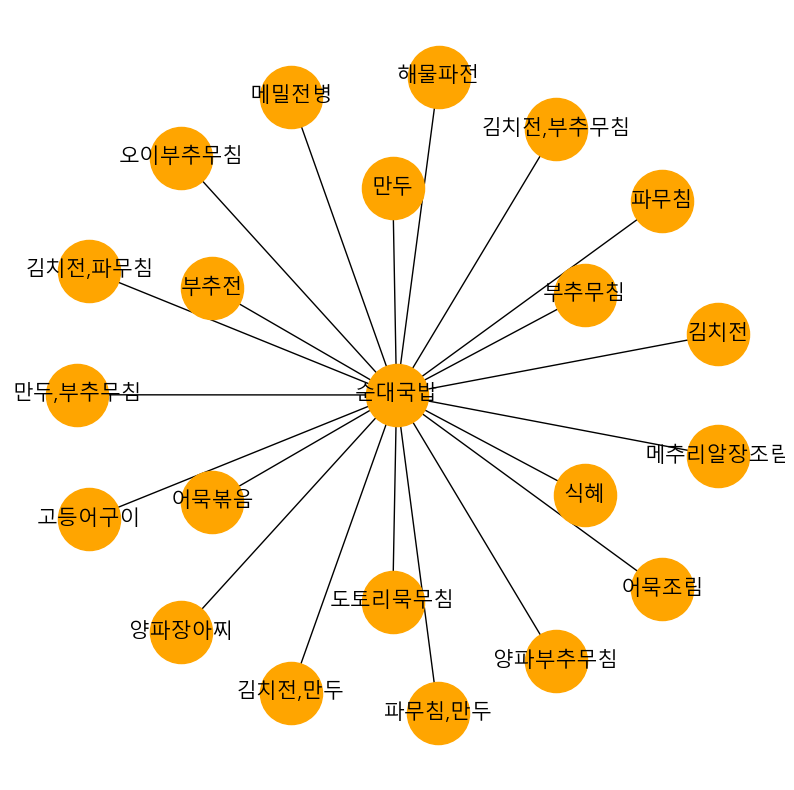

In [166]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

data = rules[['antecedents','consequents', 'conviction']][rules['antecedents']== lunch_menu]
# data
data_sort=data.sort_values('conviction', ascending=False).reset_index(drop=True)
data_sort
data_sort_top20=data_sort.loc[0:20]
data_sort_top20

G = nx.from_pandas_edgelist(data_sort_top20, 
                            source = 'antecedents', 
                            target = 'consequents')
plt.figure(figsize=(10, 10)) ; plt.axis('off')
nx.draw_kamada_kawai(G)
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_labels(G, pos, font_size=15, font_color='black',
                       font_family=font_name)
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=2000, alpha=1)
plt.show()

In [ ]:
# #### 영양소 추출 함수 정의
# def food_finder(menu, f=factors, df=df_food) :
#     if type(menu)==list :
#         find_term = df[df["식품명"].isin(menu)]
#     else : 
#         find_term=df[df["식품명"]==menu]
#     find_idx = list(find_term.index)
#     menu_nutrient=[]
#     for s in find_idx:
#         find_menu=[]
#         for i in range(len(f)) :
#             find_menu.append(find_term[f[i]][s])    
#         menu_nutrient.append(find_menu)
#     return menu_nutrient

# #### 권장량 추출 함수 정의
# def standard_finder(sex, age, f=factors, df=df_nutrient) :
#     std_term = df[(df["성별"]==sex) & (df["연령별"]==age)]
#     find_idx = list(std_term.index)
#     std_nutrient=[]
#     for i in range(len(f)) :
#         if f[i] == '에너지(kcal)':
#             std_nutrient.append(std_term['에너지(kcal)'].values.tolist()[0])
#         else : 
#             std_nutrient.append(std_term['권장섭취량'][std_term["영양소"]==f[i]].values.tolist()[0]) 
#     return std_nutrient

# #### 총 및 잔여 영양소 함수 정의
# def nutrient_cal(sex, age, menu1, menu2, f=factors, n_dict=nutrient_dict) :
#     n_dict["lunch"].extend(food_finder(menu1))
#     n_dict["side"].extend(food_finder(menu2))
#     n_dict["standard"].extend(standard_finder(sex, age))
# #     print(n_dict["lunch"], n_dict["side"], n_dict["standard"])
    
#     ##### 총 섭취 영양소  
#     for i in range(len(f)) :
#         for l in n_dict['lunch'] :
#             total = l[i]
#             accum = 0
#             for s in n_dict['side'] :
#                 accum = accum + s[i]
#         n_dict["total"].append(total+accum)
# #     print(n_dict["total"])

#     ##### 잔여 영양소 계산
#     for i in range(factor_num) :
#         remain=n_dict['standard'][i]-n_dict['total'][i]
#         n_dict['remain'].append(remain) 
        
#     return n_dict
# # print(nutrient_dict)

# ##### 출력 함수
# def print_func(f=factors, n_dict=nutrient_dict) :
#     col =['lunch','side','total','standard','remain']
#     for i in col :
#         val=n_dict[i]
# #         print(val)
#         print('{} ===================================='.format(i))
#         if i in ['lunch','side'] :
#             for j in range(len(f)) :
#                 num=[]
#                 for k in range(len(val)) :                 
#                     num.append(val[k][j])
#                 print(' - {} : {}'.format(f[j], np.round(num, 2)))
#         else :    
#             for j in range(len(f)) :
#                 print(' - {} : {}'.format(f[j], np.round(val[j], 2)))
                
# ##### 변수 정의
# mains = df_food.loc[df_food["메인여부"]=="main"]["식품명"].values.tolist()
# mains_idx = list(df_food.loc[df_food["메인여부"]=="main"]["식품명"].index)

# menus = df_food.loc[df_food["메인여부"]!="main"]["식품명"].values.tolist()
# menus_idx = list(df_food.loc[df_food["메인여부"]!="main"]["식품명"].index)
# # print(len(mains),len(menus))

# nutrient_dict={'standard':[],'lunch':[], 'side':[],'total':[], 'remain':[], 
#               'dinner':[]}

# factors = ['에너지(kcal)','탄수화물(g)','단백질(g)', '지방(g)', 
#                         '총당류(g)','나트륨(g)']
# # factor_num = len(factors)

# ##### data input
# # sex = '여자'
# # age = '12-14'
# # lunch_menu= '떡볶이'

# # side_menu=["만두","김말이튀김","김밥"]
# # side_cat=len(side_menu)

# ##### random data
# sex = random.choice(['여자','남자'])
# age = random.choice(['6-8', '9-11','12-14','15-18','19-29','30-49', '50-64', 
#                     '65-74',  '75 이상'])
# lunch_num=random.choice(mains_idx)
# lunch_menu=df_food["식품명"][lunch_num]
# print('user는 ', sex, ", ", age, " 입니다.\n")
# print('점심메뉴는 ',lunch_menu, '입니다.\n')

# # side_cat = random.randint(2,4)
# # side_idx = random.sample(menus_idx, side_cat)
# # side_menu = df_food["식품명"][df_food.index.isin(side_num)].values.tolist()

# side_menu = recommend_side_dish_conviction(lunch_menu)
# side_cat=len(side_menu)
# # print(side_menu, type(side_menu))
# print('반찬은 {}개로, '.format(str(side_cat)), side_menu, '입니다.\n')

# nutrient_cal(sex, age, lunch_menu, side_menu) 

# print_func()

---